In [1]:
!pip install scikit-image

In [2]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from skimage.transform import resize
import imageio
import glob
import os

In [3]:
t1_path = "C:/Users/tonde/OneDrive/Desktop/Thesis/Brain_tumor_images/Tumor"
t2_path = "C:/Users/tonde/OneDrive/Desktop/Thesis/Brain_tumor_images/Normal"

t1_images = os.listdir(t1_path)
t2_images = os.listdir(t2_path)
# Validating filename extraction
t1_images[2]

'Tumor (100).jpg'

In [4]:
# Checking how an image looks like as a numpy array
imageio.imread(t1_path+ '/' + t1_images[2])

C:\Users\tonde\AppData\Local\Temp\ipykernel_9048\1295356521.py:2: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  imageio.imread(t1_path+ '/' + t1_images[2])


Array([[[3, 3, 3],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[3, 3, 3],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       [[3, 3, 3],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [4, 4, 4],
        [4, 4, 4],
        [4, 4, 4]],

       ...,

       [[4, 4, 4],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[5, 5, 5],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]],

       [[5, 5, 5],
        [4, 4, 4],
        [4, 4, 4],
        ...,
        [3, 3, 3],
        [3, 3, 3],
        [3, 3, 3]]], dtype=uint8)

In [5]:

def extract_images(ospath, imgfolder):
    img_list = []
    for file in imgfolder:
        img = imageio.imread(ospath+ '/' + file)
        img_list.append(img)
    return np.asarray(img_list) # converts list to a numpy array

In [6]:

t1 = extract_images(t1_path, t1_images)
t2 = extract_images(t2_path, t2_images)
print('T1 Shape: ',t1.shape)
print('T2 Shape: ',t2.shape)
print('Dataset size: ', t1.shape[0]+t2.shape[0])

C:\Users\tonde\AppData\Local\Temp\ipykernel_9048\716782747.py:4: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  img = imageio.imread(ospath+ '/' + file)


T1 Shape:  (230, 256, 256, 3)
T2 Shape:  (170, 256, 256, 3)
Dataset size:  400


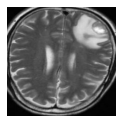

In [7]:
# Visualizing t1 image
plt.figure(figsize=(2, 2))
plt.imshow(t1[2], cmap='gray')
plt.axis('off')
plt.show()

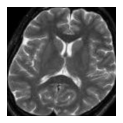

In [8]:
plt.figure(figsize=(2, 2))
plt.imshow(t2[2], cmap='gray')
plt.axis('off')
plt.show()

In [9]:
import numpy as np 
import matplotlib.pyplot as plt 
from tqdm import tqdm
import cv2
import os
import seaborn as sns
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from keras.models import Sequential, Model
from keras.layers import Dense, Flatten, Conv2D, Reshape, Input, Conv2DTranspose
from keras.layers import Activation, LeakyReLU, BatchNormalization, Dropout, Resizing
from keras.losses import BinaryCrossentropy

import warnings
warnings.filterwarnings('ignore')

try:
    from tensorflow.keras.optimizers import Adam
except:
    from keras.optimizers import Adam

In [ ]:
NOISE_DIM = 100  
BATCH_SIZE = 4 
STEPS_PER_EPOCH =3750
EPOCHS = 10
SEED = 40
WIDTH, HEIGHT, CHANNELS = 128, 128, 1

OPTIMIZER = Adam(0.0002, 0.5)

In [11]:
MAIN_DIR = "C:/Users/tonde/OneDrive/Desktop/Thesis/Brain_tumor_images/Tumor"

In [12]:
def load_images(folder):
    
    imgs = []
    target = 1
    labels = []
    for i in os.listdir(folder):
        img_dir = os.path.join(folder,i)
        try:
            img = cv2.imread(img_dir)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
            img = cv2.resize(img, (128,128))
            imgs.append(img)
            labels.append(target)
        except:
            continue
        
    imgs = np.array(imgs)
    labels = np.array(labels)
    
    return imgs, labels

In [13]:
data, labels = load_images(MAIN_DIR)
data.shape, labels.shape

((230, 128, 128), (230,))

# Generate 20 random numbers to index images from data

In [14]:
np.random.seed(SEED)
idxs = np.random.randint(0, 155, 20)

In [15]:
X_train = data[idxs]
X_train.shape

(20, 128, 128)

# Normalize and Reshape the Data

In [16]:
# Normalize the Images
X_train = (X_train.astype(np.float32) - 127.5) / 127.5

# Reshape images 
X_train = X_train.reshape(-1, WIDTH,HEIGHT,CHANNELS)

# Check shape
X_train.shape

(20, 128, 128, 1)

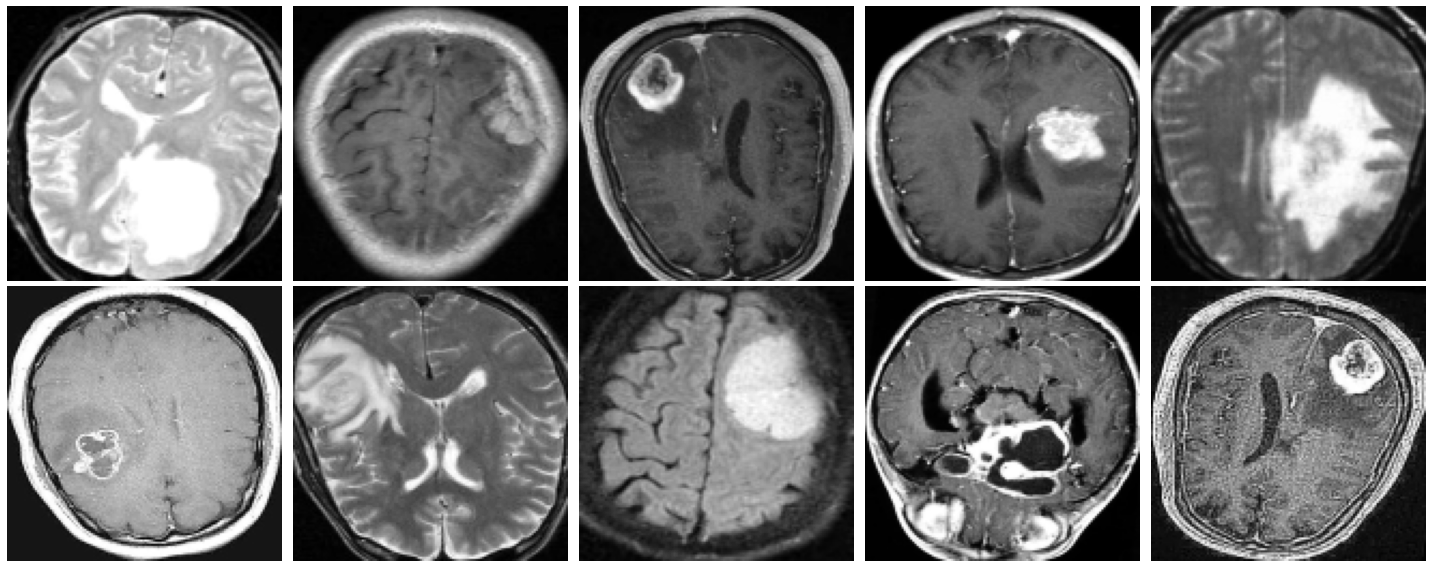

In [17]:
plt.figure(figsize=(20,8))
for i in range(10):
    axs = plt.subplot(2,5,i+1)
    plt.imshow(X_train[i], cmap="gray")
    plt.axis('off')
    axs.set_xticklabels([])
    axs.set_yticklabels([])
    plt.subplots_adjust(wspace=None, hspace=None)
plt.tight_layout()

In [18]:
def build_generator():

    model = Sequential([

        Dense(32*32*256, input_dim=NOISE_DIM),
        LeakyReLU(alpha=0.2),
        Reshape((32,32,256)),
        
        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2DTranspose(128, (4, 4), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(CHANNELS, (4, 4), padding='same', activation='tanh')
    ], 
    name="generator")
    model.summary()
    model.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

    return model

In [19]:
def build_discriminator():
    
    

    model = Sequential([

        Conv2D(64, (3, 3), padding='same', input_shape=(WIDTH, HEIGHT, CHANNELS)),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),

        Conv2D(128, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Conv2D(256, (3, 3), strides=2, padding='same'),
        LeakyReLU(alpha=0.2),
        
        Flatten(),
        Dropout(0.4),
        Dense(1, activation="sigmoid", input_shape=(WIDTH, HEIGHT, CHANNELS))
    ], name="discriminator")
    model.summary()
    model.compile(loss="binary_crossentropy",
                        optimizer=OPTIMIZER)

    return model

In [20]:
print('\n')
discriminator = build_discriminator()
print('\n')
generator = build_generator()

discriminator.trainable = False 

gan_input = Input(shape=(NOISE_DIM,))
fake_image = generator(gan_input)

gan_output = discriminator(fake_image)

gan = Model(gan_input, gan_output, name="gan_model")
gan.compile(loss="binary_crossentropy", optimizer=OPTIMIZER)

print("The Combined Network:\n")
gan.summary()



Model: "discriminator"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 64)      640       
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 128)       73856     
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 128)       0         
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 128)       147584    
                                                                 
 leaky_re_lu_2 (LeakyReLU)   (None, 32, 32, 128)       0         
                                                                 
 conv2d_3 (Conv2D)           (None, 16, 16, 256)   

In [21]:
def sample_images(noise, subplots, figsize=(22,8), save=False):
    generated_images = generator.predict(noise)
    plt.figure(figsize=figsize)
    
    for i, image in enumerate(generated_images):
        plt.subplot(subplots[0], subplots[1], i+1)
        if CHANNELS == 1:
            plt.imshow(image.reshape((WIDTH, HEIGHT)), cmap='gray')    
                                                                            
        else:
            plt.imshow(image.reshape((WIDTH, HEIGHT, CHANNELS)))
        if save == True:
            img_name = "gen" + str(i)
            plt.savefig(img_name)
        plt.subplots_adjust(wspace=None, hspace=None)
        plt.axis('off')
    
    plt.tight_layout()
    plt.show()

  0%|                                                                                         | 0/3750 [00:00<?, ?it/s]

1/1 [==============================] - 1s 717ms/step


  0%|                                                                               | 1/3750 [00:04<4:24:06,  4.23s/it]

1/1 [==============================] - 0s 206ms/step


  0%|                                                                               | 2/3750 [00:05<2:46:42,  2.67s/it]

1/1 [==============================] - 0s 200ms/step


  0%|                                                                               | 3/3750 [00:07<2:13:28,  2.14s/it]

1/1 [==============================] - 0s 204ms/step


  0%|                                                                               | 4/3750 [00:08<1:58:42,  1.90s/it]

1/1 [==============================] - 0s 210ms/step


  0%|                                                                               | 5/3750 [00:10<1:51:30,  1.79s/it]

1/1 [==============================] - 0s 231ms/step


  0%|▏                                                                              | 6/3750 [00:12<1:47:32,  1.72s/it]

1/1 [==============================] - 0s 212ms/step


  0%|▏                                                                              | 7/3750 [00:13<1:43:46,  1.66s/it]

1/1 [==============================] - 0s 203ms/step


  0%|▏                                                                              | 8/3750 [00:15<1:40:39,  1.61s/it]

1/1 [==============================] - 0s 189ms/step


  0%|▏                                                                              | 9/3750 [00:16<1:39:12,  1.59s/it]

1/1 [==============================] - 0s 203ms/step


  0%|▏                                                                             | 10/3750 [00:18<1:38:44,  1.58s/it]

1/1 [==============================] - 0s 193ms/step


  0%|▏                                                                             | 11/3750 [00:19<1:37:49,  1.57s/it]

1/1 [==============================] - 0s 196ms/step


  0%|▏                                                                             | 12/3750 [00:21<1:36:22,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


  0%|▎                                                                             | 13/3750 [00:22<1:35:02,  1.53s/it]

1/1 [==============================] - 0s 208ms/step


  0%|▎                                                                             | 14/3750 [00:24<1:34:40,  1.52s/it]

1/1 [==============================] - 0s 208ms/step


  0%|▎                                                                             | 15/3750 [00:25<1:35:35,  1.54s/it]

1/1 [==============================] - 0s 214ms/step


  0%|▎                                                                             | 16/3750 [00:27<1:36:04,  1.54s/it]

1/1 [==============================] - 0s 193ms/step


  0%|▎                                                                             | 17/3750 [00:28<1:36:02,  1.54s/it]

1/1 [==============================] - 0s 198ms/step


  0%|▎                                                                             | 18/3750 [00:30<1:36:21,  1.55s/it]

1/1 [==============================] - 0s 199ms/step


  1%|▍                                                                             | 19/3750 [00:32<1:37:26,  1.57s/it]

1/1 [==============================] - 0s 212ms/step


  1%|▍                                                                             | 20/3750 [00:33<1:38:13,  1.58s/it]

1/1 [==============================] - 0s 210ms/step


  1%|▍                                                                             | 21/3750 [00:35<1:37:35,  1.57s/it]

1/1 [==============================] - 0s 212ms/step


  1%|▍                                                                             | 22/3750 [00:36<1:37:13,  1.56s/it]

1/1 [==============================] - 0s 225ms/step


  1%|▍                                                                             | 23/3750 [00:38<1:37:55,  1.58s/it]

1/1 [==============================] - 0s 227ms/step


  1%|▍                                                                             | 24/3750 [00:39<1:38:08,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


  1%|▌                                                                             | 25/3750 [00:41<1:37:44,  1.57s/it]

1/1 [==============================] - 0s 212ms/step


  1%|▌                                                                             | 26/3750 [00:43<1:38:12,  1.58s/it]

1/1 [==============================] - 0s 215ms/step


  1%|▌                                                                             | 27/3750 [00:44<1:37:15,  1.57s/it]

1/1 [==============================] - 0s 201ms/step


  1%|▌                                                                             | 28/3750 [00:46<1:36:46,  1.56s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▌                                                                             | 29/3750 [00:47<1:36:08,  1.55s/it]

1/1 [==============================] - 0s 229ms/step


  1%|▌                                                                             | 30/3750 [00:49<1:36:48,  1.56s/it]

1/1 [==============================] - 0s 201ms/step


  1%|▋                                                                             | 31/3750 [00:50<1:36:01,  1.55s/it]

1/1 [==============================] - 0s 220ms/step


  1%|▋                                                                             | 32/3750 [00:52<1:36:10,  1.55s/it]

1/1 [==============================] - 0s 236ms/step


  1%|▋                                                                             | 33/3750 [00:53<1:36:53,  1.56s/it]

1/1 [==============================] - 0s 237ms/step


  1%|▋                                                                             | 34/3750 [00:55<1:36:24,  1.56s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▋                                                                             | 35/3750 [00:57<1:37:03,  1.57s/it]

1/1 [==============================] - 0s 232ms/step


  1%|▋                                                                             | 36/3750 [00:58<1:37:02,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


  1%|▊                                                                             | 37/3750 [01:00<1:36:18,  1.56s/it]

1/1 [==============================] - 0s 213ms/step


  1%|▊                                                                             | 38/3750 [01:01<1:36:37,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


  1%|▊                                                                             | 39/3750 [01:03<1:35:51,  1.55s/it]

1/1 [==============================] - 0s 236ms/step


  1%|▊                                                                             | 40/3750 [01:04<1:36:48,  1.57s/it]

1/1 [==============================] - 0s 206ms/step


  1%|▊                                                                             | 41/3750 [01:06<1:36:44,  1.56s/it]

1/1 [==============================] - 0s 223ms/step


  1%|▊                                                                             | 42/3750 [01:08<1:37:55,  1.58s/it]

1/1 [==============================] - 0s 214ms/step


  1%|▉                                                                             | 43/3750 [01:09<1:38:27,  1.59s/it]

1/1 [==============================] - 0s 212ms/step


  1%|▉                                                                             | 44/3750 [01:11<1:39:50,  1.62s/it]

1/1 [==============================] - 0s 217ms/step


  1%|▉                                                                             | 45/3750 [01:12<1:38:49,  1.60s/it]

1/1 [==============================] - 0s 223ms/step


  1%|▉                                                                             | 46/3750 [01:14<1:38:18,  1.59s/it]

1/1 [==============================] - 0s 202ms/step


  1%|▉                                                                             | 47/3750 [01:16<1:36:56,  1.57s/it]

1/1 [==============================] - 0s 216ms/step


  1%|▉                                                                             | 48/3750 [01:17<1:36:31,  1.56s/it]

1/1 [==============================] - 0s 203ms/step


  1%|█                                                                             | 49/3750 [01:19<1:37:29,  1.58s/it]

1/1 [==============================] - 0s 225ms/step


  1%|█                                                                             | 50/3750 [01:20<1:37:51,  1.59s/it]

1/1 [==============================] - 0s 236ms/step


  1%|█                                                                             | 51/3750 [01:22<1:38:14,  1.59s/it]

1/1 [==============================] - 0s 202ms/step


  1%|█                                                                             | 52/3750 [01:24<1:38:04,  1.59s/it]

1/1 [==============================] - 0s 217ms/step


  1%|█                                                                             | 53/3750 [01:25<1:37:44,  1.59s/it]

1/1 [==============================] - 0s 209ms/step


  1%|█                                                                             | 54/3750 [01:27<1:37:07,  1.58s/it]

1/1 [==============================] - 0s 212ms/step


  1%|█▏                                                                            | 55/3750 [01:28<1:36:19,  1.56s/it]

1/1 [==============================] - 0s 203ms/step


  1%|█▏                                                                            | 56/3750 [01:30<1:36:24,  1.57s/it]

1/1 [==============================] - 0s 212ms/step


  2%|█▏                                                                            | 57/3750 [01:31<1:35:44,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


  2%|█▏                                                                            | 58/3750 [01:33<1:35:21,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▏                                                                            | 59/3750 [01:34<1:35:10,  1.55s/it]

1/1 [==============================] - 0s 209ms/step


  2%|█▏                                                                            | 60/3750 [01:36<1:35:12,  1.55s/it]

1/1 [==============================] - 0s 234ms/step


  2%|█▎                                                                            | 61/3750 [01:37<1:35:01,  1.55s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▎                                                                            | 62/3750 [01:39<1:34:36,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


  2%|█▎                                                                            | 63/3750 [01:40<1:34:26,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▎                                                                            | 64/3750 [01:42<1:33:55,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


  2%|█▎                                                                            | 65/3750 [01:44<1:33:21,  1.52s/it]

1/1 [==============================] - 0s 190ms/step


  2%|█▎                                                                            | 66/3750 [01:45<1:33:25,  1.52s/it]

1/1 [==============================] - 0s 189ms/step


  2%|█▍                                                                            | 67/3750 [01:47<1:33:22,  1.52s/it]

1/1 [==============================] - 0s 206ms/step


  2%|█▍                                                                            | 68/3750 [01:48<1:32:57,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


  2%|█▍                                                                            | 69/3750 [01:50<1:32:16,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▍                                                                            | 70/3750 [01:51<1:32:39,  1.51s/it]

1/1 [==============================] - 0s 208ms/step


  2%|█▍                                                                            | 71/3750 [01:53<1:32:45,  1.51s/it]

1/1 [==============================] - 0s 213ms/step


  2%|█▍                                                                            | 72/3750 [01:54<1:32:03,  1.50s/it]

1/1 [==============================] - 0s 193ms/step


  2%|█▌                                                                            | 73/3750 [01:56<1:31:22,  1.49s/it]

1/1 [==============================] - 0s 197ms/step


  2%|█▌                                                                            | 74/3750 [01:57<1:31:29,  1.49s/it]

1/1 [==============================] - 0s 207ms/step


  2%|█▌                                                                            | 75/3750 [01:59<1:32:18,  1.51s/it]

1/1 [==============================] - 0s 217ms/step


  2%|█▌                                                                            | 76/3750 [02:00<1:32:42,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▌                                                                            | 77/3750 [02:02<1:32:00,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▌                                                                            | 78/3750 [02:03<1:31:38,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▋                                                                            | 79/3750 [02:05<1:31:32,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▋                                                                            | 80/3750 [02:06<1:31:40,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  2%|█▋                                                                            | 81/3750 [02:08<1:31:29,  1.50s/it]

1/1 [==============================] - 0s 194ms/step


  2%|█▋                                                                            | 82/3750 [02:09<1:31:41,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  2%|█▋                                                                            | 83/3750 [02:11<1:31:34,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  2%|█▋                                                                            | 84/3750 [02:12<1:32:41,  1.52s/it]

1/1 [==============================] - 0s 218ms/step


  2%|█▊                                                                            | 85/3750 [02:14<1:32:31,  1.51s/it]

1/1 [==============================] - 0s 219ms/step


  2%|█▊                                                                            | 86/3750 [02:15<1:33:52,  1.54s/it]

1/1 [==============================] - 0s 208ms/step


  2%|█▊                                                                            | 87/3750 [02:17<1:32:56,  1.52s/it]

1/1 [==============================] - 0s 188ms/step


  2%|█▊                                                                            | 88/3750 [02:18<1:33:41,  1.54s/it]

1/1 [==============================] - 0s 225ms/step


  2%|█▊                                                                            | 89/3750 [02:20<1:33:40,  1.54s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▊                                                                            | 90/3750 [02:21<1:33:11,  1.53s/it]

1/1 [==============================] - 0s 207ms/step


  2%|█▉                                                                            | 91/3750 [02:23<1:33:09,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


  2%|█▉                                                                            | 92/3750 [02:24<1:32:14,  1.51s/it]

1/1 [==============================] - 0s 221ms/step


  2%|█▉                                                                            | 93/3750 [02:26<1:32:58,  1.53s/it]

1/1 [==============================] - 0s 230ms/step


  3%|█▉                                                                            | 94/3750 [02:27<1:33:31,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


  3%|█▉                                                                            | 95/3750 [02:29<1:33:24,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


  3%|█▉                                                                            | 96/3750 [02:30<1:33:08,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██                                                                            | 97/3750 [02:32<1:32:30,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██                                                                            | 98/3750 [02:33<1:32:02,  1.51s/it]

1/1 [==============================] - 0s 206ms/step


  3%|██                                                                            | 99/3750 [02:35<1:31:54,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██                                                                           | 100/3750 [02:36<1:31:50,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██                                                                           | 101/3750 [02:38<1:32:01,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██                                                                           | 102/3750 [02:39<1:31:42,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██                                                                           | 103/3750 [02:41<1:31:22,  1.50s/it]

1/1 [==============================] - 0s 207ms/step


  3%|██▏                                                                          | 104/3750 [02:42<1:30:33,  1.49s/it]

1/1 [==============================] - 0s 209ms/step


  3%|██▏                                                                          | 105/3750 [02:44<1:31:01,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██▏                                                                          | 106/3750 [02:45<1:30:57,  1.50s/it]

1/1 [==============================] - 0s 199ms/step


  3%|██▏                                                                          | 107/3750 [02:47<1:31:03,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██▏                                                                          | 108/3750 [02:48<1:30:37,  1.49s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██▏                                                                          | 109/3750 [02:50<1:30:24,  1.49s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██▎                                                                          | 110/3750 [02:51<1:30:58,  1.50s/it]

1/1 [==============================] - 0s 195ms/step


  3%|██▎                                                                          | 111/3750 [02:53<1:30:18,  1.49s/it]

1/1 [==============================] - 0s 198ms/step


  3%|██▎                                                                          | 112/3750 [02:54<1:30:45,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▎                                                                          | 113/3750 [02:56<1:30:46,  1.50s/it]

1/1 [==============================] - 0s 222ms/step


  3%|██▎                                                                          | 114/3750 [02:57<1:31:21,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▎                                                                          | 115/3750 [02:59<1:31:44,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


  3%|██▍                                                                          | 116/3750 [03:00<1:31:30,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▍                                                                          | 117/3750 [03:02<1:31:06,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▍                                                                          | 118/3750 [03:03<1:30:41,  1.50s/it]

1/1 [==============================] - 0s 213ms/step


  3%|██▍                                                                          | 119/3750 [03:05<1:31:09,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██▍                                                                          | 120/3750 [03:06<1:30:52,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▍                                                                          | 121/3750 [03:08<1:30:08,  1.49s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▌                                                                          | 122/3750 [03:09<1:30:13,  1.49s/it]

1/1 [==============================] - 0s 206ms/step


  3%|██▌                                                                          | 123/3750 [03:11<1:30:21,  1.49s/it]

1/1 [==============================] - 0s 209ms/step


  3%|██▌                                                                          | 124/3750 [03:12<1:30:44,  1.50s/it]

1/1 [==============================] - 0s 206ms/step


  3%|██▌                                                                          | 125/3750 [03:14<1:30:29,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██▌                                                                          | 126/3750 [03:15<1:30:41,  1.50s/it]

1/1 [==============================] - 0s 206ms/step


  3%|██▌                                                                          | 127/3750 [03:17<1:30:31,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


  3%|██▋                                                                          | 128/3750 [03:18<1:30:46,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


  3%|██▋                                                                          | 129/3750 [03:20<1:30:17,  1.50s/it]

1/1 [==============================] - 0s 206ms/step


  3%|██▋                                                                          | 130/3750 [03:21<1:30:57,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


  3%|██▋                                                                          | 131/3750 [03:23<1:31:30,  1.52s/it]

1/1 [==============================] - 0s 209ms/step


  4%|██▋                                                                          | 132/3750 [03:25<1:31:31,  1.52s/it]

1/1 [==============================] - 0s 208ms/step


  4%|██▋                                                                          | 133/3750 [03:26<1:32:19,  1.53s/it]

1/1 [==============================] - 0s 212ms/step


  4%|██▊                                                                          | 134/3750 [03:28<1:33:22,  1.55s/it]

1/1 [==============================] - 0s 211ms/step


  4%|██▊                                                                          | 135/3750 [03:29<1:33:04,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


  4%|██▊                                                                          | 136/3750 [03:31<1:32:22,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


  4%|██▊                                                                          | 137/3750 [03:32<1:31:39,  1.52s/it]

1/1 [==============================] - 0s 210ms/step


  4%|██▊                                                                          | 138/3750 [03:34<1:31:38,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


  4%|██▊                                                                          | 139/3750 [03:35<1:31:14,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


  4%|██▊                                                                          | 140/3750 [03:37<1:30:21,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


  4%|██▉                                                                          | 141/3750 [03:38<1:29:46,  1.49s/it]

1/1 [==============================] - 0s 204ms/step


  4%|██▉                                                                          | 142/3750 [03:40<1:30:14,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  4%|██▉                                                                          | 143/3750 [03:41<1:30:49,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


  4%|██▉                                                                          | 144/3750 [03:43<1:30:24,  1.50s/it]

1/1 [==============================] - 0s 212ms/step


  4%|██▉                                                                          | 145/3750 [03:44<1:30:11,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


  4%|██▉                                                                          | 146/3750 [03:46<1:30:22,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


  4%|███                                                                          | 147/3750 [03:47<1:30:22,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  4%|███                                                                          | 148/3750 [03:49<1:30:16,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  4%|███                                                                          | 149/3750 [03:50<1:30:11,  1.50s/it]

1/1 [==============================] - 0s 210ms/step


  4%|███                                                                          | 150/3750 [03:52<1:30:10,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  4%|███                                                                          | 151/3750 [03:53<1:29:26,  1.49s/it]

1/1 [==============================] - 0s 214ms/step


  4%|███                                                                          | 152/3750 [03:55<1:29:38,  1.49s/it]

1/1 [==============================] - 0s 203ms/step


  4%|███▏                                                                         | 153/3750 [03:56<1:29:28,  1.49s/it]

1/1 [==============================] - 0s 196ms/step


  4%|███▏                                                                         | 154/3750 [03:58<1:29:37,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


  4%|███▏                                                                         | 155/3750 [03:59<1:30:04,  1.50s/it]

1/1 [==============================] - 0s 194ms/step


  4%|███▏                                                                         | 156/3750 [04:01<1:29:37,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  4%|███▏                                                                         | 157/3750 [04:02<1:29:40,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


  4%|███▏                                                                         | 158/3750 [04:04<1:29:19,  1.49s/it]

1/1 [==============================] - 0s 197ms/step


  4%|███▎                                                                         | 159/3750 [04:05<1:29:24,  1.49s/it]

1/1 [==============================] - 0s 207ms/step


  4%|███▎                                                                         | 160/3750 [04:07<1:29:41,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


  4%|███▎                                                                         | 161/3750 [04:08<1:29:25,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


  4%|███▎                                                                         | 162/3750 [04:10<1:29:11,  1.49s/it]

1/1 [==============================] - 0s 197ms/step


  4%|███▎                                                                         | 163/3750 [04:11<1:29:02,  1.49s/it]

1/1 [==============================] - 0s 205ms/step


  4%|███▎                                                                         | 164/3750 [04:13<1:30:01,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


  4%|███▍                                                                         | 165/3750 [04:14<1:29:47,  1.50s/it]

1/1 [==============================] - 0s 215ms/step


  4%|███▍                                                                         | 166/3750 [04:16<1:29:44,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  4%|███▍                                                                         | 167/3750 [04:17<1:29:58,  1.51s/it]

1/1 [==============================] - 0s 190ms/step


  4%|███▍                                                                         | 168/3750 [04:19<1:30:03,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


  5%|███▍                                                                         | 169/3750 [04:20<1:29:37,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


  5%|███▍                                                                         | 170/3750 [04:22<1:29:19,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▌                                                                         | 171/3750 [04:23<1:29:54,  1.51s/it]

1/1 [==============================] - 0s 207ms/step


  5%|███▌                                                                         | 172/3750 [04:25<1:29:44,  1.50s/it]

1/1 [==============================] - 0s 199ms/step


  5%|███▌                                                                         | 173/3750 [04:26<1:29:45,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


  5%|███▌                                                                         | 174/3750 [04:28<1:29:42,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▌                                                                         | 175/3750 [04:29<1:29:53,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▌                                                                         | 176/3750 [04:31<1:29:40,  1.51s/it]

1/1 [==============================] - 0s 221ms/step


  5%|███▋                                                                         | 177/3750 [04:32<1:29:41,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▋                                                                         | 178/3750 [04:34<1:29:49,  1.51s/it]

1/1 [==============================] - 0s 188ms/step


  5%|███▋                                                                         | 179/3750 [04:35<1:29:18,  1.50s/it]

1/1 [==============================] - 0s 190ms/step


  5%|███▋                                                                         | 180/3750 [04:37<1:29:08,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▋                                                                         | 181/3750 [04:38<1:28:43,  1.49s/it]

1/1 [==============================] - 0s 205ms/step


  5%|███▋                                                                         | 182/3750 [04:40<1:28:42,  1.49s/it]

1/1 [==============================] - 0s 187ms/step


  5%|███▊                                                                         | 183/3750 [04:41<1:29:09,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▊                                                                         | 184/3750 [04:43<1:29:15,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  5%|███▊                                                                         | 185/3750 [04:44<1:28:33,  1.49s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▊                                                                         | 186/3750 [04:46<1:29:04,  1.50s/it]

1/1 [==============================] - 0s 188ms/step


  5%|███▊                                                                         | 187/3750 [04:47<1:29:20,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


  5%|███▊                                                                         | 188/3750 [04:49<1:29:07,  1.50s/it]

1/1 [==============================] - 0s 206ms/step


  5%|███▉                                                                         | 189/3750 [04:50<1:28:39,  1.49s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▉                                                                         | 190/3750 [04:52<1:28:46,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


  5%|███▉                                                                         | 191/3750 [04:53<1:28:51,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


  5%|███▉                                                                         | 192/3750 [04:55<1:29:00,  1.50s/it]

1/1 [==============================] - 0s 206ms/step


  5%|███▉                                                                         | 193/3750 [04:56<1:28:40,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▉                                                                         | 194/3750 [04:58<1:29:11,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  5%|████                                                                         | 195/3750 [04:59<1:29:17,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


  5%|████                                                                         | 196/3750 [05:01<1:28:50,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


  5%|████                                                                         | 197/3750 [05:02<1:28:41,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


  5%|████                                                                         | 198/3750 [05:04<1:28:10,  1.49s/it]

1/1 [==============================] - 0s 234ms/step


  5%|████                                                                         | 199/3750 [05:05<1:28:54,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  5%|████                                                                         | 200/3750 [05:07<1:28:50,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


  5%|████▏                                                                        | 201/3750 [05:08<1:28:51,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


  5%|████▏                                                                        | 202/3750 [05:10<1:29:00,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


  5%|████▏                                                                        | 203/3750 [05:11<1:28:41,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


  5%|████▏                                                                        | 204/3750 [05:13<1:28:27,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  5%|████▏                                                                        | 205/3750 [05:14<1:28:20,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  5%|████▏                                                                        | 206/3750 [05:16<1:28:19,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▎                                                                        | 207/3750 [05:17<1:28:45,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  6%|████▎                                                                        | 208/3750 [05:19<1:28:21,  1.50s/it]

1/1 [==============================] - 0s 212ms/step


  6%|████▎                                                                        | 209/3750 [05:20<1:28:09,  1.49s/it]

1/1 [==============================] - 0s 197ms/step


  6%|████▎                                                                        | 210/3750 [05:22<1:28:20,  1.50s/it]

1/1 [==============================] - 0s 213ms/step


  6%|████▎                                                                        | 211/3750 [05:23<1:28:42,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▎                                                                        | 212/3750 [05:25<1:29:04,  1.51s/it]

1/1 [==============================] - 0s 217ms/step


  6%|████▎                                                                        | 213/3750 [05:26<1:29:24,  1.52s/it]

1/1 [==============================] - 0s 199ms/step


  6%|████▍                                                                        | 214/3750 [05:28<1:29:32,  1.52s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▍                                                                        | 215/3750 [05:29<1:29:38,  1.52s/it]

1/1 [==============================] - 0s 188ms/step


  6%|████▍                                                                        | 216/3750 [05:31<1:29:05,  1.51s/it]

1/1 [==============================] - 0s 202ms/step


  6%|████▍                                                                        | 217/3750 [05:32<1:28:58,  1.51s/it]

1/1 [==============================] - 0s 219ms/step


  6%|████▍                                                                        | 218/3750 [05:34<1:29:21,  1.52s/it]

1/1 [==============================] - 0s 202ms/step


  6%|████▍                                                                        | 219/3750 [05:35<1:28:32,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▌                                                                        | 220/3750 [05:37<1:28:22,  1.50s/it]

1/1 [==============================] - 0s 218ms/step


  6%|████▌                                                                        | 221/3750 [05:38<1:28:18,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


  6%|████▌                                                                        | 222/3750 [05:40<1:27:38,  1.49s/it]

1/1 [==============================] - 0s 215ms/step


  6%|████▌                                                                        | 223/3750 [05:41<1:28:33,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▌                                                                        | 224/3750 [05:43<1:28:21,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▌                                                                        | 225/3750 [05:44<1:28:28,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


  6%|████▋                                                                        | 226/3750 [05:46<1:27:58,  1.50s/it]

1/1 [==============================] - 0s 200ms/step


  6%|████▋                                                                        | 227/3750 [05:47<1:28:28,  1.51s/it]

1/1 [==============================] - 0s 188ms/step


  6%|████▋                                                                        | 228/3750 [05:49<1:28:13,  1.50s/it]

1/1 [==============================] - 0s 212ms/step


  6%|████▋                                                                        | 229/3750 [05:50<1:28:18,  1.50s/it]

1/1 [==============================] - 0s 226ms/step


  6%|████▋                                                                        | 230/3750 [05:52<1:29:03,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


  6%|████▋                                                                        | 231/3750 [05:53<1:28:55,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


  6%|████▊                                                                        | 232/3750 [05:55<1:28:43,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


  6%|████▊                                                                        | 233/3750 [05:56<1:28:32,  1.51s/it]

1/1 [==============================] - 0s 209ms/step


  6%|████▊                                                                        | 234/3750 [05:58<1:28:50,  1.52s/it]

1/1 [==============================] - 0s 186ms/step


  6%|████▊                                                                        | 235/3750 [05:59<1:28:36,  1.51s/it]

1/1 [==============================] - 0s 215ms/step


  6%|████▊                                                                        | 236/3750 [06:01<1:28:35,  1.51s/it]

1/1 [==============================] - 0s 216ms/step


  6%|████▊                                                                        | 237/3750 [06:02<1:28:38,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


  6%|████▉                                                                        | 238/3750 [06:04<1:28:20,  1.51s/it]

1/1 [==============================] - 0s 209ms/step


  6%|████▉                                                                        | 239/3750 [06:06<1:29:05,  1.52s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▉                                                                        | 240/3750 [06:07<1:29:44,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


  6%|████▉                                                                        | 241/3750 [06:09<1:29:39,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


  6%|████▉                                                                        | 242/3750 [06:10<1:29:02,  1.52s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▉                                                                        | 243/3750 [06:12<1:29:30,  1.53s/it]

1/1 [==============================] - 0s 218ms/step


  7%|█████                                                                        | 244/3750 [06:13<1:30:48,  1.55s/it]

1/1 [==============================] - 0s 222ms/step


  7%|█████                                                                        | 245/3750 [06:15<1:32:53,  1.59s/it]

1/1 [==============================] - 0s 236ms/step


  7%|█████                                                                        | 246/3750 [06:17<1:33:38,  1.60s/it]

1/1 [==============================] - 0s 201ms/step


  7%|█████                                                                        | 247/3750 [06:18<1:32:50,  1.59s/it]

1/1 [==============================] - 0s 220ms/step


  7%|█████                                                                        | 248/3750 [06:20<1:32:00,  1.58s/it]

1/1 [==============================] - 0s 224ms/step


  7%|█████                                                                        | 249/3750 [06:21<1:32:18,  1.58s/it]

1/1 [==============================] - 0s 212ms/step


  7%|█████▏                                                                       | 250/3750 [06:23<1:32:11,  1.58s/it]

1/1 [==============================] - 0s 220ms/step


  7%|█████▏                                                                       | 251/3750 [06:24<1:32:06,  1.58s/it]

1/1 [==============================] - 0s 221ms/step


  7%|█████▏                                                                       | 252/3750 [06:26<1:31:38,  1.57s/it]

1/1 [==============================] - 0s 230ms/step


  7%|█████▏                                                                       | 253/3750 [06:28<1:31:36,  1.57s/it]

1/1 [==============================] - 0s 234ms/step


  7%|█████▏                                                                       | 254/3750 [06:29<1:31:50,  1.58s/it]

1/1 [==============================] - 0s 219ms/step


  7%|█████▏                                                                       | 255/3750 [06:31<1:31:30,  1.57s/it]

1/1 [==============================] - 0s 201ms/step


  7%|█████▎                                                                       | 256/3750 [06:32<1:31:09,  1.57s/it]

1/1 [==============================] - 0s 197ms/step


  7%|█████▎                                                                       | 257/3750 [06:34<1:30:32,  1.56s/it]

1/1 [==============================] - 0s 232ms/step


  7%|█████▎                                                                       | 258/3750 [06:35<1:30:56,  1.56s/it]

1/1 [==============================] - 0s 188ms/step


  7%|█████▎                                                                       | 259/3750 [06:37<1:28:30,  1.52s/it]

1/1 [==============================] - 0s 198ms/step


  7%|█████▎                                                                       | 260/3750 [06:38<1:26:08,  1.48s/it]

1/1 [==============================] - 0s 196ms/step


  7%|█████▎                                                                       | 261/3750 [06:40<1:24:42,  1.46s/it]

1/1 [==============================] - 0s 202ms/step


  7%|█████▍                                                                       | 262/3750 [06:41<1:24:15,  1.45s/it]

1/1 [==============================] - 0s 210ms/step


  7%|█████▍                                                                       | 263/3750 [06:42<1:23:52,  1.44s/it]

1/1 [==============================] - 0s 187ms/step


  7%|█████▍                                                                       | 264/3750 [06:44<1:24:21,  1.45s/it]

1/1 [==============================] - 0s 206ms/step


  7%|█████▍                                                                       | 265/3750 [06:45<1:25:53,  1.48s/it]

1/1 [==============================] - 0s 244ms/step


  7%|█████▍                                                                       | 266/3750 [06:47<1:27:21,  1.50s/it]

1/1 [==============================] - 0s 206ms/step


  7%|█████▍                                                                       | 267/3750 [06:49<1:27:41,  1.51s/it]

1/1 [==============================] - 0s 218ms/step


  7%|█████▌                                                                       | 268/3750 [06:50<1:28:23,  1.52s/it]

1/1 [==============================] - 0s 218ms/step


  7%|█████▌                                                                       | 269/3750 [06:52<1:28:27,  1.52s/it]

1/1 [==============================] - 0s 215ms/step


  7%|█████▌                                                                       | 270/3750 [06:53<1:28:29,  1.53s/it]

1/1 [==============================] - 0s 215ms/step


  7%|█████▌                                                                       | 271/3750 [06:55<1:28:14,  1.52s/it]

1/1 [==============================] - 0s 200ms/step


  7%|█████▌                                                                       | 272/3750 [06:56<1:28:09,  1.52s/it]

1/1 [==============================] - 0s 208ms/step


  7%|█████▌                                                                       | 273/3750 [06:58<1:27:43,  1.51s/it]

1/1 [==============================] - 0s 224ms/step


  7%|█████▋                                                                       | 274/3750 [06:59<1:28:04,  1.52s/it]

1/1 [==============================] - 0s 220ms/step


  7%|█████▋                                                                       | 275/3750 [07:01<1:28:28,  1.53s/it]

1/1 [==============================] - 0s 206ms/step


  7%|█████▋                                                                       | 276/3750 [07:02<1:28:31,  1.53s/it]

1/1 [==============================] - 0s 221ms/step


  7%|█████▋                                                                       | 277/3750 [07:04<1:28:47,  1.53s/it]

1/1 [==============================] - 0s 220ms/step


  7%|█████▋                                                                       | 278/3750 [07:05<1:29:06,  1.54s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████▋                                                                       | 279/3750 [07:07<1:28:28,  1.53s/it]

1/1 [==============================] - 0s 206ms/step


  7%|█████▋                                                                       | 280/3750 [07:08<1:28:09,  1.52s/it]

1/1 [==============================] - 0s 209ms/step


  7%|█████▊                                                                       | 281/3750 [07:10<1:27:51,  1.52s/it]

1/1 [==============================] - 0s 220ms/step


  8%|█████▊                                                                       | 282/3750 [07:11<1:28:05,  1.52s/it]

1/1 [==============================] - 0s 189ms/step


  8%|█████▊                                                                       | 283/3750 [07:13<1:27:07,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


  8%|█████▊                                                                       | 284/3750 [07:14<1:26:46,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


  8%|█████▊                                                                       | 285/3750 [07:16<1:26:10,  1.49s/it]

1/1 [==============================] - 0s 203ms/step


  8%|█████▊                                                                       | 286/3750 [07:17<1:25:59,  1.49s/it]

1/1 [==============================] - 0s 204ms/step


  8%|█████▉                                                                       | 287/3750 [07:19<1:25:38,  1.48s/it]

1/1 [==============================] - 0s 203ms/step


  8%|█████▉                                                                       | 288/3750 [07:20<1:25:03,  1.47s/it]

1/1 [==============================] - 0s 189ms/step


  8%|█████▉                                                                       | 289/3750 [07:22<1:24:22,  1.46s/it]

1/1 [==============================] - 0s 205ms/step


  8%|█████▉                                                                       | 290/3750 [07:23<1:24:31,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


  8%|█████▉                                                                       | 291/3750 [07:25<1:24:51,  1.47s/it]

1/1 [==============================] - 0s 196ms/step


  8%|█████▉                                                                       | 292/3750 [07:26<1:24:11,  1.46s/it]

1/1 [==============================] - 0s 204ms/step


  8%|██████                                                                       | 293/3750 [07:28<1:24:29,  1.47s/it]

1/1 [==============================] - 0s 188ms/step


  8%|██████                                                                       | 294/3750 [07:29<1:24:11,  1.46s/it]

1/1 [==============================] - 0s 205ms/step


  8%|██████                                                                       | 295/3750 [07:31<1:24:18,  1.46s/it]

1/1 [==============================] - 0s 198ms/step


  8%|██████                                                                       | 296/3750 [07:32<1:24:41,  1.47s/it]

1/1 [==============================] - 0s 203ms/step


  8%|██████                                                                       | 297/3750 [07:34<1:24:57,  1.48s/it]

1/1 [==============================] - 0s 205ms/step


  8%|██████                                                                       | 298/3750 [07:35<1:24:57,  1.48s/it]

1/1 [==============================] - 0s 204ms/step


  8%|██████▏                                                                      | 299/3750 [07:36<1:24:39,  1.47s/it]

1/1 [==============================] - 0s 205ms/step


  8%|██████▏                                                                      | 300/3750 [07:38<1:24:16,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


  8%|██████▏                                                                      | 301/3750 [07:39<1:24:50,  1.48s/it]

1/1 [==============================] - 0s 189ms/step


  8%|██████▏                                                                      | 302/3750 [07:41<1:24:52,  1.48s/it]

1/1 [==============================] - 0s 205ms/step


  8%|██████▏                                                                      | 303/3750 [07:42<1:24:51,  1.48s/it]

1/1 [==============================] - 0s 197ms/step


  8%|██████▏                                                                      | 304/3750 [07:44<1:24:34,  1.47s/it]

1/1 [==============================] - 0s 198ms/step


  8%|██████▎                                                                      | 305/3750 [07:45<1:24:13,  1.47s/it]

1/1 [==============================] - 0s 205ms/step


  8%|██████▎                                                                      | 306/3750 [07:47<1:24:23,  1.47s/it]

1/1 [==============================] - 0s 189ms/step


  8%|██████▎                                                                      | 307/3750 [07:48<1:24:26,  1.47s/it]

1/1 [==============================] - 0s 200ms/step


  8%|██████▎                                                                      | 308/3750 [07:50<1:24:21,  1.47s/it]

1/1 [==============================] - 0s 190ms/step


  8%|██████▎                                                                      | 309/3750 [07:51<1:24:38,  1.48s/it]

1/1 [==============================] - 0s 200ms/step


  8%|██████▎                                                                      | 310/3750 [07:53<1:24:24,  1.47s/it]

1/1 [==============================] - 0s 197ms/step


  8%|██████▍                                                                      | 311/3750 [07:54<1:24:07,  1.47s/it]

1/1 [==============================] - 0s 199ms/step


  8%|██████▍                                                                      | 312/3750 [07:56<1:24:04,  1.47s/it]

1/1 [==============================] - 0s 189ms/step


  8%|██████▍                                                                      | 313/3750 [07:57<1:24:04,  1.47s/it]

1/1 [==============================] - 0s 199ms/step


  8%|██████▍                                                                      | 314/3750 [07:58<1:23:56,  1.47s/it]

1/1 [==============================] - 0s 205ms/step


  8%|██████▍                                                                      | 315/3750 [08:00<1:23:58,  1.47s/it]

1/1 [==============================] - 0s 203ms/step


  8%|██████▍                                                                      | 316/3750 [08:01<1:24:31,  1.48s/it]

1/1 [==============================] - 0s 203ms/step


  8%|██████▌                                                                      | 317/3750 [08:03<1:23:58,  1.47s/it]

1/1 [==============================] - 0s 197ms/step


  8%|██████▌                                                                      | 318/3750 [08:04<1:24:13,  1.47s/it]

1/1 [==============================] - 0s 190ms/step


  9%|██████▌                                                                      | 319/3750 [08:06<1:23:40,  1.46s/it]

1/1 [==============================] - 0s 205ms/step


  9%|██████▌                                                                      | 320/3750 [08:07<1:23:34,  1.46s/it]

1/1 [==============================] - 0s 198ms/step


  9%|██████▌                                                                      | 321/3750 [08:09<1:23:22,  1.46s/it]

1/1 [==============================] - 0s 189ms/step


  9%|██████▌                                                                      | 322/3750 [08:10<1:23:47,  1.47s/it]

1/1 [==============================] - 0s 198ms/step


  9%|██████▋                                                                      | 323/3750 [08:12<1:23:41,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


  9%|██████▋                                                                      | 324/3750 [08:13<1:23:55,  1.47s/it]

1/1 [==============================] - 0s 199ms/step


  9%|██████▋                                                                      | 325/3750 [08:15<1:23:58,  1.47s/it]

1/1 [==============================] - 0s 196ms/step


  9%|██████▋                                                                      | 326/3750 [08:16<1:24:27,  1.48s/it]

1/1 [==============================] - 0s 206ms/step


  9%|██████▋                                                                      | 327/3750 [08:18<1:24:13,  1.48s/it]

1/1 [==============================] - 0s 197ms/step


  9%|██████▋                                                                      | 328/3750 [08:19<1:24:11,  1.48s/it]

1/1 [==============================] - 0s 198ms/step


  9%|██████▊                                                                      | 329/3750 [08:21<1:24:10,  1.48s/it]

1/1 [==============================] - 0s 189ms/step


  9%|██████▊                                                                      | 330/3750 [08:22<1:24:24,  1.48s/it]

1/1 [==============================] - 0s 191ms/step


  9%|██████▊                                                                      | 331/3750 [08:24<1:24:17,  1.48s/it]

1/1 [==============================] - 0s 206ms/step


  9%|██████▊                                                                      | 332/3750 [08:25<1:24:12,  1.48s/it]

1/1 [==============================] - 0s 205ms/step


  9%|██████▊                                                                      | 333/3750 [08:26<1:23:50,  1.47s/it]

1/1 [==============================] - 0s 189ms/step


  9%|██████▊                                                                      | 334/3750 [08:28<1:24:08,  1.48s/it]

1/1 [==============================] - 0s 205ms/step


  9%|██████▉                                                                      | 335/3750 [08:29<1:23:49,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


  9%|██████▉                                                                      | 336/3750 [08:31<1:23:48,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


  9%|██████▉                                                                      | 337/3750 [08:32<1:23:52,  1.47s/it]

1/1 [==============================] - 0s 189ms/step


  9%|██████▉                                                                      | 338/3750 [08:34<1:23:46,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


  9%|██████▉                                                                      | 339/3750 [08:35<1:23:56,  1.48s/it]

1/1 [==============================] - 0s 196ms/step


  9%|██████▉                                                                      | 340/3750 [08:37<1:23:27,  1.47s/it]

1/1 [==============================] - 0s 197ms/step


  9%|███████                                                                      | 341/3750 [08:38<1:23:10,  1.46s/it]

1/1 [==============================] - 0s 196ms/step


  9%|███████                                                                      | 342/3750 [08:40<1:23:15,  1.47s/it]

1/1 [==============================] - 0s 189ms/step


  9%|███████                                                                      | 343/3750 [08:41<1:23:10,  1.46s/it]

1/1 [==============================] - 0s 206ms/step


  9%|███████                                                                      | 344/3750 [08:43<1:23:23,  1.47s/it]

1/1 [==============================] - 0s 190ms/step


  9%|███████                                                                      | 345/3750 [08:44<1:23:45,  1.48s/it]

1/1 [==============================] - 0s 197ms/step


  9%|███████                                                                      | 346/3750 [08:46<1:23:36,  1.47s/it]

1/1 [==============================] - 0s 191ms/step


  9%|███████▏                                                                     | 347/3750 [08:47<1:23:47,  1.48s/it]

1/1 [==============================] - 0s 194ms/step


  9%|███████▏                                                                     | 348/3750 [08:49<1:23:47,  1.48s/it]

1/1 [==============================] - 0s 188ms/step


  9%|███████▏                                                                     | 349/3750 [08:50<1:24:00,  1.48s/it]

1/1 [==============================] - 0s 190ms/step


  9%|███████▏                                                                     | 350/3750 [08:52<1:23:49,  1.48s/it]

1/1 [==============================] - 0s 192ms/step


  9%|███████▏                                                                     | 351/3750 [08:53<1:23:23,  1.47s/it]

1/1 [==============================] - 0s 212ms/step


  9%|███████▏                                                                     | 352/3750 [08:54<1:23:14,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


  9%|███████▏                                                                     | 353/3750 [08:56<1:23:25,  1.47s/it]

1/1 [==============================] - 0s 207ms/step


  9%|███████▎                                                                     | 354/3750 [08:57<1:23:13,  1.47s/it]

1/1 [==============================] - 0s 200ms/step


  9%|███████▎                                                                     | 355/3750 [08:59<1:24:26,  1.49s/it]

1/1 [==============================] - 0s 208ms/step


  9%|███████▎                                                                     | 356/3750 [09:00<1:24:27,  1.49s/it]

1/1 [==============================] - 0s 196ms/step


 10%|███████▎                                                                     | 357/3750 [09:02<1:23:45,  1.48s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▎                                                                     | 358/3750 [09:03<1:23:47,  1.48s/it]

1/1 [==============================] - 0s 198ms/step


 10%|███████▎                                                                     | 359/3750 [09:05<1:23:29,  1.48s/it]

1/1 [==============================] - 0s 189ms/step


 10%|███████▍                                                                     | 360/3750 [09:06<1:23:33,  1.48s/it]

1/1 [==============================] - 0s 195ms/step


 10%|███████▍                                                                     | 361/3750 [09:08<1:23:01,  1.47s/it]

1/1 [==============================] - 0s 188ms/step


 10%|███████▍                                                                     | 362/3750 [09:09<1:22:54,  1.47s/it]

1/1 [==============================] - 0s 197ms/step


 10%|███████▍                                                                     | 363/3750 [09:11<1:23:01,  1.47s/it]

1/1 [==============================] - 0s 189ms/step


 10%|███████▍                                                                     | 364/3750 [09:12<1:23:01,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▍                                                                     | 365/3750 [09:14<1:23:01,  1.47s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▌                                                                     | 366/3750 [09:15<1:23:12,  1.48s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▌                                                                     | 367/3750 [09:17<1:23:39,  1.48s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▌                                                                     | 368/3750 [09:18<1:23:30,  1.48s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▌                                                                     | 369/3750 [09:20<1:24:00,  1.49s/it]

1/1 [==============================] - 0s 196ms/step


 10%|███████▌                                                                     | 370/3750 [09:21<1:24:32,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▌                                                                     | 371/3750 [09:23<1:24:13,  1.50s/it]

1/1 [==============================] - 0s 207ms/step


 10%|███████▋                                                                     | 372/3750 [09:24<1:24:41,  1.50s/it]

1/1 [==============================] - 0s 211ms/step


 10%|███████▋                                                                     | 373/3750 [09:26<1:24:33,  1.50s/it]

1/1 [==============================] - 0s 214ms/step


 10%|███████▋                                                                     | 374/3750 [09:27<1:24:23,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▋                                                                     | 375/3750 [09:29<1:24:50,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▋                                                                     | 376/3750 [09:30<1:24:31,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▋                                                                     | 377/3750 [09:32<1:24:17,  1.50s/it]

1/1 [==============================] - 0s 207ms/step


 10%|███████▊                                                                     | 378/3750 [09:33<1:24:47,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▊                                                                     | 379/3750 [09:35<1:24:28,  1.50s/it]

1/1 [==============================] - 0s 211ms/step


 10%|███████▊                                                                     | 380/3750 [09:36<1:24:30,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▊                                                                     | 381/3750 [09:38<1:24:27,  1.50s/it]

1/1 [==============================] - 0s 214ms/step


 10%|███████▊                                                                     | 382/3750 [09:39<1:24:32,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 10%|███████▊                                                                     | 383/3750 [09:41<1:24:04,  1.50s/it]

1/1 [==============================] - 0s 188ms/step


 10%|███████▉                                                                     | 384/3750 [09:42<1:23:47,  1.49s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▉                                                                     | 385/3750 [09:44<1:24:10,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▉                                                                     | 386/3750 [09:45<1:24:00,  1.50s/it]

1/1 [==============================] - 0s 212ms/step


 10%|███████▉                                                                     | 387/3750 [09:47<1:24:23,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▉                                                                     | 388/3750 [09:48<1:24:06,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▉                                                                     | 389/3750 [09:50<1:23:29,  1.49s/it]

1/1 [==============================] - 0s 204ms/step


 10%|████████                                                                     | 390/3750 [09:51<1:23:40,  1.49s/it]

1/1 [==============================] - 0s 205ms/step


 10%|████████                                                                     | 391/3750 [09:53<1:23:52,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 10%|████████                                                                     | 392/3750 [09:54<1:24:15,  1.51s/it]

1/1 [==============================] - 0s 206ms/step


 10%|████████                                                                     | 393/3750 [09:56<1:23:56,  1.50s/it]

1/1 [==============================] - 0s 220ms/step


 11%|████████                                                                     | 394/3750 [09:57<1:24:22,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 11%|████████                                                                     | 395/3750 [09:59<1:23:50,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▏                                                                    | 396/3750 [10:00<1:23:43,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▏                                                                    | 397/3750 [10:02<1:23:19,  1.49s/it]

1/1 [==============================] - 0s 206ms/step


 11%|████████▏                                                                    | 398/3750 [10:03<1:24:00,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▏                                                                    | 399/3750 [10:05<1:23:56,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 11%|████████▏                                                                    | 400/3750 [10:06<1:23:49,  1.50s/it]

1/1 [==============================] - 0s 214ms/step


 11%|████████▏                                                                    | 401/3750 [10:08<1:23:16,  1.49s/it]

1/1 [==============================] - 0s 197ms/step


 11%|████████▎                                                                    | 402/3750 [10:09<1:23:19,  1.49s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▎                                                                    | 403/3750 [10:11<1:24:14,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▎                                                                    | 404/3750 [10:12<1:23:52,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


 11%|████████▎                                                                    | 405/3750 [10:14<1:23:34,  1.50s/it]

1/1 [==============================] - 0s 212ms/step


 11%|████████▎                                                                    | 406/3750 [10:15<1:23:37,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▎                                                                    | 407/3750 [10:17<1:23:54,  1.51s/it]

1/1 [==============================] - 0s 188ms/step


 11%|████████▍                                                                    | 408/3750 [10:18<1:23:51,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▍                                                                    | 409/3750 [10:20<1:23:49,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 11%|████████▍                                                                    | 410/3750 [10:21<1:23:08,  1.49s/it]

1/1 [==============================] - 0s 190ms/step


 11%|████████▍                                                                    | 411/3750 [10:23<1:22:59,  1.49s/it]

1/1 [==============================] - 0s 190ms/step


 11%|████████▍                                                                    | 412/3750 [10:24<1:23:08,  1.49s/it]

1/1 [==============================] - 0s 201ms/step


 11%|████████▍                                                                    | 413/3750 [10:26<1:23:55,  1.51s/it]

1/1 [==============================] - 0s 217ms/step


 11%|████████▌                                                                    | 414/3750 [10:27<1:24:19,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 11%|████████▌                                                                    | 415/3750 [10:29<1:24:15,  1.52s/it]

1/1 [==============================] - 0s 198ms/step


 11%|████████▌                                                                    | 416/3750 [10:30<1:24:03,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▌                                                                    | 417/3750 [10:32<1:23:50,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▌                                                                    | 418/3750 [10:33<1:23:36,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 11%|████████▌                                                                    | 419/3750 [10:35<1:23:13,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


 11%|████████▌                                                                    | 420/3750 [10:36<1:23:11,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


 11%|████████▋                                                                    | 421/3750 [10:38<1:23:25,  1.50s/it]

1/1 [==============================] - 0s 221ms/step


 11%|████████▋                                                                    | 422/3750 [10:39<1:23:27,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▋                                                                    | 423/3750 [10:41<1:23:18,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


 11%|████████▋                                                                    | 424/3750 [10:42<1:23:28,  1.51s/it]

1/1 [==============================] - 0s 206ms/step


 11%|████████▋                                                                    | 425/3750 [10:44<1:23:19,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▋                                                                    | 426/3750 [10:45<1:22:56,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▊                                                                    | 427/3750 [10:47<1:23:42,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▊                                                                    | 428/3750 [10:48<1:24:24,  1.52s/it]

1/1 [==============================] - 0s 190ms/step


 11%|████████▊                                                                    | 429/3750 [10:50<1:24:21,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 11%|████████▊                                                                    | 430/3750 [10:51<1:24:19,  1.52s/it]

1/1 [==============================] - 0s 191ms/step


 11%|████████▊                                                                    | 431/3750 [10:53<1:23:55,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 12%|████████▊                                                                    | 432/3750 [10:54<1:23:34,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 12%|████████▉                                                                    | 433/3750 [10:56<1:23:42,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 12%|████████▉                                                                    | 434/3750 [10:57<1:23:27,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


 12%|████████▉                                                                    | 435/3750 [10:59<1:23:30,  1.51s/it]

1/1 [==============================] - 0s 199ms/step


 12%|████████▉                                                                    | 436/3750 [11:00<1:23:20,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 12%|████████▉                                                                    | 437/3750 [11:02<1:23:17,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 12%|████████▉                                                                    | 438/3750 [11:03<1:23:10,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████                                                                    | 439/3750 [11:05<1:23:23,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 12%|█████████                                                                    | 440/3750 [11:07<1:23:30,  1.51s/it]

1/1 [==============================] - 0s 188ms/step


 12%|█████████                                                                    | 441/3750 [11:08<1:23:27,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 12%|█████████                                                                    | 442/3750 [11:10<1:23:40,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████                                                                    | 443/3750 [11:11<1:23:27,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████                                                                    | 444/3750 [11:13<1:23:11,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▏                                                                   | 445/3750 [11:14<1:23:10,  1.51s/it]

1/1 [==============================] - 0s 213ms/step


 12%|█████████▏                                                                   | 446/3750 [11:16<1:22:55,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▏                                                                   | 447/3750 [11:17<1:22:49,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


 12%|█████████▏                                                                   | 448/3750 [11:19<1:22:54,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▏                                                                   | 449/3750 [11:20<1:22:16,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▏                                                                   | 450/3750 [11:22<1:22:15,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


 12%|█████████▎                                                                   | 451/3750 [11:23<1:22:52,  1.51s/it]

1/1 [==============================] - 0s 200ms/step


 12%|█████████▎                                                                   | 452/3750 [11:25<1:23:49,  1.53s/it]

1/1 [==============================] - 0s 212ms/step


 12%|█████████▎                                                                   | 453/3750 [11:26<1:24:04,  1.53s/it]

1/1 [==============================] - 0s 209ms/step


 12%|█████████▎                                                                   | 454/3750 [11:28<1:23:51,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▎                                                                   | 455/3750 [11:29<1:23:24,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▎                                                                   | 456/3750 [11:31<1:23:27,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▍                                                                   | 457/3750 [11:32<1:23:25,  1.52s/it]

1/1 [==============================] - 0s 211ms/step


 12%|█████████▍                                                                   | 458/3750 [11:34<1:23:12,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▍                                                                   | 459/3750 [11:35<1:22:28,  1.50s/it]

1/1 [==============================] - 0s 227ms/step


 12%|█████████▍                                                                   | 460/3750 [11:37<1:23:08,  1.52s/it]

1/1 [==============================] - 0s 199ms/step


 12%|█████████▍                                                                   | 461/3750 [11:38<1:22:51,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 12%|█████████▍                                                                   | 462/3750 [11:40<1:22:56,  1.51s/it]

1/1 [==============================] - 0s 214ms/step


 12%|█████████▌                                                                   | 463/3750 [11:41<1:22:28,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 12%|█████████▌                                                                   | 464/3750 [11:43<1:22:26,  1.51s/it]

1/1 [==============================] - 0s 191ms/step


 12%|█████████▌                                                                   | 465/3750 [11:44<1:22:30,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▌                                                                   | 466/3750 [11:46<1:22:43,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


 12%|█████████▌                                                                   | 467/3750 [11:47<1:22:33,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████▌                                                                   | 468/3750 [11:49<1:22:35,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 13%|█████████▋                                                                   | 469/3750 [11:50<1:22:55,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 13%|█████████▋                                                                   | 470/3750 [11:52<1:22:50,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▋                                                                   | 471/3750 [11:53<1:22:20,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▋                                                                   | 472/3750 [11:55<1:22:12,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 13%|█████████▋                                                                   | 473/3750 [11:56<1:22:02,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 13%|█████████▋                                                                   | 474/3750 [11:58<1:22:09,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▊                                                                   | 475/3750 [11:59<1:22:06,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▊                                                                   | 476/3750 [12:01<1:22:08,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▊                                                                   | 477/3750 [12:02<1:21:52,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▊                                                                   | 478/3750 [12:04<1:22:03,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▊                                                                   | 479/3750 [12:05<1:21:56,  1.50s/it]

1/1 [==============================] - 0s 231ms/step


 13%|█████████▊                                                                   | 480/3750 [12:07<1:22:23,  1.51s/it]

1/1 [==============================] - 0s 225ms/step


 13%|█████████▉                                                                   | 481/3750 [12:08<1:23:15,  1.53s/it]

1/1 [==============================] - 0s 220ms/step


 13%|█████████▉                                                                   | 482/3750 [12:10<1:23:16,  1.53s/it]

1/1 [==============================] - 0s 201ms/step


 13%|█████████▉                                                                   | 483/3750 [12:12<1:24:11,  1.55s/it]

1/1 [==============================] - 0s 231ms/step


 13%|█████████▉                                                                   | 484/3750 [12:13<1:24:28,  1.55s/it]

1/1 [==============================] - 0s 209ms/step


 13%|█████████▉                                                                   | 485/3750 [12:15<1:24:02,  1.54s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▉                                                                   | 486/3750 [12:16<1:23:47,  1.54s/it]

1/1 [==============================] - 0s 214ms/step


 13%|█████████▉                                                                   | 487/3750 [12:18<1:25:07,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 13%|██████████                                                                   | 488/3750 [12:19<1:24:15,  1.55s/it]

1/1 [==============================] - 0s 228ms/step


 13%|██████████                                                                   | 489/3750 [12:21<1:23:49,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 13%|██████████                                                                   | 490/3750 [12:22<1:23:07,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 13%|██████████                                                                   | 491/3750 [12:24<1:22:30,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 13%|██████████                                                                   | 492/3750 [12:25<1:22:08,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 13%|██████████                                                                   | 493/3750 [12:27<1:21:51,  1.51s/it]

1/1 [==============================] - 0s 188ms/step


 13%|██████████▏                                                                  | 494/3750 [12:28<1:21:32,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 13%|██████████▏                                                                  | 495/3750 [12:30<1:21:39,  1.51s/it]

1/1 [==============================] - 0s 206ms/step


 13%|██████████▏                                                                  | 496/3750 [12:31<1:21:33,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 13%|██████████▏                                                                  | 497/3750 [12:33<1:21:47,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 13%|██████████▏                                                                  | 498/3750 [12:34<1:22:39,  1.52s/it]

1/1 [==============================] - 0s 208ms/step


 13%|██████████▏                                                                  | 499/3750 [12:36<1:23:43,  1.55s/it]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▎                                                                  | 500/3750 [12:38<1:22:52,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 13%|██████████▎                                                                  | 501/3750 [12:39<1:22:17,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 13%|██████████▎                                                                  | 502/3750 [12:41<1:21:43,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▎                                                                  | 503/3750 [12:42<1:21:17,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


 13%|██████████▎                                                                  | 504/3750 [12:44<1:21:14,  1.50s/it]

1/1 [==============================] - 0s 192ms/step


 13%|██████████▎                                                                  | 505/3750 [12:45<1:21:08,  1.50s/it]

1/1 [==============================] - 0s 183ms/step


 13%|██████████▍                                                                  | 506/3750 [12:47<1:21:30,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 14%|██████████▍                                                                  | 507/3750 [12:48<1:21:26,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 14%|██████████▍                                                                  | 508/3750 [12:50<1:21:26,  1.51s/it]

1/1 [==============================] - 0s 201ms/step


 14%|██████████▍                                                                  | 509/3750 [12:51<1:21:19,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 14%|██████████▍                                                                  | 510/3750 [12:53<1:21:27,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 14%|██████████▍                                                                  | 511/3750 [12:54<1:21:07,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 14%|██████████▌                                                                  | 512/3750 [12:56<1:21:10,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▌                                                                  | 513/3750 [12:57<1:21:08,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 14%|██████████▌                                                                  | 514/3750 [12:59<1:21:39,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▌                                                                  | 515/3750 [13:00<1:21:39,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 14%|██████████▌                                                                  | 516/3750 [13:02<1:21:48,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 14%|██████████▌                                                                  | 517/3750 [13:03<1:21:17,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 14%|██████████▋                                                                  | 518/3750 [13:05<1:20:57,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


 14%|██████████▋                                                                  | 519/3750 [13:06<1:20:11,  1.49s/it]

1/1 [==============================] - 0s 227ms/step


 14%|██████████▋                                                                  | 520/3750 [13:08<1:21:18,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 14%|██████████▋                                                                  | 521/3750 [13:09<1:20:53,  1.50s/it]

1/1 [==============================] - 0s 221ms/step


 14%|██████████▋                                                                  | 522/3750 [13:11<1:21:22,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 14%|██████████▋                                                                  | 523/3750 [13:12<1:21:09,  1.51s/it]

1/1 [==============================] - 0s 190ms/step


 14%|██████████▊                                                                  | 524/3750 [13:14<1:20:52,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


 14%|██████████▊                                                                  | 525/3750 [13:15<1:20:51,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▊                                                                  | 526/3750 [13:17<1:21:02,  1.51s/it]

1/1 [==============================] - 0s 220ms/step


 14%|██████████▊                                                                  | 527/3750 [13:18<1:21:01,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▊                                                                  | 528/3750 [13:20<1:21:11,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▊                                                                  | 529/3750 [13:21<1:21:05,  1.51s/it]

1/1 [==============================] - 0s 208ms/step


 14%|██████████▉                                                                  | 530/3750 [13:23<1:21:01,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


 14%|██████████▉                                                                  | 531/3750 [13:24<1:21:41,  1.52s/it]

1/1 [==============================] - 0s 231ms/step


 14%|██████████▉                                                                  | 532/3750 [13:26<1:21:40,  1.52s/it]

1/1 [==============================] - 0s 214ms/step


 14%|██████████▉                                                                  | 533/3750 [13:27<1:21:01,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


 14%|██████████▉                                                                  | 534/3750 [13:29<1:20:45,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 14%|██████████▉                                                                  | 535/3750 [13:30<1:20:37,  1.50s/it]

1/1 [==============================] - 0s 214ms/step


 14%|███████████                                                                  | 536/3750 [13:32<1:21:23,  1.52s/it]

1/1 [==============================] - 0s 212ms/step


 14%|███████████                                                                  | 537/3750 [13:33<1:20:54,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 14%|███████████                                                                  | 538/3750 [13:35<1:20:33,  1.50s/it]

1/1 [==============================] - 0s 199ms/step


 14%|███████████                                                                  | 539/3750 [13:36<1:20:38,  1.51s/it]

1/1 [==============================] - 0s 193ms/step


 14%|███████████                                                                  | 540/3750 [13:38<1:20:25,  1.50s/it]

1/1 [==============================] - 0s 197ms/step


 14%|███████████                                                                  | 541/3750 [13:39<1:20:36,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 14%|███████████▏                                                                 | 542/3750 [13:41<1:20:50,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 14%|███████████▏                                                                 | 543/3750 [13:42<1:20:43,  1.51s/it]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▏                                                                 | 544/3750 [13:44<1:20:28,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▏                                                                 | 545/3750 [13:45<1:20:17,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▏                                                                 | 546/3750 [13:47<1:20:32,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▏                                                                 | 547/3750 [13:48<1:20:46,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 15%|███████████▎                                                                 | 548/3750 [13:50<1:20:23,  1.51s/it]

1/1 [==============================] - 0s 184ms/step


 15%|███████████▎                                                                 | 549/3750 [13:51<1:20:22,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▎                                                                 | 550/3750 [13:53<1:21:00,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▎                                                                 | 551/3750 [13:54<1:20:34,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▎                                                                 | 552/3750 [13:56<1:20:13,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▎                                                                 | 553/3750 [13:57<1:20:11,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▍                                                                 | 554/3750 [13:59<1:20:13,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▍                                                                 | 555/3750 [14:00<1:20:10,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▍                                                                 | 556/3750 [14:02<1:20:20,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 15%|███████████▍                                                                 | 557/3750 [14:03<1:20:25,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▍                                                                 | 558/3750 [14:05<1:20:47,  1.52s/it]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▍                                                                 | 559/3750 [14:07<1:20:45,  1.52s/it]

1/1 [==============================] - 0s 220ms/step


 15%|███████████▍                                                                 | 560/3750 [14:08<1:21:06,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▌                                                                 | 561/3750 [14:10<1:20:43,  1.52s/it]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▌                                                                 | 562/3750 [14:11<1:20:46,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▌                                                                 | 563/3750 [14:13<1:20:13,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▌                                                                 | 564/3750 [14:14<1:20:18,  1.51s/it]

1/1 [==============================] - 0s 207ms/step


 15%|███████████▌                                                                 | 565/3750 [14:16<1:20:45,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▌                                                                 | 566/3750 [14:17<1:20:33,  1.52s/it]

1/1 [==============================] - 0s 188ms/step


 15%|███████████▋                                                                 | 567/3750 [14:19<1:20:06,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 15%|███████████▋                                                                 | 568/3750 [14:20<1:20:08,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 15%|███████████▋                                                                 | 569/3750 [14:22<1:19:41,  1.50s/it]

1/1 [==============================] - 0s 205ms/step


 15%|███████████▋                                                                 | 570/3750 [14:23<1:20:04,  1.51s/it]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▋                                                                 | 571/3750 [14:25<1:20:14,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▋                                                                 | 572/3750 [14:26<1:20:02,  1.51s/it]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▊                                                                 | 573/3750 [14:28<1:20:01,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▊                                                                 | 574/3750 [14:29<1:20:33,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▊                                                                 | 575/3750 [14:31<1:25:33,  1.62s/it]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▊                                                                 | 576/3750 [14:33<1:24:12,  1.59s/it]

1/1 [==============================] - 0s 203ms/step


 15%|███████████▊                                                                 | 577/3750 [14:34<1:22:56,  1.57s/it]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▊                                                                 | 578/3750 [14:36<1:22:10,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 15%|███████████▉                                                                 | 579/3750 [14:37<1:21:31,  1.54s/it]

1/1 [==============================] - 0s 212ms/step


 15%|███████████▉                                                                 | 580/3750 [14:39<1:21:43,  1.55s/it]

1/1 [==============================] - 0s 201ms/step


 15%|███████████▉                                                                 | 581/3750 [14:40<1:20:37,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 16%|███████████▉                                                                 | 582/3750 [14:42<1:20:20,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 16%|███████████▉                                                                 | 583/3750 [14:43<1:20:06,  1.52s/it]

1/1 [==============================] - 0s 219ms/step


 16%|███████████▉                                                                 | 584/3750 [14:45<1:20:36,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


 16%|████████████                                                                 | 585/3750 [14:46<1:20:16,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████                                                                 | 586/3750 [14:48<1:19:40,  1.51s/it]

1/1 [==============================] - 0s 187ms/step


 16%|████████████                                                                 | 587/3750 [14:49<1:19:30,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 16%|████████████                                                                 | 588/3750 [14:51<1:19:26,  1.51s/it]

1/1 [==============================] - 0s 213ms/step


 16%|████████████                                                                 | 589/3750 [14:52<1:20:13,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████                                                                 | 590/3750 [14:54<1:19:37,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                | 591/3750 [14:55<1:19:45,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 16%|████████████▏                                                                | 592/3750 [14:57<1:19:42,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                | 593/3750 [14:58<1:19:35,  1.51s/it]

1/1 [==============================] - 0s 202ms/step


 16%|████████████▏                                                                | 594/3750 [15:00<1:19:23,  1.51s/it]

1/1 [==============================] - 0s 213ms/step


 16%|████████████▏                                                                | 595/3750 [15:01<1:19:28,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▏                                                                | 596/3750 [15:03<1:19:39,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▎                                                                | 597/3750 [15:04<1:19:27,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▎                                                                | 598/3750 [15:06<1:19:35,  1.52s/it]

1/1 [==============================] - 0s 213ms/step


 16%|████████████▎                                                                | 599/3750 [15:07<1:19:25,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▎                                                                | 600/3750 [15:09<1:19:30,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 16%|████████████▎                                                                | 601/3750 [15:10<1:19:14,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▎                                                                | 602/3750 [15:12<1:19:11,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▍                                                                | 603/3750 [15:14<1:19:28,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 16%|████████████▍                                                                | 604/3750 [15:15<1:19:25,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 16%|████████████▍                                                                | 605/3750 [15:17<1:19:19,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 16%|████████████▍                                                                | 606/3750 [15:18<1:19:05,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▍                                                                | 607/3750 [15:20<1:18:47,  1.50s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▍                                                                | 608/3750 [15:21<1:19:09,  1.51s/it]

1/1 [==============================] - 0s 215ms/step


 16%|████████████▌                                                                | 609/3750 [15:23<1:19:19,  1.52s/it]

1/1 [==============================] - 0s 212ms/step


 16%|████████████▌                                                                | 610/3750 [15:24<1:19:13,  1.51s/it]

1/1 [==============================] - 0s 239ms/step


 16%|████████████▌                                                                | 611/3750 [15:26<1:19:35,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▌                                                                | 612/3750 [15:27<1:19:43,  1.52s/it]

1/1 [==============================] - 0s 219ms/step


 16%|████████████▌                                                                | 613/3750 [15:29<1:20:00,  1.53s/it]

1/1 [==============================] - 0s 206ms/step


 16%|████████████▌                                                                | 614/3750 [15:30<1:19:23,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▋                                                                | 615/3750 [15:32<1:19:38,  1.52s/it]

1/1 [==============================] - 0s 214ms/step


 16%|████████████▋                                                                | 616/3750 [15:33<1:19:58,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▋                                                                | 617/3750 [15:35<1:19:17,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▋                                                                | 618/3750 [15:36<1:19:18,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 17%|████████████▋                                                                | 619/3750 [15:38<1:19:24,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 17%|████████████▋                                                                | 620/3750 [15:39<1:19:09,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 17%|████████████▊                                                                | 621/3750 [15:41<1:19:03,  1.52s/it]

1/1 [==============================] - 0s 212ms/step


 17%|████████████▊                                                                | 622/3750 [15:42<1:19:07,  1.52s/it]

1/1 [==============================] - 0s 207ms/step


 17%|████████████▊                                                                | 623/3750 [15:44<1:19:13,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 17%|████████████▊                                                                | 624/3750 [15:45<1:19:10,  1.52s/it]

1/1 [==============================] - 0s 211ms/step


 17%|████████████▊                                                                | 625/3750 [15:47<1:19:07,  1.52s/it]

1/1 [==============================] - 0s 207ms/step


 17%|████████████▊                                                                | 626/3750 [15:48<1:19:15,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 17%|████████████▊                                                                | 627/3750 [15:50<1:19:30,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 17%|████████████▉                                                                | 628/3750 [15:51<1:18:53,  1.52s/it]

1/1 [==============================] - 0s 220ms/step


 17%|████████████▉                                                                | 629/3750 [15:53<1:19:16,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 17%|████████████▉                                                                | 630/3750 [15:55<1:18:48,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 17%|████████████▉                                                                | 631/3750 [15:56<1:18:34,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 17%|████████████▉                                                                | 632/3750 [15:58<1:18:55,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 17%|████████████▉                                                                | 633/3750 [15:59<1:18:37,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████                                                                | 634/3750 [16:01<1:19:02,  1.52s/it]

1/1 [==============================] - 0s 199ms/step


 17%|█████████████                                                                | 635/3750 [16:02<1:19:03,  1.52s/it]

1/1 [==============================] - 0s 207ms/step


 17%|█████████████                                                                | 636/3750 [16:04<1:19:12,  1.53s/it]

1/1 [==============================] - 0s 200ms/step


 17%|█████████████                                                                | 637/3750 [16:05<1:18:49,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████                                                                | 638/3750 [16:07<1:19:02,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████                                                                | 639/3750 [16:08<1:18:44,  1.52s/it]

1/1 [==============================] - 0s 188ms/step


 17%|█████████████▏                                                               | 640/3750 [16:10<1:18:13,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████▏                                                               | 641/3750 [16:11<1:18:25,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████▏                                                               | 642/3750 [16:13<1:18:27,  1.51s/it]

1/1 [==============================] - 0s 219ms/step


 17%|█████████████▏                                                               | 643/3750 [16:14<1:18:39,  1.52s/it]

1/1 [==============================] - 0s 213ms/step


 17%|█████████████▏                                                               | 644/3750 [16:16<1:18:20,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▏                                                               | 645/3750 [16:17<1:18:20,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


 17%|█████████████▎                                                               | 646/3750 [16:19<1:18:03,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████▎                                                               | 647/3750 [16:20<1:17:48,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████▎                                                               | 648/3750 [16:22<1:17:49,  1.51s/it]

1/1 [==============================] - 0s 237ms/step


 17%|█████████████▎                                                               | 649/3750 [16:23<1:19:13,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 17%|█████████████▎                                                               | 650/3750 [16:25<1:19:04,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████▎                                                               | 651/3750 [16:26<1:18:47,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████▍                                                               | 652/3750 [16:28<1:18:33,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████▍                                                               | 653/3750 [16:29<1:17:58,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 17%|█████████████▍                                                               | 654/3750 [16:31<1:17:54,  1.51s/it]

1/1 [==============================] - 0s 206ms/step


 17%|█████████████▍                                                               | 655/3750 [16:32<1:18:01,  1.51s/it]

1/1 [==============================] - 0s 213ms/step


 17%|█████████████▍                                                               | 656/3750 [16:34<1:18:00,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


 18%|█████████████▍                                                               | 657/3750 [16:35<1:18:16,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▌                                                               | 658/3750 [16:37<1:17:56,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▌                                                               | 659/3750 [16:38<1:17:57,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▌                                                               | 660/3750 [16:40<1:18:41,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 18%|█████████████▌                                                               | 661/3750 [16:42<1:18:33,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 18%|█████████████▌                                                               | 662/3750 [16:43<1:18:42,  1.53s/it]

1/1 [==============================] - 0s 213ms/step


 18%|█████████████▌                                                               | 663/3750 [16:45<1:18:27,  1.52s/it]

1/1 [==============================] - 0s 213ms/step


 18%|█████████████▋                                                               | 664/3750 [16:46<1:18:29,  1.53s/it]

1/1 [==============================] - 0s 198ms/step


 18%|█████████████▋                                                               | 665/3750 [16:48<1:18:11,  1.52s/it]

1/1 [==============================] - 0s 234ms/step


 18%|█████████████▋                                                               | 666/3750 [16:49<1:20:06,  1.56s/it]

1/1 [==============================] - 0s 221ms/step


 18%|█████████████▋                                                               | 667/3750 [16:51<1:20:05,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 18%|█████████████▋                                                               | 668/3750 [16:52<1:19:11,  1.54s/it]

1/1 [==============================] - 0s 288ms/step


 18%|█████████████▋                                                               | 669/3750 [16:54<1:20:19,  1.56s/it]

1/1 [==============================] - 0s 219ms/step


 18%|█████████████▊                                                               | 670/3750 [16:56<1:20:31,  1.57s/it]

1/1 [==============================] - 0s 191ms/step


 18%|█████████████▊                                                               | 671/3750 [16:57<1:19:22,  1.55s/it]

1/1 [==============================] - 0s 219ms/step


 18%|█████████████▊                                                               | 672/3750 [16:59<1:18:41,  1.53s/it]

1/1 [==============================] - 0s 219ms/step


 18%|█████████████▊                                                               | 673/3750 [17:00<1:18:23,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 18%|█████████████▊                                                               | 674/3750 [17:02<1:18:14,  1.53s/it]

1/1 [==============================] - 0s 219ms/step


 18%|█████████████▊                                                               | 675/3750 [17:03<1:17:43,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 18%|█████████████▉                                                               | 676/3750 [17:05<1:18:41,  1.54s/it]

1/1 [==============================] - 0s 173ms/step


 18%|█████████████▉                                                               | 677/3750 [17:06<1:14:34,  1.46s/it]

1/1 [==============================] - 0s 134ms/step


 18%|█████████████▉                                                               | 678/3750 [17:07<1:10:17,  1.37s/it]

1/1 [==============================] - 0s 131ms/step


 18%|█████████████▉                                                               | 679/3750 [17:08<1:06:09,  1.29s/it]

1/1 [==============================] - 0s 144ms/step


 18%|█████████████▉                                                               | 680/3750 [17:10<1:09:11,  1.35s/it]

1/1 [==============================] - 0s 207ms/step


 18%|█████████████▉                                                               | 681/3750 [17:11<1:11:33,  1.40s/it]

1/1 [==============================] - 0s 199ms/step


 18%|██████████████                                                               | 682/3750 [17:13<1:13:54,  1.45s/it]

1/1 [==============================] - 0s 216ms/step


 18%|██████████████                                                               | 683/3750 [17:14<1:15:46,  1.48s/it]

1/1 [==============================] - 0s 205ms/step


 18%|██████████████                                                               | 684/3750 [17:16<1:16:50,  1.50s/it]

1/1 [==============================] - 0s 198ms/step


 18%|██████████████                                                               | 685/3750 [17:17<1:17:00,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 18%|██████████████                                                               | 686/3750 [17:19<1:17:12,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 18%|██████████████                                                               | 687/3750 [17:20<1:17:11,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


 18%|██████████████▏                                                              | 688/3750 [17:22<1:18:05,  1.53s/it]

1/1 [==============================] - 0s 202ms/step


 18%|██████████████▏                                                              | 689/3750 [17:24<1:19:32,  1.56s/it]

1/1 [==============================] - 0s 226ms/step


 18%|██████████████▏                                                              | 690/3750 [17:25<1:20:10,  1.57s/it]

1/1 [==============================] - 0s 203ms/step


 18%|██████████████▏                                                              | 691/3750 [17:27<1:19:08,  1.55s/it]

1/1 [==============================] - 0s 197ms/step


 18%|██████████████▏                                                              | 692/3750 [17:28<1:19:20,  1.56s/it]

1/1 [==============================] - 0s 210ms/step


 18%|██████████████▏                                                              | 693/3750 [17:30<1:18:44,  1.55s/it]

1/1 [==============================] - 0s 189ms/step


 19%|██████████████▎                                                              | 694/3750 [17:31<1:18:09,  1.53s/it]

1/1 [==============================] - 0s 199ms/step


 19%|██████████████▎                                                              | 695/3750 [17:33<1:17:37,  1.52s/it]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▎                                                              | 696/3750 [17:34<1:17:27,  1.52s/it]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▎                                                              | 697/3750 [17:36<1:17:25,  1.52s/it]

1/1 [==============================] - 0s 206ms/step


 19%|██████████████▎                                                              | 698/3750 [17:37<1:17:24,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▎                                                              | 699/3750 [17:39<1:17:35,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▎                                                              | 700/3750 [17:40<1:17:25,  1.52s/it]

1/1 [==============================] - 0s 198ms/step


 19%|██████████████▍                                                              | 701/3750 [17:42<1:17:36,  1.53s/it]

1/1 [==============================] - 0s 194ms/step


 19%|██████████████▍                                                              | 702/3750 [17:44<1:20:13,  1.58s/it]

1/1 [==============================] - 0s 189ms/step


 19%|██████████████▍                                                              | 703/3750 [17:45<1:18:40,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▍                                                              | 704/3750 [17:47<1:18:08,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▍                                                              | 705/3750 [17:48<1:17:34,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▍                                                              | 706/3750 [17:50<1:17:19,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 19%|██████████████▌                                                              | 707/3750 [17:51<1:17:16,  1.52s/it]

1/1 [==============================] - 0s 199ms/step


 19%|██████████████▌                                                              | 708/3750 [17:53<1:17:18,  1.52s/it]

1/1 [==============================] - 0s 206ms/step


 19%|██████████████▌                                                              | 709/3750 [17:54<1:17:34,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▌                                                              | 710/3750 [17:56<1:17:12,  1.52s/it]

1/1 [==============================] - 0s 207ms/step


 19%|██████████████▌                                                              | 711/3750 [17:57<1:17:04,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 19%|██████████████▌                                                              | 712/3750 [17:59<1:17:15,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▋                                                              | 713/3750 [18:00<1:17:10,  1.52s/it]

1/1 [==============================] - 0s 200ms/step


 19%|██████████████▋                                                              | 714/3750 [18:02<1:17:11,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 19%|██████████████▋                                                              | 715/3750 [18:03<1:17:05,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 19%|██████████████▋                                                              | 716/3750 [18:05<1:16:55,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▋                                                              | 717/3750 [18:06<1:16:43,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▋                                                              | 718/3750 [18:08<1:17:03,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▊                                                              | 719/3750 [18:10<1:17:06,  1.53s/it]

1/1 [==============================] - 0s 188ms/step


 19%|██████████████▊                                                              | 720/3750 [18:11<1:17:08,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▊                                                              | 721/3750 [18:13<1:16:37,  1.52s/it]

1/1 [==============================] - 0s 199ms/step


 19%|██████████████▊                                                              | 722/3750 [18:14<1:16:37,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▊                                                              | 723/3750 [18:16<1:16:41,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▊                                                              | 724/3750 [18:17<1:16:15,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 19%|██████████████▉                                                              | 725/3750 [18:19<1:16:12,  1.51s/it]

1/1 [==============================] - 0s 212ms/step


 19%|██████████████▉                                                              | 726/3750 [18:20<1:16:33,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 19%|██████████████▉                                                              | 727/3750 [18:22<1:16:52,  1.53s/it]

1/1 [==============================] - 0s 186ms/step


 19%|██████████████▉                                                              | 728/3750 [18:23<1:17:03,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 19%|██████████████▉                                                              | 729/3750 [18:25<1:16:24,  1.52s/it]

1/1 [==============================] - 0s 199ms/step


 19%|██████████████▉                                                              | 730/3750 [18:26<1:16:31,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 19%|███████████████                                                              | 731/3750 [18:28<1:16:09,  1.51s/it]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████                                                              | 732/3750 [18:29<1:16:06,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████                                                              | 733/3750 [18:31<1:16:08,  1.51s/it]

1/1 [==============================] - 0s 213ms/step


 20%|███████████████                                                              | 734/3750 [18:32<1:16:49,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 20%|███████████████                                                              | 735/3750 [18:34<1:16:57,  1.53s/it]

1/1 [==============================] - 0s 210ms/step


 20%|███████████████                                                              | 736/3750 [18:35<1:16:46,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


 20%|███████████████▏                                                             | 737/3750 [18:37<1:16:30,  1.52s/it]

1/1 [==============================] - 0s 188ms/step


 20%|███████████████▏                                                             | 738/3750 [18:38<1:16:00,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▏                                                             | 739/3750 [18:40<1:15:42,  1.51s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▏                                                             | 740/3750 [18:41<1:15:48,  1.51s/it]

1/1 [==============================] - 0s 209ms/step


 20%|███████████████▏                                                             | 741/3750 [18:43<1:15:33,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▏                                                             | 742/3750 [18:44<1:15:56,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▎                                                             | 743/3750 [18:46<1:16:11,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▎                                                             | 744/3750 [18:47<1:15:50,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


 20%|███████████████▎                                                             | 745/3750 [18:49<1:15:32,  1.51s/it]

1/1 [==============================] - 0s 197ms/step


 20%|███████████████▎                                                             | 746/3750 [18:50<1:15:22,  1.51s/it]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▎                                                             | 747/3750 [18:52<1:15:56,  1.52s/it]

1/1 [==============================] - 0s 189ms/step


 20%|███████████████▎                                                             | 748/3750 [18:54<1:16:18,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▍                                                             | 749/3750 [18:55<1:16:33,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▍                                                             | 750/3750 [18:57<1:16:33,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


 20%|███████████████▍                                                             | 751/3750 [18:58<1:16:08,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▍                                                             | 752/3750 [19:00<1:15:47,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 20%|███████████████▍                                                             | 753/3750 [19:01<1:16:01,  1.52s/it]

1/1 [==============================] - 0s 221ms/step


 20%|███████████████▍                                                             | 754/3750 [19:03<1:15:51,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▌                                                             | 755/3750 [19:04<1:16:11,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▌                                                             | 756/3750 [19:06<1:15:55,  1.52s/it]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▌                                                             | 757/3750 [19:07<1:15:44,  1.52s/it]

1/1 [==============================] - 0s 204ms/step


 20%|███████████████▌                                                             | 758/3750 [19:09<1:15:47,  1.52s/it]

1/1 [==============================] - 0s 203ms/step


 20%|███████████████▌                                                             | 759/3750 [19:10<1:15:35,  1.52s/it]

1/1 [==============================] - 0s 212ms/step


 20%|███████████████▌                                                             | 760/3750 [19:12<1:15:39,  1.52s/it]

1/1 [==============================] - 0s 198ms/step


 20%|███████████████▋                                                             | 761/3750 [19:13<1:15:53,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████▋                                                             | 762/3750 [19:15<1:15:54,  1.52s/it]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▋                                                             | 763/3750 [19:16<1:16:04,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 20%|███████████████▋                                                             | 764/3750 [19:18<1:15:52,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▋                                                             | 765/3750 [19:19<1:15:57,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 20%|███████████████▋                                                             | 766/3750 [19:21<1:15:52,  1.53s/it]

1/1 [==============================] - 0s 217ms/step


 20%|███████████████▋                                                             | 767/3750 [19:23<1:16:47,  1.54s/it]

1/1 [==============================] - 0s 209ms/step


 20%|███████████████▊                                                             | 768/3750 [19:24<1:18:08,  1.57s/it]

1/1 [==============================] - 0s 237ms/step


 21%|███████████████▊                                                             | 769/3750 [19:26<1:18:07,  1.57s/it]

1/1 [==============================] - 0s 216ms/step


 21%|███████████████▊                                                             | 770/3750 [19:27<1:18:31,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


 21%|███████████████▊                                                             | 771/3750 [19:29<1:17:31,  1.56s/it]

1/1 [==============================] - 0s 200ms/step


 21%|███████████████▊                                                             | 772/3750 [19:30<1:16:29,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 21%|███████████████▊                                                             | 773/3750 [19:32<1:16:12,  1.54s/it]

1/1 [==============================] - 0s 208ms/step


 21%|███████████████▉                                                             | 774/3750 [19:33<1:15:55,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 21%|███████████████▉                                                             | 775/3750 [19:35<1:16:11,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 21%|███████████████▉                                                             | 776/3750 [19:37<1:16:02,  1.53s/it]

1/1 [==============================] - 0s 213ms/step


 21%|███████████████▉                                                             | 777/3750 [19:38<1:16:00,  1.53s/it]

1/1 [==============================] - 0s 206ms/step


 21%|███████████████▉                                                             | 778/3750 [19:40<1:16:39,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 21%|███████████████▉                                                             | 779/3750 [19:41<1:16:56,  1.55s/it]

1/1 [==============================] - 0s 225ms/step


 21%|████████████████                                                             | 780/3750 [19:43<1:18:09,  1.58s/it]

1/1 [==============================] - 0s 224ms/step


 21%|████████████████                                                             | 781/3750 [19:44<1:18:39,  1.59s/it]

1/1 [==============================] - 0s 240ms/step


 21%|████████████████                                                             | 782/3750 [19:46<1:18:36,  1.59s/it]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████                                                             | 783/3750 [19:48<1:17:54,  1.58s/it]

1/1 [==============================] - 0s 223ms/step


 21%|████████████████                                                             | 784/3750 [19:49<1:18:15,  1.58s/it]

1/1 [==============================] - 0s 203ms/step


 21%|████████████████                                                             | 785/3750 [19:51<1:17:49,  1.57s/it]

1/1 [==============================] - 0s 205ms/step


 21%|████████████████▏                                                            | 786/3750 [19:52<1:17:26,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 21%|████████████████▏                                                            | 787/3750 [19:54<1:16:38,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 21%|████████████████▏                                                            | 788/3750 [19:55<1:16:11,  1.54s/it]

1/1 [==============================] - 0s 206ms/step


 21%|████████████████▏                                                            | 789/3750 [19:57<1:15:25,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 21%|████████████████▏                                                            | 790/3750 [19:58<1:15:29,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 21%|████████████████▏                                                            | 791/3750 [20:00<1:15:34,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▎                                                            | 792/3750 [20:01<1:15:16,  1.53s/it]

1/1 [==============================] - 0s 200ms/step


 21%|████████████████▎                                                            | 793/3750 [20:03<1:15:20,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 21%|████████████████▎                                                            | 794/3750 [20:04<1:15:35,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▎                                                            | 795/3750 [20:06<1:15:20,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 21%|████████████████▎                                                            | 796/3750 [20:08<1:15:08,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 21%|████████████████▎                                                            | 797/3750 [20:09<1:15:17,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▍                                                            | 798/3750 [20:11<1:15:16,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


 21%|████████████████▍                                                            | 799/3750 [20:12<1:15:44,  1.54s/it]

1/1 [==============================] - 0s 193ms/step


 21%|████████████████▍                                                            | 800/3750 [20:14<1:15:06,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 21%|████████████████▍                                                            | 801/3750 [20:15<1:14:58,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 21%|████████████████▍                                                            | 802/3750 [20:17<1:14:46,  1.52s/it]

1/1 [==============================] - 0s 213ms/step


 21%|████████████████▍                                                            | 803/3750 [20:18<1:14:51,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▌                                                            | 804/3750 [20:20<1:14:55,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 21%|████████████████▌                                                            | 805/3750 [20:21<1:15:07,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 21%|████████████████▌                                                            | 806/3750 [20:23<1:15:10,  1.53s/it]

1/1 [==============================] - 0s 207ms/step


 22%|████████████████▌                                                            | 807/3750 [20:24<1:14:48,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 22%|████████████████▌                                                            | 808/3750 [20:26<1:14:59,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 22%|████████████████▌                                                            | 809/3750 [20:27<1:14:54,  1.53s/it]

1/1 [==============================] - 0s 213ms/step


 22%|████████████████▋                                                            | 810/3750 [20:29<1:15:14,  1.54s/it]

1/1 [==============================] - 0s 215ms/step


 22%|████████████████▋                                                            | 811/3750 [20:31<1:15:33,  1.54s/it]

1/1 [==============================] - 0s 219ms/step


 22%|████████████████▋                                                            | 812/3750 [20:32<1:15:18,  1.54s/it]

1/1 [==============================] - 0s 193ms/step


 22%|████████████████▋                                                            | 813/3750 [20:34<1:15:03,  1.53s/it]

1/1 [==============================] - 0s 202ms/step


 22%|████████████████▋                                                            | 814/3750 [20:35<1:14:41,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 22%|████████████████▋                                                            | 815/3750 [20:37<1:14:42,  1.53s/it]

1/1 [==============================] - 0s 206ms/step


 22%|████████████████▊                                                            | 816/3750 [20:38<1:15:04,  1.54s/it]

1/1 [==============================] - 0s 196ms/step


 22%|████████████████▊                                                            | 817/3750 [20:40<1:15:08,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


 22%|████████████████▊                                                            | 818/3750 [20:41<1:15:06,  1.54s/it]

1/1 [==============================] - 0s 192ms/step


 22%|████████████████▊                                                            | 819/3750 [20:43<1:14:58,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 22%|████████████████▊                                                            | 820/3750 [20:44<1:15:15,  1.54s/it]

1/1 [==============================] - 0s 208ms/step


 22%|████████████████▊                                                            | 821/3750 [20:46<1:14:53,  1.53s/it]

1/1 [==============================] - 0s 195ms/step


 22%|████████████████▉                                                            | 822/3750 [20:47<1:14:24,  1.52s/it]

1/1 [==============================] - 0s 198ms/step


 22%|████████████████▉                                                            | 823/3750 [20:49<1:14:15,  1.52s/it]

1/1 [==============================] - 0s 199ms/step


 22%|████████████████▉                                                            | 824/3750 [20:50<1:14:20,  1.52s/it]

1/1 [==============================] - 0s 196ms/step


 22%|████████████████▉                                                            | 825/3750 [20:52<1:14:02,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 22%|████████████████▉                                                            | 826/3750 [20:53<1:14:04,  1.52s/it]

1/1 [==============================] - 0s 197ms/step


 22%|████████████████▉                                                            | 827/3750 [20:55<1:13:50,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 22%|█████████████████                                                            | 828/3750 [20:56<1:14:23,  1.53s/it]

1/1 [==============================] - 0s 188ms/step


 22%|█████████████████                                                            | 829/3750 [20:58<1:14:19,  1.53s/it]

1/1 [==============================] - 0s 197ms/step


 22%|█████████████████                                                            | 830/3750 [20:59<1:13:54,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 22%|█████████████████                                                            | 831/3750 [21:01<1:13:55,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 22%|█████████████████                                                            | 832/3750 [21:03<1:13:59,  1.52s/it]

1/1 [==============================] - 0s 208ms/step


 22%|█████████████████                                                            | 833/3750 [21:04<1:13:50,  1.52s/it]

1/1 [==============================] - 0s 207ms/step


 22%|█████████████████                                                            | 834/3750 [21:06<1:13:27,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 22%|█████████████████▏                                                           | 835/3750 [21:07<1:13:35,  1.51s/it]

1/1 [==============================] - 0s 204ms/step


 22%|█████████████████▏                                                           | 836/3750 [21:09<1:14:09,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 22%|█████████████████▏                                                           | 837/3750 [21:10<1:14:09,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 22%|█████████████████▏                                                           | 838/3750 [21:12<1:14:26,  1.53s/it]

1/1 [==============================] - 0s 209ms/step


 22%|█████████████████▏                                                           | 839/3750 [21:13<1:14:05,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 22%|█████████████████▏                                                           | 840/3750 [21:15<1:14:08,  1.53s/it]

1/1 [==============================] - 0s 198ms/step


 22%|█████████████████▎                                                           | 841/3750 [21:16<1:13:54,  1.52s/it]

1/1 [==============================] - 0s 201ms/step


 22%|█████████████████▎                                                           | 842/3750 [21:18<1:14:16,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 22%|█████████████████▎                                                           | 843/3750 [21:19<1:13:50,  1.52s/it]

1/1 [==============================] - 0s 200ms/step


 23%|█████████████████▎                                                           | 844/3750 [21:21<1:13:40,  1.52s/it]

1/1 [==============================] - 0s 209ms/step


 23%|█████████████████▎                                                           | 845/3750 [21:22<1:14:13,  1.53s/it]

1/1 [==============================] - 0s 213ms/step


 23%|█████████████████▎                                                           | 846/3750 [21:24<1:14:53,  1.55s/it]

1/1 [==============================] - 0s 231ms/step


 23%|█████████████████▍                                                           | 847/3750 [21:26<1:15:14,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 23%|█████████████████▍                                                           | 848/3750 [21:27<1:14:58,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 23%|█████████████████▍                                                           | 849/3750 [21:29<1:14:28,  1.54s/it]

1/1 [==============================] - 0s 193ms/step


 23%|█████████████████▍                                                           | 850/3750 [21:30<1:14:12,  1.54s/it]

1/1 [==============================] - 0s 189ms/step


 23%|█████████████████▍                                                           | 851/3750 [21:32<1:14:09,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▍                                                           | 852/3750 [21:33<1:14:31,  1.54s/it]

1/1 [==============================] - 0s 213ms/step


 23%|█████████████████▌                                                           | 853/3750 [21:35<1:16:22,  1.58s/it]

1/1 [==============================] - 0s 213ms/step


 23%|█████████████████▌                                                           | 854/3750 [21:37<1:17:31,  1.61s/it]

1/1 [==============================] - 0s 226ms/step


 23%|█████████████████▌                                                           | 855/3750 [21:38<1:18:31,  1.63s/it]

1/1 [==============================] - 0s 218ms/step


 23%|█████████████████▌                                                           | 856/3750 [21:40<1:18:58,  1.64s/it]

1/1 [==============================] - 0s 209ms/step


 23%|█████████████████▌                                                           | 857/3750 [21:42<1:19:07,  1.64s/it]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▌                                                           | 858/3750 [21:43<1:18:38,  1.63s/it]

1/1 [==============================] - 0s 215ms/step


 23%|█████████████████▋                                                           | 859/3750 [21:45<1:17:53,  1.62s/it]

1/1 [==============================] - 0s 218ms/step


 23%|█████████████████▋                                                           | 860/3750 [21:46<1:16:44,  1.59s/it]

1/1 [==============================] - 0s 196ms/step


 23%|█████████████████▋                                                           | 861/3750 [21:48<1:15:41,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 23%|█████████████████▋                                                           | 862/3750 [21:49<1:15:21,  1.57s/it]

1/1 [==============================] - 0s 194ms/step


 23%|█████████████████▋                                                           | 863/3750 [21:51<1:15:00,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 23%|█████████████████▋                                                           | 864/3750 [21:52<1:14:20,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 23%|█████████████████▊                                                           | 865/3750 [21:54<1:14:22,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 23%|█████████████████▊                                                           | 866/3750 [21:55<1:13:30,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▊                                                           | 867/3750 [21:57<1:13:21,  1.53s/it]

1/1 [==============================] - 0s 206ms/step


 23%|█████████████████▊                                                           | 868/3750 [21:58<1:13:33,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 23%|█████████████████▊                                                           | 869/3750 [22:00<1:13:19,  1.53s/it]

1/1 [==============================] - 0s 208ms/step


 23%|█████████████████▊                                                           | 870/3750 [22:02<1:13:36,  1.53s/it]

1/1 [==============================] - 0s 212ms/step


 23%|█████████████████▉                                                           | 871/3750 [22:03<1:13:26,  1.53s/it]

1/1 [==============================] - 0s 207ms/step


 23%|█████████████████▉                                                           | 872/3750 [22:05<1:13:41,  1.54s/it]

1/1 [==============================] - 0s 196ms/step


 23%|█████████████████▉                                                           | 873/3750 [22:06<1:13:39,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 23%|█████████████████▉                                                           | 874/3750 [22:08<1:13:30,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 23%|█████████████████▉                                                           | 875/3750 [22:09<1:13:41,  1.54s/it]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▉                                                           | 876/3750 [22:11<1:13:39,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 23%|██████████████████                                                           | 877/3750 [22:12<1:13:34,  1.54s/it]

1/1 [==============================] - 0s 207ms/step


 23%|██████████████████                                                           | 878/3750 [22:14<1:13:15,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 23%|██████████████████                                                           | 879/3750 [22:15<1:13:25,  1.53s/it]

1/1 [==============================] - 0s 213ms/step


 23%|██████████████████                                                           | 880/3750 [22:17<1:13:17,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


 23%|██████████████████                                                           | 881/3750 [22:18<1:12:56,  1.53s/it]

1/1 [==============================] - 0s 188ms/step


 24%|██████████████████                                                           | 882/3750 [22:20<1:12:58,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▏                                                          | 883/3750 [22:21<1:12:52,  1.53s/it]

1/1 [==============================] - 0s 212ms/step


 24%|██████████████████▏                                                          | 884/3750 [22:23<1:13:24,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▏                                                          | 885/3750 [22:25<1:13:20,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▏                                                          | 886/3750 [22:26<1:13:09,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▏                                                          | 887/3750 [22:28<1:13:18,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 24%|██████████████████▏                                                          | 888/3750 [22:29<1:12:52,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▎                                                          | 889/3750 [22:31<1:12:49,  1.53s/it]

1/1 [==============================] - 0s 203ms/step


 24%|██████████████████▎                                                          | 890/3750 [22:32<1:12:55,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▎                                                          | 891/3750 [22:34<1:13:04,  1.53s/it]

1/1 [==============================] - 0s 214ms/step


 24%|██████████████████▎                                                          | 892/3750 [22:35<1:12:46,  1.53s/it]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▎                                                          | 893/3750 [22:37<1:12:45,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▎                                                          | 894/3750 [22:38<1:13:32,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▍                                                          | 895/3750 [22:40<1:14:00,  1.56s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██████████████████▍                                                          | 896/3750 [22:42<1:14:28,  1.57s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██████████████████▍                                                          | 897/3750 [22:43<1:14:21,  1.56s/it]

1/1 [==============================] - 0s 222ms/step


 24%|██████████████████▍                                                          | 898/3750 [22:45<1:14:14,  1.56s/it]

1/1 [==============================] - 0s 212ms/step


 24%|██████████████████▍                                                          | 899/3750 [22:46<1:13:55,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▍                                                          | 900/3750 [22:48<1:13:49,  1.55s/it]

1/1 [==============================] - 0s 207ms/step


 24%|██████████████████▌                                                          | 901/3750 [22:49<1:13:37,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▌                                                          | 902/3750 [22:51<1:13:38,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██████████████████▌                                                          | 903/3750 [22:52<1:13:15,  1.54s/it]

1/1 [==============================] - 0s 206ms/step


 24%|██████████████████▌                                                          | 904/3750 [22:54<1:12:48,  1.54s/it]

1/1 [==============================] - 0s 212ms/step


 24%|██████████████████▌                                                          | 905/3750 [22:55<1:12:59,  1.54s/it]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▌                                                          | 906/3750 [22:57<1:13:24,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▌                                                          | 907/3750 [22:59<1:13:10,  1.54s/it]

1/1 [==============================] - 0s 195ms/step


 24%|██████████████████▋                                                          | 908/3750 [23:00<1:13:07,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 24%|██████████████████▋                                                          | 909/3750 [23:02<1:12:52,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▋                                                          | 910/3750 [23:03<1:12:30,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▋                                                          | 911/3750 [23:05<1:12:25,  1.53s/it]

1/1 [==============================] - 0s 204ms/step


 24%|██████████████████▋                                                          | 912/3750 [23:06<1:12:57,  1.54s/it]

1/1 [==============================] - 0s 213ms/step


 24%|██████████████████▋                                                          | 913/3750 [23:08<1:12:41,  1.54s/it]

1/1 [==============================] - 0s 221ms/step


 24%|██████████████████▊                                                          | 914/3750 [23:09<1:13:01,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 24%|██████████████████▊                                                          | 915/3750 [23:11<1:12:56,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 24%|██████████████████▊                                                          | 916/3750 [23:12<1:12:59,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 24%|██████████████████▊                                                          | 917/3750 [23:14<1:13:23,  1.55s/it]

1/1 [==============================] - 0s 218ms/step


 24%|██████████████████▊                                                          | 918/3750 [23:16<1:13:02,  1.55s/it]

1/1 [==============================] - 0s 212ms/step


 25%|██████████████████▊                                                          | 919/3750 [23:17<1:12:50,  1.54s/it]

1/1 [==============================] - 0s 207ms/step


 25%|██████████████████▉                                                          | 920/3750 [23:19<1:12:42,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 25%|██████████████████▉                                                          | 921/3750 [23:20<1:12:43,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 25%|██████████████████▉                                                          | 922/3750 [23:22<1:12:55,  1.55s/it]

1/1 [==============================] - 0s 213ms/step


 25%|██████████████████▉                                                          | 923/3750 [23:23<1:12:58,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 25%|██████████████████▉                                                          | 924/3750 [23:25<1:13:23,  1.56s/it]

1/1 [==============================] - 0s 203ms/step


 25%|██████████████████▉                                                          | 925/3750 [23:26<1:13:04,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████                                                          | 926/3750 [23:28<1:13:13,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████                                                          | 927/3750 [23:29<1:13:06,  1.55s/it]

1/1 [==============================] - 0s 199ms/step


 25%|███████████████████                                                          | 928/3750 [23:31<1:13:10,  1.56s/it]

1/1 [==============================] - 0s 202ms/step


 25%|███████████████████                                                          | 929/3750 [23:33<1:12:23,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 25%|███████████████████                                                          | 930/3750 [23:34<1:12:28,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 25%|███████████████████                                                          | 931/3750 [23:36<1:12:22,  1.54s/it]

1/1 [==============================] - 0s 188ms/step


 25%|███████████████████▏                                                         | 932/3750 [23:37<1:12:16,  1.54s/it]

1/1 [==============================] - 0s 195ms/step


 25%|███████████████████▏                                                         | 933/3750 [23:39<1:12:06,  1.54s/it]

1/1 [==============================] - 0s 198ms/step


 25%|███████████████████▏                                                         | 934/3750 [23:40<1:12:08,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


 25%|███████████████████▏                                                         | 935/3750 [23:42<1:12:28,  1.54s/it]

1/1 [==============================] - 0s 207ms/step


 25%|███████████████████▏                                                         | 936/3750 [23:43<1:12:34,  1.55s/it]

1/1 [==============================] - 0s 198ms/step


 25%|███████████████████▏                                                         | 937/3750 [23:45<1:12:47,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 25%|███████████████████▎                                                         | 938/3750 [23:46<1:13:13,  1.56s/it]

1/1 [==============================] - 0s 219ms/step


 25%|███████████████████▎                                                         | 939/3750 [23:48<1:14:51,  1.60s/it]

1/1 [==============================] - 0s 229ms/step


 25%|███████████████████▎                                                         | 940/3750 [23:50<1:16:21,  1.63s/it]

1/1 [==============================] - 0s 207ms/step


 25%|███████████████████▎                                                         | 941/3750 [23:51<1:15:43,  1.62s/it]

1/1 [==============================] - 0s 196ms/step


 25%|███████████████████▎                                                         | 942/3750 [23:53<1:15:01,  1.60s/it]

1/1 [==============================] - 0s 197ms/step


 25%|███████████████████▎                                                         | 943/3750 [23:55<1:14:12,  1.59s/it]

1/1 [==============================] - 0s 196ms/step


 25%|███████████████████▍                                                         | 944/3750 [23:56<1:13:39,  1.57s/it]

1/1 [==============================] - 0s 197ms/step


 25%|███████████████████▍                                                         | 945/3750 [23:58<1:12:33,  1.55s/it]

1/1 [==============================] - 0s 219ms/step


 25%|███████████████████▍                                                         | 946/3750 [23:59<1:12:43,  1.56s/it]

1/1 [==============================] - 0s 219ms/step


 25%|███████████████████▍                                                         | 947/3750 [24:01<1:12:25,  1.55s/it]

1/1 [==============================] - 0s 193ms/step


 25%|███████████████████▍                                                         | 948/3750 [24:02<1:13:00,  1.56s/it]

1/1 [==============================] - 0s 218ms/step


 25%|███████████████████▍                                                         | 949/3750 [24:04<1:13:05,  1.57s/it]

1/1 [==============================] - 0s 208ms/step


 25%|███████████████████▌                                                         | 950/3750 [24:05<1:12:49,  1.56s/it]

1/1 [==============================] - 0s 206ms/step


 25%|███████████████████▌                                                         | 951/3750 [24:07<1:12:32,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 25%|███████████████████▌                                                         | 952/3750 [24:09<1:12:04,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 25%|███████████████████▌                                                         | 953/3750 [24:10<1:11:47,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 25%|███████████████████▌                                                         | 954/3750 [24:12<1:11:30,  1.53s/it]

1/1 [==============================] - 0s 205ms/step


 25%|███████████████████▌                                                         | 955/3750 [24:13<1:11:49,  1.54s/it]

1/1 [==============================] - 0s 196ms/step


 25%|███████████████████▋                                                         | 956/3750 [24:15<1:11:29,  1.54s/it]

1/1 [==============================] - 0s 207ms/step


 26%|███████████████████▋                                                         | 957/3750 [24:16<1:11:38,  1.54s/it]

1/1 [==============================] - 0s 215ms/step


 26%|███████████████████▋                                                         | 958/3750 [24:18<1:11:38,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 26%|███████████████████▋                                                         | 959/3750 [24:19<1:12:19,  1.55s/it]

1/1 [==============================] - 0s 217ms/step


 26%|███████████████████▋                                                         | 960/3750 [24:21<1:12:54,  1.57s/it]

1/1 [==============================] - 0s 197ms/step


 26%|███████████████████▋                                                         | 961/3750 [24:22<1:12:26,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 26%|███████████████████▊                                                         | 962/3750 [24:24<1:11:47,  1.54s/it]

1/1 [==============================] - 0s 202ms/step


 26%|███████████████████▊                                                         | 963/3750 [24:26<1:11:45,  1.55s/it]

1/1 [==============================] - 0s 209ms/step


 26%|███████████████████▊                                                         | 964/3750 [24:27<1:11:43,  1.54s/it]

1/1 [==============================] - 0s 212ms/step


 26%|███████████████████▊                                                         | 965/3750 [24:29<1:11:35,  1.54s/it]

1/1 [==============================] - 0s 199ms/step


 26%|███████████████████▊                                                         | 966/3750 [24:30<1:11:25,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 26%|███████████████████▊                                                         | 967/3750 [24:32<1:10:58,  1.53s/it]

1/1 [==============================] - 0s 213ms/step


 26%|███████████████████▉                                                         | 968/3750 [24:33<1:11:10,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 26%|███████████████████▉                                                         | 969/3750 [24:35<1:11:25,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▉                                                         | 970/3750 [24:36<1:11:10,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▉                                                         | 971/3750 [24:38<1:11:27,  1.54s/it]

1/1 [==============================] - 0s 199ms/step


 26%|███████████████████▉                                                         | 972/3750 [24:39<1:11:21,  1.54s/it]

1/1 [==============================] - 0s 216ms/step


 26%|███████████████████▉                                                         | 973/3750 [24:41<1:11:55,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 26%|███████████████████▉                                                         | 974/3750 [24:42<1:11:55,  1.55s/it]

1/1 [==============================] - 0s 210ms/step


 26%|████████████████████                                                         | 975/3750 [24:44<1:11:48,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 26%|████████████████████                                                         | 976/3750 [24:46<1:11:37,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 26%|████████████████████                                                         | 977/3750 [24:47<1:11:25,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████                                                         | 978/3750 [24:49<1:11:23,  1.55s/it]

1/1 [==============================] - 0s 220ms/step


 26%|████████████████████                                                         | 979/3750 [24:50<1:11:25,  1.55s/it]

1/1 [==============================] - 0s 213ms/step


 26%|████████████████████                                                         | 980/3750 [24:52<1:12:18,  1.57s/it]

1/1 [==============================] - 0s 212ms/step


 26%|████████████████████▏                                                        | 981/3750 [24:53<1:12:16,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 26%|████████████████████▏                                                        | 982/3750 [24:55<1:11:50,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▏                                                        | 983/3750 [24:56<1:11:27,  1.55s/it]

1/1 [==============================] - 0s 206ms/step


 26%|████████████████████▏                                                        | 984/3750 [24:58<1:11:28,  1.55s/it]

1/1 [==============================] - 0s 213ms/step


 26%|████████████████████▏                                                        | 985/3750 [25:00<1:11:29,  1.55s/it]

1/1 [==============================] - 0s 221ms/step


 26%|████████████████████▏                                                        | 986/3750 [25:01<1:11:50,  1.56s/it]

1/1 [==============================] - 0s 189ms/step


 26%|████████████████████▎                                                        | 987/3750 [25:03<1:11:32,  1.55s/it]

1/1 [==============================] - 0s 206ms/step


 26%|████████████████████▎                                                        | 988/3750 [25:04<1:11:53,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 26%|████████████████████▎                                                        | 989/3750 [25:06<1:11:46,  1.56s/it]

1/1 [==============================] - 0s 213ms/step


 26%|████████████████████▎                                                        | 990/3750 [25:07<1:11:25,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 26%|████████████████████▎                                                        | 991/3750 [25:09<1:11:34,  1.56s/it]

1/1 [==============================] - 0s 201ms/step


 26%|████████████████████▎                                                        | 992/3750 [25:10<1:11:03,  1.55s/it]

1/1 [==============================] - 0s 213ms/step


 26%|████████████████████▍                                                        | 993/3750 [25:12<1:11:10,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▍                                                        | 994/3750 [25:14<1:10:50,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▍                                                        | 995/3750 [25:15<1:10:47,  1.54s/it]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▍                                                        | 996/3750 [25:17<1:10:33,  1.54s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▍                                                        | 997/3750 [25:18<1:11:07,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▍                                                        | 998/3750 [25:20<1:11:14,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▌                                                        | 999/3750 [25:21<1:11:22,  1.56s/it]

1/1 [==============================] - 0s 199ms/step


 27%|████████████████████▎                                                       | 1000/3750 [25:23<1:11:25,  1.56s/it]

1/1 [==============================] - 0s 190ms/step


 27%|████████████████████▎                                                       | 1001/3750 [25:24<1:11:55,  1.57s/it]

1/1 [==============================] - 0s 228ms/step


 27%|████████████████████▎                                                       | 1002/3750 [25:26<1:12:08,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▎                                                       | 1003/3750 [25:28<1:11:28,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▎                                                       | 1004/3750 [25:29<1:11:15,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 27%|████████████████████▎                                                       | 1005/3750 [25:31<1:11:17,  1.56s/it]

1/1 [==============================] - 0s 196ms/step


 27%|████████████████████▍                                                       | 1006/3750 [25:32<1:11:21,  1.56s/it]

1/1 [==============================] - 0s 203ms/step


 27%|████████████████████▍                                                       | 1007/3750 [25:34<1:11:11,  1.56s/it]

1/1 [==============================] - 0s 213ms/step


 27%|████████████████████▍                                                       | 1008/3750 [25:35<1:11:17,  1.56s/it]

1/1 [==============================] - 0s 207ms/step


 27%|████████████████████▍                                                       | 1009/3750 [25:37<1:11:09,  1.56s/it]

1/1 [==============================] - 0s 199ms/step


 27%|████████████████████▍                                                       | 1010/3750 [25:38<1:10:54,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 27%|████████████████████▍                                                       | 1011/3750 [25:40<1:10:40,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▌                                                       | 1012/3750 [25:42<1:11:03,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▌                                                       | 1013/3750 [25:43<1:11:10,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▌                                                       | 1014/3750 [25:45<1:11:04,  1.56s/it]

1/1 [==============================] - 0s 196ms/step


 27%|████████████████████▌                                                       | 1015/3750 [25:46<1:10:55,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▌                                                       | 1016/3750 [25:48<1:10:52,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 27%|████████████████████▌                                                       | 1017/3750 [25:49<1:10:40,  1.55s/it]

1/1 [==============================] - 0s 216ms/step


 27%|████████████████████▋                                                       | 1018/3750 [25:51<1:10:55,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 27%|████████████████████▋                                                       | 1019/3750 [25:52<1:10:58,  1.56s/it]

1/1 [==============================] - 0s 194ms/step


 27%|████████████████████▋                                                       | 1020/3750 [25:54<1:10:33,  1.55s/it]

1/1 [==============================] - 0s 208ms/step


 27%|████████████████████▋                                                       | 1021/3750 [25:56<1:10:50,  1.56s/it]

1/1 [==============================] - 0s 221ms/step


 27%|████████████████████▋                                                       | 1022/3750 [25:57<1:11:11,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▋                                                       | 1023/3750 [25:59<1:11:19,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 27%|████████████████████▊                                                       | 1024/3750 [26:00<1:11:39,  1.58s/it]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▊                                                       | 1025/3750 [26:02<1:11:32,  1.58s/it]

1/1 [==============================] - 0s 213ms/step


 27%|████████████████████▊                                                       | 1026/3750 [26:03<1:11:08,  1.57s/it]

1/1 [==============================] - 0s 200ms/step


 27%|████████████████████▊                                                       | 1027/3750 [26:05<1:10:46,  1.56s/it]

1/1 [==============================] - 0s 199ms/step


 27%|████████████████████▊                                                       | 1028/3750 [26:07<1:10:26,  1.55s/it]

1/1 [==============================] - 0s 192ms/step


 27%|████████████████████▊                                                       | 1029/3750 [26:08<1:10:12,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 27%|████████████████████▊                                                       | 1030/3750 [26:10<1:09:57,  1.54s/it]

1/1 [==============================] - 0s 197ms/step


 27%|████████████████████▉                                                       | 1031/3750 [26:11<1:09:57,  1.54s/it]

1/1 [==============================] - 0s 203ms/step


 28%|████████████████████▉                                                       | 1032/3750 [26:13<1:09:58,  1.54s/it]

1/1 [==============================] - 0s 208ms/step


 28%|████████████████████▉                                                       | 1033/3750 [26:14<1:10:17,  1.55s/it]

1/1 [==============================] - 0s 212ms/step


 28%|████████████████████▉                                                       | 1034/3750 [26:16<1:10:09,  1.55s/it]

1/1 [==============================] - 0s 220ms/step


 28%|████████████████████▉                                                       | 1035/3750 [26:17<1:10:21,  1.55s/it]

1/1 [==============================] - 0s 197ms/step


 28%|████████████████████▉                                                       | 1036/3750 [26:19<1:10:51,  1.57s/it]

1/1 [==============================] - 0s 199ms/step


 28%|█████████████████████                                                       | 1037/3750 [26:21<1:10:20,  1.56s/it]

1/1 [==============================] - 0s 196ms/step


 28%|█████████████████████                                                       | 1038/3750 [26:22<1:10:28,  1.56s/it]

1/1 [==============================] - 0s 192ms/step


 28%|█████████████████████                                                       | 1039/3750 [26:24<1:09:59,  1.55s/it]

1/1 [==============================] - 0s 205ms/step


 28%|█████████████████████                                                       | 1040/3750 [26:25<1:09:59,  1.55s/it]

1/1 [==============================] - 0s 184ms/step


 28%|█████████████████████                                                       | 1041/3750 [26:27<1:09:55,  1.55s/it]

1/1 [==============================] - 0s 197ms/step


 28%|█████████████████████                                                       | 1042/3750 [26:28<1:09:45,  1.55s/it]

1/1 [==============================] - 0s 214ms/step


 28%|█████████████████████▏                                                      | 1043/3750 [26:30<1:10:21,  1.56s/it]

1/1 [==============================] - 0s 209ms/step


 28%|█████████████████████▏                                                      | 1044/3750 [26:31<1:10:30,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 28%|█████████████████████▏                                                      | 1045/3750 [26:33<1:10:31,  1.56s/it]

1/1 [==============================] - 0s 189ms/step


 28%|█████████████████████▏                                                      | 1046/3750 [26:35<1:10:33,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 28%|█████████████████████▏                                                      | 1047/3750 [26:36<1:10:07,  1.56s/it]

1/1 [==============================] - 0s 217ms/step


 28%|█████████████████████▏                                                      | 1048/3750 [26:38<1:10:04,  1.56s/it]

1/1 [==============================] - 0s 211ms/step


 28%|█████████████████████▎                                                      | 1049/3750 [26:39<1:10:10,  1.56s/it]

1/1 [==============================] - 0s 212ms/step


 28%|█████████████████████▎                                                      | 1050/3750 [26:41<1:10:48,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▎                                                      | 1051/3750 [26:42<1:10:37,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 28%|█████████████████████▎                                                      | 1052/3750 [26:44<1:10:32,  1.57s/it]

1/1 [==============================] - 0s 220ms/step


 28%|█████████████████████▎                                                      | 1053/3750 [26:46<1:10:44,  1.57s/it]

1/1 [==============================] - 0s 208ms/step


 28%|█████████████████████▎                                                      | 1054/3750 [26:47<1:10:21,  1.57s/it]

1/1 [==============================] - 0s 207ms/step


 28%|█████████████████████▍                                                      | 1055/3750 [26:49<1:10:16,  1.56s/it]

1/1 [==============================] - 0s 201ms/step


 28%|█████████████████████▍                                                      | 1056/3750 [26:50<1:10:08,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 28%|█████████████████████▍                                                      | 1057/3750 [26:52<1:09:56,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▍                                                      | 1058/3750 [26:53<1:10:01,  1.56s/it]

1/1 [==============================] - 0s 196ms/step


 28%|█████████████████████▍                                                      | 1059/3750 [26:55<1:09:39,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 28%|█████████████████████▍                                                      | 1060/3750 [26:56<1:09:29,  1.55s/it]

1/1 [==============================] - 0s 204ms/step


 28%|█████████████████████▌                                                      | 1061/3750 [26:58<1:09:46,  1.56s/it]

1/1 [==============================] - 0s 212ms/step


 28%|█████████████████████▌                                                      | 1062/3750 [27:00<1:09:57,  1.56s/it]

1/1 [==============================] - 0s 197ms/step


 28%|█████████████████████▌                                                      | 1063/3750 [27:01<1:09:43,  1.56s/it]

1/1 [==============================] - 0s 210ms/step


 28%|█████████████████████▌                                                      | 1064/3750 [27:03<1:10:23,  1.57s/it]

1/1 [==============================] - 0s 214ms/step


 28%|█████████████████████▌                                                      | 1065/3750 [27:04<1:10:37,  1.58s/it]

1/1 [==============================] - 0s 221ms/step


 28%|█████████████████████▌                                                      | 1066/3750 [27:06<1:10:44,  1.58s/it]

1/1 [==============================] - 0s 221ms/step


 28%|█████████████████████▌                                                      | 1067/3750 [27:07<1:10:55,  1.59s/it]

1/1 [==============================] - 0s 200ms/step


 28%|█████████████████████▋                                                      | 1068/3750 [27:09<1:10:37,  1.58s/it]

1/1 [==============================] - 0s 204ms/step


 29%|█████████████████████▋                                                      | 1069/3750 [27:11<1:10:20,  1.57s/it]

1/1 [==============================] - 0s 211ms/step


 29%|█████████████████████▋                                                      | 1070/3750 [27:12<1:10:17,  1.57s/it]

1/1 [==============================] - 0s 209ms/step


 29%|█████████████████████▋                                                      | 1071/3750 [27:14<1:09:51,  1.56s/it]

1/1 [==============================] - 0s 213ms/step


 29%|█████████████████████▋                                                      | 1072/3750 [27:15<1:09:52,  1.57s/it]

1/1 [==============================] - 0s 234ms/step


 29%|█████████████████████▋                                                      | 1073/3750 [27:17<1:10:25,  1.58s/it]

1/1 [==============================] - 0s 200ms/step


 29%|█████████████████████▊                                                      | 1074/3750 [27:18<1:09:57,  1.57s/it]

1/1 [==============================] - 0s 207ms/step


 29%|█████████████████████▊                                                      | 1075/3750 [27:20<1:09:58,  1.57s/it]

1/1 [==============================] - 0s 196ms/step


 29%|█████████████████████▊                                                      | 1076/3750 [27:22<1:09:53,  1.57s/it]

1/1 [==============================] - 0s 196ms/step


 29%|█████████████████████▊                                                      | 1077/3750 [27:23<1:09:34,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 29%|█████████████████████▊                                                      | 1078/3750 [27:25<1:10:16,  1.58s/it]

1/1 [==============================] - 0s 235ms/step


 29%|█████████████████████▊                                                      | 1079/3750 [27:26<1:10:34,  1.59s/it]

1/1 [==============================] - 0s 197ms/step


 29%|█████████████████████▉                                                      | 1080/3750 [27:28<1:10:18,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


 29%|█████████████████████▉                                                      | 1081/3750 [27:29<1:10:19,  1.58s/it]

1/1 [==============================] - 0s 220ms/step


 29%|█████████████████████▉                                                      | 1082/3750 [27:31<1:10:38,  1.59s/it]

1/1 [==============================] - 0s 206ms/step


 29%|█████████████████████▉                                                      | 1083/3750 [27:33<1:10:09,  1.58s/it]

1/1 [==============================] - 0s 204ms/step


 29%|█████████████████████▉                                                      | 1084/3750 [27:34<1:09:35,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 29%|█████████████████████▉                                                      | 1085/3750 [27:36<1:09:16,  1.56s/it]

1/1 [==============================] - 0s 205ms/step


 29%|██████████████████████                                                      | 1086/3750 [27:37<1:09:05,  1.56s/it]

1/1 [==============================] - 0s 198ms/step


 29%|██████████████████████                                                      | 1087/3750 [27:39<1:09:08,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████                                                      | 1088/3750 [27:40<1:09:02,  1.56s/it]

1/1 [==============================] - 0s 236ms/step


 29%|██████████████████████                                                      | 1089/3750 [27:42<1:09:35,  1.57s/it]

1/1 [==============================] - 0s 197ms/step


 29%|██████████████████████                                                      | 1090/3750 [27:44<1:09:30,  1.57s/it]

1/1 [==============================] - 0s 197ms/step


 29%|██████████████████████                                                      | 1091/3750 [27:45<1:09:09,  1.56s/it]

1/1 [==============================] - 0s 198ms/step


 29%|██████████████████████▏                                                     | 1092/3750 [27:47<1:08:57,  1.56s/it]

1/1 [==============================] - 0s 211ms/step


 29%|██████████████████████▏                                                     | 1093/3750 [27:48<1:08:56,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▏                                                     | 1094/3750 [27:50<1:09:01,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▏                                                     | 1095/3750 [27:51<1:09:29,  1.57s/it]

1/1 [==============================] - 0s 210ms/step


 29%|██████████████████████▏                                                     | 1096/3750 [27:53<1:09:27,  1.57s/it]

1/1 [==============================] - 0s 205ms/step


 29%|██████████████████████▏                                                     | 1097/3750 [27:54<1:09:28,  1.57s/it]

1/1 [==============================] - 0s 205ms/step


 29%|██████████████████████▎                                                     | 1098/3750 [27:56<1:09:18,  1.57s/it]

1/1 [==============================] - 0s 214ms/step


 29%|██████████████████████▎                                                     | 1099/3750 [27:58<1:09:31,  1.57s/it]

1/1 [==============================] - 0s 227ms/step


 29%|██████████████████████▎                                                     | 1100/3750 [27:59<1:09:54,  1.58s/it]

1/1 [==============================] - 0s 197ms/step


 29%|██████████████████████▎                                                     | 1101/3750 [28:01<1:09:46,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


 29%|██████████████████████▎                                                     | 1102/3750 [28:02<1:09:18,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 29%|██████████████████████▎                                                     | 1103/3750 [28:04<1:09:18,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 29%|██████████████████████▎                                                     | 1104/3750 [28:05<1:09:07,  1.57s/it]

1/1 [==============================] - 0s 206ms/step


 29%|██████████████████████▍                                                     | 1105/3750 [28:07<1:09:07,  1.57s/it]

1/1 [==============================] - 0s 207ms/step


 29%|██████████████████████▍                                                     | 1106/3750 [28:09<1:09:35,  1.58s/it]

1/1 [==============================] - 0s 212ms/step


 30%|██████████████████████▍                                                     | 1107/3750 [28:10<1:09:32,  1.58s/it]

1/1 [==============================] - 0s 213ms/step


 30%|██████████████████████▍                                                     | 1108/3750 [28:12<1:09:43,  1.58s/it]

1/1 [==============================] - 0s 204ms/step


 30%|██████████████████████▍                                                     | 1109/3750 [28:13<1:09:35,  1.58s/it]

1/1 [==============================] - 0s 197ms/step


 30%|██████████████████████▍                                                     | 1110/3750 [28:15<1:09:35,  1.58s/it]

1/1 [==============================] - 0s 227ms/step


 30%|██████████████████████▌                                                     | 1111/3750 [28:17<1:10:23,  1.60s/it]

1/1 [==============================] - 0s 212ms/step


 30%|██████████████████████▌                                                     | 1112/3750 [28:18<1:10:05,  1.59s/it]

1/1 [==============================] - 0s 197ms/step


 30%|██████████████████████▌                                                     | 1113/3750 [28:20<1:09:20,  1.58s/it]

1/1 [==============================] - 0s 197ms/step


 30%|██████████████████████▌                                                     | 1114/3750 [28:21<1:10:22,  1.60s/it]

1/1 [==============================] - 0s 209ms/step


 30%|██████████████████████▌                                                     | 1115/3750 [28:23<1:10:22,  1.60s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▌                                                     | 1116/3750 [28:25<1:09:52,  1.59s/it]

1/1 [==============================] - 0s 228ms/step


 30%|██████████████████████▋                                                     | 1117/3750 [28:26<1:09:31,  1.58s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▋                                                     | 1118/3750 [28:28<1:09:32,  1.59s/it]

1/1 [==============================] - 0s 207ms/step


 30%|██████████████████████▋                                                     | 1119/3750 [28:29<1:09:13,  1.58s/it]

1/1 [==============================] - 0s 187ms/step


 30%|██████████████████████▋                                                     | 1120/3750 [28:31<1:08:54,  1.57s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▋                                                     | 1121/3750 [28:32<1:08:49,  1.57s/it]

1/1 [==============================] - 0s 234ms/step


 30%|██████████████████████▋                                                     | 1122/3750 [28:34<1:09:20,  1.58s/it]

1/1 [==============================] - 0s 219ms/step


 30%|██████████████████████▊                                                     | 1123/3750 [28:36<1:09:04,  1.58s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▊                                                     | 1124/3750 [28:37<1:08:45,  1.57s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▊                                                     | 1125/3750 [28:39<1:08:31,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 30%|██████████████████████▊                                                     | 1126/3750 [28:40<1:08:47,  1.57s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▊                                                     | 1127/3750 [28:42<1:08:45,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 30%|██████████████████████▊                                                     | 1128/3750 [28:43<1:08:31,  1.57s/it]

1/1 [==============================] - 0s 234ms/step


 30%|██████████████████████▉                                                     | 1129/3750 [28:45<1:09:18,  1.59s/it]

1/1 [==============================] - 0s 204ms/step


 30%|██████████████████████▉                                                     | 1130/3750 [28:47<1:09:02,  1.58s/it]

1/1 [==============================] - 0s 219ms/step


 30%|██████████████████████▉                                                     | 1131/3750 [28:48<1:09:12,  1.59s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▉                                                     | 1132/3750 [28:50<1:09:32,  1.59s/it]

1/1 [==============================] - 0s 203ms/step


 30%|██████████████████████▋                                                    | 1133/3750 [30:29<22:23:14, 30.80s/it]

1/1 [==============================] - 0s 217ms/step


 30%|██████████████████████▋                                                    | 1134/3750 [30:30<16:00:26, 22.03s/it]

1/1 [==============================] - 0s 188ms/step


 30%|██████████████████████▋                                                    | 1135/3750 [30:32<11:31:54, 15.88s/it]

1/1 [==============================] - 0s 142ms/step


 30%|███████████████████████                                                     | 1136/3750 [30:33<8:21:23, 11.51s/it]

1/1 [==============================] - 0s 230ms/step


 30%|███████████████████████                                                     | 1137/3750 [30:35<6:12:40,  8.56s/it]

1/1 [==============================] - 0s 201ms/step


 30%|███████████████████████                                                     | 1138/3750 [30:36<4:41:29,  6.47s/it]

1/1 [==============================] - 0s 207ms/step


 30%|███████████████████████                                                     | 1139/3750 [30:38<3:38:36,  5.02s/it]

1/1 [==============================] - 0s 214ms/step


 30%|███████████████████████                                                     | 1140/3750 [30:40<2:54:21,  4.01s/it]

1/1 [==============================] - 0s 203ms/step


 30%|███████████████████████                                                     | 1141/3750 [30:41<2:22:35,  3.28s/it]

1/1 [==============================] - 0s 204ms/step


 30%|███████████████████████▏                                                    | 1142/3750 [30:43<2:00:08,  2.76s/it]

1/1 [==============================] - 0s 208ms/step


 30%|███████████████████████▏                                                    | 1143/3750 [30:44<1:44:48,  2.41s/it]

1/1 [==============================] - 0s 212ms/step


 31%|███████████████████████▏                                                    | 1144/3750 [30:46<1:34:36,  2.18s/it]

1/1 [==============================] - 0s 214ms/step


 31%|███████████████████████▏                                                    | 1145/3750 [30:48<1:26:38,  2.00s/it]

1/1 [==============================] - 0s 212ms/step


 31%|███████████████████████▏                                                    | 1146/3750 [30:49<1:21:08,  1.87s/it]

1/1 [==============================] - 0s 208ms/step


 31%|███████████████████████▏                                                    | 1147/3750 [30:51<1:17:25,  1.78s/it]

1/1 [==============================] - 0s 212ms/step


 31%|███████████████████████▎                                                    | 1148/3750 [30:52<1:15:01,  1.73s/it]

1/1 [==============================] - 0s 214ms/step


 31%|███████████████████████▎                                                    | 1149/3750 [30:54<1:12:41,  1.68s/it]

1/1 [==============================] - 0s 203ms/step


 31%|███████████████████████▎                                                    | 1150/3750 [30:56<1:11:24,  1.65s/it]

1/1 [==============================] - 0s 197ms/step


 31%|███████████████████████▎                                                    | 1151/3750 [30:57<1:10:30,  1.63s/it]

1/1 [==============================] - 0s 193ms/step


 31%|███████████████████████▎                                                    | 1152/3750 [30:59<1:09:57,  1.62s/it]

1/1 [==============================] - 0s 198ms/step


 31%|███████████████████████▎                                                    | 1153/3750 [31:00<1:09:24,  1.60s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▍                                                    | 1154/3750 [31:02<1:09:03,  1.60s/it]

1/1 [==============================] - 0s 209ms/step


 31%|███████████████████████▍                                                    | 1155/3750 [31:03<1:08:56,  1.59s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▍                                                    | 1156/3750 [31:05<1:08:30,  1.58s/it]

1/1 [==============================] - 0s 213ms/step


 31%|███████████████████████▍                                                    | 1157/3750 [31:07<1:08:01,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 31%|███████████████████████▍                                                    | 1158/3750 [31:08<1:08:01,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▍                                                    | 1159/3750 [31:10<1:08:11,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


 31%|███████████████████████▌                                                    | 1160/3750 [31:11<1:08:12,  1.58s/it]

1/1 [==============================] - 0s 203ms/step


 31%|███████████████████████▌                                                    | 1161/3750 [31:13<1:07:50,  1.57s/it]

1/1 [==============================] - 0s 228ms/step


 31%|███████████████████████▌                                                    | 1162/3750 [31:14<1:07:48,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▌                                                    | 1163/3750 [31:16<1:07:48,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▌                                                    | 1164/3750 [31:18<1:07:41,  1.57s/it]

1/1 [==============================] - 0s 198ms/step


 31%|███████████████████████▌                                                    | 1165/3750 [31:19<1:07:46,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▋                                                    | 1166/3750 [31:21<1:07:34,  1.57s/it]

1/1 [==============================] - 0s 199ms/step


 31%|███████████████████████▋                                                    | 1167/3750 [31:22<1:07:15,  1.56s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▋                                                    | 1168/3750 [31:24<1:07:37,  1.57s/it]

1/1 [==============================] - 0s 237ms/step


 31%|███████████████████████▋                                                    | 1169/3750 [31:26<1:08:43,  1.60s/it]

1/1 [==============================] - 0s 192ms/step


 31%|███████████████████████▋                                                    | 1170/3750 [31:27<1:08:14,  1.59s/it]

1/1 [==============================] - 0s 203ms/step


 31%|███████████████████████▋                                                    | 1171/3750 [31:29<1:07:59,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


 31%|███████████████████████▊                                                    | 1172/3750 [31:30<1:07:40,  1.57s/it]

1/1 [==============================] - 0s 204ms/step


 31%|███████████████████████▊                                                    | 1173/3750 [31:32<1:07:29,  1.57s/it]

1/1 [==============================] - 0s 216ms/step


 31%|███████████████████████▊                                                    | 1174/3750 [31:33<1:07:33,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 31%|███████████████████████▊                                                    | 1175/3750 [31:35<1:08:01,  1.59s/it]

1/1 [==============================] - 0s 221ms/step


 31%|███████████████████████▊                                                    | 1176/3750 [31:37<1:07:56,  1.58s/it]

1/1 [==============================] - 0s 212ms/step


 31%|███████████████████████▊                                                    | 1177/3750 [31:38<1:08:32,  1.60s/it]

1/1 [==============================] - 0s 214ms/step


 31%|███████████████████████▊                                                    | 1178/3750 [31:40<1:08:38,  1.60s/it]

1/1 [==============================] - 0s 195ms/step


 31%|███████████████████████▉                                                    | 1179/3750 [31:41<1:08:39,  1.60s/it]

1/1 [==============================] - 0s 211ms/step


 31%|███████████████████████▉                                                    | 1180/3750 [31:43<1:07:59,  1.59s/it]

1/1 [==============================] - 0s 214ms/step


 31%|███████████████████████▉                                                    | 1181/3750 [31:45<1:09:00,  1.61s/it]

1/1 [==============================] - 0s 192ms/step


 32%|███████████████████████▉                                                    | 1182/3750 [31:46<1:02:19,  1.46s/it]

1/1 [==============================] - 0s 142ms/step


 32%|████████████████████████▌                                                     | 1183/3750 [31:47<58:12,  1.36s/it]

1/1 [==============================] - 0s 140ms/step


 32%|████████████████████████▋                                                     | 1184/3750 [31:48<53:54,  1.26s/it]

1/1 [==============================] - 0s 138ms/step


 32%|████████████████████████▋                                                     | 1185/3750 [31:49<52:43,  1.23s/it]

1/1 [==============================] - 0s 126ms/step


 32%|████████████████████████▋                                                     | 1186/3750 [31:50<50:24,  1.18s/it]

1/1 [==============================] - 0s 178ms/step


 32%|████████████████████████▋                                                     | 1187/3750 [31:51<49:06,  1.15s/it]

1/1 [==============================] - 0s 207ms/step


 32%|████████████████████████▋                                                     | 1188/3750 [31:52<49:51,  1.17s/it]

1/1 [==============================] - 0s 188ms/step


 32%|████████████████████████▋                                                     | 1189/3750 [31:54<49:19,  1.16s/it]

1/1 [==============================] - 0s 211ms/step


 32%|████████████████████████▊                                                     | 1190/3750 [31:55<49:22,  1.16s/it]

1/1 [==============================] - 0s 153ms/step


 32%|████████████████████████▊                                                     | 1191/3750 [31:56<49:18,  1.16s/it]

1/1 [==============================] - 0s 158ms/step


 32%|████████████████████████▊                                                     | 1192/3750 [31:57<48:53,  1.15s/it]

1/1 [==============================] - 0s 191ms/step


 32%|████████████████████████▊                                                     | 1193/3750 [31:58<50:21,  1.18s/it]

1/1 [==============================] - 0s 145ms/step


 32%|████████████████████████▊                                                     | 1194/3750 [31:59<48:30,  1.14s/it]

1/1 [==============================] - 0s 151ms/step


 32%|████████████████████████▊                                                     | 1195/3750 [32:00<47:50,  1.12s/it]

1/1 [==============================] - 0s 174ms/step


 32%|████████████████████████▉                                                     | 1196/3750 [32:01<47:26,  1.11s/it]

1/1 [==============================] - 0s 207ms/step


 32%|████████████████████████▉                                                     | 1197/3750 [32:03<47:11,  1.11s/it]

1/1 [==============================] - 0s 130ms/step


 32%|████████████████████████▉                                                     | 1198/3750 [32:04<46:23,  1.09s/it]

1/1 [==============================] - 0s 155ms/step


 32%|████████████████████████▉                                                     | 1199/3750 [32:05<46:19,  1.09s/it]

1/1 [==============================] - 0s 170ms/step


 32%|████████████████████████▉                                                     | 1200/3750 [32:06<46:54,  1.10s/it]

1/1 [==============================] - 0s 134ms/step


 32%|████████████████████████▉                                                     | 1201/3750 [32:07<46:48,  1.10s/it]

1/1 [==============================] - 0s 112ms/step


 32%|█████████████████████████                                                     | 1202/3750 [32:08<46:09,  1.09s/it]

1/1 [==============================] - 0s 111ms/step


 32%|█████████████████████████                                                     | 1203/3750 [32:09<45:55,  1.08s/it]

1/1 [==============================] - 0s 136ms/step


 32%|█████████████████████████                                                     | 1204/3750 [32:10<45:33,  1.07s/it]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                     | 1205/3750 [32:11<46:59,  1.11s/it]

1/1 [==============================] - 0s 188ms/step


 32%|█████████████████████████                                                     | 1206/3750 [32:12<48:11,  1.14s/it]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████                                                     | 1207/3750 [32:14<47:08,  1.11s/it]

1/1 [==============================] - 0s 204ms/step


 32%|█████████████████████████▏                                                    | 1208/3750 [32:15<48:26,  1.14s/it]

1/1 [==============================] - 0s 182ms/step


 32%|█████████████████████████▏                                                    | 1209/3750 [32:16<48:23,  1.14s/it]

1/1 [==============================] - 0s 140ms/step


 32%|█████████████████████████▏                                                    | 1210/3750 [32:17<47:38,  1.13s/it]

1/1 [==============================] - 0s 203ms/step


 32%|█████████████████████████▏                                                    | 1211/3750 [32:18<47:10,  1.11s/it]

1/1 [==============================] - 0s 155ms/step


 32%|█████████████████████████▏                                                    | 1212/3750 [32:19<47:29,  1.12s/it]

1/1 [==============================] - 0s 125ms/step


 32%|█████████████████████████▏                                                    | 1213/3750 [32:20<48:23,  1.14s/it]

1/1 [==============================] - 0s 153ms/step


 32%|█████████████████████████▎                                                    | 1214/3750 [32:21<47:03,  1.11s/it]

1/1 [==============================] - 0s 156ms/step


 32%|█████████████████████████▎                                                    | 1215/3750 [32:23<46:31,  1.10s/it]

1/1 [==============================] - 0s 177ms/step


 32%|█████████████████████████▎                                                    | 1216/3750 [32:24<47:28,  1.12s/it]

1/1 [==============================] - 0s 144ms/step


 32%|█████████████████████████▎                                                    | 1217/3750 [32:25<47:11,  1.12s/it]

1/1 [==============================] - 0s 195ms/step


 32%|█████████████████████████▎                                                    | 1218/3750 [32:26<47:47,  1.13s/it]

1/1 [==============================] - 0s 199ms/step


 33%|█████████████████████████▎                                                    | 1219/3750 [32:27<48:08,  1.14s/it]

1/1 [==============================] - 0s 190ms/step


 33%|█████████████████████████▍                                                    | 1220/3750 [32:28<48:46,  1.16s/it]

1/1 [==============================] - 0s 125ms/step


 33%|█████████████████████████▍                                                    | 1221/3750 [32:29<47:36,  1.13s/it]

1/1 [==============================] - 0s 115ms/step


 33%|█████████████████████████▍                                                    | 1222/3750 [32:30<47:03,  1.12s/it]

1/1 [==============================] - 0s 195ms/step


 33%|█████████████████████████▍                                                    | 1223/3750 [32:32<47:27,  1.13s/it]

1/1 [==============================] - 0s 198ms/step


 33%|█████████████████████████▍                                                    | 1224/3750 [32:33<48:29,  1.15s/it]

1/1 [==============================] - 0s 162ms/step


 33%|█████████████████████████▍                                                    | 1225/3750 [32:34<47:25,  1.13s/it]

1/1 [==============================] - 0s 198ms/step


 33%|█████████████████████████▌                                                    | 1226/3750 [32:35<48:05,  1.14s/it]

1/1 [==============================] - 0s 142ms/step


 33%|█████████████████████████▌                                                    | 1227/3750 [32:36<46:58,  1.12s/it]

1/1 [==============================] - 0s 192ms/step


 33%|█████████████████████████▌                                                    | 1228/3750 [32:37<47:22,  1.13s/it]

1/1 [==============================] - 0s 121ms/step


 33%|█████████████████████████▌                                                    | 1229/3750 [32:38<45:55,  1.09s/it]

1/1 [==============================] - 0s 114ms/step


 33%|█████████████████████████▌                                                    | 1230/3750 [32:39<45:46,  1.09s/it]

1/1 [==============================] - 0s 199ms/step


 33%|█████████████████████████▌                                                    | 1231/3750 [32:41<45:58,  1.10s/it]

1/1 [==============================] - 0s 185ms/step


 33%|█████████████████████████▋                                                    | 1232/3750 [32:42<45:51,  1.09s/it]

1/1 [==============================] - 0s 135ms/step


 33%|█████████████████████████▋                                                    | 1233/3750 [32:43<45:43,  1.09s/it]

1/1 [==============================] - 0s 122ms/step


 33%|█████████████████████████▋                                                    | 1234/3750 [32:44<45:22,  1.08s/it]

1/1 [==============================] - 0s 108ms/step


 33%|█████████████████████████▋                                                    | 1235/3750 [32:45<44:34,  1.06s/it]

1/1 [==============================] - 0s 145ms/step


 33%|█████████████████████████▋                                                    | 1236/3750 [32:46<45:18,  1.08s/it]

1/1 [==============================] - 0s 200ms/step


 33%|█████████████████████████▋                                                    | 1237/3750 [32:47<46:13,  1.10s/it]

1/1 [==============================] - 0s 201ms/step


 33%|█████████████████████████▊                                                    | 1238/3750 [32:48<47:00,  1.12s/it]

1/1 [==============================] - 0s 210ms/step


 33%|█████████████████████████▊                                                    | 1239/3750 [32:49<47:48,  1.14s/it]

1/1 [==============================] - 0s 137ms/step


 33%|█████████████████████████▊                                                    | 1240/3750 [32:51<47:47,  1.14s/it]

1/1 [==============================] - 0s 165ms/step


 33%|█████████████████████████▊                                                    | 1241/3750 [32:52<47:15,  1.13s/it]

1/1 [==============================] - 0s 163ms/step


 33%|█████████████████████████▊                                                    | 1242/3750 [32:53<47:26,  1.13s/it]

1/1 [==============================] - 0s 119ms/step


 33%|█████████████████████████▊                                                    | 1243/3750 [32:54<45:46,  1.10s/it]

1/1 [==============================] - 0s 164ms/step


 33%|█████████████████████████▉                                                    | 1244/3750 [32:55<46:26,  1.11s/it]

1/1 [==============================] - 0s 223ms/step


 33%|█████████████████████████▉                                                    | 1245/3750 [32:56<46:12,  1.11s/it]

1/1 [==============================] - 0s 195ms/step


 33%|█████████████████████████▉                                                    | 1246/3750 [32:57<46:17,  1.11s/it]

1/1 [==============================] - 0s 206ms/step


 33%|█████████████████████████▉                                                    | 1247/3750 [32:58<46:48,  1.12s/it]

1/1 [==============================] - 0s 157ms/step


 33%|█████████████████████████▉                                                    | 1248/3750 [32:59<46:34,  1.12s/it]

1/1 [==============================] - 0s 198ms/step


 33%|█████████████████████████▉                                                    | 1249/3750 [33:01<46:52,  1.12s/it]

1/1 [==============================] - 0s 193ms/step


 33%|██████████████████████████                                                    | 1250/3750 [33:02<47:15,  1.13s/it]

1/1 [==============================] - 0s 168ms/step


 33%|██████████████████████████                                                    | 1251/3750 [33:03<47:05,  1.13s/it]

1/1 [==============================] - 0s 178ms/step


 33%|██████████████████████████                                                    | 1252/3750 [33:04<47:15,  1.13s/it]

1/1 [==============================] - 0s 144ms/step


 33%|██████████████████████████                                                    | 1253/3750 [33:05<46:29,  1.12s/it]

1/1 [==============================] - 0s 146ms/step


 33%|██████████████████████████                                                    | 1254/3750 [33:06<47:19,  1.14s/it]

1/1 [==============================] - 0s 129ms/step


 33%|██████████████████████████                                                    | 1255/3750 [33:07<47:20,  1.14s/it]

1/1 [==============================] - 0s 132ms/step


 33%|██████████████████████████                                                    | 1256/3750 [33:08<46:29,  1.12s/it]

1/1 [==============================] - 0s 164ms/step


 34%|██████████████████████████▏                                                   | 1257/3750 [33:10<46:06,  1.11s/it]

1/1 [==============================] - 0s 157ms/step


 34%|██████████████████████████▏                                                   | 1258/3750 [33:11<46:17,  1.11s/it]

1/1 [==============================] - 0s 207ms/step


 34%|██████████████████████████▏                                                   | 1259/3750 [33:12<47:17,  1.14s/it]

1/1 [==============================] - 0s 161ms/step


 34%|██████████████████████████▏                                                   | 1260/3750 [33:13<46:54,  1.13s/it]

1/1 [==============================] - 0s 192ms/step


 34%|██████████████████████████▏                                                   | 1261/3750 [33:14<46:44,  1.13s/it]

1/1 [==============================] - 0s 184ms/step


 34%|██████████████████████████▏                                                   | 1262/3750 [33:15<47:01,  1.13s/it]

1/1 [==============================] - 0s 183ms/step


 34%|██████████████████████████▎                                                   | 1263/3750 [33:16<47:34,  1.15s/it]

1/1 [==============================] - 0s 136ms/step


 34%|██████████████████████████▎                                                   | 1264/3750 [33:18<47:21,  1.14s/it]

1/1 [==============================] - 0s 165ms/step


 34%|██████████████████████████▎                                                   | 1265/3750 [33:19<46:58,  1.13s/it]

1/1 [==============================] - 0s 191ms/step


 34%|██████████████████████████▎                                                   | 1266/3750 [33:20<46:46,  1.13s/it]

1/1 [==============================] - 0s 123ms/step


 34%|██████████████████████████▎                                                   | 1267/3750 [33:21<46:23,  1.12s/it]

1/1 [==============================] - 0s 188ms/step


 34%|██████████████████████████▎                                                   | 1268/3750 [33:22<47:22,  1.15s/it]

1/1 [==============================] - 0s 158ms/step


 34%|██████████████████████████▍                                                   | 1269/3750 [33:23<46:47,  1.13s/it]

1/1 [==============================] - 0s 172ms/step


 34%|██████████████████████████▍                                                   | 1270/3750 [33:24<46:45,  1.13s/it]

1/1 [==============================] - 0s 138ms/step


 34%|██████████████████████████▍                                                   | 1271/3750 [33:25<46:01,  1.11s/it]

1/1 [==============================] - 0s 169ms/step


 34%|██████████████████████████▍                                                   | 1272/3750 [33:27<46:14,  1.12s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████████████▍                                                   | 1273/3750 [33:28<45:51,  1.11s/it]

1/1 [==============================] - 0s 146ms/step


 34%|██████████████████████████▍                                                   | 1274/3750 [33:29<46:26,  1.13s/it]

1/1 [==============================] - 0s 187ms/step


 34%|██████████████████████████▌                                                   | 1275/3750 [33:30<46:29,  1.13s/it]

1/1 [==============================] - 0s 178ms/step


 34%|██████████████████████████▌                                                   | 1276/3750 [33:31<46:31,  1.13s/it]

1/1 [==============================] - 0s 151ms/step


 34%|██████████████████████████▌                                                   | 1277/3750 [33:32<45:27,  1.10s/it]

1/1 [==============================] - 0s 136ms/step


 34%|██████████████████████████▌                                                   | 1278/3750 [33:33<46:17,  1.12s/it]

1/1 [==============================] - 0s 198ms/step


 34%|██████████████████████████▌                                                   | 1279/3750 [33:34<47:16,  1.15s/it]

1/1 [==============================] - 0s 133ms/step


 34%|██████████████████████████▌                                                   | 1280/3750 [33:36<46:55,  1.14s/it]

1/1 [==============================] - 0s 216ms/step


 34%|██████████████████████████▋                                                   | 1281/3750 [33:37<47:17,  1.15s/it]

1/1 [==============================] - 0s 119ms/step


 34%|██████████████████████████▋                                                   | 1282/3750 [33:38<46:04,  1.12s/it]

1/1 [==============================] - 0s 157ms/step


 34%|██████████████████████████▋                                                   | 1283/3750 [33:39<46:04,  1.12s/it]

1/1 [==============================] - 0s 134ms/step


 34%|██████████████████████████▋                                                   | 1284/3750 [33:40<45:40,  1.11s/it]

1/1 [==============================] - 0s 137ms/step


 34%|██████████████████████████▋                                                   | 1285/3750 [33:41<46:02,  1.12s/it]

1/1 [==============================] - 0s 166ms/step


 34%|██████████████████████████▋                                                   | 1286/3750 [33:42<46:14,  1.13s/it]

1/1 [==============================] - 0s 138ms/step


 34%|██████████████████████████▊                                                   | 1287/3750 [33:43<45:57,  1.12s/it]

1/1 [==============================] - 0s 173ms/step


 34%|██████████████████████████▊                                                   | 1288/3750 [33:45<45:54,  1.12s/it]

1/1 [==============================] - 0s 172ms/step


 34%|██████████████████████████▊                                                   | 1289/3750 [33:46<46:01,  1.12s/it]

1/1 [==============================] - 0s 139ms/step


 34%|██████████████████████████▊                                                   | 1290/3750 [33:47<45:06,  1.10s/it]

1/1 [==============================] - 0s 142ms/step


 34%|██████████████████████████▊                                                   | 1291/3750 [33:48<45:10,  1.10s/it]

1/1 [==============================] - 0s 171ms/step


 34%|██████████████████████████▊                                                   | 1292/3750 [33:49<45:02,  1.10s/it]

1/1 [==============================] - 0s 135ms/step


 34%|██████████████████████████▉                                                   | 1293/3750 [33:50<45:10,  1.10s/it]

1/1 [==============================] - 0s 156ms/step


 35%|██████████████████████████▉                                                   | 1294/3750 [33:51<45:09,  1.10s/it]

1/1 [==============================] - 0s 226ms/step


 35%|██████████████████████████▉                                                   | 1295/3750 [33:52<46:13,  1.13s/it]

1/1 [==============================] - 0s 139ms/step


 35%|██████████████████████████▉                                                   | 1296/3750 [33:53<45:59,  1.12s/it]

1/1 [==============================] - 0s 158ms/step


 35%|██████████████████████████▉                                                   | 1297/3750 [33:54<45:17,  1.11s/it]

1/1 [==============================] - 0s 195ms/step


 35%|██████████████████████████▉                                                   | 1298/3750 [33:56<45:57,  1.12s/it]

1/1 [==============================] - 0s 136ms/step


 35%|███████████████████████████                                                   | 1299/3750 [33:57<45:42,  1.12s/it]

1/1 [==============================] - 0s 133ms/step


 35%|███████████████████████████                                                   | 1300/3750 [33:58<44:53,  1.10s/it]

1/1 [==============================] - 0s 134ms/step


 35%|███████████████████████████                                                   | 1301/3750 [33:59<45:02,  1.10s/it]

1/1 [==============================] - 0s 163ms/step


 35%|███████████████████████████                                                   | 1302/3750 [34:00<44:55,  1.10s/it]

1/1 [==============================] - 0s 165ms/step


 35%|███████████████████████████                                                   | 1303/3750 [34:01<45:34,  1.12s/it]

1/1 [==============================] - 0s 123ms/step


 35%|███████████████████████████                                                   | 1304/3750 [34:02<44:43,  1.10s/it]

1/1 [==============================] - 0s 106ms/step


 35%|███████████████████████████▏                                                  | 1305/3750 [34:03<44:55,  1.10s/it]

1/1 [==============================] - 0s 164ms/step


 35%|███████████████████████████▏                                                  | 1306/3750 [34:04<44:59,  1.10s/it]

1/1 [==============================] - 0s 184ms/step


 35%|███████████████████████████▏                                                  | 1307/3750 [34:06<46:00,  1.13s/it]

1/1 [==============================] - 0s 155ms/step


 35%|███████████████████████████▏                                                  | 1308/3750 [34:07<46:13,  1.14s/it]

1/1 [==============================] - 0s 192ms/step


 35%|███████████████████████████▏                                                  | 1309/3750 [34:08<46:41,  1.15s/it]

1/1 [==============================] - 0s 150ms/step


 35%|███████████████████████████▏                                                  | 1310/3750 [34:09<46:15,  1.14s/it]

1/1 [==============================] - 0s 148ms/step


 35%|███████████████████████████▎                                                  | 1311/3750 [34:10<46:51,  1.15s/it]

1/1 [==============================] - 0s 206ms/step


 35%|███████████████████████████▎                                                  | 1312/3750 [34:11<47:16,  1.16s/it]

1/1 [==============================] - 0s 114ms/step


 35%|███████████████████████████▎                                                  | 1313/3750 [34:13<46:56,  1.16s/it]

1/1 [==============================] - 0s 155ms/step


 35%|███████████████████████████▎                                                  | 1314/3750 [34:14<46:08,  1.14s/it]

1/1 [==============================] - 0s 153ms/step


 35%|███████████████████████████▎                                                  | 1315/3750 [34:15<45:39,  1.13s/it]

1/1 [==============================] - 0s 205ms/step


 35%|███████████████████████████▎                                                  | 1316/3750 [34:16<45:12,  1.11s/it]

1/1 [==============================] - 0s 223ms/step


 35%|███████████████████████████▍                                                  | 1317/3750 [34:17<46:40,  1.15s/it]

1/1 [==============================] - 0s 130ms/step


 35%|███████████████████████████▍                                                  | 1318/3750 [34:18<46:15,  1.14s/it]

1/1 [==============================] - 0s 200ms/step


 35%|███████████████████████████▍                                                  | 1319/3750 [34:19<46:32,  1.15s/it]

1/1 [==============================] - 0s 207ms/step


 35%|███████████████████████████▍                                                  | 1320/3750 [34:21<48:08,  1.19s/it]

1/1 [==============================] - 0s 144ms/step


 35%|███████████████████████████▍                                                  | 1321/3750 [34:22<46:39,  1.15s/it]

1/1 [==============================] - 0s 162ms/step


 35%|███████████████████████████▍                                                  | 1322/3750 [34:23<46:28,  1.15s/it]

1/1 [==============================] - 0s 155ms/step


 35%|███████████████████████████▌                                                  | 1323/3750 [34:24<45:39,  1.13s/it]

1/1 [==============================] - 0s 175ms/step


 35%|███████████████████████████▌                                                  | 1324/3750 [34:25<45:21,  1.12s/it]

1/1 [==============================] - 0s 122ms/step


 35%|███████████████████████████▌                                                  | 1325/3750 [34:26<45:38,  1.13s/it]

1/1 [==============================] - 0s 207ms/step


 35%|███████████████████████████▌                                                  | 1326/3750 [34:27<46:06,  1.14s/it]

1/1 [==============================] - 0s 157ms/step


 35%|███████████████████████████▌                                                  | 1327/3750 [34:29<46:17,  1.15s/it]

1/1 [==============================] - 0s 178ms/step


 35%|███████████████████████████▌                                                  | 1328/3750 [34:30<46:09,  1.14s/it]

1/1 [==============================] - 0s 112ms/step


 35%|███████████████████████████▋                                                  | 1329/3750 [34:31<44:58,  1.11s/it]

1/1 [==============================] - 0s 169ms/step


 35%|███████████████████████████▋                                                  | 1330/3750 [34:32<45:43,  1.13s/it]

1/1 [==============================] - 0s 129ms/step


 35%|███████████████████████████▋                                                  | 1331/3750 [34:33<44:53,  1.11s/it]

1/1 [==============================] - 0s 128ms/step


 36%|███████████████████████████▋                                                  | 1332/3750 [34:34<44:49,  1.11s/it]

1/1 [==============================] - 0s 176ms/step


 36%|███████████████████████████▋                                                  | 1333/3750 [34:35<44:47,  1.11s/it]

1/1 [==============================] - 0s 127ms/step


 36%|███████████████████████████▋                                                  | 1334/3750 [34:36<44:19,  1.10s/it]

1/1 [==============================] - 0s 128ms/step


 36%|███████████████████████████▊                                                  | 1335/3750 [34:37<44:08,  1.10s/it]

1/1 [==============================] - 0s 192ms/step


 36%|███████████████████████████▊                                                  | 1336/3750 [34:39<44:55,  1.12s/it]

1/1 [==============================] - 0s 189ms/step


 36%|███████████████████████████▊                                                  | 1337/3750 [34:40<45:54,  1.14s/it]

1/1 [==============================] - 0s 201ms/step


 36%|███████████████████████████▊                                                  | 1338/3750 [34:41<46:09,  1.15s/it]

1/1 [==============================] - 0s 175ms/step


 36%|███████████████████████████▊                                                  | 1339/3750 [34:42<46:16,  1.15s/it]

1/1 [==============================] - 0s 210ms/step


 36%|███████████████████████████▊                                                  | 1340/3750 [34:43<47:29,  1.18s/it]

1/1 [==============================] - 0s 163ms/step


 36%|███████████████████████████▉                                                  | 1341/3750 [34:44<46:06,  1.15s/it]

1/1 [==============================] - 0s 184ms/step


 36%|███████████████████████████▉                                                  | 1342/3750 [34:46<46:46,  1.17s/it]

1/1 [==============================] - 0s 107ms/step


 36%|███████████████████████████▉                                                  | 1343/3750 [34:47<47:01,  1.17s/it]

1/1 [==============================] - 0s 118ms/step


 36%|███████████████████████████▉                                                  | 1344/3750 [34:48<45:26,  1.13s/it]

1/1 [==============================] - 0s 118ms/step


 36%|███████████████████████████▉                                                  | 1345/3750 [34:49<44:54,  1.12s/it]

1/1 [==============================] - 0s 127ms/step


 36%|███████████████████████████▉                                                  | 1346/3750 [34:50<44:18,  1.11s/it]

1/1 [==============================] - 0s 134ms/step


 36%|████████████████████████████                                                  | 1347/3750 [34:51<43:47,  1.09s/it]

1/1 [==============================] - 0s 134ms/step


 36%|████████████████████████████                                                  | 1348/3750 [34:52<43:34,  1.09s/it]

1/1 [==============================] - 0s 115ms/step


 36%|████████████████████████████                                                  | 1349/3750 [34:53<43:11,  1.08s/it]

1/1 [==============================] - 0s 145ms/step


 36%|████████████████████████████                                                  | 1350/3750 [34:54<42:48,  1.07s/it]

1/1 [==============================] - 0s 127ms/step


 36%|████████████████████████████                                                  | 1351/3750 [34:55<42:33,  1.06s/it]

1/1 [==============================] - 0s 131ms/step


 36%|████████████████████████████                                                  | 1352/3750 [34:56<42:38,  1.07s/it]

1/1 [==============================] - 0s 125ms/step


 36%|████████████████████████████▏                                                 | 1353/3750 [34:57<42:07,  1.05s/it]

1/1 [==============================] - 0s 123ms/step


 36%|████████████████████████████▏                                                 | 1354/3750 [34:58<42:13,  1.06s/it]

1/1 [==============================] - 0s 177ms/step


 36%|████████████████████████████▏                                                 | 1355/3750 [35:00<43:18,  1.08s/it]

1/1 [==============================] - 0s 136ms/step


 36%|████████████████████████████▏                                                 | 1356/3750 [35:01<43:48,  1.10s/it]

1/1 [==============================] - 0s 123ms/step


 36%|████████████████████████████▏                                                 | 1357/3750 [35:02<43:24,  1.09s/it]

1/1 [==============================] - 0s 126ms/step


 36%|████████████████████████████▏                                                 | 1358/3750 [35:03<43:18,  1.09s/it]

1/1 [==============================] - 0s 134ms/step


 36%|████████████████████████████▎                                                 | 1359/3750 [35:04<42:41,  1.07s/it]

1/1 [==============================] - 0s 154ms/step


 36%|████████████████████████████▎                                                 | 1360/3750 [35:05<42:47,  1.07s/it]

1/1 [==============================] - 0s 137ms/step


 36%|████████████████████████████▎                                                 | 1361/3750 [35:06<42:44,  1.07s/it]

1/1 [==============================] - 0s 194ms/step


 36%|████████████████████████████▎                                                 | 1362/3750 [35:07<44:01,  1.11s/it]

1/1 [==============================] - 0s 141ms/step


 36%|████████████████████████████▎                                                 | 1363/3750 [35:08<44:17,  1.11s/it]

1/1 [==============================] - 0s 128ms/step


 36%|████████████████████████████▎                                                 | 1364/3750 [35:09<43:51,  1.10s/it]

1/1 [==============================] - 0s 189ms/step


 36%|████████████████████████████▍                                                 | 1365/3750 [35:11<44:09,  1.11s/it]

1/1 [==============================] - 0s 166ms/step


 36%|████████████████████████████▍                                                 | 1366/3750 [35:12<44:27,  1.12s/it]

1/1 [==============================] - 0s 134ms/step


 36%|████████████████████████████▍                                                 | 1367/3750 [35:13<43:58,  1.11s/it]

1/1 [==============================] - 0s 214ms/step


 36%|████████████████████████████▍                                                 | 1368/3750 [35:14<45:09,  1.14s/it]

1/1 [==============================] - 0s 156ms/step


 37%|████████████████████████████▍                                                 | 1369/3750 [35:15<45:03,  1.14s/it]

1/1 [==============================] - 0s 169ms/step


 37%|████████████████████████████▍                                                 | 1370/3750 [35:16<45:03,  1.14s/it]

1/1 [==============================] - 0s 131ms/step


 37%|████████████████████████████▌                                                 | 1371/3750 [35:17<44:47,  1.13s/it]

1/1 [==============================] - 0s 175ms/step


 37%|████████████████████████████▌                                                 | 1372/3750 [35:19<45:01,  1.14s/it]

1/1 [==============================] - 0s 155ms/step


 37%|████████████████████████████▌                                                 | 1373/3750 [35:20<44:22,  1.12s/it]

1/1 [==============================] - 0s 138ms/step


 37%|████████████████████████████▌                                                 | 1374/3750 [35:21<44:13,  1.12s/it]

1/1 [==============================] - 0s 191ms/step


 37%|████████████████████████████▌                                                 | 1375/3750 [35:22<44:35,  1.13s/it]

1/1 [==============================] - 0s 151ms/step


 37%|████████████████████████████▌                                                 | 1376/3750 [35:23<45:01,  1.14s/it]

1/1 [==============================] - 0s 142ms/step


 37%|████████████████████████████▋                                                 | 1377/3750 [35:24<44:50,  1.13s/it]

1/1 [==============================] - 0s 112ms/step


 37%|████████████████████████████▋                                                 | 1378/3750 [35:25<43:33,  1.10s/it]

1/1 [==============================] - 0s 132ms/step


 37%|████████████████████████████▋                                                 | 1379/3750 [35:26<42:44,  1.08s/it]

1/1 [==============================] - 0s 213ms/step


 37%|████████████████████████████▋                                                 | 1380/3750 [35:27<43:47,  1.11s/it]

1/1 [==============================] - 0s 136ms/step


 37%|████████████████████████████▋                                                 | 1381/3750 [35:28<43:26,  1.10s/it]

1/1 [==============================] - 0s 153ms/step


 37%|████████████████████████████▋                                                 | 1382/3750 [35:30<44:43,  1.13s/it]

1/1 [==============================] - 0s 183ms/step


 37%|████████████████████████████▊                                                 | 1383/3750 [35:31<45:15,  1.15s/it]

1/1 [==============================] - 0s 141ms/step


 37%|████████████████████████████▊                                                 | 1384/3750 [35:32<44:35,  1.13s/it]

1/1 [==============================] - 0s 127ms/step


 37%|████████████████████████████▊                                                 | 1385/3750 [35:33<44:28,  1.13s/it]

1/1 [==============================] - 0s 219ms/step


 37%|████████████████████████████▊                                                 | 1386/3750 [35:34<45:00,  1.14s/it]

1/1 [==============================] - 0s 203ms/step


 37%|████████████████████████████▊                                                 | 1387/3750 [35:35<45:41,  1.16s/it]

1/1 [==============================] - 0s 206ms/step


 37%|████████████████████████████▊                                                 | 1388/3750 [35:37<45:48,  1.16s/it]

1/1 [==============================] - 0s 131ms/step


 37%|████████████████████████████▉                                                 | 1389/3750 [35:38<44:45,  1.14s/it]

1/1 [==============================] - 0s 145ms/step


 37%|████████████████████████████▉                                                 | 1390/3750 [35:39<44:39,  1.14s/it]

1/1 [==============================] - 0s 110ms/step


 37%|████████████████████████████▉                                                 | 1391/3750 [35:40<43:29,  1.11s/it]

1/1 [==============================] - 0s 157ms/step


 37%|████████████████████████████▉                                                 | 1392/3750 [35:41<43:17,  1.10s/it]

1/1 [==============================] - 0s 134ms/step


 37%|████████████████████████████▉                                                 | 1393/3750 [35:42<43:01,  1.10s/it]

1/1 [==============================] - 0s 178ms/step


 37%|████████████████████████████▉                                                 | 1394/3750 [35:43<43:37,  1.11s/it]

1/1 [==============================] - 0s 140ms/step


 37%|█████████████████████████████                                                 | 1395/3750 [35:44<43:06,  1.10s/it]

1/1 [==============================] - 0s 140ms/step


 37%|█████████████████████████████                                                 | 1396/3750 [35:45<43:19,  1.10s/it]

1/1 [==============================] - 0s 118ms/step


 37%|█████████████████████████████                                                 | 1397/3750 [35:47<43:54,  1.12s/it]

1/1 [==============================] - 0s 153ms/step


 37%|█████████████████████████████                                                 | 1398/3750 [35:48<44:19,  1.13s/it]

1/1 [==============================] - 0s 119ms/step


 37%|█████████████████████████████                                                 | 1399/3750 [35:49<43:15,  1.10s/it]

1/1 [==============================] - 0s 132ms/step


 37%|█████████████████████████████                                                 | 1400/3750 [35:50<43:02,  1.10s/it]

1/1 [==============================] - 0s 140ms/step


 37%|█████████████████████████████▏                                                | 1401/3750 [35:51<43:19,  1.11s/it]

1/1 [==============================] - 0s 128ms/step


 37%|█████████████████████████████▏                                                | 1402/3750 [35:52<42:52,  1.10s/it]

1/1 [==============================] - 0s 211ms/step


 37%|█████████████████████████████▏                                                | 1403/3750 [35:53<44:28,  1.14s/it]

1/1 [==============================] - 0s 160ms/step


 37%|█████████████████████████████▏                                                | 1404/3750 [35:54<44:10,  1.13s/it]

1/1 [==============================] - 0s 134ms/step


 37%|█████████████████████████████▏                                                | 1405/3750 [35:56<44:39,  1.14s/it]

1/1 [==============================] - 0s 220ms/step


 37%|█████████████████████████████▏                                                | 1406/3750 [35:57<44:34,  1.14s/it]

1/1 [==============================] - 0s 179ms/step


 38%|█████████████████████████████▎                                                | 1407/3750 [35:58<44:35,  1.14s/it]

1/1 [==============================] - 0s 113ms/step


 38%|█████████████████████████████▎                                                | 1408/3750 [35:59<43:31,  1.12s/it]

1/1 [==============================] - 0s 167ms/step


 38%|█████████████████████████████▎                                                | 1409/3750 [36:00<43:21,  1.11s/it]

1/1 [==============================] - 0s 142ms/step


 38%|█████████████████████████████▎                                                | 1410/3750 [36:01<42:56,  1.10s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████████████▎                                                | 1411/3750 [36:02<42:35,  1.09s/it]

1/1 [==============================] - 0s 170ms/step


 38%|█████████████████████████████▎                                                | 1412/3750 [36:03<43:12,  1.11s/it]

1/1 [==============================] - 0s 151ms/step


 38%|█████████████████████████████▍                                                | 1413/3750 [36:04<42:46,  1.10s/it]

1/1 [==============================] - 0s 124ms/step


 38%|█████████████████████████████▍                                                | 1414/3750 [36:05<42:44,  1.10s/it]

1/1 [==============================] - 0s 177ms/step


 38%|█████████████████████████████▍                                                | 1415/3750 [36:07<43:06,  1.11s/it]

1/1 [==============================] - 0s 175ms/step


 38%|█████████████████████████████▍                                                | 1416/3750 [36:08<43:16,  1.11s/it]

1/1 [==============================] - 0s 159ms/step


 38%|█████████████████████████████▍                                                | 1417/3750 [36:09<43:04,  1.11s/it]

1/1 [==============================] - 0s 119ms/step


 38%|█████████████████████████████▍                                                | 1418/3750 [36:10<43:09,  1.11s/it]

1/1 [==============================] - 0s 113ms/step


 38%|█████████████████████████████▌                                                | 1419/3750 [36:11<44:15,  1.14s/it]

1/1 [==============================] - 0s 170ms/step


 38%|█████████████████████████████▌                                                | 1420/3750 [36:12<45:08,  1.16s/it]

1/1 [==============================] - 0s 212ms/step


 38%|█████████████████████████████▌                                                | 1421/3750 [36:14<46:13,  1.19s/it]

1/1 [==============================] - 0s 125ms/step


 38%|█████████████████████████████▌                                                | 1422/3750 [36:15<47:26,  1.22s/it]

1/1 [==============================] - 0s 145ms/step


 38%|█████████████████████████████▌                                                | 1423/3750 [36:16<46:59,  1.21s/it]

1/1 [==============================] - 0s 132ms/step


 38%|█████████████████████████████▌                                                | 1424/3750 [36:17<46:16,  1.19s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████████████▋                                                | 1425/3750 [36:18<45:23,  1.17s/it]

1/1 [==============================] - 0s 174ms/step


 38%|█████████████████████████████▋                                                | 1426/3750 [36:19<45:17,  1.17s/it]

1/1 [==============================] - 0s 120ms/step


 38%|█████████████████████████████▋                                                | 1427/3750 [36:21<43:46,  1.13s/it]

1/1 [==============================] - 0s 117ms/step


 38%|█████████████████████████████▋                                                | 1428/3750 [36:22<43:39,  1.13s/it]

1/1 [==============================] - 0s 168ms/step


 38%|█████████████████████████████▋                                                | 1429/3750 [36:23<43:57,  1.14s/it]

1/1 [==============================] - 0s 135ms/step


 38%|█████████████████████████████▋                                                | 1430/3750 [36:24<43:34,  1.13s/it]

1/1 [==============================] - 0s 133ms/step


 38%|█████████████████████████████▊                                                | 1431/3750 [36:25<43:47,  1.13s/it]

1/1 [==============================] - 0s 180ms/step


 38%|█████████████████████████████▊                                                | 1432/3750 [36:26<43:56,  1.14s/it]

1/1 [==============================] - 0s 194ms/step


 38%|█████████████████████████████▊                                                | 1433/3750 [36:27<44:09,  1.14s/it]

1/1 [==============================] - 0s 123ms/step


 38%|█████████████████████████████▊                                                | 1434/3750 [36:28<43:44,  1.13s/it]

1/1 [==============================] - 0s 208ms/step


 38%|█████████████████████████████▊                                                | 1435/3750 [36:30<45:29,  1.18s/it]

1/1 [==============================] - 0s 133ms/step


 38%|█████████████████████████████▊                                                | 1436/3750 [36:31<46:15,  1.20s/it]

1/1 [==============================] - 0s 155ms/step


 38%|█████████████████████████████▉                                                | 1437/3750 [36:32<46:07,  1.20s/it]

1/1 [==============================] - 0s 161ms/step


 38%|█████████████████████████████▉                                                | 1438/3750 [36:33<46:27,  1.21s/it]

1/1 [==============================] - 0s 142ms/step


 38%|█████████████████████████████▉                                                | 1439/3750 [36:35<45:55,  1.19s/it]

1/1 [==============================] - 0s 125ms/step


 38%|█████████████████████████████▉                                                | 1440/3750 [36:36<44:34,  1.16s/it]

1/1 [==============================] - 0s 121ms/step


 38%|█████████████████████████████▉                                                | 1441/3750 [36:37<43:49,  1.14s/it]

1/1 [==============================] - 0s 183ms/step


 38%|█████████████████████████████▉                                                | 1442/3750 [36:38<44:01,  1.14s/it]

1/1 [==============================] - 0s 157ms/step


 38%|██████████████████████████████                                                | 1443/3750 [36:39<44:45,  1.16s/it]

1/1 [==============================] - 0s 130ms/step


 39%|██████████████████████████████                                                | 1444/3750 [36:40<45:00,  1.17s/it]

1/1 [==============================] - 0s 191ms/step


 39%|██████████████████████████████                                                | 1445/3750 [36:41<45:15,  1.18s/it]

1/1 [==============================] - 0s 143ms/step


 39%|██████████████████████████████                                                | 1446/3750 [36:43<45:33,  1.19s/it]

1/1 [==============================] - 0s 193ms/step


 39%|██████████████████████████████                                                | 1447/3750 [36:44<46:12,  1.20s/it]

1/1 [==============================] - 0s 206ms/step


 39%|██████████████████████████████                                                | 1448/3750 [36:45<46:31,  1.21s/it]

1/1 [==============================] - 0s 131ms/step


 39%|██████████████████████████████▏                                               | 1449/3750 [36:46<45:53,  1.20s/it]

1/1 [==============================] - 0s 115ms/step


 39%|██████████████████████████████▏                                               | 1450/3750 [36:48<45:32,  1.19s/it]

1/1 [==============================] - 0s 177ms/step


 39%|██████████████████████████████▏                                               | 1451/3750 [36:49<44:57,  1.17s/it]

1/1 [==============================] - 0s 192ms/step


 39%|██████████████████████████████▏                                               | 1452/3750 [36:50<45:57,  1.20s/it]

1/1 [==============================] - 0s 129ms/step


 39%|██████████████████████████████▏                                               | 1453/3750 [36:51<45:09,  1.18s/it]

1/1 [==============================] - 0s 150ms/step


 39%|██████████████████████████████▏                                               | 1454/3750 [36:52<45:01,  1.18s/it]

1/1 [==============================] - 0s 120ms/step


 39%|██████████████████████████████▎                                               | 1455/3750 [36:53<44:49,  1.17s/it]

1/1 [==============================] - 0s 131ms/step


 39%|██████████████████████████████▎                                               | 1456/3750 [36:54<43:55,  1.15s/it]

1/1 [==============================] - 0s 190ms/step


 39%|██████████████████████████████▎                                               | 1457/3750 [36:56<45:16,  1.18s/it]

1/1 [==============================] - 0s 219ms/step


 39%|██████████████████████████████▎                                               | 1458/3750 [36:57<46:00,  1.20s/it]

1/1 [==============================] - 0s 151ms/step


 39%|██████████████████████████████▎                                               | 1459/3750 [36:58<45:26,  1.19s/it]

1/1 [==============================] - 0s 138ms/step


 39%|██████████████████████████████▎                                               | 1460/3750 [36:59<44:31,  1.17s/it]

1/1 [==============================] - 0s 155ms/step


 39%|██████████████████████████████▍                                               | 1461/3750 [37:00<43:43,  1.15s/it]

1/1 [==============================] - 0s 152ms/step


 39%|██████████████████████████████▍                                               | 1462/3750 [37:01<43:14,  1.13s/it]

1/1 [==============================] - 0s 155ms/step


 39%|██████████████████████████████▍                                               | 1463/3750 [37:02<42:04,  1.10s/it]

1/1 [==============================] - 0s 157ms/step


 39%|██████████████████████████████▍                                               | 1464/3750 [37:04<42:16,  1.11s/it]

1/1 [==============================] - 0s 126ms/step


 39%|██████████████████████████████▍                                               | 1465/3750 [37:05<42:05,  1.11s/it]

1/1 [==============================] - 0s 135ms/step


 39%|██████████████████████████████▍                                               | 1466/3750 [37:06<41:47,  1.10s/it]

1/1 [==============================] - 0s 142ms/step


 39%|██████████████████████████████▌                                               | 1467/3750 [37:07<41:15,  1.08s/it]

1/1 [==============================] - 0s 111ms/step


 39%|██████████████████████████████▌                                               | 1468/3750 [37:08<40:19,  1.06s/it]

1/1 [==============================] - 0s 204ms/step


 39%|██████████████████████████████▌                                               | 1469/3750 [37:09<42:10,  1.11s/it]

1/1 [==============================] - 0s 162ms/step


 39%|██████████████████████████████▌                                               | 1470/3750 [37:10<42:27,  1.12s/it]

1/1 [==============================] - 0s 121ms/step


 39%|██████████████████████████████▌                                               | 1471/3750 [37:11<43:42,  1.15s/it]

1/1 [==============================] - 0s 162ms/step


 39%|██████████████████████████████▌                                               | 1472/3750 [37:13<43:35,  1.15s/it]

1/1 [==============================] - 0s 194ms/step


 39%|██████████████████████████████▋                                               | 1473/3750 [37:14<43:38,  1.15s/it]

1/1 [==============================] - 0s 143ms/step


 39%|██████████████████████████████▋                                               | 1474/3750 [37:15<43:50,  1.16s/it]

1/1 [==============================] - 0s 190ms/step


 39%|██████████████████████████████▋                                               | 1475/3750 [37:16<43:47,  1.16s/it]

1/1 [==============================] - 0s 190ms/step


 39%|██████████████████████████████▋                                               | 1476/3750 [37:17<44:31,  1.17s/it]

1/1 [==============================] - 0s 126ms/step


 39%|██████████████████████████████▋                                               | 1477/3750 [37:18<44:00,  1.16s/it]

1/1 [==============================] - 0s 146ms/step


 39%|██████████████████████████████▋                                               | 1478/3750 [37:20<44:37,  1.18s/it]

1/1 [==============================] - 0s 163ms/step


 39%|██████████████████████████████▊                                               | 1479/3750 [37:21<44:16,  1.17s/it]

1/1 [==============================] - 0s 114ms/step


 39%|██████████████████████████████▊                                               | 1480/3750 [37:22<43:58,  1.16s/it]

1/1 [==============================] - 0s 187ms/step


 39%|██████████████████████████████▊                                               | 1481/3750 [37:23<44:31,  1.18s/it]

1/1 [==============================] - 0s 152ms/step


 40%|██████████████████████████████▊                                               | 1482/3750 [37:24<43:56,  1.16s/it]

1/1 [==============================] - 0s 128ms/step


 40%|██████████████████████████████▊                                               | 1483/3750 [37:25<42:46,  1.13s/it]

1/1 [==============================] - 0s 172ms/step


 40%|██████████████████████████████▊                                               | 1484/3750 [37:26<42:29,  1.13s/it]

1/1 [==============================] - 0s 141ms/step


 40%|██████████████████████████████▉                                               | 1485/3750 [37:28<42:19,  1.12s/it]

1/1 [==============================] - 0s 156ms/step


 40%|██████████████████████████████▉                                               | 1486/3750 [37:29<43:23,  1.15s/it]

1/1 [==============================] - 0s 132ms/step


 40%|██████████████████████████████▉                                               | 1487/3750 [37:30<43:20,  1.15s/it]

1/1 [==============================] - 0s 167ms/step


 40%|██████████████████████████████▉                                               | 1488/3750 [37:31<44:15,  1.17s/it]

1/1 [==============================] - 0s 191ms/step


 40%|██████████████████████████████▉                                               | 1489/3750 [37:32<44:29,  1.18s/it]

1/1 [==============================] - 0s 135ms/step


 40%|██████████████████████████████▉                                               | 1490/3750 [37:34<44:57,  1.19s/it]

1/1 [==============================] - 0s 128ms/step


 40%|███████████████████████████████                                               | 1491/3750 [37:35<44:16,  1.18s/it]

1/1 [==============================] - 0s 146ms/step


 40%|███████████████████████████████                                               | 1492/3750 [37:36<44:33,  1.18s/it]

1/1 [==============================] - 0s 201ms/step


 40%|███████████████████████████████                                               | 1493/3750 [37:37<45:03,  1.20s/it]

1/1 [==============================] - 0s 145ms/step


 40%|███████████████████████████████                                               | 1494/3750 [37:38<43:36,  1.16s/it]

1/1 [==============================] - 0s 167ms/step


 40%|███████████████████████████████                                               | 1495/3750 [37:39<44:05,  1.17s/it]

1/1 [==============================] - 0s 130ms/step


 40%|███████████████████████████████                                               | 1496/3750 [37:41<44:00,  1.17s/it]

1/1 [==============================] - 0s 138ms/step


 40%|███████████████████████████████▏                                              | 1497/3750 [37:42<43:25,  1.16s/it]

1/1 [==============================] - 0s 199ms/step


 40%|███████████████████████████████▏                                              | 1498/3750 [37:43<43:20,  1.15s/it]

1/1 [==============================] - 0s 169ms/step


 40%|███████████████████████████████▏                                              | 1499/3750 [37:44<43:20,  1.16s/it]

1/1 [==============================] - 0s 139ms/step


 40%|███████████████████████████████▏                                              | 1500/3750 [37:45<42:39,  1.14s/it]

1/1 [==============================] - 0s 200ms/step


 40%|███████████████████████████████▏                                              | 1501/3750 [37:46<42:52,  1.14s/it]

1/1 [==============================] - 0s 135ms/step


 40%|███████████████████████████████▏                                              | 1502/3750 [37:47<42:05,  1.12s/it]

1/1 [==============================] - 0s 147ms/step


 40%|███████████████████████████████▎                                              | 1503/3750 [37:48<41:55,  1.12s/it]

1/1 [==============================] - 0s 170ms/step


 40%|███████████████████████████████▎                                              | 1504/3750 [37:50<43:33,  1.16s/it]

1/1 [==============================] - 0s 113ms/step


 40%|███████████████████████████████▎                                              | 1505/3750 [37:51<42:33,  1.14s/it]

1/1 [==============================] - 0s 148ms/step


 40%|███████████████████████████████▎                                              | 1506/3750 [37:52<43:38,  1.17s/it]

1/1 [==============================] - 0s 180ms/step


 40%|███████████████████████████████▎                                              | 1507/3750 [37:53<44:41,  1.20s/it]

1/1 [==============================] - 0s 178ms/step


 40%|███████████████████████████████▎                                              | 1508/3750 [37:54<44:16,  1.19s/it]

1/1 [==============================] - 0s 119ms/step


 40%|███████████████████████████████▍                                              | 1509/3750 [37:56<43:44,  1.17s/it]

1/1 [==============================] - 0s 149ms/step


 40%|███████████████████████████████▍                                              | 1510/3750 [37:57<43:24,  1.16s/it]

1/1 [==============================] - 0s 145ms/step


 40%|███████████████████████████████▍                                              | 1511/3750 [37:58<43:25,  1.16s/it]

1/1 [==============================] - 0s 132ms/step


 40%|███████████████████████████████▍                                              | 1512/3750 [37:59<42:44,  1.15s/it]

1/1 [==============================] - 0s 148ms/step


 40%|███████████████████████████████▍                                              | 1513/3750 [38:00<41:57,  1.13s/it]

1/1 [==============================] - 0s 160ms/step


 40%|███████████████████████████████▍                                              | 1514/3750 [38:01<41:48,  1.12s/it]

1/1 [==============================] - 0s 155ms/step


 40%|███████████████████████████████▌                                              | 1515/3750 [38:02<41:23,  1.11s/it]

1/1 [==============================] - 0s 155ms/step


 40%|███████████████████████████████▌                                              | 1516/3750 [38:03<41:39,  1.12s/it]

1/1 [==============================] - 0s 124ms/step


 40%|███████████████████████████████▌                                              | 1517/3750 [38:05<41:24,  1.11s/it]

1/1 [==============================] - 0s 125ms/step


 40%|███████████████████████████████▌                                              | 1518/3750 [38:06<40:45,  1.10s/it]

1/1 [==============================] - 0s 155ms/step


 41%|███████████████████████████████▌                                              | 1519/3750 [38:07<41:50,  1.13s/it]

1/1 [==============================] - 0s 153ms/step


 41%|███████████████████████████████▌                                              | 1520/3750 [38:08<42:49,  1.15s/it]

1/1 [==============================] - 0s 155ms/step


 41%|███████████████████████████████▋                                              | 1521/3750 [38:09<43:51,  1.18s/it]

1/1 [==============================] - 0s 133ms/step


 41%|███████████████████████████████▋                                              | 1522/3750 [38:10<42:38,  1.15s/it]

1/1 [==============================] - 0s 202ms/step


 41%|███████████████████████████████▋                                              | 1523/3750 [38:11<43:03,  1.16s/it]

1/1 [==============================] - 0s 175ms/step


 41%|███████████████████████████████▋                                              | 1524/3750 [38:13<42:54,  1.16s/it]

1/1 [==============================] - 0s 126ms/step


 41%|███████████████████████████████▋                                              | 1525/3750 [38:14<43:19,  1.17s/it]

1/1 [==============================] - 0s 165ms/step


 41%|███████████████████████████████▋                                              | 1526/3750 [38:15<44:30,  1.20s/it]

1/1 [==============================] - 0s 145ms/step


 41%|███████████████████████████████▊                                              | 1527/3750 [38:16<44:01,  1.19s/it]

1/1 [==============================] - 0s 158ms/step


 41%|███████████████████████████████▊                                              | 1528/3750 [38:17<43:20,  1.17s/it]

1/1 [==============================] - 0s 119ms/step


 41%|███████████████████████████████▊                                              | 1529/3750 [38:18<42:02,  1.14s/it]

1/1 [==============================] - 0s 131ms/step


 41%|███████████████████████████████▊                                              | 1530/3750 [38:20<41:33,  1.12s/it]

1/1 [==============================] - 0s 134ms/step


 41%|███████████████████████████████▊                                              | 1531/3750 [38:21<41:37,  1.13s/it]

1/1 [==============================] - 0s 116ms/step


 41%|███████████████████████████████▊                                              | 1532/3750 [38:22<41:09,  1.11s/it]

1/1 [==============================] - 0s 131ms/step


 41%|███████████████████████████████▉                                              | 1533/3750 [38:23<41:13,  1.12s/it]

1/1 [==============================] - 0s 129ms/step


 41%|███████████████████████████████▉                                              | 1534/3750 [38:24<40:41,  1.10s/it]

1/1 [==============================] - 0s 130ms/step


 41%|███████████████████████████████▉                                              | 1535/3750 [38:25<40:08,  1.09s/it]

1/1 [==============================] - 0s 115ms/step


 41%|███████████████████████████████▉                                              | 1536/3750 [38:26<40:05,  1.09s/it]

1/1 [==============================] - 0s 139ms/step


 41%|███████████████████████████████▉                                              | 1537/3750 [38:27<40:19,  1.09s/it]

1/1 [==============================] - 0s 121ms/step


 41%|███████████████████████████████▉                                              | 1538/3750 [38:28<40:14,  1.09s/it]

1/1 [==============================] - 0s 134ms/step


 41%|████████████████████████████████                                              | 1539/3750 [38:29<39:53,  1.08s/it]

1/1 [==============================] - 0s 185ms/step


 41%|████████████████████████████████                                              | 1540/3750 [38:30<40:31,  1.10s/it]

1/1 [==============================] - 0s 192ms/step


 41%|████████████████████████████████                                              | 1541/3750 [38:32<41:55,  1.14s/it]

1/1 [==============================] - 0s 118ms/step


 41%|████████████████████████████████                                              | 1542/3750 [38:33<40:50,  1.11s/it]

1/1 [==============================] - 0s 182ms/step


 41%|████████████████████████████████                                              | 1543/3750 [38:34<41:42,  1.13s/it]

1/1 [==============================] - 0s 126ms/step


 41%|████████████████████████████████                                              | 1544/3750 [38:35<41:54,  1.14s/it]

1/1 [==============================] - 0s 205ms/step


 41%|████████████████████████████████▏                                             | 1545/3750 [38:36<42:40,  1.16s/it]

1/1 [==============================] - 0s 131ms/step


 41%|████████████████████████████████▏                                             | 1546/3750 [38:37<42:42,  1.16s/it]

1/1 [==============================] - 0s 196ms/step


 41%|████████████████████████████████▏                                             | 1547/3750 [38:39<42:33,  1.16s/it]

1/1 [==============================] - 0s 154ms/step


 41%|████████████████████████████████▏                                             | 1548/3750 [38:40<43:25,  1.18s/it]

1/1 [==============================] - 0s 220ms/step


 41%|████████████████████████████████▏                                             | 1549/3750 [38:41<43:43,  1.19s/it]

1/1 [==============================] - 0s 189ms/step


 41%|████████████████████████████████▏                                             | 1550/3750 [38:42<44:17,  1.21s/it]

1/1 [==============================] - 0s 181ms/step


 41%|████████████████████████████████▎                                             | 1551/3750 [38:44<44:20,  1.21s/it]

1/1 [==============================] - 0s 158ms/step


 41%|████████████████████████████████▎                                             | 1552/3750 [38:45<43:27,  1.19s/it]

1/1 [==============================] - 0s 129ms/step


 41%|████████████████████████████████▎                                             | 1553/3750 [38:46<43:06,  1.18s/it]

1/1 [==============================] - 0s 115ms/step


 41%|████████████████████████████████▎                                             | 1554/3750 [38:47<41:58,  1.15s/it]

1/1 [==============================] - 0s 189ms/step


 41%|████████████████████████████████▎                                             | 1555/3750 [38:48<42:54,  1.17s/it]

1/1 [==============================] - 0s 206ms/step


 41%|████████████████████████████████▎                                             | 1556/3750 [38:49<43:11,  1.18s/it]

1/1 [==============================] - 0s 110ms/step


 42%|████████████████████████████████▍                                             | 1557/3750 [38:50<41:52,  1.15s/it]

1/1 [==============================] - 0s 140ms/step


 42%|████████████████████████████████▍                                             | 1558/3750 [38:51<41:26,  1.13s/it]

1/1 [==============================] - 0s 133ms/step


 42%|████████████████████████████████▍                                             | 1559/3750 [38:53<41:25,  1.13s/it]

1/1 [==============================] - 0s 123ms/step


 42%|████████████████████████████████▍                                             | 1560/3750 [38:54<41:47,  1.14s/it]

1/1 [==============================] - 0s 169ms/step


 42%|████████████████████████████████▍                                             | 1561/3750 [38:55<42:36,  1.17s/it]

1/1 [==============================] - 0s 162ms/step


 42%|████████████████████████████████▍                                             | 1562/3750 [38:56<42:33,  1.17s/it]

1/1 [==============================] - 0s 209ms/step


 42%|████████████████████████████████▌                                             | 1563/3750 [38:57<43:30,  1.19s/it]

1/1 [==============================] - 0s 150ms/step


 42%|████████████████████████████████▌                                             | 1564/3750 [38:59<43:18,  1.19s/it]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████████████████████▌                                             | 1565/3750 [39:00<42:44,  1.17s/it]

1/1 [==============================] - 0s 207ms/step


 42%|████████████████████████████████▌                                             | 1566/3750 [39:01<42:49,  1.18s/it]

1/1 [==============================] - 0s 182ms/step


 42%|████████████████████████████████▌                                             | 1567/3750 [39:02<42:10,  1.16s/it]

1/1 [==============================] - 0s 223ms/step


 42%|████████████████████████████████▌                                             | 1568/3750 [39:03<43:14,  1.19s/it]

1/1 [==============================] - 0s 169ms/step


 42%|████████████████████████████████▋                                             | 1569/3750 [39:05<43:21,  1.19s/it]

1/1 [==============================] - 0s 161ms/step


 42%|████████████████████████████████▋                                             | 1570/3750 [39:06<43:08,  1.19s/it]

1/1 [==============================] - 0s 185ms/step


 42%|████████████████████████████████▋                                             | 1571/3750 [39:07<43:26,  1.20s/it]

1/1 [==============================] - 0s 125ms/step


 42%|████████████████████████████████▋                                             | 1572/3750 [39:08<43:39,  1.20s/it]

1/1 [==============================] - 0s 149ms/step


 42%|████████████████████████████████▋                                             | 1573/3750 [39:09<42:55,  1.18s/it]

1/1 [==============================] - 0s 220ms/step


 42%|████████████████████████████████▋                                             | 1574/3750 [39:11<43:43,  1.21s/it]

1/1 [==============================] - 0s 155ms/step


 42%|████████████████████████████████▊                                             | 1575/3750 [39:12<43:37,  1.20s/it]

1/1 [==============================] - 0s 164ms/step


 42%|████████████████████████████████▊                                             | 1576/3750 [39:13<43:03,  1.19s/it]

1/1 [==============================] - 0s 221ms/step


 42%|████████████████████████████████▊                                             | 1577/3750 [39:14<44:29,  1.23s/it]

1/1 [==============================] - 0s 152ms/step


 42%|████████████████████████████████▊                                             | 1578/3750 [39:15<43:09,  1.19s/it]

1/1 [==============================] - 0s 124ms/step


 42%|████████████████████████████████▊                                             | 1579/3750 [39:16<41:37,  1.15s/it]

1/1 [==============================] - 0s 130ms/step


 42%|████████████████████████████████▊                                             | 1580/3750 [39:17<41:27,  1.15s/it]

1/1 [==============================] - 0s 118ms/step


 42%|████████████████████████████████▉                                             | 1581/3750 [39:19<40:27,  1.12s/it]

1/1 [==============================] - 0s 201ms/step


 42%|████████████████████████████████▉                                             | 1582/3750 [39:20<41:28,  1.15s/it]

1/1 [==============================] - 0s 122ms/step


 42%|████████████████████████████████▉                                             | 1583/3750 [39:21<40:44,  1.13s/it]

1/1 [==============================] - 0s 167ms/step


 42%|████████████████████████████████▉                                             | 1584/3750 [39:22<41:50,  1.16s/it]

1/1 [==============================] - 0s 193ms/step


 42%|████████████████████████████████▉                                             | 1585/3750 [39:23<43:26,  1.20s/it]

1/1 [==============================] - 0s 132ms/step


 42%|████████████████████████████████▉                                             | 1586/3750 [39:24<42:11,  1.17s/it]

1/1 [==============================] - 0s 148ms/step


 42%|█████████████████████████████████                                             | 1587/3750 [39:26<42:34,  1.18s/it]

1/1 [==============================] - 0s 210ms/step


 42%|█████████████████████████████████                                             | 1588/3750 [39:27<43:12,  1.20s/it]

1/1 [==============================] - 0s 168ms/step


 42%|█████████████████████████████████                                             | 1589/3750 [39:28<43:17,  1.20s/it]

1/1 [==============================] - 0s 200ms/step


 42%|█████████████████████████████████                                             | 1590/3750 [39:29<44:34,  1.24s/it]

1/1 [==============================] - 0s 155ms/step


 42%|█████████████████████████████████                                             | 1591/3750 [39:31<44:01,  1.22s/it]

1/1 [==============================] - 0s 193ms/step


 42%|█████████████████████████████████                                             | 1592/3750 [39:32<44:06,  1.23s/it]

1/1 [==============================] - 0s 134ms/step


 42%|█████████████████████████████████▏                                            | 1593/3750 [39:33<43:58,  1.22s/it]

1/1 [==============================] - 0s 127ms/step


 43%|█████████████████████████████████▏                                            | 1594/3750 [39:34<42:43,  1.19s/it]

1/1 [==============================] - 0s 112ms/step


 43%|█████████████████████████████████▏                                            | 1595/3750 [39:35<42:52,  1.19s/it]

1/1 [==============================] - 0s 150ms/step


 43%|█████████████████████████████████▏                                            | 1596/3750 [39:37<42:08,  1.17s/it]

1/1 [==============================] - 0s 125ms/step


 43%|█████████████████████████████████▏                                            | 1597/3750 [39:38<42:18,  1.18s/it]

1/1 [==============================] - 0s 197ms/step


 43%|█████████████████████████████████▏                                            | 1598/3750 [39:39<43:36,  1.22s/it]

1/1 [==============================] - 0s 182ms/step


 43%|█████████████████████████████████▎                                            | 1599/3750 [39:40<43:35,  1.22s/it]

1/1 [==============================] - 0s 121ms/step


 43%|█████████████████████████████████▎                                            | 1600/3750 [39:41<43:47,  1.22s/it]

1/1 [==============================] - 0s 165ms/step


 43%|█████████████████████████████████▎                                            | 1601/3750 [39:43<44:11,  1.23s/it]

1/1 [==============================] - 0s 146ms/step


 43%|█████████████████████████████████▎                                            | 1602/3750 [39:44<44:19,  1.24s/it]

1/1 [==============================] - 0s 120ms/step


 43%|█████████████████████████████████▎                                            | 1603/3750 [39:45<44:05,  1.23s/it]

1/1 [==============================] - 0s 143ms/step


 43%|█████████████████████████████████▎                                            | 1604/3750 [39:46<42:47,  1.20s/it]

1/1 [==============================] - 0s 180ms/step


 43%|█████████████████████████████████▍                                            | 1605/3750 [39:48<43:42,  1.22s/it]

1/1 [==============================] - 0s 142ms/step


 43%|█████████████████████████████████▍                                            | 1606/3750 [39:49<43:55,  1.23s/it]

1/1 [==============================] - 0s 205ms/step


 43%|█████████████████████████████████▍                                            | 1607/3750 [39:50<44:26,  1.24s/it]

1/1 [==============================] - 0s 205ms/step


 43%|█████████████████████████████████▍                                            | 1608/3750 [39:51<44:57,  1.26s/it]

1/1 [==============================] - 0s 168ms/step


 43%|█████████████████████████████████▍                                            | 1609/3750 [39:53<44:37,  1.25s/it]

1/1 [==============================] - 0s 153ms/step


 43%|█████████████████████████████████▍                                            | 1610/3750 [39:54<44:49,  1.26s/it]

1/1 [==============================] - 0s 220ms/step


 43%|█████████████████████████████████▌                                            | 1611/3750 [39:55<45:32,  1.28s/it]

1/1 [==============================] - 0s 198ms/step


 43%|█████████████████████████████████▌                                            | 1612/3750 [39:56<44:47,  1.26s/it]

1/1 [==============================] - 0s 153ms/step


 43%|█████████████████████████████████▌                                            | 1613/3750 [39:58<44:30,  1.25s/it]

1/1 [==============================] - 0s 193ms/step


 43%|█████████████████████████████████▌                                            | 1614/3750 [39:59<44:27,  1.25s/it]

1/1 [==============================] - 0s 132ms/step


 43%|█████████████████████████████████▌                                            | 1615/3750 [40:00<43:33,  1.22s/it]

1/1 [==============================] - 0s 193ms/step


 43%|█████████████████████████████████▌                                            | 1616/3750 [40:01<43:57,  1.24s/it]

1/1 [==============================] - 0s 197ms/step


 43%|█████████████████████████████████▋                                            | 1617/3750 [40:03<45:16,  1.27s/it]

1/1 [==============================] - 0s 181ms/step


 43%|█████████████████████████████████▋                                            | 1618/3750 [40:04<45:49,  1.29s/it]

1/1 [==============================] - 0s 151ms/step


 43%|█████████████████████████████████▋                                            | 1619/3750 [40:05<45:47,  1.29s/it]

1/1 [==============================] - 0s 145ms/step


 43%|█████████████████████████████████▋                                            | 1620/3750 [40:06<44:15,  1.25s/it]

1/1 [==============================] - 0s 190ms/step


 43%|█████████████████████████████████▋                                            | 1621/3750 [40:08<44:35,  1.26s/it]

1/1 [==============================] - 0s 170ms/step


 43%|█████████████████████████████████▋                                            | 1622/3750 [40:09<44:09,  1.24s/it]

1/1 [==============================] - 0s 143ms/step


 43%|█████████████████████████████████▊                                            | 1623/3750 [40:10<43:52,  1.24s/it]

1/1 [==============================] - 0s 175ms/step


 43%|█████████████████████████████████▊                                            | 1624/3750 [40:11<44:15,  1.25s/it]

1/1 [==============================] - 0s 169ms/step


 43%|█████████████████████████████████▊                                            | 1625/3750 [40:13<43:46,  1.24s/it]

1/1 [==============================] - 0s 194ms/step


 43%|█████████████████████████████████▊                                            | 1626/3750 [40:14<44:28,  1.26s/it]

1/1 [==============================] - 0s 209ms/step


 43%|█████████████████████████████████▊                                            | 1627/3750 [40:15<44:44,  1.26s/it]

1/1 [==============================] - 0s 221ms/step


 43%|█████████████████████████████████▊                                            | 1628/3750 [40:17<45:04,  1.27s/it]

1/1 [==============================] - 0s 193ms/step


 43%|█████████████████████████████████▉                                            | 1629/3750 [40:18<45:38,  1.29s/it]

1/1 [==============================] - 0s 213ms/step


 43%|█████████████████████████████████▉                                            | 1630/3750 [40:19<45:39,  1.29s/it]

1/1 [==============================] - 0s 142ms/step


 43%|█████████████████████████████████▉                                            | 1631/3750 [40:20<43:52,  1.24s/it]

1/1 [==============================] - 0s 207ms/step


 44%|█████████████████████████████████▉                                            | 1632/3750 [40:22<44:11,  1.25s/it]

1/1 [==============================] - 0s 109ms/step


 44%|█████████████████████████████████▉                                            | 1633/3750 [40:23<42:35,  1.21s/it]

1/1 [==============================] - 0s 189ms/step


 44%|█████████████████████████████████▉                                            | 1634/3750 [40:24<42:23,  1.20s/it]

1/1 [==============================] - 0s 137ms/step


 44%|██████████████████████████████████                                            | 1635/3750 [40:25<42:41,  1.21s/it]

1/1 [==============================] - 0s 186ms/step


 44%|██████████████████████████████████                                            | 1636/3750 [40:26<42:26,  1.20s/it]

1/1 [==============================] - 0s 185ms/step


 44%|██████████████████████████████████                                            | 1637/3750 [40:28<42:45,  1.21s/it]

1/1 [==============================] - 0s 184ms/step


 44%|██████████████████████████████████                                            | 1638/3750 [40:29<43:38,  1.24s/it]

1/1 [==============================] - 0s 141ms/step


 44%|██████████████████████████████████                                            | 1639/3750 [40:30<43:18,  1.23s/it]

1/1 [==============================] - 0s 126ms/step


 44%|██████████████████████████████████                                            | 1640/3750 [40:31<43:41,  1.24s/it]

1/1 [==============================] - 0s 168ms/step


 44%|██████████████████████████████████▏                                           | 1641/3750 [40:33<44:07,  1.26s/it]

1/1 [==============================] - 0s 179ms/step


 44%|██████████████████████████████████▏                                           | 1642/3750 [40:34<44:22,  1.26s/it]

1/1 [==============================] - 0s 135ms/step


 44%|██████████████████████████████████▏                                           | 1643/3750 [40:35<43:51,  1.25s/it]

1/1 [==============================] - 0s 175ms/step


 44%|██████████████████████████████████▏                                           | 1644/3750 [40:36<42:48,  1.22s/it]

1/1 [==============================] - 0s 159ms/step


 44%|██████████████████████████████████▏                                           | 1645/3750 [40:38<43:23,  1.24s/it]

1/1 [==============================] - 0s 109ms/step


 44%|██████████████████████████████████▏                                           | 1646/3750 [40:39<43:24,  1.24s/it]

1/1 [==============================] - 0s 151ms/step


 44%|██████████████████████████████████▎                                           | 1647/3750 [40:40<43:15,  1.23s/it]

1/1 [==============================] - 0s 159ms/step


 44%|██████████████████████████████████▎                                           | 1648/3750 [40:41<41:28,  1.18s/it]

1/1 [==============================] - 0s 156ms/step


 44%|██████████████████████████████████▎                                           | 1649/3750 [40:42<40:37,  1.16s/it]

1/1 [==============================] - 0s 136ms/step


 44%|██████████████████████████████████▎                                           | 1650/3750 [40:43<41:04,  1.17s/it]

1/1 [==============================] - 0s 189ms/step


 44%|██████████████████████████████████▎                                           | 1651/3750 [40:45<42:22,  1.21s/it]

1/1 [==============================] - 0s 146ms/step


 44%|██████████████████████████████████▎                                           | 1652/3750 [40:46<42:43,  1.22s/it]

1/1 [==============================] - 0s 110ms/step


 44%|██████████████████████████████████▍                                           | 1653/3750 [40:47<41:41,  1.19s/it]

1/1 [==============================] - 0s 168ms/step


 44%|██████████████████████████████████▍                                           | 1654/3750 [40:48<41:54,  1.20s/it]

1/1 [==============================] - 0s 116ms/step


 44%|██████████████████████████████████▍                                           | 1655/3750 [40:50<42:23,  1.21s/it]

1/1 [==============================] - 0s 127ms/step


 44%|██████████████████████████████████▍                                           | 1656/3750 [40:51<42:28,  1.22s/it]

1/1 [==============================] - 0s 159ms/step


 44%|██████████████████████████████████▍                                           | 1657/3750 [40:52<43:02,  1.23s/it]

1/1 [==============================] - 0s 140ms/step


 44%|██████████████████████████████████▍                                           | 1658/3750 [40:53<43:03,  1.23s/it]

1/1 [==============================] - 0s 175ms/step


 44%|██████████████████████████████████▌                                           | 1659/3750 [40:54<42:56,  1.23s/it]

1/1 [==============================] - 0s 175ms/step


 44%|██████████████████████████████████▌                                           | 1660/3750 [40:56<43:23,  1.25s/it]

1/1 [==============================] - 0s 191ms/step


 44%|██████████████████████████████████▌                                           | 1661/3750 [40:57<43:23,  1.25s/it]

1/1 [==============================] - 0s 161ms/step


 44%|██████████████████████████████████▌                                           | 1662/3750 [40:58<43:52,  1.26s/it]

1/1 [==============================] - 0s 191ms/step


 44%|██████████████████████████████████▌                                           | 1663/3750 [41:00<44:25,  1.28s/it]

1/1 [==============================] - 0s 125ms/step


 44%|██████████████████████████████████▌                                           | 1664/3750 [41:01<43:52,  1.26s/it]

1/1 [==============================] - 0s 160ms/step


 44%|██████████████████████████████████▋                                           | 1665/3750 [41:02<43:57,  1.27s/it]

1/1 [==============================] - 0s 188ms/step


 44%|██████████████████████████████████▋                                           | 1666/3750 [41:03<44:08,  1.27s/it]

1/1 [==============================] - 0s 112ms/step


 44%|██████████████████████████████████▋                                           | 1667/3750 [41:05<43:23,  1.25s/it]

1/1 [==============================] - 0s 191ms/step


 44%|██████████████████████████████████▋                                           | 1668/3750 [41:06<44:40,  1.29s/it]

1/1 [==============================] - 0s 127ms/step


 45%|██████████████████████████████████▋                                           | 1669/3750 [41:07<42:58,  1.24s/it]

1/1 [==============================] - 0s 204ms/step


 45%|██████████████████████████████████▋                                           | 1670/3750 [41:08<43:53,  1.27s/it]

1/1 [==============================] - 0s 174ms/step


 45%|██████████████████████████████████▊                                           | 1671/3750 [41:10<44:12,  1.28s/it]

1/1 [==============================] - 0s 150ms/step


 45%|██████████████████████████████████▊                                           | 1672/3750 [41:11<44:19,  1.28s/it]

1/1 [==============================] - 0s 137ms/step


 45%|██████████████████████████████████▊                                           | 1673/3750 [41:12<44:32,  1.29s/it]

1/1 [==============================] - 0s 199ms/step


 45%|██████████████████████████████████▊                                           | 1674/3750 [41:14<45:18,  1.31s/it]

1/1 [==============================] - 0s 140ms/step


 45%|██████████████████████████████████▊                                           | 1675/3750 [41:15<43:22,  1.25s/it]

1/1 [==============================] - 0s 213ms/step


 45%|██████████████████████████████████▊                                           | 1676/3750 [41:16<44:39,  1.29s/it]

1/1 [==============================] - 0s 209ms/step


 45%|██████████████████████████████████▉                                           | 1677/3750 [41:18<44:58,  1.30s/it]

1/1 [==============================] - 0s 151ms/step


 45%|██████████████████████████████████▉                                           | 1678/3750 [41:19<44:12,  1.28s/it]

1/1 [==============================] - 0s 185ms/step


 45%|██████████████████████████████████▉                                           | 1679/3750 [41:20<44:47,  1.30s/it]

1/1 [==============================] - 0s 156ms/step


 45%|██████████████████████████████████▉                                           | 1680/3750 [41:21<44:27,  1.29s/it]

1/1 [==============================] - 0s 181ms/step


 45%|██████████████████████████████████▉                                           | 1681/3750 [41:23<43:55,  1.27s/it]

1/1 [==============================] - 0s 183ms/step


 45%|██████████████████████████████████▉                                           | 1682/3750 [41:24<45:12,  1.31s/it]

1/1 [==============================] - 0s 141ms/step


 45%|███████████████████████████████████                                           | 1683/3750 [41:25<42:54,  1.25s/it]

1/1 [==============================] - 0s 204ms/step


 45%|███████████████████████████████████                                           | 1684/3750 [41:26<43:52,  1.27s/it]

1/1 [==============================] - 0s 155ms/step


 45%|███████████████████████████████████                                           | 1685/3750 [41:28<43:02,  1.25s/it]

1/1 [==============================] - 0s 223ms/step


 45%|███████████████████████████████████                                           | 1686/3750 [41:29<44:31,  1.29s/it]

1/1 [==============================] - 0s 119ms/step


 45%|███████████████████████████████████                                           | 1687/3750 [41:30<45:14,  1.32s/it]

1/1 [==============================] - 0s 118ms/step


 45%|███████████████████████████████████                                           | 1688/3750 [41:32<46:36,  1.36s/it]

1/1 [==============================] - 0s 155ms/step


 45%|███████████████████████████████████▏                                          | 1689/3750 [41:33<46:24,  1.35s/it]

1/1 [==============================] - 0s 170ms/step


 45%|███████████████████████████████████▏                                          | 1690/3750 [41:35<47:35,  1.39s/it]

1/1 [==============================] - 0s 156ms/step


 45%|███████████████████████████████████▏                                          | 1691/3750 [41:36<47:15,  1.38s/it]

1/1 [==============================] - 0s 136ms/step


 45%|███████████████████████████████████▏                                          | 1692/3750 [41:37<46:52,  1.37s/it]

1/1 [==============================] - 0s 180ms/step


 45%|███████████████████████████████████▏                                          | 1693/3750 [41:39<48:10,  1.40s/it]

1/1 [==============================] - 0s 198ms/step


 45%|███████████████████████████████████▏                                          | 1694/3750 [41:40<49:07,  1.43s/it]

1/1 [==============================] - 0s 141ms/step


 45%|███████████████████████████████████▎                                          | 1695/3750 [41:42<48:25,  1.41s/it]

1/1 [==============================] - 0s 161ms/step


 45%|███████████████████████████████████▎                                          | 1696/3750 [41:43<48:07,  1.41s/it]

1/1 [==============================] - 0s 165ms/step


 45%|███████████████████████████████████▎                                          | 1697/3750 [41:45<49:16,  1.44s/it]

1/1 [==============================] - 0s 194ms/step


 45%|███████████████████████████████████▎                                          | 1698/3750 [41:46<48:20,  1.41s/it]

1/1 [==============================] - 0s 162ms/step


 45%|███████████████████████████████████▎                                          | 1699/3750 [41:47<48:54,  1.43s/it]

1/1 [==============================] - 0s 142ms/step


 45%|███████████████████████████████████▎                                          | 1700/3750 [41:49<47:40,  1.40s/it]

1/1 [==============================] - 0s 154ms/step


 45%|███████████████████████████████████▍                                          | 1701/3750 [41:50<47:24,  1.39s/it]

1/1 [==============================] - 0s 177ms/step


 45%|███████████████████████████████████▍                                          | 1702/3750 [41:52<47:44,  1.40s/it]

1/1 [==============================] - 0s 155ms/step


 45%|███████████████████████████████████▍                                          | 1703/3750 [41:53<47:36,  1.40s/it]

1/1 [==============================] - 0s 159ms/step


 45%|███████████████████████████████████▍                                          | 1704/3750 [41:54<47:42,  1.40s/it]

1/1 [==============================] - 0s 117ms/step


 45%|███████████████████████████████████▍                                          | 1705/3750 [41:56<47:23,  1.39s/it]

1/1 [==============================] - 0s 163ms/step


 45%|███████████████████████████████████▍                                          | 1706/3750 [41:57<47:10,  1.39s/it]

1/1 [==============================] - 0s 193ms/step


 46%|███████████████████████████████████▌                                          | 1707/3750 [41:58<47:05,  1.38s/it]

1/1 [==============================] - 0s 175ms/step


 46%|███████████████████████████████████▌                                          | 1708/3750 [42:00<47:36,  1.40s/it]

1/1 [==============================] - 0s 177ms/step


 46%|███████████████████████████████████▌                                          | 1709/3750 [42:01<47:50,  1.41s/it]

1/1 [==============================] - 0s 178ms/step


 46%|███████████████████████████████████▌                                          | 1710/3750 [42:03<47:44,  1.40s/it]

1/1 [==============================] - 0s 158ms/step


 46%|███████████████████████████████████▌                                          | 1711/3750 [42:04<48:07,  1.42s/it]

1/1 [==============================] - 0s 132ms/step


 46%|███████████████████████████████████▌                                          | 1712/3750 [42:06<47:43,  1.41s/it]

1/1 [==============================] - 0s 176ms/step


 46%|███████████████████████████████████▋                                          | 1713/3750 [42:07<47:57,  1.41s/it]

1/1 [==============================] - 0s 157ms/step


 46%|███████████████████████████████████▋                                          | 1714/3750 [42:08<47:54,  1.41s/it]

1/1 [==============================] - 0s 183ms/step


 46%|███████████████████████████████████▋                                          | 1715/3750 [42:10<47:42,  1.41s/it]

1/1 [==============================] - 0s 186ms/step


 46%|███████████████████████████████████▋                                          | 1716/3750 [42:11<48:33,  1.43s/it]

1/1 [==============================] - 0s 170ms/step


 46%|███████████████████████████████████▋                                          | 1717/3750 [42:13<47:45,  1.41s/it]

1/1 [==============================] - 0s 170ms/step


 46%|███████████████████████████████████▋                                          | 1718/3750 [42:14<47:57,  1.42s/it]

1/1 [==============================] - 0s 214ms/step


 46%|███████████████████████████████████▊                                          | 1719/3750 [42:16<48:25,  1.43s/it]

1/1 [==============================] - 0s 170ms/step


 46%|███████████████████████████████████▊                                          | 1720/3750 [42:17<48:33,  1.44s/it]

1/1 [==============================] - 0s 158ms/step


 46%|███████████████████████████████████▊                                          | 1721/3750 [42:19<50:22,  1.49s/it]

1/1 [==============================] - 0s 167ms/step


 46%|███████████████████████████████████▊                                          | 1722/3750 [42:20<49:39,  1.47s/it]

1/1 [==============================] - 0s 176ms/step


 46%|███████████████████████████████████▊                                          | 1723/3750 [42:21<49:36,  1.47s/it]

1/1 [==============================] - 0s 213ms/step


 46%|███████████████████████████████████▊                                          | 1724/3750 [42:23<49:57,  1.48s/it]

1/1 [==============================] - 0s 162ms/step


 46%|███████████████████████████████████▉                                          | 1725/3750 [42:24<49:32,  1.47s/it]

1/1 [==============================] - 0s 151ms/step


 46%|███████████████████████████████████▉                                          | 1726/3750 [42:26<48:17,  1.43s/it]

1/1 [==============================] - 0s 173ms/step


 46%|███████████████████████████████████▉                                          | 1727/3750 [42:27<48:22,  1.43s/it]

1/1 [==============================] - 0s 174ms/step


 46%|███████████████████████████████████▉                                          | 1728/3750 [42:29<48:21,  1.44s/it]

1/1 [==============================] - 0s 187ms/step


 46%|███████████████████████████████████▉                                          | 1729/3750 [42:30<48:48,  1.45s/it]

1/1 [==============================] - 0s 208ms/step


 46%|███████████████████████████████████▉                                          | 1730/3750 [42:32<48:51,  1.45s/it]

1/1 [==============================] - 0s 182ms/step


 46%|████████████████████████████████████                                          | 1731/3750 [42:33<47:35,  1.41s/it]

1/1 [==============================] - 0s 120ms/step


 46%|████████████████████████████████████                                          | 1732/3750 [42:34<46:28,  1.38s/it]

1/1 [==============================] - 0s 124ms/step


 46%|████████████████████████████████████                                          | 1733/3750 [42:36<46:45,  1.39s/it]

1/1 [==============================] - 0s 130ms/step


 46%|████████████████████████████████████                                          | 1734/3750 [42:37<45:39,  1.36s/it]

1/1 [==============================] - 0s 170ms/step


 46%|████████████████████████████████████                                          | 1735/3750 [42:38<46:19,  1.38s/it]

1/1 [==============================] - 0s 122ms/step


 46%|████████████████████████████████████                                          | 1736/3750 [42:40<46:33,  1.39s/it]

1/1 [==============================] - 0s 125ms/step


 46%|████████████████████████████████████▏                                         | 1737/3750 [42:41<46:22,  1.38s/it]

1/1 [==============================] - 0s 142ms/step


 46%|████████████████████████████████████▏                                         | 1738/3750 [42:43<46:51,  1.40s/it]

1/1 [==============================] - 0s 113ms/step


 46%|████████████████████████████████████▏                                         | 1739/3750 [42:44<45:44,  1.36s/it]

1/1 [==============================] - 0s 169ms/step


 46%|████████████████████████████████████▏                                         | 1740/3750 [42:45<46:06,  1.38s/it]

1/1 [==============================] - 0s 172ms/step


 46%|████████████████████████████████████▏                                         | 1741/3750 [42:47<46:39,  1.39s/it]

1/1 [==============================] - 0s 182ms/step


 46%|████████████████████████████████████▏                                         | 1742/3750 [42:48<47:16,  1.41s/it]

1/1 [==============================] - 0s 147ms/step


 46%|████████████████████████████████████▎                                         | 1743/3750 [42:50<47:18,  1.41s/it]

1/1 [==============================] - 0s 168ms/step


 47%|████████████████████████████████████▎                                         | 1744/3750 [42:51<46:56,  1.40s/it]

1/1 [==============================] - 0s 181ms/step


 47%|████████████████████████████████████▎                                         | 1745/3750 [42:52<47:25,  1.42s/it]

1/1 [==============================] - 0s 211ms/step


 47%|████████████████████████████████████▎                                         | 1746/3750 [42:54<48:20,  1.45s/it]

1/1 [==============================] - 0s 165ms/step


 47%|████████████████████████████████████▎                                         | 1747/3750 [42:55<47:54,  1.44s/it]

1/1 [==============================] - 0s 161ms/step


 47%|████████████████████████████████████▎                                         | 1748/3750 [42:57<47:15,  1.42s/it]

1/1 [==============================] - 0s 197ms/step


 47%|████████████████████████████████████▍                                         | 1749/3750 [42:58<47:24,  1.42s/it]

1/1 [==============================] - 0s 165ms/step


 47%|████████████████████████████████████▍                                         | 1750/3750 [43:00<47:23,  1.42s/it]

1/1 [==============================] - 0s 186ms/step


 47%|████████████████████████████████████▍                                         | 1751/3750 [43:01<47:40,  1.43s/it]

1/1 [==============================] - 0s 161ms/step


 47%|████████████████████████████████████▍                                         | 1752/3750 [43:02<47:48,  1.44s/it]

1/1 [==============================] - 0s 188ms/step


 47%|████████████████████████████████████▍                                         | 1753/3750 [43:04<48:23,  1.45s/it]

1/1 [==============================] - 0s 130ms/step


 47%|████████████████████████████████████▍                                         | 1754/3750 [43:05<47:43,  1.43s/it]

1/1 [==============================] - 0s 161ms/step


 47%|████████████████████████████████████▌                                         | 1755/3750 [43:07<46:49,  1.41s/it]

1/1 [==============================] - 0s 184ms/step


 47%|████████████████████████████████████▌                                         | 1756/3750 [43:08<47:37,  1.43s/it]

1/1 [==============================] - 0s 214ms/step


 47%|████████████████████████████████████▌                                         | 1757/3750 [43:10<47:51,  1.44s/it]

1/1 [==============================] - 0s 136ms/step


 47%|████████████████████████████████████▌                                         | 1758/3750 [43:11<47:01,  1.42s/it]

1/1 [==============================] - 0s 127ms/step


 47%|████████████████████████████████████▌                                         | 1759/3750 [43:12<45:24,  1.37s/it]

1/1 [==============================] - 0s 151ms/step


 47%|████████████████████████████████████▌                                         | 1760/3750 [43:14<45:53,  1.38s/it]

1/1 [==============================] - 0s 170ms/step


 47%|████████████████████████████████████▋                                         | 1761/3750 [43:15<46:23,  1.40s/it]

1/1 [==============================] - 0s 171ms/step


 47%|████████████████████████████████████▋                                         | 1762/3750 [43:16<46:16,  1.40s/it]

1/1 [==============================] - 0s 232ms/step


 47%|████████████████████████████████████▋                                         | 1763/3750 [43:18<46:54,  1.42s/it]

1/1 [==============================] - 0s 157ms/step


 47%|████████████████████████████████████▋                                         | 1764/3750 [43:19<46:56,  1.42s/it]

1/1 [==============================] - 0s 179ms/step


 47%|████████████████████████████████████▋                                         | 1765/3750 [43:21<47:16,  1.43s/it]

1/1 [==============================] - 0s 162ms/step


 47%|████████████████████████████████████▋                                         | 1766/3750 [43:22<47:42,  1.44s/it]

1/1 [==============================] - 0s 110ms/step


 47%|████████████████████████████████████▊                                         | 1767/3750 [43:24<48:14,  1.46s/it]

1/1 [==============================] - 0s 147ms/step


 47%|████████████████████████████████████▊                                         | 1768/3750 [43:25<48:25,  1.47s/it]

1/1 [==============================] - 0s 180ms/step


 47%|████████████████████████████████████▊                                         | 1769/3750 [43:27<48:53,  1.48s/it]

1/1 [==============================] - 0s 185ms/step


 47%|████████████████████████████████████▊                                         | 1770/3750 [43:28<48:36,  1.47s/it]

1/1 [==============================] - 0s 162ms/step


 47%|████████████████████████████████████▊                                         | 1771/3750 [43:30<48:57,  1.48s/it]

1/1 [==============================] - 0s 170ms/step


 47%|████████████████████████████████████▊                                         | 1772/3750 [43:31<48:17,  1.46s/it]

1/1 [==============================] - 0s 169ms/step


 47%|████████████████████████████████████▉                                         | 1773/3750 [43:33<48:14,  1.46s/it]

1/1 [==============================] - 0s 173ms/step


 47%|████████████████████████████████████▉                                         | 1774/3750 [43:34<47:42,  1.45s/it]

1/1 [==============================] - 0s 162ms/step


 47%|████████████████████████████████████▉                                         | 1775/3750 [43:35<47:30,  1.44s/it]

1/1 [==============================] - 0s 172ms/step


 47%|████████████████████████████████████▉                                         | 1776/3750 [43:37<47:35,  1.45s/it]

1/1 [==============================] - 0s 218ms/step


 47%|████████████████████████████████████▉                                         | 1777/3750 [43:38<48:44,  1.48s/it]

1/1 [==============================] - 0s 137ms/step


 47%|████████████████████████████████████▉                                         | 1778/3750 [43:40<48:14,  1.47s/it]

1/1 [==============================] - 0s 155ms/step


 47%|█████████████████████████████████████                                         | 1779/3750 [43:41<47:05,  1.43s/it]

1/1 [==============================] - 0s 146ms/step


 47%|█████████████████████████████████████                                         | 1780/3750 [43:43<46:54,  1.43s/it]

1/1 [==============================] - 0s 111ms/step


 47%|█████████████████████████████████████                                         | 1781/3750 [43:44<47:08,  1.44s/it]

1/1 [==============================] - 0s 157ms/step


 48%|█████████████████████████████████████                                         | 1782/3750 [43:46<46:37,  1.42s/it]

1/1 [==============================] - 0s 147ms/step


 48%|█████████████████████████████████████                                         | 1783/3750 [43:47<46:19,  1.41s/it]

1/1 [==============================] - 0s 173ms/step


 48%|█████████████████████████████████████                                         | 1784/3750 [43:48<45:53,  1.40s/it]

1/1 [==============================] - 0s 235ms/step


 48%|█████████████████████████████████████▏                                        | 1785/3750 [43:50<46:21,  1.42s/it]

1/1 [==============================] - 0s 179ms/step


 48%|█████████████████████████████████████▏                                        | 1786/3750 [43:51<47:13,  1.44s/it]

1/1 [==============================] - 0s 132ms/step


 48%|█████████████████████████████████████▏                                        | 1787/3750 [43:53<47:05,  1.44s/it]

1/1 [==============================] - 0s 169ms/step


 48%|█████████████████████████████████████▏                                        | 1788/3750 [43:54<47:07,  1.44s/it]

1/1 [==============================] - 0s 205ms/step


 48%|█████████████████████████████████████▏                                        | 1789/3750 [43:56<47:48,  1.46s/it]

1/1 [==============================] - 0s 144ms/step


 48%|█████████████████████████████████████▏                                        | 1790/3750 [43:57<47:32,  1.46s/it]

1/1 [==============================] - 0s 155ms/step


 48%|█████████████████████████████████████▎                                        | 1791/3750 [43:59<47:41,  1.46s/it]

1/1 [==============================] - 0s 157ms/step


 48%|█████████████████████████████████████▎                                        | 1792/3750 [44:00<46:47,  1.43s/it]

1/1 [==============================] - 0s 183ms/step


 48%|█████████████████████████████████████▎                                        | 1793/3750 [44:02<48:08,  1.48s/it]

1/1 [==============================] - 0s 162ms/step


 48%|█████████████████████████████████████▎                                        | 1794/3750 [44:03<47:25,  1.45s/it]

1/1 [==============================] - 0s 177ms/step


 48%|█████████████████████████████████████▎                                        | 1795/3750 [44:04<46:46,  1.44s/it]

1/1 [==============================] - 0s 182ms/step


 48%|█████████████████████████████████████▎                                        | 1796/3750 [44:06<46:42,  1.43s/it]

1/1 [==============================] - 0s 190ms/step


 48%|█████████████████████████████████████▍                                        | 1797/3750 [44:07<47:40,  1.46s/it]

1/1 [==============================] - 0s 117ms/step


 48%|█████████████████████████████████████▍                                        | 1798/3750 [44:09<46:09,  1.42s/it]

1/1 [==============================] - 0s 151ms/step


 48%|█████████████████████████████████████▍                                        | 1799/3750 [44:10<46:49,  1.44s/it]

1/1 [==============================] - 0s 136ms/step


 48%|█████████████████████████████████████▍                                        | 1800/3750 [44:11<46:38,  1.44s/it]

1/1 [==============================] - 0s 162ms/step


 48%|█████████████████████████████████████▍                                        | 1801/3750 [44:13<47:03,  1.45s/it]

1/1 [==============================] - 0s 133ms/step


 48%|█████████████████████████████████████▍                                        | 1802/3750 [44:14<46:02,  1.42s/it]

1/1 [==============================] - 0s 152ms/step


 48%|█████████████████████████████████████▌                                        | 1803/3750 [44:16<46:43,  1.44s/it]

1/1 [==============================] - 0s 214ms/step


 48%|█████████████████████████████████████▌                                        | 1804/3750 [44:17<47:59,  1.48s/it]

1/1 [==============================] - 0s 177ms/step


 48%|█████████████████████████████████████▌                                        | 1805/3750 [44:19<47:39,  1.47s/it]

1/1 [==============================] - 0s 172ms/step


 48%|█████████████████████████████████████▌                                        | 1806/3750 [44:20<46:30,  1.44s/it]

1/1 [==============================] - 0s 185ms/step


 48%|█████████████████████████████████████▌                                        | 1807/3750 [44:22<46:58,  1.45s/it]

1/1 [==============================] - 0s 193ms/step


 48%|█████████████████████████████████████▌                                        | 1808/3750 [44:23<47:24,  1.46s/it]

1/1 [==============================] - 0s 176ms/step


 48%|█████████████████████████████████████▋                                        | 1809/3750 [44:25<47:59,  1.48s/it]

1/1 [==============================] - 0s 204ms/step


 48%|█████████████████████████████████████▋                                        | 1810/3750 [44:26<47:27,  1.47s/it]

1/1 [==============================] - 0s 190ms/step


 48%|█████████████████████████████████████▋                                        | 1811/3750 [44:28<47:03,  1.46s/it]

1/1 [==============================] - 0s 132ms/step


 48%|█████████████████████████████████████▋                                        | 1812/3750 [44:29<46:23,  1.44s/it]

1/1 [==============================] - 0s 192ms/step


 48%|█████████████████████████████████████▋                                        | 1813/3750 [44:30<47:06,  1.46s/it]

1/1 [==============================] - 0s 143ms/step


 48%|█████████████████████████████████████▋                                        | 1814/3750 [44:32<47:08,  1.46s/it]

1/1 [==============================] - 0s 154ms/step


 48%|█████████████████████████████████████▊                                        | 1815/3750 [44:33<46:30,  1.44s/it]

1/1 [==============================] - 0s 158ms/step


 48%|█████████████████████████████████████▊                                        | 1816/3750 [44:35<46:56,  1.46s/it]

1/1 [==============================] - 0s 154ms/step


 48%|█████████████████████████████████████▊                                        | 1817/3750 [44:36<47:03,  1.46s/it]

1/1 [==============================] - 0s 135ms/step


 48%|█████████████████████████████████████▊                                        | 1818/3750 [44:38<47:16,  1.47s/it]

1/1 [==============================] - 0s 169ms/step


 49%|█████████████████████████████████████▊                                        | 1819/3750 [44:39<46:51,  1.46s/it]

1/1 [==============================] - 0s 174ms/step


 49%|█████████████████████████████████████▊                                        | 1820/3750 [44:41<47:17,  1.47s/it]

1/1 [==============================] - 0s 153ms/step


 49%|█████████████████████████████████████▉                                        | 1821/3750 [44:42<46:13,  1.44s/it]

1/1 [==============================] - 0s 190ms/step


 49%|█████████████████████████████████████▉                                        | 1822/3750 [44:44<46:35,  1.45s/it]

1/1 [==============================] - 0s 182ms/step


 49%|█████████████████████████████████████▉                                        | 1823/3750 [44:45<45:17,  1.41s/it]

1/1 [==============================] - 0s 140ms/step


 49%|█████████████████████████████████████▉                                        | 1824/3750 [44:46<45:37,  1.42s/it]

1/1 [==============================] - 0s 165ms/step


 49%|█████████████████████████████████████▉                                        | 1825/3750 [44:48<47:14,  1.47s/it]

1/1 [==============================] - 0s 162ms/step


 49%|█████████████████████████████████████▉                                        | 1826/3750 [44:49<48:22,  1.51s/it]

1/1 [==============================] - 0s 217ms/step


 49%|██████████████████████████████████████                                        | 1827/3750 [44:51<48:55,  1.53s/it]

1/1 [==============================] - 0s 150ms/step


 49%|██████████████████████████████████████                                        | 1828/3750 [44:53<48:31,  1.51s/it]

1/1 [==============================] - 0s 186ms/step


 49%|██████████████████████████████████████                                        | 1829/3750 [44:54<48:29,  1.51s/it]

1/1 [==============================] - 0s 193ms/step


 49%|██████████████████████████████████████                                        | 1830/3750 [44:56<48:31,  1.52s/it]

1/1 [==============================] - 0s 205ms/step


 49%|██████████████████████████████████████                                        | 1831/3750 [44:57<48:57,  1.53s/it]

1/1 [==============================] - 0s 182ms/step


 49%|██████████████████████████████████████                                        | 1832/3750 [44:59<48:48,  1.53s/it]

1/1 [==============================] - 0s 182ms/step


 49%|██████████████████████████████████████▏                                       | 1833/3750 [45:00<47:53,  1.50s/it]

1/1 [==============================] - 0s 192ms/step


 49%|██████████████████████████████████████▏                                       | 1834/3750 [45:02<47:51,  1.50s/it]

1/1 [==============================] - 0s 184ms/step


 49%|██████████████████████████████████████▏                                       | 1835/3750 [45:03<48:06,  1.51s/it]

1/1 [==============================] - 0s 199ms/step


 49%|██████████████████████████████████████▏                                       | 1836/3750 [45:05<48:04,  1.51s/it]

1/1 [==============================] - 0s 154ms/step


 49%|██████████████████████████████████████▏                                       | 1837/3750 [45:06<47:23,  1.49s/it]

1/1 [==============================] - 0s 192ms/step


 49%|██████████████████████████████████████▏                                       | 1838/3750 [45:08<47:56,  1.50s/it]

1/1 [==============================] - 0s 180ms/step


 49%|██████████████████████████████████████▎                                       | 1839/3750 [45:09<47:54,  1.50s/it]

1/1 [==============================] - 0s 139ms/step


 49%|██████████████████████████████████████▎                                       | 1840/3750 [45:10<46:40,  1.47s/it]

1/1 [==============================] - 0s 232ms/step


 49%|██████████████████████████████████████▎                                       | 1841/3750 [45:12<47:41,  1.50s/it]

1/1 [==============================] - 0s 203ms/step


 49%|██████████████████████████████████████▎                                       | 1842/3750 [45:14<47:51,  1.51s/it]

1/1 [==============================] - 0s 210ms/step


 49%|██████████████████████████████████████▎                                       | 1843/3750 [45:15<48:03,  1.51s/it]

1/1 [==============================] - 0s 153ms/step


 49%|██████████████████████████████████████▎                                       | 1844/3750 [45:16<46:47,  1.47s/it]

1/1 [==============================] - 0s 132ms/step


 49%|██████████████████████████████████████▍                                       | 1845/3750 [45:18<46:32,  1.47s/it]

1/1 [==============================] - 0s 190ms/step


 49%|██████████████████████████████████████▍                                       | 1846/3750 [45:20<47:44,  1.50s/it]

1/1 [==============================] - 0s 170ms/step


 49%|██████████████████████████████████████▍                                       | 1847/3750 [45:21<47:25,  1.50s/it]

1/1 [==============================] - 0s 183ms/step


 49%|██████████████████████████████████████▍                                       | 1848/3750 [45:23<47:28,  1.50s/it]

1/1 [==============================] - 0s 117ms/step


 49%|██████████████████████████████████████▍                                       | 1849/3750 [45:24<46:20,  1.46s/it]

1/1 [==============================] - 0s 208ms/step


 49%|██████████████████████████████████████▍                                       | 1850/3750 [45:25<47:24,  1.50s/it]

1/1 [==============================] - 0s 190ms/step


 49%|██████████████████████████████████████▌                                       | 1851/3750 [45:27<47:59,  1.52s/it]

1/1 [==============================] - 0s 208ms/step


 49%|██████████████████████████████████████▌                                       | 1852/3750 [45:28<46:35,  1.47s/it]

1/1 [==============================] - 0s 159ms/step


 49%|██████████████████████████████████████▌                                       | 1853/3750 [45:30<45:05,  1.43s/it]

1/1 [==============================] - 0s 162ms/step


 49%|██████████████████████████████████████▌                                       | 1854/3750 [45:31<44:14,  1.40s/it]

1/1 [==============================] - 0s 159ms/step


 49%|██████████████████████████████████████▌                                       | 1855/3750 [45:32<44:18,  1.40s/it]

1/1 [==============================] - 0s 177ms/step


 49%|██████████████████████████████████████▌                                       | 1856/3750 [45:34<45:05,  1.43s/it]

1/1 [==============================] - 0s 232ms/step


 50%|██████████████████████████████████████▋                                       | 1857/3750 [45:36<46:26,  1.47s/it]

1/1 [==============================] - 0s 124ms/step


 50%|██████████████████████████████████████▋                                       | 1858/3750 [45:37<45:24,  1.44s/it]

1/1 [==============================] - 0s 151ms/step


 50%|██████████████████████████████████████▋                                       | 1859/3750 [45:38<45:02,  1.43s/it]

1/1 [==============================] - 0s 123ms/step


 50%|██████████████████████████████████████▋                                       | 1860/3750 [45:40<45:33,  1.45s/it]

1/1 [==============================] - 0s 136ms/step


 50%|██████████████████████████████████████▋                                       | 1861/3750 [45:41<45:37,  1.45s/it]

1/1 [==============================] - 0s 204ms/step


 50%|██████████████████████████████████████▋                                       | 1862/3750 [45:43<45:48,  1.46s/it]

1/1 [==============================] - 0s 155ms/step


 50%|██████████████████████████████████████▊                                       | 1863/3750 [45:44<45:44,  1.45s/it]

1/1 [==============================] - 0s 118ms/step


 50%|██████████████████████████████████████▊                                       | 1864/3750 [45:46<45:20,  1.44s/it]

1/1 [==============================] - 0s 170ms/step


 50%|██████████████████████████████████████▊                                       | 1865/3750 [45:47<46:16,  1.47s/it]

1/1 [==============================] - 0s 153ms/step


 50%|██████████████████████████████████████▊                                       | 1866/3750 [45:49<46:42,  1.49s/it]

1/1 [==============================] - 0s 172ms/step


 50%|██████████████████████████████████████▊                                       | 1867/3750 [45:50<46:52,  1.49s/it]

1/1 [==============================] - 0s 134ms/step


 50%|██████████████████████████████████████▊                                       | 1868/3750 [45:51<45:12,  1.44s/it]

1/1 [==============================] - 0s 126ms/step


 50%|██████████████████████████████████████▉                                       | 1869/3750 [45:53<44:43,  1.43s/it]

1/1 [==============================] - 0s 131ms/step


 50%|██████████████████████████████████████▉                                       | 1870/3750 [45:54<43:13,  1.38s/it]

1/1 [==============================] - 0s 145ms/step


 50%|██████████████████████████████████████▉                                       | 1871/3750 [45:56<44:09,  1.41s/it]

1/1 [==============================] - 0s 198ms/step


 50%|██████████████████████████████████████▉                                       | 1872/3750 [45:57<45:02,  1.44s/it]

1/1 [==============================] - 0s 187ms/step


 50%|██████████████████████████████████████▉                                       | 1873/3750 [45:59<45:54,  1.47s/it]

1/1 [==============================] - 0s 210ms/step


 50%|██████████████████████████████████████▉                                       | 1874/3750 [46:00<46:46,  1.50s/it]

1/1 [==============================] - 0s 161ms/step


 50%|███████████████████████████████████████                                       | 1875/3750 [46:02<47:25,  1.52s/it]

1/1 [==============================] - 0s 178ms/step


 50%|███████████████████████████████████████                                       | 1876/3750 [46:03<47:10,  1.51s/it]

1/1 [==============================] - 0s 194ms/step


 50%|███████████████████████████████████████                                       | 1877/3750 [46:05<46:40,  1.50s/it]

1/1 [==============================] - 0s 208ms/step


 50%|███████████████████████████████████████                                       | 1878/3750 [46:06<46:55,  1.50s/it]

1/1 [==============================] - 0s 157ms/step


 50%|███████████████████████████████████████                                       | 1879/3750 [46:08<46:51,  1.50s/it]

1/1 [==============================] - 0s 164ms/step


 50%|███████████████████████████████████████                                       | 1880/3750 [46:09<46:58,  1.51s/it]

1/1 [==============================] - 0s 159ms/step


 50%|███████████████████████████████████████                                       | 1881/3750 [46:11<46:34,  1.50s/it]

1/1 [==============================] - 0s 169ms/step


 50%|███████████████████████████████████████▏                                      | 1882/3750 [46:12<45:22,  1.46s/it]

1/1 [==============================] - 0s 207ms/step


 50%|███████████████████████████████████████▏                                      | 1883/3750 [46:14<46:08,  1.48s/it]

1/1 [==============================] - 0s 163ms/step


 50%|███████████████████████████████████████▏                                      | 1884/3750 [46:15<46:26,  1.49s/it]

1/1 [==============================] - 0s 184ms/step


 50%|███████████████████████████████████████▏                                      | 1885/3750 [46:17<46:51,  1.51s/it]

1/1 [==============================] - 0s 162ms/step


 50%|███████████████████████████████████████▏                                      | 1886/3750 [46:18<46:57,  1.51s/it]

1/1 [==============================] - 0s 169ms/step


 50%|███████████████████████████████████████▏                                      | 1887/3750 [46:20<46:17,  1.49s/it]

1/1 [==============================] - 0s 207ms/step


 50%|███████████████████████████████████████▎                                      | 1888/3750 [46:21<46:32,  1.50s/it]

1/1 [==============================] - 0s 177ms/step


 50%|███████████████████████████████████████▎                                      | 1889/3750 [46:23<46:52,  1.51s/it]

1/1 [==============================] - 0s 234ms/step


 50%|███████████████████████████████████████▎                                      | 1890/3750 [46:24<47:32,  1.53s/it]

1/1 [==============================] - 0s 164ms/step


 50%|███████████████████████████████████████▎                                      | 1891/3750 [46:26<47:15,  1.53s/it]

1/1 [==============================] - 0s 188ms/step


 50%|███████████████████████████████████████▎                                      | 1892/3750 [46:27<47:35,  1.54s/it]

1/1 [==============================] - 0s 143ms/step


 50%|███████████████████████████████████████▎                                      | 1893/3750 [46:29<46:08,  1.49s/it]

1/1 [==============================] - 0s 212ms/step


 51%|███████████████████████████████████████▍                                      | 1894/3750 [46:30<45:27,  1.47s/it]

1/1 [==============================] - 0s 126ms/step


 51%|███████████████████████████████████████▍                                      | 1895/3750 [46:31<42:49,  1.39s/it]

1/1 [==============================] - 0s 134ms/step


 51%|███████████████████████████████████████▍                                      | 1896/3750 [46:33<42:58,  1.39s/it]

1/1 [==============================] - 0s 160ms/step


 51%|███████████████████████████████████████▍                                      | 1897/3750 [46:34<44:18,  1.43s/it]

1/1 [==============================] - 0s 188ms/step


 51%|███████████████████████████████████████▍                                      | 1898/3750 [46:36<45:25,  1.47s/it]

1/1 [==============================] - 0s 184ms/step


 51%|███████████████████████████████████████▍                                      | 1899/3750 [46:37<46:20,  1.50s/it]

1/1 [==============================] - 0s 201ms/step


 51%|███████████████████████████████████████▌                                      | 1900/3750 [46:39<47:15,  1.53s/it]

1/1 [==============================] - 0s 152ms/step


 51%|███████████████████████████████████████▌                                      | 1901/3750 [46:40<46:15,  1.50s/it]

1/1 [==============================] - 0s 196ms/step


 51%|███████████████████████████████████████▌                                      | 1902/3750 [46:42<46:52,  1.52s/it]

1/1 [==============================] - 0s 209ms/step


 51%|███████████████████████████████████████▌                                      | 1903/3750 [46:44<48:17,  1.57s/it]

1/1 [==============================] - 0s 123ms/step


 51%|███████████████████████████████████████▌                                      | 1904/3750 [46:45<45:50,  1.49s/it]

1/1 [==============================] - 0s 112ms/step


 51%|███████████████████████████████████████▌                                      | 1905/3750 [46:46<42:48,  1.39s/it]

1/1 [==============================] - 0s 181ms/step


 51%|███████████████████████████████████████▋                                      | 1906/3750 [46:48<43:44,  1.42s/it]

1/1 [==============================] - 0s 128ms/step


 51%|███████████████████████████████████████▋                                      | 1907/3750 [46:49<44:17,  1.44s/it]

1/1 [==============================] - 0s 138ms/step


 51%|███████████████████████████████████████▋                                      | 1908/3750 [46:51<44:57,  1.46s/it]

1/1 [==============================] - 0s 160ms/step


 51%|███████████████████████████████████████▋                                      | 1909/3750 [46:52<45:41,  1.49s/it]

1/1 [==============================] - 0s 148ms/step


 51%|███████████████████████████████████████▋                                      | 1910/3750 [46:54<45:11,  1.47s/it]

1/1 [==============================] - 0s 173ms/step


 51%|███████████████████████████████████████▋                                      | 1911/3750 [46:55<45:09,  1.47s/it]

1/1 [==============================] - 0s 166ms/step


 51%|███████████████████████████████████████▊                                      | 1912/3750 [46:57<44:35,  1.46s/it]

1/1 [==============================] - 0s 129ms/step


 51%|███████████████████████████████████████▊                                      | 1913/3750 [46:58<43:55,  1.43s/it]

1/1 [==============================] - 0s 177ms/step


 51%|███████████████████████████████████████▊                                      | 1914/3750 [46:59<43:13,  1.41s/it]

1/1 [==============================] - 0s 142ms/step


 51%|███████████████████████████████████████▊                                      | 1915/3750 [47:01<42:42,  1.40s/it]

1/1 [==============================] - 0s 185ms/step


 51%|███████████████████████████████████████▊                                      | 1916/3750 [47:02<43:15,  1.42s/it]

1/1 [==============================] - 0s 200ms/step


 51%|███████████████████████████████████████▊                                      | 1917/3750 [47:04<44:34,  1.46s/it]

1/1 [==============================] - 0s 158ms/step


 51%|███████████████████████████████████████▉                                      | 1918/3750 [47:05<45:05,  1.48s/it]

1/1 [==============================] - 0s 130ms/step


 51%|███████████████████████████████████████▉                                      | 1919/3750 [47:07<45:08,  1.48s/it]

1/1 [==============================] - 0s 175ms/step


 51%|███████████████████████████████████████▉                                      | 1920/3750 [47:08<44:41,  1.47s/it]

1/1 [==============================] - 0s 173ms/step


 51%|███████████████████████████████████████▉                                      | 1921/3750 [47:10<44:34,  1.46s/it]

1/1 [==============================] - 0s 132ms/step


 51%|███████████████████████████████████████▉                                      | 1922/3750 [47:11<43:38,  1.43s/it]

1/1 [==============================] - 0s 133ms/step


 51%|███████████████████████████████████████▉                                      | 1923/3750 [47:12<43:01,  1.41s/it]

1/1 [==============================] - 0s 130ms/step


 51%|████████████████████████████████████████                                      | 1924/3750 [47:14<42:31,  1.40s/it]

1/1 [==============================] - 0s 154ms/step


 51%|████████████████████████████████████████                                      | 1925/3750 [47:15<43:43,  1.44s/it]

1/1 [==============================] - 0s 189ms/step


 51%|████████████████████████████████████████                                      | 1926/3750 [47:17<43:51,  1.44s/it]

1/1 [==============================] - 0s 144ms/step


 51%|████████████████████████████████████████                                      | 1927/3750 [47:18<43:55,  1.45s/it]

1/1 [==============================] - 0s 143ms/step


 51%|████████████████████████████████████████                                      | 1928/3750 [47:20<44:17,  1.46s/it]

1/1 [==============================] - 0s 206ms/step


 51%|████████████████████████████████████████                                      | 1929/3750 [47:21<46:05,  1.52s/it]

1/1 [==============================] - 0s 161ms/step


 51%|████████████████████████████████████████▏                                     | 1930/3750 [47:23<46:12,  1.52s/it]

1/1 [==============================] - 0s 140ms/step


 51%|████████████████████████████████████████▏                                     | 1931/3750 [47:24<45:39,  1.51s/it]

1/1 [==============================] - 0s 140ms/step


 52%|████████████████████████████████████████▏                                     | 1932/3750 [47:26<44:54,  1.48s/it]

1/1 [==============================] - 0s 189ms/step


 52%|████████████████████████████████████████▏                                     | 1933/3750 [47:27<45:08,  1.49s/it]

1/1 [==============================] - 0s 162ms/step


 52%|████████████████████████████████████████▏                                     | 1934/3750 [47:29<44:15,  1.46s/it]

1/1 [==============================] - 0s 247ms/step


 52%|████████████████████████████████████████▏                                     | 1935/3750 [47:30<44:48,  1.48s/it]

1/1 [==============================] - 0s 190ms/step


 52%|████████████████████████████████████████▎                                     | 1936/3750 [47:32<46:43,  1.55s/it]

1/1 [==============================] - 0s 140ms/step


 52%|████████████████████████████████████████▎                                     | 1937/3750 [47:33<45:40,  1.51s/it]

1/1 [==============================] - 0s 180ms/step


 52%|████████████████████████████████████████▎                                     | 1938/3750 [47:35<46:30,  1.54s/it]

1/1 [==============================] - 0s 116ms/step


 52%|████████████████████████████████████████▎                                     | 1939/3750 [47:36<45:39,  1.51s/it]

1/1 [==============================] - 0s 130ms/step


 52%|████████████████████████████████████████▎                                     | 1940/3750 [47:38<44:42,  1.48s/it]

1/1 [==============================] - 0s 154ms/step


 52%|████████████████████████████████████████▎                                     | 1941/3750 [47:39<44:32,  1.48s/it]

1/1 [==============================] - 0s 166ms/step


 52%|████████████████████████████████████████▍                                     | 1942/3750 [47:41<44:44,  1.48s/it]

1/1 [==============================] - 0s 192ms/step


 52%|████████████████████████████████████████▍                                     | 1943/3750 [47:42<45:20,  1.51s/it]

1/1 [==============================] - 0s 237ms/step


 52%|████████████████████████████████████████▍                                     | 1944/3750 [47:44<46:18,  1.54s/it]

1/1 [==============================] - 0s 213ms/step


 52%|████████████████████████████████████████▍                                     | 1945/3750 [47:45<46:59,  1.56s/it]

1/1 [==============================] - 0s 183ms/step


 52%|████████████████████████████████████████▍                                     | 1946/3750 [47:47<48:48,  1.62s/it]

1/1 [==============================] - 0s 177ms/step


 52%|████████████████████████████████████████▍                                     | 1947/3750 [47:49<47:54,  1.59s/it]

1/1 [==============================] - 0s 199ms/step


 52%|████████████████████████████████████████▌                                     | 1948/3750 [47:50<46:41,  1.55s/it]

1/1 [==============================] - 0s 207ms/step


 52%|████████████████████████████████████████▌                                     | 1949/3750 [47:52<46:42,  1.56s/it]

1/1 [==============================] - 0s 191ms/step


 52%|████████████████████████████████████████▌                                     | 1950/3750 [47:53<44:55,  1.50s/it]

1/1 [==============================] - 0s 170ms/step


 52%|████████████████████████████████████████▌                                     | 1951/3750 [47:55<44:13,  1.47s/it]

1/1 [==============================] - 0s 159ms/step


 52%|████████████████████████████████████████▌                                     | 1952/3750 [47:56<44:29,  1.48s/it]

1/1 [==============================] - 0s 176ms/step


 52%|████████████████████████████████████████▌                                     | 1953/3750 [47:58<44:49,  1.50s/it]

1/1 [==============================] - 0s 134ms/step


 52%|████████████████████████████████████████▋                                     | 1954/3750 [47:59<44:36,  1.49s/it]

1/1 [==============================] - 0s 186ms/step


 52%|████████████████████████████████████████▋                                     | 1955/3750 [48:01<45:01,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


 52%|████████████████████████████████████████▋                                     | 1956/3750 [48:02<44:54,  1.50s/it]

1/1 [==============================] - 0s 120ms/step


 52%|████████████████████████████████████████▋                                     | 1957/3750 [48:04<44:27,  1.49s/it]

1/1 [==============================] - 0s 123ms/step


 52%|████████████████████████████████████████▋                                     | 1958/3750 [48:05<44:27,  1.49s/it]

1/1 [==============================] - 0s 165ms/step


 52%|████████████████████████████████████████▋                                     | 1959/3750 [48:07<44:39,  1.50s/it]

1/1 [==============================] - 0s 189ms/step


 52%|████████████████████████████████████████▊                                     | 1960/3750 [48:08<45:30,  1.53s/it]

1/1 [==============================] - 0s 179ms/step


 52%|████████████████████████████████████████▊                                     | 1961/3750 [48:10<45:42,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


 52%|████████████████████████████████████████▊                                     | 1962/3750 [48:11<45:24,  1.52s/it]

1/1 [==============================] - 0s 176ms/step


 52%|████████████████████████████████████████▊                                     | 1963/3750 [48:13<45:29,  1.53s/it]

1/1 [==============================] - 0s 138ms/step


 52%|████████████████████████████████████████▊                                     | 1964/3750 [48:14<44:46,  1.50s/it]

1/1 [==============================] - 0s 247ms/step


 52%|████████████████████████████████████████▊                                     | 1965/3750 [48:16<45:37,  1.53s/it]

1/1 [==============================] - 0s 165ms/step


 52%|████████████████████████████████████████▉                                     | 1966/3750 [48:17<45:23,  1.53s/it]

1/1 [==============================] - 0s 162ms/step


 52%|████████████████████████████████████████▉                                     | 1967/3750 [48:19<45:27,  1.53s/it]

1/1 [==============================] - 0s 177ms/step


 52%|████████████████████████████████████████▉                                     | 1968/3750 [48:20<44:53,  1.51s/it]

1/1 [==============================] - 0s 153ms/step


 53%|████████████████████████████████████████▉                                     | 1969/3750 [48:22<44:50,  1.51s/it]

1/1 [==============================] - 0s 183ms/step


 53%|████████████████████████████████████████▉                                     | 1970/3750 [48:23<45:27,  1.53s/it]

1/1 [==============================] - 0s 153ms/step


 53%|████████████████████████████████████████▉                                     | 1971/3750 [48:25<47:19,  1.60s/it]

1/1 [==============================] - 0s 194ms/step


 53%|█████████████████████████████████████████                                     | 1972/3750 [48:27<48:48,  1.65s/it]

1/1 [==============================] - 0s 186ms/step


 53%|█████████████████████████████████████████                                     | 1973/3750 [48:28<47:53,  1.62s/it]

1/1 [==============================] - 0s 154ms/step


 53%|█████████████████████████████████████████                                     | 1974/3750 [48:30<47:06,  1.59s/it]

1/1 [==============================] - 0s 193ms/step


 53%|█████████████████████████████████████████                                     | 1975/3750 [48:32<46:56,  1.59s/it]

1/1 [==============================] - 0s 178ms/step


 53%|█████████████████████████████████████████                                     | 1976/3750 [48:33<45:20,  1.53s/it]

1/1 [==============================] - 0s 145ms/step


 53%|█████████████████████████████████████████                                     | 1977/3750 [48:34<44:31,  1.51s/it]

1/1 [==============================] - 0s 136ms/step


 53%|█████████████████████████████████████████▏                                    | 1978/3750 [48:36<44:39,  1.51s/it]

1/1 [==============================] - 0s 154ms/step


 53%|█████████████████████████████████████████▏                                    | 1979/3750 [48:37<44:30,  1.51s/it]

1/1 [==============================] - 0s 180ms/step


 53%|█████████████████████████████████████████▏                                    | 1980/3750 [48:39<45:09,  1.53s/it]

1/1 [==============================] - 0s 182ms/step


 53%|█████████████████████████████████████████▏                                    | 1981/3750 [48:41<45:11,  1.53s/it]

1/1 [==============================] - 0s 207ms/step


 53%|█████████████████████████████████████████▏                                    | 1982/3750 [48:42<45:43,  1.55s/it]

1/1 [==============================] - 0s 148ms/step


 53%|█████████████████████████████████████████▏                                    | 1983/3750 [48:44<45:10,  1.53s/it]

1/1 [==============================] - 0s 189ms/step


 53%|█████████████████████████████████████████▎                                    | 1984/3750 [48:45<45:15,  1.54s/it]

1/1 [==============================] - 0s 187ms/step


 53%|█████████████████████████████████████████▎                                    | 1985/3750 [48:47<45:36,  1.55s/it]

1/1 [==============================] - 0s 121ms/step


 53%|█████████████████████████████████████████▎                                    | 1986/3750 [48:48<45:17,  1.54s/it]

1/1 [==============================] - 0s 179ms/step


 53%|█████████████████████████████████████████▎                                    | 1987/3750 [48:50<45:06,  1.53s/it]

1/1 [==============================] - 0s 156ms/step


 53%|█████████████████████████████████████████▎                                    | 1988/3750 [48:51<45:08,  1.54s/it]

1/1 [==============================] - 0s 216ms/step


 53%|█████████████████████████████████████████▎                                    | 1989/3750 [48:53<46:08,  1.57s/it]

1/1 [==============================] - 0s 177ms/step


 53%|█████████████████████████████████████████▍                                    | 1990/3750 [48:55<45:14,  1.54s/it]

1/1 [==============================] - 0s 165ms/step


 53%|█████████████████████████████████████████▍                                    | 1991/3750 [48:56<45:28,  1.55s/it]

1/1 [==============================] - 0s 172ms/step


 53%|█████████████████████████████████████████▍                                    | 1992/3750 [48:58<45:51,  1.57s/it]

1/1 [==============================] - 0s 180ms/step


 53%|█████████████████████████████████████████▍                                    | 1993/3750 [48:59<46:05,  1.57s/it]

1/1 [==============================] - 0s 176ms/step


 53%|█████████████████████████████████████████▍                                    | 1994/3750 [49:01<45:38,  1.56s/it]

1/1 [==============================] - 0s 186ms/step


 53%|█████████████████████████████████████████▍                                    | 1995/3750 [49:02<44:56,  1.54s/it]

1/1 [==============================] - 0s 162ms/step


 53%|█████████████████████████████████████████▌                                    | 1996/3750 [49:04<44:51,  1.53s/it]

1/1 [==============================] - 0s 190ms/step


 53%|█████████████████████████████████████████▌                                    | 1997/3750 [49:05<45:08,  1.55s/it]

1/1 [==============================] - 0s 177ms/step


 53%|█████████████████████████████████████████▌                                    | 1998/3750 [49:07<44:25,  1.52s/it]

1/1 [==============================] - 0s 132ms/step


 53%|█████████████████████████████████████████▌                                    | 1999/3750 [49:08<43:34,  1.49s/it]

1/1 [==============================] - 0s 180ms/step


 53%|█████████████████████████████████████████▌                                    | 2000/3750 [49:10<43:39,  1.50s/it]

1/1 [==============================] - 0s 138ms/step


 53%|█████████████████████████████████████████▌                                    | 2001/3750 [49:11<44:02,  1.51s/it]

1/1 [==============================] - 0s 125ms/step


 53%|█████████████████████████████████████████▋                                    | 2002/3750 [49:13<44:04,  1.51s/it]

1/1 [==============================] - 0s 169ms/step


 53%|█████████████████████████████████████████▋                                    | 2003/3750 [49:14<43:40,  1.50s/it]

1/1 [==============================] - 0s 139ms/step


 53%|█████████████████████████████████████████▋                                    | 2004/3750 [49:16<43:34,  1.50s/it]

1/1 [==============================] - 0s 192ms/step


 53%|█████████████████████████████████████████▋                                    | 2005/3750 [49:17<43:13,  1.49s/it]

1/1 [==============================] - 0s 188ms/step


 53%|█████████████████████████████████████████▋                                    | 2006/3750 [49:19<44:02,  1.52s/it]

1/1 [==============================] - 0s 241ms/step


 54%|█████████████████████████████████████████▋                                    | 2007/3750 [49:21<45:27,  1.56s/it]

1/1 [==============================] - 0s 153ms/step


 54%|█████████████████████████████████████████▊                                    | 2008/3750 [49:22<45:07,  1.55s/it]

1/1 [==============================] - 0s 159ms/step


 54%|█████████████████████████████████████████▊                                    | 2009/3750 [49:24<45:43,  1.58s/it]

1/1 [==============================] - 0s 156ms/step


 54%|█████████████████████████████████████████▊                                    | 2010/3750 [49:25<46:30,  1.60s/it]

1/1 [==============================] - 0s 124ms/step


 54%|█████████████████████████████████████████▊                                    | 2011/3750 [49:27<45:41,  1.58s/it]

1/1 [==============================] - 0s 180ms/step


 54%|█████████████████████████████████████████▊                                    | 2012/3750 [49:28<45:09,  1.56s/it]

1/1 [==============================] - 0s 160ms/step


 54%|█████████████████████████████████████████▊                                    | 2013/3750 [49:30<46:09,  1.59s/it]

1/1 [==============================] - 0s 177ms/step


 54%|█████████████████████████████████████████▉                                    | 2014/3750 [49:32<45:48,  1.58s/it]

1/1 [==============================] - 0s 166ms/step


 54%|█████████████████████████████████████████▉                                    | 2015/3750 [49:33<45:21,  1.57s/it]

1/1 [==============================] - 0s 169ms/step


 54%|█████████████████████████████████████████▉                                    | 2016/3750 [49:35<44:32,  1.54s/it]

1/1 [==============================] - 0s 142ms/step


 54%|█████████████████████████████████████████▉                                    | 2017/3750 [49:36<44:31,  1.54s/it]

1/1 [==============================] - 0s 165ms/step


 54%|█████████████████████████████████████████▉                                    | 2018/3750 [49:38<44:21,  1.54s/it]

1/1 [==============================] - 0s 156ms/step


 54%|█████████████████████████████████████████▉                                    | 2019/3750 [49:39<45:02,  1.56s/it]

1/1 [==============================] - 0s 222ms/step


 54%|██████████████████████████████████████████                                    | 2020/3750 [49:41<45:24,  1.58s/it]

1/1 [==============================] - 0s 167ms/step


 54%|██████████████████████████████████████████                                    | 2021/3750 [49:42<45:12,  1.57s/it]

1/1 [==============================] - 0s 182ms/step


 54%|██████████████████████████████████████████                                    | 2022/3750 [49:44<45:37,  1.58s/it]

1/1 [==============================] - 0s 187ms/step


 54%|██████████████████████████████████████████                                    | 2023/3750 [49:46<45:48,  1.59s/it]

1/1 [==============================] - 0s 161ms/step


 54%|██████████████████████████████████████████                                    | 2024/3750 [49:47<45:41,  1.59s/it]

1/1 [==============================] - 0s 198ms/step


 54%|██████████████████████████████████████████                                    | 2025/3750 [49:49<45:38,  1.59s/it]

1/1 [==============================] - 0s 161ms/step


 54%|██████████████████████████████████████████▏                                   | 2026/3750 [49:50<45:02,  1.57s/it]

1/1 [==============================] - 0s 199ms/step


 54%|██████████████████████████████████████████▏                                   | 2027/3750 [49:52<44:51,  1.56s/it]

1/1 [==============================] - 0s 167ms/step


 54%|██████████████████████████████████████████▏                                   | 2028/3750 [49:53<44:25,  1.55s/it]

1/1 [==============================] - 0s 196ms/step


 54%|██████████████████████████████████████████▏                                   | 2029/3750 [49:55<45:30,  1.59s/it]

1/1 [==============================] - 0s 195ms/step


 54%|██████████████████████████████████████████▏                                   | 2030/3750 [49:57<45:12,  1.58s/it]

1/1 [==============================] - 0s 173ms/step


 54%|██████████████████████████████████████████▏                                   | 2031/3750 [49:58<45:58,  1.60s/it]

1/1 [==============================] - 0s 182ms/step


 54%|██████████████████████████████████████████▎                                   | 2032/3750 [50:00<46:29,  1.62s/it]

1/1 [==============================] - 0s 166ms/step


 54%|██████████████████████████████████████████▎                                   | 2033/3750 [50:01<44:56,  1.57s/it]

1/1 [==============================] - 0s 183ms/step


 54%|██████████████████████████████████████████▎                                   | 2034/3750 [50:03<44:52,  1.57s/it]

1/1 [==============================] - 0s 199ms/step


 54%|██████████████████████████████████████████▎                                   | 2035/3750 [50:05<45:17,  1.58s/it]

1/1 [==============================] - 0s 182ms/step


 54%|██████████████████████████████████████████▎                                   | 2036/3750 [50:06<44:08,  1.54s/it]

1/1 [==============================] - 0s 127ms/step


 54%|██████████████████████████████████████████▎                                   | 2037/3750 [50:08<42:50,  1.50s/it]

1/1 [==============================] - 0s 179ms/step


 54%|██████████████████████████████████████████▍                                   | 2038/3750 [50:09<43:44,  1.53s/it]

1/1 [==============================] - 0s 122ms/step


 54%|██████████████████████████████████████████▍                                   | 2039/3750 [50:11<43:44,  1.53s/it]

1/1 [==============================] - 0s 186ms/step


 54%|██████████████████████████████████████████▍                                   | 2040/3750 [50:12<44:42,  1.57s/it]

1/1 [==============================] - 0s 170ms/step


 54%|██████████████████████████████████████████▍                                   | 2041/3750 [50:14<45:22,  1.59s/it]

1/1 [==============================] - 0s 158ms/step


 54%|██████████████████████████████████████████▍                                   | 2042/3750 [50:16<44:59,  1.58s/it]

1/1 [==============================] - 0s 190ms/step


 54%|██████████████████████████████████████████▍                                   | 2043/3750 [50:17<44:04,  1.55s/it]

1/1 [==============================] - 0s 130ms/step


 55%|██████████████████████████████████████████▌                                   | 2044/3750 [50:18<43:03,  1.51s/it]

1/1 [==============================] - 0s 172ms/step


 55%|██████████████████████████████████████████▌                                   | 2045/3750 [50:20<42:46,  1.51s/it]

1/1 [==============================] - 0s 180ms/step


 55%|██████████████████████████████████████████▌                                   | 2046/3750 [50:22<43:34,  1.53s/it]

1/1 [==============================] - 0s 184ms/step


 55%|██████████████████████████████████████████▌                                   | 2047/3750 [50:23<42:25,  1.49s/it]

1/1 [==============================] - 0s 198ms/step


 55%|██████████████████████████████████████████▌                                   | 2048/3750 [50:24<42:55,  1.51s/it]

1/1 [==============================] - 0s 189ms/step


 55%|██████████████████████████████████████████▌                                   | 2049/3750 [50:26<43:11,  1.52s/it]

1/1 [==============================] - 0s 192ms/step


 55%|██████████████████████████████████████████▋                                   | 2050/3750 [50:28<43:18,  1.53s/it]

1/1 [==============================] - 0s 165ms/step


 55%|██████████████████████████████████████████▋                                   | 2051/3750 [50:29<42:40,  1.51s/it]

1/1 [==============================] - 0s 177ms/step


 55%|██████████████████████████████████████████▋                                   | 2052/3750 [50:31<43:21,  1.53s/it]

1/1 [==============================] - 0s 143ms/step


 55%|██████████████████████████████████████████▋                                   | 2053/3750 [50:32<43:35,  1.54s/it]

1/1 [==============================] - 0s 167ms/step


 55%|██████████████████████████████████████████▋                                   | 2054/3750 [50:34<43:24,  1.54s/it]

1/1 [==============================] - 0s 151ms/step


 55%|██████████████████████████████████████████▋                                   | 2055/3750 [50:35<42:38,  1.51s/it]

1/1 [==============================] - 0s 206ms/step


 55%|██████████████████████████████████████████▊                                   | 2056/3750 [50:37<43:13,  1.53s/it]

1/1 [==============================] - 0s 224ms/step


 55%|██████████████████████████████████████████▊                                   | 2057/3750 [50:38<44:08,  1.56s/it]

1/1 [==============================] - 0s 228ms/step


 55%|██████████████████████████████████████████▊                                   | 2058/3750 [50:40<46:02,  1.63s/it]

1/1 [==============================] - 0s 145ms/step


 55%|██████████████████████████████████████████▊                                   | 2059/3750 [50:42<44:43,  1.59s/it]

1/1 [==============================] - 0s 173ms/step


 55%|██████████████████████████████████████████▊                                   | 2060/3750 [50:43<44:05,  1.57s/it]

1/1 [==============================] - 0s 193ms/step


 55%|██████████████████████████████████████████▊                                   | 2061/3750 [50:45<44:31,  1.58s/it]

1/1 [==============================] - 0s 236ms/step


 55%|██████████████████████████████████████████▉                                   | 2062/3750 [50:47<46:49,  1.66s/it]

1/1 [==============================] - 0s 176ms/step


 55%|██████████████████████████████████████████▉                                   | 2063/3750 [50:48<46:53,  1.67s/it]

1/1 [==============================] - 0s 188ms/step


 55%|██████████████████████████████████████████▉                                   | 2064/3750 [50:50<47:43,  1.70s/it]

1/1 [==============================] - 0s 190ms/step


 55%|██████████████████████████████████████████▉                                   | 2065/3750 [50:52<47:08,  1.68s/it]

1/1 [==============================] - 0s 185ms/step


 55%|██████████████████████████████████████████▉                                   | 2066/3750 [50:53<45:33,  1.62s/it]

1/1 [==============================] - 0s 192ms/step


 55%|██████████████████████████████████████████▉                                   | 2067/3750 [50:55<45:18,  1.62s/it]

1/1 [==============================] - 0s 221ms/step


 55%|███████████████████████████████████████████                                   | 2068/3750 [50:56<45:26,  1.62s/it]

1/1 [==============================] - 0s 134ms/step


 55%|███████████████████████████████████████████                                   | 2069/3750 [50:58<43:54,  1.57s/it]

1/1 [==============================] - 0s 193ms/step


 55%|███████████████████████████████████████████                                   | 2070/3750 [50:59<44:23,  1.59s/it]

1/1 [==============================] - 0s 158ms/step


 55%|███████████████████████████████████████████                                   | 2071/3750 [51:01<45:52,  1.64s/it]

1/1 [==============================] - 0s 183ms/step


 55%|███████████████████████████████████████████                                   | 2072/3750 [51:03<45:18,  1.62s/it]

1/1 [==============================] - 0s 200ms/step


 55%|███████████████████████████████████████████                                   | 2073/3750 [51:04<45:13,  1.62s/it]

1/1 [==============================] - 0s 172ms/step


 55%|███████████████████████████████████████████▏                                  | 2074/3750 [51:06<44:45,  1.60s/it]

1/1 [==============================] - 0s 191ms/step


 55%|███████████████████████████████████████████▏                                  | 2075/3750 [51:08<44:59,  1.61s/it]

1/1 [==============================] - 0s 167ms/step


 55%|███████████████████████████████████████████▏                                  | 2076/3750 [51:09<44:52,  1.61s/it]

1/1 [==============================] - 0s 217ms/step


 55%|███████████████████████████████████████████▏                                  | 2077/3750 [51:11<44:47,  1.61s/it]

1/1 [==============================] - 0s 154ms/step


 55%|███████████████████████████████████████████▏                                  | 2078/3750 [51:12<44:06,  1.58s/it]

1/1 [==============================] - 0s 185ms/step


 55%|███████████████████████████████████████████▏                                  | 2079/3750 [51:14<45:00,  1.62s/it]

1/1 [==============================] - 0s 196ms/step


 55%|███████████████████████████████████████████▎                                  | 2080/3750 [51:16<45:59,  1.65s/it]

1/1 [==============================] - 0s 182ms/step


 55%|███████████████████████████████████████████▎                                  | 2081/3750 [51:17<46:05,  1.66s/it]

1/1 [==============================] - 0s 177ms/step


 56%|███████████████████████████████████████████▎                                  | 2082/3750 [51:19<45:01,  1.62s/it]

1/1 [==============================] - 0s 123ms/step


 56%|███████████████████████████████████████████▎                                  | 2083/3750 [51:21<44:31,  1.60s/it]

1/1 [==============================] - 0s 126ms/step


 56%|███████████████████████████████████████████▎                                  | 2084/3750 [51:22<44:36,  1.61s/it]

1/1 [==============================] - 0s 139ms/step


 56%|███████████████████████████████████████████▎                                  | 2085/3750 [51:24<44:22,  1.60s/it]

1/1 [==============================] - 0s 155ms/step


 56%|███████████████████████████████████████████▍                                  | 2086/3750 [51:25<44:36,  1.61s/it]

1/1 [==============================] - 0s 181ms/step


 56%|███████████████████████████████████████████▍                                  | 2087/3750 [51:27<43:23,  1.57s/it]

1/1 [==============================] - 0s 213ms/step


 56%|███████████████████████████████████████████▍                                  | 2088/3750 [51:29<44:24,  1.60s/it]

1/1 [==============================] - 0s 204ms/step


 56%|███████████████████████████████████████████▍                                  | 2089/3750 [51:30<43:43,  1.58s/it]

1/1 [==============================] - 0s 167ms/step


 56%|███████████████████████████████████████████▍                                  | 2090/3750 [51:32<45:08,  1.63s/it]

1/1 [==============================] - 0s 135ms/step


 56%|███████████████████████████████████████████▍                                  | 2091/3750 [51:33<43:25,  1.57s/it]

1/1 [==============================] - 0s 163ms/step


 56%|███████████████████████████████████████████▌                                  | 2092/3750 [51:35<42:27,  1.54s/it]

1/1 [==============================] - 0s 178ms/step


 56%|███████████████████████████████████████████▌                                  | 2093/3750 [51:36<43:33,  1.58s/it]

1/1 [==============================] - 0s 171ms/step


 56%|███████████████████████████████████████████▌                                  | 2094/3750 [51:38<43:41,  1.58s/it]

1/1 [==============================] - 0s 193ms/step


 56%|███████████████████████████████████████████▌                                  | 2095/3750 [51:40<44:17,  1.61s/it]

1/1 [==============================] - 0s 163ms/step


 56%|███████████████████████████████████████████▌                                  | 2096/3750 [51:41<45:24,  1.65s/it]

1/1 [==============================] - 0s 156ms/step


 56%|███████████████████████████████████████████▌                                  | 2097/3750 [51:43<45:10,  1.64s/it]

1/1 [==============================] - 0s 177ms/step


 56%|███████████████████████████████████████████▋                                  | 2098/3750 [51:44<43:56,  1.60s/it]

1/1 [==============================] - 0s 183ms/step


 56%|███████████████████████████████████████████▋                                  | 2099/3750 [51:46<45:47,  1.66s/it]

1/1 [==============================] - 0s 189ms/step


 56%|███████████████████████████████████████████▋                                  | 2100/3750 [51:48<47:18,  1.72s/it]

1/1 [==============================] - 0s 200ms/step


 56%|███████████████████████████████████████████▋                                  | 2101/3750 [51:50<48:00,  1.75s/it]

1/1 [==============================] - 0s 175ms/step


 56%|███████████████████████████████████████████▋                                  | 2102/3750 [51:52<48:12,  1.76s/it]

1/1 [==============================] - 0s 205ms/step


 56%|███████████████████████████████████████████▋                                  | 2103/3750 [51:53<46:26,  1.69s/it]

1/1 [==============================] - 0s 194ms/step


 56%|███████████████████████████████████████████▊                                  | 2104/3750 [51:55<46:11,  1.68s/it]

1/1 [==============================] - 0s 189ms/step


 56%|███████████████████████████████████████████▊                                  | 2105/3750 [51:57<45:55,  1.68s/it]

1/1 [==============================] - 0s 182ms/step


 56%|███████████████████████████████████████████▊                                  | 2106/3750 [51:58<46:19,  1.69s/it]

1/1 [==============================] - 0s 160ms/step


 56%|███████████████████████████████████████████▊                                  | 2107/3750 [52:00<44:44,  1.63s/it]

1/1 [==============================] - 0s 162ms/step


 56%|███████████████████████████████████████████▊                                  | 2108/3750 [52:01<44:32,  1.63s/it]

1/1 [==============================] - 0s 187ms/step


 56%|███████████████████████████████████████████▊                                  | 2109/3750 [52:03<43:48,  1.60s/it]

1/1 [==============================] - 0s 219ms/step


 56%|███████████████████████████████████████████▉                                  | 2110/3750 [52:05<44:32,  1.63s/it]

1/1 [==============================] - 0s 258ms/step


 56%|███████████████████████████████████████████▉                                  | 2111/3750 [52:06<44:33,  1.63s/it]

1/1 [==============================] - 0s 149ms/step


 56%|███████████████████████████████████████████▉                                  | 2112/3750 [52:08<43:37,  1.60s/it]

1/1 [==============================] - 0s 172ms/step


 56%|███████████████████████████████████████████▉                                  | 2113/3750 [52:10<44:48,  1.64s/it]

1/1 [==============================] - 0s 123ms/step


 56%|███████████████████████████████████████████▉                                  | 2114/3750 [52:11<44:13,  1.62s/it]

1/1 [==============================] - 0s 213ms/step


 56%|███████████████████████████████████████████▉                                  | 2115/3750 [52:13<45:39,  1.68s/it]

1/1 [==============================] - 0s 167ms/step


 56%|████████████████████████████████████████████                                  | 2116/3750 [52:15<44:59,  1.65s/it]

1/1 [==============================] - 0s 205ms/step


 56%|████████████████████████████████████████████                                  | 2117/3750 [52:16<44:32,  1.64s/it]

1/1 [==============================] - 0s 146ms/step


 56%|████████████████████████████████████████████                                  | 2118/3750 [52:18<44:07,  1.62s/it]

1/1 [==============================] - 0s 208ms/step


 57%|████████████████████████████████████████████                                  | 2119/3750 [52:19<44:46,  1.65s/it]

1/1 [==============================] - 0s 179ms/step


 57%|████████████████████████████████████████████                                  | 2120/3750 [52:21<44:07,  1.62s/it]

1/1 [==============================] - 0s 199ms/step


 57%|████████████████████████████████████████████                                  | 2121/3750 [52:23<45:38,  1.68s/it]

1/1 [==============================] - 0s 163ms/step


 57%|████████████████████████████████████████████▏                                 | 2122/3750 [52:24<44:37,  1.64s/it]

1/1 [==============================] - 0s 168ms/step


 57%|████████████████████████████████████████████▏                                 | 2123/3750 [52:26<42:26,  1.57s/it]

1/1 [==============================] - 0s 150ms/step


 57%|████████████████████████████████████████████▏                                 | 2124/3750 [52:27<41:56,  1.55s/it]

1/1 [==============================] - 0s 128ms/step


 57%|████████████████████████████████████████████▏                                 | 2125/3750 [52:29<41:39,  1.54s/it]

1/1 [==============================] - 0s 140ms/step


 57%|████████████████████████████████████████████▏                                 | 2126/3750 [52:30<39:36,  1.46s/it]

1/1 [==============================] - 0s 189ms/step


 57%|████████████████████████████████████████████▏                                 | 2127/3750 [52:32<41:15,  1.53s/it]

1/1 [==============================] - 0s 156ms/step


 57%|████████████████████████████████████████████▎                                 | 2128/3750 [52:33<41:19,  1.53s/it]

1/1 [==============================] - 0s 168ms/step


 57%|████████████████████████████████████████████▎                                 | 2129/3750 [52:35<41:40,  1.54s/it]

1/1 [==============================] - 0s 180ms/step


 57%|████████████████████████████████████████████▎                                 | 2130/3750 [52:37<43:21,  1.61s/it]

1/1 [==============================] - 0s 214ms/step


 57%|████████████████████████████████████████████▎                                 | 2131/3750 [52:38<44:56,  1.67s/it]

1/1 [==============================] - 0s 207ms/step


 57%|████████████████████████████████████████████▎                                 | 2132/3750 [52:40<44:47,  1.66s/it]

1/1 [==============================] - 0s 163ms/step


 57%|████████████████████████████████████████████▎                                 | 2133/3750 [52:42<45:50,  1.70s/it]

1/1 [==============================] - 0s 129ms/step


 57%|████████████████████████████████████████████▍                                 | 2134/3750 [52:43<44:10,  1.64s/it]

1/1 [==============================] - 0s 126ms/step


 57%|████████████████████████████████████████████▍                                 | 2135/3750 [52:45<43:25,  1.61s/it]

1/1 [==============================] - 0s 203ms/step


 57%|████████████████████████████████████████████▍                                 | 2136/3750 [52:47<43:30,  1.62s/it]

1/1 [==============================] - 0s 165ms/step


 57%|████████████████████████████████████████████▍                                 | 2137/3750 [52:48<43:03,  1.60s/it]

1/1 [==============================] - 0s 172ms/step


 57%|████████████████████████████████████████████▍                                 | 2138/3750 [52:50<42:01,  1.56s/it]

1/1 [==============================] - 0s 150ms/step


 57%|████████████████████████████████████████████▍                                 | 2139/3750 [52:51<41:09,  1.53s/it]

1/1 [==============================] - 0s 116ms/step


 57%|████████████████████████████████████████████▌                                 | 2140/3750 [52:53<42:23,  1.58s/it]

1/1 [==============================] - 0s 128ms/step


 57%|████████████████████████████████████████████▌                                 | 2141/3750 [52:54<41:05,  1.53s/it]

1/1 [==============================] - 0s 173ms/step


 57%|████████████████████████████████████████████▌                                 | 2142/3750 [52:56<42:35,  1.59s/it]

1/1 [==============================] - 0s 194ms/step


 57%|████████████████████████████████████████████▌                                 | 2143/3750 [52:57<41:40,  1.56s/it]

1/1 [==============================] - 0s 161ms/step


 57%|████████████████████████████████████████████▌                                 | 2144/3750 [52:59<41:37,  1.55s/it]

1/1 [==============================] - 0s 169ms/step


 57%|████████████████████████████████████████████▌                                 | 2145/3750 [53:00<41:44,  1.56s/it]

1/1 [==============================] - 0s 173ms/step


 57%|████████████████████████████████████████████▋                                 | 2146/3750 [53:02<43:38,  1.63s/it]

1/1 [==============================] - 0s 165ms/step


 57%|████████████████████████████████████████████▋                                 | 2147/3750 [53:04<44:43,  1.67s/it]

1/1 [==============================] - 0s 196ms/step


 57%|████████████████████████████████████████████▋                                 | 2148/3750 [53:06<43:17,  1.62s/it]

1/1 [==============================] - 0s 233ms/step


 57%|████████████████████████████████████████████▋                                 | 2149/3750 [53:07<44:05,  1.65s/it]

1/1 [==============================] - 0s 240ms/step


 57%|████████████████████████████████████████████▋                                 | 2150/3750 [53:09<43:35,  1.63s/it]

1/1 [==============================] - 0s 152ms/step


 57%|████████████████████████████████████████████▋                                 | 2151/3750 [53:11<44:24,  1.67s/it]

1/1 [==============================] - 0s 145ms/step


 57%|████████████████████████████████████████████▊                                 | 2152/3750 [53:12<43:52,  1.65s/it]

1/1 [==============================] - 0s 176ms/step


 57%|████████████████████████████████████████████▊                                 | 2153/3750 [53:14<45:02,  1.69s/it]

1/1 [==============================] - 0s 166ms/step


 57%|████████████████████████████████████████████▊                                 | 2154/3750 [53:15<43:07,  1.62s/it]

1/1 [==============================] - 0s 184ms/step


 57%|████████████████████████████████████████████▊                                 | 2155/3750 [53:17<42:53,  1.61s/it]

1/1 [==============================] - 0s 187ms/step


 57%|████████████████████████████████████████████▊                                 | 2156/3750 [53:19<43:15,  1.63s/it]

1/1 [==============================] - 0s 188ms/step


 58%|████████████████████████████████████████████▊                                 | 2157/3750 [53:20<43:19,  1.63s/it]

1/1 [==============================] - 0s 195ms/step


 58%|████████████████████████████████████████████▉                                 | 2158/3750 [53:22<42:57,  1.62s/it]

1/1 [==============================] - 0s 183ms/step


 58%|████████████████████████████████████████████▉                                 | 2159/3750 [53:24<42:28,  1.60s/it]

1/1 [==============================] - 0s 187ms/step


 58%|████████████████████████████████████████████▉                                 | 2160/3750 [53:25<41:40,  1.57s/it]

1/1 [==============================] - 0s 160ms/step


 58%|████████████████████████████████████████████▉                                 | 2161/3750 [53:27<43:05,  1.63s/it]

1/1 [==============================] - 0s 179ms/step


 58%|████████████████████████████████████████████▉                                 | 2162/3750 [53:29<44:49,  1.69s/it]

1/1 [==============================] - 0s 191ms/step


 58%|████████████████████████████████████████████▉                                 | 2163/3750 [53:30<44:26,  1.68s/it]

1/1 [==============================] - 0s 147ms/step


 58%|█████████████████████████████████████████████                                 | 2164/3750 [53:32<42:55,  1.62s/it]

1/1 [==============================] - 0s 137ms/step


 58%|█████████████████████████████████████████████                                 | 2165/3750 [53:33<41:55,  1.59s/it]

1/1 [==============================] - 0s 120ms/step


 58%|█████████████████████████████████████████████                                 | 2166/3750 [53:35<40:33,  1.54s/it]

1/1 [==============================] - 0s 139ms/step


 58%|█████████████████████████████████████████████                                 | 2167/3750 [53:36<40:15,  1.53s/it]

1/1 [==============================] - 0s 182ms/step


 58%|█████████████████████████████████████████████                                 | 2168/3750 [53:38<40:55,  1.55s/it]

1/1 [==============================] - 0s 162ms/step


 58%|█████████████████████████████████████████████                                 | 2169/3750 [53:39<40:12,  1.53s/it]

1/1 [==============================] - 0s 191ms/step


 58%|█████████████████████████████████████████████▏                                | 2170/3750 [53:41<41:02,  1.56s/it]

1/1 [==============================] - 0s 136ms/step


 58%|█████████████████████████████████████████████▏                                | 2171/3750 [53:42<39:27,  1.50s/it]

1/1 [==============================] - 0s 141ms/step


 58%|█████████████████████████████████████████████▏                                | 2172/3750 [53:44<38:41,  1.47s/it]

1/1 [==============================] - 0s 135ms/step


 58%|█████████████████████████████████████████████▏                                | 2173/3750 [53:45<38:15,  1.46s/it]

1/1 [==============================] - 0s 137ms/step


 58%|█████████████████████████████████████████████▏                                | 2174/3750 [53:47<39:16,  1.50s/it]

1/1 [==============================] - 0s 201ms/step


 58%|█████████████████████████████████████████████▏                                | 2175/3750 [53:48<40:39,  1.55s/it]

1/1 [==============================] - 0s 198ms/step


 58%|█████████████████████████████████████████████▎                                | 2176/3750 [53:50<42:00,  1.60s/it]

1/1 [==============================] - 0s 175ms/step


 58%|█████████████████████████████████████████████▎                                | 2177/3750 [53:52<41:34,  1.59s/it]

1/1 [==============================] - 0s 147ms/step


 58%|█████████████████████████████████████████████▎                                | 2178/3750 [53:53<42:51,  1.64s/it]

1/1 [==============================] - 0s 184ms/step


 58%|█████████████████████████████████████████████▎                                | 2179/3750 [53:55<42:12,  1.61s/it]

1/1 [==============================] - 0s 180ms/step


 58%|█████████████████████████████████████████████▎                                | 2180/3750 [53:57<42:25,  1.62s/it]

1/1 [==============================] - 0s 177ms/step


 58%|█████████████████████████████████████████████▎                                | 2181/3750 [53:58<40:59,  1.57s/it]

1/1 [==============================] - 0s 153ms/step


 58%|█████████████████████████████████████████████▍                                | 2182/3750 [53:59<40:01,  1.53s/it]

1/1 [==============================] - 0s 176ms/step


 58%|█████████████████████████████████████████████▍                                | 2183/3750 [54:01<41:51,  1.60s/it]

1/1 [==============================] - 0s 190ms/step


 58%|█████████████████████████████████████████████▍                                | 2184/3750 [54:03<41:32,  1.59s/it]

1/1 [==============================] - 0s 172ms/step


 58%|█████████████████████████████████████████████▍                                | 2185/3750 [54:05<43:17,  1.66s/it]

1/1 [==============================] - 0s 206ms/step


 58%|█████████████████████████████████████████████▍                                | 2186/3750 [54:06<44:13,  1.70s/it]

1/1 [==============================] - 0s 186ms/step


 58%|█████████████████████████████████████████████▍                                | 2187/3750 [54:08<42:26,  1.63s/it]

1/1 [==============================] - 0s 192ms/step


 58%|█████████████████████████████████████████████▌                                | 2188/3750 [54:10<43:43,  1.68s/it]

1/1 [==============================] - 0s 205ms/step


 58%|█████████████████████████████████████████████▌                                | 2189/3750 [54:12<44:50,  1.72s/it]

1/1 [==============================] - 0s 153ms/step


 58%|█████████████████████████████████████████████▌                                | 2190/3750 [54:13<43:53,  1.69s/it]

1/1 [==============================] - 0s 202ms/step


 58%|█████████████████████████████████████████████▌                                | 2191/3750 [54:15<43:02,  1.66s/it]

1/1 [==============================] - 0s 170ms/step


 58%|█████████████████████████████████████████████▌                                | 2192/3750 [54:16<40:41,  1.57s/it]

1/1 [==============================] - 0s 188ms/step


 58%|█████████████████████████████████████████████▌                                | 2193/3750 [54:18<40:52,  1.58s/it]

1/1 [==============================] - 0s 192ms/step


 59%|█████████████████████████████████████████████▋                                | 2194/3750 [54:19<41:50,  1.61s/it]

1/1 [==============================] - 0s 198ms/step


 59%|█████████████████████████████████████████████▋                                | 2195/3750 [54:21<42:11,  1.63s/it]

1/1 [==============================] - 0s 171ms/step


 59%|█████████████████████████████████████████████▋                                | 2196/3750 [54:23<43:09,  1.67s/it]

1/1 [==============================] - 0s 159ms/step


 59%|█████████████████████████████████████████████▋                                | 2197/3750 [54:24<42:42,  1.65s/it]

1/1 [==============================] - 0s 201ms/step


 59%|█████████████████████████████████████████████▋                                | 2198/3750 [54:26<42:25,  1.64s/it]

1/1 [==============================] - 0s 214ms/step


 59%|█████████████████████████████████████████████▋                                | 2199/3750 [54:28<42:13,  1.63s/it]

1/1 [==============================] - 0s 198ms/step


 59%|█████████████████████████████████████████████▊                                | 2200/3750 [54:29<42:58,  1.66s/it]

1/1 [==============================] - 0s 147ms/step


 59%|█████████████████████████████████████████████▊                                | 2201/3750 [54:31<42:06,  1.63s/it]

1/1 [==============================] - 0s 147ms/step


 59%|█████████████████████████████████████████████▊                                | 2202/3750 [54:33<43:58,  1.70s/it]

1/1 [==============================] - 0s 179ms/step


 59%|█████████████████████████████████████████████▊                                | 2203/3750 [54:35<44:50,  1.74s/it]

1/1 [==============================] - 0s 160ms/step


 59%|█████████████████████████████████████████████▊                                | 2204/3750 [54:36<42:55,  1.67s/it]

1/1 [==============================] - 0s 122ms/step


 59%|█████████████████████████████████████████████▊                                | 2205/3750 [54:38<41:21,  1.61s/it]

1/1 [==============================] - 0s 122ms/step


 59%|█████████████████████████████████████████████▉                                | 2206/3750 [54:39<39:58,  1.55s/it]

1/1 [==============================] - 0s 119ms/step


 59%|█████████████████████████████████████████████▉                                | 2207/3750 [54:41<40:04,  1.56s/it]

1/1 [==============================] - 0s 183ms/step


 59%|█████████████████████████████████████████████▉                                | 2208/3750 [54:42<40:04,  1.56s/it]

1/1 [==============================] - 0s 181ms/step


 59%|█████████████████████████████████████████████▉                                | 2209/3750 [54:44<40:49,  1.59s/it]

1/1 [==============================] - 0s 152ms/step


 59%|█████████████████████████████████████████████▉                                | 2210/3750 [54:45<41:22,  1.61s/it]

1/1 [==============================] - 0s 155ms/step


 59%|█████████████████████████████████████████████▉                                | 2211/3750 [54:47<41:32,  1.62s/it]

1/1 [==============================] - 0s 202ms/step


 59%|██████████████████████████████████████████████                                | 2212/3750 [54:49<42:37,  1.66s/it]

1/1 [==============================] - 0s 190ms/step


 59%|██████████████████████████████████████████████                                | 2213/3750 [54:50<41:47,  1.63s/it]

1/1 [==============================] - 0s 159ms/step


 59%|██████████████████████████████████████████████                                | 2214/3750 [54:52<41:17,  1.61s/it]

1/1 [==============================] - 0s 192ms/step


 59%|██████████████████████████████████████████████                                | 2215/3750 [54:54<42:58,  1.68s/it]

1/1 [==============================] - 0s 157ms/step


 59%|██████████████████████████████████████████████                                | 2216/3750 [54:55<42:13,  1.65s/it]

1/1 [==============================] - 0s 193ms/step


 59%|██████████████████████████████████████████████                                | 2217/3750 [54:57<41:45,  1.63s/it]

1/1 [==============================] - 0s 173ms/step


 59%|██████████████████████████████████████████████▏                               | 2218/3750 [54:59<42:50,  1.68s/it]

1/1 [==============================] - 0s 154ms/step


 59%|██████████████████████████████████████████████▏                               | 2219/3750 [55:00<42:16,  1.66s/it]

1/1 [==============================] - 0s 198ms/step


 59%|██████████████████████████████████████████████▏                               | 2220/3750 [55:02<42:22,  1.66s/it]

1/1 [==============================] - 0s 164ms/step


 59%|██████████████████████████████████████████████▏                               | 2221/3750 [55:04<42:08,  1.65s/it]

1/1 [==============================] - 0s 191ms/step


 59%|██████████████████████████████████████████████▏                               | 2222/3750 [55:05<41:45,  1.64s/it]

1/1 [==============================] - 0s 184ms/step


 59%|██████████████████████████████████████████████▏                               | 2223/3750 [55:07<43:16,  1.70s/it]

1/1 [==============================] - 0s 197ms/step


 59%|██████████████████████████████████████████████▎                               | 2224/3750 [55:09<42:54,  1.69s/it]

1/1 [==============================] - 0s 176ms/step


 59%|██████████████████████████████████████████████▎                               | 2225/3750 [55:10<42:52,  1.69s/it]

1/1 [==============================] - 0s 196ms/step


 59%|██████████████████████████████████████████████▎                               | 2226/3750 [55:12<43:59,  1.73s/it]

1/1 [==============================] - 0s 182ms/step


 59%|██████████████████████████████████████████████▎                               | 2227/3750 [55:14<42:50,  1.69s/it]

1/1 [==============================] - 0s 248ms/step


 59%|██████████████████████████████████████████████▎                               | 2228/3750 [55:16<42:37,  1.68s/it]

1/1 [==============================] - 0s 166ms/step


 59%|██████████████████████████████████████████████▎                               | 2229/3750 [55:17<43:26,  1.71s/it]

1/1 [==============================] - 0s 151ms/step


 59%|██████████████████████████████████████████████▍                               | 2230/3750 [55:19<45:42,  1.80s/it]

1/1 [==============================] - 0s 167ms/step


 59%|██████████████████████████████████████████████▍                               | 2231/3750 [55:21<46:08,  1.82s/it]

1/1 [==============================] - 0s 211ms/step


 60%|██████████████████████████████████████████████▍                               | 2232/3750 [55:23<46:42,  1.85s/it]

1/1 [==============================] - 0s 181ms/step


 60%|██████████████████████████████████████████████▍                               | 2233/3750 [55:25<44:40,  1.77s/it]

1/1 [==============================] - 0s 141ms/step


 60%|██████████████████████████████████████████████▍                               | 2234/3750 [55:27<45:03,  1.78s/it]

1/1 [==============================] - 0s 140ms/step


 60%|██████████████████████████████████████████████▍                               | 2235/3750 [55:28<42:51,  1.70s/it]

1/1 [==============================] - 0s 178ms/step


 60%|██████████████████████████████████████████████▌                               | 2236/3750 [55:30<41:53,  1.66s/it]

1/1 [==============================] - 0s 171ms/step


 60%|██████████████████████████████████████████████▌                               | 2237/3750 [55:31<41:42,  1.65s/it]

1/1 [==============================] - 0s 225ms/step


 60%|██████████████████████████████████████████████▌                               | 2238/3750 [55:33<41:56,  1.66s/it]

1/1 [==============================] - 0s 174ms/step


 60%|██████████████████████████████████████████████▌                               | 2239/3750 [55:35<43:54,  1.74s/it]

1/1 [==============================] - 0s 178ms/step


 60%|██████████████████████████████████████████████▌                               | 2240/3750 [55:36<42:45,  1.70s/it]

1/1 [==============================] - 0s 173ms/step


 60%|██████████████████████████████████████████████▌                               | 2241/3750 [55:38<41:25,  1.65s/it]

1/1 [==============================] - 0s 169ms/step


 60%|██████████████████████████████████████████████▋                               | 2242/3750 [55:39<39:19,  1.56s/it]

1/1 [==============================] - 0s 177ms/step


 60%|██████████████████████████████████████████████▋                               | 2243/3750 [55:41<39:16,  1.56s/it]

1/1 [==============================] - 0s 182ms/step


 60%|██████████████████████████████████████████████▋                               | 2244/3750 [55:43<41:56,  1.67s/it]

1/1 [==============================] - 0s 118ms/step


 60%|██████████████████████████████████████████████▋                               | 2245/3750 [55:44<41:37,  1.66s/it]

1/1 [==============================] - 0s 158ms/step


 60%|██████████████████████████████████████████████▋                               | 2246/3750 [55:46<42:41,  1.70s/it]

1/1 [==============================] - 0s 146ms/step


 60%|██████████████████████████████████████████████▋                               | 2247/3750 [55:48<41:47,  1.67s/it]

1/1 [==============================] - 0s 203ms/step


 60%|██████████████████████████████████████████████▊                               | 2248/3750 [55:50<41:35,  1.66s/it]

1/1 [==============================] - 0s 206ms/step


 60%|██████████████████████████████████████████████▊                               | 2249/3750 [55:51<41:57,  1.68s/it]

1/1 [==============================] - 0s 123ms/step


 60%|██████████████████████████████████████████████▊                               | 2250/3750 [55:53<40:41,  1.63s/it]

1/1 [==============================] - 0s 180ms/step


 60%|██████████████████████████████████████████████▊                               | 2251/3750 [55:54<40:55,  1.64s/it]

1/1 [==============================] - 0s 171ms/step


 60%|██████████████████████████████████████████████▊                               | 2252/3750 [55:56<40:42,  1.63s/it]

1/1 [==============================] - 0s 162ms/step


 60%|██████████████████████████████████████████████▊                               | 2253/3750 [55:58<40:35,  1.63s/it]

1/1 [==============================] - 0s 163ms/step


 60%|██████████████████████████████████████████████▉                               | 2254/3750 [55:59<42:08,  1.69s/it]

1/1 [==============================] - 0s 230ms/step


 60%|██████████████████████████████████████████████▉                               | 2255/3750 [56:01<42:15,  1.70s/it]

1/1 [==============================] - 0s 173ms/step


 60%|██████████████████████████████████████████████▉                               | 2256/3750 [56:03<42:46,  1.72s/it]

1/1 [==============================] - 0s 183ms/step


 60%|██████████████████████████████████████████████▉                               | 2257/3750 [56:05<44:13,  1.78s/it]

1/1 [==============================] - 0s 170ms/step


 60%|██████████████████████████████████████████████▉                               | 2258/3750 [56:07<44:41,  1.80s/it]

1/1 [==============================] - 0s 184ms/step


 60%|██████████████████████████████████████████████▉                               | 2259/3750 [56:08<44:05,  1.77s/it]

1/1 [==============================] - 0s 160ms/step


 60%|███████████████████████████████████████████████                               | 2260/3750 [56:10<42:52,  1.73s/it]

1/1 [==============================] - 0s 212ms/step


 60%|███████████████████████████████████████████████                               | 2261/3750 [56:12<42:38,  1.72s/it]

1/1 [==============================] - 0s 187ms/step


 60%|███████████████████████████████████████████████                               | 2262/3750 [56:13<42:45,  1.72s/it]

1/1 [==============================] - 0s 190ms/step


 60%|███████████████████████████████████████████████                               | 2263/3750 [56:15<43:42,  1.76s/it]

1/1 [==============================] - 0s 237ms/step


 60%|███████████████████████████████████████████████                               | 2264/3750 [56:17<45:26,  1.83s/it]

1/1 [==============================] - 0s 197ms/step


 60%|███████████████████████████████████████████████                               | 2265/3750 [56:19<44:56,  1.82s/it]

1/1 [==============================] - 0s 173ms/step


 60%|███████████████████████████████████████████████▏                              | 2266/3750 [56:21<45:52,  1.85s/it]

1/1 [==============================] - 0s 189ms/step


 60%|███████████████████████████████████████████████▏                              | 2267/3750 [56:23<45:49,  1.85s/it]

1/1 [==============================] - 0s 185ms/step


 60%|███████████████████████████████████████████████▏                              | 2268/3750 [56:24<43:28,  1.76s/it]

1/1 [==============================] - 0s 187ms/step


 61%|███████████████████████████████████████████████▏                              | 2269/3750 [56:26<44:25,  1.80s/it]

1/1 [==============================] - 0s 214ms/step


 61%|███████████████████████████████████████████████▏                              | 2270/3750 [56:28<45:38,  1.85s/it]

1/1 [==============================] - 0s 239ms/step


 61%|███████████████████████████████████████████████▏                              | 2271/3750 [56:30<44:09,  1.79s/it]

1/1 [==============================] - 0s 196ms/step


 61%|███████████████████████████████████████████████▎                              | 2272/3750 [56:32<43:16,  1.76s/it]

1/1 [==============================] - 0s 224ms/step


 61%|███████████████████████████████████████████████▎                              | 2273/3750 [56:33<43:03,  1.75s/it]

1/1 [==============================] - 0s 189ms/step


 61%|███████████████████████████████████████████████▎                              | 2274/3750 [56:35<42:36,  1.73s/it]

1/1 [==============================] - 0s 195ms/step


 61%|███████████████████████████████████████████████▎                              | 2275/3750 [56:37<43:23,  1.77s/it]

1/1 [==============================] - 0s 193ms/step


 61%|███████████████████████████████████████████████▎                              | 2276/3750 [56:39<44:08,  1.80s/it]

1/1 [==============================] - 0s 173ms/step


 61%|███████████████████████████████████████████████▎                              | 2277/3750 [56:40<42:00,  1.71s/it]

1/1 [==============================] - 0s 125ms/step


 61%|███████████████████████████████████████████████▍                              | 2278/3750 [56:42<42:03,  1.71s/it]

1/1 [==============================] - 0s 170ms/step


 61%|███████████████████████████████████████████████▍                              | 2279/3750 [56:44<41:11,  1.68s/it]

1/1 [==============================] - 0s 204ms/step


 61%|███████████████████████████████████████████████▍                              | 2280/3750 [56:45<41:01,  1.67s/it]

1/1 [==============================] - 0s 184ms/step


 61%|███████████████████████████████████████████████▍                              | 2281/3750 [56:47<40:54,  1.67s/it]

1/1 [==============================] - 0s 191ms/step


 61%|███████████████████████████████████████████████▍                              | 2282/3750 [56:49<41:09,  1.68s/it]

1/1 [==============================] - 0s 197ms/step


 61%|███████████████████████████████████████████████▍                              | 2283/3750 [56:50<39:58,  1.64s/it]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▌                              | 2284/3750 [56:52<40:57,  1.68s/it]

1/1 [==============================] - 0s 134ms/step


 61%|███████████████████████████████████████████████▌                              | 2285/3750 [56:54<40:12,  1.65s/it]

1/1 [==============================] - 0s 196ms/step


 61%|███████████████████████████████████████████████▌                              | 2286/3750 [56:55<41:52,  1.72s/it]

1/1 [==============================] - 0s 190ms/step


 61%|███████████████████████████████████████████████▌                              | 2287/3750 [56:57<41:23,  1.70s/it]

1/1 [==============================] - 0s 184ms/step


 61%|███████████████████████████████████████████████▌                              | 2288/3750 [56:59<40:50,  1.68s/it]

1/1 [==============================] - 0s 166ms/step


 61%|███████████████████████████████████████████████▌                              | 2289/3750 [57:01<42:24,  1.74s/it]

1/1 [==============================] - 0s 172ms/step


 61%|███████████████████████████████████████████████▋                              | 2290/3750 [57:02<41:29,  1.70s/it]

1/1 [==============================] - 0s 185ms/step


 61%|███████████████████████████████████████████████▋                              | 2291/3750 [57:04<40:30,  1.67s/it]

1/1 [==============================] - 0s 195ms/step


 61%|███████████████████████████████████████████████▋                              | 2292/3750 [57:06<42:34,  1.75s/it]

1/1 [==============================] - 0s 216ms/step


 61%|███████████████████████████████████████████████▋                              | 2293/3750 [57:07<42:33,  1.75s/it]

1/1 [==============================] - 0s 185ms/step


 61%|███████████████████████████████████████████████▋                              | 2294/3750 [57:09<43:41,  1.80s/it]

1/1 [==============================] - 0s 138ms/step


 61%|███████████████████████████████████████████████▋                              | 2295/3750 [57:11<44:34,  1.84s/it]

1/1 [==============================] - 0s 183ms/step


 61%|███████████████████████████████████████████████▊                              | 2296/3750 [57:13<43:58,  1.81s/it]

1/1 [==============================] - 0s 180ms/step


 61%|███████████████████████████████████████████████▊                              | 2297/3750 [57:15<42:27,  1.75s/it]

1/1 [==============================] - 0s 188ms/step


 61%|███████████████████████████████████████████████▊                              | 2298/3750 [57:16<41:27,  1.71s/it]

1/1 [==============================] - 0s 164ms/step


 61%|███████████████████████████████████████████████▊                              | 2299/3750 [57:18<40:39,  1.68s/it]

1/1 [==============================] - 0s 137ms/step


 61%|███████████████████████████████████████████████▊                              | 2300/3750 [57:20<40:07,  1.66s/it]

1/1 [==============================] - 0s 205ms/step


 61%|███████████████████████████████████████████████▊                              | 2301/3750 [57:21<40:26,  1.67s/it]

1/1 [==============================] - 0s 208ms/step


 61%|███████████████████████████████████████████████▉                              | 2302/3750 [57:23<40:27,  1.68s/it]

1/1 [==============================] - 0s 187ms/step


 61%|███████████████████████████████████████████████▉                              | 2303/3750 [57:25<40:04,  1.66s/it]

1/1 [==============================] - 0s 143ms/step


 61%|███████████████████████████████████████████████▉                              | 2304/3750 [57:26<38:29,  1.60s/it]

1/1 [==============================] - 0s 249ms/step


 61%|███████████████████████████████████████████████▉                              | 2305/3750 [57:28<39:52,  1.66s/it]

1/1 [==============================] - 0s 173ms/step


 61%|███████████████████████████████████████████████▉                              | 2306/3750 [57:30<40:21,  1.68s/it]

1/1 [==============================] - 0s 177ms/step


 62%|███████████████████████████████████████████████▉                              | 2307/3750 [57:31<41:11,  1.71s/it]

1/1 [==============================] - 0s 190ms/step


 62%|████████████████████████████████████████████████                              | 2308/3750 [57:33<41:21,  1.72s/it]

1/1 [==============================] - 0s 180ms/step


 62%|████████████████████████████████████████████████                              | 2309/3750 [57:35<40:19,  1.68s/it]

1/1 [==============================] - 0s 176ms/step


 62%|████████████████████████████████████████████████                              | 2310/3750 [57:36<41:29,  1.73s/it]

1/1 [==============================] - 0s 247ms/step


 62%|████████████████████████████████████████████████                              | 2311/3750 [57:38<41:22,  1.73s/it]

1/1 [==============================] - 0s 195ms/step


 62%|████████████████████████████████████████████████                              | 2312/3750 [57:40<42:12,  1.76s/it]

1/1 [==============================] - 0s 182ms/step


 62%|████████████████████████████████████████████████                              | 2313/3750 [57:42<41:13,  1.72s/it]

1/1 [==============================] - 0s 170ms/step


 62%|████████████████████████████████████████████████▏                             | 2314/3750 [57:43<40:39,  1.70s/it]

1/1 [==============================] - 0s 178ms/step


 62%|████████████████████████████████████████████████▏                             | 2315/3750 [57:45<40:54,  1.71s/it]

1/1 [==============================] - 0s 179ms/step


 62%|████████████████████████████████████████████████▏                             | 2316/3750 [57:47<40:30,  1.69s/it]

1/1 [==============================] - 0s 162ms/step


 62%|████████████████████████████████████████████████▏                             | 2317/3750 [57:49<41:15,  1.73s/it]

1/1 [==============================] - 0s 222ms/step


 62%|████████████████████████████████████████████████▏                             | 2318/3750 [57:50<39:42,  1.66s/it]

1/1 [==============================] - 0s 202ms/step


 62%|████████████████████████████████████████████████▏                             | 2319/3750 [57:52<40:20,  1.69s/it]

1/1 [==============================] - 0s 258ms/step


 62%|████████████████████████████████████████████████▎                             | 2320/3750 [57:54<41:08,  1.73s/it]

1/1 [==============================] - 0s 193ms/step


 62%|████████████████████████████████████████████████▎                             | 2321/3750 [57:55<39:59,  1.68s/it]

1/1 [==============================] - 0s 161ms/step


 62%|████████████████████████████████████████████████▎                             | 2322/3750 [57:57<38:39,  1.62s/it]

1/1 [==============================] - 0s 156ms/step


 62%|████████████████████████████████████████████████▎                             | 2323/3750 [57:58<38:48,  1.63s/it]

1/1 [==============================] - 0s 144ms/step


 62%|████████████████████████████████████████████████▎                             | 2324/3750 [58:00<40:02,  1.68s/it]

1/1 [==============================] - 0s 193ms/step


 62%|████████████████████████████████████████████████▎                             | 2325/3750 [58:02<40:03,  1.69s/it]

1/1 [==============================] - 0s 216ms/step


 62%|████████████████████████████████████████████████▍                             | 2326/3750 [58:04<40:56,  1.72s/it]

1/1 [==============================] - 0s 190ms/step


 62%|████████████████████████████████████████████████▍                             | 2327/3750 [58:05<40:54,  1.72s/it]

1/1 [==============================] - 0s 206ms/step


 62%|████████████████████████████████████████████████▍                             | 2328/3750 [58:07<42:40,  1.80s/it]

1/1 [==============================] - 0s 188ms/step


 62%|████████████████████████████████████████████████▍                             | 2329/3750 [58:09<43:11,  1.82s/it]

1/1 [==============================] - 0s 198ms/step


 62%|████████████████████████████████████████████████▍                             | 2330/3750 [58:11<42:03,  1.78s/it]

1/1 [==============================] - 0s 197ms/step


 62%|████████████████████████████████████████████████▍                             | 2331/3750 [58:13<41:39,  1.76s/it]

1/1 [==============================] - 0s 192ms/step


 62%|████████████████████████████████████████████████▌                             | 2332/3750 [58:14<39:51,  1.69s/it]

1/1 [==============================] - 0s 144ms/step


 62%|████████████████████████████████████████████████▌                             | 2333/3750 [58:16<40:42,  1.72s/it]

1/1 [==============================] - 0s 245ms/step


 62%|████████████████████████████████████████████████▌                             | 2334/3750 [58:18<40:31,  1.72s/it]

1/1 [==============================] - 0s 182ms/step


 62%|████████████████████████████████████████████████▌                             | 2335/3750 [58:19<41:26,  1.76s/it]

1/1 [==============================] - 0s 203ms/step


 62%|████████████████████████████████████████████████▌                             | 2336/3750 [58:21<41:17,  1.75s/it]

1/1 [==============================] - 0s 190ms/step


 62%|████████████████████████████████████████████████▌                             | 2337/3750 [58:23<41:21,  1.76s/it]

1/1 [==============================] - 0s 171ms/step


 62%|████████████████████████████████████████████████▋                             | 2338/3750 [58:25<42:18,  1.80s/it]

1/1 [==============================] - 0s 165ms/step


 62%|████████████████████████████████████████████████▋                             | 2339/3750 [58:27<41:35,  1.77s/it]

1/1 [==============================] - 0s 157ms/step


 62%|████████████████████████████████████████████████▋                             | 2340/3750 [58:28<41:41,  1.77s/it]

1/1 [==============================] - 0s 161ms/step


 62%|████████████████████████████████████████████████▋                             | 2341/3750 [58:30<42:44,  1.82s/it]

1/1 [==============================] - 0s 177ms/step


 62%|████████████████████████████████████████████████▋                             | 2342/3750 [58:32<42:20,  1.80s/it]

1/1 [==============================] - 0s 159ms/step


 62%|████████████████████████████████████████████████▋                             | 2343/3750 [58:34<41:38,  1.78s/it]

1/1 [==============================] - 0s 184ms/step


 63%|████████████████████████████████████████████████▊                             | 2344/3750 [58:35<40:34,  1.73s/it]

1/1 [==============================] - 0s 129ms/step


 63%|████████████████████████████████████████████████▊                             | 2345/3750 [58:37<41:10,  1.76s/it]

1/1 [==============================] - 0s 166ms/step


 63%|████████████████████████████████████████████████▊                             | 2346/3750 [58:39<40:40,  1.74s/it]

1/1 [==============================] - 0s 195ms/step


 63%|████████████████████████████████████████████████▊                             | 2347/3750 [58:41<40:33,  1.73s/it]

1/1 [==============================] - 0s 180ms/step


 63%|████████████████████████████████████████████████▊                             | 2348/3750 [58:42<39:48,  1.70s/it]

1/1 [==============================] - 0s 193ms/step


 63%|████████████████████████████████████████████████▊                             | 2349/3750 [58:44<40:21,  1.73s/it]

1/1 [==============================] - 0s 197ms/step


 63%|████████████████████████████████████████████████▉                             | 2350/3750 [58:46<40:24,  1.73s/it]

1/1 [==============================] - 0s 189ms/step


 63%|████████████████████████████████████████████████▉                             | 2351/3750 [58:48<41:45,  1.79s/it]

1/1 [==============================] - 0s 194ms/step


 63%|████████████████████████████████████████████████▉                             | 2352/3750 [58:49<40:33,  1.74s/it]

1/1 [==============================] - 0s 176ms/step


 63%|████████████████████████████████████████████████▉                             | 2353/3750 [58:51<41:12,  1.77s/it]

1/1 [==============================] - 0s 215ms/step


 63%|████████████████████████████████████████████████▉                             | 2354/3750 [58:53<40:12,  1.73s/it]

1/1 [==============================] - 0s 156ms/step


 63%|████████████████████████████████████████████████▉                             | 2355/3750 [58:55<40:57,  1.76s/it]

1/1 [==============================] - 0s 116ms/step


 63%|█████████████████████████████████████████████████                             | 2356/3750 [58:56<39:03,  1.68s/it]

1/1 [==============================] - 0s 135ms/step


 63%|█████████████████████████████████████████████████                             | 2357/3750 [58:58<36:59,  1.59s/it]

1/1 [==============================] - 0s 122ms/step


 63%|█████████████████████████████████████████████████                             | 2358/3750 [58:59<35:02,  1.51s/it]

1/1 [==============================] - 0s 186ms/step


 63%|█████████████████████████████████████████████████                             | 2359/3750 [59:01<37:02,  1.60s/it]

1/1 [==============================] - 0s 134ms/step


 63%|█████████████████████████████████████████████████                             | 2360/3750 [59:02<35:54,  1.55s/it]

1/1 [==============================] - 0s 131ms/step


 63%|█████████████████████████████████████████████████                             | 2361/3750 [59:04<36:39,  1.58s/it]

1/1 [==============================] - 0s 210ms/step


 63%|█████████████████████████████████████████████████▏                            | 2362/3750 [59:05<36:15,  1.57s/it]

1/1 [==============================] - 0s 255ms/step


 63%|█████████████████████████████████████████████████▏                            | 2363/3750 [59:07<39:00,  1.69s/it]

1/1 [==============================] - 0s 244ms/step


 63%|█████████████████████████████████████████████████▏                            | 2364/3750 [59:09<38:45,  1.68s/it]

1/1 [==============================] - 0s 211ms/step


 63%|█████████████████████████████████████████████████▏                            | 2365/3750 [59:11<39:40,  1.72s/it]

1/1 [==============================] - 0s 189ms/step


 63%|█████████████████████████████████████████████████▏                            | 2366/3750 [59:13<40:55,  1.77s/it]

1/1 [==============================] - 0s 155ms/step


 63%|█████████████████████████████████████████████████▏                            | 2367/3750 [59:14<38:20,  1.66s/it]

1/1 [==============================] - 0s 156ms/step


 63%|█████████████████████████████████████████████████▎                            | 2368/3750 [59:16<39:35,  1.72s/it]

1/1 [==============================] - 0s 217ms/step


 63%|█████████████████████████████████████████████████▎                            | 2369/3750 [59:18<40:23,  1.75s/it]

1/1 [==============================] - 0s 172ms/step


 63%|█████████████████████████████████████████████████▎                            | 2370/3750 [59:20<41:09,  1.79s/it]

1/1 [==============================] - 0s 191ms/step


 63%|█████████████████████████████████████████████████▎                            | 2371/3750 [59:22<42:22,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 63%|█████████████████████████████████████████████████▎                            | 2372/3750 [59:23<40:38,  1.77s/it]

1/1 [==============================] - 0s 216ms/step


 63%|█████████████████████████████████████████████████▎                            | 2373/3750 [59:25<39:51,  1.74s/it]

1/1 [==============================] - 0s 145ms/step


 63%|█████████████████████████████████████████████████▍                            | 2374/3750 [59:27<40:38,  1.77s/it]

1/1 [==============================] - 0s 164ms/step


 63%|█████████████████████████████████████████████████▍                            | 2375/3750 [59:28<39:28,  1.72s/it]

1/1 [==============================] - 0s 179ms/step


 63%|█████████████████████████████████████████████████▍                            | 2376/3750 [59:30<40:51,  1.78s/it]

1/1 [==============================] - 0s 170ms/step


 63%|█████████████████████████████████████████████████▍                            | 2377/3750 [59:32<39:29,  1.73s/it]

1/1 [==============================] - 0s 220ms/step


 63%|█████████████████████████████████████████████████▍                            | 2378/3750 [59:34<40:28,  1.77s/it]

1/1 [==============================] - 0s 230ms/step


 63%|█████████████████████████████████████████████████▍                            | 2379/3750 [59:35<40:50,  1.79s/it]

1/1 [==============================] - 0s 181ms/step


 63%|█████████████████████████████████████████████████▌                            | 2380/3750 [59:37<41:05,  1.80s/it]

1/1 [==============================] - 0s 177ms/step


 63%|█████████████████████████████████████████████████▌                            | 2381/3750 [59:39<40:02,  1.76s/it]

1/1 [==============================] - 0s 198ms/step


 64%|█████████████████████████████████████████████████▌                            | 2382/3750 [59:41<39:36,  1.74s/it]

1/1 [==============================] - 0s 220ms/step


 64%|█████████████████████████████████████████████████▌                            | 2383/3750 [59:43<40:34,  1.78s/it]

1/1 [==============================] - 0s 150ms/step


 64%|█████████████████████████████████████████████████▌                            | 2384/3750 [59:44<39:35,  1.74s/it]

1/1 [==============================] - 0s 154ms/step


 64%|█████████████████████████████████████████████████▌                            | 2385/3750 [59:46<39:09,  1.72s/it]

1/1 [==============================] - 0s 168ms/step


 64%|█████████████████████████████████████████████████▋                            | 2386/3750 [59:48<39:33,  1.74s/it]

1/1 [==============================] - 0s 179ms/step


 64%|█████████████████████████████████████████████████▋                            | 2387/3750 [59:49<39:01,  1.72s/it]

1/1 [==============================] - 0s 210ms/step


 64%|█████████████████████████████████████████████████▋                            | 2388/3750 [59:51<38:35,  1.70s/it]

1/1 [==============================] - 0s 209ms/step


 64%|█████████████████████████████████████████████████▋                            | 2389/3750 [59:53<39:48,  1.76s/it]

1/1 [==============================] - 0s 151ms/step


 64%|█████████████████████████████████████████████████▋                            | 2390/3750 [59:54<37:50,  1.67s/it]

1/1 [==============================] - 0s 183ms/step


 64%|█████████████████████████████████████████████████▋                            | 2391/3750 [59:56<37:58,  1.68s/it]

1/1 [==============================] - 0s 134ms/step


 64%|█████████████████████████████████████████████████▊                            | 2392/3750 [59:58<39:09,  1.73s/it]

1/1 [==============================] - 0s 182ms/step


 64%|████████████████████████████████████████████████▍                           | 2393/3750 [1:00:00<40:15,  1.78s/it]

1/1 [==============================] - 0s 178ms/step


 64%|████████████████████████████████████████████████▌                           | 2394/3750 [1:00:01<39:29,  1.75s/it]

1/1 [==============================] - 0s 219ms/step


 64%|████████████████████████████████████████████████▌                           | 2395/3750 [1:00:03<38:47,  1.72s/it]

1/1 [==============================] - 0s 209ms/step


 64%|████████████████████████████████████████████████▌                           | 2396/3750 [1:00:05<38:49,  1.72s/it]

1/1 [==============================] - 0s 171ms/step


 64%|████████████████████████████████████████████████▌                           | 2397/3750 [1:00:06<37:56,  1.68s/it]

1/1 [==============================] - 0s 158ms/step


 64%|████████████████████████████████████████████████▌                           | 2398/3750 [1:00:08<37:18,  1.66s/it]

1/1 [==============================] - 0s 197ms/step


 64%|████████████████████████████████████████████████▌                           | 2399/3750 [1:00:10<36:51,  1.64s/it]

1/1 [==============================] - 0s 182ms/step


 64%|████████████████████████████████████████████████▋                           | 2400/3750 [1:00:11<36:42,  1.63s/it]

1/1 [==============================] - 0s 187ms/step


 64%|████████████████████████████████████████████████▋                           | 2401/3750 [1:00:13<38:00,  1.69s/it]

1/1 [==============================] - 0s 191ms/step


 64%|████████████████████████████████████████████████▋                           | 2402/3750 [1:00:15<37:50,  1.68s/it]

1/1 [==============================] - 0s 212ms/step


 64%|████████████████████████████████████████████████▋                           | 2403/3750 [1:00:16<37:32,  1.67s/it]

1/1 [==============================] - 0s 198ms/step


 64%|████████████████████████████████████████████████▋                           | 2404/3750 [1:00:18<37:21,  1.67s/it]

1/1 [==============================] - 0s 173ms/step


 64%|████████████████████████████████████████████████▋                           | 2405/3750 [1:00:20<38:29,  1.72s/it]

1/1 [==============================] - 0s 195ms/step


 64%|████████████████████████████████████████████████▊                           | 2406/3750 [1:00:22<39:26,  1.76s/it]

1/1 [==============================] - 0s 201ms/step


 64%|████████████████████████████████████████████████▊                           | 2407/3750 [1:00:23<38:21,  1.71s/it]

1/1 [==============================] - 0s 131ms/step


 64%|████████████████████████████████████████████████▊                           | 2408/3750 [1:00:25<36:54,  1.65s/it]

1/1 [==============================] - 0s 222ms/step


 64%|████████████████████████████████████████████████▊                           | 2409/3750 [1:00:27<38:14,  1.71s/it]

1/1 [==============================] - 0s 166ms/step


 64%|████████████████████████████████████████████████▊                           | 2410/3750 [1:00:28<36:49,  1.65s/it]

1/1 [==============================] - 0s 135ms/step


 64%|████████████████████████████████████████████████▊                           | 2411/3750 [1:00:30<35:06,  1.57s/it]

1/1 [==============================] - 0s 106ms/step


 64%|████████████████████████████████████████████████▉                           | 2412/3750 [1:00:31<34:48,  1.56s/it]

1/1 [==============================] - 0s 187ms/step


 64%|████████████████████████████████████████████████▉                           | 2413/3750 [1:00:33<35:45,  1.60s/it]

1/1 [==============================] - 0s 130ms/step


 64%|████████████████████████████████████████████████▉                           | 2414/3750 [1:00:34<34:56,  1.57s/it]

1/1 [==============================] - 0s 127ms/step


 64%|████████████████████████████████████████████████▉                           | 2415/3750 [1:00:36<35:10,  1.58s/it]

1/1 [==============================] - 0s 159ms/step


 64%|████████████████████████████████████████████████▉                           | 2416/3750 [1:00:38<36:40,  1.65s/it]

1/1 [==============================] - 0s 168ms/step


 64%|████████████████████████████████████████████████▉                           | 2417/3750 [1:00:39<36:09,  1.63s/it]

1/1 [==============================] - 0s 152ms/step


 64%|█████████████████████████████████████████████████                           | 2418/3750 [1:00:41<37:57,  1.71s/it]

1/1 [==============================] - 0s 152ms/step


 65%|█████████████████████████████████████████████████                           | 2419/3750 [1:00:43<36:17,  1.64s/it]

1/1 [==============================] - 0s 165ms/step


 65%|█████████████████████████████████████████████████                           | 2420/3750 [1:00:44<36:09,  1.63s/it]

1/1 [==============================] - 0s 176ms/step


 65%|█████████████████████████████████████████████████                           | 2421/3750 [1:00:46<37:53,  1.71s/it]

1/1 [==============================] - 0s 159ms/step


 65%|█████████████████████████████████████████████████                           | 2422/3750 [1:00:48<35:27,  1.60s/it]

1/1 [==============================] - 0s 188ms/step


 65%|█████████████████████████████████████████████████                           | 2423/3750 [1:00:49<34:35,  1.56s/it]

1/1 [==============================] - 0s 203ms/step


 65%|█████████████████████████████████████████████████▏                          | 2424/3750 [1:00:51<34:59,  1.58s/it]

1/1 [==============================] - 0s 167ms/step


 65%|█████████████████████████████████████████████████▏                          | 2425/3750 [1:00:52<34:20,  1.56s/it]

1/1 [==============================] - 0s 199ms/step


 65%|█████████████████████████████████████████████████▏                          | 2426/3750 [1:00:54<33:21,  1.51s/it]

1/1 [==============================] - 0s 150ms/step


 65%|█████████████████████████████████████████████████▏                          | 2427/3750 [1:00:55<32:51,  1.49s/it]

1/1 [==============================] - 0s 164ms/step


 65%|█████████████████████████████████████████████████▏                          | 2428/3750 [1:00:57<35:03,  1.59s/it]

1/1 [==============================] - 0s 227ms/step


 65%|█████████████████████████████████████████████████▏                          | 2429/3750 [1:00:58<35:53,  1.63s/it]

1/1 [==============================] - 0s 145ms/step


 65%|█████████████████████████████████████████████████▏                          | 2430/3750 [1:01:00<35:53,  1.63s/it]

1/1 [==============================] - 0s 227ms/step


 65%|█████████████████████████████████████████████████▎                          | 2431/3750 [1:01:02<36:21,  1.65s/it]

1/1 [==============================] - 0s 180ms/step


 65%|█████████████████████████████████████████████████▎                          | 2432/3750 [1:01:04<36:28,  1.66s/it]

1/1 [==============================] - 0s 218ms/step


 65%|█████████████████████████████████████████████████▎                          | 2433/3750 [1:01:05<36:10,  1.65s/it]

1/1 [==============================] - 0s 205ms/step


 65%|█████████████████████████████████████████████████▎                          | 2434/3750 [1:01:07<36:45,  1.68s/it]

1/1 [==============================] - 0s 193ms/step


 65%|█████████████████████████████████████████████████▎                          | 2435/3750 [1:01:08<35:40,  1.63s/it]

1/1 [==============================] - 0s 233ms/step


 65%|█████████████████████████████████████████████████▎                          | 2436/3750 [1:01:10<35:56,  1.64s/it]

1/1 [==============================] - 0s 200ms/step


 65%|█████████████████████████████████████████████████▍                          | 2437/3750 [1:01:12<37:33,  1.72s/it]

1/1 [==============================] - 0s 125ms/step


 65%|█████████████████████████████████████████████████▍                          | 2438/3750 [1:01:14<36:49,  1.68s/it]

1/1 [==============================] - 0s 135ms/step


 65%|█████████████████████████████████████████████████▍                          | 2439/3750 [1:01:15<36:07,  1.65s/it]

1/1 [==============================] - 0s 184ms/step


 65%|█████████████████████████████████████████████████▍                          | 2440/3750 [1:01:17<35:16,  1.62s/it]

1/1 [==============================] - 0s 127ms/step


 65%|█████████████████████████████████████████████████▍                          | 2441/3750 [1:01:18<36:22,  1.67s/it]

1/1 [==============================] - 0s 193ms/step


 65%|█████████████████████████████████████████████████▍                          | 2442/3750 [1:01:20<37:44,  1.73s/it]

1/1 [==============================] - 0s 192ms/step


 65%|█████████████████████████████████████████████████▌                          | 2443/3750 [1:01:22<38:11,  1.75s/it]

1/1 [==============================] - 0s 154ms/step


 65%|█████████████████████████████████████████████████▌                          | 2444/3750 [1:01:24<37:17,  1.71s/it]

1/1 [==============================] - 0s 164ms/step


 65%|█████████████████████████████████████████████████▌                          | 2445/3750 [1:01:26<37:27,  1.72s/it]

1/1 [==============================] - 0s 176ms/step


 65%|█████████████████████████████████████████████████▌                          | 2446/3750 [1:01:27<38:14,  1.76s/it]

1/1 [==============================] - 0s 223ms/step


 65%|█████████████████████████████████████████████████▌                          | 2447/3750 [1:01:29<38:32,  1.77s/it]

1/1 [==============================] - 0s 197ms/step


 65%|█████████████████████████████████████████████████▌                          | 2448/3750 [1:01:31<37:41,  1.74s/it]

1/1 [==============================] - 0s 218ms/step


 65%|█████████████████████████████████████████████████▋                          | 2449/3750 [1:01:32<36:33,  1.69s/it]

1/1 [==============================] - 0s 170ms/step


 65%|█████████████████████████████████████████████████▋                          | 2450/3750 [1:01:34<37:20,  1.72s/it]

1/1 [==============================] - 0s 190ms/step


 65%|█████████████████████████████████████████████████▋                          | 2451/3750 [1:01:36<37:23,  1.73s/it]

1/1 [==============================] - 0s 189ms/step


 65%|█████████████████████████████████████████████████▋                          | 2452/3750 [1:01:38<38:36,  1.78s/it]

1/1 [==============================] - 0s 192ms/step


 65%|█████████████████████████████████████████████████▋                          | 2453/3750 [1:01:40<39:21,  1.82s/it]

1/1 [==============================] - 0s 191ms/step


 65%|█████████████████████████████████████████████████▋                          | 2454/3750 [1:01:42<40:07,  1.86s/it]

1/1 [==============================] - 0s 195ms/step


 65%|█████████████████████████████████████████████████▊                          | 2455/3750 [1:01:43<38:48,  1.80s/it]

1/1 [==============================] - 0s 193ms/step


 65%|█████████████████████████████████████████████████▊                          | 2456/3750 [1:01:45<36:16,  1.68s/it]

1/1 [==============================] - 0s 154ms/step


 66%|█████████████████████████████████████████████████▊                          | 2457/3750 [1:01:46<34:40,  1.61s/it]

1/1 [==============================] - 0s 158ms/step


 66%|█████████████████████████████████████████████████▊                          | 2458/3750 [1:01:48<34:22,  1.60s/it]

1/1 [==============================] - 0s 180ms/step


 66%|█████████████████████████████████████████████████▊                          | 2459/3750 [1:01:49<35:05,  1.63s/it]

1/1 [==============================] - 0s 213ms/step


 66%|█████████████████████████████████████████████████▊                          | 2460/3750 [1:01:52<38:15,  1.78s/it]

1/1 [==============================] - 0s 186ms/step


 66%|█████████████████████████████████████████████████▉                          | 2461/3750 [1:01:54<39:12,  1.82s/it]

1/1 [==============================] - 0s 170ms/step


 66%|█████████████████████████████████████████████████▉                          | 2462/3750 [1:01:55<37:14,  1.73s/it]

1/1 [==============================] - 0s 203ms/step


 66%|█████████████████████████████████████████████████▉                          | 2463/3750 [1:01:57<36:20,  1.69s/it]

1/1 [==============================] - 0s 187ms/step


 66%|█████████████████████████████████████████████████▉                          | 2464/3750 [1:01:58<35:59,  1.68s/it]

1/1 [==============================] - 0s 184ms/step


 66%|█████████████████████████████████████████████████▉                          | 2465/3750 [1:02:00<36:53,  1.72s/it]

1/1 [==============================] - 0s 237ms/step


 66%|█████████████████████████████████████████████████▉                          | 2466/3750 [1:02:02<39:01,  1.82s/it]

1/1 [==============================] - 0s 226ms/step


 66%|█████████████████████████████████████████████████▉                          | 2467/3750 [1:02:04<38:57,  1.82s/it]

1/1 [==============================] - 0s 192ms/step


 66%|██████████████████████████████████████████████████                          | 2468/3750 [1:02:06<37:13,  1.74s/it]

1/1 [==============================] - 0s 258ms/step


 66%|██████████████████████████████████████████████████                          | 2469/3750 [1:02:08<39:25,  1.85s/it]

1/1 [==============================] - 0s 249ms/step


 66%|██████████████████████████████████████████████████                          | 2470/3750 [1:02:09<39:04,  1.83s/it]

1/1 [==============================] - 0s 233ms/step


 66%|██████████████████████████████████████████████████                          | 2471/3750 [1:02:11<39:16,  1.84s/it]

1/1 [==============================] - 0s 167ms/step


 66%|██████████████████████████████████████████████████                          | 2472/3750 [1:02:13<38:50,  1.82s/it]

1/1 [==============================] - 0s 179ms/step


 66%|██████████████████████████████████████████████████                          | 2473/3750 [1:02:15<39:29,  1.86s/it]

1/1 [==============================] - 0s 227ms/step


 66%|██████████████████████████████████████████████████▏                         | 2474/3750 [1:02:17<40:26,  1.90s/it]

1/1 [==============================] - 0s 200ms/step


 66%|██████████████████████████████████████████████████▏                         | 2475/3750 [1:02:19<38:23,  1.81s/it]

1/1 [==============================] - 0s 122ms/step


 66%|██████████████████████████████████████████████████▏                         | 2476/3750 [1:02:20<37:11,  1.75s/it]

1/1 [==============================] - 0s 206ms/step


 66%|██████████████████████████████████████████████████▏                         | 2477/3750 [1:02:22<35:55,  1.69s/it]

1/1 [==============================] - 0s 156ms/step


 66%|██████████████████████████████████████████████████▏                         | 2478/3750 [1:02:24<36:02,  1.70s/it]

1/1 [==============================] - 0s 192ms/step


 66%|██████████████████████████████████████████████████▏                         | 2479/3750 [1:02:25<37:18,  1.76s/it]

1/1 [==============================] - 0s 188ms/step


 66%|██████████████████████████████████████████████████▎                         | 2480/3750 [1:02:27<38:04,  1.80s/it]

1/1 [==============================] - 0s 195ms/step


 66%|██████████████████████████████████████████████████▎                         | 2481/3750 [1:02:29<36:52,  1.74s/it]

1/1 [==============================] - 0s 204ms/step


 66%|██████████████████████████████████████████████████▎                         | 2482/3750 [1:02:31<37:45,  1.79s/it]

1/1 [==============================] - 0s 208ms/step


 66%|██████████████████████████████████████████████████▎                         | 2483/3750 [1:02:33<37:58,  1.80s/it]

1/1 [==============================] - 0s 156ms/step


 66%|██████████████████████████████████████████████████▎                         | 2484/3750 [1:02:35<38:34,  1.83s/it]

1/1 [==============================] - 0s 244ms/step


 66%|██████████████████████████████████████████████████▎                         | 2485/3750 [1:02:36<39:22,  1.87s/it]

1/1 [==============================] - 0s 185ms/step


 66%|██████████████████████████████████████████████████▍                         | 2486/3750 [1:02:38<39:38,  1.88s/it]

1/1 [==============================] - 0s 155ms/step


 66%|██████████████████████████████████████████████████▍                         | 2487/3750 [1:02:40<39:41,  1.89s/it]

1/1 [==============================] - 0s 154ms/step


 66%|██████████████████████████████████████████████████▍                         | 2488/3750 [1:02:42<38:35,  1.83s/it]

1/1 [==============================] - 0s 186ms/step


 66%|██████████████████████████████████████████████████▍                         | 2489/3750 [1:02:44<39:10,  1.86s/it]

1/1 [==============================] - 0s 194ms/step


 66%|██████████████████████████████████████████████████▍                         | 2490/3750 [1:02:46<37:45,  1.80s/it]

1/1 [==============================] - 0s 168ms/step


 66%|██████████████████████████████████████████████████▍                         | 2491/3750 [1:02:47<37:16,  1.78s/it]

1/1 [==============================] - 0s 242ms/step


 66%|██████████████████████████████████████████████████▌                         | 2492/3750 [1:02:49<36:46,  1.75s/it]

1/1 [==============================] - 0s 186ms/step


 66%|██████████████████████████████████████████████████▌                         | 2493/3750 [1:02:51<35:38,  1.70s/it]

1/1 [==============================] - 0s 241ms/step


 67%|██████████████████████████████████████████████████▌                         | 2494/3750 [1:02:52<36:05,  1.72s/it]

1/1 [==============================] - 0s 145ms/step


 67%|██████████████████████████████████████████████████▌                         | 2495/3750 [1:02:54<36:50,  1.76s/it]

1/1 [==============================] - 0s 178ms/step


 67%|██████████████████████████████████████████████████▌                         | 2496/3750 [1:02:56<38:39,  1.85s/it]

1/1 [==============================] - 0s 221ms/step


 67%|██████████████████████████████████████████████████▌                         | 2497/3750 [1:02:58<39:32,  1.89s/it]

1/1 [==============================] - 0s 196ms/step


 67%|██████████████████████████████████████████████████▋                         | 2498/3750 [1:03:00<38:58,  1.87s/it]

1/1 [==============================] - 0s 200ms/step


 67%|██████████████████████████████████████████████████▋                         | 2499/3750 [1:03:02<38:18,  1.84s/it]

1/1 [==============================] - 0s 167ms/step


 67%|██████████████████████████████████████████████████▋                         | 2500/3750 [1:03:04<37:19,  1.79s/it]

1/1 [==============================] - 0s 175ms/step


 67%|██████████████████████████████████████████████████▋                         | 2501/3750 [1:03:05<36:02,  1.73s/it]

1/1 [==============================] - 0s 182ms/step


 67%|██████████████████████████████████████████████████▋                         | 2502/3750 [1:03:07<35:48,  1.72s/it]

1/1 [==============================] - 0s 213ms/step


 67%|██████████████████████████████████████████████████▋                         | 2503/3750 [1:03:09<36:18,  1.75s/it]

1/1 [==============================] - 0s 188ms/step


 67%|██████████████████████████████████████████████████▋                         | 2504/3750 [1:03:10<36:55,  1.78s/it]

1/1 [==============================] - 0s 246ms/step


 67%|██████████████████████████████████████████████████▊                         | 2505/3750 [1:03:12<37:41,  1.82s/it]

1/1 [==============================] - 0s 196ms/step


 67%|██████████████████████████████████████████████████▊                         | 2506/3750 [1:03:14<37:54,  1.83s/it]

1/1 [==============================] - 0s 258ms/step


 67%|██████████████████████████████████████████████████▊                         | 2507/3750 [1:03:16<38:59,  1.88s/it]

1/1 [==============================] - 0s 169ms/step


 67%|██████████████████████████████████████████████████▊                         | 2508/3750 [1:03:18<39:25,  1.90s/it]

1/1 [==============================] - 0s 215ms/step


 67%|██████████████████████████████████████████████████▊                         | 2509/3750 [1:03:20<38:51,  1.88s/it]

1/1 [==============================] - 0s 128ms/step


 67%|██████████████████████████████████████████████████▊                         | 2510/3750 [1:03:22<36:19,  1.76s/it]

1/1 [==============================] - 0s 146ms/step


 67%|██████████████████████████████████████████████████▉                         | 2511/3750 [1:03:23<33:53,  1.64s/it]

1/1 [==============================] - 0s 141ms/step


 67%|██████████████████████████████████████████████████▉                         | 2512/3750 [1:03:24<32:32,  1.58s/it]

1/1 [==============================] - 0s 150ms/step


 67%|██████████████████████████████████████████████████▉                         | 2513/3750 [1:03:26<31:44,  1.54s/it]

1/1 [==============================] - 0s 156ms/step


 67%|██████████████████████████████████████████████████▉                         | 2514/3750 [1:03:27<31:00,  1.51s/it]

1/1 [==============================] - 0s 138ms/step


 67%|██████████████████████████████████████████████████▉                         | 2515/3750 [1:03:29<30:09,  1.46s/it]

1/1 [==============================] - 0s 157ms/step


 67%|██████████████████████████████████████████████████▉                         | 2516/3750 [1:03:30<29:44,  1.45s/it]

1/1 [==============================] - 0s 126ms/step


 67%|███████████████████████████████████████████████████                         | 2517/3750 [1:03:31<29:12,  1.42s/it]

1/1 [==============================] - 0s 159ms/step


 67%|███████████████████████████████████████████████████                         | 2518/3750 [1:03:33<28:58,  1.41s/it]

1/1 [==============================] - 0s 163ms/step


 67%|███████████████████████████████████████████████████                         | 2519/3750 [1:03:34<31:05,  1.52s/it]

1/1 [==============================] - 0s 190ms/step


 67%|███████████████████████████████████████████████████                         | 2520/3750 [1:03:36<33:08,  1.62s/it]

1/1 [==============================] - 0s 191ms/step


 67%|███████████████████████████████████████████████████                         | 2521/3750 [1:03:38<34:49,  1.70s/it]

1/1 [==============================] - 0s 249ms/step


 67%|███████████████████████████████████████████████████                         | 2522/3750 [1:03:40<35:04,  1.71s/it]

1/1 [==============================] - 0s 187ms/step


 67%|███████████████████████████████████████████████████▏                        | 2523/3750 [1:03:42<36:58,  1.81s/it]

1/1 [==============================] - 0s 194ms/step


 67%|███████████████████████████████████████████████████▏                        | 2524/3750 [1:03:44<35:59,  1.76s/it]

1/1 [==============================] - 0s 137ms/step


 67%|███████████████████████████████████████████████████▏                        | 2525/3750 [1:03:45<35:12,  1.72s/it]

1/1 [==============================] - 0s 200ms/step


 67%|███████████████████████████████████████████████████▏                        | 2526/3750 [1:03:47<34:38,  1.70s/it]

1/1 [==============================] - 0s 172ms/step


 67%|███████████████████████████████████████████████████▏                        | 2527/3750 [1:03:49<35:35,  1.75s/it]

1/1 [==============================] - 0s 194ms/step


 67%|███████████████████████████████████████████████████▏                        | 2528/3750 [1:03:51<36:50,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 67%|███████████████████████████████████████████████████▎                        | 2529/3750 [1:03:52<35:44,  1.76s/it]

1/1 [==============================] - 0s 176ms/step


 67%|███████████████████████████████████████████████████▎                        | 2530/3750 [1:03:54<36:07,  1.78s/it]

1/1 [==============================] - 0s 187ms/step


 67%|███████████████████████████████████████████████████▎                        | 2531/3750 [1:03:56<36:48,  1.81s/it]

1/1 [==============================] - 0s 193ms/step


 68%|███████████████████████████████████████████████████▎                        | 2532/3750 [1:03:58<37:36,  1.85s/it]

1/1 [==============================] - 0s 185ms/step


 68%|███████████████████████████████████████████████████▎                        | 2533/3750 [1:04:00<37:21,  1.84s/it]

1/1 [==============================] - 0s 194ms/step


 68%|███████████████████████████████████████████████████▎                        | 2534/3750 [1:04:02<38:35,  1.90s/it]

1/1 [==============================] - 0s 188ms/step


 68%|███████████████████████████████████████████████████▍                        | 2535/3750 [1:04:04<38:42,  1.91s/it]

1/1 [==============================] - 0s 220ms/step


 68%|███████████████████████████████████████████████████▍                        | 2536/3750 [1:04:06<37:39,  1.86s/it]

1/1 [==============================] - 0s 186ms/step


 68%|███████████████████████████████████████████████████▍                        | 2537/3750 [1:04:07<37:05,  1.83s/it]

1/1 [==============================] - 0s 257ms/step


 68%|███████████████████████████████████████████████████▍                        | 2538/3750 [1:04:09<38:19,  1.90s/it]

1/1 [==============================] - 0s 144ms/step


 68%|███████████████████████████████████████████████████▍                        | 2539/3750 [1:04:11<38:25,  1.90s/it]

1/1 [==============================] - 0s 178ms/step


 68%|███████████████████████████████████████████████████▍                        | 2540/3750 [1:04:13<37:39,  1.87s/it]

1/1 [==============================] - 0s 183ms/step


 68%|███████████████████████████████████████████████████▍                        | 2541/3750 [1:04:15<38:08,  1.89s/it]

1/1 [==============================] - 0s 180ms/step


 68%|███████████████████████████████████████████████████▌                        | 2542/3750 [1:04:17<38:00,  1.89s/it]

1/1 [==============================] - 0s 194ms/step


 68%|███████████████████████████████████████████████████▌                        | 2543/3750 [1:04:19<37:00,  1.84s/it]

1/1 [==============================] - 0s 186ms/step


 68%|███████████████████████████████████████████████████▌                        | 2544/3750 [1:04:21<37:56,  1.89s/it]

1/1 [==============================] - 0s 194ms/step


 68%|███████████████████████████████████████████████████▌                        | 2545/3750 [1:04:22<36:16,  1.81s/it]

1/1 [==============================] - 0s 188ms/step


 68%|███████████████████████████████████████████████████▌                        | 2546/3750 [1:04:24<36:54,  1.84s/it]

1/1 [==============================] - 0s 184ms/step


 68%|███████████████████████████████████████████████████▌                        | 2547/3750 [1:04:26<38:36,  1.93s/it]

1/1 [==============================] - 0s 196ms/step


 68%|███████████████████████████████████████████████████▋                        | 2548/3750 [1:04:28<38:36,  1.93s/it]

1/1 [==============================] - 0s 197ms/step


 68%|███████████████████████████████████████████████████▋                        | 2549/3750 [1:04:30<36:16,  1.81s/it]

1/1 [==============================] - 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 2550/3750 [1:04:31<34:28,  1.72s/it]

1/1 [==============================] - 0s 132ms/step


 68%|███████████████████████████████████████████████████▋                        | 2551/3750 [1:04:33<34:50,  1.74s/it]

1/1 [==============================] - 0s 150ms/step


 68%|███████████████████████████████████████████████████▋                        | 2552/3750 [1:04:35<34:41,  1.74s/it]

1/1 [==============================] - 0s 236ms/step


 68%|███████████████████████████████████████████████████▋                        | 2553/3750 [1:04:37<36:01,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 68%|███████████████████████████████████████████████████▊                        | 2554/3750 [1:04:39<35:51,  1.80s/it]

1/1 [==============================] - 0s 245ms/step


 68%|███████████████████████████████████████████████████▊                        | 2555/3750 [1:04:41<37:00,  1.86s/it]

1/1 [==============================] - 0s 193ms/step


 68%|███████████████████████████████████████████████████▊                        | 2556/3750 [1:04:43<38:03,  1.91s/it]

1/1 [==============================] - 0s 256ms/step


 68%|███████████████████████████████████████████████████▊                        | 2557/3750 [1:04:45<38:32,  1.94s/it]

1/1 [==============================] - 0s 157ms/step


 68%|███████████████████████████████████████████████████▊                        | 2558/3750 [1:04:46<36:15,  1.83s/it]

1/1 [==============================] - 0s 152ms/step


 68%|███████████████████████████████████████████████████▊                        | 2559/3750 [1:04:48<33:49,  1.70s/it]

1/1 [==============================] - 0s 156ms/step


 68%|███████████████████████████████████████████████████▉                        | 2560/3750 [1:04:49<31:52,  1.61s/it]

1/1 [==============================] - 0s 160ms/step


 68%|███████████████████████████████████████████████████▉                        | 2561/3750 [1:04:50<30:37,  1.55s/it]

1/1 [==============================] - 0s 151ms/step


 68%|███████████████████████████████████████████████████▉                        | 2562/3750 [1:04:52<30:32,  1.54s/it]

1/1 [==============================] - 0s 193ms/step


 68%|███████████████████████████████████████████████████▉                        | 2563/3750 [1:04:54<31:10,  1.58s/it]

1/1 [==============================] - 0s 175ms/step


 68%|███████████████████████████████████████████████████▉                        | 2564/3750 [1:04:55<33:21,  1.69s/it]

1/1 [==============================] - 0s 169ms/step


 68%|███████████████████████████████████████████████████▉                        | 2565/3750 [1:04:57<33:29,  1.70s/it]

1/1 [==============================] - 0s 241ms/step


 68%|████████████████████████████████████████████████████                        | 2566/3750 [1:04:59<33:09,  1.68s/it]

1/1 [==============================] - 0s 206ms/step


 68%|████████████████████████████████████████████████████                        | 2567/3750 [1:05:01<34:40,  1.76s/it]

1/1 [==============================] - 0s 194ms/step


 68%|████████████████████████████████████████████████████                        | 2568/3750 [1:05:03<34:32,  1.75s/it]

1/1 [==============================] - 0s 196ms/step


 69%|████████████████████████████████████████████████████                        | 2569/3750 [1:05:04<34:04,  1.73s/it]

1/1 [==============================] - 0s 143ms/step


 69%|████████████████████████████████████████████████████                        | 2570/3750 [1:05:06<33:26,  1.70s/it]

1/1 [==============================] - 0s 177ms/step


 69%|████████████████████████████████████████████████████                        | 2571/3750 [1:05:08<35:17,  1.80s/it]

1/1 [==============================] - 0s 192ms/step


 69%|████████████████████████████████████████████████████▏                       | 2572/3750 [1:05:10<36:00,  1.83s/it]

1/1 [==============================] - 0s 191ms/step


 69%|████████████████████████████████████████████████████▏                       | 2573/3750 [1:05:12<35:39,  1.82s/it]

1/1 [==============================] - 0s 118ms/step


 69%|████████████████████████████████████████████████████▏                       | 2574/3750 [1:05:13<36:09,  1.84s/it]

1/1 [==============================] - 0s 185ms/step


 69%|████████████████████████████████████████████████████▏                       | 2575/3750 [1:05:15<34:55,  1.78s/it]

1/1 [==============================] - 0s 185ms/step


 69%|████████████████████████████████████████████████████▏                       | 2576/3750 [1:05:17<35:09,  1.80s/it]

1/1 [==============================] - 0s 200ms/step


 69%|████████████████████████████████████████████████████▏                       | 2577/3750 [1:05:19<37:02,  1.89s/it]

1/1 [==============================] - 0s 193ms/step


 69%|████████████████████████████████████████████████████▏                       | 2578/3750 [1:05:21<36:58,  1.89s/it]

1/1 [==============================] - 0s 181ms/step


 69%|████████████████████████████████████████████████████▎                       | 2579/3750 [1:05:23<36:34,  1.87s/it]

1/1 [==============================] - 0s 200ms/step


 69%|████████████████████████████████████████████████████▎                       | 2580/3750 [1:05:25<36:54,  1.89s/it]

1/1 [==============================] - 0s 162ms/step


 69%|████████████████████████████████████████████████████▎                       | 2581/3750 [1:05:27<36:35,  1.88s/it]

1/1 [==============================] - 0s 173ms/step


 69%|████████████████████████████████████████████████████▎                       | 2582/3750 [1:05:29<37:21,  1.92s/it]

1/1 [==============================] - 0s 189ms/step


 69%|████████████████████████████████████████████████████▎                       | 2583/3750 [1:05:30<36:57,  1.90s/it]

1/1 [==============================] - 0s 169ms/step


 69%|████████████████████████████████████████████████████▎                       | 2584/3750 [1:05:32<36:19,  1.87s/it]

1/1 [==============================] - 0s 175ms/step


 69%|████████████████████████████████████████████████████▍                       | 2585/3750 [1:05:34<37:51,  1.95s/it]

1/1 [==============================] - 0s 118ms/step


 69%|████████████████████████████████████████████████████▍                       | 2586/3750 [1:05:36<34:30,  1.78s/it]

1/1 [==============================] - 0s 173ms/step


 69%|████████████████████████████████████████████████████▍                       | 2587/3750 [1:05:37<33:10,  1.71s/it]

1/1 [==============================] - 0s 150ms/step


 69%|████████████████████████████████████████████████████▍                       | 2588/3750 [1:05:39<32:53,  1.70s/it]

1/1 [==============================] - 0s 124ms/step


 69%|████████████████████████████████████████████████████▍                       | 2589/3750 [1:05:41<32:35,  1.68s/it]

1/1 [==============================] - 0s 177ms/step


 69%|████████████████████████████████████████████████████▍                       | 2590/3750 [1:05:43<34:01,  1.76s/it]

1/1 [==============================] - 0s 189ms/step


 69%|████████████████████████████████████████████████████▌                       | 2591/3750 [1:05:44<33:51,  1.75s/it]

1/1 [==============================] - 0s 184ms/step


 69%|████████████████████████████████████████████████████▌                       | 2592/3750 [1:05:46<34:27,  1.79s/it]

1/1 [==============================] - 0s 201ms/step


 69%|████████████████████████████████████████████████████▌                       | 2593/3750 [1:05:48<34:06,  1.77s/it]

1/1 [==============================] - 0s 240ms/step


 69%|████████████████████████████████████████████████████▌                       | 2594/3750 [1:05:50<36:03,  1.87s/it]

1/1 [==============================] - 0s 191ms/step


 69%|████████████████████████████████████████████████████▌                       | 2595/3750 [1:05:52<35:19,  1.84s/it]

1/1 [==============================] - 0s 212ms/step


 69%|████████████████████████████████████████████████████▌                       | 2596/3750 [1:05:54<37:07,  1.93s/it]

1/1 [==============================] - 0s 184ms/step


 69%|████████████████████████████████████████████████████▋                       | 2597/3750 [1:05:56<37:45,  1.96s/it]

1/1 [==============================] - 0s 242ms/step


 69%|████████████████████████████████████████████████████▋                       | 2598/3750 [1:05:58<36:37,  1.91s/it]

1/1 [==============================] - 0s 181ms/step


 69%|████████████████████████████████████████████████████▋                       | 2599/3750 [1:05:59<34:59,  1.82s/it]

1/1 [==============================] - 0s 199ms/step


 69%|████████████████████████████████████████████████████▋                       | 2600/3750 [1:06:01<35:38,  1.86s/it]

1/1 [==============================] - 0s 184ms/step


 69%|████████████████████████████████████████████████████▋                       | 2601/3750 [1:06:03<35:26,  1.85s/it]

1/1 [==============================] - 0s 204ms/step


 69%|████████████████████████████████████████████████████▋                       | 2602/3750 [1:06:05<36:24,  1.90s/it]

1/1 [==============================] - 0s 173ms/step


 69%|████████████████████████████████████████████████████▊                       | 2603/3750 [1:06:07<36:53,  1.93s/it]

1/1 [==============================] - 0s 252ms/step


 69%|████████████████████████████████████████████████████▊                       | 2604/3750 [1:06:09<37:30,  1.96s/it]

1/1 [==============================] - 0s 252ms/step


 69%|████████████████████████████████████████████████████▊                       | 2605/3750 [1:06:11<37:47,  1.98s/it]

1/1 [==============================] - 0s 210ms/step


 69%|████████████████████████████████████████████████████▊                       | 2606/3750 [1:06:13<37:15,  1.95s/it]

1/1 [==============================] - 0s 166ms/step


 70%|████████████████████████████████████████████████████▊                       | 2607/3750 [1:06:15<35:16,  1.85s/it]

1/1 [==============================] - 0s 176ms/step


 70%|████████████████████████████████████████████████████▊                       | 2608/3750 [1:06:17<36:25,  1.91s/it]

1/1 [==============================] - 0s 205ms/step


 70%|████████████████████████████████████████████████████▉                       | 2609/3750 [1:06:19<36:36,  1.92s/it]

1/1 [==============================] - 0s 245ms/step


 70%|████████████████████████████████████████████████████▉                       | 2610/3750 [1:06:21<37:47,  1.99s/it]

1/1 [==============================] - 0s 197ms/step


 70%|████████████████████████████████████████████████████▉                       | 2611/3750 [1:06:23<38:15,  2.02s/it]

1/1 [==============================] - 0s 191ms/step


 70%|████████████████████████████████████████████████████▉                       | 2612/3750 [1:06:25<38:46,  2.04s/it]

1/1 [==============================] - 0s 210ms/step


 70%|████████████████████████████████████████████████████▉                       | 2613/3750 [1:06:27<39:07,  2.06s/it]

1/1 [==============================] - 0s 261ms/step


 70%|████████████████████████████████████████████████████▉                       | 2614/3750 [1:06:29<37:45,  1.99s/it]

1/1 [==============================] - 0s 205ms/step


 70%|████████████████████████████████████████████████████▉                       | 2615/3750 [1:06:31<38:06,  2.01s/it]

1/1 [==============================] - 0s 261ms/step


 70%|█████████████████████████████████████████████████████                       | 2616/3750 [1:06:33<38:23,  2.03s/it]

1/1 [==============================] - 0s 218ms/step


 70%|█████████████████████████████████████████████████████                       | 2617/3750 [1:06:35<38:10,  2.02s/it]

1/1 [==============================] - 0s 209ms/step


 70%|█████████████████████████████████████████████████████                       | 2618/3750 [1:06:37<36:43,  1.95s/it]

1/1 [==============================] - 0s 199ms/step


 70%|█████████████████████████████████████████████████████                       | 2619/3750 [1:06:39<35:20,  1.87s/it]

1/1 [==============================] - 0s 139ms/step


 70%|█████████████████████████████████████████████████████                       | 2620/3750 [1:06:40<32:43,  1.74s/it]

1/1 [==============================] - 0s 151ms/step


 70%|█████████████████████████████████████████████████████                       | 2621/3750 [1:06:41<30:59,  1.65s/it]

1/1 [==============================] - 0s 140ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2622/3750 [1:06:43<30:06,  1.60s/it]

1/1 [==============================] - 0s 152ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2623/3750 [1:06:44<29:07,  1.55s/it]

1/1 [==============================] - 0s 162ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2624/3750 [1:06:46<29:37,  1.58s/it]

1/1 [==============================] - 0s 205ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2625/3750 [1:06:48<29:27,  1.57s/it]

1/1 [==============================] - 0s 146ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2626/3750 [1:06:49<30:15,  1.62s/it]

1/1 [==============================] - 0s 202ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2627/3750 [1:06:51<32:59,  1.76s/it]

1/1 [==============================] - 0s 225ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2628/3750 [1:06:53<34:07,  1.82s/it]

1/1 [==============================] - 0s 218ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2629/3750 [1:06:55<33:53,  1.81s/it]

1/1 [==============================] - 0s 181ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2630/3750 [1:06:57<35:43,  1.91s/it]

1/1 [==============================] - 0s 202ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2631/3750 [1:06:59<34:28,  1.85s/it]

1/1 [==============================] - 0s 260ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2632/3750 [1:07:01<35:32,  1.91s/it]

1/1 [==============================] - 0s 239ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2633/3750 [1:07:03<36:34,  1.96s/it]

1/1 [==============================] - 0s 223ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2634/3750 [1:07:05<35:28,  1.91s/it]

1/1 [==============================] - 0s 187ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2635/3750 [1:07:07<35:04,  1.89s/it]

1/1 [==============================] - 0s 192ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2636/3750 [1:07:09<35:51,  1.93s/it]

1/1 [==============================] - 0s 182ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2637/3750 [1:07:10<34:30,  1.86s/it]

1/1 [==============================] - 0s 186ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2638/3750 [1:07:12<35:00,  1.89s/it]

1/1 [==============================] - 0s 191ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2639/3750 [1:07:14<34:37,  1.87s/it]

1/1 [==============================] - 0s 201ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2640/3750 [1:07:16<34:18,  1.85s/it]

1/1 [==============================] - 0s 235ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2641/3750 [1:07:18<35:11,  1.90s/it]

1/1 [==============================] - 0s 198ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2642/3750 [1:07:20<33:32,  1.82s/it]

1/1 [==============================] - 0s 242ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2643/3750 [1:07:22<34:28,  1.87s/it]

1/1 [==============================] - 0s 171ms/step


 71%|█████████████████████████████████████████████████████▌                      | 2644/3750 [1:07:23<32:43,  1.78s/it]

1/1 [==============================] - 0s 163ms/step


 71%|█████████████████████████████████████████████████████▌                      | 2645/3750 [1:07:25<31:55,  1.73s/it]

1/1 [==============================] - 0s 147ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2646/3750 [1:07:27<32:32,  1.77s/it]

1/1 [==============================] - 0s 191ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2647/3750 [1:07:29<32:47,  1.78s/it]

1/1 [==============================] - 0s 187ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2648/3750 [1:07:31<34:45,  1.89s/it]

1/1 [==============================] - 0s 183ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2649/3750 [1:07:33<34:23,  1.87s/it]

1/1 [==============================] - 0s 163ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2650/3750 [1:07:34<32:01,  1.75s/it]

1/1 [==============================] - 0s 142ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2651/3750 [1:07:35<30:12,  1.65s/it]

1/1 [==============================] - 0s 139ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2652/3750 [1:07:37<29:13,  1.60s/it]

1/1 [==============================] - 0s 213ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2653/3750 [1:07:39<32:23,  1.77s/it]

1/1 [==============================] - 0s 182ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2654/3750 [1:07:41<32:52,  1.80s/it]

1/1 [==============================] - 0s 166ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2655/3750 [1:07:43<32:14,  1.77s/it]

1/1 [==============================] - 0s 181ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2656/3750 [1:07:45<34:05,  1.87s/it]

1/1 [==============================] - 0s 215ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2657/3750 [1:07:47<33:50,  1.86s/it]

1/1 [==============================] - 0s 139ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2658/3750 [1:07:48<31:21,  1.72s/it]

1/1 [==============================] - 0s 151ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2659/3750 [1:07:49<29:24,  1.62s/it]

1/1 [==============================] - 0s 193ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2660/3750 [1:07:51<30:44,  1.69s/it]

1/1 [==============================] - 0s 187ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2661/3750 [1:07:53<32:27,  1.79s/it]

1/1 [==============================] - 0s 184ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2662/3750 [1:07:55<33:35,  1.85s/it]

1/1 [==============================] - 0s 153ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2663/3750 [1:07:57<35:34,  1.96s/it]

1/1 [==============================] - 0s 141ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2664/3750 [1:07:59<35:46,  1.98s/it]

1/1 [==============================] - 0s 184ms/step


 71%|██████████████████████████████████████████████████████                      | 2665/3750 [1:08:01<36:10,  2.00s/it]

1/1 [==============================] - 0s 165ms/step


 71%|██████████████████████████████████████████████████████                      | 2666/3750 [1:08:03<35:49,  1.98s/it]

1/1 [==============================] - 0s 182ms/step


 71%|██████████████████████████████████████████████████████                      | 2667/3750 [1:08:05<34:35,  1.92s/it]

1/1 [==============================] - 0s 138ms/step


 71%|██████████████████████████████████████████████████████                      | 2668/3750 [1:08:07<34:42,  1.92s/it]

1/1 [==============================] - 0s 256ms/step


 71%|██████████████████████████████████████████████████████                      | 2669/3750 [1:08:09<35:53,  1.99s/it]

1/1 [==============================] - 0s 201ms/step


 71%|██████████████████████████████████████████████████████                      | 2670/3750 [1:08:11<34:38,  1.92s/it]

1/1 [==============================] - 0s 191ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2671/3750 [1:08:13<36:20,  2.02s/it]

1/1 [==============================] - 0s 186ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2672/3750 [1:08:15<34:40,  1.93s/it]

1/1 [==============================] - 0s 186ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2673/3750 [1:08:17<35:37,  1.98s/it]

1/1 [==============================] - 0s 187ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2674/3750 [1:08:19<34:58,  1.95s/it]

1/1 [==============================] - 0s 187ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2675/3750 [1:08:21<35:13,  1.97s/it]

1/1 [==============================] - 0s 195ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2676/3750 [1:08:23<34:43,  1.94s/it]

1/1 [==============================] - 0s 207ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2677/3750 [1:08:25<35:03,  1.96s/it]

1/1 [==============================] - 0s 200ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2678/3750 [1:08:27<38:24,  2.15s/it]

1/1 [==============================] - 0s 196ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2679/3750 [1:08:29<36:14,  2.03s/it]

1/1 [==============================] - 0s 175ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2680/3750 [1:08:31<36:33,  2.05s/it]

1/1 [==============================] - 0s 187ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2681/3750 [1:08:33<35:24,  1.99s/it]

1/1 [==============================] - 0s 196ms/step


 72%|██████████████████████████████████████████████████████▎                     | 2682/3750 [1:08:35<35:53,  2.02s/it]

1/1 [==============================] - 0s 250ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2683/3750 [1:08:37<34:30,  1.94s/it]

1/1 [==============================] - 0s 126ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2684/3750 [1:08:39<32:55,  1.85s/it]

1/1 [==============================] - 0s 191ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2685/3750 [1:08:41<35:09,  1.98s/it]

1/1 [==============================] - 0s 186ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2686/3750 [1:08:43<35:38,  2.01s/it]

1/1 [==============================] - 0s 197ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2687/3750 [1:08:45<35:34,  2.01s/it]

1/1 [==============================] - 0s 169ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2688/3750 [1:08:47<35:17,  1.99s/it]

1/1 [==============================] - 0s 171ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2689/3750 [1:08:49<35:42,  2.02s/it]

1/1 [==============================] - 0s 170ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2690/3750 [1:08:51<36:16,  2.05s/it]

1/1 [==============================] - 0s 198ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2691/3750 [1:08:53<34:23,  1.95s/it]

1/1 [==============================] - 0s 128ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2692/3750 [1:08:54<31:55,  1.81s/it]

1/1 [==============================] - 0s 181ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2693/3750 [1:08:56<31:22,  1.78s/it]

1/1 [==============================] - 0s 147ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2694/3750 [1:08:58<31:31,  1.79s/it]

1/1 [==============================] - 0s 172ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2695/3750 [1:09:00<30:54,  1.76s/it]

1/1 [==============================] - 0s 187ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2696/3750 [1:09:01<31:19,  1.78s/it]

1/1 [==============================] - 0s 213ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2697/3750 [1:09:03<31:10,  1.78s/it]

1/1 [==============================] - 0s 202ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2698/3750 [1:09:05<32:15,  1.84s/it]

1/1 [==============================] - 0s 158ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2699/3750 [1:09:07<32:28,  1.85s/it]

1/1 [==============================] - 0s 237ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2700/3750 [1:09:09<34:18,  1.96s/it]

1/1 [==============================] - 0s 183ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2701/3750 [1:09:11<34:47,  1.99s/it]

1/1 [==============================] - 0s 183ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2702/3750 [1:09:13<35:06,  2.01s/it]

1/1 [==============================] - 0s 179ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2703/3750 [1:09:15<35:16,  2.02s/it]

1/1 [==============================] - 0s 262ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2704/3750 [1:09:18<35:37,  2.04s/it]

1/1 [==============================] - 0s 216ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2705/3750 [1:09:20<35:34,  2.04s/it]

1/1 [==============================] - 0s 174ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2706/3750 [1:09:22<36:20,  2.09s/it]

1/1 [==============================] - 0s 194ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2707/3750 [1:09:24<36:27,  2.10s/it]

1/1 [==============================] - 0s 151ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2708/3750 [1:09:26<33:55,  1.95s/it]

1/1 [==============================] - 0s 197ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2709/3750 [1:09:28<34:22,  1.98s/it]

1/1 [==============================] - 0s 176ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2710/3750 [1:09:30<35:02,  2.02s/it]

1/1 [==============================] - 0s 169ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2711/3750 [1:09:32<35:19,  2.04s/it]

1/1 [==============================] - 0s 177ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2712/3750 [1:09:34<34:18,  1.98s/it]

1/1 [==============================] - 0s 204ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2713/3750 [1:09:36<34:37,  2.00s/it]

1/1 [==============================] - 0s 201ms/step


 72%|███████████████████████████████████████████████████████                     | 2714/3750 [1:09:38<35:04,  2.03s/it]

1/1 [==============================] - 0s 168ms/step


 72%|███████████████████████████████████████████████████████                     | 2715/3750 [1:09:39<33:12,  1.93s/it]

1/1 [==============================] - 0s 165ms/step


 72%|███████████████████████████████████████████████████████                     | 2716/3750 [1:09:41<32:24,  1.88s/it]

1/1 [==============================] - 0s 188ms/step


 72%|███████████████████████████████████████████████████████                     | 2717/3750 [1:09:43<33:43,  1.96s/it]

1/1 [==============================] - 0s 211ms/step


 72%|███████████████████████████████████████████████████████                     | 2718/3750 [1:09:45<34:02,  1.98s/it]

1/1 [==============================] - 0s 211ms/step


 73%|███████████████████████████████████████████████████████                     | 2719/3750 [1:09:48<34:51,  2.03s/it]

1/1 [==============================] - 0s 186ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2720/3750 [1:09:50<35:22,  2.06s/it]

1/1 [==============================] - 0s 193ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2721/3750 [1:09:52<34:21,  2.00s/it]

1/1 [==============================] - 0s 189ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2722/3750 [1:09:54<35:06,  2.05s/it]

1/1 [==============================] - 0s 208ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2723/3750 [1:09:55<33:16,  1.94s/it]

1/1 [==============================] - 0s 178ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2724/3750 [1:09:57<32:32,  1.90s/it]

1/1 [==============================] - 0s 174ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2725/3750 [1:09:59<31:42,  1.86s/it]

1/1 [==============================] - 0s 169ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2726/3750 [1:10:01<31:41,  1.86s/it]

1/1 [==============================] - 0s 221ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2727/3750 [1:10:03<32:44,  1.92s/it]

1/1 [==============================] - 0s 168ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2728/3750 [1:10:05<31:50,  1.87s/it]

1/1 [==============================] - 0s 177ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2729/3750 [1:10:06<31:38,  1.86s/it]

1/1 [==============================] - 0s 203ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2730/3750 [1:10:08<30:58,  1.82s/it]

1/1 [==============================] - 0s 187ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2731/3750 [1:10:10<31:49,  1.87s/it]

1/1 [==============================] - 0s 244ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2732/3750 [1:10:12<33:49,  1.99s/it]

1/1 [==============================] - 0s 258ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2733/3750 [1:10:14<33:02,  1.95s/it]

1/1 [==============================] - 0s 170ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2734/3750 [1:10:16<32:17,  1.91s/it]

1/1 [==============================] - 0s 205ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2735/3750 [1:10:18<32:48,  1.94s/it]

1/1 [==============================] - 0s 200ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2736/3750 [1:10:20<31:21,  1.86s/it]

1/1 [==============================] - 0s 181ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2737/3750 [1:10:22<32:35,  1.93s/it]

1/1 [==============================] - 0s 181ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2738/3750 [1:10:24<32:26,  1.92s/it]

1/1 [==============================] - 0s 250ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2739/3750 [1:10:26<33:24,  1.98s/it]

1/1 [==============================] - 0s 247ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2740/3750 [1:10:28<34:42,  2.06s/it]

1/1 [==============================] - 0s 192ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2741/3750 [1:10:30<33:35,  2.00s/it]

1/1 [==============================] - 0s 169ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2742/3750 [1:10:32<34:15,  2.04s/it]

1/1 [==============================] - 0s 212ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2743/3750 [1:10:34<34:55,  2.08s/it]

1/1 [==============================] - 0s 264ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2744/3750 [1:10:36<33:45,  2.01s/it]

1/1 [==============================] - 0s 223ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2745/3750 [1:10:38<35:06,  2.10s/it]

1/1 [==============================] - 0s 189ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2746/3750 [1:10:41<35:04,  2.10s/it]

1/1 [==============================] - 0s 198ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2747/3750 [1:10:43<34:58,  2.09s/it]

1/1 [==============================] - 0s 181ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2748/3750 [1:10:45<34:51,  2.09s/it]

1/1 [==============================] - 0s 206ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2749/3750 [1:10:46<32:59,  1.98s/it]

1/1 [==============================] - 0s 185ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2750/3750 [1:10:48<32:23,  1.94s/it]

1/1 [==============================] - 0s 210ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2751/3750 [1:10:50<32:09,  1.93s/it]

1/1 [==============================] - 0s 198ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2752/3750 [1:10:52<31:12,  1.88s/it]

1/1 [==============================] - 0s 256ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2753/3750 [1:10:54<31:05,  1.87s/it]

1/1 [==============================] - 0s 194ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2754/3750 [1:10:56<32:20,  1.95s/it]

1/1 [==============================] - 0s 264ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2755/3750 [1:10:58<33:51,  2.04s/it]

1/1 [==============================] - 0s 238ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2756/3750 [1:11:00<32:14,  1.95s/it]

1/1 [==============================] - 0s 241ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2757/3750 [1:11:02<34:07,  2.06s/it]

1/1 [==============================] - 0s 200ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2758/3750 [1:11:04<34:03,  2.06s/it]

1/1 [==============================] - 0s 165ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2759/3750 [1:11:06<31:42,  1.92s/it]

1/1 [==============================] - 0s 131ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2760/3750 [1:11:08<31:44,  1.92s/it]

1/1 [==============================] - 0s 201ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2761/3750 [1:11:10<32:28,  1.97s/it]

1/1 [==============================] - 0s 182ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2762/3750 [1:11:12<33:47,  2.05s/it]

1/1 [==============================] - 0s 204ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2763/3750 [1:11:14<33:50,  2.06s/it]

1/1 [==============================] - 0s 247ms/step


 74%|████████████████████████████████████████████████████████                    | 2764/3750 [1:11:16<32:23,  1.97s/it]

1/1 [==============================] - 0s 219ms/step


 74%|████████████████████████████████████████████████████████                    | 2765/3750 [1:11:18<33:00,  2.01s/it]

1/1 [==============================] - 0s 262ms/step


 74%|████████████████████████████████████████████████████████                    | 2766/3750 [1:11:20<33:21,  2.03s/it]

1/1 [==============================] - 0s 179ms/step


 74%|████████████████████████████████████████████████████████                    | 2767/3750 [1:11:22<33:12,  2.03s/it]

1/1 [==============================] - 0s 190ms/step


 74%|████████████████████████████████████████████████████████                    | 2768/3750 [1:11:24<33:41,  2.06s/it]

1/1 [==============================] - 0s 158ms/step


 74%|████████████████████████████████████████████████████████                    | 2769/3750 [1:11:26<33:12,  2.03s/it]

1/1 [==============================] - 0s 203ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2770/3750 [1:11:28<31:17,  1.92s/it]

1/1 [==============================] - 0s 182ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2771/3750 [1:11:30<30:59,  1.90s/it]

1/1 [==============================] - 0s 198ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2772/3750 [1:11:32<30:31,  1.87s/it]

1/1 [==============================] - 0s 196ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2773/3750 [1:11:34<31:48,  1.95s/it]

1/1 [==============================] - 0s 132ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2774/3750 [1:11:36<30:41,  1.89s/it]

1/1 [==============================] - 0s 189ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2775/3750 [1:11:38<32:29,  2.00s/it]

1/1 [==============================] - 0s 201ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2776/3750 [1:11:40<31:39,  1.95s/it]

1/1 [==============================] - 0s 212ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2777/3750 [1:11:42<32:49,  2.02s/it]

1/1 [==============================] - 0s 192ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2778/3750 [1:11:44<32:03,  1.98s/it]

1/1 [==============================] - 0s 182ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2779/3750 [1:11:46<33:07,  2.05s/it]

1/1 [==============================] - 0s 230ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2780/3750 [1:11:48<32:46,  2.03s/it]

1/1 [==============================] - 0s 203ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2781/3750 [1:11:50<32:28,  2.01s/it]

1/1 [==============================] - 0s 168ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2782/3750 [1:11:52<33:27,  2.07s/it]

1/1 [==============================] - 0s 212ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2783/3750 [1:11:54<32:46,  2.03s/it]

1/1 [==============================] - 0s 200ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2784/3750 [1:11:56<32:19,  2.01s/it]

1/1 [==============================] - 0s 198ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2785/3750 [1:11:58<31:29,  1.96s/it]

1/1 [==============================] - 0s 194ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2786/3750 [1:12:00<31:13,  1.94s/it]

1/1 [==============================] - 0s 200ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2787/3750 [1:12:02<32:42,  2.04s/it]

1/1 [==============================] - 0s 191ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2788/3750 [1:12:04<32:25,  2.02s/it]

1/1 [==============================] - 0s 169ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2789/3750 [1:12:06<31:42,  1.98s/it]

1/1 [==============================] - 0s 226ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2790/3750 [1:12:08<32:39,  2.04s/it]

1/1 [==============================] - 0s 191ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2791/3750 [1:12:10<33:00,  2.07s/it]

1/1 [==============================] - 0s 198ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2792/3750 [1:12:12<32:12,  2.02s/it]

1/1 [==============================] - 0s 206ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2793/3750 [1:12:14<31:56,  2.00s/it]

1/1 [==============================] - 0s 145ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2794/3750 [1:12:16<31:49,  2.00s/it]

1/1 [==============================] - 0s 198ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2795/3750 [1:12:18<32:51,  2.06s/it]

1/1 [==============================] - 0s 274ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2796/3750 [1:12:20<31:51,  2.00s/it]

1/1 [==============================] - 0s 209ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2797/3750 [1:12:22<32:59,  2.08s/it]

1/1 [==============================] - 0s 194ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2798/3750 [1:12:24<31:36,  1.99s/it]

1/1 [==============================] - 0s 195ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2799/3750 [1:12:26<31:38,  2.00s/it]

1/1 [==============================] - 0s 193ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2800/3750 [1:12:28<32:50,  2.07s/it]

1/1 [==============================] - 0s 235ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2801/3750 [1:12:31<33:01,  2.09s/it]

1/1 [==============================] - 0s 185ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2802/3750 [1:12:32<31:32,  2.00s/it]

1/1 [==============================] - 0s 186ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2803/3750 [1:12:34<32:22,  2.05s/it]

1/1 [==============================] - 0s 184ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2804/3750 [1:12:36<31:24,  1.99s/it]

1/1 [==============================] - 0s 258ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2805/3750 [1:12:39<32:23,  2.06s/it]

1/1 [==============================] - 0s 183ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2806/3750 [1:12:40<29:55,  1.90s/it]

1/1 [==============================] - 0s 151ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2807/3750 [1:12:42<27:56,  1.78s/it]

1/1 [==============================] - 0s 140ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2808/3750 [1:12:43<26:27,  1.69s/it]

1/1 [==============================] - 0s 155ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2809/3750 [1:12:45<26:18,  1.68s/it]

1/1 [==============================] - 0s 168ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2810/3750 [1:12:46<25:21,  1.62s/it]

1/1 [==============================] - 0s 217ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2811/3750 [1:12:48<28:17,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2812/3750 [1:12:51<30:00,  1.92s/it]

1/1 [==============================] - 0s 215ms/step


 75%|█████████████████████████████████████████████████████████                   | 2813/3750 [1:12:53<31:38,  2.03s/it]

1/1 [==============================] - 0s 187ms/step


 75%|█████████████████████████████████████████████████████████                   | 2814/3750 [1:12:55<32:28,  2.08s/it]

1/1 [==============================] - 0s 220ms/step


 75%|█████████████████████████████████████████████████████████                   | 2815/3750 [1:12:57<32:23,  2.08s/it]

1/1 [==============================] - 0s 203ms/step


 75%|█████████████████████████████████████████████████████████                   | 2816/3750 [1:12:59<31:40,  2.03s/it]

1/1 [==============================] - 0s 204ms/step


 75%|█████████████████████████████████████████████████████████                   | 2817/3750 [1:13:01<33:11,  2.13s/it]

1/1 [==============================] - 0s 200ms/step


 75%|█████████████████████████████████████████████████████████                   | 2818/3750 [1:13:04<34:10,  2.20s/it]

1/1 [==============================] - 0s 201ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2819/3750 [1:13:06<33:57,  2.19s/it]

1/1 [==============================] - 0s 214ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2820/3750 [1:13:08<34:18,  2.21s/it]

1/1 [==============================] - 0s 192ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2821/3750 [1:13:10<32:48,  2.12s/it]

1/1 [==============================] - 0s 137ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2822/3750 [1:13:12<32:40,  2.11s/it]

1/1 [==============================] - 0s 186ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2823/3750 [1:13:14<33:07,  2.14s/it]

1/1 [==============================] - 0s 250ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2824/3750 [1:13:16<31:02,  2.01s/it]

1/1 [==============================] - 0s 151ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 2825/3750 [1:13:18<30:06,  1.95s/it]

1/1 [==============================] - 0s 153ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 2826/3750 [1:13:20<29:57,  1.95s/it]

1/1 [==============================] - 0s 195ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 2827/3750 [1:13:22<30:19,  1.97s/it]

1/1 [==============================] - 0s 165ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 2828/3750 [1:13:24<30:37,  1.99s/it]

1/1 [==============================] - 0s 220ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 2829/3750 [1:13:26<30:14,  1.97s/it]

1/1 [==============================] - 0s 183ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 2830/3750 [1:13:28<31:03,  2.03s/it]

1/1 [==============================] - 0s 191ms/step


 75%|█████████████████████████████████████████████████████████▎                  | 2831/3750 [1:13:30<32:03,  2.09s/it]

1/1 [==============================] - 0s 204ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2832/3750 [1:13:32<32:18,  2.11s/it]

1/1 [==============================] - 0s 177ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2833/3750 [1:13:35<32:47,  2.15s/it]

1/1 [==============================] - 0s 225ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2834/3750 [1:13:37<33:00,  2.16s/it]

1/1 [==============================] - 0s 220ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2835/3750 [1:13:39<31:03,  2.04s/it]

1/1 [==============================] - 0s 195ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2836/3750 [1:13:41<31:53,  2.09s/it]

1/1 [==============================] - 0s 228ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2837/3750 [1:13:43<31:25,  2.06s/it]

1/1 [==============================] - 0s 190ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2838/3750 [1:13:45<32:24,  2.13s/it]

1/1 [==============================] - 0s 199ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2839/3750 [1:13:47<31:38,  2.08s/it]

1/1 [==============================] - 0s 182ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2840/3750 [1:13:49<32:05,  2.12s/it]

1/1 [==============================] - 0s 181ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2841/3750 [1:13:51<31:07,  2.05s/it]

1/1 [==============================] - 0s 180ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2842/3750 [1:13:53<30:45,  2.03s/it]

1/1 [==============================] - 0s 199ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2843/3750 [1:13:55<30:36,  2.02s/it]

1/1 [==============================] - 0s 182ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2844/3750 [1:13:57<30:01,  1.99s/it]

1/1 [==============================] - 0s 260ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2845/3750 [1:13:59<31:18,  2.08s/it]

1/1 [==============================] - 0s 218ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2846/3750 [1:14:01<30:54,  2.05s/it]

1/1 [==============================] - 0s 201ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2847/3750 [1:14:03<30:32,  2.03s/it]

1/1 [==============================] - 0s 213ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2848/3750 [1:14:06<31:12,  2.08s/it]

1/1 [==============================] - 0s 194ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2849/3750 [1:14:08<30:53,  2.06s/it]

1/1 [==============================] - 0s 201ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2850/3750 [1:14:10<31:44,  2.12s/it]

1/1 [==============================] - 0s 251ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2851/3750 [1:14:12<32:46,  2.19s/it]

1/1 [==============================] - 0s 201ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2852/3750 [1:14:14<32:49,  2.19s/it]

1/1 [==============================] - 0s 147ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2853/3750 [1:14:16<29:41,  1.99s/it]

1/1 [==============================] - 0s 142ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2854/3750 [1:14:17<27:28,  1.84s/it]

1/1 [==============================] - 0s 165ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2855/3750 [1:14:19<25:59,  1.74s/it]

1/1 [==============================] - 0s 152ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2856/3750 [1:14:20<24:51,  1.67s/it]

1/1 [==============================] - 0s 177ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2857/3750 [1:14:22<25:05,  1.69s/it]

1/1 [==============================] - 0s 253ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2858/3750 [1:14:24<26:43,  1.80s/it]

1/1 [==============================] - 0s 176ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2859/3750 [1:14:26<27:15,  1.84s/it]

1/1 [==============================] - 0s 140ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2860/3750 [1:14:28<27:10,  1.83s/it]

1/1 [==============================] - 0s 232ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2861/3750 [1:14:30<28:37,  1.93s/it]

1/1 [==============================] - 0s 250ms/step


 76%|██████████████████████████████████████████████████████████                  | 2862/3750 [1:14:32<29:55,  2.02s/it]

1/1 [==============================] - 0s 199ms/step


 76%|██████████████████████████████████████████████████████████                  | 2863/3750 [1:14:34<29:12,  1.98s/it]

1/1 [==============================] - 0s 154ms/step


 76%|██████████████████████████████████████████████████████████                  | 2864/3750 [1:14:36<28:05,  1.90s/it]

1/1 [==============================] - 0s 174ms/step


 76%|██████████████████████████████████████████████████████████                  | 2865/3750 [1:14:38<28:52,  1.96s/it]

1/1 [==============================] - 0s 200ms/step


 76%|██████████████████████████████████████████████████████████                  | 2866/3750 [1:14:40<30:46,  2.09s/it]

1/1 [==============================] - 0s 199ms/step


 76%|██████████████████████████████████████████████████████████                  | 2867/3750 [1:14:43<30:58,  2.11s/it]

1/1 [==============================] - 0s 224ms/step


 76%|██████████████████████████████████████████████████████████                  | 2868/3750 [1:14:45<31:20,  2.13s/it]

1/1 [==============================] - 0s 147ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2869/3750 [1:14:46<28:20,  1.93s/it]

1/1 [==============================] - 0s 177ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2870/3750 [1:14:48<27:25,  1.87s/it]

1/1 [==============================] - 0s 214ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2871/3750 [1:14:50<29:30,  2.01s/it]

1/1 [==============================] - 0s 187ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2872/3750 [1:14:53<30:25,  2.08s/it]

1/1 [==============================] - 0s 188ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2873/3750 [1:14:55<32:06,  2.20s/it]

1/1 [==============================] - 0s 240ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2874/3750 [1:14:57<32:45,  2.24s/it]

1/1 [==============================] - 0s 201ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2875/3750 [1:15:00<33:48,  2.32s/it]

1/1 [==============================] - 0s 200ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2876/3750 [1:15:02<34:10,  2.35s/it]

1/1 [==============================] - 0s 252ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2877/3750 [1:15:05<34:30,  2.37s/it]

1/1 [==============================] - 0s 186ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2878/3750 [1:15:07<33:51,  2.33s/it]

1/1 [==============================] - 0s 263ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2879/3750 [1:15:09<31:53,  2.20s/it]

1/1 [==============================] - 0s 260ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2880/3750 [1:15:11<31:57,  2.20s/it]

1/1 [==============================] - 0s 184ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2881/3750 [1:15:13<31:46,  2.19s/it]

1/1 [==============================] - 0s 201ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2882/3750 [1:15:15<31:10,  2.16s/it]

1/1 [==============================] - 0s 215ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2883/3750 [1:15:17<30:41,  2.12s/it]

1/1 [==============================] - 0s 242ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2884/3750 [1:15:20<31:02,  2.15s/it]

1/1 [==============================] - 0s 211ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2885/3750 [1:15:21<30:05,  2.09s/it]

1/1 [==============================] - 0s 196ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2886/3750 [1:15:24<30:09,  2.09s/it]

1/1 [==============================] - 0s 179ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2887/3750 [1:15:25<28:46,  2.00s/it]

1/1 [==============================] - 0s 201ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2888/3750 [1:15:28<29:43,  2.07s/it]

1/1 [==============================] - 0s 131ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2889/3750 [1:15:29<28:05,  1.96s/it]

1/1 [==============================] - 0s 136ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2890/3750 [1:15:31<26:03,  1.82s/it]

1/1 [==============================] - 0s 155ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2891/3750 [1:15:32<24:44,  1.73s/it]

1/1 [==============================] - 0s 165ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2892/3750 [1:15:34<23:43,  1.66s/it]

1/1 [==============================] - 0s 157ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2893/3750 [1:15:36<26:39,  1.87s/it]

1/1 [==============================] - 0s 186ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2894/3750 [1:15:38<28:21,  1.99s/it]

1/1 [==============================] - 0s 189ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2895/3750 [1:15:41<30:35,  2.15s/it]

1/1 [==============================] - 0s 186ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2896/3750 [1:15:43<29:36,  2.08s/it]

1/1 [==============================] - 0s 202ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2897/3750 [1:15:45<29:07,  2.05s/it]

1/1 [==============================] - 0s 208ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2898/3750 [1:15:47<28:08,  1.98s/it]

1/1 [==============================] - 0s 147ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2899/3750 [1:15:48<26:04,  1.84s/it]

1/1 [==============================] - 0s 195ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2900/3750 [1:15:50<26:11,  1.85s/it]

1/1 [==============================] - 0s 168ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2901/3750 [1:15:52<25:44,  1.82s/it]

1/1 [==============================] - 0s 256ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2902/3750 [1:15:54<27:19,  1.93s/it]

1/1 [==============================] - 0s 183ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2903/3750 [1:15:56<29:25,  2.08s/it]

1/1 [==============================] - 0s 200ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2904/3750 [1:15:59<30:54,  2.19s/it]

1/1 [==============================] - 0s 183ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2905/3750 [1:16:01<31:36,  2.24s/it]

1/1 [==============================] - 0s 189ms/step


 77%|██████████████████████████████████████████████████████████▉                 | 2906/3750 [1:16:03<31:29,  2.24s/it]

1/1 [==============================] - 0s 205ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2907/3750 [1:16:06<30:53,  2.20s/it]

1/1 [==============================] - 0s 219ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2908/3750 [1:16:08<31:08,  2.22s/it]

1/1 [==============================] - 0s 209ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2909/3750 [1:16:10<31:42,  2.26s/it]

1/1 [==============================] - 0s 207ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2910/3750 [1:16:12<31:51,  2.28s/it]

1/1 [==============================] - 0s 192ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2911/3750 [1:16:15<32:19,  2.31s/it]

1/1 [==============================] - 0s 178ms/step


 78%|███████████████████████████████████████████████████████████                 | 2912/3750 [1:16:17<32:11,  2.30s/it]

1/1 [==============================] - 0s 240ms/step


 78%|███████████████████████████████████████████████████████████                 | 2913/3750 [1:16:20<32:36,  2.34s/it]

1/1 [==============================] - 0s 222ms/step


 78%|███████████████████████████████████████████████████████████                 | 2914/3750 [1:16:21<30:34,  2.19s/it]

1/1 [==============================] - 0s 250ms/step


 78%|███████████████████████████████████████████████████████████                 | 2915/3750 [1:16:24<31:05,  2.23s/it]

1/1 [==============================] - 0s 200ms/step


 78%|███████████████████████████████████████████████████████████                 | 2916/3750 [1:16:26<31:35,  2.27s/it]

1/1 [==============================] - 0s 189ms/step


 78%|███████████████████████████████████████████████████████████                 | 2917/3750 [1:16:28<31:40,  2.28s/it]

1/1 [==============================] - 0s 204ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2918/3750 [1:16:30<30:30,  2.20s/it]

1/1 [==============================] - 0s 254ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2919/3750 [1:16:33<30:56,  2.23s/it]

1/1 [==============================] - 0s 175ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2920/3750 [1:16:34<28:25,  2.06s/it]

1/1 [==============================] - 0s 133ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2921/3750 [1:16:36<27:52,  2.02s/it]

1/1 [==============================] - 0s 219ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2922/3750 [1:16:38<27:56,  2.02s/it]

1/1 [==============================] - 0s 179ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2923/3750 [1:16:41<29:37,  2.15s/it]

1/1 [==============================] - 0s 182ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2924/3750 [1:16:43<28:51,  2.10s/it]

1/1 [==============================] - 0s 211ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2925/3750 [1:16:45<28:46,  2.09s/it]

1/1 [==============================] - 0s 182ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2926/3750 [1:16:46<26:29,  1.93s/it]

1/1 [==============================] - 0s 153ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2927/3750 [1:16:48<24:50,  1.81s/it]

1/1 [==============================] - 0s 146ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2928/3750 [1:16:50<24:14,  1.77s/it]

1/1 [==============================] - 0s 180ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2929/3750 [1:16:52<25:55,  1.89s/it]

1/1 [==============================] - 0s 170ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2930/3750 [1:16:54<27:34,  2.02s/it]

1/1 [==============================] - 0s 183ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2931/3750 [1:16:56<27:48,  2.04s/it]

1/1 [==============================] - 0s 207ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2932/3750 [1:16:59<29:37,  2.17s/it]

1/1 [==============================] - 0s 224ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2933/3750 [1:17:01<29:59,  2.20s/it]

1/1 [==============================] - 0s 243ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2934/3750 [1:17:03<30:44,  2.26s/it]

1/1 [==============================] - 0s 176ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2935/3750 [1:17:05<30:14,  2.23s/it]

1/1 [==============================] - 0s 150ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2936/3750 [1:17:07<28:19,  2.09s/it]

1/1 [==============================] - 0s 192ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2937/3750 [1:17:10<30:02,  2.22s/it]

1/1 [==============================] - 0s 198ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2938/3750 [1:17:12<30:41,  2.27s/it]

1/1 [==============================] - 0s 203ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2939/3750 [1:17:15<31:35,  2.34s/it]

1/1 [==============================] - 0s 194ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2940/3750 [1:17:17<31:36,  2.34s/it]

1/1 [==============================] - 0s 169ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2941/3750 [1:17:20<32:27,  2.41s/it]

1/1 [==============================] - 0s 190ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2942/3750 [1:17:22<32:08,  2.39s/it]

1/1 [==============================] - 0s 207ms/step


 78%|███████████████████████████████████████████████████████████▋                | 2943/3750 [1:17:24<30:58,  2.30s/it]

1/1 [==============================] - 0s 172ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2944/3750 [1:17:26<30:13,  2.25s/it]

1/1 [==============================] - 0s 252ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2945/3750 [1:17:28<29:52,  2.23s/it]

1/1 [==============================] - 0s 187ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2946/3750 [1:17:31<30:45,  2.30s/it]

1/1 [==============================] - 0s 239ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2947/3750 [1:17:33<30:22,  2.27s/it]

1/1 [==============================] - 0s 189ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2948/3750 [1:17:35<30:40,  2.29s/it]

1/1 [==============================] - 0s 224ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2949/3750 [1:17:38<31:00,  2.32s/it]

1/1 [==============================] - 0s 182ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2950/3750 [1:17:40<29:23,  2.20s/it]

1/1 [==============================] - 0s 139ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2951/3750 [1:17:42<28:06,  2.11s/it]

1/1 [==============================] - 0s 156ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2952/3750 [1:17:43<27:01,  2.03s/it]

1/1 [==============================] - 0s 206ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2953/3750 [1:17:45<26:58,  2.03s/it]

1/1 [==============================] - 0s 181ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2954/3750 [1:17:47<26:58,  2.03s/it]

1/1 [==============================] - 0s 195ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2955/3750 [1:17:50<28:34,  2.16s/it]

1/1 [==============================] - 0s 185ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2956/3750 [1:17:52<28:55,  2.19s/it]

1/1 [==============================] - 0s 173ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2957/3750 [1:17:54<28:53,  2.19s/it]

1/1 [==============================] - 0s 237ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2958/3750 [1:17:57<29:30,  2.24s/it]

1/1 [==============================] - 0s 196ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2959/3750 [1:17:59<29:45,  2.26s/it]

1/1 [==============================] - 0s 217ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2960/3750 [1:18:01<30:18,  2.30s/it]

1/1 [==============================] - 0s 193ms/step


 79%|████████████████████████████████████████████████████████████                | 2961/3750 [1:18:04<30:12,  2.30s/it]

1/1 [==============================] - 0s 188ms/step


 79%|████████████████████████████████████████████████████████████                | 2962/3750 [1:18:06<29:32,  2.25s/it]

1/1 [==============================] - 0s 210ms/step


 79%|████████████████████████████████████████████████████████████                | 2963/3750 [1:18:08<29:21,  2.24s/it]

1/1 [==============================] - 0s 176ms/step


 79%|████████████████████████████████████████████████████████████                | 2964/3750 [1:18:10<30:03,  2.30s/it]

1/1 [==============================] - 0s 182ms/step


 79%|████████████████████████████████████████████████████████████                | 2965/3750 [1:18:13<30:33,  2.34s/it]

1/1 [==============================] - 0s 151ms/step


 79%|████████████████████████████████████████████████████████████                | 2966/3750 [1:18:15<28:57,  2.22s/it]

1/1 [==============================] - 0s 196ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2967/3750 [1:18:17<29:49,  2.28s/it]

1/1 [==============================] - 0s 205ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2968/3750 [1:18:20<29:39,  2.27s/it]

1/1 [==============================] - 0s 201ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2969/3750 [1:18:22<29:15,  2.25s/it]

1/1 [==============================] - 0s 166ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2970/3750 [1:18:24<28:13,  2.17s/it]

1/1 [==============================] - 0s 186ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2971/3750 [1:18:26<28:23,  2.19s/it]

1/1 [==============================] - 0s 190ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2972/3750 [1:18:28<29:15,  2.26s/it]

1/1 [==============================] - 0s 201ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2973/3750 [1:18:31<29:58,  2.31s/it]

1/1 [==============================] - 0s 207ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2974/3750 [1:18:33<30:53,  2.39s/it]

1/1 [==============================] - 0s 199ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2975/3750 [1:18:36<30:39,  2.37s/it]

1/1 [==============================] - 0s 206ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2976/3750 [1:18:38<30:02,  2.33s/it]

1/1 [==============================] - 0s 198ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2977/3750 [1:18:40<28:45,  2.23s/it]

1/1 [==============================] - 0s 232ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2978/3750 [1:18:42<28:42,  2.23s/it]

1/1 [==============================] - 0s 195ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2979/3750 [1:18:44<28:42,  2.23s/it]

1/1 [==============================] - 0s 171ms/step


 79%|████████████████████████████████████████████████████████████▍               | 2980/3750 [1:18:46<27:06,  2.11s/it]

1/1 [==============================] - 0s 192ms/step


 79%|████████████████████████████████████████████████████████████▍               | 2981/3750 [1:18:48<26:52,  2.10s/it]

1/1 [==============================] - 0s 144ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2982/3750 [1:18:50<26:29,  2.07s/it]

1/1 [==============================] - 0s 214ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2983/3750 [1:18:53<27:52,  2.18s/it]

1/1 [==============================] - 0s 162ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2984/3750 [1:18:55<27:34,  2.16s/it]

1/1 [==============================] - 0s 185ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2985/3750 [1:18:57<27:30,  2.16s/it]

1/1 [==============================] - 0s 200ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2986/3750 [1:18:59<27:43,  2.18s/it]

1/1 [==============================] - 0s 196ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2987/3750 [1:19:02<28:33,  2.25s/it]

1/1 [==============================] - 0s 219ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2988/3750 [1:19:04<28:53,  2.27s/it]

1/1 [==============================] - 0s 210ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2989/3750 [1:19:06<29:10,  2.30s/it]

1/1 [==============================] - 0s 184ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2990/3750 [1:19:09<29:06,  2.30s/it]

1/1 [==============================] - 0s 189ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2991/3750 [1:19:11<29:36,  2.34s/it]

1/1 [==============================] - 0s 198ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2992/3750 [1:19:13<28:49,  2.28s/it]

1/1 [==============================] - 0s 214ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2993/3750 [1:19:16<28:52,  2.29s/it]

1/1 [==============================] - 0s 222ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2994/3750 [1:19:18<29:23,  2.33s/it]

1/1 [==============================] - 0s 183ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2995/3750 [1:19:20<29:02,  2.31s/it]

1/1 [==============================] - 0s 201ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2996/3750 [1:19:23<29:06,  2.32s/it]

1/1 [==============================] - 0s 199ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2997/3750 [1:19:25<27:51,  2.22s/it]

1/1 [==============================] - 0s 189ms/step


 80%|████████████████████████████████████████████████████████████▊               | 2998/3750 [1:19:27<28:00,  2.23s/it]

1/1 [==============================] - 0s 148ms/step


 80%|████████████████████████████████████████████████████████████▊               | 2999/3750 [1:19:29<27:30,  2.20s/it]

1/1 [==============================] - 0s 196ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3000/3750 [1:19:31<26:47,  2.14s/it]

1/1 [==============================] - 0s 186ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3001/3750 [1:19:33<26:28,  2.12s/it]

1/1 [==============================] - 0s 196ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3002/3750 [1:19:35<27:00,  2.17s/it]

1/1 [==============================] - 0s 203ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3003/3750 [1:19:37<26:40,  2.14s/it]

1/1 [==============================] - 0s 222ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3004/3750 [1:19:40<28:05,  2.26s/it]

1/1 [==============================] - 0s 150ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3005/3750 [1:19:42<28:47,  2.32s/it]

1/1 [==============================] - 0s 173ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3006/3750 [1:19:45<28:22,  2.29s/it]

1/1 [==============================] - 0s 202ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3007/3750 [1:19:47<29:10,  2.36s/it]

1/1 [==============================] - 0s 173ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3008/3750 [1:19:50<29:41,  2.40s/it]

1/1 [==============================] - 0s 184ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3009/3750 [1:19:52<29:30,  2.39s/it]

1/1 [==============================] - 0s 130ms/step


 80%|█████████████████████████████████████████████████████████████               | 3010/3750 [1:19:54<27:17,  2.21s/it]

1/1 [==============================] - 0s 159ms/step


 80%|█████████████████████████████████████████████████████████████               | 3011/3750 [1:19:56<26:06,  2.12s/it]

1/1 [==============================] - 0s 222ms/step


 80%|█████████████████████████████████████████████████████████████               | 3012/3750 [1:19:58<27:36,  2.24s/it]

1/1 [==============================] - 0s 195ms/step


 80%|█████████████████████████████████████████████████████████████               | 3013/3750 [1:20:01<27:54,  2.27s/it]

1/1 [==============================] - 0s 133ms/step


 80%|█████████████████████████████████████████████████████████████               | 3014/3750 [1:20:03<27:56,  2.28s/it]

1/1 [==============================] - 0s 216ms/step


 80%|█████████████████████████████████████████████████████████████               | 3015/3750 [1:20:05<26:55,  2.20s/it]

1/1 [==============================] - 0s 239ms/step


 80%|█████████████████████████████████████████████████████████████               | 3016/3750 [1:20:07<28:03,  2.29s/it]

1/1 [==============================] - 0s 186ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 3017/3750 [1:20:10<28:46,  2.35s/it]

1/1 [==============================] - 0s 174ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 3018/3750 [1:20:12<28:24,  2.33s/it]

1/1 [==============================] - 0s 193ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3019/3750 [1:20:14<28:17,  2.32s/it]

1/1 [==============================] - 0s 198ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3020/3750 [1:20:17<28:26,  2.34s/it]

1/1 [==============================] - 0s 191ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3021/3750 [1:20:19<28:22,  2.34s/it]

1/1 [==============================] - 0s 182ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3022/3750 [1:20:21<28:11,  2.32s/it]

1/1 [==============================] - 0s 236ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3023/3750 [1:20:24<28:23,  2.34s/it]

1/1 [==============================] - 0s 183ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3024/3750 [1:20:26<28:19,  2.34s/it]

1/1 [==============================] - 0s 189ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3025/3750 [1:20:28<27:20,  2.26s/it]

1/1 [==============================] - 0s 254ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3026/3750 [1:20:31<27:40,  2.29s/it]

1/1 [==============================] - 0s 252ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3027/3750 [1:20:33<27:38,  2.29s/it]

1/1 [==============================] - 0s 201ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3028/3750 [1:20:35<28:15,  2.35s/it]

1/1 [==============================] - 0s 221ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3029/3750 [1:20:38<28:52,  2.40s/it]

1/1 [==============================] - 0s 191ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3030/3750 [1:20:40<28:56,  2.41s/it]

1/1 [==============================] - 0s 211ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3031/3750 [1:20:43<28:31,  2.38s/it]

1/1 [==============================] - 0s 190ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3032/3750 [1:20:45<28:49,  2.41s/it]

1/1 [==============================] - 0s 206ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3033/3750 [1:20:48<29:04,  2.43s/it]

1/1 [==============================] - 0s 202ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3034/3750 [1:20:50<29:26,  2.47s/it]

1/1 [==============================] - 0s 232ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3035/3750 [1:20:53<29:13,  2.45s/it]

1/1 [==============================] - 0s 206ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3036/3750 [1:20:55<28:51,  2.42s/it]

1/1 [==============================] - 0s 185ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3037/3750 [1:20:57<28:34,  2.40s/it]

1/1 [==============================] - 0s 137ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3038/3750 [1:20:59<26:25,  2.23s/it]

1/1 [==============================] - 0s 212ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3039/3750 [1:21:01<26:23,  2.23s/it]

1/1 [==============================] - 0s 253ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3040/3750 [1:21:04<27:19,  2.31s/it]

1/1 [==============================] - 0s 200ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3041/3750 [1:21:06<27:37,  2.34s/it]

1/1 [==============================] - 0s 207ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3042/3750 [1:21:09<27:38,  2.34s/it]

1/1 [==============================] - 0s 202ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3043/3750 [1:21:11<27:36,  2.34s/it]

1/1 [==============================] - 0s 185ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3044/3750 [1:21:13<28:24,  2.41s/it]

1/1 [==============================] - 0s 198ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3045/3750 [1:21:16<28:21,  2.41s/it]

1/1 [==============================] - 0s 185ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3046/3750 [1:21:18<28:44,  2.45s/it]

1/1 [==============================] - 0s 235ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3047/3750 [1:21:21<27:58,  2.39s/it]

1/1 [==============================] - 0s 214ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3048/3750 [1:21:23<28:05,  2.40s/it]

1/1 [==============================] - 0s 247ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3049/3750 [1:21:25<26:13,  2.24s/it]

1/1 [==============================] - 0s 174ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3050/3750 [1:21:28<27:14,  2.33s/it]

1/1 [==============================] - 0s 176ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3051/3750 [1:21:30<26:07,  2.24s/it]

1/1 [==============================] - 0s 156ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3052/3750 [1:21:32<27:02,  2.32s/it]

1/1 [==============================] - 0s 191ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3053/3750 [1:21:34<26:06,  2.25s/it]

1/1 [==============================] - 0s 180ms/step


 81%|█████████████████████████████████████████████████████████████▉              | 3054/3750 [1:21:37<26:55,  2.32s/it]

1/1 [==============================] - 0s 206ms/step


 81%|█████████████████████████████████████████████████████████████▉              | 3055/3750 [1:21:39<25:23,  2.19s/it]

1/1 [==============================] - 0s 211ms/step


 81%|█████████████████████████████████████████████████████████████▉              | 3056/3750 [1:21:41<25:32,  2.21s/it]

1/1 [==============================] - 0s 158ms/step


 82%|█████████████████████████████████████████████████████████████▉              | 3057/3750 [1:21:43<25:21,  2.20s/it]

1/1 [==============================] - 0s 245ms/step


 82%|█████████████████████████████████████████████████████████████▉              | 3058/3750 [1:21:45<26:33,  2.30s/it]

1/1 [==============================] - 0s 204ms/step


 82%|█████████████████████████████████████████████████████████████▉              | 3059/3750 [1:21:48<27:20,  2.37s/it]

1/1 [==============================] - 0s 205ms/step


 82%|██████████████████████████████████████████████████████████████              | 3060/3750 [1:21:50<27:23,  2.38s/it]

1/1 [==============================] - 0s 162ms/step


 82%|██████████████████████████████████████████████████████████████              | 3061/3750 [1:21:53<27:28,  2.39s/it]

1/1 [==============================] - 0s 208ms/step


 82%|██████████████████████████████████████████████████████████████              | 3062/3750 [1:21:55<26:59,  2.35s/it]

1/1 [==============================] - 0s 215ms/step


 82%|██████████████████████████████████████████████████████████████              | 3063/3750 [1:21:58<27:11,  2.37s/it]

1/1 [==============================] - 0s 201ms/step


 82%|██████████████████████████████████████████████████████████████              | 3064/3750 [1:22:00<27:54,  2.44s/it]

1/1 [==============================] - 0s 188ms/step


 82%|██████████████████████████████████████████████████████████████              | 3065/3750 [1:22:03<27:56,  2.45s/it]

1/1 [==============================] - 0s 206ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3066/3750 [1:22:05<26:06,  2.29s/it]

1/1 [==============================] - 0s 150ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3067/3750 [1:22:07<25:13,  2.22s/it]

1/1 [==============================] - 0s 152ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3068/3750 [1:22:09<24:45,  2.18s/it]

1/1 [==============================] - 0s 193ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3069/3750 [1:22:11<26:12,  2.31s/it]

1/1 [==============================] - 0s 187ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3070/3750 [1:22:14<26:10,  2.31s/it]

1/1 [==============================] - 0s 185ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3071/3750 [1:22:16<26:37,  2.35s/it]

1/1 [==============================] - 0s 170ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3072/3750 [1:22:19<27:30,  2.43s/it]

1/1 [==============================] - 0s 196ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3073/3750 [1:22:21<26:50,  2.38s/it]

1/1 [==============================] - 0s 212ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3074/3750 [1:22:23<26:34,  2.36s/it]

1/1 [==============================] - 0s 192ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3075/3750 [1:22:26<26:34,  2.36s/it]

1/1 [==============================] - 0s 192ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3076/3750 [1:22:28<25:17,  2.25s/it]

1/1 [==============================] - 0s 162ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3077/3750 [1:22:30<24:48,  2.21s/it]

1/1 [==============================] - 0s 267ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3078/3750 [1:22:32<26:03,  2.33s/it]

1/1 [==============================] - 0s 180ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3079/3750 [1:22:35<26:07,  2.34s/it]

1/1 [==============================] - 0s 196ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3080/3750 [1:22:37<25:53,  2.32s/it]

1/1 [==============================] - 0s 198ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3081/3750 [1:22:39<25:44,  2.31s/it]

1/1 [==============================] - 0s 202ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3082/3750 [1:22:42<26:24,  2.37s/it]

1/1 [==============================] - 0s 172ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3083/3750 [1:22:44<25:53,  2.33s/it]

1/1 [==============================] - 0s 201ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3084/3750 [1:22:46<25:58,  2.34s/it]

1/1 [==============================] - 0s 161ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3085/3750 [1:22:49<26:18,  2.37s/it]

1/1 [==============================] - 0s 207ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3086/3750 [1:22:51<26:30,  2.40s/it]

1/1 [==============================] - 0s 213ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3087/3750 [1:22:54<26:28,  2.40s/it]

1/1 [==============================] - 0s 217ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3088/3750 [1:22:56<26:04,  2.36s/it]

1/1 [==============================] - 0s 186ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3089/3750 [1:22:58<26:27,  2.40s/it]

1/1 [==============================] - 0s 224ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3090/3750 [1:23:01<26:14,  2.39s/it]

1/1 [==============================] - 0s 216ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 3091/3750 [1:23:03<26:49,  2.44s/it]

1/1 [==============================] - 0s 161ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 3092/3750 [1:23:06<26:22,  2.40s/it]

1/1 [==============================] - 0s 214ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 3093/3750 [1:23:08<26:50,  2.45s/it]

1/1 [==============================] - 0s 189ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 3094/3750 [1:23:10<24:44,  2.26s/it]

1/1 [==============================] - 0s 125ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 3095/3750 [1:23:12<23:23,  2.14s/it]

1/1 [==============================] - 0s 203ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 3096/3750 [1:23:14<23:21,  2.14s/it]

1/1 [==============================] - 0s 187ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3097/3750 [1:23:17<25:04,  2.30s/it]

1/1 [==============================] - 0s 212ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3098/3750 [1:23:19<24:49,  2.28s/it]

1/1 [==============================] - 0s 208ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3099/3750 [1:23:21<23:54,  2.20s/it]

1/1 [==============================] - 0s 150ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3100/3750 [1:23:24<25:00,  2.31s/it]

1/1 [==============================] - 0s 189ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3101/3750 [1:23:26<24:24,  2.26s/it]

1/1 [==============================] - 0s 186ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3102/3750 [1:23:28<24:27,  2.26s/it]

1/1 [==============================] - 0s 179ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3103/3750 [1:23:30<25:04,  2.33s/it]

1/1 [==============================] - 0s 176ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3104/3750 [1:23:33<25:09,  2.34s/it]

1/1 [==============================] - 0s 185ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3105/3750 [1:23:35<25:29,  2.37s/it]

1/1 [==============================] - 0s 203ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3106/3750 [1:23:38<25:52,  2.41s/it]

1/1 [==============================] - 0s 267ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3107/3750 [1:23:40<24:26,  2.28s/it]

1/1 [==============================] - 0s 133ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3108/3750 [1:23:42<24:00,  2.24s/it]

1/1 [==============================] - 0s 186ms/step


 83%|███████████████████████████████████████████████████████████████             | 3109/3750 [1:23:44<23:48,  2.23s/it]

1/1 [==============================] - 0s 178ms/step


 83%|███████████████████████████████████████████████████████████████             | 3110/3750 [1:23:47<24:38,  2.31s/it]

1/1 [==============================] - 0s 202ms/step


 83%|███████████████████████████████████████████████████████████████             | 3111/3750 [1:23:49<24:56,  2.34s/it]

1/1 [==============================] - 0s 172ms/step


 83%|███████████████████████████████████████████████████████████████             | 3112/3750 [1:23:51<25:16,  2.38s/it]

1/1 [==============================] - 0s 268ms/step


 83%|███████████████████████████████████████████████████████████████             | 3113/3750 [1:23:54<25:21,  2.39s/it]

1/1 [==============================] - 0s 197ms/step


 83%|███████████████████████████████████████████████████████████████             | 3114/3750 [1:23:56<23:50,  2.25s/it]

1/1 [==============================] - 0s 196ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3115/3750 [1:23:58<25:04,  2.37s/it]

1/1 [==============================] - 0s 198ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3116/3750 [1:24:01<25:20,  2.40s/it]

1/1 [==============================] - 0s 182ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3117/3750 [1:24:04<26:00,  2.47s/it]

1/1 [==============================] - 0s 268ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3118/3750 [1:24:06<25:03,  2.38s/it]

1/1 [==============================] - 0s 159ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3119/3750 [1:24:08<24:43,  2.35s/it]

1/1 [==============================] - 0s 199ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3120/3750 [1:24:10<24:38,  2.35s/it]

1/1 [==============================] - 0s 216ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3121/3750 [1:24:12<23:59,  2.29s/it]

1/1 [==============================] - 0s 223ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3122/3750 [1:24:15<23:38,  2.26s/it]

1/1 [==============================] - 0s 154ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3123/3750 [1:24:16<22:12,  2.13s/it]

1/1 [==============================] - 0s 124ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3124/3750 [1:24:18<21:14,  2.04s/it]

1/1 [==============================] - 0s 172ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3125/3750 [1:24:21<22:46,  2.19s/it]

1/1 [==============================] - 0s 203ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3126/3750 [1:24:23<23:42,  2.28s/it]

1/1 [==============================] - 0s 187ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3127/3750 [1:24:26<23:49,  2.29s/it]

1/1 [==============================] - 0s 170ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3128/3750 [1:24:28<23:44,  2.29s/it]

1/1 [==============================] - 0s 191ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3129/3750 [1:24:30<24:05,  2.33s/it]

1/1 [==============================] - 0s 180ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3130/3750 [1:24:33<24:24,  2.36s/it]

1/1 [==============================] - 0s 197ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3131/3750 [1:24:35<24:49,  2.41s/it]

1/1 [==============================] - 0s 222ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 3132/3750 [1:24:38<24:35,  2.39s/it]

1/1 [==============================] - 0s 194ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 3133/3750 [1:24:40<23:27,  2.28s/it]

1/1 [==============================] - 0s 191ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3134/3750 [1:24:42<22:44,  2.21s/it]

1/1 [==============================] - 0s 163ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3135/3750 [1:24:44<23:36,  2.30s/it]

1/1 [==============================] - 0s 207ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3136/3750 [1:24:47<23:41,  2.32s/it]

1/1 [==============================] - 0s 207ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3137/3750 [1:24:49<24:12,  2.37s/it]

1/1 [==============================] - 0s 177ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3138/3750 [1:24:52<24:32,  2.41s/it]

1/1 [==============================] - 0s 138ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3139/3750 [1:24:53<22:51,  2.24s/it]

1/1 [==============================] - 0s 198ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3140/3750 [1:24:56<22:32,  2.22s/it]

1/1 [==============================] - 0s 199ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3141/3750 [1:24:57<21:13,  2.09s/it]

1/1 [==============================] - 0s 221ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3142/3750 [1:25:00<21:40,  2.14s/it]

1/1 [==============================] - 0s 183ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3143/3750 [1:25:02<22:31,  2.23s/it]

1/1 [==============================] - 0s 204ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3144/3750 [1:25:04<22:15,  2.20s/it]

1/1 [==============================] - 0s 194ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3145/3750 [1:25:07<23:07,  2.29s/it]

1/1 [==============================] - 0s 188ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3146/3750 [1:25:09<22:18,  2.22s/it]

1/1 [==============================] - 0s 165ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3147/3750 [1:25:10<20:20,  2.02s/it]

1/1 [==============================] - 0s 162ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3148/3750 [1:25:12<19:02,  1.90s/it]

1/1 [==============================] - 0s 166ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3149/3750 [1:25:14<18:10,  1.81s/it]

1/1 [==============================] - 0s 195ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3150/3750 [1:25:16<20:32,  2.05s/it]

1/1 [==============================] - 0s 183ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3151/3750 [1:25:19<21:56,  2.20s/it]

1/1 [==============================] - 0s 192ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3152/3750 [1:25:21<21:19,  2.14s/it]

1/1 [==============================] - 0s 148ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3153/3750 [1:25:22<20:10,  2.03s/it]

1/1 [==============================] - 0s 195ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3154/3750 [1:25:24<19:36,  1.97s/it]

1/1 [==============================] - 0s 203ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3155/3750 [1:25:26<19:41,  1.99s/it]

1/1 [==============================] - 0s 188ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3156/3750 [1:25:29<20:12,  2.04s/it]

1/1 [==============================] - 0s 197ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3157/3750 [1:25:31<20:33,  2.08s/it]

1/1 [==============================] - 0s 204ms/step


 84%|████████████████████████████████████████████████████████████████            | 3158/3750 [1:25:33<21:10,  2.15s/it]

1/1 [==============================] - 0s 197ms/step


 84%|████████████████████████████████████████████████████████████████            | 3159/3750 [1:25:35<21:23,  2.17s/it]

1/1 [==============================] - 0s 190ms/step


 84%|████████████████████████████████████████████████████████████████            | 3160/3750 [1:25:38<22:07,  2.25s/it]

1/1 [==============================] - 0s 172ms/step


 84%|████████████████████████████████████████████████████████████████            | 3161/3750 [1:25:40<22:46,  2.32s/it]

1/1 [==============================] - 0s 211ms/step


 84%|████████████████████████████████████████████████████████████████            | 3162/3750 [1:25:42<22:35,  2.31s/it]

1/1 [==============================] - 0s 208ms/step


 84%|████████████████████████████████████████████████████████████████            | 3163/3750 [1:25:44<21:25,  2.19s/it]

1/1 [==============================] - 0s 178ms/step


 84%|████████████████████████████████████████████████████████████████            | 3164/3750 [1:25:47<22:13,  2.28s/it]

1/1 [==============================] - 0s 176ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3165/3750 [1:25:49<21:46,  2.23s/it]

1/1 [==============================] - 0s 272ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3166/3750 [1:25:52<23:05,  2.37s/it]

1/1 [==============================] - 0s 159ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3167/3750 [1:25:54<22:54,  2.36s/it]

1/1 [==============================] - 0s 174ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3168/3750 [1:25:57<23:53,  2.46s/it]

1/1 [==============================] - 0s 263ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 3169/3750 [1:25:59<24:29,  2.53s/it]

1/1 [==============================] - 0s 265ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 3170/3750 [1:26:02<23:32,  2.44s/it]

1/1 [==============================] - 0s 199ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3171/3750 [1:26:04<24:06,  2.50s/it]

1/1 [==============================] - 0s 203ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3172/3750 [1:26:06<23:13,  2.41s/it]

1/1 [==============================] - 0s 206ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3173/3750 [1:26:09<22:56,  2.39s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3174/3750 [1:26:11<23:16,  2.42s/it]

1/1 [==============================] - 0s 202ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3175/3750 [1:26:14<23:16,  2.43s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3176/3750 [1:26:16<23:31,  2.46s/it]

1/1 [==============================] - 0s 177ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3177/3750 [1:26:19<23:18,  2.44s/it]

1/1 [==============================] - 0s 252ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3178/3750 [1:26:21<23:49,  2.50s/it]

1/1 [==============================] - 0s 183ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3179/3750 [1:26:24<23:36,  2.48s/it]

1/1 [==============================] - 0s 194ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3180/3750 [1:26:26<24:10,  2.55s/it]

1/1 [==============================] - 0s 141ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3181/3750 [1:26:28<22:40,  2.39s/it]

1/1 [==============================] - 0s 265ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3182/3750 [1:26:30<21:19,  2.25s/it]

1/1 [==============================] - 0s 132ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3183/3750 [1:26:33<21:02,  2.23s/it]

1/1 [==============================] - 0s 185ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3184/3750 [1:26:35<21:48,  2.31s/it]

1/1 [==============================] - 0s 259ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3185/3750 [1:26:37<22:13,  2.36s/it]

1/1 [==============================] - 0s 203ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3186/3750 [1:26:40<22:48,  2.43s/it]

1/1 [==============================] - 0s 219ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3187/3750 [1:26:43<22:49,  2.43s/it]

1/1 [==============================] - 0s 276ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3188/3750 [1:26:45<22:59,  2.45s/it]

1/1 [==============================] - 0s 217ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3189/3750 [1:26:47<22:17,  2.38s/it]

1/1 [==============================] - 0s 210ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3190/3750 [1:26:50<22:15,  2.39s/it]

1/1 [==============================] - 0s 196ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3191/3750 [1:26:52<22:50,  2.45s/it]

1/1 [==============================] - 0s 160ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3192/3750 [1:26:55<22:51,  2.46s/it]

1/1 [==============================] - 0s 182ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3193/3750 [1:26:57<22:30,  2.43s/it]

1/1 [==============================] - 0s 267ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3194/3750 [1:27:00<22:40,  2.45s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3195/3750 [1:27:02<23:10,  2.51s/it]

1/1 [==============================] - 0s 223ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3196/3750 [1:27:05<23:05,  2.50s/it]

1/1 [==============================] - 0s 213ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3197/3750 [1:27:07<22:50,  2.48s/it]

1/1 [==============================] - 0s 205ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3198/3750 [1:27:10<22:42,  2.47s/it]

1/1 [==============================] - 0s 203ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3199/3750 [1:27:12<21:57,  2.39s/it]

1/1 [==============================] - 0s 167ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3200/3750 [1:27:14<21:12,  2.31s/it]

1/1 [==============================] - 0s 167ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3201/3750 [1:27:16<21:37,  2.36s/it]

1/1 [==============================] - 0s 138ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3202/3750 [1:27:19<21:12,  2.32s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3203/3750 [1:27:21<22:22,  2.45s/it]

1/1 [==============================] - 0s 177ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3204/3750 [1:27:24<21:28,  2.36s/it]

1/1 [==============================] - 0s 201ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3205/3750 [1:27:25<19:36,  2.16s/it]

1/1 [==============================] - 0s 156ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3206/3750 [1:27:27<17:55,  1.98s/it]

1/1 [==============================] - 0s 179ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 3207/3750 [1:27:28<16:50,  1.86s/it]

1/1 [==============================] - 0s 166ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3208/3750 [1:27:30<16:08,  1.79s/it]

1/1 [==============================] - 0s 152ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3209/3750 [1:27:32<15:55,  1.77s/it]

1/1 [==============================] - 0s 165ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3210/3750 [1:27:33<15:45,  1.75s/it]

1/1 [==============================] - 0s 193ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3211/3750 [1:27:35<15:15,  1.70s/it]

1/1 [==============================] - 0s 174ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3212/3750 [1:27:37<16:08,  1.80s/it]

1/1 [==============================] - 0s 213ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3213/3750 [1:27:39<17:51,  1.99s/it]

1/1 [==============================] - 0s 233ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3214/3750 [1:27:42<18:22,  2.06s/it]

1/1 [==============================] - 0s 142ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3215/3750 [1:27:43<17:27,  1.96s/it]

1/1 [==============================] - 0s 208ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3216/3750 [1:27:46<18:50,  2.12s/it]

1/1 [==============================] - 0s 207ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3217/3750 [1:27:48<20:06,  2.26s/it]

1/1 [==============================] - 0s 184ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3218/3750 [1:27:51<20:08,  2.27s/it]

1/1 [==============================] - 0s 147ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3219/3750 [1:27:53<20:13,  2.29s/it]

1/1 [==============================] - 0s 198ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3220/3750 [1:27:56<20:39,  2.34s/it]

1/1 [==============================] - 0s 265ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3221/3750 [1:27:58<21:22,  2.42s/it]

1/1 [==============================] - 0s 211ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3222/3750 [1:28:01<21:32,  2.45s/it]

1/1 [==============================] - 0s 147ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3223/3750 [1:28:03<21:17,  2.42s/it]

1/1 [==============================] - 0s 194ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3224/3750 [1:28:05<20:51,  2.38s/it]

1/1 [==============================] - 0s 183ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3225/3750 [1:28:08<21:11,  2.42s/it]

1/1 [==============================] - 0s 217ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3226/3750 [1:28:10<20:56,  2.40s/it]

1/1 [==============================] - 0s 134ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3227/3750 [1:28:13<21:17,  2.44s/it]

1/1 [==============================] - 0s 209ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3228/3750 [1:28:15<21:33,  2.48s/it]

1/1 [==============================] - 0s 187ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3229/3750 [1:28:18<21:22,  2.46s/it]

1/1 [==============================] - 0s 268ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3230/3750 [1:28:20<21:48,  2.52s/it]

1/1 [==============================] - 0s 259ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3231/3750 [1:28:23<22:12,  2.57s/it]

1/1 [==============================] - 0s 157ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3232/3750 [1:28:25<21:49,  2.53s/it]

1/1 [==============================] - 0s 196ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3233/3750 [1:28:28<21:49,  2.53s/it]

1/1 [==============================] - 0s 157ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3234/3750 [1:28:30<20:55,  2.43s/it]

1/1 [==============================] - 0s 185ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3235/3750 [1:28:33<21:28,  2.50s/it]

1/1 [==============================] - 0s 183ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3236/3750 [1:28:35<21:28,  2.51s/it]

1/1 [==============================] - 0s 182ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3237/3750 [1:28:38<21:10,  2.48s/it]

1/1 [==============================] - 0s 192ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3238/3750 [1:28:40<19:13,  2.25s/it]

1/1 [==============================] - 0s 218ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3239/3750 [1:28:42<18:39,  2.19s/it]

1/1 [==============================] - 0s 207ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3240/3750 [1:28:44<18:53,  2.22s/it]

1/1 [==============================] - 0s 209ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3241/3750 [1:28:46<19:04,  2.25s/it]

1/1 [==============================] - 0s 217ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3242/3750 [1:28:49<19:49,  2.34s/it]

1/1 [==============================] - 0s 227ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3243/3750 [1:28:51<20:26,  2.42s/it]

1/1 [==============================] - 0s 190ms/step


 87%|█████████████████████████████████████████████████████████████████▋          | 3244/3750 [1:28:54<20:37,  2.44s/it]

1/1 [==============================] - 0s 198ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3245/3750 [1:28:56<19:41,  2.34s/it]

1/1 [==============================] - 0s 154ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3246/3750 [1:28:58<19:58,  2.38s/it]

1/1 [==============================] - 0s 182ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3247/3750 [1:29:01<20:14,  2.41s/it]

1/1 [==============================] - 0s 219ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3248/3750 [1:29:03<19:37,  2.35s/it]

1/1 [==============================] - 0s 274ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3249/3750 [1:29:06<20:45,  2.49s/it]

1/1 [==============================] - 0s 214ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3250/3750 [1:29:08<20:01,  2.40s/it]

1/1 [==============================] - 0s 192ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3251/3750 [1:29:11<19:58,  2.40s/it]

1/1 [==============================] - 0s 161ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3252/3750 [1:29:13<20:36,  2.48s/it]

1/1 [==============================] - 0s 196ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3253/3750 [1:29:16<20:42,  2.50s/it]

1/1 [==============================] - 0s 222ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3254/3750 [1:29:18<20:28,  2.48s/it]

1/1 [==============================] - 0s 269ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3255/3750 [1:29:21<21:02,  2.55s/it]

1/1 [==============================] - 0s 183ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3256/3750 [1:29:24<21:30,  2.61s/it]

1/1 [==============================] - 0s 145ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3257/3750 [1:29:26<20:19,  2.47s/it]

1/1 [==============================] - 0s 211ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3258/3750 [1:29:28<19:22,  2.36s/it]

1/1 [==============================] - 0s 198ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3259/3750 [1:29:30<19:26,  2.38s/it]

1/1 [==============================] - 0s 177ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3260/3750 [1:29:33<19:09,  2.35s/it]

1/1 [==============================] - 0s 161ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3261/3750 [1:29:35<19:01,  2.33s/it]

1/1 [==============================] - 0s 210ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3262/3750 [1:29:37<19:01,  2.34s/it]

1/1 [==============================] - 0s 269ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3263/3750 [1:29:40<19:51,  2.45s/it]

1/1 [==============================] - 0s 222ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3264/3750 [1:29:42<19:52,  2.45s/it]

1/1 [==============================] - 0s 182ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3265/3750 [1:29:44<18:56,  2.34s/it]

1/1 [==============================] - 0s 180ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3266/3750 [1:29:47<18:33,  2.30s/it]

1/1 [==============================] - 0s 119ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3267/3750 [1:29:49<17:58,  2.23s/it]

1/1 [==============================] - 0s 237ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3268/3750 [1:29:51<18:33,  2.31s/it]

1/1 [==============================] - 0s 189ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3269/3750 [1:29:54<18:49,  2.35s/it]

1/1 [==============================] - 0s 219ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3270/3750 [1:29:56<18:49,  2.35s/it]

1/1 [==============================] - 0s 158ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3271/3750 [1:29:58<18:45,  2.35s/it]

1/1 [==============================] - 0s 193ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3272/3750 [1:30:01<19:04,  2.39s/it]

1/1 [==============================] - 0s 182ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3273/3750 [1:30:03<18:41,  2.35s/it]

1/1 [==============================] - 0s 233ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3274/3750 [1:30:06<19:10,  2.42s/it]

1/1 [==============================] - 0s 217ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3275/3750 [1:30:08<19:16,  2.43s/it]

1/1 [==============================] - 0s 221ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3276/3750 [1:30:11<19:32,  2.47s/it]

1/1 [==============================] - 0s 176ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3277/3750 [1:30:13<19:31,  2.48s/it]

1/1 [==============================] - 0s 180ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3278/3750 [1:30:16<19:45,  2.51s/it]

1/1 [==============================] - 0s 189ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3279/3750 [1:30:18<19:05,  2.43s/it]

1/1 [==============================] - 0s 204ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3280/3750 [1:30:21<19:11,  2.45s/it]

1/1 [==============================] - 0s 179ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3281/3750 [1:30:23<19:42,  2.52s/it]

1/1 [==============================] - 0s 185ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3282/3750 [1:30:26<20:16,  2.60s/it]

1/1 [==============================] - 0s 205ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3283/3750 [1:30:28<19:18,  2.48s/it]

1/1 [==============================] - 0s 146ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3284/3750 [1:30:30<17:09,  2.21s/it]

1/1 [==============================] - 0s 129ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3285/3750 [1:30:32<16:14,  2.10s/it]

1/1 [==============================] - 0s 272ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3286/3750 [1:30:34<16:53,  2.18s/it]

1/1 [==============================] - 0s 178ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3287/3750 [1:30:36<16:56,  2.20s/it]

1/1 [==============================] - 0s 262ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3288/3750 [1:30:38<16:42,  2.17s/it]

1/1 [==============================] - 0s 201ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3289/3750 [1:30:41<17:25,  2.27s/it]

1/1 [==============================] - 0s 172ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3290/3750 [1:30:43<17:40,  2.30s/it]

1/1 [==============================] - 0s 186ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3291/3750 [1:30:46<17:47,  2.33s/it]

1/1 [==============================] - 0s 182ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3292/3750 [1:30:48<17:46,  2.33s/it]

1/1 [==============================] - 0s 178ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3293/3750 [1:30:50<17:37,  2.31s/it]

1/1 [==============================] - 0s 147ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3294/3750 [1:30:52<16:49,  2.21s/it]

1/1 [==============================] - 0s 159ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3295/3750 [1:30:54<16:33,  2.18s/it]

1/1 [==============================] - 0s 224ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3296/3750 [1:30:57<17:11,  2.27s/it]

1/1 [==============================] - 0s 196ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3297/3750 [1:30:59<17:32,  2.32s/it]

1/1 [==============================] - 0s 158ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3298/3750 [1:31:02<18:05,  2.40s/it]

1/1 [==============================] - 0s 207ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3299/3750 [1:31:04<18:26,  2.45s/it]

1/1 [==============================] - 0s 174ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3300/3750 [1:31:07<18:21,  2.45s/it]

1/1 [==============================] - 0s 171ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3301/3750 [1:31:09<18:09,  2.43s/it]

1/1 [==============================] - 0s 206ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3302/3750 [1:31:12<18:28,  2.48s/it]

1/1 [==============================] - 0s 212ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3303/3750 [1:31:14<17:42,  2.38s/it]

1/1 [==============================] - 0s 248ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3304/3750 [1:31:17<18:08,  2.44s/it]

1/1 [==============================] - 0s 185ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3305/3750 [1:31:19<17:49,  2.40s/it]

1/1 [==============================] - 0s 186ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3306/3750 [1:31:21<17:30,  2.37s/it]

1/1 [==============================] - 0s 233ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3307/3750 [1:31:24<17:47,  2.41s/it]

1/1 [==============================] - 0s 168ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3308/3750 [1:31:26<17:24,  2.36s/it]

1/1 [==============================] - 0s 194ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3309/3750 [1:31:28<17:25,  2.37s/it]

1/1 [==============================] - 0s 199ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3310/3750 [1:31:31<17:13,  2.35s/it]

1/1 [==============================] - 0s 175ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3311/3750 [1:31:33<17:46,  2.43s/it]

1/1 [==============================] - 0s 182ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3312/3750 [1:31:36<18:02,  2.47s/it]

1/1 [==============================] - 0s 223ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3313/3750 [1:31:38<18:04,  2.48s/it]

1/1 [==============================] - 0s 255ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3314/3750 [1:31:41<18:08,  2.50s/it]

1/1 [==============================] - 0s 170ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3315/3750 [1:31:43<17:59,  2.48s/it]

1/1 [==============================] - 0s 175ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3316/3750 [1:31:46<17:31,  2.42s/it]

1/1 [==============================] - 0s 256ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3317/3750 [1:31:48<17:51,  2.47s/it]

1/1 [==============================] - 0s 198ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3318/3750 [1:31:51<18:34,  2.58s/it]

1/1 [==============================] - 0s 267ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3319/3750 [1:31:54<19:03,  2.65s/it]

1/1 [==============================] - 0s 203ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3320/3750 [1:31:56<18:26,  2.57s/it]

1/1 [==============================] - 0s 155ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3321/3750 [1:31:58<17:02,  2.38s/it]

1/1 [==============================] - 0s 182ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3322/3750 [1:32:00<16:47,  2.35s/it]

1/1 [==============================] - 0s 212ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3323/3750 [1:32:03<17:36,  2.47s/it]

1/1 [==============================] - 0s 188ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3324/3750 [1:32:06<17:49,  2.51s/it]

1/1 [==============================] - 0s 186ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3325/3750 [1:32:08<17:55,  2.53s/it]

1/1 [==============================] - 0s 199ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3326/3750 [1:32:11<18:18,  2.59s/it]

1/1 [==============================] - 0s 192ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3327/3750 [1:32:13<17:27,  2.48s/it]

1/1 [==============================] - 0s 261ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3328/3750 [1:32:16<17:51,  2.54s/it]

1/1 [==============================] - 0s 164ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3329/3750 [1:32:18<17:45,  2.53s/it]

1/1 [==============================] - 0s 207ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3330/3750 [1:32:21<17:47,  2.54s/it]

1/1 [==============================] - 0s 203ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3331/3750 [1:32:23<16:44,  2.40s/it]

1/1 [==============================] - 0s 278ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3332/3750 [1:32:25<16:01,  2.30s/it]

1/1 [==============================] - 0s 205ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3333/3750 [1:32:28<16:45,  2.41s/it]

1/1 [==============================] - 0s 232ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3334/3750 [1:32:30<16:35,  2.39s/it]

1/1 [==============================] - 0s 200ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3335/3750 [1:32:33<16:54,  2.45s/it]

1/1 [==============================] - 0s 180ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3336/3750 [1:32:35<16:32,  2.40s/it]

1/1 [==============================] - 0s 194ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3337/3750 [1:32:37<16:00,  2.33s/it]

1/1 [==============================] - 0s 180ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3338/3750 [1:32:40<16:17,  2.37s/it]

1/1 [==============================] - 0s 188ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3339/3750 [1:32:42<16:05,  2.35s/it]

1/1 [==============================] - 0s 174ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3340/3750 [1:32:44<14:32,  2.13s/it]

1/1 [==============================] - 0s 179ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3341/3750 [1:32:45<13:32,  1.99s/it]

1/1 [==============================] - 0s 140ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3342/3750 [1:32:47<12:46,  1.88s/it]

1/1 [==============================] - 0s 188ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3343/3750 [1:32:49<12:36,  1.86s/it]

1/1 [==============================] - 0s 149ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3344/3750 [1:32:51<12:33,  1.86s/it]

1/1 [==============================] - 0s 157ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3345/3750 [1:32:52<12:09,  1.80s/it]

1/1 [==============================] - 0s 225ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3346/3750 [1:32:55<14:02,  2.09s/it]

1/1 [==============================] - 0s 192ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3347/3750 [1:32:58<15:25,  2.30s/it]

1/1 [==============================] - 0s 239ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3348/3750 [1:33:00<16:04,  2.40s/it]

1/1 [==============================] - 0s 208ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3349/3750 [1:33:03<15:47,  2.36s/it]

1/1 [==============================] - 0s 161ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3350/3750 [1:33:05<14:43,  2.21s/it]

1/1 [==============================] - 0s 145ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3351/3750 [1:33:07<14:23,  2.16s/it]

1/1 [==============================] - 0s 155ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3352/3750 [1:33:09<15:17,  2.31s/it]

1/1 [==============================] - 0s 170ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3353/3750 [1:33:12<15:54,  2.41s/it]

1/1 [==============================] - 0s 209ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3354/3750 [1:33:14<16:13,  2.46s/it]

1/1 [==============================] - 0s 169ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3355/3750 [1:33:17<16:14,  2.47s/it]

1/1 [==============================] - 0s 194ms/step


 89%|████████████████████████████████████████████████████████████████████        | 3356/3750 [1:33:19<16:23,  2.50s/it]

1/1 [==============================] - 0s 174ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3357/3750 [1:33:22<16:42,  2.55s/it]

1/1 [==============================] - 0s 210ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3358/3750 [1:33:25<16:17,  2.49s/it]

1/1 [==============================] - 0s 178ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3359/3750 [1:33:27<15:47,  2.42s/it]

1/1 [==============================] - 0s 195ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3360/3750 [1:33:29<15:19,  2.36s/it]

1/1 [==============================] - 0s 214ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3361/3750 [1:33:32<15:39,  2.41s/it]

1/1 [==============================] - 0s 189ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3362/3750 [1:33:34<15:58,  2.47s/it]

1/1 [==============================] - 0s 194ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3363/3750 [1:33:37<15:55,  2.47s/it]

1/1 [==============================] - 0s 181ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3364/3750 [1:33:39<16:00,  2.49s/it]

1/1 [==============================] - 0s 190ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3365/3750 [1:33:41<15:36,  2.43s/it]

1/1 [==============================] - 0s 142ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3366/3750 [1:33:44<16:00,  2.50s/it]

1/1 [==============================] - 0s 193ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3367/3750 [1:33:47<16:31,  2.59s/it]

1/1 [==============================] - 0s 201ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3368/3750 [1:33:50<16:41,  2.62s/it]

1/1 [==============================] - 0s 162ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3369/3750 [1:33:52<16:46,  2.64s/it]

1/1 [==============================] - 0s 203ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3370/3750 [1:33:55<16:23,  2.59s/it]

1/1 [==============================] - 0s 206ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3371/3750 [1:33:57<16:36,  2.63s/it]

1/1 [==============================] - 0s 189ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3372/3750 [1:34:00<16:26,  2.61s/it]

1/1 [==============================] - 0s 227ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3373/3750 [1:34:03<16:12,  2.58s/it]

1/1 [==============================] - 0s 213ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3374/3750 [1:34:05<15:52,  2.53s/it]

1/1 [==============================] - 0s 221ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3375/3750 [1:34:07<15:19,  2.45s/it]

1/1 [==============================] - 0s 159ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3376/3750 [1:34:09<14:26,  2.32s/it]

1/1 [==============================] - 0s 191ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3377/3750 [1:34:11<13:47,  2.22s/it]

1/1 [==============================] - 0s 136ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3378/3750 [1:34:13<13:26,  2.17s/it]

1/1 [==============================] - 0s 164ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3379/3750 [1:34:16<13:50,  2.24s/it]

1/1 [==============================] - 0s 191ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3380/3750 [1:34:18<14:00,  2.27s/it]

1/1 [==============================] - 0s 185ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3381/3750 [1:34:20<13:56,  2.27s/it]

1/1 [==============================] - 0s 215ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3382/3750 [1:34:23<14:26,  2.36s/it]

1/1 [==============================] - 0s 201ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3383/3750 [1:34:25<14:25,  2.36s/it]

1/1 [==============================] - 0s 183ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3384/3750 [1:34:28<14:49,  2.43s/it]

1/1 [==============================] - 0s 240ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3385/3750 [1:34:30<14:29,  2.38s/it]

1/1 [==============================] - 0s 263ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3386/3750 [1:34:33<15:16,  2.52s/it]

1/1 [==============================] - 0s 214ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3387/3750 [1:34:35<15:12,  2.51s/it]

1/1 [==============================] - 0s 169ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3388/3750 [1:34:38<15:05,  2.50s/it]

1/1 [==============================] - 0s 173ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3389/3750 [1:34:41<15:18,  2.54s/it]

1/1 [==============================] - 0s 222ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3390/3750 [1:34:43<15:03,  2.51s/it]

1/1 [==============================] - 0s 209ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3391/3750 [1:34:46<15:04,  2.52s/it]

1/1 [==============================] - 0s 165ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3392/3750 [1:34:48<15:27,  2.59s/it]

1/1 [==============================] - 0s 212ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 3393/3750 [1:34:51<15:28,  2.60s/it]

1/1 [==============================] - 0s 190ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3394/3750 [1:34:53<15:24,  2.60s/it]

1/1 [==============================] - 0s 181ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3395/3750 [1:34:56<15:45,  2.66s/it]

1/1 [==============================] - 0s 205ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3396/3750 [1:34:59<15:45,  2.67s/it]

1/1 [==============================] - 0s 185ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3397/3750 [1:35:01<14:51,  2.52s/it]

1/1 [==============================] - 0s 188ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3398/3750 [1:35:04<15:09,  2.58s/it]

1/1 [==============================] - 0s 165ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3399/3750 [1:35:07<15:12,  2.60s/it]

1/1 [==============================] - 0s 176ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3400/3750 [1:35:09<15:08,  2.60s/it]

1/1 [==============================] - 0s 229ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3401/3750 [1:35:12<15:01,  2.58s/it]

1/1 [==============================] - 0s 192ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3402/3750 [1:35:14<14:36,  2.52s/it]

1/1 [==============================] - 0s 192ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3403/3750 [1:35:16<14:07,  2.44s/it]

1/1 [==============================] - 0s 145ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3404/3750 [1:35:18<13:17,  2.30s/it]

1/1 [==============================] - 0s 196ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3405/3750 [1:35:21<13:36,  2.37s/it]

1/1 [==============================] - 0s 195ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3406/3750 [1:35:24<14:10,  2.47s/it]

1/1 [==============================] - 0s 207ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3407/3750 [1:35:26<13:47,  2.41s/it]

1/1 [==============================] - 0s 178ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3408/3750 [1:35:28<13:51,  2.43s/it]

1/1 [==============================] - 0s 213ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3409/3750 [1:35:31<13:51,  2.44s/it]

1/1 [==============================] - 0s 207ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3410/3750 [1:35:33<13:37,  2.40s/it]

1/1 [==============================] - 0s 174ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3411/3750 [1:35:35<13:03,  2.31s/it]

1/1 [==============================] - 0s 177ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3412/3750 [1:35:37<12:58,  2.30s/it]

1/1 [==============================] - 0s 174ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3413/3750 [1:35:40<13:24,  2.39s/it]

1/1 [==============================] - 0s 178ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3414/3750 [1:35:43<13:46,  2.46s/it]

1/1 [==============================] - 0s 258ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3415/3750 [1:35:45<13:17,  2.38s/it]

1/1 [==============================] - 0s 194ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3416/3750 [1:35:47<13:30,  2.43s/it]

1/1 [==============================] - 0s 183ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3417/3750 [1:35:50<13:44,  2.48s/it]

1/1 [==============================] - 0s 209ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3418/3750 [1:35:53<13:53,  2.51s/it]

1/1 [==============================] - 0s 198ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3419/3750 [1:35:55<13:52,  2.52s/it]

1/1 [==============================] - 0s 216ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3420/3750 [1:35:58<14:06,  2.57s/it]

1/1 [==============================] - 0s 186ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3421/3750 [1:36:01<14:28,  2.64s/it]

1/1 [==============================] - 0s 208ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3422/3750 [1:36:03<14:08,  2.59s/it]

1/1 [==============================] - 0s 202ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3423/3750 [1:36:06<14:07,  2.59s/it]

1/1 [==============================] - 0s 197ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3424/3750 [1:36:08<14:14,  2.62s/it]

1/1 [==============================] - 0s 262ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3425/3750 [1:36:11<14:03,  2.60s/it]

1/1 [==============================] - 0s 267ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3426/3750 [1:36:14<14:10,  2.62s/it]

1/1 [==============================] - 0s 186ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3427/3750 [1:36:16<13:55,  2.59s/it]

1/1 [==============================] - 0s 175ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3428/3750 [1:36:19<14:04,  2.62s/it]

1/1 [==============================] - 0s 191ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3429/3750 [1:36:21<13:05,  2.45s/it]

1/1 [==============================] - 0s 205ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 3430/3750 [1:36:23<12:42,  2.38s/it]

1/1 [==============================] - 0s 185ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 3431/3750 [1:36:25<12:39,  2.38s/it]

1/1 [==============================] - 0s 197ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3432/3750 [1:36:28<12:31,  2.36s/it]

1/1 [==============================] - 0s 195ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3433/3750 [1:36:30<12:51,  2.43s/it]

1/1 [==============================] - 0s 142ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3434/3750 [1:36:33<13:08,  2.50s/it]

1/1 [==============================] - 0s 184ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3435/3750 [1:36:35<12:51,  2.45s/it]

1/1 [==============================] - 0s 193ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3436/3750 [1:36:38<13:08,  2.51s/it]

1/1 [==============================] - 0s 194ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3437/3750 [1:36:40<12:56,  2.48s/it]

1/1 [==============================] - 0s 177ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3438/3750 [1:36:43<12:50,  2.47s/it]

1/1 [==============================] - 0s 262ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3439/3750 [1:36:45<12:32,  2.42s/it]

1/1 [==============================] - 0s 213ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3440/3750 [1:36:48<12:47,  2.48s/it]

1/1 [==============================] - 0s 263ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3441/3750 [1:36:50<12:12,  2.37s/it]

1/1 [==============================] - 0s 194ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3442/3750 [1:36:52<12:03,  2.35s/it]

1/1 [==============================] - 0s 185ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3443/3750 [1:36:54<12:00,  2.35s/it]

1/1 [==============================] - 0s 186ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3444/3750 [1:36:57<12:21,  2.42s/it]

1/1 [==============================] - 0s 230ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3445/3750 [1:36:59<12:10,  2.40s/it]

1/1 [==============================] - 0s 238ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3446/3750 [1:37:02<12:01,  2.37s/it]

1/1 [==============================] - 0s 199ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3447/3750 [1:37:04<12:22,  2.45s/it]

1/1 [==============================] - 0s 209ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3448/3750 [1:37:07<12:17,  2.44s/it]

1/1 [==============================] - 0s 203ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3449/3750 [1:37:09<12:38,  2.52s/it]

1/1 [==============================] - 0s 273ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3450/3750 [1:37:12<12:28,  2.49s/it]

1/1 [==============================] - 0s 190ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3451/3750 [1:37:14<12:22,  2.48s/it]

1/1 [==============================] - 0s 257ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3452/3750 [1:37:17<12:29,  2.51s/it]

1/1 [==============================] - 0s 159ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3453/3750 [1:37:20<12:31,  2.53s/it]

1/1 [==============================] - 0s 260ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3454/3750 [1:37:22<12:52,  2.61s/it]

1/1 [==============================] - 0s 186ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3455/3750 [1:37:24<12:10,  2.48s/it]

1/1 [==============================] - 0s 195ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3456/3750 [1:37:27<11:38,  2.38s/it]

1/1 [==============================] - 0s 215ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3457/3750 [1:37:29<11:17,  2.31s/it]

1/1 [==============================] - 0s 207ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3458/3750 [1:37:31<11:34,  2.38s/it]

1/1 [==============================] - 0s 189ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3459/3750 [1:37:34<12:11,  2.51s/it]

1/1 [==============================] - 0s 213ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3460/3750 [1:37:37<12:32,  2.60s/it]

1/1 [==============================] - 0s 200ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3461/3750 [1:37:39<12:14,  2.54s/it]

1/1 [==============================] - 0s 177ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3462/3750 [1:37:42<11:57,  2.49s/it]

1/1 [==============================] - 0s 220ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3463/3750 [1:37:44<12:18,  2.57s/it]

1/1 [==============================] - 0s 177ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3464/3750 [1:37:47<12:21,  2.59s/it]

1/1 [==============================] - 0s 198ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3465/3750 [1:37:50<12:06,  2.55s/it]

1/1 [==============================] - 0s 202ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3466/3750 [1:37:52<11:32,  2.44s/it]

1/1 [==============================] - 0s 181ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 3467/3750 [1:37:54<11:47,  2.50s/it]

1/1 [==============================] - 0s 211ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 3468/3750 [1:37:57<11:54,  2.53s/it]

1/1 [==============================] - 0s 188ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3469/3750 [1:37:59<11:43,  2.50s/it]

1/1 [==============================] - 0s 181ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3470/3750 [1:38:02<11:33,  2.48s/it]

1/1 [==============================] - 0s 208ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3471/3750 [1:38:05<11:53,  2.56s/it]

1/1 [==============================] - 0s 226ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3472/3750 [1:38:07<11:50,  2.56s/it]

1/1 [==============================] - 0s 207ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3473/3750 [1:38:10<12:00,  2.60s/it]

1/1 [==============================] - 0s 231ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3474/3750 [1:38:12<11:59,  2.61s/it]

1/1 [==============================] - 0s 201ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3475/3750 [1:38:15<11:51,  2.59s/it]

1/1 [==============================] - 0s 213ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3476/3750 [1:38:18<11:44,  2.57s/it]

1/1 [==============================] - 0s 203ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3477/3750 [1:38:20<11:40,  2.57s/it]

1/1 [==============================] - 0s 175ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3478/3750 [1:38:22<11:05,  2.45s/it]

1/1 [==============================] - 0s 176ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3479/3750 [1:38:25<11:09,  2.47s/it]

1/1 [==============================] - 0s 201ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3480/3750 [1:38:28<11:26,  2.54s/it]

1/1 [==============================] - 0s 187ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3481/3750 [1:38:30<11:11,  2.50s/it]

1/1 [==============================] - 0s 194ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3482/3750 [1:38:32<10:53,  2.44s/it]

1/1 [==============================] - 0s 134ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3483/3750 [1:38:34<10:32,  2.37s/it]

1/1 [==============================] - 0s 201ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3484/3750 [1:38:37<10:24,  2.35s/it]

1/1 [==============================] - 0s 213ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3485/3750 [1:38:39<10:54,  2.47s/it]

1/1 [==============================] - 0s 172ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3486/3750 [1:38:42<10:44,  2.44s/it]

1/1 [==============================] - 0s 211ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3487/3750 [1:38:44<10:56,  2.49s/it]

1/1 [==============================] - 0s 165ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3488/3750 [1:38:47<11:03,  2.53s/it]

1/1 [==============================] - 0s 228ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3489/3750 [1:38:50<11:05,  2.55s/it]

1/1 [==============================] - 0s 184ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3490/3750 [1:38:52<10:53,  2.51s/it]

1/1 [==============================] - 0s 175ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3491/3750 [1:38:55<10:50,  2.51s/it]

1/1 [==============================] - 0s 170ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3492/3750 [1:38:57<11:02,  2.57s/it]

1/1 [==============================] - 0s 173ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3493/3750 [1:39:00<10:53,  2.54s/it]

1/1 [==============================] - 0s 203ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3494/3750 [1:39:02<10:56,  2.56s/it]

1/1 [==============================] - 0s 254ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3495/3750 [1:39:05<11:14,  2.64s/it]

1/1 [==============================] - 0s 192ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3496/3750 [1:39:08<10:49,  2.56s/it]

1/1 [==============================] - 0s 186ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3497/3750 [1:39:10<10:19,  2.45s/it]

1/1 [==============================] - 0s 198ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3498/3750 [1:39:13<10:53,  2.59s/it]

1/1 [==============================] - 0s 175ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3499/3750 [1:39:15<10:52,  2.60s/it]

1/1 [==============================] - 0s 206ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3500/3750 [1:39:18<10:44,  2.58s/it]

1/1 [==============================] - 0s 219ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3501/3750 [1:39:20<10:43,  2.58s/it]

1/1 [==============================] - 0s 195ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3502/3750 [1:39:23<10:42,  2.59s/it]

1/1 [==============================] - 0s 195ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3503/3750 [1:39:25<09:57,  2.42s/it]

1/1 [==============================] - 0s 205ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 3504/3750 [1:39:28<10:22,  2.53s/it]

1/1 [==============================] - 0s 185ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 3505/3750 [1:39:30<10:14,  2.51s/it]

1/1 [==============================] - 0s 183ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 3506/3750 [1:39:33<10:07,  2.49s/it]

1/1 [==============================] - 0s 197ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 3507/3750 [1:39:35<10:11,  2.52s/it]

1/1 [==============================] - 0s 186ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 3508/3750 [1:39:38<09:56,  2.46s/it]

1/1 [==============================] - 0s 274ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 3509/3750 [1:39:40<09:25,  2.35s/it]

1/1 [==============================] - 0s 179ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3510/3750 [1:39:42<08:59,  2.25s/it]

1/1 [==============================] - 0s 269ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3511/3750 [1:39:45<09:34,  2.41s/it]

1/1 [==============================] - 0s 165ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3512/3750 [1:39:47<09:49,  2.48s/it]

1/1 [==============================] - 0s 193ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3513/3750 [1:39:50<10:00,  2.53s/it]

1/1 [==============================] - 0s 207ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3514/3750 [1:39:53<10:06,  2.57s/it]

1/1 [==============================] - 0s 168ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3515/3750 [1:39:55<10:17,  2.63s/it]

1/1 [==============================] - 0s 215ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3516/3750 [1:39:58<10:11,  2.61s/it]

1/1 [==============================] - 0s 209ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3517/3750 [1:40:01<10:09,  2.62s/it]

1/1 [==============================] - 0s 190ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3518/3750 [1:40:03<09:55,  2.57s/it]

1/1 [==============================] - 0s 199ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3519/3750 [1:40:05<09:45,  2.53s/it]

1/1 [==============================] - 0s 208ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3520/3750 [1:40:08<09:30,  2.48s/it]

1/1 [==============================] - 0s 200ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3521/3750 [1:40:11<09:51,  2.58s/it]

1/1 [==============================] - 0s 166ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3522/3750 [1:40:13<10:02,  2.64s/it]

1/1 [==============================] - 0s 189ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3523/3750 [1:40:16<09:50,  2.60s/it]

1/1 [==============================] - 0s 219ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3524/3750 [1:40:19<10:07,  2.69s/it]

1/1 [==============================] - 0s 170ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3525/3750 [1:40:21<10:03,  2.68s/it]

1/1 [==============================] - 0s 182ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3526/3750 [1:40:24<10:04,  2.70s/it]

1/1 [==============================] - 0s 209ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3527/3750 [1:40:27<09:55,  2.67s/it]

1/1 [==============================] - 0s 271ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3528/3750 [1:40:29<09:35,  2.59s/it]

1/1 [==============================] - 0s 221ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3529/3750 [1:40:32<09:17,  2.52s/it]

1/1 [==============================] - 0s 152ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3530/3750 [1:40:34<09:29,  2.59s/it]

1/1 [==============================] - 0s 214ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3531/3750 [1:40:37<09:43,  2.66s/it]

1/1 [==============================] - 0s 174ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3532/3750 [1:40:40<09:59,  2.75s/it]

1/1 [==============================] - 0s 179ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3533/3750 [1:40:43<09:39,  2.67s/it]

1/1 [==============================] - 0s 192ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3534/3750 [1:40:45<09:09,  2.55s/it]

1/1 [==============================] - 0s 192ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3535/3750 [1:40:47<08:42,  2.43s/it]

1/1 [==============================] - 0s 133ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3536/3750 [1:40:49<08:40,  2.43s/it]

1/1 [==============================] - 0s 193ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3537/3750 [1:40:52<08:27,  2.38s/it]

1/1 [==============================] - 0s 199ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3538/3750 [1:40:54<08:41,  2.46s/it]

1/1 [==============================] - 0s 163ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3539/3750 [1:40:57<08:57,  2.55s/it]

1/1 [==============================] - 0s 163ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3540/3750 [1:41:00<09:15,  2.65s/it]

1/1 [==============================] - 0s 191ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 3541/3750 [1:41:03<09:12,  2.64s/it]

1/1 [==============================] - 0s 142ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 3542/3750 [1:41:04<08:14,  2.38s/it]

1/1 [==============================] - 0s 235ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 3543/3750 [1:41:06<07:34,  2.20s/it]

1/1 [==============================] - 0s 188ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 3544/3750 [1:41:08<07:09,  2.08s/it]

1/1 [==============================] - 0s 262ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 3545/3750 [1:41:10<06:57,  2.03s/it]

1/1 [==============================] - 0s 107ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 3546/3750 [1:41:11<06:13,  1.83s/it]

1/1 [==============================] - 0s 119ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3547/3750 [1:41:13<05:42,  1.69s/it]

1/1 [==============================] - 0s 107ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3548/3750 [1:41:14<05:13,  1.55s/it]

1/1 [==============================] - 0s 106ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3549/3750 [1:41:15<04:53,  1.46s/it]

1/1 [==============================] - 0s 110ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3550/3750 [1:41:16<04:41,  1.41s/it]

1/1 [==============================] - 0s 115ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3551/3750 [1:41:18<04:30,  1.36s/it]

1/1 [==============================] - 0s 109ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3552/3750 [1:41:19<04:22,  1.32s/it]

1/1 [==============================] - 0s 96ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3553/3750 [1:41:20<04:17,  1.31s/it]

1/1 [==============================] - 0s 117ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3554/3750 [1:41:21<04:14,  1.30s/it]

1/1 [==============================] - 0s 101ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3555/3750 [1:41:23<04:11,  1.29s/it]

1/1 [==============================] - 0s 100ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3556/3750 [1:41:24<04:08,  1.28s/it]

1/1 [==============================] - 0s 110ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3557/3750 [1:41:25<04:08,  1.29s/it]

1/1 [==============================] - 0s 106ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3558/3750 [1:41:26<04:03,  1.27s/it]

1/1 [==============================] - 0s 106ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3559/3750 [1:41:28<04:01,  1.27s/it]

1/1 [==============================] - 0s 115ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3560/3750 [1:41:29<03:59,  1.26s/it]

1/1 [==============================] - 0s 107ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3561/3750 [1:41:30<03:58,  1.26s/it]

1/1 [==============================] - 0s 122ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3562/3750 [1:41:31<03:57,  1.26s/it]

1/1 [==============================] - 0s 102ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3563/3750 [1:41:33<03:56,  1.26s/it]

1/1 [==============================] - 0s 115ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3564/3750 [1:41:34<03:56,  1.27s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3565/3750 [1:41:35<04:00,  1.30s/it]

1/1 [==============================] - 0s 108ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3566/3750 [1:41:37<04:03,  1.32s/it]

1/1 [==============================] - 0s 126ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3567/3750 [1:41:38<04:04,  1.34s/it]

1/1 [==============================] - 0s 129ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3568/3750 [1:41:39<04:04,  1.35s/it]

1/1 [==============================] - 0s 128ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3569/3750 [1:41:41<04:06,  1.36s/it]

1/1 [==============================] - 0s 117ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3570/3750 [1:41:42<04:05,  1.37s/it]

1/1 [==============================] - 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3571/3750 [1:41:44<04:04,  1.36s/it]

1/1 [==============================] - 0s 124ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3572/3750 [1:41:45<04:02,  1.36s/it]

1/1 [==============================] - 0s 114ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3573/3750 [1:41:46<04:03,  1.37s/it]

1/1 [==============================] - 0s 126ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3574/3750 [1:41:48<04:00,  1.37s/it]

1/1 [==============================] - 0s 115ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3575/3750 [1:41:49<04:01,  1.38s/it]

1/1 [==============================] - 0s 130ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3576/3750 [1:41:51<04:03,  1.40s/it]

1/1 [==============================] - 0s 114ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3577/3750 [1:41:52<04:01,  1.39s/it]

1/1 [==============================] - 0s 112ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3578/3750 [1:41:53<04:00,  1.40s/it]

1/1 [==============================] - 0s 125ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3579/3750 [1:41:55<03:59,  1.40s/it]

1/1 [==============================] - 0s 112ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3580/3750 [1:41:56<03:54,  1.38s/it]

1/1 [==============================] - 0s 120ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3581/3750 [1:41:57<03:51,  1.37s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 3582/3750 [1:41:59<03:49,  1.36s/it]

1/1 [==============================] - 0s 115ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 3583/3750 [1:42:00<03:46,  1.36s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3584/3750 [1:42:01<03:44,  1.35s/it]

1/1 [==============================] - 0s 117ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3585/3750 [1:42:03<03:42,  1.35s/it]

1/1 [==============================] - 0s 112ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3586/3750 [1:42:04<03:41,  1.35s/it]

1/1 [==============================] - 0s 119ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3587/3750 [1:42:06<03:38,  1.34s/it]

1/1 [==============================] - 0s 112ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3588/3750 [1:42:07<03:37,  1.34s/it]

1/1 [==============================] - 0s 124ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3589/3750 [1:42:08<03:36,  1.35s/it]

1/1 [==============================] - 0s 114ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3590/3750 [1:42:10<03:34,  1.34s/it]

1/1 [==============================] - 0s 123ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3591/3750 [1:42:11<03:34,  1.35s/it]

1/1 [==============================] - 0s 122ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3592/3750 [1:42:12<03:32,  1.34s/it]

1/1 [==============================] - 0s 127ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3593/3750 [1:42:14<03:30,  1.34s/it]

1/1 [==============================] - 0s 115ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3594/3750 [1:42:15<03:28,  1.34s/it]

1/1 [==============================] - 0s 112ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3595/3750 [1:42:16<03:28,  1.34s/it]

1/1 [==============================] - 0s 114ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3596/3750 [1:42:18<03:28,  1.35s/it]

1/1 [==============================] - 0s 120ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3597/3750 [1:42:19<03:28,  1.36s/it]

1/1 [==============================] - 0s 124ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3598/3750 [1:42:20<03:27,  1.36s/it]

1/1 [==============================] - 0s 118ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3599/3750 [1:42:22<03:26,  1.37s/it]

1/1 [==============================] - 0s 125ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3600/3750 [1:42:23<03:25,  1.37s/it]

1/1 [==============================] - 0s 113ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3601/3750 [1:42:25<03:24,  1.37s/it]

1/1 [==============================] - 0s 123ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3602/3750 [1:42:26<03:23,  1.37s/it]

1/1 [==============================] - 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3603/3750 [1:42:27<03:22,  1.37s/it]

1/1 [==============================] - 0s 104ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3604/3750 [1:42:29<03:21,  1.38s/it]

1/1 [==============================] - 0s 126ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3605/3750 [1:42:30<03:20,  1.38s/it]

1/1 [==============================] - 0s 125ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3606/3750 [1:42:31<03:19,  1.38s/it]

1/1 [==============================] - 0s 104ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3607/3750 [1:42:33<03:17,  1.38s/it]

1/1 [==============================] - 0s 114ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3608/3750 [1:42:34<03:15,  1.38s/it]

1/1 [==============================] - 0s 120ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3609/3750 [1:42:36<03:12,  1.37s/it]

1/1 [==============================] - 0s 104ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3610/3750 [1:42:37<03:11,  1.37s/it]

1/1 [==============================] - 0s 111ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3611/3750 [1:42:38<03:10,  1.37s/it]

1/1 [==============================] - 0s 102ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3612/3750 [1:42:40<03:08,  1.36s/it]

1/1 [==============================] - 0s 121ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3613/3750 [1:42:41<03:06,  1.36s/it]

1/1 [==============================] - 0s 128ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3614/3750 [1:42:42<03:04,  1.36s/it]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3615/3750 [1:42:44<03:02,  1.35s/it]

1/1 [==============================] - 0s 116ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3616/3750 [1:42:45<03:00,  1.35s/it]

1/1 [==============================] - 0s 117ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3617/3750 [1:42:46<02:58,  1.34s/it]

1/1 [==============================] - 0s 110ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3618/3750 [1:42:48<02:57,  1.34s/it]

1/1 [==============================] - 0s 117ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 3619/3750 [1:42:49<02:55,  1.34s/it]

1/1 [==============================] - 0s 117ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 3620/3750 [1:42:50<03:00,  1.39s/it]

1/1 [==============================] - 0s 129ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3621/3750 [1:42:52<03:01,  1.41s/it]

1/1 [==============================] - 0s 126ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3622/3750 [1:42:53<03:02,  1.42s/it]

1/1 [==============================] - 0s 121ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3623/3750 [1:42:55<03:04,  1.45s/it]

1/1 [==============================] - 0s 125ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3624/3750 [1:42:56<03:05,  1.47s/it]

1/1 [==============================] - 0s 131ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3625/3750 [1:42:58<03:06,  1.49s/it]

1/1 [==============================] - 0s 117ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3626/3750 [1:42:59<03:04,  1.48s/it]

1/1 [==============================] - 0s 137ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3627/3750 [1:43:01<03:01,  1.48s/it]

1/1 [==============================] - 0s 133ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3628/3750 [1:43:02<03:03,  1.50s/it]

1/1 [==============================] - 0s 116ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3629/3750 [1:43:04<03:00,  1.49s/it]

1/1 [==============================] - 0s 128ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3630/3750 [1:43:05<03:00,  1.50s/it]

1/1 [==============================] - 0s 117ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3631/3750 [1:43:07<02:55,  1.47s/it]

1/1 [==============================] - 0s 117ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3632/3750 [1:43:08<02:53,  1.47s/it]

1/1 [==============================] - 0s 143ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3633/3750 [1:43:10<02:52,  1.48s/it]

1/1 [==============================] - 0s 127ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3634/3750 [1:43:11<02:52,  1.48s/it]

1/1 [==============================] - 0s 138ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3635/3750 [1:43:13<02:50,  1.48s/it]

1/1 [==============================] - 0s 117ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3636/3750 [1:43:14<02:52,  1.51s/it]

1/1 [==============================] - 0s 120ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3637/3750 [1:43:16<02:50,  1.51s/it]

1/1 [==============================] - 0s 156ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3638/3750 [1:43:17<02:49,  1.51s/it]

1/1 [==============================] - 0s 148ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3639/3750 [1:43:19<02:48,  1.52s/it]

1/1 [==============================] - 0s 144ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3640/3750 [1:43:21<02:48,  1.53s/it]

1/1 [==============================] - 0s 146ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3641/3750 [1:43:22<02:50,  1.56s/it]

1/1 [==============================] - 0s 133ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3642/3750 [1:43:24<02:47,  1.55s/it]

1/1 [==============================] - 0s 184ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3643/3750 [1:43:25<02:49,  1.58s/it]

1/1 [==============================] - 0s 110ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3644/3750 [1:43:27<02:46,  1.57s/it]

1/1 [==============================] - 0s 146ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3645/3750 [1:43:28<02:44,  1.57s/it]

1/1 [==============================] - 0s 128ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3646/3750 [1:43:30<02:40,  1.54s/it]

1/1 [==============================] - 0s 117ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3647/3750 [1:43:31<02:37,  1.53s/it]

1/1 [==============================] - 0s 123ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3648/3750 [1:43:33<02:34,  1.52s/it]

1/1 [==============================] - 0s 119ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3649/3750 [1:43:34<02:33,  1.52s/it]

1/1 [==============================] - 0s 112ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3650/3750 [1:43:36<02:30,  1.50s/it]

1/1 [==============================] - 0s 123ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3651/3750 [1:43:37<02:29,  1.51s/it]

1/1 [==============================] - 0s 119ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3652/3750 [1:43:39<02:27,  1.51s/it]

1/1 [==============================] - 0s 114ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3653/3750 [1:43:40<02:25,  1.50s/it]

1/1 [==============================] - 0s 130ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3654/3750 [1:43:42<02:24,  1.51s/it]

1/1 [==============================] - 0s 127ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3655/3750 [1:43:43<02:21,  1.49s/it]

1/1 [==============================] - 0s 125ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3656/3750 [1:43:45<02:21,  1.51s/it]

1/1 [==============================] - 0s 120ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 3657/3750 [1:43:46<02:18,  1.49s/it]

1/1 [==============================] - 0s 124ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3658/3750 [1:43:48<02:16,  1.48s/it]

1/1 [==============================] - 0s 116ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3659/3750 [1:43:49<02:17,  1.51s/it]

1/1 [==============================] - 0s 126ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3660/3750 [1:43:51<02:15,  1.51s/it]

1/1 [==============================] - 0s 124ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3661/3750 [1:43:52<02:13,  1.50s/it]

1/1 [==============================] - 0s 122ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3662/3750 [1:43:54<02:12,  1.50s/it]

1/1 [==============================] - 0s 130ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3663/3750 [1:43:55<02:10,  1.50s/it]

1/1 [==============================] - 0s 118ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3664/3750 [1:43:57<02:09,  1.50s/it]

1/1 [==============================] - 0s 135ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3665/3750 [1:43:58<02:07,  1.50s/it]

1/1 [==============================] - 0s 129ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3666/3750 [1:44:00<02:06,  1.50s/it]

1/1 [==============================] - 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3667/3750 [1:44:01<02:07,  1.53s/it]

1/1 [==============================] - 0s 123ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3668/3750 [1:44:03<02:06,  1.54s/it]

1/1 [==============================] - 0s 126ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3669/3750 [1:44:05<02:04,  1.53s/it]

1/1 [==============================] - 0s 131ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3670/3750 [1:44:06<02:01,  1.52s/it]

1/1 [==============================] - 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3671/3750 [1:44:08<02:00,  1.52s/it]

1/1 [==============================] - 0s 122ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3672/3750 [1:44:09<01:57,  1.51s/it]

1/1 [==============================] - 0s 122ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3673/3750 [1:44:11<01:55,  1.50s/it]

1/1 [==============================] - 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3674/3750 [1:44:12<01:53,  1.49s/it]

1/1 [==============================] - 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3675/3750 [1:44:14<01:51,  1.49s/it]

1/1 [==============================] - 0s 123ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3676/3750 [1:44:15<01:50,  1.49s/it]

1/1 [==============================] - 0s 125ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3677/3750 [1:44:17<01:49,  1.49s/it]

1/1 [==============================] - 0s 130ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3678/3750 [1:44:18<01:47,  1.49s/it]

1/1 [==============================] - 0s 129ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3679/3750 [1:44:19<01:45,  1.49s/it]

1/1 [==============================] - 0s 121ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3680/3750 [1:44:21<01:44,  1.50s/it]

1/1 [==============================] - 0s 167ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3681/3750 [1:44:23<01:46,  1.55s/it]

1/1 [==============================] - 0s 162ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3682/3750 [1:44:24<01:46,  1.56s/it]

1/1 [==============================] - 0s 132ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3683/3750 [1:44:26<01:43,  1.54s/it]

1/1 [==============================] - 0s 126ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3684/3750 [1:44:27<01:41,  1.54s/it]

1/1 [==============================] - 0s 121ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3685/3750 [1:44:29<01:40,  1.55s/it]

1/1 [==============================] - 0s 110ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3686/3750 [1:44:30<01:37,  1.53s/it]

1/1 [==============================] - 0s 123ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3687/3750 [1:44:32<01:35,  1.51s/it]

1/1 [==============================] - 0s 122ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3688/3750 [1:44:33<01:33,  1.51s/it]

1/1 [==============================] - 0s 126ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3689/3750 [1:44:35<01:31,  1.51s/it]

1/1 [==============================] - 0s 119ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3690/3750 [1:44:36<01:29,  1.50s/it]

1/1 [==============================] - 0s 128ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3691/3750 [1:44:38<01:29,  1.51s/it]

1/1 [==============================] - 0s 113ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3692/3750 [1:44:39<01:27,  1.51s/it]

1/1 [==============================] - 0s 111ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3693/3750 [1:44:41<01:25,  1.51s/it]

1/1 [==============================] - 0s 119ms/step


 99%|██████████████████████████████████████████████████████████████████████████▊ | 3694/3750 [1:44:42<01:23,  1.50s/it]

1/1 [==============================] - 0s 130ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3695/3750 [1:44:44<01:22,  1.50s/it]

1/1 [==============================] - 0s 123ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3696/3750 [1:44:45<01:21,  1.52s/it]

1/1 [==============================] - 0s 113ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3697/3750 [1:44:47<01:19,  1.51s/it]

1/1 [==============================] - 0s 121ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3698/3750 [1:44:48<01:17,  1.50s/it]

1/1 [==============================] - 0s 123ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3699/3750 [1:44:50<01:16,  1.50s/it]

1/1 [==============================] - 0s 125ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3700/3750 [1:44:51<01:14,  1.49s/it]

1/1 [==============================] - 0s 123ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3701/3750 [1:44:53<01:13,  1.50s/it]

1/1 [==============================] - 0s 124ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3702/3750 [1:44:54<01:12,  1.50s/it]

1/1 [==============================] - 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3703/3750 [1:44:56<01:10,  1.51s/it]

1/1 [==============================] - 0s 129ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3704/3750 [1:44:57<01:09,  1.51s/it]

1/1 [==============================] - 0s 116ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3705/3750 [1:44:59<01:07,  1.51s/it]

1/1 [==============================] - 0s 123ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3706/3750 [1:45:00<01:05,  1.50s/it]

1/1 [==============================] - 0s 141ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3707/3750 [1:45:02<01:04,  1.51s/it]

1/1 [==============================] - 0s 124ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3708/3750 [1:45:03<01:04,  1.53s/it]

1/1 [==============================] - 0s 113ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3709/3750 [1:45:05<01:02,  1.51s/it]

1/1 [==============================] - 0s 116ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3710/3750 [1:45:06<01:00,  1.52s/it]

1/1 [==============================] - 0s 124ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3711/3750 [1:45:08<00:59,  1.54s/it]

1/1 [==============================] - 0s 134ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3712/3750 [1:45:10<00:58,  1.55s/it]

1/1 [==============================] - 0s 117ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3713/3750 [1:45:11<00:57,  1.54s/it]

1/1 [==============================] - 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3714/3750 [1:45:13<00:55,  1.53s/it]

1/1 [==============================] - 0s 127ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3715/3750 [1:45:14<00:53,  1.52s/it]

1/1 [==============================] - 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3716/3750 [1:45:16<00:51,  1.52s/it]

1/1 [==============================] - 0s 124ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3717/3750 [1:45:17<00:50,  1.53s/it]

1/1 [==============================] - 0s 122ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3718/3750 [1:45:19<00:48,  1.51s/it]

1/1 [==============================] - 0s 112ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3719/3750 [1:45:20<00:46,  1.50s/it]

1/1 [==============================] - 0s 126ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3720/3750 [1:45:22<00:45,  1.51s/it]

1/1 [==============================] - 0s 118ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3721/3750 [1:45:23<00:43,  1.49s/it]

1/1 [==============================] - 0s 132ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3722/3750 [1:45:25<00:42,  1.52s/it]

1/1 [==============================] - 0s 145ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3723/3750 [1:45:26<00:40,  1.51s/it]

1/1 [==============================] - 0s 121ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3724/3750 [1:45:28<00:39,  1.53s/it]

1/1 [==============================] - 0s 196ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3725/3750 [1:45:29<00:39,  1.58s/it]

1/1 [==============================] - 0s 125ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3726/3750 [1:45:31<00:37,  1.56s/it]

1/1 [==============================] - 0s 134ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3727/3750 [1:45:32<00:35,  1.54s/it]

1/1 [==============================] - 0s 113ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3728/3750 [1:45:34<00:33,  1.52s/it]

1/1 [==============================] - 0s 138ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3729/3750 [1:45:35<00:31,  1.51s/it]

1/1 [==============================] - 0s 122ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3730/3750 [1:45:37<00:30,  1.52s/it]

1/1 [==============================] - 0s 114ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3731/3750 [1:45:38<00:28,  1.51s/it]

1/1 [==============================] - 0s 132ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3732/3750 [1:45:40<00:27,  1.50s/it]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3733/3750 [1:45:42<00:25,  1.52s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3734/3750 [1:45:43<00:24,  1.51s/it]

1/1 [==============================] - 0s 124ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3735/3750 [1:45:45<00:22,  1.51s/it]

1/1 [==============================] - 0s 116ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3736/3750 [1:45:46<00:21,  1.51s/it]

1/1 [==============================] - 0s 145ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3737/3750 [1:45:48<00:19,  1.52s/it]

1/1 [==============================] - 0s 123ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3738/3750 [1:45:49<00:18,  1.52s/it]

1/1 [==============================] - 0s 122ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3739/3750 [1:45:51<00:16,  1.52s/it]

1/1 [==============================] - 0s 122ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3740/3750 [1:45:52<00:15,  1.51s/it]

1/1 [==============================] - 0s 133ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3741/3750 [1:45:54<00:13,  1.51s/it]

1/1 [==============================] - 0s 123ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3742/3750 [1:45:55<00:12,  1.51s/it]

1/1 [==============================] - 0s 127ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3743/3750 [1:45:57<00:10,  1.52s/it]

1/1 [==============================] - 0s 121ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3744/3750 [1:45:58<00:09,  1.51s/it]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3745/3750 [1:46:00<00:07,  1.51s/it]

1/1 [==============================] - 0s 110ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3746/3750 [1:46:01<00:06,  1.50s/it]

1/1 [==============================] - 0s 112ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3747/3750 [1:46:03<00:04,  1.50s/it]

1/1 [==============================] - 0s 127ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3748/3750 [1:46:04<00:02,  1.49s/it]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3749/3750 [1:46:06<00:01,  1.49s/it]

1/1 [==============================] - 0s 113ms/step


100%|████████████████████████████████████████████████████████████████████████████| 3750/3750 [1:46:07<00:00,  1.70s/it]


EPOCH: 1 Generator Loss: 0.0000 Discriminator Loss: -4233063932362752.0000
1/1 [==============================] - 0s 277ms/step


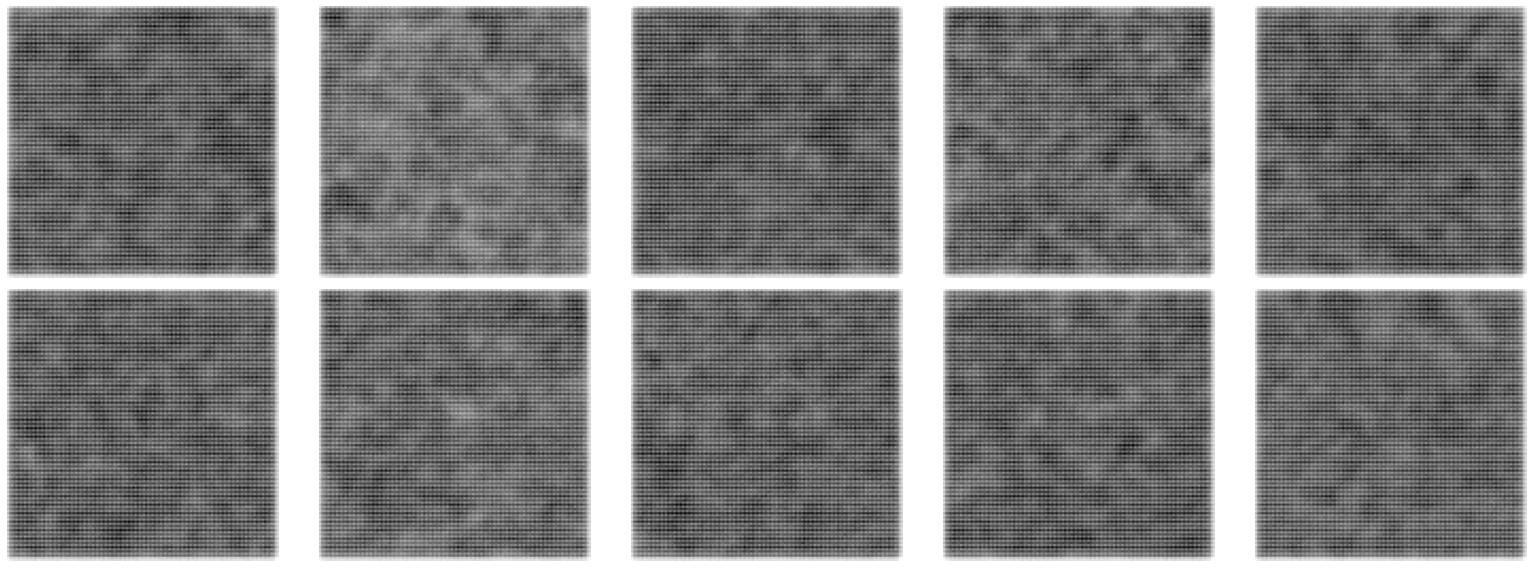

  0%|                                                                                         | 0/3750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


  0%|                                                                               | 1/3750 [00:01<1:31:56,  1.47s/it]

1/1 [==============================] - 0s 126ms/step


  0%|                                                                               | 2/3750 [00:02<1:33:09,  1.49s/it]

1/1 [==============================] - 0s 127ms/step


  0%|                                                                               | 3/3750 [00:04<1:34:28,  1.51s/it]

1/1 [==============================] - 0s 153ms/step


  0%|                                                                               | 4/3750 [00:06<1:37:30,  1.56s/it]

1/1 [==============================] - 0s 137ms/step


  0%|                                                                               | 5/3750 [00:07<1:37:03,  1.56s/it]

1/1 [==============================] - 0s 123ms/step


  0%|▏                                                                              | 6/3750 [00:09<1:36:06,  1.54s/it]

1/1 [==============================] - 0s 124ms/step


  0%|▏                                                                              | 7/3750 [00:10<1:35:06,  1.52s/it]

1/1 [==============================] - 0s 129ms/step


  0%|▏                                                                              | 8/3750 [00:12<1:34:59,  1.52s/it]

1/1 [==============================] - 0s 124ms/step


  0%|▏                                                                              | 9/3750 [00:13<1:34:40,  1.52s/it]

1/1 [==============================] - 0s 119ms/step


  0%|▏                                                                             | 10/3750 [00:15<1:34:08,  1.51s/it]

1/1 [==============================] - 0s 137ms/step


  0%|▏                                                                             | 11/3750 [00:16<1:34:08,  1.51s/it]

1/1 [==============================] - 0s 131ms/step


  0%|▏                                                                             | 12/3750 [00:18<1:33:58,  1.51s/it]

1/1 [==============================] - 0s 113ms/step


  0%|▎                                                                             | 13/3750 [00:19<1:33:13,  1.50s/it]

1/1 [==============================] - 0s 122ms/step


  0%|▎                                                                             | 14/3750 [00:21<1:33:59,  1.51s/it]

1/1 [==============================] - 0s 126ms/step


  0%|▎                                                                             | 15/3750 [00:22<1:34:46,  1.52s/it]

1/1 [==============================] - 0s 132ms/step


  0%|▎                                                                             | 16/3750 [00:24<1:34:27,  1.52s/it]

1/1 [==============================] - 0s 130ms/step


  0%|▎                                                                             | 17/3750 [00:25<1:34:23,  1.52s/it]

1/1 [==============================] - 0s 123ms/step


  0%|▎                                                                             | 18/3750 [00:27<1:34:06,  1.51s/it]

1/1 [==============================] - 0s 132ms/step


  1%|▍                                                                             | 19/3750 [00:28<1:34:24,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  1%|▍                                                                             | 20/3750 [00:30<1:34:28,  1.52s/it]

1/1 [==============================] - 0s 137ms/step


  1%|▍                                                                             | 21/3750 [00:31<1:34:43,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  1%|▍                                                                             | 22/3750 [00:33<1:34:25,  1.52s/it]

1/1 [==============================] - 0s 136ms/step


  1%|▍                                                                             | 23/3750 [00:34<1:33:48,  1.51s/it]

1/1 [==============================] - 0s 120ms/step


  1%|▍                                                                             | 24/3750 [00:36<1:33:53,  1.51s/it]

1/1 [==============================] - 0s 122ms/step


  1%|▌                                                                             | 25/3750 [00:37<1:33:58,  1.51s/it]

1/1 [==============================] - 0s 131ms/step


  1%|▌                                                                             | 26/3750 [00:39<1:33:56,  1.51s/it]

1/1 [==============================] - 0s 124ms/step


  1%|▌                                                                             | 27/3750 [00:40<1:33:25,  1.51s/it]

1/1 [==============================] - 0s 125ms/step


  1%|▌                                                                             | 28/3750 [00:42<1:35:08,  1.53s/it]

1/1 [==============================] - 0s 130ms/step


  1%|▌                                                                             | 29/3750 [00:44<1:33:45,  1.51s/it]

1/1 [==============================] - 0s 129ms/step


  1%|▌                                                                             | 30/3750 [00:45<1:33:11,  1.50s/it]

1/1 [==============================] - 0s 115ms/step


  1%|▋                                                                             | 31/3750 [00:46<1:32:43,  1.50s/it]

1/1 [==============================] - 0s 124ms/step


  1%|▋                                                                             | 32/3750 [00:48<1:32:24,  1.49s/it]

1/1 [==============================] - 0s 127ms/step


  1%|▋                                                                             | 33/3750 [00:49<1:31:55,  1.48s/it]

1/1 [==============================] - 0s 117ms/step


  1%|▋                                                                             | 34/3750 [00:51<1:31:53,  1.48s/it]

1/1 [==============================] - 0s 125ms/step


  1%|▋                                                                             | 35/3750 [00:52<1:31:58,  1.49s/it]

1/1 [==============================] - 0s 136ms/step


  1%|▋                                                                             | 36/3750 [00:54<1:34:04,  1.52s/it]

1/1 [==============================] - 0s 154ms/step


  1%|▊                                                                             | 37/3750 [00:56<1:36:25,  1.56s/it]

1/1 [==============================] - 0s 115ms/step


  1%|▊                                                                             | 38/3750 [00:57<1:35:24,  1.54s/it]

1/1 [==============================] - 0s 113ms/step


  1%|▊                                                                             | 39/3750 [00:59<1:35:50,  1.55s/it]

1/1 [==============================] - 0s 137ms/step


  1%|▊                                                                             | 40/3750 [01:00<1:35:24,  1.54s/it]

1/1 [==============================] - 0s 132ms/step


  1%|▊                                                                             | 41/3750 [01:02<1:35:42,  1.55s/it]

1/1 [==============================] - 0s 133ms/step


  1%|▊                                                                             | 42/3750 [01:03<1:35:44,  1.55s/it]

1/1 [==============================] - 0s 134ms/step


  1%|▉                                                                             | 43/3750 [01:05<1:34:59,  1.54s/it]

1/1 [==============================] - 0s 126ms/step


  1%|▉                                                                             | 44/3750 [01:06<1:34:51,  1.54s/it]

1/1 [==============================] - 0s 128ms/step


  1%|▉                                                                             | 45/3750 [01:08<1:35:02,  1.54s/it]

1/1 [==============================] - 0s 128ms/step


  1%|▉                                                                             | 46/3750 [01:10<1:36:40,  1.57s/it]

1/1 [==============================] - 0s 144ms/step


  1%|▉                                                                             | 47/3750 [01:11<1:37:56,  1.59s/it]

1/1 [==============================] - 0s 135ms/step


  1%|▉                                                                             | 48/3750 [01:13<1:37:34,  1.58s/it]

1/1 [==============================] - 0s 136ms/step


  1%|█                                                                             | 49/3750 [01:14<1:36:53,  1.57s/it]

1/1 [==============================] - 0s 129ms/step


  1%|█                                                                             | 50/3750 [01:16<1:37:14,  1.58s/it]

1/1 [==============================] - 0s 160ms/step


  1%|█                                                                             | 51/3750 [01:17<1:36:13,  1.56s/it]

1/1 [==============================] - 0s 123ms/step


  1%|█                                                                             | 52/3750 [01:19<1:36:13,  1.56s/it]

1/1 [==============================] - 0s 117ms/step


  1%|█                                                                             | 53/3750 [01:20<1:34:42,  1.54s/it]

1/1 [==============================] - 0s 124ms/step


  1%|█                                                                             | 54/3750 [01:22<1:34:03,  1.53s/it]

1/1 [==============================] - 0s 132ms/step


  1%|█▏                                                                            | 55/3750 [01:24<1:34:33,  1.54s/it]

1/1 [==============================] - 0s 114ms/step


  1%|█▏                                                                            | 56/3750 [01:25<1:34:20,  1.53s/it]

1/1 [==============================] - 0s 126ms/step


  2%|█▏                                                                            | 57/3750 [01:27<1:34:40,  1.54s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▏                                                                            | 58/3750 [01:28<1:33:40,  1.52s/it]

1/1 [==============================] - 0s 124ms/step


  2%|█▏                                                                            | 59/3750 [01:30<1:33:30,  1.52s/it]

1/1 [==============================] - 0s 114ms/step


  2%|█▏                                                                            | 60/3750 [01:31<1:34:44,  1.54s/it]

1/1 [==============================] - 0s 122ms/step


  2%|█▎                                                                            | 61/3750 [01:33<1:35:36,  1.56s/it]

1/1 [==============================] - 0s 130ms/step


  2%|█▎                                                                            | 62/3750 [01:34<1:34:32,  1.54s/it]

1/1 [==============================] - 0s 130ms/step


  2%|█▎                                                                            | 63/3750 [01:36<1:34:13,  1.53s/it]

1/1 [==============================] - 0s 127ms/step


  2%|█▎                                                                            | 64/3750 [01:37<1:33:30,  1.52s/it]

1/1 [==============================] - 0s 123ms/step


  2%|█▎                                                                            | 65/3750 [01:39<1:32:41,  1.51s/it]

1/1 [==============================] - 0s 118ms/step


  2%|█▎                                                                            | 66/3750 [01:40<1:33:01,  1.51s/it]

1/1 [==============================] - 0s 129ms/step


  2%|█▍                                                                            | 67/3750 [01:42<1:32:46,  1.51s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▍                                                                            | 68/3750 [01:43<1:32:15,  1.50s/it]

1/1 [==============================] - 0s 123ms/step


  2%|█▍                                                                            | 69/3750 [01:45<1:32:31,  1.51s/it]

1/1 [==============================] - 0s 110ms/step


  2%|█▍                                                                            | 70/3750 [01:46<1:32:05,  1.50s/it]

1/1 [==============================] - 0s 126ms/step


  2%|█▍                                                                            | 71/3750 [01:48<1:31:36,  1.49s/it]

1/1 [==============================] - 0s 125ms/step


  2%|█▍                                                                            | 72/3750 [01:49<1:32:08,  1.50s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▌                                                                            | 73/3750 [01:51<1:31:28,  1.49s/it]

1/1 [==============================] - 0s 111ms/step


  2%|█▌                                                                            | 74/3750 [01:52<1:30:59,  1.49s/it]

1/1 [==============================] - 0s 121ms/step


  2%|█▌                                                                            | 75/3750 [01:54<1:31:01,  1.49s/it]

1/1 [==============================] - 0s 129ms/step


  2%|█▌                                                                            | 76/3750 [01:55<1:31:13,  1.49s/it]

1/1 [==============================] - 0s 134ms/step


  2%|█▌                                                                            | 77/3750 [01:57<1:31:25,  1.49s/it]

1/1 [==============================] - 0s 108ms/step


  2%|█▌                                                                            | 78/3750 [01:58<1:31:31,  1.50s/it]

1/1 [==============================] - 0s 126ms/step


  2%|█▋                                                                            | 79/3750 [02:00<1:30:27,  1.48s/it]

1/1 [==============================] - 0s 120ms/step


  2%|█▋                                                                            | 80/3750 [02:01<1:30:12,  1.47s/it]

1/1 [==============================] - 0s 123ms/step


  2%|█▋                                                                            | 81/3750 [02:03<1:31:06,  1.49s/it]

1/1 [==============================] - 0s 117ms/step


  2%|█▋                                                                            | 82/3750 [02:04<1:30:23,  1.48s/it]

1/1 [==============================] - 0s 114ms/step


  2%|█▋                                                                            | 83/3750 [02:06<1:30:03,  1.47s/it]

1/1 [==============================] - 0s 123ms/step


  2%|█▋                                                                            | 84/3750 [02:07<1:30:31,  1.48s/it]

1/1 [==============================] - 0s 117ms/step


  2%|█▊                                                                            | 85/3750 [02:09<1:30:21,  1.48s/it]

1/1 [==============================] - 0s 131ms/step


  2%|█▊                                                                            | 86/3750 [02:10<1:30:17,  1.48s/it]

1/1 [==============================] - 0s 150ms/step


  2%|█▊                                                                            | 87/3750 [02:12<1:30:50,  1.49s/it]

1/1 [==============================] - 0s 124ms/step


  2%|█▊                                                                            | 88/3750 [02:13<1:30:41,  1.49s/it]

1/1 [==============================] - 0s 112ms/step


  2%|█▊                                                                            | 89/3750 [02:14<1:30:41,  1.49s/it]

1/1 [==============================] - 0s 130ms/step


  2%|█▊                                                                            | 90/3750 [02:16<1:31:16,  1.50s/it]

1/1 [==============================] - 0s 138ms/step


  2%|█▉                                                                            | 91/3750 [02:18<1:31:42,  1.50s/it]

1/1 [==============================] - 0s 135ms/step


  2%|█▉                                                                            | 92/3750 [02:19<1:31:50,  1.51s/it]

1/1 [==============================] - 0s 134ms/step


  2%|█▉                                                                            | 93/3750 [02:21<1:32:17,  1.51s/it]

1/1 [==============================] - 0s 119ms/step


  3%|█▉                                                                            | 94/3750 [02:22<1:31:41,  1.50s/it]

1/1 [==============================] - 0s 128ms/step


  3%|█▉                                                                            | 95/3750 [02:24<1:30:55,  1.49s/it]

1/1 [==============================] - 0s 128ms/step


  3%|█▉                                                                            | 96/3750 [02:25<1:30:20,  1.48s/it]

1/1 [==============================] - 0s 111ms/step


  3%|██                                                                            | 97/3750 [02:26<1:30:21,  1.48s/it]

1/1 [==============================] - 0s 118ms/step


  3%|██                                                                            | 98/3750 [02:28<1:30:10,  1.48s/it]

1/1 [==============================] - 0s 125ms/step


  3%|██                                                                            | 99/3750 [02:29<1:30:10,  1.48s/it]

1/1 [==============================] - 0s 114ms/step


  3%|██                                                                           | 100/3750 [02:31<1:30:41,  1.49s/it]

1/1 [==============================] - 0s 119ms/step


  3%|██                                                                           | 101/3750 [02:32<1:30:16,  1.48s/it]

1/1 [==============================] - 0s 131ms/step


  3%|██                                                                           | 102/3750 [02:34<1:32:03,  1.51s/it]

1/1 [==============================] - 0s 125ms/step


  3%|██                                                                           | 103/3750 [02:36<1:31:55,  1.51s/it]

1/1 [==============================] - 0s 112ms/step


  3%|██▏                                                                          | 104/3750 [02:37<1:32:57,  1.53s/it]

1/1 [==============================] - 0s 112ms/step


  3%|██▏                                                                          | 105/3750 [02:39<1:32:35,  1.52s/it]

1/1 [==============================] - 0s 124ms/step


  3%|██▏                                                                          | 106/3750 [02:40<1:32:28,  1.52s/it]

1/1 [==============================] - 0s 129ms/step


  3%|██▏                                                                          | 107/3750 [02:42<1:32:01,  1.52s/it]

1/1 [==============================] - 0s 135ms/step


  3%|██▏                                                                          | 108/3750 [02:43<1:32:29,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  3%|██▏                                                                          | 109/3750 [02:45<1:32:10,  1.52s/it]

1/1 [==============================] - 0s 126ms/step


  3%|██▎                                                                          | 110/3750 [02:46<1:31:56,  1.52s/it]

1/1 [==============================] - 0s 128ms/step


  3%|██▎                                                                          | 111/3750 [02:48<1:32:02,  1.52s/it]

1/1 [==============================] - 0s 124ms/step


  3%|██▎                                                                          | 112/3750 [02:49<1:32:20,  1.52s/it]

1/1 [==============================] - 0s 120ms/step


  3%|██▎                                                                          | 113/3750 [02:51<1:32:03,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  3%|██▎                                                                          | 114/3750 [02:52<1:31:48,  1.51s/it]

1/1 [==============================] - 0s 124ms/step


  3%|██▎                                                                          | 115/3750 [02:54<1:32:20,  1.52s/it]

1/1 [==============================] - 0s 126ms/step


  3%|██▍                                                                          | 116/3750 [02:55<1:31:54,  1.52s/it]

1/1 [==============================] - 0s 117ms/step


  3%|██▍                                                                          | 117/3750 [02:57<1:31:55,  1.52s/it]

1/1 [==============================] - 0s 128ms/step


  3%|██▍                                                                          | 118/3750 [02:58<1:31:47,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  3%|██▍                                                                          | 119/3750 [03:00<1:31:20,  1.51s/it]

1/1 [==============================] - 0s 130ms/step


  3%|██▍                                                                          | 120/3750 [03:01<1:31:45,  1.52s/it]

1/1 [==============================] - 0s 126ms/step


  3%|██▍                                                                          | 121/3750 [03:03<1:32:00,  1.52s/it]

1/1 [==============================] - 0s 141ms/step


  3%|██▌                                                                          | 122/3750 [03:04<1:32:10,  1.52s/it]

1/1 [==============================] - 0s 114ms/step


  3%|██▌                                                                          | 123/3750 [03:06<1:31:40,  1.52s/it]

1/1 [==============================] - 0s 140ms/step


  3%|██▌                                                                          | 124/3750 [03:07<1:32:01,  1.52s/it]

1/1 [==============================] - 0s 113ms/step


  3%|██▌                                                                          | 125/3750 [03:09<1:31:49,  1.52s/it]

1/1 [==============================] - 0s 124ms/step


  3%|██▌                                                                          | 126/3750 [03:10<1:31:57,  1.52s/it]

1/1 [==============================] - 0s 141ms/step


  3%|██▌                                                                          | 127/3750 [03:12<1:32:36,  1.53s/it]

1/1 [==============================] - 0s 119ms/step


  3%|██▋                                                                          | 128/3750 [03:14<1:32:11,  1.53s/it]

1/1 [==============================] - 0s 130ms/step


  3%|██▋                                                                          | 129/3750 [03:15<1:31:37,  1.52s/it]

1/1 [==============================] - 0s 165ms/step


  3%|██▋                                                                          | 130/3750 [03:17<1:34:21,  1.56s/it]

1/1 [==============================] - 0s 135ms/step


  3%|██▋                                                                          | 131/3750 [03:18<1:34:57,  1.57s/it]

1/1 [==============================] - 0s 127ms/step


  4%|██▋                                                                          | 132/3750 [03:20<1:34:22,  1.57s/it]

1/1 [==============================] - 0s 123ms/step


  4%|██▋                                                                          | 133/3750 [03:21<1:33:45,  1.56s/it]

1/1 [==============================] - 0s 138ms/step


  4%|██▊                                                                          | 134/3750 [03:23<1:34:36,  1.57s/it]

1/1 [==============================] - 0s 127ms/step


  4%|██▊                                                                          | 135/3750 [03:25<1:33:52,  1.56s/it]

1/1 [==============================] - 0s 126ms/step


  4%|██▊                                                                          | 136/3750 [03:26<1:33:49,  1.56s/it]

1/1 [==============================] - 0s 127ms/step


  4%|██▊                                                                          | 137/3750 [03:28<1:33:01,  1.54s/it]

1/1 [==============================] - 0s 125ms/step


  4%|██▊                                                                          | 138/3750 [03:29<1:32:22,  1.53s/it]

1/1 [==============================] - 0s 125ms/step


  4%|██▊                                                                          | 139/3750 [03:31<1:32:29,  1.54s/it]

1/1 [==============================] - 0s 115ms/step


  4%|██▊                                                                          | 140/3750 [03:32<1:33:04,  1.55s/it]

1/1 [==============================] - 0s 137ms/step


  4%|██▉                                                                          | 141/3750 [03:34<1:33:39,  1.56s/it]

1/1 [==============================] - 0s 125ms/step


  4%|██▉                                                                          | 142/3750 [03:35<1:32:48,  1.54s/it]

1/1 [==============================] - 0s 125ms/step


  4%|██▉                                                                          | 143/3750 [03:37<1:33:12,  1.55s/it]

1/1 [==============================] - 0s 116ms/step


  4%|██▉                                                                          | 144/3750 [03:38<1:32:30,  1.54s/it]

1/1 [==============================] - 0s 118ms/step


  4%|██▉                                                                          | 145/3750 [03:40<1:32:12,  1.53s/it]

1/1 [==============================] - 0s 114ms/step


  4%|██▉                                                                          | 146/3750 [03:41<1:31:44,  1.53s/it]

1/1 [==============================] - 0s 124ms/step


  4%|███                                                                          | 147/3750 [03:43<1:31:28,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  4%|███                                                                          | 148/3750 [03:44<1:31:30,  1.52s/it]

1/1 [==============================] - 0s 118ms/step


  4%|███                                                                          | 149/3750 [03:46<1:31:33,  1.53s/it]

1/1 [==============================] - 0s 121ms/step


  4%|███                                                                          | 150/3750 [03:48<1:31:36,  1.53s/it]

1/1 [==============================] - 0s 123ms/step


  4%|███                                                                          | 151/3750 [03:49<1:31:40,  1.53s/it]

1/1 [==============================] - 0s 117ms/step


  4%|███                                                                          | 152/3750 [03:51<1:31:44,  1.53s/it]

1/1 [==============================] - 0s 118ms/step


  4%|███▏                                                                         | 153/3750 [03:52<1:31:25,  1.52s/it]

1/1 [==============================] - 0s 130ms/step


  4%|███▏                                                                         | 154/3750 [03:54<1:31:20,  1.52s/it]

1/1 [==============================] - 0s 125ms/step


  4%|███▏                                                                         | 155/3750 [03:55<1:32:18,  1.54s/it]

1/1 [==============================] - 0s 117ms/step


  4%|███▏                                                                         | 156/3750 [03:57<1:32:14,  1.54s/it]

1/1 [==============================] - 0s 133ms/step


  4%|███▏                                                                         | 157/3750 [03:58<1:31:34,  1.53s/it]

1/1 [==============================] - 0s 125ms/step


  4%|███▏                                                                         | 158/3750 [04:00<1:31:01,  1.52s/it]

1/1 [==============================] - 0s 125ms/step


  4%|███▎                                                                         | 159/3750 [04:01<1:31:07,  1.52s/it]

1/1 [==============================] - 0s 141ms/step


  4%|███▎                                                                         | 160/3750 [04:03<1:32:12,  1.54s/it]

1/1 [==============================] - 0s 132ms/step


  4%|███▎                                                                         | 161/3750 [04:04<1:31:49,  1.54s/it]

1/1 [==============================] - 0s 119ms/step


  4%|███▎                                                                         | 162/3750 [04:06<1:31:13,  1.53s/it]

1/1 [==============================] - 0s 125ms/step


  4%|███▎                                                                         | 163/3750 [04:07<1:31:00,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  4%|███▎                                                                         | 164/3750 [04:09<1:32:10,  1.54s/it]

1/1 [==============================] - 0s 117ms/step


  4%|███▍                                                                         | 165/3750 [04:10<1:31:04,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  4%|███▍                                                                         | 166/3750 [04:12<1:30:56,  1.52s/it]

1/1 [==============================] - 0s 119ms/step


  4%|███▍                                                                         | 167/3750 [04:14<1:31:05,  1.53s/it]

1/1 [==============================] - 0s 122ms/step


  4%|███▍                                                                         | 168/3750 [04:15<1:31:18,  1.53s/it]

1/1 [==============================] - 0s 129ms/step


  5%|███▍                                                                         | 169/3750 [04:17<1:32:07,  1.54s/it]

1/1 [==============================] - 0s 128ms/step


  5%|███▍                                                                         | 170/3750 [04:18<1:31:39,  1.54s/it]

1/1 [==============================] - 0s 122ms/step


  5%|███▌                                                                         | 171/3750 [04:20<1:31:59,  1.54s/it]

1/1 [==============================] - 0s 116ms/step


  5%|███▌                                                                         | 172/3750 [04:21<1:32:10,  1.55s/it]

1/1 [==============================] - 0s 123ms/step


  5%|███▌                                                                         | 173/3750 [04:23<1:32:07,  1.55s/it]

1/1 [==============================] - 0s 127ms/step


  5%|███▌                                                                         | 174/3750 [04:24<1:31:41,  1.54s/it]

1/1 [==============================] - 0s 130ms/step


  5%|███▌                                                                         | 175/3750 [04:26<1:32:01,  1.54s/it]

1/1 [==============================] - 0s 127ms/step


  5%|███▌                                                                         | 176/3750 [04:27<1:32:47,  1.56s/it]

1/1 [==============================] - 0s 131ms/step


  5%|███▋                                                                         | 177/3750 [04:29<1:33:41,  1.57s/it]

1/1 [==============================] - 0s 131ms/step


  5%|███▋                                                                         | 178/3750 [04:31<1:35:22,  1.60s/it]

1/1 [==============================] - 0s 125ms/step


  5%|███▋                                                                         | 179/3750 [04:32<1:34:56,  1.60s/it]

1/1 [==============================] - 0s 124ms/step


  5%|███▋                                                                         | 180/3750 [04:34<1:33:46,  1.58s/it]

1/1 [==============================] - 0s 119ms/step


  5%|███▋                                                                         | 181/3750 [04:35<1:33:13,  1.57s/it]

1/1 [==============================] - 0s 128ms/step


  5%|███▋                                                                         | 182/3750 [04:37<1:32:50,  1.56s/it]

1/1 [==============================] - 0s 124ms/step


  5%|███▊                                                                         | 183/3750 [04:38<1:32:10,  1.55s/it]

1/1 [==============================] - 0s 124ms/step


  5%|███▊                                                                         | 184/3750 [04:40<1:32:01,  1.55s/it]

1/1 [==============================] - 0s 135ms/step


  5%|███▊                                                                         | 185/3750 [04:42<1:31:49,  1.55s/it]

1/1 [==============================] - 0s 130ms/step


  5%|███▊                                                                         | 186/3750 [04:43<1:32:19,  1.55s/it]

1/1 [==============================] - 0s 127ms/step


  5%|███▊                                                                         | 187/3750 [04:45<1:32:44,  1.56s/it]

1/1 [==============================] - 0s 124ms/step


  5%|███▊                                                                         | 188/3750 [04:46<1:31:50,  1.55s/it]

1/1 [==============================] - 0s 133ms/step


  5%|███▉                                                                         | 189/3750 [04:48<1:31:21,  1.54s/it]

1/1 [==============================] - 0s 125ms/step


  5%|███▉                                                                         | 190/3750 [04:49<1:31:03,  1.53s/it]

1/1 [==============================] - 0s 127ms/step


  5%|███▉                                                                         | 191/3750 [04:51<1:31:49,  1.55s/it]

1/1 [==============================] - 0s 136ms/step


  5%|███▉                                                                         | 192/3750 [04:52<1:31:54,  1.55s/it]

1/1 [==============================] - 0s 127ms/step


  5%|███▉                                                                         | 193/3750 [04:54<1:32:14,  1.56s/it]

1/1 [==============================] - 0s 123ms/step


  5%|███▉                                                                         | 194/3750 [04:56<1:32:10,  1.56s/it]

1/1 [==============================] - 0s 117ms/step


  5%|████                                                                         | 195/3750 [04:57<1:31:49,  1.55s/it]

1/1 [==============================] - 0s 125ms/step


  5%|████                                                                         | 196/3750 [04:59<1:31:41,  1.55s/it]

1/1 [==============================] - 0s 122ms/step


  5%|████                                                                         | 197/3750 [05:00<1:32:29,  1.56s/it]

1/1 [==============================] - 0s 127ms/step


  5%|████                                                                         | 198/3750 [05:02<1:31:46,  1.55s/it]

1/1 [==============================] - 0s 114ms/step


  5%|████                                                                         | 199/3750 [05:03<1:32:16,  1.56s/it]

1/1 [==============================] - 0s 126ms/step


  5%|████                                                                         | 200/3750 [05:05<1:31:46,  1.55s/it]

1/1 [==============================] - 0s 120ms/step


  5%|████▏                                                                        | 201/3750 [05:06<1:31:31,  1.55s/it]

1/1 [==============================] - 0s 131ms/step


  5%|████▏                                                                        | 202/3750 [05:08<1:32:17,  1.56s/it]

1/1 [==============================] - 0s 116ms/step


  5%|████▏                                                                        | 203/3750 [05:10<1:31:44,  1.55s/it]

1/1 [==============================] - 0s 114ms/step


  5%|████▏                                                                        | 204/3750 [05:11<1:31:23,  1.55s/it]

1/1 [==============================] - 0s 121ms/step


  5%|████▏                                                                        | 205/3750 [05:13<1:32:39,  1.57s/it]

1/1 [==============================] - 0s 128ms/step


  5%|████▏                                                                        | 206/3750 [05:14<1:32:27,  1.57s/it]

1/1 [==============================] - 0s 120ms/step


  6%|████▎                                                                        | 207/3750 [05:16<1:33:47,  1.59s/it]

1/1 [==============================] - 0s 142ms/step


  6%|████▎                                                                        | 208/3750 [05:17<1:33:13,  1.58s/it]

1/1 [==============================] - 0s 131ms/step


  6%|████▎                                                                        | 209/3750 [05:19<1:32:30,  1.57s/it]

1/1 [==============================] - 0s 122ms/step


  6%|████▎                                                                        | 210/3750 [05:21<1:32:49,  1.57s/it]

1/1 [==============================] - 0s 131ms/step


  6%|████▎                                                                        | 211/3750 [05:22<1:32:16,  1.56s/it]

1/1 [==============================] - 0s 133ms/step


  6%|████▎                                                                        | 212/3750 [05:24<1:32:24,  1.57s/it]

1/1 [==============================] - 0s 138ms/step


  6%|████▎                                                                        | 213/3750 [05:25<1:32:10,  1.56s/it]

1/1 [==============================] - 0s 119ms/step


  6%|████▍                                                                        | 214/3750 [05:27<1:31:48,  1.56s/it]

1/1 [==============================] - 0s 129ms/step


  6%|████▍                                                                        | 215/3750 [05:28<1:31:54,  1.56s/it]

1/1 [==============================] - 0s 130ms/step


  6%|████▍                                                                        | 216/3750 [05:30<1:32:35,  1.57s/it]

1/1 [==============================] - 0s 123ms/step


  6%|████▍                                                                        | 217/3750 [05:31<1:31:51,  1.56s/it]

1/1 [==============================] - 0s 153ms/step


  6%|████▍                                                                        | 218/3750 [05:33<1:32:08,  1.57s/it]

1/1 [==============================] - 0s 131ms/step


  6%|████▍                                                                        | 219/3750 [05:35<1:33:10,  1.58s/it]

1/1 [==============================] - 0s 123ms/step


  6%|████▌                                                                        | 220/3750 [05:36<1:33:28,  1.59s/it]

1/1 [==============================] - 0s 129ms/step


  6%|████▌                                                                        | 221/3750 [05:38<1:33:57,  1.60s/it]

1/1 [==============================] - 0s 143ms/step


  6%|████▌                                                                        | 222/3750 [05:39<1:33:18,  1.59s/it]

1/1 [==============================] - 0s 128ms/step


  6%|████▌                                                                        | 223/3750 [05:41<1:32:43,  1.58s/it]

1/1 [==============================] - 0s 129ms/step


  6%|████▌                                                                        | 224/3750 [05:43<1:32:11,  1.57s/it]

1/1 [==============================] - 0s 128ms/step


  6%|████▌                                                                        | 225/3750 [05:44<1:31:13,  1.55s/it]

1/1 [==============================] - 0s 128ms/step


  6%|████▋                                                                        | 226/3750 [05:46<1:30:16,  1.54s/it]

1/1 [==============================] - 0s 126ms/step


  6%|████▋                                                                        | 227/3750 [05:47<1:30:40,  1.54s/it]

1/1 [==============================] - 0s 128ms/step


  6%|████▋                                                                        | 228/3750 [05:49<1:29:55,  1.53s/it]

1/1 [==============================] - 0s 122ms/step


  6%|████▋                                                                        | 229/3750 [05:50<1:29:31,  1.53s/it]

1/1 [==============================] - 0s 128ms/step


  6%|████▋                                                                        | 230/3750 [05:52<1:29:17,  1.52s/it]

1/1 [==============================] - 0s 128ms/step


  6%|████▋                                                                        | 231/3750 [05:53<1:29:15,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  6%|████▊                                                                        | 232/3750 [05:55<1:29:11,  1.52s/it]

1/1 [==============================] - 0s 125ms/step


  6%|████▊                                                                        | 233/3750 [05:56<1:29:08,  1.52s/it]

1/1 [==============================] - 0s 129ms/step


  6%|████▊                                                                        | 234/3750 [05:58<1:29:06,  1.52s/it]

1/1 [==============================] - 0s 129ms/step


  6%|████▊                                                                        | 235/3750 [05:59<1:29:06,  1.52s/it]

1/1 [==============================] - 0s 132ms/step


  6%|████▊                                                                        | 236/3750 [06:01<1:28:49,  1.52s/it]

1/1 [==============================] - 0s 127ms/step


  6%|████▊                                                                        | 237/3750 [06:02<1:28:28,  1.51s/it]

1/1 [==============================] - 0s 128ms/step


  6%|████▉                                                                        | 238/3750 [06:04<1:29:34,  1.53s/it]

1/1 [==============================] - 0s 114ms/step


  6%|████▉                                                                        | 239/3750 [06:05<1:29:09,  1.52s/it]

1/1 [==============================] - 0s 126ms/step


  6%|████▉                                                                        | 240/3750 [06:07<1:28:38,  1.52s/it]

1/1 [==============================] - 0s 134ms/step


  6%|████▉                                                                        | 241/3750 [06:08<1:29:24,  1.53s/it]

1/1 [==============================] - 0s 134ms/step


  6%|████▉                                                                        | 242/3750 [06:10<1:29:37,  1.53s/it]

1/1 [==============================] - 0s 129ms/step


  6%|████▉                                                                        | 243/3750 [06:11<1:29:24,  1.53s/it]

1/1 [==============================] - 0s 114ms/step


  7%|█████                                                                        | 244/3750 [06:13<1:29:12,  1.53s/it]

1/1 [==============================] - 0s 133ms/step


  7%|█████                                                                        | 245/3750 [06:15<1:29:52,  1.54s/it]

1/1 [==============================] - 0s 119ms/step


  7%|█████                                                                        | 246/3750 [06:16<1:29:16,  1.53s/it]

1/1 [==============================] - 0s 124ms/step


  7%|█████                                                                        | 247/3750 [06:18<1:29:46,  1.54s/it]

1/1 [==============================] - 0s 129ms/step


  7%|█████                                                                        | 248/3750 [06:19<1:30:02,  1.54s/it]

1/1 [==============================] - 0s 119ms/step


  7%|█████                                                                        | 249/3750 [06:21<1:30:32,  1.55s/it]

1/1 [==============================] - 0s 122ms/step


  7%|█████▏                                                                       | 250/3750 [06:22<1:31:01,  1.56s/it]

1/1 [==============================] - 0s 126ms/step


  7%|█████▏                                                                       | 251/3750 [06:24<1:30:09,  1.55s/it]

1/1 [==============================] - 0s 119ms/step


  7%|█████▏                                                                       | 252/3750 [06:25<1:30:19,  1.55s/it]

1/1 [==============================] - 0s 113ms/step


  7%|█████▏                                                                       | 253/3750 [06:27<1:29:28,  1.54s/it]

1/1 [==============================] - 0s 128ms/step


  7%|█████▏                                                                       | 254/3750 [06:28<1:29:25,  1.53s/it]

1/1 [==============================] - 0s 127ms/step


  7%|█████▏                                                                       | 255/3750 [06:30<1:29:19,  1.53s/it]

1/1 [==============================] - 0s 142ms/step


  7%|█████▎                                                                       | 256/3750 [06:32<1:30:27,  1.55s/it]

1/1 [==============================] - 0s 130ms/step


  7%|█████▎                                                                       | 257/3750 [06:33<1:30:31,  1.56s/it]

1/1 [==============================] - 0s 117ms/step


  7%|█████▎                                                                       | 258/3750 [06:35<1:30:15,  1.55s/it]

1/1 [==============================] - 0s 130ms/step


  7%|█████▎                                                                       | 259/3750 [06:36<1:30:02,  1.55s/it]

1/1 [==============================] - 0s 115ms/step


  7%|█████▎                                                                       | 260/3750 [06:38<1:30:31,  1.56s/it]

1/1 [==============================] - 0s 128ms/step


  7%|█████▎                                                                       | 261/3750 [06:39<1:31:12,  1.57s/it]

1/1 [==============================] - 0s 133ms/step


  7%|█████▍                                                                       | 262/3750 [06:41<1:32:56,  1.60s/it]

1/1 [==============================] - 0s 131ms/step


  7%|█████▍                                                                       | 263/3750 [06:43<1:32:22,  1.59s/it]

1/1 [==============================] - 0s 129ms/step


  7%|█████▍                                                                       | 264/3750 [06:44<1:32:34,  1.59s/it]

1/1 [==============================] - 0s 116ms/step


  7%|█████▍                                                                       | 265/3750 [06:46<1:31:46,  1.58s/it]

1/1 [==============================] - 0s 130ms/step


  7%|█████▍                                                                       | 266/3750 [06:47<1:30:54,  1.57s/it]

1/1 [==============================] - 0s 118ms/step


  7%|█████▍                                                                       | 267/3750 [06:49<1:29:54,  1.55s/it]

1/1 [==============================] - 0s 129ms/step


  7%|█████▌                                                                       | 268/3750 [06:50<1:31:04,  1.57s/it]

1/1 [==============================] - 0s 130ms/step


  7%|█████▌                                                                       | 269/3750 [06:52<1:32:53,  1.60s/it]

1/1 [==============================] - 0s 156ms/step


  7%|█████▌                                                                       | 270/3750 [06:54<1:36:17,  1.66s/it]

1/1 [==============================] - 0s 126ms/step


  7%|█████▌                                                                       | 271/3750 [06:55<1:34:37,  1.63s/it]

1/1 [==============================] - 0s 133ms/step


  7%|█████▌                                                                       | 272/3750 [06:57<1:33:10,  1.61s/it]

1/1 [==============================] - 0s 136ms/step


  7%|█████▌                                                                       | 273/3750 [06:59<1:31:43,  1.58s/it]

1/1 [==============================] - 0s 124ms/step


  7%|█████▋                                                                       | 274/3750 [07:00<1:31:40,  1.58s/it]

1/1 [==============================] - 0s 114ms/step


  7%|█████▋                                                                       | 275/3750 [07:02<1:31:25,  1.58s/it]

1/1 [==============================] - 0s 130ms/step


  7%|█████▋                                                                       | 276/3750 [07:03<1:31:52,  1.59s/it]

1/1 [==============================] - 0s 130ms/step


  7%|█████▋                                                                       | 277/3750 [07:05<1:31:39,  1.58s/it]

1/1 [==============================] - 0s 133ms/step


  7%|█████▋                                                                       | 278/3750 [07:06<1:31:23,  1.58s/it]

1/1 [==============================] - 0s 127ms/step


  7%|█████▋                                                                       | 279/3750 [07:08<1:31:35,  1.58s/it]

1/1 [==============================] - 0s 117ms/step


  7%|█████▋                                                                       | 280/3750 [07:10<1:31:04,  1.57s/it]

1/1 [==============================] - 0s 131ms/step


  7%|█████▊                                                                       | 281/3750 [07:11<1:31:07,  1.58s/it]

1/1 [==============================] - 0s 123ms/step


  8%|█████▊                                                                       | 282/3750 [07:13<1:30:50,  1.57s/it]

1/1 [==============================] - 0s 130ms/step


  8%|█████▊                                                                       | 283/3750 [07:14<1:31:02,  1.58s/it]

1/1 [==============================] - 0s 121ms/step


  8%|█████▊                                                                       | 284/3750 [07:16<1:32:05,  1.59s/it]

1/1 [==============================] - 0s 147ms/step


  8%|█████▊                                                                       | 285/3750 [07:18<1:32:44,  1.61s/it]

1/1 [==============================] - 0s 124ms/step


  8%|█████▊                                                                       | 286/3750 [07:19<1:31:56,  1.59s/it]

1/1 [==============================] - 0s 146ms/step


  8%|█████▉                                                                       | 287/3750 [07:21<1:32:06,  1.60s/it]

1/1 [==============================] - 0s 128ms/step


  8%|█████▉                                                                       | 288/3750 [07:22<1:31:46,  1.59s/it]

1/1 [==============================] - 0s 124ms/step


  8%|█████▉                                                                       | 289/3750 [07:24<1:31:28,  1.59s/it]

1/1 [==============================] - 0s 124ms/step


  8%|█████▉                                                                       | 290/3750 [07:25<1:30:45,  1.57s/it]

1/1 [==============================] - 0s 122ms/step


  8%|█████▉                                                                       | 291/3750 [07:27<1:31:29,  1.59s/it]

1/1 [==============================] - 0s 120ms/step


  8%|█████▉                                                                       | 292/3750 [07:29<1:30:38,  1.57s/it]

1/1 [==============================] - 0s 130ms/step


  8%|██████                                                                       | 293/3750 [07:30<1:30:47,  1.58s/it]

1/1 [==============================] - 0s 124ms/step


  8%|██████                                                                       | 294/3750 [07:32<1:30:47,  1.58s/it]

1/1 [==============================] - 0s 139ms/step


  8%|██████                                                                       | 295/3750 [07:33<1:31:46,  1.59s/it]

1/1 [==============================] - 0s 140ms/step


  8%|██████                                                                       | 296/3750 [07:35<1:33:58,  1.63s/it]

1/1 [==============================] - 0s 158ms/step


  8%|██████                                                                       | 297/3750 [07:37<1:38:35,  1.71s/it]

1/1 [==============================] - 0s 159ms/step


  8%|██████                                                                       | 298/3750 [07:39<1:40:28,  1.75s/it]

1/1 [==============================] - 0s 156ms/step


  8%|██████▏                                                                      | 299/3750 [07:41<1:40:48,  1.75s/it]

1/1 [==============================] - 0s 154ms/step


  8%|██████▏                                                                      | 300/3750 [07:42<1:42:16,  1.78s/it]

1/1 [==============================] - 0s 151ms/step


  8%|██████▏                                                                      | 301/3750 [07:44<1:43:05,  1.79s/it]

1/1 [==============================] - 0s 152ms/step


  8%|██████▏                                                                      | 302/3750 [07:46<1:44:16,  1.81s/it]

1/1 [==============================] - 0s 157ms/step


  8%|██████▏                                                                      | 303/3750 [07:48<1:43:14,  1.80s/it]

1/1 [==============================] - 0s 150ms/step


  8%|██████▏                                                                      | 304/3750 [07:50<1:43:04,  1.79s/it]

1/1 [==============================] - 0s 153ms/step


  8%|██████▎                                                                      | 305/3750 [07:51<1:41:48,  1.77s/it]

1/1 [==============================] - 0s 140ms/step


  8%|██████▎                                                                      | 306/3750 [07:53<1:41:05,  1.76s/it]

1/1 [==============================] - 0s 128ms/step


  8%|██████▎                                                                      | 307/3750 [07:55<1:37:07,  1.69s/it]

1/1 [==============================] - 0s 144ms/step


  8%|██████▎                                                                      | 308/3750 [07:56<1:34:32,  1.65s/it]

1/1 [==============================] - 0s 118ms/step


  8%|██████▎                                                                      | 309/3750 [07:58<1:34:12,  1.64s/it]

1/1 [==============================] - 0s 121ms/step


  8%|██████▎                                                                      | 310/3750 [07:59<1:32:24,  1.61s/it]

1/1 [==============================] - 0s 126ms/step


  8%|██████▍                                                                      | 311/3750 [08:01<1:31:16,  1.59s/it]

1/1 [==============================] - 0s 137ms/step


  8%|██████▍                                                                      | 312/3750 [08:03<1:31:14,  1.59s/it]

1/1 [==============================] - 0s 120ms/step


  8%|██████▍                                                                      | 313/3750 [08:04<1:30:48,  1.59s/it]

1/1 [==============================] - 0s 129ms/step


  8%|██████▍                                                                      | 314/3750 [08:06<1:30:28,  1.58s/it]

1/1 [==============================] - 0s 125ms/step


  8%|██████▍                                                                      | 315/3750 [08:07<1:30:16,  1.58s/it]

1/1 [==============================] - 0s 127ms/step


  8%|██████▍                                                                      | 316/3750 [08:09<1:30:54,  1.59s/it]

1/1 [==============================] - 0s 130ms/step


  8%|██████▌                                                                      | 317/3750 [08:10<1:30:48,  1.59s/it]

1/1 [==============================] - 0s 130ms/step


  8%|██████▌                                                                      | 318/3750 [08:12<1:31:02,  1.59s/it]

1/1 [==============================] - 0s 126ms/step


  9%|██████▌                                                                      | 319/3750 [08:14<1:30:46,  1.59s/it]

1/1 [==============================] - 0s 122ms/step


  9%|██████▌                                                                      | 320/3750 [08:15<1:30:17,  1.58s/it]

1/1 [==============================] - 0s 130ms/step


  9%|██████▌                                                                      | 321/3750 [08:17<1:30:21,  1.58s/it]

1/1 [==============================] - 0s 129ms/step


  9%|██████▌                                                                      | 322/3750 [08:18<1:30:00,  1.58s/it]

1/1 [==============================] - 0s 128ms/step


  9%|██████▋                                                                      | 323/3750 [08:20<1:30:13,  1.58s/it]

1/1 [==============================] - 0s 130ms/step


  9%|██████▋                                                                      | 324/3750 [08:22<1:30:16,  1.58s/it]

1/1 [==============================] - 0s 122ms/step


  9%|██████▋                                                                      | 325/3750 [08:23<1:29:50,  1.57s/it]

1/1 [==============================] - 0s 130ms/step


  9%|██████▋                                                                      | 326/3750 [08:25<1:29:57,  1.58s/it]

1/1 [==============================] - 0s 118ms/step


  9%|██████▋                                                                      | 327/3750 [08:26<1:29:50,  1.57s/it]

1/1 [==============================] - 0s 117ms/step


  9%|██████▋                                                                      | 328/3750 [08:28<1:30:04,  1.58s/it]

1/1 [==============================] - 0s 128ms/step


  9%|██████▊                                                                      | 329/3750 [08:29<1:30:01,  1.58s/it]

1/1 [==============================] - 0s 131ms/step


  9%|██████▊                                                                      | 330/3750 [08:31<1:30:26,  1.59s/it]

1/1 [==============================] - 0s 125ms/step


  9%|██████▊                                                                      | 331/3750 [08:33<1:30:23,  1.59s/it]

1/1 [==============================] - 0s 123ms/step


  9%|██████▊                                                                      | 332/3750 [08:34<1:29:31,  1.57s/it]

1/1 [==============================] - 0s 123ms/step


  9%|██████▊                                                                      | 333/3750 [08:36<1:28:46,  1.56s/it]

1/1 [==============================] - 0s 120ms/step


  9%|██████▊                                                                      | 334/3750 [08:37<1:29:48,  1.58s/it]

1/1 [==============================] - 0s 126ms/step


  9%|██████▉                                                                      | 335/3750 [08:39<1:28:40,  1.56s/it]

1/1 [==============================] - 0s 127ms/step


  9%|██████▉                                                                      | 336/3750 [08:40<1:29:08,  1.57s/it]

1/1 [==============================] - 0s 120ms/step


  9%|██████▉                                                                      | 337/3750 [08:42<1:29:55,  1.58s/it]

1/1 [==============================] - 0s 123ms/step


  9%|██████▉                                                                      | 338/3750 [08:44<1:30:40,  1.59s/it]

1/1 [==============================] - 0s 136ms/step


  9%|██████▉                                                                      | 339/3750 [08:45<1:30:15,  1.59s/it]

1/1 [==============================] - 0s 128ms/step


  9%|██████▉                                                                      | 340/3750 [08:47<1:30:34,  1.59s/it]

1/1 [==============================] - 0s 127ms/step


  9%|███████                                                                      | 341/3750 [08:48<1:30:52,  1.60s/it]

1/1 [==============================] - 0s 113ms/step


  9%|███████                                                                      | 342/3750 [08:50<1:30:27,  1.59s/it]

1/1 [==============================] - 0s 123ms/step


  9%|███████                                                                      | 343/3750 [08:52<1:31:24,  1.61s/it]

1/1 [==============================] - 0s 144ms/step


  9%|███████                                                                      | 344/3750 [08:53<1:32:28,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


  9%|███████                                                                      | 345/3750 [08:55<1:31:44,  1.62s/it]

1/1 [==============================] - 0s 128ms/step


  9%|███████                                                                      | 346/3750 [08:57<1:31:52,  1.62s/it]

1/1 [==============================] - 0s 127ms/step


  9%|███████▏                                                                     | 347/3750 [08:58<1:31:24,  1.61s/it]

1/1 [==============================] - 0s 130ms/step


  9%|███████▏                                                                     | 348/3750 [09:00<1:31:29,  1.61s/it]

1/1 [==============================] - 0s 129ms/step


  9%|███████▏                                                                     | 349/3750 [09:01<1:31:09,  1.61s/it]

1/1 [==============================] - 0s 117ms/step


  9%|███████▏                                                                     | 350/3750 [09:03<1:29:59,  1.59s/it]

1/1 [==============================] - 0s 130ms/step


  9%|███████▏                                                                     | 351/3750 [09:04<1:29:51,  1.59s/it]

1/1 [==============================] - 0s 128ms/step


  9%|███████▏                                                                     | 352/3750 [09:06<1:30:17,  1.59s/it]

1/1 [==============================] - 0s 124ms/step


  9%|███████▏                                                                     | 353/3750 [09:08<1:29:22,  1.58s/it]

1/1 [==============================] - 0s 129ms/step


  9%|███████▎                                                                     | 354/3750 [09:09<1:29:10,  1.58s/it]

1/1 [==============================] - 0s 115ms/step


  9%|███████▎                                                                     | 355/3750 [09:11<1:29:33,  1.58s/it]

1/1 [==============================] - 0s 118ms/step


  9%|███████▎                                                                     | 356/3750 [09:12<1:30:51,  1.61s/it]

1/1 [==============================] - 0s 127ms/step


 10%|███████▎                                                                     | 357/3750 [09:14<1:30:10,  1.59s/it]

1/1 [==============================] - 0s 159ms/step


 10%|███████▎                                                                     | 358/3750 [09:16<1:35:03,  1.68s/it]

1/1 [==============================] - 0s 147ms/step


 10%|███████▎                                                                     | 359/3750 [09:18<1:36:42,  1.71s/it]

1/1 [==============================] - 0s 130ms/step


 10%|███████▍                                                                     | 360/3750 [09:19<1:36:08,  1.70s/it]

1/1 [==============================] - 0s 127ms/step


 10%|███████▍                                                                     | 361/3750 [09:21<1:33:27,  1.65s/it]

1/1 [==============================] - 0s 142ms/step


 10%|███████▍                                                                     | 362/3750 [09:23<1:34:29,  1.67s/it]

1/1 [==============================] - 0s 155ms/step


 10%|███████▍                                                                     | 363/3750 [09:24<1:35:14,  1.69s/it]

1/1 [==============================] - 0s 133ms/step


 10%|███████▍                                                                     | 364/3750 [09:26<1:34:43,  1.68s/it]

1/1 [==============================] - 0s 122ms/step


 10%|███████▍                                                                     | 365/3750 [09:28<1:34:08,  1.67s/it]

1/1 [==============================] - 0s 138ms/step


 10%|███████▌                                                                     | 366/3750 [09:29<1:34:18,  1.67s/it]

1/1 [==============================] - 0s 142ms/step


 10%|███████▌                                                                     | 367/3750 [09:31<1:34:59,  1.68s/it]

1/1 [==============================] - 0s 140ms/step


 10%|███████▌                                                                     | 368/3750 [09:33<1:35:11,  1.69s/it]

1/1 [==============================] - 0s 134ms/step


 10%|███████▌                                                                     | 369/3750 [09:34<1:35:02,  1.69s/it]

1/1 [==============================] - 0s 132ms/step


 10%|███████▌                                                                     | 370/3750 [09:36<1:35:15,  1.69s/it]

1/1 [==============================] - 0s 126ms/step


 10%|███████▌                                                                     | 371/3750 [09:38<1:35:52,  1.70s/it]

1/1 [==============================] - 0s 138ms/step


 10%|███████▋                                                                     | 372/3750 [09:40<1:36:12,  1.71s/it]

1/1 [==============================] - 0s 145ms/step


 10%|███████▋                                                                     | 373/3750 [09:41<1:36:03,  1.71s/it]

1/1 [==============================] - 0s 134ms/step


 10%|███████▋                                                                     | 374/3750 [09:43<1:36:15,  1.71s/it]

1/1 [==============================] - 0s 127ms/step


 10%|███████▋                                                                     | 375/3750 [09:45<1:36:47,  1.72s/it]

1/1 [==============================] - 0s 133ms/step


 10%|███████▋                                                                     | 376/3750 [09:46<1:35:39,  1.70s/it]

1/1 [==============================] - 0s 122ms/step


 10%|███████▋                                                                     | 377/3750 [09:48<1:36:03,  1.71s/it]

1/1 [==============================] - 0s 134ms/step


 10%|███████▊                                                                     | 378/3750 [09:50<1:34:13,  1.68s/it]

1/1 [==============================] - 0s 131ms/step


 10%|███████▊                                                                     | 379/3750 [09:51<1:32:57,  1.65s/it]

1/1 [==============================] - 0s 126ms/step


 10%|███████▊                                                                     | 380/3750 [09:53<1:31:30,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 10%|███████▊                                                                     | 381/3750 [09:54<1:31:05,  1.62s/it]

1/1 [==============================] - 0s 128ms/step


 10%|███████▊                                                                     | 382/3750 [09:56<1:30:58,  1.62s/it]

1/1 [==============================] - 0s 127ms/step


 10%|███████▊                                                                     | 383/3750 [09:58<1:31:37,  1.63s/it]

1/1 [==============================] - 0s 132ms/step


 10%|███████▉                                                                     | 384/3750 [09:59<1:31:20,  1.63s/it]

1/1 [==============================] - 0s 138ms/step


 10%|███████▉                                                                     | 385/3750 [10:01<1:31:42,  1.64s/it]

1/1 [==============================] - 0s 144ms/step


 10%|███████▉                                                                     | 386/3750 [10:03<1:31:24,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 10%|███████▉                                                                     | 387/3750 [10:04<1:31:05,  1.63s/it]

1/1 [==============================] - 0s 128ms/step


 10%|███████▉                                                                     | 388/3750 [10:06<1:31:14,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 10%|███████▉                                                                     | 389/3750 [10:07<1:30:38,  1.62s/it]

1/1 [==============================] - 0s 133ms/step


 10%|████████                                                                     | 390/3750 [10:09<1:30:33,  1.62s/it]

1/1 [==============================] - 0s 130ms/step


 10%|████████                                                                     | 391/3750 [10:11<1:30:38,  1.62s/it]

1/1 [==============================] - 0s 143ms/step


 10%|████████                                                                     | 392/3750 [10:12<1:30:28,  1.62s/it]

1/1 [==============================] - 0s 132ms/step


 10%|████████                                                                     | 393/3750 [10:14<1:29:51,  1.61s/it]

1/1 [==============================] - 0s 119ms/step


 11%|████████                                                                     | 394/3750 [10:16<1:29:34,  1.60s/it]

1/1 [==============================] - 0s 133ms/step


 11%|████████                                                                     | 395/3750 [10:17<1:30:15,  1.61s/it]

1/1 [==============================] - 0s 117ms/step


 11%|████████▏                                                                    | 396/3750 [10:19<1:29:15,  1.60s/it]

1/1 [==============================] - 0s 125ms/step


 11%|████████▏                                                                    | 397/3750 [10:20<1:29:25,  1.60s/it]

1/1 [==============================] - 0s 130ms/step


 11%|████████▏                                                                    | 398/3750 [10:22<1:29:43,  1.61s/it]

1/1 [==============================] - 0s 133ms/step


 11%|████████▏                                                                    | 399/3750 [10:24<1:29:43,  1.61s/it]

1/1 [==============================] - 0s 133ms/step


 11%|████████▏                                                                    | 400/3750 [10:25<1:29:32,  1.60s/it]

1/1 [==============================] - 0s 129ms/step


 11%|████████▏                                                                    | 401/3750 [10:27<1:29:00,  1.59s/it]

1/1 [==============================] - 0s 138ms/step


 11%|████████▎                                                                    | 402/3750 [10:28<1:29:21,  1.60s/it]

1/1 [==============================] - 0s 127ms/step


 11%|████████▎                                                                    | 403/3750 [10:30<1:30:46,  1.63s/it]

1/1 [==============================] - 0s 153ms/step


 11%|████████▎                                                                    | 404/3750 [10:32<1:30:52,  1.63s/it]

1/1 [==============================] - 0s 138ms/step


 11%|████████▎                                                                    | 405/3750 [10:33<1:30:28,  1.62s/it]

1/1 [==============================] - 0s 128ms/step


 11%|████████▎                                                                    | 406/3750 [10:35<1:30:03,  1.62s/it]

1/1 [==============================] - 0s 130ms/step


 11%|████████▎                                                                    | 407/3750 [10:36<1:30:08,  1.62s/it]

1/1 [==============================] - 0s 127ms/step


 11%|████████▍                                                                    | 408/3750 [10:38<1:30:01,  1.62s/it]

1/1 [==============================] - 0s 132ms/step


 11%|████████▍                                                                    | 409/3750 [10:40<1:29:23,  1.61s/it]

1/1 [==============================] - 0s 150ms/step


 11%|████████▍                                                                    | 410/3750 [10:41<1:30:24,  1.62s/it]

1/1 [==============================] - 0s 131ms/step


 11%|████████▍                                                                    | 411/3750 [10:43<1:29:58,  1.62s/it]

1/1 [==============================] - 0s 130ms/step


 11%|████████▍                                                                    | 412/3750 [10:45<1:30:39,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 11%|████████▍                                                                    | 413/3750 [10:46<1:30:09,  1.62s/it]

1/1 [==============================] - 0s 125ms/step


 11%|████████▌                                                                    | 414/3750 [10:48<1:29:31,  1.61s/it]

1/1 [==============================] - 0s 126ms/step


 11%|████████▌                                                                    | 415/3750 [10:49<1:29:16,  1.61s/it]

1/1 [==============================] - 0s 137ms/step


 11%|████████▌                                                                    | 416/3750 [10:51<1:29:22,  1.61s/it]

1/1 [==============================] - 0s 120ms/step


 11%|████████▌                                                                    | 417/3750 [10:53<1:29:18,  1.61s/it]

1/1 [==============================] - 0s 128ms/step


 11%|████████▌                                                                    | 418/3750 [10:54<1:28:47,  1.60s/it]

1/1 [==============================] - 0s 128ms/step


 11%|████████▌                                                                    | 419/3750 [10:56<1:29:13,  1.61s/it]

1/1 [==============================] - 0s 135ms/step


 11%|████████▌                                                                    | 420/3750 [10:57<1:29:00,  1.60s/it]

1/1 [==============================] - 0s 135ms/step


 11%|████████▋                                                                    | 421/3750 [10:59<1:28:47,  1.60s/it]

1/1 [==============================] - 0s 130ms/step


 11%|████████▋                                                                    | 422/3750 [11:01<1:29:05,  1.61s/it]

1/1 [==============================] - 0s 130ms/step


 11%|████████▋                                                                    | 423/3750 [11:02<1:28:47,  1.60s/it]

1/1 [==============================] - 0s 145ms/step


 11%|████████▋                                                                    | 424/3750 [11:04<1:29:37,  1.62s/it]

1/1 [==============================] - 0s 128ms/step


 11%|████████▋                                                                    | 425/3750 [11:06<1:30:10,  1.63s/it]

1/1 [==============================] - 0s 139ms/step


 11%|████████▋                                                                    | 426/3750 [11:07<1:30:06,  1.63s/it]

1/1 [==============================] - 0s 143ms/step


 11%|████████▊                                                                    | 427/3750 [11:09<1:29:37,  1.62s/it]

1/1 [==============================] - 0s 129ms/step


 11%|████████▊                                                                    | 428/3750 [11:10<1:29:24,  1.61s/it]

1/1 [==============================] - 0s 130ms/step


 11%|████████▊                                                                    | 429/3750 [11:12<1:29:47,  1.62s/it]

1/1 [==============================] - 0s 137ms/step


 11%|████████▊                                                                    | 430/3750 [11:14<1:29:55,  1.63s/it]

1/1 [==============================] - 0s 118ms/step


 11%|████████▊                                                                    | 431/3750 [11:15<1:31:06,  1.65s/it]

1/1 [==============================] - 0s 149ms/step


 12%|████████▊                                                                    | 432/3750 [11:17<1:31:43,  1.66s/it]

1/1 [==============================] - 0s 135ms/step


 12%|████████▉                                                                    | 433/3750 [11:19<1:30:54,  1.64s/it]

1/1 [==============================] - 0s 119ms/step


 12%|████████▉                                                                    | 434/3750 [11:20<1:30:49,  1.64s/it]

1/1 [==============================] - 0s 144ms/step


 12%|████████▉                                                                    | 435/3750 [11:22<1:32:52,  1.68s/it]

1/1 [==============================] - 0s 122ms/step


 12%|████████▉                                                                    | 436/3750 [11:24<1:31:51,  1.66s/it]

1/1 [==============================] - 0s 122ms/step


 12%|████████▉                                                                    | 437/3750 [11:25<1:31:03,  1.65s/it]

1/1 [==============================] - 0s 138ms/step


 12%|████████▉                                                                    | 438/3750 [11:27<1:31:23,  1.66s/it]

1/1 [==============================] - 0s 126ms/step


 12%|█████████                                                                    | 439/3750 [11:29<1:30:46,  1.64s/it]

1/1 [==============================] - 0s 119ms/step


 12%|█████████                                                                    | 440/3750 [11:30<1:31:02,  1.65s/it]

1/1 [==============================] - 0s 123ms/step


 12%|█████████                                                                    | 441/3750 [11:32<1:30:50,  1.65s/it]

1/1 [==============================] - 0s 129ms/step


 12%|█████████                                                                    | 442/3750 [11:33<1:30:19,  1.64s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█████████                                                                    | 443/3750 [11:35<1:30:06,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 12%|█████████                                                                    | 444/3750 [11:37<1:30:34,  1.64s/it]

1/1 [==============================] - 0s 128ms/step


 12%|█████████▏                                                                   | 445/3750 [11:38<1:29:26,  1.62s/it]

1/1 [==============================] - 0s 126ms/step


 12%|█████████▏                                                                   | 446/3750 [11:40<1:29:24,  1.62s/it]

1/1 [==============================] - 0s 124ms/step


 12%|█████████▏                                                                   | 447/3750 [11:42<1:29:44,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 12%|█████████▏                                                                   | 448/3750 [11:43<1:29:08,  1.62s/it]

1/1 [==============================] - 0s 129ms/step


 12%|█████████▏                                                                   | 449/3750 [11:45<1:29:04,  1.62s/it]

1/1 [==============================] - 0s 134ms/step


 12%|█████████▏                                                                   | 450/3750 [11:46<1:29:00,  1.62s/it]

1/1 [==============================] - 0s 128ms/step


 12%|█████████▎                                                                   | 451/3750 [11:48<1:28:49,  1.62s/it]

1/1 [==============================] - 0s 126ms/step


 12%|█████████▎                                                                   | 452/3750 [11:50<1:28:39,  1.61s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█████████▎                                                                   | 453/3750 [11:51<1:28:57,  1.62s/it]

1/1 [==============================] - 0s 129ms/step


 12%|█████████▎                                                                   | 454/3750 [11:53<1:29:10,  1.62s/it]

1/1 [==============================] - 0s 123ms/step


 12%|█████████▎                                                                   | 455/3750 [11:55<1:28:48,  1.62s/it]

1/1 [==============================] - 0s 121ms/step


 12%|█████████▎                                                                   | 456/3750 [11:56<1:28:36,  1.61s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█████████▍                                                                   | 457/3750 [11:58<1:28:11,  1.61s/it]

1/1 [==============================] - 0s 120ms/step


 12%|█████████▍                                                                   | 458/3750 [11:59<1:28:13,  1.61s/it]

1/1 [==============================] - 0s 130ms/step


 12%|█████████▍                                                                   | 459/3750 [12:01<1:28:01,  1.60s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█████████▍                                                                   | 460/3750 [12:03<1:27:43,  1.60s/it]

1/1 [==============================] - 0s 128ms/step


 12%|█████████▍                                                                   | 461/3750 [12:04<1:27:34,  1.60s/it]

1/1 [==============================] - 0s 131ms/step


 12%|█████████▍                                                                   | 462/3750 [12:06<1:27:33,  1.60s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█████████▌                                                                   | 463/3750 [12:07<1:27:15,  1.59s/it]

1/1 [==============================] - 0s 132ms/step


 12%|█████████▌                                                                   | 464/3750 [12:09<1:28:11,  1.61s/it]

1/1 [==============================] - 0s 140ms/step


 12%|█████████▌                                                                   | 465/3750 [12:11<1:28:53,  1.62s/it]

1/1 [==============================] - 0s 129ms/step


 12%|█████████▌                                                                   | 466/3750 [12:12<1:29:18,  1.63s/it]

1/1 [==============================] - 0s 142ms/step


 12%|█████████▌                                                                   | 467/3750 [12:14<1:30:01,  1.65s/it]

1/1 [==============================] - 0s 122ms/step


 12%|█████████▌                                                                   | 468/3750 [12:16<1:29:06,  1.63s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█████████▋                                                                   | 469/3750 [12:17<1:28:22,  1.62s/it]

1/1 [==============================] - 0s 123ms/step


 13%|█████████▋                                                                   | 470/3750 [12:19<1:28:03,  1.61s/it]

1/1 [==============================] - 0s 134ms/step


 13%|█████████▋                                                                   | 471/3750 [12:20<1:27:43,  1.61s/it]

1/1 [==============================] - 0s 127ms/step


 13%|█████████▋                                                                   | 472/3750 [12:22<1:27:45,  1.61s/it]

1/1 [==============================] - 0s 131ms/step


 13%|█████████▋                                                                   | 473/3750 [12:23<1:27:37,  1.60s/it]

1/1 [==============================] - 0s 121ms/step


 13%|█████████▋                                                                   | 474/3750 [12:25<1:28:04,  1.61s/it]

1/1 [==============================] - 0s 132ms/step


 13%|█████████▊                                                                   | 475/3750 [12:27<1:28:49,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 13%|█████████▊                                                                   | 476/3750 [12:28<1:28:40,  1.63s/it]

1/1 [==============================] - 0s 122ms/step


 13%|█████████▊                                                                   | 477/3750 [12:30<1:29:16,  1.64s/it]

1/1 [==============================] - 0s 138ms/step


 13%|█████████▊                                                                   | 478/3750 [12:32<1:29:16,  1.64s/it]

1/1 [==============================] - 0s 121ms/step


 13%|█████████▊                                                                   | 479/3750 [12:33<1:28:51,  1.63s/it]

1/1 [==============================] - 0s 126ms/step


 13%|█████████▊                                                                   | 480/3750 [12:35<1:28:57,  1.63s/it]

1/1 [==============================] - 0s 146ms/step


 13%|█████████▉                                                                   | 481/3750 [12:37<1:30:59,  1.67s/it]

1/1 [==============================] - 0s 129ms/step


 13%|█████████▉                                                                   | 482/3750 [12:38<1:29:45,  1.65s/it]

1/1 [==============================] - 0s 127ms/step


 13%|█████████▉                                                                   | 483/3750 [12:40<1:29:31,  1.64s/it]

1/1 [==============================] - 0s 133ms/step


 13%|█████████▉                                                                   | 484/3750 [12:42<1:29:18,  1.64s/it]

1/1 [==============================] - 0s 136ms/step


 13%|█████████▉                                                                   | 485/3750 [12:43<1:28:57,  1.63s/it]

1/1 [==============================] - 0s 130ms/step


 13%|█████████▉                                                                   | 486/3750 [12:45<1:29:00,  1.64s/it]

1/1 [==============================] - 0s 120ms/step


 13%|█████████▉                                                                   | 487/3750 [12:46<1:28:30,  1.63s/it]

1/1 [==============================] - 0s 138ms/step


 13%|██████████                                                                   | 488/3750 [12:48<1:29:15,  1.64s/it]

1/1 [==============================] - 0s 130ms/step


 13%|██████████                                                                   | 489/3750 [12:50<1:28:04,  1.62s/it]

1/1 [==============================] - 0s 155ms/step


 13%|██████████                                                                   | 490/3750 [12:51<1:28:10,  1.62s/it]

1/1 [==============================] - 0s 131ms/step


 13%|██████████                                                                   | 491/3750 [12:53<1:28:32,  1.63s/it]

1/1 [==============================] - 0s 124ms/step


 13%|██████████                                                                   | 492/3750 [12:55<1:28:11,  1.62s/it]

1/1 [==============================] - 0s 127ms/step


 13%|██████████                                                                   | 493/3750 [12:56<1:27:48,  1.62s/it]

1/1 [==============================] - 0s 124ms/step


 13%|██████████▏                                                                  | 494/3750 [12:58<1:27:57,  1.62s/it]

1/1 [==============================] - 0s 132ms/step


 13%|██████████▏                                                                  | 495/3750 [12:59<1:27:51,  1.62s/it]

1/1 [==============================] - 0s 122ms/step


 13%|██████████▏                                                                  | 496/3750 [13:01<1:28:33,  1.63s/it]

1/1 [==============================] - 0s 151ms/step


 13%|██████████▏                                                                  | 497/3750 [13:03<1:30:58,  1.68s/it]

1/1 [==============================] - 0s 146ms/step


 13%|██████████▏                                                                  | 498/3750 [13:05<1:32:45,  1.71s/it]

1/1 [==============================] - 0s 139ms/step


 13%|██████████▏                                                                  | 499/3750 [13:06<1:31:27,  1.69s/it]

1/1 [==============================] - 0s 139ms/step


 13%|██████████▎                                                                  | 500/3750 [13:08<1:31:36,  1.69s/it]

1/1 [==============================] - 0s 135ms/step


 13%|██████████▎                                                                  | 501/3750 [13:10<1:29:53,  1.66s/it]

1/1 [==============================] - 0s 118ms/step


 13%|██████████▎                                                                  | 502/3750 [13:11<1:28:37,  1.64s/it]

1/1 [==============================] - 0s 128ms/step


 13%|██████████▎                                                                  | 503/3750 [13:13<1:28:01,  1.63s/it]

1/1 [==============================] - 0s 128ms/step


 13%|██████████▎                                                                  | 504/3750 [13:14<1:29:07,  1.65s/it]

1/1 [==============================] - 0s 121ms/step


 13%|██████████▎                                                                  | 505/3750 [13:16<1:31:07,  1.68s/it]

1/1 [==============================] - 0s 132ms/step


 13%|██████████▍                                                                  | 506/3750 [13:18<1:31:16,  1.69s/it]

1/1 [==============================] - 0s 138ms/step


 14%|██████████▍                                                                  | 507/3750 [13:20<1:30:58,  1.68s/it]

1/1 [==============================] - 0s 122ms/step


 14%|██████████▍                                                                  | 508/3750 [13:21<1:29:48,  1.66s/it]

1/1 [==============================] - 0s 127ms/step


 14%|██████████▍                                                                  | 509/3750 [13:23<1:29:28,  1.66s/it]

1/1 [==============================] - 0s 133ms/step


 14%|██████████▍                                                                  | 510/3750 [13:25<1:29:26,  1.66s/it]

1/1 [==============================] - 0s 135ms/step


 14%|██████████▍                                                                  | 511/3750 [13:26<1:30:00,  1.67s/it]

1/1 [==============================] - 0s 121ms/step


 14%|██████████▌                                                                  | 512/3750 [13:28<1:28:56,  1.65s/it]

1/1 [==============================] - 0s 130ms/step


 14%|██████████▌                                                                  | 513/3750 [13:30<1:29:32,  1.66s/it]

1/1 [==============================] - 0s 136ms/step


 14%|██████████▌                                                                  | 514/3750 [13:31<1:29:39,  1.66s/it]

1/1 [==============================] - 0s 140ms/step


 14%|██████████▌                                                                  | 515/3750 [13:33<1:30:31,  1.68s/it]

1/1 [==============================] - 0s 127ms/step


 14%|██████████▌                                                                  | 516/3750 [13:35<1:29:30,  1.66s/it]

1/1 [==============================] - 0s 129ms/step


 14%|██████████▌                                                                  | 517/3750 [13:36<1:29:52,  1.67s/it]

1/1 [==============================] - 0s 121ms/step


 14%|██████████▋                                                                  | 518/3750 [13:38<1:29:03,  1.65s/it]

1/1 [==============================] - 0s 133ms/step


 14%|██████████▋                                                                  | 519/3750 [13:39<1:28:32,  1.64s/it]

1/1 [==============================] - 0s 128ms/step


 14%|██████████▋                                                                  | 520/3750 [13:41<1:28:17,  1.64s/it]

1/1 [==============================] - 0s 128ms/step


 14%|██████████▋                                                                  | 521/3750 [13:43<1:28:31,  1.65s/it]

1/1 [==============================] - 0s 134ms/step


 14%|██████████▋                                                                  | 522/3750 [13:44<1:28:16,  1.64s/it]

1/1 [==============================] - 0s 127ms/step


 14%|██████████▋                                                                  | 523/3750 [13:46<1:28:09,  1.64s/it]

1/1 [==============================] - 0s 135ms/step


 14%|██████████▊                                                                  | 524/3750 [13:48<1:28:04,  1.64s/it]

1/1 [==============================] - 0s 138ms/step


 14%|██████████▊                                                                  | 525/3750 [13:49<1:27:54,  1.64s/it]

1/1 [==============================] - 0s 132ms/step


 14%|██████████▊                                                                  | 526/3750 [13:51<1:27:53,  1.64s/it]

1/1 [==============================] - 0s 128ms/step


 14%|██████████▊                                                                  | 527/3750 [13:52<1:27:21,  1.63s/it]

1/1 [==============================] - 0s 129ms/step


 14%|██████████▊                                                                  | 528/3750 [13:54<1:27:05,  1.62s/it]

1/1 [==============================] - 0s 139ms/step


 14%|██████████▊                                                                  | 529/3750 [13:56<1:27:29,  1.63s/it]

1/1 [==============================] - 0s 135ms/step


 14%|██████████▉                                                                  | 530/3750 [13:57<1:27:36,  1.63s/it]

1/1 [==============================] - 0s 128ms/step


 14%|██████████▉                                                                  | 531/3750 [13:59<1:27:50,  1.64s/it]

1/1 [==============================] - 0s 134ms/step


 14%|██████████▉                                                                  | 532/3750 [14:01<1:28:01,  1.64s/it]

1/1 [==============================] - 0s 134ms/step


 14%|██████████▉                                                                  | 533/3750 [14:02<1:28:24,  1.65s/it]

1/1 [==============================] - 0s 133ms/step


 14%|██████████▉                                                                  | 534/3750 [14:04<1:28:16,  1.65s/it]

1/1 [==============================] - 0s 125ms/step


 14%|██████████▉                                                                  | 535/3750 [14:06<1:27:59,  1.64s/it]

1/1 [==============================] - 0s 130ms/step


 14%|███████████                                                                  | 536/3750 [14:07<1:28:02,  1.64s/it]

1/1 [==============================] - 0s 134ms/step


 14%|███████████                                                                  | 537/3750 [14:09<1:27:56,  1.64s/it]

1/1 [==============================] - 0s 121ms/step


 14%|███████████                                                                  | 538/3750 [14:11<1:28:10,  1.65s/it]

1/1 [==============================] - 0s 132ms/step


 14%|███████████                                                                  | 539/3750 [14:12<1:28:22,  1.65s/it]

1/1 [==============================] - 0s 148ms/step


 14%|███████████                                                                  | 540/3750 [14:14<1:28:53,  1.66s/it]

1/1 [==============================] - 0s 199ms/step


 14%|███████████                                                                  | 541/3750 [14:16<1:30:42,  1.70s/it]

1/1 [==============================] - 0s 140ms/step


 14%|███████████▏                                                                 | 542/3750 [14:17<1:29:27,  1.67s/it]

1/1 [==============================] - 0s 146ms/step


 14%|███████████▏                                                                 | 543/3750 [14:19<1:29:34,  1.68s/it]

1/1 [==============================] - 0s 127ms/step


 15%|███████████▏                                                                 | 544/3750 [14:21<1:29:35,  1.68s/it]

1/1 [==============================] - 0s 126ms/step


 15%|███████████▏                                                                 | 545/3750 [14:22<1:30:28,  1.69s/it]

1/1 [==============================] - 0s 140ms/step


 15%|███████████▏                                                                 | 546/3750 [14:24<1:29:23,  1.67s/it]

1/1 [==============================] - 0s 146ms/step


 15%|███████████▏                                                                 | 547/3750 [14:26<1:29:02,  1.67s/it]

1/1 [==============================] - 0s 131ms/step


 15%|███████████▎                                                                 | 548/3750 [14:27<1:28:01,  1.65s/it]

1/1 [==============================] - 0s 130ms/step


 15%|███████████▎                                                                 | 549/3750 [14:29<1:27:36,  1.64s/it]

1/1 [==============================] - 0s 136ms/step


 15%|███████████▎                                                                 | 550/3750 [14:31<1:27:46,  1.65s/it]

1/1 [==============================] - 0s 135ms/step


 15%|███████████▎                                                                 | 551/3750 [14:32<1:27:12,  1.64s/it]

1/1 [==============================] - 0s 130ms/step


 15%|███████████▎                                                                 | 552/3750 [14:34<1:27:53,  1.65s/it]

1/1 [==============================] - 0s 151ms/step


 15%|███████████▎                                                                 | 553/3750 [14:36<1:28:06,  1.65s/it]

1/1 [==============================] - 0s 125ms/step


 15%|███████████▍                                                                 | 554/3750 [14:37<1:27:42,  1.65s/it]

1/1 [==============================] - 0s 134ms/step


 15%|███████████▍                                                                 | 555/3750 [14:39<1:27:38,  1.65s/it]

1/1 [==============================] - 0s 130ms/step


 15%|███████████▍                                                                 | 556/3750 [14:40<1:27:59,  1.65s/it]

1/1 [==============================] - 0s 136ms/step


 15%|███████████▍                                                                 | 557/3750 [14:42<1:27:35,  1.65s/it]

1/1 [==============================] - 0s 134ms/step


 15%|███████████▍                                                                 | 558/3750 [14:44<1:27:32,  1.65s/it]

1/1 [==============================] - 0s 135ms/step


 15%|███████████▍                                                                 | 559/3750 [14:45<1:27:33,  1.65s/it]

1/1 [==============================] - 0s 121ms/step


 15%|███████████▍                                                                 | 560/3750 [14:47<1:27:44,  1.65s/it]

1/1 [==============================] - 0s 123ms/step


 15%|███████████▌                                                                 | 561/3750 [14:49<1:27:56,  1.65s/it]

1/1 [==============================] - 0s 133ms/step


 15%|███████████▌                                                                 | 562/3750 [14:50<1:27:58,  1.66s/it]

1/1 [==============================] - 0s 132ms/step


 15%|███████████▌                                                                 | 563/3750 [14:52<1:27:47,  1.65s/it]

1/1 [==============================] - 0s 133ms/step


 15%|███████████▌                                                                 | 564/3750 [14:54<1:27:23,  1.65s/it]

1/1 [==============================] - 0s 133ms/step


 15%|███████████▌                                                                 | 565/3750 [14:55<1:27:35,  1.65s/it]

1/1 [==============================] - 0s 126ms/step


 15%|███████████▌                                                                 | 566/3750 [14:57<1:27:23,  1.65s/it]

1/1 [==============================] - 0s 121ms/step


 15%|███████████▋                                                                 | 567/3750 [14:59<1:27:18,  1.65s/it]

1/1 [==============================] - 0s 127ms/step


 15%|███████████▋                                                                 | 568/3750 [15:00<1:27:23,  1.65s/it]

1/1 [==============================] - 0s 132ms/step


 15%|███████████▋                                                                 | 569/3750 [15:02<1:26:54,  1.64s/it]

1/1 [==============================] - 0s 121ms/step


 15%|███████████▋                                                                 | 570/3750 [15:04<1:26:59,  1.64s/it]

1/1 [==============================] - 0s 132ms/step


 15%|███████████▋                                                                 | 571/3750 [15:05<1:27:15,  1.65s/it]

1/1 [==============================] - 0s 133ms/step


 15%|███████████▋                                                                 | 572/3750 [15:07<1:27:56,  1.66s/it]

1/1 [==============================] - 0s 128ms/step


 15%|███████████▊                                                                 | 573/3750 [15:09<1:27:34,  1.65s/it]

1/1 [==============================] - 0s 124ms/step


 15%|███████████▊                                                                 | 574/3750 [15:10<1:27:11,  1.65s/it]

1/1 [==============================] - 0s 129ms/step


 15%|███████████▊                                                                 | 575/3750 [15:12<1:28:24,  1.67s/it]

1/1 [==============================] - 0s 129ms/step


 15%|███████████▊                                                                 | 576/3750 [15:14<1:27:45,  1.66s/it]

1/1 [==============================] - 0s 129ms/step


 15%|███████████▊                                                                 | 577/3750 [15:15<1:28:48,  1.68s/it]

1/1 [==============================] - 0s 149ms/step


 15%|███████████▊                                                                 | 578/3750 [15:17<1:29:44,  1.70s/it]

1/1 [==============================] - 0s 130ms/step


 15%|███████████▉                                                                 | 579/3750 [15:19<1:29:19,  1.69s/it]

1/1 [==============================] - 0s 134ms/step


 15%|███████████▉                                                                 | 580/3750 [15:20<1:28:07,  1.67s/it]

1/1 [==============================] - 0s 137ms/step


 15%|███████████▉                                                                 | 581/3750 [15:22<1:27:55,  1.66s/it]

1/1 [==============================] - 0s 131ms/step


 16%|███████████▉                                                                 | 582/3750 [15:24<1:28:32,  1.68s/it]

1/1 [==============================] - 0s 122ms/step


 16%|███████████▉                                                                 | 583/3750 [15:25<1:28:22,  1.67s/it]

1/1 [==============================] - 0s 130ms/step


 16%|███████████▉                                                                 | 584/3750 [15:27<1:29:29,  1.70s/it]

1/1 [==============================] - 0s 137ms/step


 16%|████████████                                                                 | 585/3750 [15:29<1:29:39,  1.70s/it]

1/1 [==============================] - 0s 128ms/step


 16%|████████████                                                                 | 586/3750 [15:30<1:29:34,  1.70s/it]

1/1 [==============================] - 0s 133ms/step


 16%|████████████                                                                 | 587/3750 [15:32<1:28:56,  1.69s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████████                                                                 | 588/3750 [15:34<1:28:31,  1.68s/it]

1/1 [==============================] - 0s 130ms/step


 16%|████████████                                                                 | 589/3750 [15:35<1:28:03,  1.67s/it]

1/1 [==============================] - 0s 146ms/step


 16%|████████████                                                                 | 590/3750 [15:37<1:28:27,  1.68s/it]

1/1 [==============================] - 0s 118ms/step


 16%|████████████▏                                                                | 591/3750 [15:39<1:27:44,  1.67s/it]

1/1 [==============================] - 0s 129ms/step


 16%|████████████▏                                                                | 592/3750 [15:40<1:27:36,  1.66s/it]

1/1 [==============================] - 0s 136ms/step


 16%|████████████▏                                                                | 593/3750 [15:42<1:28:09,  1.68s/it]

1/1 [==============================] - 0s 132ms/step


 16%|████████████▏                                                                | 594/3750 [15:44<1:28:17,  1.68s/it]

1/1 [==============================] - 0s 118ms/step


 16%|████████████▏                                                                | 595/3750 [15:45<1:27:49,  1.67s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████████▏                                                                | 596/3750 [15:47<1:27:32,  1.67s/it]

1/1 [==============================] - 0s 132ms/step


 16%|████████████▎                                                                | 597/3750 [15:49<1:27:41,  1.67s/it]

1/1 [==============================] - 0s 134ms/step


 16%|████████████▎                                                                | 598/3750 [15:50<1:27:41,  1.67s/it]

1/1 [==============================] - 0s 135ms/step


 16%|████████████▎                                                                | 599/3750 [15:52<1:27:47,  1.67s/it]

1/1 [==============================] - 0s 132ms/step


 16%|████████████▎                                                                | 600/3750 [15:54<1:27:59,  1.68s/it]

1/1 [==============================] - 0s 133ms/step


 16%|████████████▎                                                                | 601/3750 [15:55<1:27:59,  1.68s/it]

1/1 [==============================] - 0s 137ms/step


 16%|████████████▎                                                                | 602/3750 [15:57<1:27:50,  1.67s/it]

1/1 [==============================] - 0s 126ms/step


 16%|████████████▍                                                                | 603/3750 [15:59<1:28:41,  1.69s/it]

1/1 [==============================] - 0s 123ms/step


 16%|████████████▍                                                                | 604/3750 [16:01<1:27:31,  1.67s/it]

1/1 [==============================] - 0s 122ms/step


 16%|████████████▍                                                                | 605/3750 [16:02<1:27:22,  1.67s/it]

1/1 [==============================] - 0s 137ms/step


 16%|████████████▍                                                                | 606/3750 [16:04<1:27:17,  1.67s/it]

1/1 [==============================] - 0s 126ms/step


 16%|████████████▍                                                                | 607/3750 [16:06<1:27:22,  1.67s/it]

1/1 [==============================] - 0s 130ms/step


 16%|████████████▍                                                                | 608/3750 [16:07<1:27:25,  1.67s/it]

1/1 [==============================] - 0s 129ms/step


 16%|████████████▌                                                                | 609/3750 [16:09<1:27:14,  1.67s/it]

1/1 [==============================] - 0s 133ms/step


 16%|████████████▌                                                                | 610/3750 [16:11<1:27:20,  1.67s/it]

1/1 [==============================] - 0s 126ms/step


 16%|████████████▌                                                                | 611/3750 [16:12<1:26:44,  1.66s/it]

1/1 [==============================] - 0s 150ms/step


 16%|████████████▌                                                                | 612/3750 [16:14<1:27:06,  1.67s/it]

1/1 [==============================] - 0s 132ms/step


 16%|████████████▌                                                                | 613/3750 [16:15<1:25:59,  1.64s/it]

1/1 [==============================] - 0s 128ms/step


 16%|████████████▌                                                                | 614/3750 [16:17<1:26:18,  1.65s/it]

1/1 [==============================] - 0s 130ms/step


 16%|████████████▋                                                                | 615/3750 [16:19<1:26:59,  1.66s/it]

1/1 [==============================] - 0s 136ms/step


 16%|████████████▋                                                                | 616/3750 [16:20<1:27:08,  1.67s/it]

1/1 [==============================] - 0s 138ms/step


 16%|████████████▋                                                                | 617/3750 [16:22<1:27:12,  1.67s/it]

1/1 [==============================] - 0s 127ms/step


 16%|████████████▋                                                                | 618/3750 [16:24<1:27:36,  1.68s/it]

1/1 [==============================] - 0s 128ms/step


 17%|████████████▋                                                                | 619/3750 [16:26<1:27:40,  1.68s/it]

1/1 [==============================] - 0s 132ms/step


 17%|████████████▋                                                                | 620/3750 [16:27<1:27:36,  1.68s/it]

1/1 [==============================] - 0s 131ms/step


 17%|████████████▊                                                                | 621/3750 [16:29<1:27:28,  1.68s/it]

1/1 [==============================] - 0s 139ms/step


 17%|████████████▊                                                                | 622/3750 [16:31<1:27:46,  1.68s/it]

1/1 [==============================] - 0s 142ms/step


 17%|████████████▊                                                                | 623/3750 [16:32<1:28:35,  1.70s/it]

1/1 [==============================] - 0s 153ms/step


 17%|████████████▊                                                                | 624/3750 [16:34<1:29:23,  1.72s/it]

1/1 [==============================] - 0s 140ms/step


 17%|████████████▊                                                                | 625/3750 [16:36<1:29:47,  1.72s/it]

1/1 [==============================] - 0s 135ms/step


 17%|████████████▊                                                                | 626/3750 [16:37<1:29:16,  1.71s/it]

1/1 [==============================] - 0s 135ms/step


 17%|████████████▊                                                                | 627/3750 [16:39<1:28:36,  1.70s/it]

1/1 [==============================] - 0s 144ms/step


 17%|████████████▉                                                                | 628/3750 [16:41<1:28:58,  1.71s/it]

1/1 [==============================] - 0s 135ms/step


 17%|████████████▉                                                                | 629/3750 [16:43<1:28:16,  1.70s/it]

1/1 [==============================] - 0s 119ms/step


 17%|████████████▉                                                                | 630/3750 [16:44<1:27:35,  1.68s/it]

1/1 [==============================] - 0s 135ms/step


 17%|████████████▉                                                                | 631/3750 [16:46<1:28:16,  1.70s/it]

1/1 [==============================] - 0s 123ms/step


 17%|████████████▉                                                                | 632/3750 [16:48<1:27:53,  1.69s/it]

1/1 [==============================] - 0s 131ms/step


 17%|████████████▉                                                                | 633/3750 [16:49<1:27:19,  1.68s/it]

1/1 [==============================] - 0s 139ms/step


 17%|█████████████                                                                | 634/3750 [16:51<1:27:12,  1.68s/it]

1/1 [==============================] - 0s 136ms/step


 17%|█████████████                                                                | 635/3750 [16:53<1:27:52,  1.69s/it]

1/1 [==============================] - 0s 137ms/step


 17%|█████████████                                                                | 636/3750 [16:54<1:28:48,  1.71s/it]

1/1 [==============================] - 0s 131ms/step


 17%|█████████████                                                                | 637/3750 [16:56<1:27:43,  1.69s/it]

1/1 [==============================] - 0s 122ms/step


 17%|█████████████                                                                | 638/3750 [16:58<1:27:18,  1.68s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█████████████                                                                | 639/3750 [16:59<1:27:28,  1.69s/it]

1/1 [==============================] - 0s 130ms/step


 17%|█████████████▏                                                               | 640/3750 [17:01<1:26:51,  1.68s/it]

1/1 [==============================] - 0s 129ms/step


 17%|█████████████▏                                                               | 641/3750 [17:03<1:26:35,  1.67s/it]

1/1 [==============================] - 0s 138ms/step


 17%|█████████████▏                                                               | 642/3750 [17:04<1:26:53,  1.68s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█████████████▏                                                               | 643/3750 [17:06<1:26:33,  1.67s/it]

1/1 [==============================] - 0s 133ms/step


 17%|█████████████▏                                                               | 644/3750 [17:08<1:26:29,  1.67s/it]

1/1 [==============================] - 0s 133ms/step


 17%|█████████████▏                                                               | 645/3750 [17:09<1:26:31,  1.67s/it]

1/1 [==============================] - 0s 119ms/step


 17%|█████████████▎                                                               | 646/3750 [17:11<1:26:39,  1.68s/it]

1/1 [==============================] - 0s 123ms/step


 17%|█████████████▎                                                               | 647/3750 [17:13<1:26:39,  1.68s/it]

1/1 [==============================] - 0s 136ms/step


 17%|█████████████▎                                                               | 648/3750 [17:14<1:26:39,  1.68s/it]

1/1 [==============================] - 0s 125ms/step


 17%|█████████████▎                                                               | 649/3750 [17:16<1:27:33,  1.69s/it]

1/1 [==============================] - 0s 139ms/step


 17%|█████████████▎                                                               | 650/3750 [17:18<1:26:58,  1.68s/it]

1/1 [==============================] - 0s 134ms/step


 17%|█████████████▎                                                               | 651/3750 [17:20<1:27:01,  1.68s/it]

1/1 [==============================] - 0s 124ms/step


 17%|█████████████▍                                                               | 652/3750 [17:21<1:26:49,  1.68s/it]

1/1 [==============================] - 0s 132ms/step


 17%|█████████████▍                                                               | 653/3750 [17:23<1:26:39,  1.68s/it]

1/1 [==============================] - 0s 135ms/step


 17%|█████████████▍                                                               | 654/3750 [17:25<1:26:12,  1.67s/it]

1/1 [==============================] - 0s 146ms/step


 17%|█████████████▍                                                               | 655/3750 [17:26<1:26:22,  1.67s/it]

1/1 [==============================] - 0s 126ms/step


 17%|█████████████▍                                                               | 656/3750 [17:28<1:25:30,  1.66s/it]

1/1 [==============================] - 0s 128ms/step


 18%|█████████████▍                                                               | 657/3750 [17:30<1:25:34,  1.66s/it]

1/1 [==============================] - 0s 127ms/step


 18%|█████████████▌                                                               | 658/3750 [17:31<1:24:55,  1.65s/it]

1/1 [==============================] - 0s 140ms/step


 18%|█████████████▌                                                               | 659/3750 [17:33<1:26:09,  1.67s/it]

1/1 [==============================] - 0s 134ms/step


 18%|█████████████▌                                                               | 660/3750 [17:35<1:25:24,  1.66s/it]

1/1 [==============================] - 0s 127ms/step


 18%|█████████████▌                                                               | 661/3750 [17:36<1:27:49,  1.71s/it]

1/1 [==============================] - 0s 120ms/step


 18%|█████████████▌                                                               | 662/3750 [17:38<1:28:02,  1.71s/it]

1/1 [==============================] - 0s 154ms/step


 18%|█████████████▌                                                               | 663/3750 [17:40<1:28:16,  1.72s/it]

1/1 [==============================] - 0s 143ms/step


 18%|█████████████▋                                                               | 664/3750 [17:42<1:28:49,  1.73s/it]

1/1 [==============================] - 0s 126ms/step


 18%|█████████████▋                                                               | 665/3750 [17:43<1:28:16,  1.72s/it]

1/1 [==============================] - 0s 134ms/step


 18%|█████████████▋                                                               | 666/3750 [17:45<1:28:22,  1.72s/it]

1/1 [==============================] - 0s 152ms/step


 18%|█████████████▋                                                               | 667/3750 [17:47<1:28:30,  1.72s/it]

1/1 [==============================] - 0s 127ms/step


 18%|█████████████▋                                                               | 668/3750 [17:48<1:27:53,  1.71s/it]

1/1 [==============================] - 0s 135ms/step


 18%|█████████████▋                                                               | 669/3750 [17:50<1:27:27,  1.70s/it]

1/1 [==============================] - 0s 123ms/step


 18%|█████████████▊                                                               | 670/3750 [17:52<1:28:35,  1.73s/it]

1/1 [==============================] - 0s 118ms/step


 18%|█████████████▊                                                               | 671/3750 [17:53<1:27:29,  1.70s/it]

1/1 [==============================] - 0s 121ms/step


 18%|█████████████▊                                                               | 672/3750 [17:55<1:27:03,  1.70s/it]

1/1 [==============================] - 0s 122ms/step


 18%|█████████████▊                                                               | 673/3750 [17:57<1:26:51,  1.69s/it]

1/1 [==============================] - 0s 137ms/step


 18%|█████████████▊                                                               | 674/3750 [17:59<1:26:52,  1.69s/it]

1/1 [==============================] - 0s 134ms/step


 18%|█████████████▊                                                               | 675/3750 [18:00<1:26:27,  1.69s/it]

1/1 [==============================] - 0s 132ms/step


 18%|█████████████▉                                                               | 676/3750 [18:02<1:26:33,  1.69s/it]

1/1 [==============================] - 0s 130ms/step


 18%|█████████████▉                                                               | 677/3750 [18:04<1:26:23,  1.69s/it]

1/1 [==============================] - 0s 132ms/step


 18%|█████████████▉                                                               | 678/3750 [18:05<1:26:26,  1.69s/it]

1/1 [==============================] - 0s 126ms/step


 18%|█████████████▉                                                               | 679/3750 [18:07<1:25:53,  1.68s/it]

1/1 [==============================] - 0s 139ms/step


 18%|█████████████▉                                                               | 680/3750 [18:09<1:25:31,  1.67s/it]

1/1 [==============================] - 0s 126ms/step


 18%|█████████████▉                                                               | 681/3750 [18:10<1:25:35,  1.67s/it]

1/1 [==============================] - 0s 123ms/step


 18%|██████████████                                                               | 682/3750 [18:12<1:25:51,  1.68s/it]

1/1 [==============================] - 0s 120ms/step


 18%|██████████████                                                               | 683/3750 [18:14<1:26:36,  1.69s/it]

1/1 [==============================] - 0s 142ms/step


 18%|██████████████                                                               | 684/3750 [18:15<1:26:14,  1.69s/it]

1/1 [==============================] - 0s 133ms/step


 18%|██████████████                                                               | 685/3750 [18:17<1:25:45,  1.68s/it]

1/1 [==============================] - 0s 135ms/step


 18%|██████████████                                                               | 686/3750 [18:19<1:27:06,  1.71s/it]

1/1 [==============================] - 0s 139ms/step


 18%|██████████████                                                               | 687/3750 [18:20<1:26:51,  1.70s/it]

1/1 [==============================] - 0s 129ms/step


 18%|██████████████▏                                                              | 688/3750 [18:22<1:26:20,  1.69s/it]

1/1 [==============================] - 0s 140ms/step


 18%|██████████████▏                                                              | 689/3750 [18:24<1:25:46,  1.68s/it]

1/1 [==============================] - 0s 134ms/step


 18%|██████████████▏                                                              | 690/3750 [18:25<1:25:34,  1.68s/it]

1/1 [==============================] - 0s 133ms/step


 18%|██████████████▏                                                              | 691/3750 [18:27<1:25:45,  1.68s/it]

1/1 [==============================] - 0s 131ms/step


 18%|██████████████▏                                                              | 692/3750 [18:29<1:25:14,  1.67s/it]

1/1 [==============================] - 0s 126ms/step


 18%|██████████████▏                                                              | 693/3750 [18:31<1:26:16,  1.69s/it]

1/1 [==============================] - 0s 139ms/step


 19%|██████████████▎                                                              | 694/3750 [18:32<1:25:45,  1.68s/it]

1/1 [==============================] - 0s 131ms/step


 19%|██████████████▎                                                              | 695/3750 [18:34<1:26:14,  1.69s/it]

1/1 [==============================] - 0s 130ms/step


 19%|██████████████▎                                                              | 696/3750 [18:36<1:25:57,  1.69s/it]

1/1 [==============================] - 0s 128ms/step


 19%|██████████████▎                                                              | 697/3750 [18:37<1:26:15,  1.70s/it]

1/1 [==============================] - 0s 132ms/step


 19%|██████████████▎                                                              | 698/3750 [18:39<1:26:06,  1.69s/it]

1/1 [==============================] - 0s 135ms/step


 19%|██████████████▎                                                              | 699/3750 [18:41<1:26:01,  1.69s/it]

1/1 [==============================] - 0s 127ms/step


 19%|██████████████▎                                                              | 700/3750 [18:42<1:25:49,  1.69s/it]

1/1 [==============================] - 0s 134ms/step


 19%|██████████████▍                                                              | 701/3750 [18:44<1:27:20,  1.72s/it]

1/1 [==============================] - 0s 130ms/step


 19%|██████████████▍                                                              | 702/3750 [18:46<1:27:20,  1.72s/it]

1/1 [==============================] - 0s 130ms/step


 19%|██████████████▍                                                              | 703/3750 [18:48<1:27:20,  1.72s/it]

1/1 [==============================] - 0s 124ms/step


 19%|██████████████▍                                                              | 704/3750 [18:49<1:26:53,  1.71s/it]

1/1 [==============================] - 0s 132ms/step


 19%|██████████████▍                                                              | 705/3750 [18:51<1:27:05,  1.72s/it]

1/1 [==============================] - 0s 125ms/step


 19%|██████████████▍                                                              | 706/3750 [18:53<1:26:53,  1.71s/it]

1/1 [==============================] - 0s 149ms/step


 19%|██████████████▌                                                              | 707/3750 [18:54<1:27:10,  1.72s/it]

1/1 [==============================] - 0s 126ms/step


 19%|██████████████▌                                                              | 708/3750 [18:56<1:26:40,  1.71s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████████▌                                                              | 709/3750 [18:58<1:26:07,  1.70s/it]

1/1 [==============================] - 0s 135ms/step


 19%|██████████████▌                                                              | 710/3750 [19:00<1:26:06,  1.70s/it]

1/1 [==============================] - 0s 135ms/step


 19%|██████████████▌                                                              | 711/3750 [19:01<1:26:37,  1.71s/it]

1/1 [==============================] - 0s 133ms/step


 19%|██████████████▌                                                              | 712/3750 [19:03<1:25:43,  1.69s/it]

1/1 [==============================] - 0s 144ms/step


 19%|██████████████▋                                                              | 713/3750 [19:05<1:25:28,  1.69s/it]

1/1 [==============================] - 0s 135ms/step


 19%|██████████████▋                                                              | 714/3750 [19:06<1:25:00,  1.68s/it]

1/1 [==============================] - 0s 135ms/step


 19%|██████████████▋                                                              | 715/3750 [19:08<1:24:34,  1.67s/it]

1/1 [==============================] - 0s 126ms/step


 19%|██████████████▋                                                              | 716/3750 [19:10<1:24:51,  1.68s/it]

1/1 [==============================] - 0s 135ms/step


 19%|██████████████▋                                                              | 717/3750 [19:11<1:25:35,  1.69s/it]

1/1 [==============================] - 0s 132ms/step


 19%|██████████████▋                                                              | 718/3750 [19:13<1:25:48,  1.70s/it]

1/1 [==============================] - 0s 123ms/step


 19%|██████████████▊                                                              | 719/3750 [19:15<1:25:55,  1.70s/it]

1/1 [==============================] - 0s 130ms/step


 19%|██████████████▊                                                              | 720/3750 [19:17<1:28:01,  1.74s/it]

1/1 [==============================] - 0s 130ms/step


 19%|██████████████▊                                                              | 721/3750 [19:18<1:27:51,  1.74s/it]

1/1 [==============================] - 0s 119ms/step


 19%|██████████████▊                                                              | 722/3750 [19:20<1:26:47,  1.72s/it]

1/1 [==============================] - 0s 152ms/step


 19%|██████████████▊                                                              | 723/3750 [19:22<1:26:34,  1.72s/it]

1/1 [==============================] - 0s 128ms/step


 19%|██████████████▊                                                              | 724/3750 [19:23<1:26:03,  1.71s/it]

1/1 [==============================] - 0s 123ms/step


 19%|██████████████▉                                                              | 725/3750 [19:25<1:26:18,  1.71s/it]

1/1 [==============================] - 0s 124ms/step


 19%|██████████████▉                                                              | 726/3750 [19:27<1:26:05,  1.71s/it]

1/1 [==============================] - 0s 137ms/step


 19%|██████████████▉                                                              | 727/3750 [19:29<1:26:02,  1.71s/it]

1/1 [==============================] - 0s 134ms/step


 19%|██████████████▉                                                              | 728/3750 [19:30<1:26:27,  1.72s/it]

1/1 [==============================] - 0s 125ms/step


 19%|██████████████▉                                                              | 729/3750 [19:32<1:26:23,  1.72s/it]

1/1 [==============================] - 0s 134ms/step


 19%|██████████████▉                                                              | 730/3750 [19:34<1:26:28,  1.72s/it]

1/1 [==============================] - 0s 130ms/step


 19%|███████████████                                                              | 731/3750 [19:35<1:26:10,  1.71s/it]

1/1 [==============================] - 0s 131ms/step


 20%|███████████████                                                              | 732/3750 [19:37<1:26:37,  1.72s/it]

1/1 [==============================] - 0s 135ms/step


 20%|███████████████                                                              | 733/3750 [19:39<1:25:59,  1.71s/it]

1/1 [==============================] - 0s 136ms/step


 20%|███████████████                                                              | 734/3750 [19:41<1:25:42,  1.71s/it]

1/1 [==============================] - 0s 140ms/step


 20%|███████████████                                                              | 735/3750 [19:42<1:25:57,  1.71s/it]

1/1 [==============================] - 0s 123ms/step


 20%|███████████████                                                              | 736/3750 [19:44<1:25:50,  1.71s/it]

1/1 [==============================] - 0s 132ms/step


 20%|███████████████▏                                                             | 737/3750 [19:46<1:25:45,  1.71s/it]

1/1 [==============================] - 0s 127ms/step


 20%|███████████████▏                                                             | 738/3750 [19:47<1:25:26,  1.70s/it]

1/1 [==============================] - 0s 138ms/step


 20%|███████████████▏                                                             | 739/3750 [19:49<1:26:03,  1.71s/it]

1/1 [==============================] - 0s 146ms/step


 20%|███████████████▏                                                             | 740/3750 [19:51<1:26:54,  1.73s/it]

1/1 [==============================] - 0s 154ms/step


 20%|███████████████▏                                                             | 741/3750 [19:53<1:27:23,  1.74s/it]

1/1 [==============================] - 0s 137ms/step


 20%|███████████████▏                                                             | 742/3750 [19:54<1:27:16,  1.74s/it]

1/1 [==============================] - 0s 128ms/step


 20%|███████████████▎                                                             | 743/3750 [19:56<1:26:29,  1.73s/it]

1/1 [==============================] - 0s 132ms/step


 20%|███████████████▎                                                             | 744/3750 [19:58<1:25:57,  1.72s/it]

1/1 [==============================] - 0s 136ms/step


 20%|███████████████▎                                                             | 745/3750 [19:59<1:26:37,  1.73s/it]

1/1 [==============================] - 0s 126ms/step


 20%|███████████████▎                                                             | 746/3750 [20:01<1:25:58,  1.72s/it]

1/1 [==============================] - 0s 122ms/step


 20%|███████████████▎                                                             | 747/3750 [20:03<1:25:47,  1.71s/it]

1/1 [==============================] - 0s 138ms/step


 20%|███████████████▎                                                             | 748/3750 [20:05<1:25:31,  1.71s/it]

1/1 [==============================] - 0s 136ms/step


 20%|███████████████▍                                                             | 749/3750 [20:06<1:25:37,  1.71s/it]

1/1 [==============================] - 0s 139ms/step


 20%|███████████████▍                                                             | 750/3750 [20:08<1:25:46,  1.72s/it]

1/1 [==============================] - 0s 134ms/step


 20%|███████████████▍                                                             | 751/3750 [20:10<1:26:17,  1.73s/it]

1/1 [==============================] - 0s 124ms/step


 20%|███████████████▍                                                             | 752/3750 [20:11<1:25:47,  1.72s/it]

1/1 [==============================] - 0s 134ms/step


 20%|███████████████▍                                                             | 753/3750 [20:13<1:24:55,  1.70s/it]

1/1 [==============================] - 0s 160ms/step


 20%|███████████████▍                                                             | 754/3750 [20:15<1:25:23,  1.71s/it]

1/1 [==============================] - 0s 124ms/step


 20%|███████████████▌                                                             | 755/3750 [20:17<1:25:23,  1.71s/it]

1/1 [==============================] - 0s 139ms/step


 20%|███████████████▌                                                             | 756/3750 [20:18<1:25:03,  1.70s/it]

1/1 [==============================] - 0s 128ms/step


 20%|███████████████▌                                                             | 757/3750 [20:20<1:25:26,  1.71s/it]

1/1 [==============================] - 0s 146ms/step


 20%|███████████████▌                                                             | 758/3750 [20:22<1:25:48,  1.72s/it]

1/1 [==============================] - 0s 121ms/step


 20%|███████████████▌                                                             | 759/3750 [20:23<1:25:46,  1.72s/it]

1/1 [==============================] - 0s 132ms/step


 20%|███████████████▌                                                             | 760/3750 [20:25<1:25:45,  1.72s/it]

1/1 [==============================] - 0s 142ms/step


 20%|███████████████▋                                                             | 761/3750 [20:27<1:25:45,  1.72s/it]

1/1 [==============================] - 0s 136ms/step


 20%|███████████████▋                                                             | 762/3750 [20:29<1:25:41,  1.72s/it]

1/1 [==============================] - 0s 133ms/step


 20%|███████████████▋                                                             | 763/3750 [20:30<1:25:36,  1.72s/it]

1/1 [==============================] - 0s 135ms/step


 20%|███████████████▋                                                             | 764/3750 [20:32<1:24:41,  1.70s/it]

1/1 [==============================] - 0s 126ms/step


 20%|███████████████▋                                                             | 765/3750 [20:34<1:24:16,  1.69s/it]

1/1 [==============================] - 0s 125ms/step


 20%|███████████████▋                                                             | 766/3750 [20:35<1:23:41,  1.68s/it]

1/1 [==============================] - 0s 139ms/step


 20%|███████████████▋                                                             | 767/3750 [20:37<1:24:53,  1.71s/it]

1/1 [==============================] - 0s 137ms/step


 20%|███████████████▊                                                             | 768/3750 [20:39<1:24:34,  1.70s/it]

1/1 [==============================] - 0s 138ms/step


 21%|███████████████▊                                                             | 769/3750 [20:41<1:24:52,  1.71s/it]

1/1 [==============================] - 0s 136ms/step


 21%|███████████████▊                                                             | 770/3750 [20:42<1:24:46,  1.71s/it]

1/1 [==============================] - 0s 136ms/step


 21%|███████████████▊                                                             | 771/3750 [20:44<1:25:41,  1.73s/it]

1/1 [==============================] - 0s 130ms/step


 21%|███████████████▊                                                             | 772/3750 [20:46<1:25:21,  1.72s/it]

1/1 [==============================] - 0s 130ms/step


 21%|███████████████▊                                                             | 773/3750 [20:47<1:25:19,  1.72s/it]

1/1 [==============================] - 0s 137ms/step


 21%|███████████████▉                                                             | 774/3750 [20:49<1:25:56,  1.73s/it]

1/1 [==============================] - 0s 133ms/step


 21%|███████████████▉                                                             | 775/3750 [20:51<1:25:16,  1.72s/it]

1/1 [==============================] - 0s 133ms/step


 21%|███████████████▉                                                             | 776/3750 [20:53<1:24:03,  1.70s/it]

1/1 [==============================] - 0s 138ms/step


 21%|███████████████▉                                                             | 777/3750 [20:54<1:23:05,  1.68s/it]

1/1 [==============================] - 0s 123ms/step


 21%|███████████████▉                                                             | 778/3750 [20:56<1:24:22,  1.70s/it]

1/1 [==============================] - 0s 142ms/step


 21%|███████████████▉                                                             | 779/3750 [20:58<1:25:22,  1.72s/it]

1/1 [==============================] - 0s 152ms/step


 21%|████████████████                                                             | 780/3750 [20:59<1:26:09,  1.74s/it]

1/1 [==============================] - 0s 126ms/step


 21%|████████████████                                                             | 781/3750 [21:01<1:25:52,  1.74s/it]

1/1 [==============================] - 0s 136ms/step


 21%|████████████████                                                             | 782/3750 [21:03<1:26:04,  1.74s/it]

1/1 [==============================] - 0s 133ms/step


 21%|████████████████                                                             | 783/3750 [21:05<1:25:38,  1.73s/it]

1/1 [==============================] - 0s 136ms/step


 21%|████████████████                                                             | 784/3750 [21:06<1:25:32,  1.73s/it]

1/1 [==============================] - 0s 135ms/step


 21%|████████████████                                                             | 785/3750 [21:08<1:25:35,  1.73s/it]

1/1 [==============================] - 0s 129ms/step


 21%|████████████████▏                                                            | 786/3750 [21:10<1:25:42,  1.74s/it]

1/1 [==============================] - 0s 127ms/step


 21%|████████████████▏                                                            | 787/3750 [21:12<1:25:41,  1.74s/it]

1/1 [==============================] - 0s 122ms/step


 21%|████████████████▏                                                            | 788/3750 [21:13<1:25:46,  1.74s/it]

1/1 [==============================] - 0s 137ms/step


 21%|████████████████▏                                                            | 789/3750 [21:15<1:25:39,  1.74s/it]

1/1 [==============================] - 0s 179ms/step


 21%|████████████████▏                                                            | 790/3750 [21:17<1:27:54,  1.78s/it]

1/1 [==============================] - 0s 120ms/step


 21%|████████████████▏                                                            | 791/3750 [21:19<1:26:54,  1.76s/it]

1/1 [==============================] - 0s 126ms/step


 21%|████████████████▎                                                            | 792/3750 [21:20<1:27:00,  1.77s/it]

1/1 [==============================] - 0s 132ms/step


 21%|████████████████▎                                                            | 793/3750 [21:22<1:25:30,  1.74s/it]

1/1 [==============================] - 0s 137ms/step


 21%|████████████████▎                                                            | 794/3750 [21:24<1:26:03,  1.75s/it]

1/1 [==============================] - 0s 134ms/step


 21%|████████████████▎                                                            | 795/3750 [21:26<1:26:20,  1.75s/it]

1/1 [==============================] - 0s 133ms/step


 21%|████████████████▎                                                            | 796/3750 [21:27<1:25:25,  1.74s/it]

1/1 [==============================] - 0s 132ms/step


 21%|████████████████▎                                                            | 797/3750 [21:29<1:25:35,  1.74s/it]

1/1 [==============================] - 0s 158ms/step


 21%|████████████████▍                                                            | 798/3750 [21:31<1:25:50,  1.74s/it]

1/1 [==============================] - 0s 137ms/step


 21%|████████████████▍                                                            | 799/3750 [21:33<1:25:50,  1.75s/it]

1/1 [==============================] - 0s 137ms/step


 21%|████████████████▍                                                            | 800/3750 [21:34<1:25:52,  1.75s/it]

1/1 [==============================] - 0s 136ms/step


 21%|████████████████▍                                                            | 801/3750 [21:36<1:25:46,  1.75s/it]

1/1 [==============================] - 0s 136ms/step


 21%|████████████████▍                                                            | 802/3750 [21:38<1:25:21,  1.74s/it]

1/1 [==============================] - 0s 131ms/step


 21%|████████████████▍                                                            | 803/3750 [21:40<1:27:38,  1.78s/it]

1/1 [==============================] - 0s 141ms/step


 21%|████████████████▌                                                            | 804/3750 [21:42<1:29:07,  1.82s/it]

1/1 [==============================] - 0s 164ms/step


 21%|████████████████▌                                                            | 805/3750 [21:44<1:31:21,  1.86s/it]

1/1 [==============================] - 0s 177ms/step


 21%|████████████████▌                                                            | 806/3750 [21:45<1:30:34,  1.85s/it]

1/1 [==============================] - 0s 130ms/step


 22%|████████████████▌                                                            | 807/3750 [21:47<1:30:05,  1.84s/it]

1/1 [==============================] - 0s 141ms/step


 22%|████████████████▌                                                            | 808/3750 [21:49<1:29:22,  1.82s/it]

1/1 [==============================] - 0s 131ms/step


 22%|████████████████▌                                                            | 809/3750 [21:51<1:28:02,  1.80s/it]

1/1 [==============================] - 0s 131ms/step


 22%|████████████████▋                                                            | 810/3750 [21:52<1:26:58,  1.78s/it]

1/1 [==============================] - 0s 135ms/step


 22%|████████████████▋                                                            | 811/3750 [21:54<1:26:53,  1.77s/it]

1/1 [==============================] - 0s 137ms/step


 22%|████████████████▋                                                            | 812/3750 [21:56<1:26:23,  1.76s/it]

1/1 [==============================] - 0s 134ms/step


 22%|████████████████▋                                                            | 813/3750 [21:58<1:25:42,  1.75s/it]

1/1 [==============================] - 0s 135ms/step


 22%|████████████████▋                                                            | 814/3750 [21:59<1:26:11,  1.76s/it]

1/1 [==============================] - 0s 141ms/step


 22%|████████████████▋                                                            | 815/3750 [22:01<1:26:57,  1.78s/it]

1/1 [==============================] - 0s 144ms/step


 22%|████████████████▊                                                            | 816/3750 [22:03<1:27:59,  1.80s/it]

1/1 [==============================] - 0s 146ms/step


 22%|████████████████▊                                                            | 817/3750 [22:05<1:27:56,  1.80s/it]

1/1 [==============================] - 0s 141ms/step


 22%|████████████████▊                                                            | 818/3750 [22:07<1:26:52,  1.78s/it]

1/1 [==============================] - 0s 137ms/step


 22%|████████████████▊                                                            | 819/3750 [22:08<1:26:16,  1.77s/it]

1/1 [==============================] - 0s 157ms/step


 22%|████████████████▊                                                            | 820/3750 [22:10<1:27:12,  1.79s/it]

1/1 [==============================] - 0s 120ms/step


 22%|████████████████▊                                                            | 821/3750 [22:12<1:26:25,  1.77s/it]

1/1 [==============================] - 0s 135ms/step


 22%|████████████████▉                                                            | 822/3750 [22:14<1:25:51,  1.76s/it]

1/1 [==============================] - 0s 137ms/step


 22%|████████████████▉                                                            | 823/3750 [22:15<1:26:46,  1.78s/it]

1/1 [==============================] - 0s 132ms/step


 22%|████████████████▉                                                            | 824/3750 [22:17<1:25:52,  1.76s/it]

1/1 [==============================] - 0s 135ms/step


 22%|████████████████▉                                                            | 825/3750 [22:19<1:25:18,  1.75s/it]

1/1 [==============================] - 0s 129ms/step


 22%|████████████████▉                                                            | 826/3750 [22:21<1:25:35,  1.76s/it]

1/1 [==============================] - 0s 134ms/step


 22%|████████████████▉                                                            | 827/3750 [22:22<1:25:40,  1.76s/it]

1/1 [==============================] - 0s 132ms/step


 22%|█████████████████                                                            | 828/3750 [22:24<1:25:13,  1.75s/it]

1/1 [==============================] - 0s 123ms/step


 22%|█████████████████                                                            | 829/3750 [22:26<1:25:12,  1.75s/it]

1/1 [==============================] - 0s 137ms/step


 22%|█████████████████                                                            | 830/3750 [22:28<1:25:50,  1.76s/it]

1/1 [==============================] - 0s 128ms/step


 22%|█████████████████                                                            | 831/3750 [22:30<1:25:37,  1.76s/it]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████████                                                            | 832/3750 [22:31<1:25:02,  1.75s/it]

1/1 [==============================] - 0s 138ms/step


 22%|█████████████████                                                            | 833/3750 [22:33<1:24:38,  1.74s/it]

1/1 [==============================] - 0s 134ms/step


 22%|█████████████████                                                            | 834/3750 [22:35<1:24:07,  1.73s/it]

1/1 [==============================] - 0s 134ms/step


 22%|█████████████████▏                                                           | 835/3750 [22:36<1:24:33,  1.74s/it]

1/1 [==============================] - 0s 129ms/step


 22%|█████████████████▏                                                           | 836/3750 [22:38<1:24:32,  1.74s/it]

1/1 [==============================] - 0s 128ms/step


 22%|█████████████████▏                                                           | 837/3750 [22:40<1:24:56,  1.75s/it]

1/1 [==============================] - 0s 135ms/step


 22%|█████████████████▏                                                           | 838/3750 [22:42<1:24:37,  1.74s/it]

1/1 [==============================] - 0s 136ms/step


 22%|█████████████████▏                                                           | 839/3750 [22:43<1:25:21,  1.76s/it]

1/1 [==============================] - 0s 151ms/step


 22%|█████████████████▏                                                           | 840/3750 [22:45<1:25:57,  1.77s/it]

1/1 [==============================] - 0s 140ms/step


 22%|█████████████████▎                                                           | 841/3750 [22:47<1:26:42,  1.79s/it]

1/1 [==============================] - 0s 200ms/step


 22%|█████████████████▎                                                           | 842/3750 [22:49<1:30:45,  1.87s/it]

1/1 [==============================] - 0s 143ms/step


 22%|█████████████████▎                                                           | 843/3750 [22:51<1:32:25,  1.91s/it]

1/1 [==============================] - 0s 133ms/step


 23%|█████████████████▎                                                           | 844/3750 [22:53<1:29:27,  1.85s/it]

1/1 [==============================] - 0s 132ms/step


 23%|█████████████████▎                                                           | 845/3750 [22:55<1:28:09,  1.82s/it]

1/1 [==============================] - 0s 137ms/step


 23%|█████████████████▎                                                           | 846/3750 [22:56<1:26:06,  1.78s/it]

1/1 [==============================] - 0s 133ms/step


 23%|█████████████████▍                                                           | 847/3750 [22:58<1:26:01,  1.78s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████████▍                                                           | 848/3750 [23:00<1:25:35,  1.77s/it]

1/1 [==============================] - 0s 130ms/step


 23%|█████████████████▍                                                           | 849/3750 [23:02<1:24:53,  1.76s/it]

1/1 [==============================] - 0s 138ms/step


 23%|█████████████████▍                                                           | 850/3750 [23:03<1:24:48,  1.75s/it]

1/1 [==============================] - 0s 133ms/step


 23%|█████████████████▍                                                           | 851/3750 [23:05<1:24:53,  1.76s/it]

1/1 [==============================] - 0s 140ms/step


 23%|█████████████████▍                                                           | 852/3750 [23:07<1:24:58,  1.76s/it]

1/1 [==============================] - 0s 154ms/step


 23%|█████████████████▌                                                           | 853/3750 [23:09<1:26:13,  1.79s/it]

1/1 [==============================] - 0s 121ms/step


 23%|█████████████████▌                                                           | 854/3750 [23:10<1:26:08,  1.78s/it]

1/1 [==============================] - 0s 136ms/step


 23%|█████████████████▌                                                           | 855/3750 [23:12<1:25:39,  1.78s/it]

1/1 [==============================] - 0s 132ms/step


 23%|█████████████████▌                                                           | 856/3750 [23:14<1:25:06,  1.76s/it]

1/1 [==============================] - 0s 153ms/step


 23%|█████████████████▌                                                           | 857/3750 [23:16<1:27:34,  1.82s/it]

1/1 [==============================] - 0s 152ms/step


 23%|█████████████████▌                                                           | 858/3750 [23:18<1:27:10,  1.81s/it]

1/1 [==============================] - 0s 133ms/step


 23%|█████████████████▋                                                           | 859/3750 [23:19<1:26:11,  1.79s/it]

1/1 [==============================] - 0s 146ms/step


 23%|█████████████████▋                                                           | 860/3750 [23:21<1:26:15,  1.79s/it]

1/1 [==============================] - 0s 127ms/step


 23%|█████████████████▋                                                           | 861/3750 [23:23<1:25:23,  1.77s/it]

1/1 [==============================] - 0s 135ms/step


 23%|█████████████████▋                                                           | 862/3750 [23:25<1:26:03,  1.79s/it]

1/1 [==============================] - 0s 128ms/step


 23%|█████████████████▋                                                           | 863/3750 [23:27<1:26:23,  1.80s/it]

1/1 [==============================] - 0s 136ms/step


 23%|█████████████████▋                                                           | 864/3750 [23:28<1:25:47,  1.78s/it]

1/1 [==============================] - 0s 135ms/step


 23%|█████████████████▊                                                           | 865/3750 [23:30<1:25:25,  1.78s/it]

1/1 [==============================] - 0s 127ms/step


 23%|█████████████████▊                                                           | 866/3750 [23:32<1:25:18,  1.77s/it]

1/1 [==============================] - 0s 137ms/step


 23%|█████████████████▊                                                           | 867/3750 [23:34<1:24:25,  1.76s/it]

1/1 [==============================] - 0s 137ms/step


 23%|█████████████████▊                                                           | 868/3750 [23:35<1:23:54,  1.75s/it]

1/1 [==============================] - 0s 157ms/step


 23%|█████████████████▊                                                           | 869/3750 [23:37<1:24:01,  1.75s/it]

1/1 [==============================] - 0s 131ms/step


 23%|█████████████████▊                                                           | 870/3750 [23:39<1:23:59,  1.75s/it]

1/1 [==============================] - 0s 131ms/step


 23%|█████████████████▉                                                           | 871/3750 [23:41<1:24:11,  1.75s/it]

1/1 [==============================] - 0s 128ms/step


 23%|█████████████████▉                                                           | 872/3750 [23:42<1:24:30,  1.76s/it]

1/1 [==============================] - 0s 125ms/step


 23%|█████████████████▉                                                           | 873/3750 [23:44<1:24:57,  1.77s/it]

1/1 [==============================] - 0s 138ms/step


 23%|█████████████████▉                                                           | 874/3750 [23:46<1:24:46,  1.77s/it]

1/1 [==============================] - 0s 139ms/step


 23%|█████████████████▉                                                           | 875/3750 [23:48<1:24:46,  1.77s/it]

1/1 [==============================] - 0s 140ms/step


 23%|█████████████████▉                                                           | 876/3750 [23:49<1:24:25,  1.76s/it]

1/1 [==============================] - 0s 137ms/step


 23%|██████████████████                                                           | 877/3750 [23:51<1:24:02,  1.76s/it]

1/1 [==============================] - 0s 139ms/step


 23%|██████████████████                                                           | 878/3750 [23:53<1:23:12,  1.74s/it]

1/1 [==============================] - 0s 131ms/step


 23%|██████████████████                                                           | 879/3750 [23:55<1:23:10,  1.74s/it]

1/1 [==============================] - 0s 132ms/step


 23%|██████████████████                                                           | 880/3750 [23:56<1:23:39,  1.75s/it]

1/1 [==============================] - 0s 137ms/step


 23%|██████████████████                                                           | 881/3750 [23:58<1:23:13,  1.74s/it]

1/1 [==============================] - 0s 127ms/step


 24%|██████████████████                                                           | 882/3750 [24:00<1:22:51,  1.73s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██████████████████▏                                                          | 883/3750 [24:02<1:23:18,  1.74s/it]

1/1 [==============================] - 0s 155ms/step


 24%|██████████████████▏                                                          | 884/3750 [24:03<1:24:01,  1.76s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▏                                                          | 885/3750 [24:05<1:23:50,  1.76s/it]

1/1 [==============================] - 0s 140ms/step


 24%|██████████████████▏                                                          | 886/3750 [24:07<1:24:13,  1.76s/it]

1/1 [==============================] - 0s 140ms/step


 24%|██████████████████▏                                                          | 887/3750 [24:09<1:24:56,  1.78s/it]

1/1 [==============================] - 0s 134ms/step


 24%|██████████████████▏                                                          | 888/3750 [24:10<1:24:21,  1.77s/it]

1/1 [==============================] - 0s 137ms/step


 24%|██████████████████▎                                                          | 889/3750 [24:12<1:24:38,  1.77s/it]

1/1 [==============================] - 0s 124ms/step


 24%|██████████████████▎                                                          | 890/3750 [24:14<1:25:41,  1.80s/it]

1/1 [==============================] - 0s 139ms/step


 24%|██████████████████▎                                                          | 891/3750 [24:16<1:25:20,  1.79s/it]

1/1 [==============================] - 0s 161ms/step


 24%|██████████████████▎                                                          | 892/3750 [24:18<1:25:23,  1.79s/it]

1/1 [==============================] - 0s 124ms/step


 24%|██████████████████▎                                                          | 893/3750 [24:19<1:24:58,  1.78s/it]

1/1 [==============================] - 0s 135ms/step


 24%|██████████████████▎                                                          | 894/3750 [24:21<1:25:07,  1.79s/it]

1/1 [==============================] - 0s 145ms/step


 24%|██████████████████▍                                                          | 895/3750 [24:23<1:25:27,  1.80s/it]

1/1 [==============================] - 0s 124ms/step


 24%|██████████████████▍                                                          | 896/3750 [24:25<1:24:43,  1.78s/it]

1/1 [==============================] - 0s 129ms/step


 24%|██████████████████▍                                                          | 897/3750 [24:27<1:24:20,  1.77s/it]

1/1 [==============================] - 0s 129ms/step


 24%|██████████████████▍                                                          | 898/3750 [24:28<1:24:05,  1.77s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▍                                                          | 899/3750 [24:30<1:26:49,  1.83s/it]

1/1 [==============================] - 0s 144ms/step


 24%|██████████████████▍                                                          | 900/3750 [24:32<1:26:31,  1.82s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▌                                                          | 901/3750 [24:34<1:25:39,  1.80s/it]

1/1 [==============================] - 0s 133ms/step


 24%|██████████████████▌                                                          | 902/3750 [24:36<1:25:25,  1.80s/it]

1/1 [==============================] - 0s 138ms/step


 24%|██████████████████▌                                                          | 903/3750 [24:37<1:25:24,  1.80s/it]

1/1 [==============================] - 0s 140ms/step


 24%|██████████████████▌                                                          | 904/3750 [24:39<1:25:41,  1.81s/it]

1/1 [==============================] - 0s 132ms/step


 24%|██████████████████▌                                                          | 905/3750 [24:41<1:24:57,  1.79s/it]

1/1 [==============================] - 0s 137ms/step


 24%|██████████████████▌                                                          | 906/3750 [24:43<1:24:51,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 24%|██████████████████▌                                                          | 907/3750 [24:45<1:25:10,  1.80s/it]

1/1 [==============================] - 0s 148ms/step


 24%|██████████████████▋                                                          | 908/3750 [24:46<1:25:14,  1.80s/it]

1/1 [==============================] - 0s 137ms/step


 24%|██████████████████▋                                                          | 909/3750 [24:48<1:25:00,  1.80s/it]

1/1 [==============================] - 0s 136ms/step


 24%|██████████████████▋                                                          | 910/3750 [24:50<1:24:55,  1.79s/it]

1/1 [==============================] - 0s 125ms/step


 24%|██████████████████▋                                                          | 911/3750 [24:52<1:24:27,  1.79s/it]

1/1 [==============================] - 0s 143ms/step


 24%|██████████████████▋                                                          | 912/3750 [24:54<1:24:47,  1.79s/it]

1/1 [==============================] - 0s 142ms/step


 24%|██████████████████▋                                                          | 913/3750 [24:55<1:24:28,  1.79s/it]

1/1 [==============================] - 0s 140ms/step


 24%|██████████████████▊                                                          | 914/3750 [24:57<1:24:36,  1.79s/it]

1/1 [==============================] - 0s 135ms/step


 24%|██████████████████▊                                                          | 915/3750 [24:59<1:24:30,  1.79s/it]

1/1 [==============================] - 0s 138ms/step


 24%|██████████████████▊                                                          | 916/3750 [25:01<1:24:23,  1.79s/it]

1/1 [==============================] - 0s 129ms/step


 24%|██████████████████▊                                                          | 917/3750 [25:03<1:24:30,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 24%|██████████████████▊                                                          | 918/3750 [25:04<1:24:12,  1.78s/it]

1/1 [==============================] - 0s 140ms/step


 25%|██████████████████▊                                                          | 919/3750 [25:06<1:24:56,  1.80s/it]

1/1 [==============================] - 0s 128ms/step


 25%|██████████████████▉                                                          | 920/3750 [25:08<1:24:47,  1.80s/it]

1/1 [==============================] - 0s 142ms/step


 25%|██████████████████▉                                                          | 921/3750 [25:10<1:24:28,  1.79s/it]

1/1 [==============================] - 0s 134ms/step


 25%|██████████████████▉                                                          | 922/3750 [25:12<1:24:48,  1.80s/it]

1/1 [==============================] - 0s 140ms/step


 25%|██████████████████▉                                                          | 923/3750 [25:13<1:24:09,  1.79s/it]

1/1 [==============================] - 0s 134ms/step


 25%|██████████████████▉                                                          | 924/3750 [25:15<1:24:33,  1.80s/it]

1/1 [==============================] - 0s 175ms/step


 25%|██████████████████▉                                                          | 925/3750 [25:17<1:26:14,  1.83s/it]

1/1 [==============================] - 0s 127ms/step


 25%|███████████████████                                                          | 926/3750 [25:19<1:26:14,  1.83s/it]

1/1 [==============================] - 0s 160ms/step


 25%|███████████████████                                                          | 927/3750 [25:21<1:27:14,  1.85s/it]

1/1 [==============================] - 0s 125ms/step


 25%|███████████████████                                                          | 928/3750 [25:23<1:26:48,  1.85s/it]

1/1 [==============================] - 0s 128ms/step


 25%|███████████████████                                                          | 929/3750 [25:24<1:26:02,  1.83s/it]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████                                                          | 930/3750 [25:26<1:25:32,  1.82s/it]

1/1 [==============================] - 0s 160ms/step


 25%|███████████████████                                                          | 931/3750 [25:28<1:25:52,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 25%|███████████████████▏                                                         | 932/3750 [25:30<1:25:01,  1.81s/it]

1/1 [==============================] - 0s 126ms/step


 25%|███████████████████▏                                                         | 933/3750 [25:32<1:24:44,  1.80s/it]

1/1 [==============================] - 0s 163ms/step


 25%|███████████████████▏                                                         | 934/3750 [25:33<1:25:30,  1.82s/it]

1/1 [==============================] - 0s 136ms/step


 25%|███████████████████▏                                                         | 935/3750 [25:35<1:24:51,  1.81s/it]

1/1 [==============================] - 0s 142ms/step


 25%|███████████████████▏                                                         | 936/3750 [25:37<1:24:58,  1.81s/it]

1/1 [==============================] - 0s 131ms/step


 25%|███████████████████▏                                                         | 937/3750 [25:39<1:24:26,  1.80s/it]

1/1 [==============================] - 0s 135ms/step


 25%|███████████████████▎                                                         | 938/3750 [25:41<1:24:14,  1.80s/it]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▎                                                         | 939/3750 [25:42<1:24:56,  1.81s/it]

1/1 [==============================] - 0s 133ms/step


 25%|███████████████████▎                                                         | 940/3750 [25:44<1:24:42,  1.81s/it]

1/1 [==============================] - 0s 140ms/step


 25%|███████████████████▎                                                         | 941/3750 [25:46<1:24:18,  1.80s/it]

1/1 [==============================] - 0s 152ms/step


 25%|███████████████████▎                                                         | 942/3750 [25:48<1:23:56,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▎                                                         | 943/3750 [25:50<1:23:50,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▍                                                         | 944/3750 [25:51<1:23:35,  1.79s/it]

1/1 [==============================] - 0s 148ms/step


 25%|███████████████████▍                                                         | 945/3750 [25:53<1:24:16,  1.80s/it]

1/1 [==============================] - 0s 137ms/step


 25%|███████████████████▍                                                         | 946/3750 [25:55<1:23:39,  1.79s/it]

1/1 [==============================] - 0s 133ms/step


 25%|███████████████████▍                                                         | 947/3750 [25:57<1:23:17,  1.78s/it]

1/1 [==============================] - 0s 137ms/step


 25%|███████████████████▍                                                         | 948/3750 [25:59<1:23:45,  1.79s/it]

1/1 [==============================] - 0s 137ms/step


 25%|███████████████████▍                                                         | 949/3750 [26:00<1:23:31,  1.79s/it]

1/1 [==============================] - 0s 137ms/step


 25%|███████████████████▌                                                         | 950/3750 [26:02<1:23:31,  1.79s/it]

1/1 [==============================] - 0s 131ms/step


 25%|███████████████████▌                                                         | 951/3750 [26:04<1:23:33,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▌                                                         | 952/3750 [26:06<1:23:43,  1.80s/it]

1/1 [==============================] - 0s 139ms/step


 25%|███████████████████▌                                                         | 953/3750 [26:07<1:23:34,  1.79s/it]

1/1 [==============================] - 0s 161ms/step


 25%|███████████████████▌                                                         | 954/3750 [26:09<1:24:23,  1.81s/it]

1/1 [==============================] - 0s 134ms/step


 25%|███████████████████▌                                                         | 955/3750 [26:11<1:23:46,  1.80s/it]

1/1 [==============================] - 0s 136ms/step


 25%|███████████████████▋                                                         | 956/3750 [26:13<1:23:34,  1.79s/it]

1/1 [==============================] - 0s 143ms/step


 26%|███████████████████▋                                                         | 957/3750 [26:15<1:24:07,  1.81s/it]

1/1 [==============================] - 0s 136ms/step


 26%|███████████████████▋                                                         | 958/3750 [26:17<1:23:47,  1.80s/it]

1/1 [==============================] - 0s 132ms/step


 26%|███████████████████▋                                                         | 959/3750 [26:18<1:23:49,  1.80s/it]

1/1 [==============================] - 0s 141ms/step


 26%|███████████████████▋                                                         | 960/3750 [26:20<1:24:42,  1.82s/it]

1/1 [==============================] - 0s 141ms/step


 26%|███████████████████▋                                                         | 961/3750 [26:22<1:24:05,  1.81s/it]

1/1 [==============================] - 0s 151ms/step


 26%|███████████████████▊                                                         | 962/3750 [26:24<1:24:14,  1.81s/it]

1/1 [==============================] - 0s 145ms/step


 26%|███████████████████▊                                                         | 963/3750 [26:26<1:25:15,  1.84s/it]

1/1 [==============================] - 0s 143ms/step


 26%|███████████████████▊                                                         | 964/3750 [26:28<1:26:08,  1.86s/it]

1/1 [==============================] - 0s 147ms/step


 26%|███████████████████▊                                                         | 965/3750 [26:29<1:26:50,  1.87s/it]

1/1 [==============================] - 0s 146ms/step


 26%|███████████████████▊                                                         | 966/3750 [26:31<1:26:36,  1.87s/it]

1/1 [==============================] - 0s 160ms/step


 26%|███████████████████▊                                                         | 967/3750 [26:33<1:25:33,  1.84s/it]

1/1 [==============================] - 0s 136ms/step


 26%|███████████████████▉                                                         | 968/3750 [26:35<1:24:31,  1.82s/it]

1/1 [==============================] - 0s 128ms/step


 26%|███████████████████▉                                                         | 969/3750 [26:37<1:24:05,  1.81s/it]

1/1 [==============================] - 0s 139ms/step


 26%|███████████████████▉                                                         | 970/3750 [26:39<1:25:07,  1.84s/it]

1/1 [==============================] - 0s 138ms/step


 26%|███████████████████▉                                                         | 971/3750 [26:40<1:24:07,  1.82s/it]

1/1 [==============================] - 0s 127ms/step


 26%|███████████████████▉                                                         | 972/3750 [26:42<1:23:54,  1.81s/it]

1/1 [==============================] - 0s 141ms/step


 26%|███████████████████▉                                                         | 973/3750 [26:44<1:24:09,  1.82s/it]

1/1 [==============================] - 0s 131ms/step


 26%|███████████████████▉                                                         | 974/3750 [26:46<1:23:13,  1.80s/it]

1/1 [==============================] - 0s 132ms/step


 26%|████████████████████                                                         | 975/3750 [26:48<1:23:05,  1.80s/it]

1/1 [==============================] - 0s 150ms/step


 26%|████████████████████                                                         | 976/3750 [26:49<1:23:27,  1.81s/it]

1/1 [==============================] - 0s 121ms/step


 26%|████████████████████                                                         | 977/3750 [26:51<1:22:43,  1.79s/it]

1/1 [==============================] - 0s 123ms/step


 26%|████████████████████                                                         | 978/3750 [26:53<1:22:33,  1.79s/it]

1/1 [==============================] - 0s 134ms/step


 26%|████████████████████                                                         | 979/3750 [26:55<1:23:03,  1.80s/it]

1/1 [==============================] - 0s 138ms/step


 26%|████████████████████                                                         | 980/3750 [26:57<1:22:53,  1.80s/it]

1/1 [==============================] - 0s 152ms/step


 26%|████████████████████▏                                                        | 981/3750 [26:58<1:23:24,  1.81s/it]

1/1 [==============================] - 0s 143ms/step


 26%|████████████████████▏                                                        | 982/3750 [27:00<1:22:48,  1.79s/it]

1/1 [==============================] - 0s 137ms/step


 26%|████████████████████▏                                                        | 983/3750 [27:02<1:22:30,  1.79s/it]

1/1 [==============================] - 0s 141ms/step


 26%|████████████████████▏                                                        | 984/3750 [27:04<1:23:05,  1.80s/it]

1/1 [==============================] - 0s 133ms/step


 26%|████████████████████▏                                                        | 985/3750 [27:05<1:22:22,  1.79s/it]

1/1 [==============================] - 0s 135ms/step


 26%|████████████████████▏                                                        | 986/3750 [27:07<1:22:10,  1.78s/it]

1/1 [==============================] - 0s 138ms/step


 26%|████████████████████▎                                                        | 987/3750 [27:09<1:22:42,  1.80s/it]

1/1 [==============================] - 0s 140ms/step


 26%|████████████████████▎                                                        | 988/3750 [27:11<1:22:43,  1.80s/it]

1/1 [==============================] - 0s 145ms/step


 26%|████████████████████▎                                                        | 989/3750 [27:13<1:22:40,  1.80s/it]

1/1 [==============================] - 0s 154ms/step


 26%|████████████████████▎                                                        | 990/3750 [27:14<1:22:52,  1.80s/it]

1/1 [==============================] - 0s 136ms/step


 26%|████████████████████▎                                                        | 991/3750 [27:16<1:24:34,  1.84s/it]

1/1 [==============================] - 0s 158ms/step


 26%|████████████████████▎                                                        | 992/3750 [27:18<1:26:25,  1.88s/it]

1/1 [==============================] - 0s 150ms/step


 26%|████████████████████▍                                                        | 993/3750 [27:20<1:29:18,  1.94s/it]

1/1 [==============================] - 0s 156ms/step


 27%|████████████████████▍                                                        | 994/3750 [27:22<1:27:36,  1.91s/it]

1/1 [==============================] - 0s 131ms/step


 27%|████████████████████▍                                                        | 995/3750 [27:24<1:26:42,  1.89s/it]

1/1 [==============================] - 0s 140ms/step


 27%|████████████████████▍                                                        | 996/3750 [27:26<1:25:11,  1.86s/it]

1/1 [==============================] - 0s 139ms/step


 27%|████████████████████▍                                                        | 997/3750 [27:28<1:24:33,  1.84s/it]

1/1 [==============================] - 0s 138ms/step


 27%|████████████████████▍                                                        | 998/3750 [27:30<1:24:38,  1.85s/it]

1/1 [==============================] - 0s 138ms/step


 27%|████████████████████▌                                                        | 999/3750 [27:31<1:23:41,  1.83s/it]

1/1 [==============================] - 0s 151ms/step


 27%|████████████████████▎                                                       | 1000/3750 [27:33<1:24:39,  1.85s/it]

1/1 [==============================] - 0s 143ms/step


 27%|████████████████████▎                                                       | 1001/3750 [27:35<1:24:39,  1.85s/it]

1/1 [==============================] - 0s 153ms/step


 27%|████████████████████▎                                                       | 1002/3750 [27:37<1:25:54,  1.88s/it]

1/1 [==============================] - 0s 138ms/step


 27%|████████████████████▎                                                       | 1003/3750 [27:39<1:25:17,  1.86s/it]

1/1 [==============================] - 0s 140ms/step


 27%|████████████████████▎                                                       | 1004/3750 [27:41<1:24:20,  1.84s/it]

1/1 [==============================] - 0s 140ms/step


 27%|████████████████████▎                                                       | 1005/3750 [27:42<1:23:29,  1.83s/it]

1/1 [==============================] - 0s 128ms/step


 27%|████████████████████▍                                                       | 1006/3750 [27:44<1:22:44,  1.81s/it]

1/1 [==============================] - 0s 146ms/step


 27%|████████████████████▍                                                       | 1007/3750 [27:46<1:23:35,  1.83s/it]

1/1 [==============================] - 0s 129ms/step


 27%|████████████████████▍                                                       | 1008/3750 [27:48<1:22:28,  1.80s/it]

1/1 [==============================] - 0s 135ms/step


 27%|████████████████████▍                                                       | 1009/3750 [27:50<1:22:08,  1.80s/it]

1/1 [==============================] - 0s 143ms/step


 27%|████████████████████▍                                                       | 1010/3750 [27:51<1:22:42,  1.81s/it]

1/1 [==============================] - 0s 134ms/step


 27%|████████████████████▍                                                       | 1011/3750 [27:53<1:22:04,  1.80s/it]

1/1 [==============================] - 0s 132ms/step


 27%|████████████████████▌                                                       | 1012/3750 [27:55<1:21:30,  1.79s/it]

1/1 [==============================] - 0s 132ms/step


 27%|████████████████████▌                                                       | 1013/3750 [27:57<1:21:49,  1.79s/it]

1/1 [==============================] - 0s 132ms/step


 27%|████████████████████▌                                                       | 1014/3750 [27:59<1:22:02,  1.80s/it]

1/1 [==============================] - 0s 139ms/step


 27%|████████████████████▌                                                       | 1015/3750 [28:00<1:21:51,  1.80s/it]

1/1 [==============================] - 0s 140ms/step


 27%|████████████████████▌                                                       | 1016/3750 [28:02<1:21:46,  1.79s/it]

1/1 [==============================] - 0s 135ms/step


 27%|████████████████████▌                                                       | 1017/3750 [28:04<1:21:22,  1.79s/it]

1/1 [==============================] - 0s 128ms/step


 27%|████████████████████▋                                                       | 1018/3750 [28:06<1:21:34,  1.79s/it]

1/1 [==============================] - 0s 145ms/step


 27%|████████████████████▋                                                       | 1019/3750 [28:08<1:21:32,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 27%|████████████████████▋                                                       | 1020/3750 [28:09<1:21:03,  1.78s/it]

1/1 [==============================] - 0s 132ms/step


 27%|████████████████████▋                                                       | 1021/3750 [28:11<1:21:55,  1.80s/it]

1/1 [==============================] - 0s 160ms/step


 27%|████████████████████▋                                                       | 1022/3750 [28:13<1:22:59,  1.83s/it]

1/1 [==============================] - 0s 141ms/step


 27%|████████████████████▋                                                       | 1023/3750 [28:15<1:23:12,  1.83s/it]

1/1 [==============================] - 0s 136ms/step


 27%|████████████████████▊                                                       | 1024/3750 [28:17<1:23:55,  1.85s/it]

1/1 [==============================] - 0s 137ms/step


 27%|████████████████████▊                                                       | 1025/3750 [28:19<1:22:48,  1.82s/it]

1/1 [==============================] - 0s 144ms/step


 27%|████████████████████▊                                                       | 1026/3750 [28:20<1:22:22,  1.81s/it]

1/1 [==============================] - 0s 146ms/step


 27%|████████████████████▊                                                       | 1027/3750 [28:22<1:21:26,  1.79s/it]

1/1 [==============================] - 0s 135ms/step


 27%|████████████████████▊                                                       | 1028/3750 [28:24<1:20:45,  1.78s/it]

1/1 [==============================] - 0s 139ms/step


 27%|████████████████████▊                                                       | 1029/3750 [28:26<1:21:23,  1.79s/it]

1/1 [==============================] - 0s 138ms/step


 27%|████████████████████▊                                                       | 1030/3750 [28:27<1:20:28,  1.78s/it]

1/1 [==============================] - 0s 129ms/step


 27%|████████████████████▉                                                       | 1031/3750 [28:29<1:20:12,  1.77s/it]

1/1 [==============================] - 0s 152ms/step


 28%|████████████████████▉                                                       | 1032/3750 [28:31<1:20:59,  1.79s/it]

1/1 [==============================] - 0s 142ms/step


 28%|████████████████████▉                                                       | 1033/3750 [28:33<1:21:10,  1.79s/it]

1/1 [==============================] - 0s 123ms/step


 28%|████████████████████▉                                                       | 1034/3750 [28:35<1:21:00,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 28%|████████████████████▉                                                       | 1035/3750 [28:36<1:20:40,  1.78s/it]

1/1 [==============================] - 0s 146ms/step


 28%|████████████████████▉                                                       | 1036/3750 [28:38<1:21:27,  1.80s/it]

1/1 [==============================] - 0s 144ms/step


 28%|█████████████████████                                                       | 1037/3750 [28:40<1:21:40,  1.81s/it]

1/1 [==============================] - 0s 134ms/step


 28%|█████████████████████                                                       | 1038/3750 [28:42<1:22:17,  1.82s/it]

1/1 [==============================] - 0s 141ms/step


 28%|█████████████████████                                                       | 1039/3750 [28:44<1:22:05,  1.82s/it]

1/1 [==============================] - 0s 140ms/step


 28%|█████████████████████                                                       | 1040/3750 [28:45<1:21:44,  1.81s/it]

1/1 [==============================] - 0s 129ms/step


 28%|█████████████████████                                                       | 1041/3750 [28:47<1:21:38,  1.81s/it]

1/1 [==============================] - 0s 137ms/step


 28%|█████████████████████                                                       | 1042/3750 [28:49<1:21:09,  1.80s/it]

1/1 [==============================] - 0s 139ms/step


 28%|█████████████████████▏                                                      | 1043/3750 [28:51<1:21:11,  1.80s/it]

1/1 [==============================] - 0s 141ms/step


 28%|█████████████████████▏                                                      | 1044/3750 [28:53<1:21:05,  1.80s/it]

1/1 [==============================] - 0s 132ms/step


 28%|█████████████████████▏                                                      | 1045/3750 [28:54<1:20:52,  1.79s/it]

1/1 [==============================] - 0s 140ms/step


 28%|█████████████████████▏                                                      | 1046/3750 [28:56<1:20:44,  1.79s/it]

1/1 [==============================] - 0s 140ms/step


 28%|█████████████████████▏                                                      | 1047/3750 [28:58<1:20:47,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 28%|█████████████████████▏                                                      | 1048/3750 [29:00<1:20:38,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 28%|█████████████████████▎                                                      | 1049/3750 [29:02<1:20:10,  1.78s/it]

1/1 [==============================] - 0s 139ms/step


 28%|█████████████████████▎                                                      | 1050/3750 [29:03<1:20:03,  1.78s/it]

1/1 [==============================] - 0s 134ms/step


 28%|█████████████████████▎                                                      | 1051/3750 [29:05<1:19:50,  1.77s/it]

1/1 [==============================] - 0s 143ms/step


 28%|█████████████████████▎                                                      | 1052/3750 [29:07<1:19:25,  1.77s/it]

1/1 [==============================] - 0s 147ms/step


 28%|█████████████████████▎                                                      | 1053/3750 [29:09<1:19:17,  1.76s/it]

1/1 [==============================] - 0s 139ms/step


 28%|█████████████████████▎                                                      | 1054/3750 [29:10<1:19:21,  1.77s/it]

1/1 [==============================] - 0s 138ms/step


 28%|█████████████████████▍                                                      | 1055/3750 [29:12<1:19:24,  1.77s/it]

1/1 [==============================] - 0s 145ms/step


 28%|█████████████████████▍                                                      | 1056/3750 [29:14<1:19:00,  1.76s/it]

1/1 [==============================] - 0s 125ms/step


 28%|█████████████████████▍                                                      | 1057/3750 [29:16<1:20:46,  1.80s/it]

1/1 [==============================] - 0s 148ms/step


 28%|█████████████████████▍                                                      | 1058/3750 [29:18<1:20:49,  1.80s/it]

1/1 [==============================] - 0s 138ms/step


 28%|█████████████████████▍                                                      | 1059/3750 [29:19<1:21:58,  1.83s/it]

1/1 [==============================] - 0s 151ms/step


 28%|█████████████████████▍                                                      | 1060/3750 [29:21<1:22:22,  1.84s/it]

1/1 [==============================] - 0s 136ms/step


 28%|█████████████████████▌                                                      | 1061/3750 [29:23<1:22:23,  1.84s/it]

1/1 [==============================] - 0s 133ms/step


 28%|█████████████████████▌                                                      | 1062/3750 [29:25<1:21:51,  1.83s/it]

1/1 [==============================] - 0s 134ms/step


 28%|█████████████████████▌                                                      | 1063/3750 [29:27<1:20:29,  1.80s/it]

1/1 [==============================] - 0s 132ms/step


 28%|█████████████████████▌                                                      | 1064/3750 [29:28<1:19:33,  1.78s/it]

1/1 [==============================] - 0s 136ms/step


 28%|█████████████████████▌                                                      | 1065/3750 [29:30<1:19:31,  1.78s/it]

1/1 [==============================] - 0s 144ms/step


 28%|█████████████████████▌                                                      | 1066/3750 [29:32<1:18:46,  1.76s/it]

1/1 [==============================] - 0s 146ms/step


 28%|█████████████████████▌                                                      | 1067/3750 [29:34<1:17:49,  1.74s/it]

1/1 [==============================] - 0s 125ms/step


 28%|█████████████████████▋                                                      | 1068/3750 [29:35<1:17:21,  1.73s/it]

1/1 [==============================] - 0s 147ms/step


 29%|█████████████████████▋                                                      | 1069/3750 [29:37<1:17:24,  1.73s/it]

1/1 [==============================] - 0s 123ms/step


 29%|█████████████████████▋                                                      | 1070/3750 [29:39<1:16:58,  1.72s/it]

1/1 [==============================] - 0s 158ms/step


 29%|█████████████████████▋                                                      | 1071/3750 [29:40<1:16:34,  1.71s/it]

1/1 [==============================] - 0s 142ms/step


 29%|█████████████████████▋                                                      | 1072/3750 [29:42<1:16:29,  1.71s/it]

1/1 [==============================] - 0s 136ms/step


 29%|█████████████████████▋                                                      | 1073/3750 [29:44<1:16:28,  1.71s/it]

1/1 [==============================] - 0s 135ms/step


 29%|█████████████████████▊                                                      | 1074/3750 [29:46<1:18:17,  1.76s/it]

1/1 [==============================] - 0s 140ms/step


 29%|█████████████████████▊                                                      | 1075/3750 [29:48<1:19:14,  1.78s/it]

1/1 [==============================] - 0s 154ms/step


 29%|█████████████████████▊                                                      | 1076/3750 [29:49<1:19:31,  1.78s/it]

1/1 [==============================] - 0s 133ms/step


 29%|█████████████████████▊                                                      | 1077/3750 [29:51<1:19:25,  1.78s/it]

1/1 [==============================] - 0s 129ms/step


 29%|█████████████████████▊                                                      | 1078/3750 [29:53<1:18:49,  1.77s/it]

1/1 [==============================] - 0s 139ms/step


 29%|█████████████████████▊                                                      | 1079/3750 [29:55<1:18:38,  1.77s/it]

1/1 [==============================] - 0s 136ms/step


 29%|█████████████████████▉                                                      | 1080/3750 [29:56<1:18:25,  1.76s/it]

1/1 [==============================] - 0s 139ms/step


 29%|█████████████████████▉                                                      | 1081/3750 [29:58<1:18:14,  1.76s/it]

1/1 [==============================] - 0s 144ms/step


 29%|█████████████████████▉                                                      | 1082/3750 [30:00<1:18:22,  1.76s/it]

1/1 [==============================] - 0s 138ms/step


 29%|█████████████████████▉                                                      | 1083/3750 [30:02<1:18:40,  1.77s/it]

1/1 [==============================] - 0s 137ms/step


 29%|█████████████████████▉                                                      | 1084/3750 [30:03<1:18:29,  1.77s/it]

1/1 [==============================] - 0s 135ms/step


 29%|█████████████████████▉                                                      | 1085/3750 [30:05<1:18:42,  1.77s/it]

1/1 [==============================] - 0s 149ms/step


 29%|██████████████████████                                                      | 1086/3750 [30:07<1:19:49,  1.80s/it]

1/1 [==============================] - 0s 146ms/step


 29%|██████████████████████                                                      | 1087/3750 [30:09<1:19:12,  1.78s/it]

1/1 [==============================] - 0s 139ms/step


 29%|██████████████████████                                                      | 1088/3750 [30:11<1:19:08,  1.78s/it]

1/1 [==============================] - 0s 139ms/step


 29%|██████████████████████                                                      | 1089/3750 [30:12<1:18:51,  1.78s/it]

1/1 [==============================] - 0s 140ms/step


 29%|██████████████████████                                                      | 1090/3750 [30:14<1:18:45,  1.78s/it]

1/1 [==============================] - 0s 140ms/step


 29%|██████████████████████                                                      | 1091/3750 [30:16<1:19:34,  1.80s/it]

1/1 [==============================] - 0s 130ms/step


 29%|██████████████████████▏                                                     | 1092/3750 [30:18<1:19:02,  1.78s/it]

1/1 [==============================] - 0s 137ms/step


 29%|██████████████████████▏                                                     | 1093/3750 [30:20<1:19:24,  1.79s/it]

1/1 [==============================] - 0s 155ms/step


 29%|██████████████████████▏                                                     | 1094/3750 [30:21<1:20:05,  1.81s/it]

1/1 [==============================] - 0s 134ms/step


 29%|██████████████████████▏                                                     | 1095/3750 [30:23<1:19:28,  1.80s/it]

1/1 [==============================] - 0s 133ms/step


 29%|██████████████████████▏                                                     | 1096/3750 [30:25<1:19:03,  1.79s/it]

1/1 [==============================] - 0s 136ms/step


 29%|██████████████████████▏                                                     | 1097/3750 [30:27<1:19:13,  1.79s/it]

1/1 [==============================] - 0s 134ms/step


 29%|██████████████████████▎                                                     | 1098/3750 [30:29<1:18:37,  1.78s/it]

1/1 [==============================] - 0s 135ms/step


 29%|██████████████████████▎                                                     | 1099/3750 [30:30<1:18:30,  1.78s/it]

1/1 [==============================] - 0s 147ms/step


 29%|██████████████████████▎                                                     | 1100/3750 [30:32<1:18:01,  1.77s/it]

1/1 [==============================] - 0s 141ms/step


 29%|██████████████████████▎                                                     | 1101/3750 [30:34<1:17:59,  1.77s/it]

1/1 [==============================] - 0s 136ms/step


 29%|██████████████████████▎                                                     | 1102/3750 [30:36<1:18:20,  1.77s/it]

1/1 [==============================] - 0s 150ms/step


 29%|██████████████████████▎                                                     | 1103/3750 [30:37<1:19:20,  1.80s/it]

1/1 [==============================] - 0s 124ms/step


 29%|██████████████████████▎                                                     | 1104/3750 [30:39<1:19:24,  1.80s/it]

1/1 [==============================] - 0s 141ms/step


 29%|██████████████████████▍                                                     | 1105/3750 [30:41<1:19:05,  1.79s/it]

1/1 [==============================] - 0s 137ms/step


 29%|██████████████████████▍                                                     | 1106/3750 [30:43<1:19:16,  1.80s/it]

1/1 [==============================] - 0s 141ms/step


 30%|██████████████████████▍                                                     | 1107/3750 [30:45<1:18:30,  1.78s/it]

1/1 [==============================] - 0s 160ms/step


 30%|██████████████████████▍                                                     | 1108/3750 [30:46<1:18:40,  1.79s/it]

1/1 [==============================] - 0s 154ms/step


 30%|██████████████████████▍                                                     | 1109/3750 [30:48<1:19:04,  1.80s/it]

1/1 [==============================] - 0s 127ms/step


 30%|██████████████████████▍                                                     | 1110/3750 [30:50<1:18:57,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 30%|██████████████████████▌                                                     | 1111/3750 [30:52<1:19:49,  1.81s/it]

1/1 [==============================] - 0s 131ms/step


 30%|██████████████████████▌                                                     | 1112/3750 [30:54<1:24:56,  1.93s/it]

1/1 [==============================] - 0s 196ms/step


 30%|██████████████████████▌                                                     | 1113/3750 [30:56<1:27:28,  1.99s/it]

1/1 [==============================] - 0s 162ms/step


 30%|██████████████████████▌                                                     | 1114/3750 [30:58<1:26:07,  1.96s/it]

1/1 [==============================] - 0s 151ms/step


 30%|██████████████████████▌                                                     | 1115/3750 [31:00<1:24:05,  1.91s/it]

1/1 [==============================] - 0s 135ms/step


 30%|██████████████████████▌                                                     | 1116/3750 [31:02<1:21:58,  1.87s/it]

1/1 [==============================] - 0s 138ms/step


 30%|██████████████████████▋                                                     | 1117/3750 [31:03<1:20:58,  1.85s/it]

1/1 [==============================] - 0s 136ms/step


 30%|██████████████████████▋                                                     | 1118/3750 [31:05<1:20:57,  1.85s/it]

1/1 [==============================] - 0s 133ms/step


 30%|██████████████████████▋                                                     | 1119/3750 [31:07<1:20:19,  1.83s/it]

1/1 [==============================] - 0s 139ms/step


 30%|██████████████████████▋                                                     | 1120/3750 [31:09<1:19:44,  1.82s/it]

1/1 [==============================] - 0s 142ms/step


 30%|██████████████████████▋                                                     | 1121/3750 [31:11<1:19:36,  1.82s/it]

1/1 [==============================] - 0s 144ms/step


 30%|██████████████████████▋                                                     | 1122/3750 [31:13<1:19:35,  1.82s/it]

1/1 [==============================] - 0s 138ms/step


 30%|██████████████████████▊                                                     | 1123/3750 [31:14<1:19:20,  1.81s/it]

1/1 [==============================] - 0s 135ms/step


 30%|██████████████████████▊                                                     | 1124/3750 [31:16<1:19:47,  1.82s/it]

1/1 [==============================] - 0s 165ms/step


 30%|██████████████████████▊                                                     | 1125/3750 [31:18<1:20:07,  1.83s/it]

1/1 [==============================] - 0s 137ms/step


 30%|██████████████████████▊                                                     | 1126/3750 [31:20<1:19:33,  1.82s/it]

1/1 [==============================] - 0s 137ms/step


 30%|██████████████████████▊                                                     | 1127/3750 [31:22<1:19:27,  1.82s/it]

1/1 [==============================] - 0s 136ms/step


 30%|██████████████████████▊                                                     | 1128/3750 [31:23<1:19:43,  1.82s/it]

1/1 [==============================] - 0s 139ms/step


 30%|██████████████████████▉                                                     | 1129/3750 [31:25<1:19:33,  1.82s/it]

1/1 [==============================] - 0s 143ms/step


 30%|██████████████████████▉                                                     | 1130/3750 [31:27<1:19:16,  1.82s/it]

1/1 [==============================] - 0s 137ms/step


 30%|██████████████████████▉                                                     | 1131/3750 [31:29<1:18:54,  1.81s/it]

1/1 [==============================] - 0s 141ms/step


 30%|██████████████████████▉                                                     | 1132/3750 [31:31<1:19:02,  1.81s/it]

1/1 [==============================] - 0s 150ms/step


 30%|██████████████████████▉                                                     | 1133/3750 [31:33<1:20:01,  1.83s/it]

1/1 [==============================] - 0s 128ms/step


 30%|██████████████████████▉                                                     | 1134/3750 [31:34<1:18:56,  1.81s/it]

1/1 [==============================] - 0s 126ms/step


 30%|███████████████████████                                                     | 1135/3750 [31:36<1:18:21,  1.80s/it]

1/1 [==============================] - 0s 134ms/step


 30%|███████████████████████                                                     | 1136/3750 [31:38<1:19:14,  1.82s/it]

1/1 [==============================] - 0s 127ms/step


 30%|███████████████████████                                                     | 1137/3750 [31:40<1:18:26,  1.80s/it]

1/1 [==============================] - 0s 123ms/step


 30%|███████████████████████                                                     | 1138/3750 [31:42<1:18:20,  1.80s/it]

1/1 [==============================] - 0s 128ms/step


 30%|███████████████████████                                                     | 1139/3750 [31:43<1:18:39,  1.81s/it]

1/1 [==============================] - 0s 133ms/step


 30%|███████████████████████                                                     | 1140/3750 [31:45<1:18:43,  1.81s/it]

1/1 [==============================] - 0s 138ms/step


 30%|███████████████████████                                                     | 1141/3750 [31:47<1:18:49,  1.81s/it]

1/1 [==============================] - 0s 137ms/step


 30%|███████████████████████▏                                                    | 1142/3750 [31:49<1:18:49,  1.81s/it]

1/1 [==============================] - 0s 141ms/step


 30%|███████████████████████▏                                                    | 1143/3750 [31:51<1:18:31,  1.81s/it]

1/1 [==============================] - 0s 139ms/step


 31%|███████████████████████▏                                                    | 1144/3750 [31:52<1:18:24,  1.81s/it]

1/1 [==============================] - 0s 140ms/step


 31%|███████████████████████▏                                                    | 1145/3750 [31:54<1:18:37,  1.81s/it]

1/1 [==============================] - 0s 140ms/step


 31%|███████████████████████▏                                                    | 1146/3750 [31:56<1:19:53,  1.84s/it]

1/1 [==============================] - 0s 148ms/step


 31%|███████████████████████▏                                                    | 1147/3750 [31:58<1:20:07,  1.85s/it]

1/1 [==============================] - 0s 136ms/step


 31%|███████████████████████▎                                                    | 1148/3750 [32:00<1:20:33,  1.86s/it]

1/1 [==============================] - 0s 154ms/step


 31%|███████████████████████▎                                                    | 1149/3750 [32:02<1:19:59,  1.85s/it]

1/1 [==============================] - 0s 133ms/step


 31%|███████████████████████▎                                                    | 1150/3750 [32:03<1:19:23,  1.83s/it]

1/1 [==============================] - 0s 136ms/step


 31%|███████████████████████▎                                                    | 1151/3750 [32:05<1:18:51,  1.82s/it]

1/1 [==============================] - 0s 139ms/step


 31%|███████████████████████▎                                                    | 1152/3750 [32:07<1:19:00,  1.82s/it]

1/1 [==============================] - 0s 141ms/step


 31%|███████████████████████▎                                                    | 1153/3750 [32:09<1:19:07,  1.83s/it]

1/1 [==============================] - 0s 145ms/step


 31%|███████████████████████▍                                                    | 1154/3750 [32:11<1:18:56,  1.82s/it]

1/1 [==============================] - 0s 132ms/step


 31%|███████████████████████▍                                                    | 1155/3750 [32:13<1:18:52,  1.82s/it]

1/1 [==============================] - 0s 141ms/step


 31%|███████████████████████▍                                                    | 1156/3750 [32:14<1:18:36,  1.82s/it]

1/1 [==============================] - 0s 140ms/step


 31%|███████████████████████▍                                                    | 1157/3750 [32:16<1:18:49,  1.82s/it]

1/1 [==============================] - 0s 136ms/step


 31%|███████████████████████▍                                                    | 1158/3750 [32:18<1:18:53,  1.83s/it]

1/1 [==============================] - 0s 128ms/step


 31%|███████████████████████▍                                                    | 1159/3750 [32:20<1:18:39,  1.82s/it]

1/1 [==============================] - 0s 142ms/step


 31%|███████████████████████▌                                                    | 1160/3750 [32:22<1:18:47,  1.83s/it]

1/1 [==============================] - 0s 130ms/step


 31%|███████████████████████▌                                                    | 1161/3750 [32:24<1:18:25,  1.82s/it]

1/1 [==============================] - 0s 136ms/step


 31%|███████████████████████▌                                                    | 1162/3750 [32:25<1:17:59,  1.81s/it]

1/1 [==============================] - 0s 140ms/step


 31%|███████████████████████▌                                                    | 1163/3750 [32:27<1:17:36,  1.80s/it]

1/1 [==============================] - 0s 139ms/step


 31%|███████████████████████▌                                                    | 1164/3750 [32:29<1:17:31,  1.80s/it]

1/1 [==============================] - 0s 142ms/step


 31%|███████████████████████▌                                                    | 1165/3750 [32:31<1:17:49,  1.81s/it]

1/1 [==============================] - 0s 150ms/step


 31%|███████████████████████▋                                                    | 1166/3750 [32:32<1:17:42,  1.80s/it]

1/1 [==============================] - 0s 128ms/step


 31%|███████████████████████▋                                                    | 1167/3750 [32:34<1:17:45,  1.81s/it]

1/1 [==============================] - 0s 131ms/step


 31%|███████████████████████▋                                                    | 1168/3750 [32:36<1:17:13,  1.79s/it]

1/1 [==============================] - 0s 139ms/step


 31%|███████████████████████▋                                                    | 1169/3750 [32:38<1:18:36,  1.83s/it]

1/1 [==============================] - 0s 152ms/step


 31%|███████████████████████▋                                                    | 1170/3750 [32:40<1:19:12,  1.84s/it]

1/1 [==============================] - 0s 126ms/step


 31%|███████████████████████▋                                                    | 1171/3750 [32:42<1:18:26,  1.82s/it]

1/1 [==============================] - 0s 138ms/step


 31%|███████████████████████▊                                                    | 1172/3750 [32:44<1:19:12,  1.84s/it]

1/1 [==============================] - 0s 129ms/step


 31%|███████████████████████▊                                                    | 1173/3750 [32:45<1:18:29,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 31%|███████████████████████▊                                                    | 1174/3750 [32:47<1:18:24,  1.83s/it]

1/1 [==============================] - 0s 132ms/step


 31%|███████████████████████▊                                                    | 1175/3750 [32:49<1:19:05,  1.84s/it]

1/1 [==============================] - 0s 137ms/step


 31%|███████████████████████▊                                                    | 1176/3750 [32:51<1:18:21,  1.83s/it]

1/1 [==============================] - 0s 139ms/step


 31%|███████████████████████▊                                                    | 1177/3750 [32:53<1:18:01,  1.82s/it]

1/1 [==============================] - 0s 139ms/step


 31%|███████████████████████▊                                                    | 1178/3750 [32:54<1:17:58,  1.82s/it]

1/1 [==============================] - 0s 136ms/step


 31%|███████████████████████▉                                                    | 1179/3750 [32:56<1:18:01,  1.82s/it]

1/1 [==============================] - 0s 143ms/step


 31%|███████████████████████▉                                                    | 1180/3750 [32:58<1:18:02,  1.82s/it]

1/1 [==============================] - 0s 135ms/step


 31%|███████████████████████▉                                                    | 1181/3750 [33:00<1:17:45,  1.82s/it]

1/1 [==============================] - 0s 139ms/step


 32%|███████████████████████▉                                                    | 1182/3750 [33:02<1:18:59,  1.85s/it]

1/1 [==============================] - 0s 127ms/step


 32%|███████████████████████▉                                                    | 1183/3750 [33:04<1:19:36,  1.86s/it]

1/1 [==============================] - 0s 142ms/step


 32%|███████████████████████▉                                                    | 1184/3750 [33:06<1:19:41,  1.86s/it]

1/1 [==============================] - 0s 140ms/step


 32%|████████████████████████                                                    | 1185/3750 [33:07<1:19:11,  1.85s/it]

1/1 [==============================] - 0s 154ms/step


 32%|████████████████████████                                                    | 1186/3750 [33:09<1:18:56,  1.85s/it]

1/1 [==============================] - 0s 135ms/step


 32%|████████████████████████                                                    | 1187/3750 [33:11<1:18:05,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 32%|████████████████████████                                                    | 1188/3750 [33:13<1:18:04,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 32%|████████████████████████                                                    | 1189/3750 [33:15<1:18:27,  1.84s/it]

1/1 [==============================] - 0s 136ms/step


 32%|████████████████████████                                                    | 1190/3750 [33:17<1:18:59,  1.85s/it]

1/1 [==============================] - 0s 138ms/step


 32%|████████████████████████▏                                                   | 1191/3750 [33:18<1:19:01,  1.85s/it]

1/1 [==============================] - 0s 129ms/step


 32%|████████████████████████▏                                                   | 1192/3750 [33:20<1:18:52,  1.85s/it]

1/1 [==============================] - 0s 139ms/step


 32%|████████████████████████▏                                                   | 1193/3750 [33:22<1:18:28,  1.84s/it]

1/1 [==============================] - 0s 139ms/step


 32%|████████████████████████▏                                                   | 1194/3750 [33:24<1:17:42,  1.82s/it]

1/1 [==============================] - 0s 137ms/step


 32%|████████████████████████▏                                                   | 1195/3750 [33:26<1:17:34,  1.82s/it]

1/1 [==============================] - 0s 131ms/step


 32%|████████████████████████▏                                                   | 1196/3750 [33:28<1:18:17,  1.84s/it]

1/1 [==============================] - 0s 130ms/step


 32%|████████████████████████▎                                                   | 1197/3750 [33:29<1:17:55,  1.83s/it]

1/1 [==============================] - 0s 141ms/step


 32%|████████████████████████▎                                                   | 1198/3750 [33:31<1:17:59,  1.83s/it]

1/1 [==============================] - 0s 174ms/step


 32%|████████████████████████▎                                                   | 1199/3750 [33:33<1:18:39,  1.85s/it]

1/1 [==============================] - 0s 145ms/step


 32%|████████████████████████▎                                                   | 1200/3750 [33:35<1:18:13,  1.84s/it]

1/1 [==============================] - 0s 140ms/step


 32%|████████████████████████▎                                                   | 1201/3750 [33:37<1:17:48,  1.83s/it]

1/1 [==============================] - 0s 134ms/step


 32%|████████████████████████▎                                                   | 1202/3750 [33:39<1:18:18,  1.84s/it]

1/1 [==============================] - 0s 128ms/step


 32%|████████████████████████▍                                                   | 1203/3750 [33:40<1:17:44,  1.83s/it]

1/1 [==============================] - 0s 139ms/step


 32%|████████████████████████▍                                                   | 1204/3750 [33:42<1:17:13,  1.82s/it]

1/1 [==============================] - 0s 138ms/step


 32%|████████████████████████▍                                                   | 1205/3750 [33:44<1:17:16,  1.82s/it]

1/1 [==============================] - 0s 139ms/step


 32%|████████████████████████▍                                                   | 1206/3750 [33:46<1:17:01,  1.82s/it]

1/1 [==============================] - 0s 138ms/step


 32%|████████████████████████▍                                                   | 1207/3750 [33:48<1:17:07,  1.82s/it]

1/1 [==============================] - 0s 143ms/step


 32%|████████████████████████▍                                                   | 1208/3750 [33:50<1:17:42,  1.83s/it]

1/1 [==============================] - 0s 147ms/step


 32%|████████████████████████▌                                                   | 1209/3750 [33:51<1:17:20,  1.83s/it]

1/1 [==============================] - 0s 146ms/step


 32%|████████████████████████▌                                                   | 1210/3750 [33:53<1:17:09,  1.82s/it]

1/1 [==============================] - 0s 129ms/step


 32%|████████████████████████▌                                                   | 1211/3750 [33:55<1:16:51,  1.82s/it]

1/1 [==============================] - 0s 140ms/step


 32%|████████████████████████▌                                                   | 1212/3750 [33:57<1:17:12,  1.83s/it]

1/1 [==============================] - 0s 136ms/step


 32%|████████████████████████▌                                                   | 1213/3750 [33:59<1:17:04,  1.82s/it]

1/1 [==============================] - 0s 131ms/step


 32%|████████████████████████▌                                                   | 1214/3750 [34:00<1:17:26,  1.83s/it]

1/1 [==============================] - 0s 136ms/step


 32%|████████████████████████▌                                                   | 1215/3750 [34:02<1:17:25,  1.83s/it]

1/1 [==============================] - 0s 129ms/step


 32%|████████████████████████▋                                                   | 1216/3750 [34:04<1:17:34,  1.84s/it]

1/1 [==============================] - 0s 148ms/step


 32%|████████████████████████▋                                                   | 1217/3750 [34:06<1:17:01,  1.82s/it]

1/1 [==============================] - 0s 135ms/step


 32%|████████████████████████▋                                                   | 1218/3750 [34:08<1:18:17,  1.86s/it]

1/1 [==============================] - 0s 161ms/step


 33%|████████████████████████▋                                                   | 1219/3750 [34:10<1:18:40,  1.86s/it]

1/1 [==============================] - 0s 137ms/step


 33%|████████████████████████▋                                                   | 1220/3750 [34:12<1:18:20,  1.86s/it]

1/1 [==============================] - 0s 165ms/step


 33%|████████████████████████▋                                                   | 1221/3750 [34:14<1:18:57,  1.87s/it]

1/1 [==============================] - 0s 138ms/step


 33%|████████████████████████▊                                                   | 1222/3750 [34:15<1:17:49,  1.85s/it]

1/1 [==============================] - 0s 142ms/step


 33%|████████████████████████▊                                                   | 1223/3750 [34:17<1:17:49,  1.85s/it]

1/1 [==============================] - 0s 142ms/step


 33%|████████████████████████▊                                                   | 1224/3750 [34:19<1:17:31,  1.84s/it]

1/1 [==============================] - 0s 129ms/step


 33%|████████████████████████▊                                                   | 1225/3750 [34:21<1:17:19,  1.84s/it]

1/1 [==============================] - 0s 142ms/step


 33%|████████████████████████▊                                                   | 1226/3750 [34:23<1:17:28,  1.84s/it]

1/1 [==============================] - 0s 140ms/step


 33%|████████████████████████▊                                                   | 1227/3750 [34:24<1:17:08,  1.83s/it]

1/1 [==============================] - 0s 128ms/step


 33%|████████████████████████▉                                                   | 1228/3750 [34:26<1:16:59,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 33%|████████████████████████▉                                                   | 1229/3750 [34:28<1:16:47,  1.83s/it]

1/1 [==============================] - 0s 143ms/step


 33%|████████████████████████▉                                                   | 1230/3750 [34:30<1:16:52,  1.83s/it]

1/1 [==============================] - 0s 139ms/step


 33%|████████████████████████▉                                                   | 1231/3750 [34:32<1:17:06,  1.84s/it]

1/1 [==============================] - 0s 136ms/step


 33%|████████████████████████▉                                                   | 1232/3750 [34:34<1:16:48,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 33%|████████████████████████▉                                                   | 1233/3750 [34:35<1:16:44,  1.83s/it]

1/1 [==============================] - 0s 140ms/step


 33%|█████████████████████████                                                   | 1234/3750 [34:37<1:17:17,  1.84s/it]

1/1 [==============================] - 0s 131ms/step


 33%|█████████████████████████                                                   | 1235/3750 [34:39<1:16:57,  1.84s/it]

1/1 [==============================] - 0s 146ms/step


 33%|█████████████████████████                                                   | 1236/3750 [34:41<1:17:18,  1.84s/it]

1/1 [==============================] - 0s 142ms/step


 33%|█████████████████████████                                                   | 1237/3750 [34:43<1:16:48,  1.83s/it]

1/1 [==============================] - 0s 139ms/step


 33%|█████████████████████████                                                   | 1238/3750 [34:45<1:15:57,  1.81s/it]

1/1 [==============================] - 0s 129ms/step


 33%|█████████████████████████                                                   | 1239/3750 [34:46<1:16:43,  1.83s/it]

1/1 [==============================] - 0s 131ms/step


 33%|█████████████████████████▏                                                  | 1240/3750 [34:48<1:16:33,  1.83s/it]

1/1 [==============================] - 0s 137ms/step


 33%|█████████████████████████▏                                                  | 1241/3750 [34:50<1:15:54,  1.82s/it]

1/1 [==============================] - 0s 138ms/step


 33%|█████████████████████████▏                                                  | 1242/3750 [34:52<1:16:06,  1.82s/it]

1/1 [==============================] - 0s 141ms/step


 33%|█████████████████████████▏                                                  | 1243/3750 [34:54<1:16:10,  1.82s/it]

1/1 [==============================] - 0s 138ms/step


 33%|█████████████████████████▏                                                  | 1244/3750 [34:56<1:16:22,  1.83s/it]

1/1 [==============================] - 0s 158ms/step


 33%|█████████████████████████▏                                                  | 1245/3750 [34:58<1:17:40,  1.86s/it]

1/1 [==============================] - 0s 139ms/step


 33%|█████████████████████████▎                                                  | 1246/3750 [34:59<1:17:19,  1.85s/it]

1/1 [==============================] - 0s 140ms/step


 33%|█████████████████████████▎                                                  | 1247/3750 [35:01<1:17:20,  1.85s/it]

1/1 [==============================] - 0s 132ms/step


 33%|█████████████████████████▎                                                  | 1248/3750 [35:03<1:17:14,  1.85s/it]

1/1 [==============================] - 0s 161ms/step


 33%|█████████████████████████▎                                                  | 1249/3750 [35:05<1:17:33,  1.86s/it]

1/1 [==============================] - 0s 134ms/step


 33%|█████████████████████████▎                                                  | 1250/3750 [35:07<1:17:17,  1.85s/it]

1/1 [==============================] - 0s 135ms/step


 33%|█████████████████████████▎                                                  | 1251/3750 [35:09<1:16:53,  1.85s/it]

1/1 [==============================] - 0s 137ms/step


 33%|█████████████████████████▎                                                  | 1252/3750 [35:10<1:16:40,  1.84s/it]

1/1 [==============================] - 0s 136ms/step


 33%|█████████████████████████▍                                                  | 1253/3750 [35:12<1:16:28,  1.84s/it]

1/1 [==============================] - 0s 140ms/step


 33%|█████████████████████████▍                                                  | 1254/3750 [35:14<1:16:53,  1.85s/it]

1/1 [==============================] - 0s 158ms/step


 33%|█████████████████████████▍                                                  | 1255/3750 [35:16<1:18:43,  1.89s/it]

1/1 [==============================] - 0s 175ms/step


 33%|█████████████████████████▍                                                  | 1256/3750 [35:18<1:19:00,  1.90s/it]

1/1 [==============================] - 0s 142ms/step


 34%|█████████████████████████▍                                                  | 1257/3750 [35:20<1:18:09,  1.88s/it]

1/1 [==============================] - 0s 147ms/step


 34%|█████████████████████████▍                                                  | 1258/3750 [35:22<1:18:13,  1.88s/it]

1/1 [==============================] - 0s 165ms/step


 34%|█████████████████████████▌                                                  | 1259/3750 [35:24<1:18:44,  1.90s/it]

1/1 [==============================] - 0s 143ms/step


 34%|█████████████████████████▌                                                  | 1260/3750 [35:26<1:17:54,  1.88s/it]

1/1 [==============================] - 0s 138ms/step


 34%|█████████████████████████▌                                                  | 1261/3750 [35:27<1:17:19,  1.86s/it]

1/1 [==============================] - 0s 139ms/step


 34%|█████████████████████████▌                                                  | 1262/3750 [35:29<1:17:42,  1.87s/it]

1/1 [==============================] - 0s 139ms/step


 34%|█████████████████████████▌                                                  | 1263/3750 [35:31<1:17:16,  1.86s/it]

1/1 [==============================] - 0s 151ms/step


 34%|█████████████████████████▌                                                  | 1264/3750 [35:33<1:17:33,  1.87s/it]

1/1 [==============================] - 0s 133ms/step


 34%|█████████████████████████▋                                                  | 1265/3750 [35:35<1:16:49,  1.85s/it]

1/1 [==============================] - 0s 141ms/step


 34%|█████████████████████████▋                                                  | 1266/3750 [35:37<1:16:48,  1.86s/it]

1/1 [==============================] - 0s 139ms/step


 34%|█████████████████████████▋                                                  | 1267/3750 [35:39<1:17:04,  1.86s/it]

1/1 [==============================] - 0s 135ms/step


 34%|█████████████████████████▋                                                  | 1268/3750 [35:40<1:17:34,  1.88s/it]

1/1 [==============================] - 0s 139ms/step


 34%|█████████████████████████▋                                                  | 1269/3750 [35:42<1:17:09,  1.87s/it]

1/1 [==============================] - 0s 135ms/step


 34%|█████████████████████████▋                                                  | 1270/3750 [35:44<1:16:34,  1.85s/it]

1/1 [==============================] - 0s 138ms/step


 34%|█████████████████████████▊                                                  | 1271/3750 [35:46<1:16:04,  1.84s/it]

1/1 [==============================] - 0s 138ms/step


 34%|█████████████████████████▊                                                  | 1272/3750 [35:48<1:15:47,  1.84s/it]

1/1 [==============================] - 0s 144ms/step


 34%|█████████████████████████▊                                                  | 1273/3750 [35:50<1:15:55,  1.84s/it]

1/1 [==============================] - 0s 140ms/step


 34%|█████████████████████████▊                                                  | 1274/3750 [35:51<1:15:43,  1.84s/it]

1/1 [==============================] - 0s 148ms/step


 34%|█████████████████████████▊                                                  | 1275/3750 [35:53<1:15:46,  1.84s/it]

1/1 [==============================] - 0s 146ms/step


 34%|█████████████████████████▊                                                  | 1276/3750 [35:55<1:15:23,  1.83s/it]

1/1 [==============================] - 0s 161ms/step


 34%|█████████████████████████▉                                                  | 1277/3750 [35:57<1:19:20,  1.93s/it]

1/1 [==============================] - 0s 146ms/step


 34%|█████████████████████████▉                                                  | 1278/3750 [35:59<1:19:18,  1.93s/it]

1/1 [==============================] - 0s 148ms/step


 34%|█████████████████████████▉                                                  | 1279/3750 [36:01<1:19:59,  1.94s/it]

1/1 [==============================] - 0s 145ms/step


 34%|█████████████████████████▉                                                  | 1280/3750 [36:03<1:18:53,  1.92s/it]

1/1 [==============================] - 0s 140ms/step


 34%|█████████████████████████▉                                                  | 1281/3750 [36:05<1:18:22,  1.90s/it]

1/1 [==============================] - 0s 128ms/step


 34%|█████████████████████████▉                                                  | 1282/3750 [36:07<1:17:39,  1.89s/it]

1/1 [==============================] - 0s 130ms/step


 34%|██████████████████████████                                                  | 1283/3750 [36:09<1:17:39,  1.89s/it]

1/1 [==============================] - 0s 131ms/step


 34%|██████████████████████████                                                  | 1284/3750 [36:10<1:17:03,  1.88s/it]

1/1 [==============================] - 0s 136ms/step


 34%|██████████████████████████                                                  | 1285/3750 [36:12<1:17:06,  1.88s/it]

1/1 [==============================] - 0s 138ms/step


 34%|██████████████████████████                                                  | 1286/3750 [36:14<1:17:08,  1.88s/it]

1/1 [==============================] - 0s 155ms/step


 34%|██████████████████████████                                                  | 1287/3750 [36:16<1:17:21,  1.88s/it]

1/1 [==============================] - 0s 141ms/step


 34%|██████████████████████████                                                  | 1288/3750 [36:18<1:17:03,  1.88s/it]

1/1 [==============================] - 0s 142ms/step


 34%|██████████████████████████                                                  | 1289/3750 [36:20<1:17:21,  1.89s/it]

1/1 [==============================] - 0s 150ms/step


 34%|██████████████████████████▏                                                 | 1290/3750 [36:22<1:18:01,  1.90s/it]

1/1 [==============================] - 0s 158ms/step


 34%|██████████████████████████▏                                                 | 1291/3750 [36:24<1:19:00,  1.93s/it]

1/1 [==============================] - 0s 147ms/step


 34%|██████████████████████████▏                                                 | 1292/3750 [36:26<1:18:27,  1.92s/it]

1/1 [==============================] - 0s 144ms/step


 34%|██████████████████████████▏                                                 | 1293/3750 [36:28<1:17:17,  1.89s/it]

1/1 [==============================] - 0s 135ms/step


 35%|██████████████████████████▏                                                 | 1294/3750 [36:29<1:17:17,  1.89s/it]

1/1 [==============================] - 0s 141ms/step


 35%|██████████████████████████▏                                                 | 1295/3750 [36:31<1:16:58,  1.88s/it]

1/1 [==============================] - 0s 150ms/step


 35%|██████████████████████████▎                                                 | 1296/3750 [36:33<1:17:00,  1.88s/it]

1/1 [==============================] - 0s 137ms/step


 35%|██████████████████████████▎                                                 | 1297/3750 [36:35<1:16:10,  1.86s/it]

1/1 [==============================] - 0s 153ms/step


 35%|██████████████████████████▎                                                 | 1298/3750 [36:37<1:16:28,  1.87s/it]

1/1 [==============================] - 0s 127ms/step


 35%|██████████████████████████▎                                                 | 1299/3750 [36:39<1:16:04,  1.86s/it]

1/1 [==============================] - 0s 135ms/step


 35%|██████████████████████████▎                                                 | 1300/3750 [36:41<1:15:38,  1.85s/it]

1/1 [==============================] - 0s 142ms/step


 35%|██████████████████████████▎                                                 | 1301/3750 [36:42<1:15:29,  1.85s/it]

1/1 [==============================] - 0s 138ms/step


 35%|██████████████████████████▍                                                 | 1302/3750 [36:44<1:14:46,  1.83s/it]

1/1 [==============================] - 0s 141ms/step


 35%|██████████████████████████▍                                                 | 1303/3750 [36:46<1:14:41,  1.83s/it]

1/1 [==============================] - 0s 145ms/step


 35%|██████████████████████████▍                                                 | 1304/3750 [36:48<1:15:10,  1.84s/it]

1/1 [==============================] - 0s 141ms/step


 35%|██████████████████████████▍                                                 | 1305/3750 [36:50<1:14:51,  1.84s/it]

1/1 [==============================] - 0s 148ms/step


 35%|██████████████████████████▍                                                 | 1306/3750 [36:52<1:14:43,  1.83s/it]

1/1 [==============================] - 0s 133ms/step


 35%|██████████████████████████▍                                                 | 1307/3750 [36:53<1:15:04,  1.84s/it]

1/1 [==============================] - 0s 148ms/step


 35%|██████████████████████████▌                                                 | 1308/3750 [36:55<1:15:15,  1.85s/it]

1/1 [==============================] - 0s 141ms/step


 35%|██████████████████████████▌                                                 | 1309/3750 [36:57<1:15:32,  1.86s/it]

1/1 [==============================] - 0s 138ms/step


 35%|██████████████████████████▌                                                 | 1310/3750 [36:59<1:16:00,  1.87s/it]

1/1 [==============================] - 0s 140ms/step


 35%|██████████████████████████▌                                                 | 1311/3750 [37:01<1:15:59,  1.87s/it]

1/1 [==============================] - 0s 140ms/step


 35%|██████████████████████████▌                                                 | 1312/3750 [37:03<1:15:56,  1.87s/it]

1/1 [==============================] - 0s 129ms/step


 35%|██████████████████████████▌                                                 | 1313/3750 [37:05<1:15:56,  1.87s/it]

1/1 [==============================] - 0s 143ms/step


 35%|██████████████████████████▋                                                 | 1314/3750 [37:07<1:15:59,  1.87s/it]

1/1 [==============================] - 0s 131ms/step


 35%|██████████████████████████▋                                                 | 1315/3750 [37:08<1:16:01,  1.87s/it]

1/1 [==============================] - 0s 141ms/step


 35%|██████████████████████████▋                                                 | 1316/3750 [37:10<1:16:36,  1.89s/it]

1/1 [==============================] - 0s 129ms/step


 35%|██████████████████████████▋                                                 | 1317/3750 [37:12<1:16:17,  1.88s/it]

1/1 [==============================] - 0s 138ms/step


 35%|██████████████████████████▋                                                 | 1318/3750 [37:14<1:16:06,  1.88s/it]

1/1 [==============================] - 0s 138ms/step


 35%|██████████████████████████▋                                                 | 1319/3750 [37:16<1:16:50,  1.90s/it]

1/1 [==============================] - 0s 167ms/step


 35%|██████████████████████████▊                                                 | 1320/3750 [37:18<1:16:18,  1.88s/it]

1/1 [==============================] - 0s 134ms/step


 35%|██████████████████████████▊                                                 | 1321/3750 [37:20<1:17:57,  1.93s/it]

1/1 [==============================] - 0s 172ms/step


 35%|██████████████████████████▊                                                 | 1322/3750 [37:22<1:20:37,  1.99s/it]

1/1 [==============================] - 0s 148ms/step


 35%|██████████████████████████▊                                                 | 1323/3750 [37:24<1:20:27,  1.99s/it]

1/1 [==============================] - 0s 145ms/step


 35%|██████████████████████████▊                                                 | 1324/3750 [37:26<1:22:04,  2.03s/it]

1/1 [==============================] - 0s 152ms/step


 35%|██████████████████████████▊                                                 | 1325/3750 [37:28<1:20:26,  1.99s/it]

1/1 [==============================] - 0s 152ms/step


 35%|██████████████████████████▊                                                 | 1326/3750 [37:30<1:19:38,  1.97s/it]

1/1 [==============================] - 0s 139ms/step


 35%|██████████████████████████▉                                                 | 1327/3750 [37:32<1:19:08,  1.96s/it]

1/1 [==============================] - 0s 134ms/step


 35%|██████████████████████████▉                                                 | 1328/3750 [37:34<1:18:11,  1.94s/it]

1/1 [==============================] - 0s 140ms/step


 35%|██████████████████████████▉                                                 | 1329/3750 [37:36<1:16:46,  1.90s/it]

1/1 [==============================] - 0s 155ms/step


 35%|██████████████████████████▉                                                 | 1330/3750 [37:38<1:16:59,  1.91s/it]

1/1 [==============================] - 0s 141ms/step


 35%|██████████████████████████▉                                                 | 1331/3750 [37:39<1:17:05,  1.91s/it]

1/1 [==============================] - 0s 143ms/step


 36%|██████████████████████████▉                                                 | 1332/3750 [37:41<1:16:42,  1.90s/it]

1/1 [==============================] - 0s 157ms/step


 36%|███████████████████████████                                                 | 1333/3750 [37:43<1:16:35,  1.90s/it]

1/1 [==============================] - 0s 130ms/step


 36%|███████████████████████████                                                 | 1334/3750 [37:45<1:15:59,  1.89s/it]

1/1 [==============================] - 0s 142ms/step


 36%|███████████████████████████                                                 | 1335/3750 [37:47<1:15:55,  1.89s/it]

1/1 [==============================] - 0s 142ms/step


 36%|███████████████████████████                                                 | 1336/3750 [37:49<1:16:18,  1.90s/it]

1/1 [==============================] - 0s 135ms/step


 36%|███████████████████████████                                                 | 1337/3750 [37:51<1:15:50,  1.89s/it]

1/1 [==============================] - 0s 137ms/step


 36%|███████████████████████████                                                 | 1338/3750 [37:53<1:15:20,  1.87s/it]

1/1 [==============================] - 0s 142ms/step


 36%|███████████████████████████▏                                                | 1339/3750 [37:54<1:14:59,  1.87s/it]

1/1 [==============================] - 0s 135ms/step


 36%|███████████████████████████▏                                                | 1340/3750 [37:56<1:14:59,  1.87s/it]

1/1 [==============================] - 0s 134ms/step


 36%|███████████████████████████▏                                                | 1341/3750 [37:58<1:15:09,  1.87s/it]

1/1 [==============================] - 0s 136ms/step


 36%|███████████████████████████▏                                                | 1342/3750 [38:00<1:15:06,  1.87s/it]

1/1 [==============================] - 0s 144ms/step


 36%|███████████████████████████▏                                                | 1343/3750 [38:02<1:15:23,  1.88s/it]

1/1 [==============================] - 0s 144ms/step


 36%|███████████████████████████▏                                                | 1344/3750 [38:04<1:15:13,  1.88s/it]

1/1 [==============================] - 0s 145ms/step


 36%|███████████████████████████▎                                                | 1345/3750 [38:06<1:15:16,  1.88s/it]

1/1 [==============================] - 0s 139ms/step


 36%|███████████████████████████▎                                                | 1346/3750 [38:08<1:15:11,  1.88s/it]

1/1 [==============================] - 0s 140ms/step


 36%|███████████████████████████▎                                                | 1347/3750 [38:09<1:15:17,  1.88s/it]

1/1 [==============================] - 0s 141ms/step


 36%|███████████████████████████▎                                                | 1348/3750 [38:11<1:15:10,  1.88s/it]

1/1 [==============================] - 0s 138ms/step


 36%|███████████████████████████▎                                                | 1349/3750 [38:13<1:15:29,  1.89s/it]

1/1 [==============================] - 0s 137ms/step


 36%|███████████████████████████▎                                                | 1350/3750 [38:15<1:15:17,  1.88s/it]

1/1 [==============================] - 0s 142ms/step


 36%|███████████████████████████▍                                                | 1351/3750 [38:17<1:14:39,  1.87s/it]

1/1 [==============================] - 0s 143ms/step


 36%|███████████████████████████▍                                                | 1352/3750 [38:19<1:14:49,  1.87s/it]

1/1 [==============================] - 0s 139ms/step


 36%|███████████████████████████▍                                                | 1353/3750 [38:21<1:14:31,  1.87s/it]

1/1 [==============================] - 0s 142ms/step


 36%|███████████████████████████▍                                                | 1354/3750 [38:23<1:14:09,  1.86s/it]

1/1 [==============================] - 0s 143ms/step


 36%|███████████████████████████▍                                                | 1355/3750 [38:24<1:13:47,  1.85s/it]

1/1 [==============================] - 0s 133ms/step


 36%|███████████████████████████▍                                                | 1356/3750 [38:26<1:14:03,  1.86s/it]

1/1 [==============================] - 0s 144ms/step


 36%|███████████████████████████▌                                                | 1357/3750 [38:28<1:14:14,  1.86s/it]

1/1 [==============================] - 0s 143ms/step


 36%|███████████████████████████▌                                                | 1358/3750 [38:30<1:15:23,  1.89s/it]

1/1 [==============================] - 0s 137ms/step


 36%|███████████████████████████▌                                                | 1359/3750 [38:32<1:15:42,  1.90s/it]

1/1 [==============================] - 0s 165ms/step


 36%|███████████████████████████▌                                                | 1360/3750 [38:34<1:15:51,  1.90s/it]

1/1 [==============================] - 0s 141ms/step


 36%|███████████████████████████▌                                                | 1361/3750 [38:36<1:15:46,  1.90s/it]

1/1 [==============================] - 0s 149ms/step


 36%|███████████████████████████▌                                                | 1362/3750 [38:38<1:15:48,  1.90s/it]

1/1 [==============================] - 0s 142ms/step


 36%|███████████████████████████▌                                                | 1363/3750 [38:40<1:15:43,  1.90s/it]

1/1 [==============================] - 0s 154ms/step


 36%|███████████████████████████▋                                                | 1364/3750 [38:41<1:15:38,  1.90s/it]

1/1 [==============================] - 0s 134ms/step


 36%|███████████████████████████▋                                                | 1365/3750 [38:43<1:15:25,  1.90s/it]

1/1 [==============================] - 0s 141ms/step


 36%|███████████████████████████▋                                                | 1366/3750 [38:45<1:14:57,  1.89s/it]

1/1 [==============================] - 0s 145ms/step


 36%|███████████████████████████▋                                                | 1367/3750 [38:47<1:14:43,  1.88s/it]

1/1 [==============================] - 0s 141ms/step


 36%|███████████████████████████▋                                                | 1368/3750 [38:49<1:14:36,  1.88s/it]

1/1 [==============================] - 0s 129ms/step


 37%|███████████████████████████▋                                                | 1369/3750 [38:51<1:14:19,  1.87s/it]

1/1 [==============================] - 0s 145ms/step


 37%|███████████████████████████▊                                                | 1370/3750 [38:53<1:14:36,  1.88s/it]

1/1 [==============================] - 0s 143ms/step


 37%|███████████████████████████▊                                                | 1371/3750 [38:55<1:18:24,  1.98s/it]

1/1 [==============================] - 0s 148ms/step


 37%|███████████████████████████▊                                                | 1372/3750 [38:57<1:19:00,  1.99s/it]

1/1 [==============================] - 0s 138ms/step


 37%|███████████████████████████▊                                                | 1373/3750 [38:59<1:19:50,  2.02s/it]

1/1 [==============================] - 0s 152ms/step


 37%|███████████████████████████▊                                                | 1374/3750 [39:01<1:19:11,  2.00s/it]

1/1 [==============================] - 0s 151ms/step


 37%|███████████████████████████▊                                                | 1375/3750 [39:03<1:18:56,  1.99s/it]

1/1 [==============================] - 0s 139ms/step


 37%|███████████████████████████▉                                                | 1376/3750 [39:05<1:17:30,  1.96s/it]

1/1 [==============================] - 0s 154ms/step


 37%|███████████████████████████▉                                                | 1377/3750 [39:07<1:16:38,  1.94s/it]

1/1 [==============================] - 0s 139ms/step


 37%|███████████████████████████▉                                                | 1378/3750 [39:09<1:14:57,  1.90s/it]

1/1 [==============================] - 0s 130ms/step


 37%|███████████████████████████▉                                                | 1379/3750 [39:10<1:14:07,  1.88s/it]

1/1 [==============================] - 0s 144ms/step


 37%|███████████████████████████▉                                                | 1380/3750 [39:12<1:13:49,  1.87s/it]

1/1 [==============================] - 0s 143ms/step


 37%|███████████████████████████▉                                                | 1381/3750 [39:14<1:13:36,  1.86s/it]

1/1 [==============================] - 0s 138ms/step


 37%|████████████████████████████                                                | 1382/3750 [39:16<1:14:24,  1.89s/it]

1/1 [==============================] - 0s 156ms/step


 37%|████████████████████████████                                                | 1383/3750 [39:18<1:14:55,  1.90s/it]

1/1 [==============================] - 0s 137ms/step


 37%|████████████████████████████                                                | 1384/3750 [39:20<1:14:26,  1.89s/it]

1/1 [==============================] - 0s 138ms/step


 37%|████████████████████████████                                                | 1385/3750 [39:22<1:14:23,  1.89s/it]

1/1 [==============================] - 0s 142ms/step


 37%|████████████████████████████                                                | 1386/3750 [39:24<1:14:30,  1.89s/it]

1/1 [==============================] - 0s 140ms/step


 37%|████████████████████████████                                                | 1387/3750 [39:25<1:14:13,  1.88s/it]

1/1 [==============================] - 0s 137ms/step


 37%|████████████████████████████▏                                               | 1388/3750 [39:27<1:14:01,  1.88s/it]

1/1 [==============================] - 0s 144ms/step


 37%|████████████████████████████▏                                               | 1389/3750 [39:29<1:13:49,  1.88s/it]

1/1 [==============================] - 0s 150ms/step


 37%|████████████████████████████▏                                               | 1390/3750 [39:31<1:13:57,  1.88s/it]

1/1 [==============================] - 0s 155ms/step


 37%|████████████████████████████▏                                               | 1391/3750 [39:33<1:15:22,  1.92s/it]

1/1 [==============================] - 0s 138ms/step


 37%|████████████████████████████▏                                               | 1392/3750 [39:35<1:14:34,  1.90s/it]

1/1 [==============================] - 0s 132ms/step


 37%|████████████████████████████▏                                               | 1393/3750 [39:37<1:14:35,  1.90s/it]

1/1 [==============================] - 0s 141ms/step


 37%|████████████████████████████▎                                               | 1394/3750 [39:39<1:15:08,  1.91s/it]

1/1 [==============================] - 0s 147ms/step


 37%|████████████████████████████▎                                               | 1395/3750 [39:41<1:15:24,  1.92s/it]

1/1 [==============================] - 0s 154ms/step


 37%|████████████████████████████▎                                               | 1396/3750 [39:43<1:16:07,  1.94s/it]

1/1 [==============================] - 0s 145ms/step


 37%|████████████████████████████▎                                               | 1397/3750 [39:45<1:15:29,  1.93s/it]

1/1 [==============================] - 0s 160ms/step


 37%|████████████████████████████▎                                               | 1398/3750 [39:47<1:15:23,  1.92s/it]

1/1 [==============================] - 0s 142ms/step


 37%|████████████████████████████▎                                               | 1399/3750 [39:48<1:14:32,  1.90s/it]

1/1 [==============================] - 0s 141ms/step


 37%|████████████████████████████▎                                               | 1400/3750 [39:50<1:14:39,  1.91s/it]

1/1 [==============================] - 0s 143ms/step


 37%|████████████████████████████▍                                               | 1401/3750 [39:52<1:14:56,  1.91s/it]

1/1 [==============================] - 0s 143ms/step


 37%|████████████████████████████▍                                               | 1402/3750 [39:54<1:14:23,  1.90s/it]

1/1 [==============================] - 0s 146ms/step


 37%|████████████████████████████▍                                               | 1403/3750 [39:56<1:14:32,  1.91s/it]

1/1 [==============================] - 0s 141ms/step


 37%|████████████████████████████▍                                               | 1404/3750 [39:58<1:14:14,  1.90s/it]

1/1 [==============================] - 0s 148ms/step


 37%|████████████████████████████▍                                               | 1405/3750 [40:00<1:16:08,  1.95s/it]

1/1 [==============================] - 0s 144ms/step


 37%|████████████████████████████▍                                               | 1406/3750 [40:02<1:16:59,  1.97s/it]

1/1 [==============================] - 0s 174ms/step


 38%|████████████████████████████▌                                               | 1407/3750 [40:04<1:17:33,  1.99s/it]

1/1 [==============================] - 0s 166ms/step


 38%|████████████████████████████▌                                               | 1408/3750 [40:06<1:18:48,  2.02s/it]

1/1 [==============================] - 0s 173ms/step


 38%|████████████████████████████▌                                               | 1409/3750 [40:08<1:21:08,  2.08s/it]

1/1 [==============================] - 0s 173ms/step


 38%|████████████████████████████▌                                               | 1410/3750 [40:10<1:20:32,  2.07s/it]

1/1 [==============================] - 0s 169ms/step


 38%|████████████████████████████▌                                               | 1411/3750 [40:12<1:18:59,  2.03s/it]

1/1 [==============================] - 0s 143ms/step


 38%|████████████████████████████▌                                               | 1412/3750 [40:14<1:17:41,  1.99s/it]

1/1 [==============================] - 0s 139ms/step


 38%|████████████████████████████▋                                               | 1413/3750 [40:16<1:16:58,  1.98s/it]

1/1 [==============================] - 0s 146ms/step


 38%|████████████████████████████▋                                               | 1414/3750 [40:18<1:16:20,  1.96s/it]

1/1 [==============================] - 0s 142ms/step


 38%|████████████████████████████▋                                               | 1415/3750 [40:20<1:15:24,  1.94s/it]

1/1 [==============================] - 0s 141ms/step


 38%|████████████████████████████▋                                               | 1416/3750 [40:22<1:14:34,  1.92s/it]

1/1 [==============================] - 0s 144ms/step


 38%|████████████████████████████▋                                               | 1417/3750 [40:24<1:14:23,  1.91s/it]

1/1 [==============================] - 0s 144ms/step


 38%|████████████████████████████▋                                               | 1418/3750 [40:26<1:13:49,  1.90s/it]

1/1 [==============================] - 0s 129ms/step


 38%|████████████████████████████▊                                               | 1419/3750 [40:27<1:12:42,  1.87s/it]

1/1 [==============================] - 0s 137ms/step


 38%|████████████████████████████▊                                               | 1420/3750 [40:29<1:12:26,  1.87s/it]

1/1 [==============================] - 0s 146ms/step


 38%|████████████████████████████▊                                               | 1421/3750 [40:31<1:12:06,  1.86s/it]

1/1 [==============================] - 0s 140ms/step


 38%|████████████████████████████▊                                               | 1422/3750 [40:33<1:11:45,  1.85s/it]

1/1 [==============================] - 0s 143ms/step


 38%|████████████████████████████▊                                               | 1423/3750 [40:35<1:11:40,  1.85s/it]

1/1 [==============================] - 0s 139ms/step


 38%|████████████████████████████▊                                               | 1424/3750 [40:37<1:11:10,  1.84s/it]

1/1 [==============================] - 0s 140ms/step


 38%|████████████████████████████▉                                               | 1425/3750 [40:38<1:11:01,  1.83s/it]

1/1 [==============================] - 0s 141ms/step


 38%|████████████████████████████▉                                               | 1426/3750 [40:40<1:10:15,  1.81s/it]

1/1 [==============================] - 0s 129ms/step


 38%|████████████████████████████▉                                               | 1427/3750 [40:42<1:09:38,  1.80s/it]

1/1 [==============================] - 0s 140ms/step


 38%|████████████████████████████▉                                               | 1428/3750 [40:44<1:09:56,  1.81s/it]

1/1 [==============================] - 0s 146ms/step


 38%|████████████████████████████▉                                               | 1429/3750 [40:46<1:10:44,  1.83s/it]

1/1 [==============================] - 0s 139ms/step


 38%|████████████████████████████▉                                               | 1430/3750 [40:47<1:10:29,  1.82s/it]

1/1 [==============================] - 0s 144ms/step


 38%|█████████████████████████████                                               | 1431/3750 [40:49<1:11:03,  1.84s/it]

1/1 [==============================] - 0s 135ms/step


 38%|█████████████████████████████                                               | 1432/3750 [40:51<1:10:27,  1.82s/it]

1/1 [==============================] - 0s 136ms/step


 38%|█████████████████████████████                                               | 1433/3750 [40:53<1:10:51,  1.84s/it]

1/1 [==============================] - 0s 150ms/step


 38%|█████████████████████████████                                               | 1434/3750 [40:55<1:11:35,  1.85s/it]

1/1 [==============================] - 0s 144ms/step


 38%|█████████████████████████████                                               | 1435/3750 [40:57<1:12:08,  1.87s/it]

1/1 [==============================] - 0s 145ms/step


 38%|█████████████████████████████                                               | 1436/3750 [40:59<1:12:34,  1.88s/it]

1/1 [==============================] - 0s 134ms/step


 38%|█████████████████████████████                                               | 1437/3750 [41:01<1:12:45,  1.89s/it]

1/1 [==============================] - 0s 146ms/step


 38%|█████████████████████████████▏                                              | 1438/3750 [41:02<1:12:23,  1.88s/it]

1/1 [==============================] - 0s 142ms/step


 38%|█████████████████████████████▏                                              | 1439/3750 [41:04<1:12:16,  1.88s/it]

1/1 [==============================] - 0s 143ms/step


 38%|█████████████████████████████▏                                              | 1440/3750 [41:06<1:12:04,  1.87s/it]

1/1 [==============================] - 0s 145ms/step


 38%|█████████████████████████████▏                                              | 1441/3750 [41:08<1:12:26,  1.88s/it]

1/1 [==============================] - 0s 144ms/step


 38%|█████████████████████████████▏                                              | 1442/3750 [41:10<1:12:51,  1.89s/it]

1/1 [==============================] - 0s 131ms/step


 38%|█████████████████████████████▏                                              | 1443/3750 [41:12<1:13:16,  1.91s/it]

1/1 [==============================] - 0s 164ms/step


 39%|█████████████████████████████▎                                              | 1444/3750 [41:14<1:13:26,  1.91s/it]

1/1 [==============================] - 0s 137ms/step


 39%|█████████████████████████████▎                                              | 1445/3750 [41:16<1:14:34,  1.94s/it]

1/1 [==============================] - 0s 160ms/step


 39%|█████████████████████████████▎                                              | 1446/3750 [41:18<1:14:41,  1.94s/it]

1/1 [==============================] - 0s 145ms/step


 39%|█████████████████████████████▎                                              | 1447/3750 [41:20<1:13:54,  1.93s/it]

1/1 [==============================] - 0s 140ms/step


 39%|█████████████████████████████▎                                              | 1448/3750 [41:22<1:13:17,  1.91s/it]

1/1 [==============================] - 0s 142ms/step


 39%|█████████████████████████████▎                                              | 1449/3750 [41:23<1:13:09,  1.91s/it]

1/1 [==============================] - 0s 140ms/step


 39%|█████████████████████████████▍                                              | 1450/3750 [41:25<1:12:38,  1.89s/it]

1/1 [==============================] - 0s 143ms/step


 39%|█████████████████████████████▍                                              | 1451/3750 [41:27<1:12:48,  1.90s/it]

1/1 [==============================] - 0s 142ms/step


 39%|█████████████████████████████▍                                              | 1452/3750 [41:29<1:13:11,  1.91s/it]

1/1 [==============================] - 0s 155ms/step


 39%|█████████████████████████████▍                                              | 1453/3750 [41:31<1:13:00,  1.91s/it]

1/1 [==============================] - 0s 168ms/step


 39%|█████████████████████████████▍                                              | 1454/3750 [41:33<1:14:16,  1.94s/it]

1/1 [==============================] - 0s 141ms/step


 39%|█████████████████████████████▍                                              | 1455/3750 [41:35<1:13:23,  1.92s/it]

1/1 [==============================] - 0s 144ms/step


 39%|█████████████████████████████▌                                              | 1456/3750 [41:37<1:13:04,  1.91s/it]

1/1 [==============================] - 0s 141ms/step


 39%|█████████████████████████████▌                                              | 1457/3750 [41:39<1:12:44,  1.90s/it]

1/1 [==============================] - 0s 142ms/step


 39%|█████████████████████████████▌                                              | 1458/3750 [41:41<1:12:32,  1.90s/it]

1/1 [==============================] - 0s 136ms/step


 39%|█████████████████████████████▌                                              | 1459/3750 [41:43<1:12:34,  1.90s/it]

1/1 [==============================] - 0s 147ms/step


 39%|█████████████████████████████▌                                              | 1460/3750 [41:44<1:12:35,  1.90s/it]

1/1 [==============================] - 0s 149ms/step


 39%|█████████████████████████████▌                                              | 1461/3750 [41:46<1:13:13,  1.92s/it]

1/1 [==============================] - 0s 142ms/step


 39%|█████████████████████████████▋                                              | 1462/3750 [41:48<1:12:53,  1.91s/it]

1/1 [==============================] - 0s 147ms/step


 39%|█████████████████████████████▋                                              | 1463/3750 [41:50<1:13:25,  1.93s/it]

1/1 [==============================] - 0s 146ms/step


 39%|█████████████████████████████▋                                              | 1464/3750 [41:52<1:13:52,  1.94s/it]

1/1 [==============================] - 0s 136ms/step


 39%|█████████████████████████████▋                                              | 1465/3750 [41:54<1:13:38,  1.93s/it]

1/1 [==============================] - 0s 144ms/step


 39%|█████████████████████████████▋                                              | 1466/3750 [41:56<1:13:17,  1.93s/it]

1/1 [==============================] - 0s 145ms/step


 39%|█████████████████████████████▋                                              | 1467/3750 [41:58<1:13:08,  1.92s/it]

1/1 [==============================] - 0s 144ms/step


 39%|█████████████████████████████▊                                              | 1468/3750 [42:00<1:12:49,  1.91s/it]

1/1 [==============================] - 0s 143ms/step


 39%|█████████████████████████████▊                                              | 1469/3750 [42:02<1:13:05,  1.92s/it]

1/1 [==============================] - 0s 138ms/step


 39%|█████████████████████████████▊                                              | 1470/3750 [42:04<1:13:30,  1.93s/it]

1/1 [==============================] - 0s 139ms/step


 39%|█████████████████████████████▊                                              | 1471/3750 [42:06<1:13:01,  1.92s/it]

1/1 [==============================] - 0s 150ms/step


 39%|█████████████████████████████▊                                              | 1472/3750 [42:08<1:14:31,  1.96s/it]

1/1 [==============================] - 0s 153ms/step


 39%|█████████████████████████████▊                                              | 1473/3750 [42:10<1:14:16,  1.96s/it]

1/1 [==============================] - 0s 144ms/step


 39%|█████████████████████████████▊                                              | 1474/3750 [42:12<1:13:44,  1.94s/it]

1/1 [==============================] - 0s 144ms/step


 39%|█████████████████████████████▉                                              | 1475/3750 [42:14<1:13:21,  1.93s/it]

1/1 [==============================] - 0s 138ms/step


 39%|█████████████████████████████▉                                              | 1476/3750 [42:15<1:13:37,  1.94s/it]

1/1 [==============================] - 0s 144ms/step


 39%|█████████████████████████████▉                                              | 1477/3750 [42:17<1:13:32,  1.94s/it]

1/1 [==============================] - 0s 159ms/step


 39%|█████████████████████████████▉                                              | 1478/3750 [42:19<1:13:30,  1.94s/it]

1/1 [==============================] - 0s 164ms/step


 39%|█████████████████████████████▉                                              | 1479/3750 [42:21<1:13:40,  1.95s/it]

1/1 [==============================] - 0s 131ms/step


 39%|█████████████████████████████▉                                              | 1480/3750 [42:23<1:13:01,  1.93s/it]

1/1 [==============================] - 0s 151ms/step


 39%|██████████████████████████████                                              | 1481/3750 [42:25<1:12:50,  1.93s/it]

1/1 [==============================] - 0s 136ms/step


 40%|██████████████████████████████                                              | 1482/3750 [42:27<1:12:35,  1.92s/it]

1/1 [==============================] - 0s 155ms/step


 40%|██████████████████████████████                                              | 1483/3750 [42:29<1:12:17,  1.91s/it]

1/1 [==============================] - 0s 154ms/step


 40%|██████████████████████████████                                              | 1484/3750 [42:31<1:12:29,  1.92s/it]

1/1 [==============================] - 0s 160ms/step


 40%|██████████████████████████████                                              | 1485/3750 [42:33<1:12:43,  1.93s/it]

1/1 [==============================] - 0s 143ms/step


 40%|██████████████████████████████                                              | 1486/3750 [42:35<1:12:07,  1.91s/it]

1/1 [==============================] - 0s 142ms/step


 40%|██████████████████████████████▏                                             | 1487/3750 [42:37<1:11:56,  1.91s/it]

1/1 [==============================] - 0s 140ms/step


 40%|██████████████████████████████▏                                             | 1488/3750 [42:39<1:12:42,  1.93s/it]

1/1 [==============================] - 0s 143ms/step


 40%|██████████████████████████████▏                                             | 1489/3750 [42:41<1:13:08,  1.94s/it]

1/1 [==============================] - 0s 147ms/step


 40%|██████████████████████████████▏                                             | 1490/3750 [42:42<1:12:55,  1.94s/it]

1/1 [==============================] - 0s 139ms/step


 40%|██████████████████████████████▏                                             | 1491/3750 [42:44<1:12:30,  1.93s/it]

1/1 [==============================] - 0s 140ms/step


 40%|██████████████████████████████▏                                             | 1492/3750 [42:46<1:12:24,  1.92s/it]

1/1 [==============================] - 0s 142ms/step


 40%|██████████████████████████████▎                                             | 1493/3750 [42:48<1:13:07,  1.94s/it]

1/1 [==============================] - 0s 140ms/step


 40%|██████████████████████████████▎                                             | 1494/3750 [42:50<1:12:28,  1.93s/it]

1/1 [==============================] - 0s 140ms/step


 40%|██████████████████████████████▎                                             | 1495/3750 [42:52<1:12:21,  1.93s/it]

1/1 [==============================] - 0s 144ms/step


 40%|██████████████████████████████▎                                             | 1496/3750 [42:54<1:12:23,  1.93s/it]

1/1 [==============================] - 0s 150ms/step


 40%|██████████████████████████████▎                                             | 1497/3750 [42:56<1:12:56,  1.94s/it]

1/1 [==============================] - 0s 144ms/step


 40%|██████████████████████████████▎                                             | 1498/3750 [42:58<1:13:30,  1.96s/it]

1/1 [==============================] - 0s 143ms/step


 40%|██████████████████████████████▍                                             | 1499/3750 [43:00<1:12:52,  1.94s/it]

1/1 [==============================] - 0s 142ms/step


 40%|██████████████████████████████▍                                             | 1500/3750 [43:02<1:12:46,  1.94s/it]

1/1 [==============================] - 0s 142ms/step


 40%|██████████████████████████████▍                                             | 1501/3750 [43:04<1:12:03,  1.92s/it]

1/1 [==============================] - 0s 147ms/step


 40%|██████████████████████████████▍                                             | 1502/3750 [43:06<1:11:42,  1.91s/it]

1/1 [==============================] - 0s 146ms/step


 40%|██████████████████████████████▍                                             | 1503/3750 [43:07<1:11:16,  1.90s/it]

1/1 [==============================] - 0s 147ms/step


 40%|██████████████████████████████▍                                             | 1504/3750 [43:09<1:11:02,  1.90s/it]

1/1 [==============================] - 0s 134ms/step


 40%|██████████████████████████████▌                                             | 1505/3750 [43:11<1:11:00,  1.90s/it]

1/1 [==============================] - 0s 147ms/step


 40%|██████████████████████████████▌                                             | 1506/3750 [43:13<1:10:51,  1.89s/it]

1/1 [==============================] - 0s 144ms/step


 40%|██████████████████████████████▌                                             | 1507/3750 [43:15<1:11:15,  1.91s/it]

1/1 [==============================] - 0s 196ms/step


 40%|██████████████████████████████▌                                             | 1508/3750 [43:17<1:13:37,  1.97s/it]

1/1 [==============================] - 0s 147ms/step


 40%|██████████████████████████████▌                                             | 1509/3750 [43:19<1:12:59,  1.95s/it]

1/1 [==============================] - 0s 145ms/step


 40%|██████████████████████████████▌                                             | 1510/3750 [43:21<1:12:50,  1.95s/it]

1/1 [==============================] - 0s 147ms/step


 40%|██████████████████████████████▌                                             | 1511/3750 [43:23<1:12:15,  1.94s/it]

1/1 [==============================] - 0s 142ms/step


 40%|██████████████████████████████▋                                             | 1512/3750 [43:25<1:13:16,  1.96s/it]

1/1 [==============================] - 0s 150ms/step


 40%|██████████████████████████████▋                                             | 1513/3750 [43:27<1:12:52,  1.95s/it]

1/1 [==============================] - 0s 145ms/step


 40%|██████████████████████████████▋                                             | 1514/3750 [43:29<1:12:43,  1.95s/it]

1/1 [==============================] - 0s 145ms/step


 40%|██████████████████████████████▋                                             | 1515/3750 [43:31<1:13:02,  1.96s/it]

1/1 [==============================] - 0s 154ms/step


 40%|██████████████████████████████▋                                             | 1516/3750 [43:33<1:12:52,  1.96s/it]

1/1 [==============================] - 0s 147ms/step


 40%|██████████████████████████████▋                                             | 1517/3750 [43:35<1:12:29,  1.95s/it]

1/1 [==============================] - 0s 141ms/step


 40%|██████████████████████████████▊                                             | 1518/3750 [43:37<1:12:15,  1.94s/it]

1/1 [==============================] - 0s 149ms/step


 41%|██████████████████████████████▊                                             | 1519/3750 [43:39<1:12:38,  1.95s/it]

1/1 [==============================] - 0s 134ms/step


 41%|██████████████████████████████▊                                             | 1520/3750 [43:41<1:12:13,  1.94s/it]

1/1 [==============================] - 0s 141ms/step


 41%|██████████████████████████████▊                                             | 1521/3750 [43:42<1:12:04,  1.94s/it]

1/1 [==============================] - 0s 145ms/step


 41%|██████████████████████████████▊                                             | 1522/3750 [43:44<1:11:47,  1.93s/it]

1/1 [==============================] - 0s 144ms/step


 41%|██████████████████████████████▊                                             | 1523/3750 [43:46<1:11:47,  1.93s/it]

1/1 [==============================] - 0s 142ms/step


 41%|██████████████████████████████▉                                             | 1524/3750 [43:48<1:11:40,  1.93s/it]

1/1 [==============================] - 0s 150ms/step


 41%|██████████████████████████████▉                                             | 1525/3750 [43:50<1:11:41,  1.93s/it]

1/1 [==============================] - 0s 145ms/step


 41%|██████████████████████████████▉                                             | 1526/3750 [43:52<1:11:36,  1.93s/it]

1/1 [==============================] - 0s 144ms/step


 41%|██████████████████████████████▉                                             | 1527/3750 [43:54<1:12:16,  1.95s/it]

1/1 [==============================] - 0s 145ms/step


 41%|██████████████████████████████▉                                             | 1528/3750 [43:56<1:12:12,  1.95s/it]

1/1 [==============================] - 0s 142ms/step


 41%|██████████████████████████████▉                                             | 1529/3750 [43:58<1:12:07,  1.95s/it]

1/1 [==============================] - 0s 134ms/step


 41%|███████████████████████████████                                             | 1530/3750 [44:00<1:11:58,  1.95s/it]

1/1 [==============================] - 0s 143ms/step


 41%|███████████████████████████████                                             | 1531/3750 [44:02<1:12:00,  1.95s/it]

1/1 [==============================] - 0s 148ms/step


 41%|███████████████████████████████                                             | 1532/3750 [44:04<1:11:57,  1.95s/it]

1/1 [==============================] - 0s 151ms/step


 41%|███████████████████████████████                                             | 1533/3750 [44:06<1:12:12,  1.95s/it]

1/1 [==============================] - 0s 150ms/step


 41%|███████████████████████████████                                             | 1534/3750 [44:08<1:11:44,  1.94s/it]

1/1 [==============================] - 0s 138ms/step


 41%|███████████████████████████████                                             | 1535/3750 [44:10<1:11:37,  1.94s/it]

1/1 [==============================] - 0s 149ms/step


 41%|███████████████████████████████▏                                            | 1536/3750 [44:12<1:11:49,  1.95s/it]

1/1 [==============================] - 0s 174ms/step


 41%|███████████████████████████████▏                                            | 1537/3750 [44:14<1:12:38,  1.97s/it]

1/1 [==============================] - 0s 145ms/step


 41%|███████████████████████████████▏                                            | 1538/3750 [44:16<1:12:15,  1.96s/it]

1/1 [==============================] - 0s 143ms/step


 41%|███████████████████████████████▏                                            | 1539/3750 [44:18<1:11:45,  1.95s/it]

1/1 [==============================] - 0s 144ms/step


 41%|███████████████████████████████▏                                            | 1540/3750 [44:19<1:12:00,  1.96s/it]

1/1 [==============================] - 0s 166ms/step


 41%|███████████████████████████████▏                                            | 1541/3750 [44:21<1:12:28,  1.97s/it]

1/1 [==============================] - 0s 143ms/step


 41%|███████████████████████████████▎                                            | 1542/3750 [44:23<1:11:52,  1.95s/it]

1/1 [==============================] - 0s 134ms/step


 41%|███████████████████████████████▎                                            | 1543/3750 [44:25<1:11:40,  1.95s/it]

1/1 [==============================] - 0s 153ms/step


 41%|███████████████████████████████▎                                            | 1544/3750 [44:27<1:11:47,  1.95s/it]

1/1 [==============================] - 0s 160ms/step


 41%|███████████████████████████████▎                                            | 1545/3750 [44:29<1:11:49,  1.95s/it]

1/1 [==============================] - 0s 144ms/step


 41%|███████████████████████████████▎                                            | 1546/3750 [44:31<1:11:25,  1.94s/it]

1/1 [==============================] - 0s 155ms/step


 41%|███████████████████████████████▎                                            | 1547/3750 [44:33<1:12:00,  1.96s/it]

1/1 [==============================] - 0s 142ms/step


 41%|███████████████████████████████▎                                            | 1548/3750 [44:35<1:12:14,  1.97s/it]

1/1 [==============================] - 0s 139ms/step


 41%|███████████████████████████████▍                                            | 1549/3750 [44:37<1:11:41,  1.95s/it]

1/1 [==============================] - 0s 149ms/step


 41%|███████████████████████████████▍                                            | 1550/3750 [44:39<1:11:50,  1.96s/it]

1/1 [==============================] - 0s 139ms/step


 41%|███████████████████████████████▍                                            | 1551/3750 [44:41<1:12:03,  1.97s/it]

1/1 [==============================] - 0s 131ms/step


 41%|███████████████████████████████▍                                            | 1552/3750 [44:43<1:11:38,  1.96s/it]

1/1 [==============================] - 0s 146ms/step


 41%|███████████████████████████████▍                                            | 1553/3750 [44:45<1:11:23,  1.95s/it]

1/1 [==============================] - 0s 144ms/step


 41%|███████████████████████████████▍                                            | 1554/3750 [44:47<1:10:52,  1.94s/it]

1/1 [==============================] - 0s 141ms/step


 41%|███████████████████████████████▌                                            | 1555/3750 [44:49<1:10:20,  1.92s/it]

1/1 [==============================] - 0s 143ms/step


 41%|███████████████████████████████▌                                            | 1556/3750 [44:51<1:10:46,  1.94s/it]

1/1 [==============================] - 0s 136ms/step


 42%|███████████████████████████████▌                                            | 1557/3750 [44:53<1:10:55,  1.94s/it]

1/1 [==============================] - 0s 146ms/step


 42%|███████████████████████████████▌                                            | 1558/3750 [44:55<1:11:08,  1.95s/it]

1/1 [==============================] - 0s 145ms/step


 42%|███████████████████████████████▌                                            | 1559/3750 [44:57<1:11:11,  1.95s/it]

1/1 [==============================] - 0s 148ms/step


 42%|███████████████████████████████▌                                            | 1560/3750 [44:58<1:11:05,  1.95s/it]

1/1 [==============================] - 0s 140ms/step


 42%|███████████████████████████████▋                                            | 1561/3750 [45:00<1:10:54,  1.94s/it]

1/1 [==============================] - 0s 143ms/step


 42%|███████████████████████████████▋                                            | 1562/3750 [45:02<1:10:52,  1.94s/it]

1/1 [==============================] - 0s 147ms/step


 42%|███████████████████████████████▋                                            | 1563/3750 [45:04<1:10:45,  1.94s/it]

1/1 [==============================] - 0s 147ms/step


 42%|███████████████████████████████▋                                            | 1564/3750 [45:06<1:11:04,  1.95s/it]

1/1 [==============================] - 0s 146ms/step


 42%|███████████████████████████████▋                                            | 1565/3750 [45:08<1:12:07,  1.98s/it]

1/1 [==============================] - 0s 145ms/step


 42%|███████████████████████████████▋                                            | 1566/3750 [45:10<1:12:23,  1.99s/it]

1/1 [==============================] - 0s 156ms/step


 42%|███████████████████████████████▊                                            | 1567/3750 [45:12<1:12:50,  2.00s/it]

1/1 [==============================] - 0s 138ms/step


 42%|███████████████████████████████▊                                            | 1568/3750 [45:14<1:12:15,  1.99s/it]

1/1 [==============================] - 0s 138ms/step


 42%|███████████████████████████████▊                                            | 1569/3750 [45:16<1:12:48,  2.00s/it]

1/1 [==============================] - 0s 161ms/step


 42%|███████████████████████████████▊                                            | 1570/3750 [45:19<1:16:27,  2.10s/it]

1/1 [==============================] - 0s 194ms/step


 42%|███████████████████████████████▊                                            | 1571/3750 [45:21<1:17:00,  2.12s/it]

1/1 [==============================] - 0s 152ms/step


 42%|███████████████████████████████▊                                            | 1572/3750 [45:23<1:15:45,  2.09s/it]

1/1 [==============================] - 0s 137ms/step


 42%|███████████████████████████████▉                                            | 1573/3750 [45:25<1:13:54,  2.04s/it]

1/1 [==============================] - 0s 156ms/step


 42%|███████████████████████████████▉                                            | 1574/3750 [45:27<1:13:12,  2.02s/it]

1/1 [==============================] - 0s 145ms/step


 42%|███████████████████████████████▉                                            | 1575/3750 [45:29<1:12:24,  2.00s/it]

1/1 [==============================] - 0s 144ms/step


 42%|███████████████████████████████▉                                            | 1576/3750 [45:31<1:12:04,  1.99s/it]

1/1 [==============================] - 0s 151ms/step


 42%|███████████████████████████████▉                                            | 1577/3750 [45:33<1:12:57,  2.01s/it]

1/1 [==============================] - 0s 153ms/step


 42%|███████████████████████████████▉                                            | 1578/3750 [45:35<1:12:10,  1.99s/it]

1/1 [==============================] - 0s 144ms/step


 42%|████████████████████████████████                                            | 1579/3750 [45:37<1:12:48,  2.01s/it]

1/1 [==============================] - 0s 151ms/step


 42%|████████████████████████████████                                            | 1580/3750 [45:39<1:12:28,  2.00s/it]

1/1 [==============================] - 0s 145ms/step


 42%|████████████████████████████████                                            | 1581/3750 [45:41<1:12:02,  1.99s/it]

1/1 [==============================] - 0s 152ms/step


 42%|████████████████████████████████                                            | 1582/3750 [45:43<1:11:45,  1.99s/it]

1/1 [==============================] - 0s 144ms/step


 42%|████████████████████████████████                                            | 1583/3750 [45:45<1:11:29,  1.98s/it]

1/1 [==============================] - 0s 137ms/step


 42%|████████████████████████████████                                            | 1584/3750 [45:47<1:11:14,  1.97s/it]

1/1 [==============================] - 0s 133ms/step


 42%|████████████████████████████████                                            | 1585/3750 [45:49<1:10:34,  1.96s/it]

1/1 [==============================] - 0s 149ms/step


 42%|████████████████████████████████▏                                           | 1586/3750 [45:50<1:10:14,  1.95s/it]

1/1 [==============================] - 0s 145ms/step


 42%|████████████████████████████████▏                                           | 1587/3750 [45:52<1:10:07,  1.95s/it]

1/1 [==============================] - 0s 145ms/step


 42%|████████████████████████████████▏                                           | 1588/3750 [45:54<1:10:36,  1.96s/it]

1/1 [==============================] - 0s 144ms/step


 42%|████████████████████████████████▏                                           | 1589/3750 [45:56<1:11:19,  1.98s/it]

1/1 [==============================] - 0s 131ms/step


 42%|████████████████████████████████▏                                           | 1590/3750 [45:58<1:10:53,  1.97s/it]

1/1 [==============================] - 0s 145ms/step


 42%|████████████████████████████████▏                                           | 1591/3750 [46:00<1:10:33,  1.96s/it]

1/1 [==============================] - 0s 142ms/step


 42%|████████████████████████████████▎                                           | 1592/3750 [46:02<1:10:31,  1.96s/it]

1/1 [==============================] - 0s 142ms/step


 42%|████████████████████████████████▎                                           | 1593/3750 [46:04<1:09:36,  1.94s/it]

1/1 [==============================] - 0s 143ms/step


 43%|████████████████████████████████▎                                           | 1594/3750 [46:06<1:08:56,  1.92s/it]

1/1 [==============================] - 0s 142ms/step


 43%|████████████████████████████████▎                                           | 1595/3750 [46:08<1:08:45,  1.91s/it]

1/1 [==============================] - 0s 146ms/step


 43%|████████████████████████████████▎                                           | 1596/3750 [46:10<1:08:17,  1.90s/it]

1/1 [==============================] - 0s 146ms/step


 43%|████████████████████████████████▎                                           | 1597/3750 [46:12<1:07:59,  1.89s/it]

1/1 [==============================] - 0s 154ms/step


 43%|████████████████████████████████▍                                           | 1598/3750 [46:14<1:08:24,  1.91s/it]

1/1 [==============================] - 0s 161ms/step


 43%|████████████████████████████████▍                                           | 1599/3750 [46:16<1:09:19,  1.93s/it]

1/1 [==============================] - 0s 143ms/step


 43%|████████████████████████████████▍                                           | 1600/3750 [46:18<1:09:26,  1.94s/it]

1/1 [==============================] - 0s 147ms/step


 43%|████████████████████████████████▍                                           | 1601/3750 [46:19<1:09:24,  1.94s/it]

1/1 [==============================] - 0s 173ms/step


 43%|████████████████████████████████▍                                           | 1602/3750 [46:21<1:09:19,  1.94s/it]

1/1 [==============================] - 0s 148ms/step


 43%|████████████████████████████████▍                                           | 1603/3750 [46:23<1:08:49,  1.92s/it]

1/1 [==============================] - 0s 149ms/step


 43%|████████████████████████████████▌                                           | 1604/3750 [46:25<1:08:36,  1.92s/it]

1/1 [==============================] - 0s 137ms/step


 43%|████████████████████████████████▌                                           | 1605/3750 [46:27<1:09:28,  1.94s/it]

1/1 [==============================] - 0s 141ms/step


 43%|████████████████████████████████▌                                           | 1606/3750 [46:29<1:09:31,  1.95s/it]

1/1 [==============================] - 0s 156ms/step


 43%|████████████████████████████████▌                                           | 1607/3750 [46:31<1:09:41,  1.95s/it]

1/1 [==============================] - 0s 156ms/step


 43%|████████████████████████████████▌                                           | 1608/3750 [46:33<1:09:58,  1.96s/it]

1/1 [==============================] - 0s 143ms/step


 43%|████████████████████████████████▌                                           | 1609/3750 [46:35<1:09:47,  1.96s/it]

1/1 [==============================] - 0s 145ms/step


 43%|████████████████████████████████▋                                           | 1610/3750 [46:37<1:09:55,  1.96s/it]

1/1 [==============================] - 0s 144ms/step


 43%|████████████████████████████████▋                                           | 1611/3750 [46:39<1:09:47,  1.96s/it]

1/1 [==============================] - 0s 145ms/step


 43%|████████████████████████████████▋                                           | 1612/3750 [46:41<1:10:07,  1.97s/it]

1/1 [==============================] - 0s 150ms/step


 43%|████████████████████████████████▋                                           | 1613/3750 [46:43<1:09:57,  1.96s/it]

1/1 [==============================] - 0s 144ms/step


 43%|████████████████████████████████▋                                           | 1614/3750 [46:45<1:09:55,  1.96s/it]

1/1 [==============================] - 0s 146ms/step


 43%|████████████████████████████████▋                                           | 1615/3750 [46:47<1:10:06,  1.97s/it]

1/1 [==============================] - 0s 145ms/step


 43%|████████████████████████████████▊                                           | 1616/3750 [46:49<1:09:41,  1.96s/it]

1/1 [==============================] - 0s 145ms/step


 43%|████████████████████████████████▊                                           | 1617/3750 [46:51<1:09:44,  1.96s/it]

1/1 [==============================] - 0s 146ms/step


 43%|████████████████████████████████▊                                           | 1618/3750 [46:53<1:09:56,  1.97s/it]

1/1 [==============================] - 0s 144ms/step


 43%|████████████████████████████████▊                                           | 1619/3750 [46:55<1:09:53,  1.97s/it]

1/1 [==============================] - 0s 144ms/step


 43%|████████████████████████████████▊                                           | 1620/3750 [46:57<1:09:45,  1.96s/it]

1/1 [==============================] - 0s 145ms/step


 43%|████████████████████████████████▊                                           | 1621/3750 [46:59<1:09:57,  1.97s/it]

1/1 [==============================] - 0s 147ms/step


 43%|████████████████████████████████▊                                           | 1622/3750 [47:01<1:10:02,  1.97s/it]

1/1 [==============================] - 0s 134ms/step


 43%|████████████████████████████████▉                                           | 1623/3750 [47:03<1:09:52,  1.97s/it]

1/1 [==============================] - 0s 139ms/step


 43%|████████████████████████████████▉                                           | 1624/3750 [47:05<1:09:41,  1.97s/it]

1/1 [==============================] - 0s 137ms/step


 43%|████████████████████████████████▉                                           | 1625/3750 [47:07<1:10:17,  1.98s/it]

1/1 [==============================] - 0s 144ms/step


 43%|████████████████████████████████▉                                           | 1626/3750 [47:09<1:09:46,  1.97s/it]

1/1 [==============================] - 0s 138ms/step


 43%|████████████████████████████████▉                                           | 1627/3750 [47:11<1:09:45,  1.97s/it]

1/1 [==============================] - 0s 157ms/step


 43%|████████████████████████████████▉                                           | 1628/3750 [47:13<1:10:09,  1.98s/it]

1/1 [==============================] - 0s 143ms/step


 43%|█████████████████████████████████                                           | 1629/3750 [47:14<1:09:21,  1.96s/it]

1/1 [==============================] - 0s 133ms/step


 43%|█████████████████████████████████                                           | 1630/3750 [47:16<1:10:09,  1.99s/it]

1/1 [==============================] - 0s 150ms/step


 43%|█████████████████████████████████                                           | 1631/3750 [47:18<1:10:00,  1.98s/it]

1/1 [==============================] - 0s 174ms/step


 44%|█████████████████████████████████                                           | 1632/3750 [47:21<1:11:06,  2.01s/it]

1/1 [==============================] - 0s 160ms/step


 44%|█████████████████████████████████                                           | 1633/3750 [47:23<1:11:05,  2.02s/it]

1/1 [==============================] - 0s 157ms/step


 44%|█████████████████████████████████                                           | 1634/3750 [47:25<1:11:06,  2.02s/it]

1/1 [==============================] - 0s 146ms/step


 44%|█████████████████████████████████▏                                          | 1635/3750 [47:27<1:10:43,  2.01s/it]

1/1 [==============================] - 0s 159ms/step


 44%|█████████████████████████████████▏                                          | 1636/3750 [47:29<1:10:29,  2.00s/it]

1/1 [==============================] - 0s 144ms/step


 44%|█████████████████████████████████▏                                          | 1637/3750 [47:31<1:10:25,  2.00s/it]

1/1 [==============================] - 0s 153ms/step


 44%|█████████████████████████████████▏                                          | 1638/3750 [47:33<1:10:59,  2.02s/it]

1/1 [==============================] - 0s 142ms/step


 44%|█████████████████████████████████▏                                          | 1639/3750 [47:35<1:11:40,  2.04s/it]

1/1 [==============================] - 0s 170ms/step


 44%|█████████████████████████████████▏                                          | 1640/3750 [47:37<1:14:38,  2.12s/it]

1/1 [==============================] - 0s 179ms/step


 44%|█████████████████████████████████▎                                          | 1641/3750 [47:39<1:16:13,  2.17s/it]

1/1 [==============================] - 0s 176ms/step


 44%|█████████████████████████████████▎                                          | 1642/3750 [47:42<1:18:18,  2.23s/it]

1/1 [==============================] - 0s 184ms/step


 44%|█████████████████████████████████▎                                          | 1643/3750 [47:44<1:16:59,  2.19s/it]

1/1 [==============================] - 0s 148ms/step


 44%|█████████████████████████████████▎                                          | 1644/3750 [47:46<1:16:04,  2.17s/it]

1/1 [==============================] - 0s 139ms/step


 44%|█████████████████████████████████▎                                          | 1645/3750 [47:48<1:13:22,  2.09s/it]

1/1 [==============================] - 0s 143ms/step


 44%|█████████████████████████████████▎                                          | 1646/3750 [47:50<1:12:11,  2.06s/it]

1/1 [==============================] - 0s 144ms/step


 44%|█████████████████████████████████▍                                          | 1647/3750 [47:52<1:11:45,  2.05s/it]

1/1 [==============================] - 0s 142ms/step


 44%|█████████████████████████████████▍                                          | 1648/3750 [47:54<1:10:50,  2.02s/it]

1/1 [==============================] - 0s 144ms/step


 44%|█████████████████████████████████▍                                          | 1649/3750 [47:56<1:10:12,  2.01s/it]

1/1 [==============================] - 0s 153ms/step


 44%|█████████████████████████████████▍                                          | 1650/3750 [47:58<1:10:17,  2.01s/it]

1/1 [==============================] - 0s 146ms/step


 44%|█████████████████████████████████▍                                          | 1651/3750 [48:00<1:09:29,  1.99s/it]

1/1 [==============================] - 0s 144ms/step


 44%|█████████████████████████████████▍                                          | 1652/3750 [48:02<1:08:51,  1.97s/it]

1/1 [==============================] - 0s 149ms/step


 44%|█████████████████████████████████▌                                          | 1653/3750 [48:04<1:08:57,  1.97s/it]

1/1 [==============================] - 0s 136ms/step


 44%|█████████████████████████████████▌                                          | 1654/3750 [48:06<1:08:58,  1.97s/it]

1/1 [==============================] - 0s 146ms/step


 44%|█████████████████████████████████▌                                          | 1655/3750 [48:08<1:09:03,  1.98s/it]

1/1 [==============================] - 0s 147ms/step


 44%|█████████████████████████████████▌                                          | 1656/3750 [48:10<1:09:04,  1.98s/it]

1/1 [==============================] - 0s 136ms/step


 44%|█████████████████████████████████▌                                          | 1657/3750 [48:11<1:08:59,  1.98s/it]

1/1 [==============================] - 0s 148ms/step


 44%|█████████████████████████████████▌                                          | 1658/3750 [48:13<1:09:04,  1.98s/it]

1/1 [==============================] - 0s 146ms/step


 44%|█████████████████████████████████▌                                          | 1659/3750 [48:16<1:09:41,  2.00s/it]

1/1 [==============================] - 0s 143ms/step


 44%|█████████████████████████████████▋                                          | 1660/3750 [48:17<1:09:08,  1.99s/it]

1/1 [==============================] - 0s 148ms/step


 44%|█████████████████████████████████▋                                          | 1661/3750 [48:19<1:09:22,  1.99s/it]

1/1 [==============================] - 0s 147ms/step


 44%|█████████████████████████████████▋                                          | 1662/3750 [48:21<1:08:53,  1.98s/it]

1/1 [==============================] - 0s 142ms/step


 44%|█████████████████████████████████▋                                          | 1663/3750 [48:23<1:08:48,  1.98s/it]

1/1 [==============================] - 0s 145ms/step


 44%|█████████████████████████████████▋                                          | 1664/3750 [48:25<1:09:29,  2.00s/it]

1/1 [==============================] - 0s 161ms/step


 44%|█████████████████████████████████▋                                          | 1665/3750 [48:28<1:10:10,  2.02s/it]

1/1 [==============================] - 0s 160ms/step


 44%|█████████████████████████████████▊                                          | 1666/3750 [48:30<1:10:10,  2.02s/it]

1/1 [==============================] - 0s 142ms/step


 44%|█████████████████████████████████▊                                          | 1667/3750 [48:32<1:09:33,  2.00s/it]

1/1 [==============================] - 0s 158ms/step


 44%|█████████████████████████████████▊                                          | 1668/3750 [48:34<1:09:26,  2.00s/it]

1/1 [==============================] - 0s 133ms/step


 45%|█████████████████████████████████▊                                          | 1669/3750 [48:35<1:09:00,  1.99s/it]

1/1 [==============================] - 0s 144ms/step


 45%|█████████████████████████████████▊                                          | 1670/3750 [48:37<1:08:47,  1.98s/it]

1/1 [==============================] - 0s 149ms/step


 45%|█████████████████████████████████▊                                          | 1671/3750 [48:39<1:08:52,  1.99s/it]

1/1 [==============================] - 0s 155ms/step


 45%|█████████████████████████████████▉                                          | 1672/3750 [48:41<1:09:09,  2.00s/it]

1/1 [==============================] - 0s 139ms/step


 45%|█████████████████████████████████▉                                          | 1673/3750 [48:43<1:08:57,  1.99s/it]

1/1 [==============================] - 0s 142ms/step


 45%|█████████████████████████████████▉                                          | 1674/3750 [48:45<1:08:35,  1.98s/it]

1/1 [==============================] - 0s 135ms/step


 45%|█████████████████████████████████▉                                          | 1675/3750 [48:47<1:08:36,  1.98s/it]

1/1 [==============================] - 0s 156ms/step


 45%|█████████████████████████████████▉                                          | 1676/3750 [48:49<1:08:29,  1.98s/it]

1/1 [==============================] - 0s 142ms/step


 45%|█████████████████████████████████▉                                          | 1677/3750 [48:51<1:08:17,  1.98s/it]

1/1 [==============================] - 0s 133ms/step


 45%|██████████████████████████████████                                          | 1678/3750 [48:53<1:07:43,  1.96s/it]

1/1 [==============================] - 0s 142ms/step


 45%|██████████████████████████████████                                          | 1679/3750 [48:55<1:07:53,  1.97s/it]

1/1 [==============================] - 0s 145ms/step


 45%|██████████████████████████████████                                          | 1680/3750 [48:57<1:08:05,  1.97s/it]

1/1 [==============================] - 0s 145ms/step


 45%|██████████████████████████████████                                          | 1681/3750 [48:59<1:08:07,  1.98s/it]

1/1 [==============================] - 0s 145ms/step


 45%|██████████████████████████████████                                          | 1682/3750 [49:01<1:08:29,  1.99s/it]

1/1 [==============================] - 0s 144ms/step


 45%|██████████████████████████████████                                          | 1683/3750 [49:03<1:08:23,  1.99s/it]

1/1 [==============================] - 0s 145ms/step


 45%|██████████████████████████████████▏                                         | 1684/3750 [49:05<1:07:53,  1.97s/it]

1/1 [==============================] - 0s 145ms/step


 45%|██████████████████████████████████▏                                         | 1685/3750 [49:07<1:07:53,  1.97s/it]

1/1 [==============================] - 0s 146ms/step


 45%|██████████████████████████████████▏                                         | 1686/3750 [49:09<1:07:55,  1.97s/it]

1/1 [==============================] - 0s 154ms/step


 45%|██████████████████████████████████▏                                         | 1687/3750 [49:11<1:08:22,  1.99s/it]

1/1 [==============================] - 0s 148ms/step


 45%|██████████████████████████████████▏                                         | 1688/3750 [49:13<1:10:24,  2.05s/it]

1/1 [==============================] - 0s 141ms/step


 45%|██████████████████████████████████▏                                         | 1689/3750 [49:15<1:10:28,  2.05s/it]

1/1 [==============================] - 0s 154ms/step


 45%|██████████████████████████████████▎                                         | 1690/3750 [49:17<1:10:47,  2.06s/it]

1/1 [==============================] - 0s 143ms/step


 45%|██████████████████████████████████▎                                         | 1691/3750 [49:19<1:10:05,  2.04s/it]

1/1 [==============================] - 0s 141ms/step


 45%|██████████████████████████████████▎                                         | 1692/3750 [49:21<1:09:35,  2.03s/it]

1/1 [==============================] - 0s 148ms/step


 45%|██████████████████████████████████▎                                         | 1693/3750 [49:23<1:09:21,  2.02s/it]

1/1 [==============================] - 0s 163ms/step


 45%|██████████████████████████████████▎                                         | 1694/3750 [49:25<1:09:11,  2.02s/it]

1/1 [==============================] - 0s 141ms/step


 45%|██████████████████████████████████▎                                         | 1695/3750 [49:27<1:08:57,  2.01s/it]

1/1 [==============================] - 0s 147ms/step


 45%|██████████████████████████████████▎                                         | 1696/3750 [49:30<1:09:22,  2.03s/it]

1/1 [==============================] - 0s 143ms/step


 45%|██████████████████████████████████▍                                         | 1697/3750 [49:32<1:09:29,  2.03s/it]

1/1 [==============================] - 0s 159ms/step


 45%|██████████████████████████████████▍                                         | 1698/3750 [49:34<1:09:57,  2.05s/it]

1/1 [==============================] - 0s 148ms/step


 45%|██████████████████████████████████▍                                         | 1699/3750 [49:36<1:09:54,  2.05s/it]

1/1 [==============================] - 0s 135ms/step


 45%|██████████████████████████████████▍                                         | 1700/3750 [49:38<1:10:46,  2.07s/it]

1/1 [==============================] - 0s 177ms/step


 45%|██████████████████████████████████▍                                         | 1701/3750 [49:40<1:13:21,  2.15s/it]

1/1 [==============================] - 0s 184ms/step


 45%|██████████████████████████████████▍                                         | 1702/3750 [49:42<1:15:13,  2.20s/it]

1/1 [==============================] - 0s 181ms/step


 45%|██████████████████████████████████▌                                         | 1703/3750 [49:45<1:16:56,  2.26s/it]

1/1 [==============================] - 0s 176ms/step


 45%|██████████████████████████████████▌                                         | 1704/3750 [49:47<1:17:29,  2.27s/it]

1/1 [==============================] - 0s 171ms/step


 45%|██████████████████████████████████▌                                         | 1705/3750 [49:49<1:15:37,  2.22s/it]

1/1 [==============================] - 0s 187ms/step


 45%|██████████████████████████████████▌                                         | 1706/3750 [49:51<1:15:04,  2.20s/it]

1/1 [==============================] - 0s 153ms/step


 46%|██████████████████████████████████▌                                         | 1707/3750 [49:53<1:12:51,  2.14s/it]

1/1 [==============================] - 0s 162ms/step


 46%|██████████████████████████████████▌                                         | 1708/3750 [49:55<1:11:46,  2.11s/it]

1/1 [==============================] - 0s 144ms/step


 46%|██████████████████████████████████▋                                         | 1709/3750 [49:57<1:10:32,  2.07s/it]

1/1 [==============================] - 0s 148ms/step


 46%|██████████████████████████████████▋                                         | 1710/3750 [49:59<1:09:56,  2.06s/it]

1/1 [==============================] - 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 1711/3750 [50:01<1:09:16,  2.04s/it]

1/1 [==============================] - 0s 146ms/step


 46%|██████████████████████████████████▋                                         | 1712/3750 [50:03<1:08:56,  2.03s/it]

1/1 [==============================] - 0s 147ms/step


 46%|██████████████████████████████████▋                                         | 1713/3750 [50:05<1:08:50,  2.03s/it]

1/1 [==============================] - 0s 149ms/step


 46%|██████████████████████████████████▋                                         | 1714/3750 [50:08<1:08:45,  2.03s/it]

1/1 [==============================] - 0s 138ms/step


 46%|██████████████████████████████████▊                                         | 1715/3750 [50:09<1:08:10,  2.01s/it]

1/1 [==============================] - 0s 138ms/step


 46%|██████████████████████████████████▊                                         | 1716/3750 [50:12<1:08:18,  2.02s/it]

1/1 [==============================] - 0s 146ms/step


 46%|██████████████████████████████████▊                                         | 1717/3750 [50:14<1:08:12,  2.01s/it]

1/1 [==============================] - 0s 148ms/step


 46%|██████████████████████████████████▊                                         | 1718/3750 [50:16<1:08:14,  2.01s/it]

1/1 [==============================] - 0s 151ms/step


 46%|██████████████████████████████████▊                                         | 1719/3750 [50:18<1:08:00,  2.01s/it]

1/1 [==============================] - 0s 143ms/step


 46%|██████████████████████████████████▊                                         | 1720/3750 [50:20<1:07:42,  2.00s/it]

1/1 [==============================] - 0s 147ms/step


 46%|██████████████████████████████████▉                                         | 1721/3750 [50:22<1:08:17,  2.02s/it]

1/1 [==============================] - 0s 151ms/step


 46%|██████████████████████████████████▉                                         | 1722/3750 [50:24<1:08:26,  2.02s/it]

1/1 [==============================] - 0s 158ms/step


 46%|██████████████████████████████████▉                                         | 1723/3750 [50:26<1:08:33,  2.03s/it]

1/1 [==============================] - 0s 135ms/step


 46%|██████████████████████████████████▉                                         | 1724/3750 [50:28<1:08:13,  2.02s/it]

1/1 [==============================] - 0s 137ms/step


 46%|██████████████████████████████████▉                                         | 1725/3750 [50:30<1:08:37,  2.03s/it]

1/1 [==============================] - 0s 147ms/step


 46%|██████████████████████████████████▉                                         | 1726/3750 [50:32<1:08:01,  2.02s/it]

1/1 [==============================] - 0s 161ms/step


 46%|███████████████████████████████████                                         | 1727/3750 [50:34<1:08:06,  2.02s/it]

1/1 [==============================] - 0s 143ms/step


 46%|███████████████████████████████████                                         | 1728/3750 [50:36<1:08:04,  2.02s/it]

1/1 [==============================] - 0s 179ms/step


 46%|███████████████████████████████████                                         | 1729/3750 [50:38<1:08:48,  2.04s/it]

1/1 [==============================] - 0s 148ms/step


 46%|███████████████████████████████████                                         | 1730/3750 [50:40<1:08:34,  2.04s/it]

1/1 [==============================] - 0s 149ms/step


 46%|███████████████████████████████████                                         | 1731/3750 [50:42<1:08:32,  2.04s/it]

1/1 [==============================] - 0s 148ms/step


 46%|███████████████████████████████████                                         | 1732/3750 [50:44<1:08:11,  2.03s/it]

1/1 [==============================] - 0s 170ms/step


 46%|███████████████████████████████████                                         | 1733/3750 [50:46<1:08:30,  2.04s/it]

1/1 [==============================] - 0s 146ms/step


 46%|███████████████████████████████████▏                                        | 1734/3750 [50:48<1:08:40,  2.04s/it]

1/1 [==============================] - 0s 143ms/step


 46%|███████████████████████████████████▏                                        | 1735/3750 [50:50<1:08:35,  2.04s/it]

1/1 [==============================] - 0s 141ms/step


 46%|███████████████████████████████████▏                                        | 1736/3750 [50:52<1:08:19,  2.04s/it]

1/1 [==============================] - 0s 170ms/step


 46%|███████████████████████████████████▏                                        | 1737/3750 [50:54<1:08:30,  2.04s/it]

1/1 [==============================] - 0s 147ms/step


 46%|███████████████████████████████████▏                                        | 1738/3750 [50:56<1:08:08,  2.03s/it]

1/1 [==============================] - 0s 151ms/step


 46%|███████████████████████████████████▏                                        | 1739/3750 [50:58<1:08:10,  2.03s/it]

1/1 [==============================] - 0s 143ms/step


 46%|███████████████████████████████████▎                                        | 1740/3750 [51:00<1:08:12,  2.04s/it]

1/1 [==============================] - 0s 151ms/step


 46%|███████████████████████████████████▎                                        | 1741/3750 [51:02<1:08:01,  2.03s/it]

1/1 [==============================] - 0s 145ms/step


 46%|███████████████████████████████████▎                                        | 1742/3750 [51:04<1:08:26,  2.04s/it]

1/1 [==============================] - 0s 140ms/step


 46%|███████████████████████████████████▎                                        | 1743/3750 [51:06<1:07:56,  2.03s/it]

1/1 [==============================] - 0s 150ms/step


 47%|███████████████████████████████████▎                                        | 1744/3750 [51:08<1:07:54,  2.03s/it]

1/1 [==============================] - 0s 161ms/step


 47%|███████████████████████████████████▎                                        | 1745/3750 [51:10<1:08:05,  2.04s/it]

1/1 [==============================] - 0s 151ms/step


 47%|███████████████████████████████████▍                                        | 1746/3750 [51:12<1:07:57,  2.03s/it]

1/1 [==============================] - 0s 154ms/step


 47%|███████████████████████████████████▍                                        | 1747/3750 [51:14<1:08:13,  2.04s/it]

1/1 [==============================] - 0s 155ms/step


 47%|███████████████████████████████████▍                                        | 1748/3750 [51:17<1:09:08,  2.07s/it]

1/1 [==============================] - 0s 152ms/step


 47%|███████████████████████████████████▍                                        | 1749/3750 [51:19<1:09:01,  2.07s/it]

1/1 [==============================] - 0s 152ms/step


 47%|███████████████████████████████████▍                                        | 1750/3750 [51:21<1:08:39,  2.06s/it]

1/1 [==============================] - 0s 151ms/step


 47%|███████████████████████████████████▍                                        | 1751/3750 [51:23<1:08:37,  2.06s/it]

1/1 [==============================] - 0s 144ms/step


 47%|███████████████████████████████████▌                                        | 1752/3750 [51:25<1:08:41,  2.06s/it]

1/1 [==============================] - 0s 153ms/step


 47%|███████████████████████████████████▌                                        | 1753/3750 [51:27<1:08:49,  2.07s/it]

1/1 [==============================] - 0s 167ms/step


 47%|███████████████████████████████████▌                                        | 1754/3750 [51:29<1:09:12,  2.08s/it]

1/1 [==============================] - 0s 136ms/step


 47%|███████████████████████████████████▌                                        | 1755/3750 [51:31<1:10:02,  2.11s/it]

1/1 [==============================] - 0s 184ms/step


 47%|███████████████████████████████████▌                                        | 1756/3750 [51:33<1:10:38,  2.13s/it]

1/1 [==============================] - 0s 146ms/step


 47%|███████████████████████████████████▌                                        | 1757/3750 [51:35<1:09:46,  2.10s/it]

1/1 [==============================] - 0s 134ms/step


 47%|███████████████████████████████████▋                                        | 1758/3750 [51:37<1:09:16,  2.09s/it]

1/1 [==============================] - 0s 149ms/step


 47%|███████████████████████████████████▋                                        | 1759/3750 [51:40<1:09:07,  2.08s/it]

1/1 [==============================] - 0s 163ms/step


 47%|███████████████████████████████████▋                                        | 1760/3750 [51:42<1:09:28,  2.09s/it]

1/1 [==============================] - 0s 165ms/step


 47%|███████████████████████████████████▋                                        | 1761/3750 [51:44<1:09:31,  2.10s/it]

1/1 [==============================] - 0s 159ms/step


 47%|███████████████████████████████████▋                                        | 1762/3750 [51:46<1:09:56,  2.11s/it]

1/1 [==============================] - 0s 146ms/step


 47%|███████████████████████████████████▋                                        | 1763/3750 [51:48<1:09:00,  2.08s/it]

1/1 [==============================] - 0s 143ms/step


 47%|███████████████████████████████████▊                                        | 1764/3750 [51:50<1:08:29,  2.07s/it]

1/1 [==============================] - 0s 148ms/step


 47%|███████████████████████████████████▊                                        | 1765/3750 [51:52<1:08:16,  2.06s/it]

1/1 [==============================] - 0s 165ms/step


 47%|███████████████████████████████████▊                                        | 1766/3750 [51:54<1:08:35,  2.07s/it]

1/1 [==============================] - 0s 144ms/step


 47%|███████████████████████████████████▊                                        | 1767/3750 [51:56<1:08:05,  2.06s/it]

1/1 [==============================] - 0s 146ms/step


 47%|███████████████████████████████████▊                                        | 1768/3750 [51:58<1:07:56,  2.06s/it]

1/1 [==============================] - 0s 149ms/step


 47%|███████████████████████████████████▊                                        | 1769/3750 [52:00<1:07:52,  2.06s/it]

1/1 [==============================] - 0s 164ms/step


 47%|███████████████████████████████████▊                                        | 1770/3750 [52:02<1:08:18,  2.07s/it]

1/1 [==============================] - 0s 148ms/step


 47%|███████████████████████████████████▉                                        | 1771/3750 [52:04<1:07:49,  2.06s/it]

1/1 [==============================] - 0s 147ms/step


 47%|███████████████████████████████████▉                                        | 1772/3750 [52:06<1:07:49,  2.06s/it]

1/1 [==============================] - 0s 153ms/step


 47%|███████████████████████████████████▉                                        | 1773/3750 [52:09<1:07:41,  2.05s/it]

1/1 [==============================] - 0s 163ms/step


 47%|███████████████████████████████████▉                                        | 1774/3750 [52:11<1:08:07,  2.07s/it]

1/1 [==============================] - 0s 148ms/step


 47%|███████████████████████████████████▉                                        | 1775/3750 [52:13<1:08:20,  2.08s/it]

1/1 [==============================] - 0s 149ms/step


 47%|███████████████████████████████████▉                                        | 1776/3750 [52:15<1:08:42,  2.09s/it]

1/1 [==============================] - 0s 149ms/step


 47%|████████████████████████████████████                                        | 1777/3750 [52:17<1:08:56,  2.10s/it]

1/1 [==============================] - 0s 168ms/step


 47%|████████████████████████████████████                                        | 1778/3750 [52:19<1:08:56,  2.10s/it]

1/1 [==============================] - 0s 164ms/step


 47%|████████████████████████████████████                                        | 1779/3750 [52:21<1:08:56,  2.10s/it]

1/1 [==============================] - 0s 162ms/step


 47%|████████████████████████████████████                                        | 1780/3750 [52:23<1:08:47,  2.10s/it]

1/1 [==============================] - 0s 180ms/step


 47%|████████████████████████████████████                                        | 1781/3750 [52:25<1:08:50,  2.10s/it]

1/1 [==============================] - 0s 152ms/step


 48%|████████████████████████████████████                                        | 1782/3750 [52:27<1:08:06,  2.08s/it]

1/1 [==============================] - 0s 152ms/step


 48%|████████████████████████████████████▏                                       | 1783/3750 [52:29<1:08:14,  2.08s/it]

1/1 [==============================] - 0s 153ms/step


 48%|████████████████████████████████████▏                                       | 1784/3750 [52:31<1:07:58,  2.07s/it]

1/1 [==============================] - 0s 165ms/step


 48%|████████████████████████████████████▏                                       | 1785/3750 [52:34<1:07:47,  2.07s/it]

1/1 [==============================] - 0s 136ms/step


 48%|████████████████████████████████████▏                                       | 1786/3750 [52:36<1:07:28,  2.06s/it]

1/1 [==============================] - 0s 181ms/step


 48%|████████████████████████████████████▏                                       | 1787/3750 [52:38<1:09:25,  2.12s/it]

1/1 [==============================] - 0s 171ms/step


 48%|████████████████████████████████████▏                                       | 1788/3750 [52:40<1:12:10,  2.21s/it]

1/1 [==============================] - 0s 192ms/step


 48%|████████████████████████████████████▎                                       | 1789/3750 [52:43<1:14:23,  2.28s/it]

1/1 [==============================] - 0s 159ms/step


 48%|████████████████████████████████████▎                                       | 1790/3750 [52:45<1:13:18,  2.24s/it]

1/1 [==============================] - 0s 160ms/step


 48%|████████████████████████████████████▎                                       | 1791/3750 [52:47<1:13:25,  2.25s/it]

1/1 [==============================] - 0s 204ms/step


 48%|████████████████████████████████████▎                                       | 1792/3750 [52:50<1:16:08,  2.33s/it]

1/1 [==============================] - 0s 178ms/step


 48%|████████████████████████████████████▎                                       | 1793/3750 [52:52<1:17:19,  2.37s/it]

1/1 [==============================] - 0s 180ms/step


 48%|████████████████████████████████████▎                                       | 1794/3750 [52:55<1:17:40,  2.38s/it]

1/1 [==============================] - 0s 182ms/step


 48%|████████████████████████████████████▍                                       | 1795/3750 [52:57<1:16:15,  2.34s/it]

1/1 [==============================] - 0s 173ms/step


 48%|████████████████████████████████████▍                                       | 1796/3750 [52:59<1:13:36,  2.26s/it]

1/1 [==============================] - 0s 150ms/step


 48%|████████████████████████████████████▍                                       | 1797/3750 [53:01<1:11:35,  2.20s/it]

1/1 [==============================] - 0s 148ms/step


 48%|████████████████████████████████████▍                                       | 1798/3750 [53:03<1:10:04,  2.15s/it]

1/1 [==============================] - 0s 154ms/step


 48%|████████████████████████████████████▍                                       | 1799/3750 [53:05<1:09:54,  2.15s/it]

1/1 [==============================] - 0s 149ms/step


 48%|████████████████████████████████████▍                                       | 1800/3750 [53:07<1:09:12,  2.13s/it]

1/1 [==============================] - 0s 147ms/step


 48%|████████████████████████████████████▌                                       | 1801/3750 [53:09<1:08:10,  2.10s/it]

1/1 [==============================] - 0s 146ms/step


 48%|████████████████████████████████████▌                                       | 1802/3750 [53:11<1:07:40,  2.08s/it]

1/1 [==============================] - 0s 144ms/step


 48%|████████████████████████████████████▌                                       | 1803/3750 [53:13<1:07:18,  2.07s/it]

1/1 [==============================] - 0s 153ms/step


 48%|████████████████████████████████████▌                                       | 1804/3750 [53:15<1:07:33,  2.08s/it]

1/1 [==============================] - 0s 160ms/step


 48%|████████████████████████████████████▌                                       | 1805/3750 [53:18<1:08:37,  2.12s/it]

1/1 [==============================] - 0s 164ms/step


 48%|████████████████████████████████████▌                                       | 1806/3750 [53:20<1:08:14,  2.11s/it]

1/1 [==============================] - 0s 148ms/step


 48%|████████████████████████████████████▌                                       | 1807/3750 [53:22<1:08:04,  2.10s/it]

1/1 [==============================] - 0s 156ms/step


 48%|████████████████████████████████████▋                                       | 1808/3750 [53:24<1:07:51,  2.10s/it]

1/1 [==============================] - 0s 146ms/step


 48%|████████████████████████████████████▋                                       | 1809/3750 [53:26<1:07:38,  2.09s/it]

1/1 [==============================] - 0s 143ms/step


 48%|████████████████████████████████████▋                                       | 1810/3750 [53:28<1:06:47,  2.07s/it]

1/1 [==============================] - 0s 149ms/step


 48%|████████████████████████████████████▋                                       | 1811/3750 [53:30<1:06:36,  2.06s/it]

1/1 [==============================] - 0s 145ms/step


 48%|████████████████████████████████████▋                                       | 1812/3750 [53:32<1:06:27,  2.06s/it]

1/1 [==============================] - 0s 144ms/step


 48%|████████████████████████████████████▋                                       | 1813/3750 [53:34<1:05:39,  2.03s/it]

1/1 [==============================] - 0s 144ms/step


 48%|████████████████████████████████████▊                                       | 1814/3750 [53:36<1:05:16,  2.02s/it]

1/1 [==============================] - 0s 147ms/step


 48%|████████████████████████████████████▊                                       | 1815/3750 [53:38<1:05:31,  2.03s/it]

1/1 [==============================] - 0s 143ms/step


 48%|████████████████████████████████████▊                                       | 1816/3750 [53:40<1:05:04,  2.02s/it]

1/1 [==============================] - 0s 149ms/step


 48%|████████████████████████████████████▊                                       | 1817/3750 [53:42<1:04:53,  2.01s/it]

1/1 [==============================] - 0s 144ms/step


 48%|████████████████████████████████████▊                                       | 1818/3750 [53:44<1:04:44,  2.01s/it]

1/1 [==============================] - 0s 149ms/step


 49%|████████████████████████████████████▊                                       | 1819/3750 [53:46<1:04:35,  2.01s/it]

1/1 [==============================] - 0s 150ms/step


 49%|████████████████████████████████████▉                                       | 1820/3750 [53:48<1:04:33,  2.01s/it]

1/1 [==============================] - 0s 144ms/step


 49%|████████████████████████████████████▉                                       | 1821/3750 [53:50<1:04:36,  2.01s/it]

1/1 [==============================] - 0s 149ms/step


 49%|████████████████████████████████████▉                                       | 1822/3750 [53:52<1:04:26,  2.01s/it]

1/1 [==============================] - 0s 163ms/step


 49%|████████████████████████████████████▉                                       | 1823/3750 [53:54<1:05:11,  2.03s/it]

1/1 [==============================] - 0s 145ms/step


 49%|████████████████████████████████████▉                                       | 1824/3750 [53:56<1:05:14,  2.03s/it]

1/1 [==============================] - 0s 148ms/step


 49%|████████████████████████████████████▉                                       | 1825/3750 [53:58<1:05:35,  2.04s/it]

1/1 [==============================] - 0s 148ms/step


 49%|█████████████████████████████████████                                       | 1826/3750 [54:00<1:05:11,  2.03s/it]

1/1 [==============================] - 0s 139ms/step


 49%|█████████████████████████████████████                                       | 1827/3750 [54:02<1:05:20,  2.04s/it]

1/1 [==============================] - 0s 147ms/step


 49%|█████████████████████████████████████                                       | 1828/3750 [54:04<1:04:42,  2.02s/it]

1/1 [==============================] - 0s 147ms/step


 49%|█████████████████████████████████████                                       | 1829/3750 [54:06<1:04:21,  2.01s/it]

1/1 [==============================] - 0s 150ms/step


 49%|█████████████████████████████████████                                       | 1830/3750 [54:08<1:04:15,  2.01s/it]

1/1 [==============================] - 0s 162ms/step


 49%|█████████████████████████████████████                                       | 1831/3750 [54:10<1:04:32,  2.02s/it]

1/1 [==============================] - 0s 144ms/step


 49%|█████████████████████████████████████▏                                      | 1832/3750 [54:12<1:04:19,  2.01s/it]

1/1 [==============================] - 0s 144ms/step


 49%|█████████████████████████████████████▏                                      | 1833/3750 [54:14<1:04:15,  2.01s/it]

1/1 [==============================] - 0s 166ms/step


 49%|█████████████████████████████████████▏                                      | 1834/3750 [54:16<1:04:48,  2.03s/it]

1/1 [==============================] - 0s 143ms/step


 49%|█████████████████████████████████████▏                                      | 1835/3750 [54:18<1:04:30,  2.02s/it]

1/1 [==============================] - 0s 134ms/step


 49%|█████████████████████████████████████▏                                      | 1836/3750 [54:20<1:04:13,  2.01s/it]

1/1 [==============================] - 0s 151ms/step


 49%|█████████████████████████████████████▏                                      | 1837/3750 [54:22<1:04:29,  2.02s/it]

1/1 [==============================] - 0s 174ms/step


 49%|█████████████████████████████████████▎                                      | 1838/3750 [54:25<1:05:03,  2.04s/it]

1/1 [==============================] - 0s 143ms/step


 49%|█████████████████████████████████████▎                                      | 1839/3750 [54:27<1:04:23,  2.02s/it]

1/1 [==============================] - 0s 147ms/step


 49%|█████████████████████████████████████▎                                      | 1840/3750 [54:29<1:03:55,  2.01s/it]

1/1 [==============================] - 0s 142ms/step


 49%|█████████████████████████████████████▎                                      | 1841/3750 [54:31<1:04:10,  2.02s/it]

1/1 [==============================] - 0s 162ms/step


 49%|█████████████████████████████████████▎                                      | 1842/3750 [54:33<1:04:07,  2.02s/it]

1/1 [==============================] - 0s 152ms/step


 49%|█████████████████████████████████████▎                                      | 1843/3750 [54:35<1:04:02,  2.01s/it]

1/1 [==============================] - 0s 138ms/step


 49%|█████████████████████████████████████▎                                      | 1844/3750 [54:37<1:03:19,  1.99s/it]

1/1 [==============================] - 0s 148ms/step


 49%|█████████████████████████████████████▍                                      | 1845/3750 [54:39<1:03:48,  2.01s/it]

1/1 [==============================] - 0s 147ms/step


 49%|█████████████████████████████████████▍                                      | 1846/3750 [54:41<1:03:24,  2.00s/it]

1/1 [==============================] - 0s 149ms/step


 49%|█████████████████████████████████████▍                                      | 1847/3750 [54:43<1:03:34,  2.00s/it]

1/1 [==============================] - 0s 144ms/step


 49%|█████████████████████████████████████▍                                      | 1848/3750 [54:45<1:03:43,  2.01s/it]

1/1 [==============================] - 0s 146ms/step


 49%|█████████████████████████████████████▍                                      | 1849/3750 [54:47<1:04:05,  2.02s/it]

1/1 [==============================] - 0s 145ms/step


 49%|█████████████████████████████████████▍                                      | 1850/3750 [54:49<1:04:06,  2.02s/it]

1/1 [==============================] - 0s 147ms/step


 49%|█████████████████████████████████████▌                                      | 1851/3750 [54:51<1:03:48,  2.02s/it]

1/1 [==============================] - 0s 140ms/step


 49%|█████████████████████████████████████▌                                      | 1852/3750 [54:53<1:03:40,  2.01s/it]

1/1 [==============================] - 0s 143ms/step


 49%|█████████████████████████████████████▌                                      | 1853/3750 [54:55<1:03:42,  2.01s/it]

1/1 [==============================] - 0s 149ms/step


 49%|█████████████████████████████████████▌                                      | 1854/3750 [54:57<1:03:38,  2.01s/it]

1/1 [==============================] - 0s 148ms/step


 49%|█████████████████████████████████████▌                                      | 1855/3750 [54:59<1:04:05,  2.03s/it]

1/1 [==============================] - 0s 148ms/step


 49%|█████████████████████████████████████▌                                      | 1856/3750 [55:01<1:04:33,  2.05s/it]

1/1 [==============================] - 0s 160ms/step


 50%|█████████████████████████████████████▋                                      | 1857/3750 [55:03<1:04:50,  2.06s/it]

1/1 [==============================] - 0s 167ms/step


 50%|█████████████████████████████████████▋                                      | 1858/3750 [55:05<1:04:37,  2.05s/it]

1/1 [==============================] - 0s 138ms/step


 50%|█████████████████████████████████████▋                                      | 1859/3750 [55:07<1:04:07,  2.03s/it]

1/1 [==============================] - 0s 151ms/step


 50%|█████████████████████████████████████▋                                      | 1860/3750 [55:09<1:03:44,  2.02s/it]

1/1 [==============================] - 0s 152ms/step


 50%|█████████████████████████████████████▋                                      | 1861/3750 [55:11<1:03:30,  2.02s/it]

1/1 [==============================] - 0s 165ms/step


 50%|█████████████████████████████████████▋                                      | 1862/3750 [55:13<1:03:41,  2.02s/it]

1/1 [==============================] - 0s 137ms/step


 50%|█████████████████████████████████████▊                                      | 1863/3750 [55:15<1:03:30,  2.02s/it]

1/1 [==============================] - 0s 199ms/step


 50%|█████████████████████████████████████▊                                      | 1864/3750 [55:17<1:05:09,  2.07s/it]

1/1 [==============================] - 0s 137ms/step


 50%|█████████████████████████████████████▊                                      | 1865/3750 [55:19<1:05:09,  2.07s/it]

1/1 [==============================] - 0s 160ms/step


 50%|█████████████████████████████████████▊                                      | 1866/3750 [55:21<1:04:49,  2.06s/it]

1/1 [==============================] - 0s 143ms/step


 50%|█████████████████████████████████████▊                                      | 1867/3750 [55:23<1:04:24,  2.05s/it]

1/1 [==============================] - 0s 140ms/step


 50%|█████████████████████████████████████▊                                      | 1868/3750 [55:25<1:04:15,  2.05s/it]

1/1 [==============================] - 0s 144ms/step


 50%|█████████████████████████████████████▉                                      | 1869/3750 [55:27<1:04:04,  2.04s/it]

1/1 [==============================] - 0s 164ms/step


 50%|█████████████████████████████████████▉                                      | 1870/3750 [55:29<1:04:19,  2.05s/it]

1/1 [==============================] - 0s 147ms/step


 50%|█████████████████████████████████████▉                                      | 1871/3750 [55:31<1:03:14,  2.02s/it]

1/1 [==============================] - 0s 180ms/step


 50%|█████████████████████████████████████▉                                      | 1872/3750 [55:34<1:03:51,  2.04s/it]

1/1 [==============================] - 0s 145ms/step


 50%|█████████████████████████████████████▉                                      | 1873/3750 [55:35<1:03:04,  2.02s/it]

1/1 [==============================] - 0s 145ms/step


 50%|█████████████████████████████████████▉                                      | 1874/3750 [55:38<1:03:11,  2.02s/it]

1/1 [==============================] - 0s 150ms/step


 50%|██████████████████████████████████████                                      | 1875/3750 [55:39<1:02:39,  2.01s/it]

1/1 [==============================] - 0s 164ms/step


 50%|██████████████████████████████████████                                      | 1876/3750 [55:41<1:02:38,  2.01s/it]

1/1 [==============================] - 0s 146ms/step


 50%|██████████████████████████████████████                                      | 1877/3750 [55:43<1:02:09,  1.99s/it]

1/1 [==============================] - 0s 145ms/step


 50%|██████████████████████████████████████                                      | 1878/3750 [55:45<1:02:15,  2.00s/it]

1/1 [==============================] - 0s 151ms/step


 50%|██████████████████████████████████████                                      | 1879/3750 [55:47<1:02:44,  2.01s/it]

1/1 [==============================] - 0s 167ms/step


 50%|██████████████████████████████████████                                      | 1880/3750 [55:50<1:02:46,  2.01s/it]

1/1 [==============================] - 0s 150ms/step


 50%|██████████████████████████████████████                                      | 1881/3750 [55:52<1:02:41,  2.01s/it]

1/1 [==============================] - 0s 142ms/step


 50%|██████████████████████████████████████▏                                     | 1882/3750 [55:54<1:02:30,  2.01s/it]

1/1 [==============================] - 0s 148ms/step


 50%|██████████████████████████████████████▏                                     | 1883/3750 [55:56<1:02:34,  2.01s/it]

1/1 [==============================] - 0s 170ms/step


 50%|██████████████████████████████████████▏                                     | 1884/3750 [55:58<1:02:58,  2.02s/it]

1/1 [==============================] - 0s 144ms/step


 50%|██████████████████████████████████████▏                                     | 1885/3750 [56:00<1:03:11,  2.03s/it]

1/1 [==============================] - 0s 151ms/step


 50%|██████████████████████████████████████▏                                     | 1886/3750 [56:02<1:02:59,  2.03s/it]

1/1 [==============================] - 0s 151ms/step


 50%|██████████████████████████████████████▏                                     | 1887/3750 [56:04<1:03:18,  2.04s/it]

1/1 [==============================] - 0s 167ms/step


 50%|██████████████████████████████████████▎                                     | 1888/3750 [56:06<1:03:59,  2.06s/it]

1/1 [==============================] - 0s 161ms/step


 50%|██████████████████████████████████████▎                                     | 1889/3750 [56:08<1:03:54,  2.06s/it]

1/1 [==============================] - 0s 155ms/step


 50%|██████████████████████████████████████▎                                     | 1890/3750 [56:10<1:04:22,  2.08s/it]

1/1 [==============================] - 0s 151ms/step


 50%|██████████████████████████████████████▎                                     | 1891/3750 [56:12<1:04:20,  2.08s/it]

1/1 [==============================] - 0s 148ms/step


 50%|██████████████████████████████████████▎                                     | 1892/3750 [56:14<1:03:36,  2.05s/it]

1/1 [==============================] - 0s 149ms/step


 50%|██████████████████████████████████████▎                                     | 1893/3750 [56:16<1:03:12,  2.04s/it]

1/1 [==============================] - 0s 162ms/step


 51%|██████████████████████████████████████▍                                     | 1894/3750 [56:18<1:03:34,  2.06s/it]

1/1 [==============================] - 0s 144ms/step


 51%|██████████████████████████████████████▍                                     | 1895/3750 [56:20<1:03:24,  2.05s/it]

1/1 [==============================] - 0s 143ms/step


 51%|██████████████████████████████████████▍                                     | 1896/3750 [56:22<1:02:45,  2.03s/it]

1/1 [==============================] - 0s 140ms/step


 51%|██████████████████████████████████████▍                                     | 1897/3750 [56:24<1:03:11,  2.05s/it]

1/1 [==============================] - 0s 168ms/step


 51%|██████████████████████████████████████▍                                     | 1898/3750 [56:26<1:03:44,  2.07s/it]

1/1 [==============================] - 0s 148ms/step


 51%|██████████████████████████████████████▍                                     | 1899/3750 [56:28<1:03:24,  2.06s/it]

1/1 [==============================] - 0s 147ms/step


 51%|██████████████████████████████████████▌                                     | 1900/3750 [56:31<1:03:39,  2.06s/it]

1/1 [==============================] - 0s 163ms/step


 51%|██████████████████████████████████████▌                                     | 1901/3750 [56:33<1:03:41,  2.07s/it]

1/1 [==============================] - 0s 150ms/step


 51%|██████████████████████████████████████▌                                     | 1902/3750 [56:35<1:03:51,  2.07s/it]

1/1 [==============================] - 0s 140ms/step


 51%|██████████████████████████████████████▌                                     | 1903/3750 [56:37<1:03:40,  2.07s/it]

1/1 [==============================] - 0s 148ms/step


 51%|██████████████████████████████████████▌                                     | 1904/3750 [56:39<1:04:16,  2.09s/it]

1/1 [==============================] - 0s 137ms/step


 51%|██████████████████████████████████████▌                                     | 1905/3750 [56:41<1:03:42,  2.07s/it]

1/1 [==============================] - 0s 159ms/step


 51%|██████████████████████████████████████▋                                     | 1906/3750 [56:43<1:03:47,  2.08s/it]

1/1 [==============================] - 0s 147ms/step


 51%|██████████████████████████████████████▋                                     | 1907/3750 [56:45<1:03:33,  2.07s/it]

1/1 [==============================] - 0s 138ms/step


 51%|██████████████████████████████████████▋                                     | 1908/3750 [56:47<1:03:16,  2.06s/it]

1/1 [==============================] - 0s 152ms/step


 51%|██████████████████████████████████████▋                                     | 1909/3750 [56:49<1:03:48,  2.08s/it]

1/1 [==============================] - 0s 151ms/step


 51%|██████████████████████████████████████▋                                     | 1910/3750 [56:51<1:03:45,  2.08s/it]

1/1 [==============================] - 0s 159ms/step


 51%|██████████████████████████████████████▋                                     | 1911/3750 [56:53<1:03:39,  2.08s/it]

1/1 [==============================] - 0s 154ms/step


 51%|██████████████████████████████████████▋                                     | 1912/3750 [56:55<1:03:23,  2.07s/it]

1/1 [==============================] - 0s 147ms/step


 51%|██████████████████████████████████████▊                                     | 1913/3750 [56:57<1:03:13,  2.06s/it]

1/1 [==============================] - 0s 152ms/step


 51%|██████████████████████████████████████▊                                     | 1914/3750 [57:00<1:03:50,  2.09s/it]

1/1 [==============================] - 0s 151ms/step


 51%|██████████████████████████████████████▊                                     | 1915/3750 [57:02<1:03:34,  2.08s/it]

1/1 [==============================] - 0s 148ms/step


 51%|██████████████████████████████████████▊                                     | 1916/3750 [57:04<1:03:33,  2.08s/it]

1/1 [==============================] - 0s 144ms/step


 51%|██████████████████████████████████████▊                                     | 1917/3750 [57:06<1:03:48,  2.09s/it]

1/1 [==============================] - 0s 148ms/step


 51%|██████████████████████████████████████▊                                     | 1918/3750 [57:08<1:03:21,  2.07s/it]

1/1 [==============================] - 0s 149ms/step


 51%|██████████████████████████████████████▉                                     | 1919/3750 [57:10<1:03:12,  2.07s/it]

1/1 [==============================] - 0s 153ms/step


 51%|██████████████████████████████████████▉                                     | 1920/3750 [57:12<1:03:42,  2.09s/it]

1/1 [==============================] - 0s 157ms/step


 51%|██████████████████████████████████████▉                                     | 1921/3750 [57:14<1:03:53,  2.10s/it]

1/1 [==============================] - 0s 152ms/step


 51%|██████████████████████████████████████▉                                     | 1922/3750 [57:16<1:04:50,  2.13s/it]

1/1 [==============================] - 0s 147ms/step


 51%|██████████████████████████████████████▉                                     | 1923/3750 [57:19<1:04:29,  2.12s/it]

1/1 [==============================] - 0s 145ms/step


 51%|██████████████████████████████████████▉                                     | 1924/3750 [57:21<1:04:21,  2.11s/it]

1/1 [==============================] - 0s 148ms/step


 51%|███████████████████████████████████████                                     | 1925/3750 [57:23<1:03:52,  2.10s/it]

1/1 [==============================] - 0s 144ms/step


 51%|███████████████████████████████████████                                     | 1926/3750 [57:25<1:03:41,  2.09s/it]

1/1 [==============================] - 0s 146ms/step


 51%|███████████████████████████████████████                                     | 1927/3750 [57:27<1:03:39,  2.10s/it]

1/1 [==============================] - 0s 149ms/step


 51%|███████████████████████████████████████                                     | 1928/3750 [57:29<1:03:30,  2.09s/it]

1/1 [==============================] - 0s 153ms/step


 51%|███████████████████████████████████████                                     | 1929/3750 [57:31<1:03:23,  2.09s/it]

1/1 [==============================] - 0s 158ms/step


 51%|███████████████████████████████████████                                     | 1930/3750 [57:33<1:03:07,  2.08s/it]

1/1 [==============================] - 0s 146ms/step


 51%|███████████████████████████████████████▏                                    | 1931/3750 [57:35<1:02:48,  2.07s/it]

1/1 [==============================] - 0s 147ms/step


 52%|███████████████████████████████████████▏                                    | 1932/3750 [57:37<1:02:43,  2.07s/it]

1/1 [==============================] - 0s 163ms/step


 52%|███████████████████████████████████████▏                                    | 1933/3750 [57:39<1:03:12,  2.09s/it]

1/1 [==============================] - 0s 148ms/step


 52%|███████████████████████████████████████▏                                    | 1934/3750 [57:41<1:03:46,  2.11s/it]

1/1 [==============================] - 0s 168ms/step


 52%|███████████████████████████████████████▏                                    | 1935/3750 [57:44<1:04:22,  2.13s/it]

1/1 [==============================] - 0s 162ms/step


 52%|███████████████████████████████████████▏                                    | 1936/3750 [57:46<1:03:54,  2.11s/it]

1/1 [==============================] - 0s 154ms/step


 52%|███████████████████████████████████████▎                                    | 1937/3750 [57:48<1:03:46,  2.11s/it]

1/1 [==============================] - 0s 150ms/step


 52%|███████████████████████████████████████▎                                    | 1938/3750 [57:50<1:03:38,  2.11s/it]

1/1 [==============================] - 0s 166ms/step


 52%|███████████████████████████████████████▎                                    | 1939/3750 [57:52<1:03:43,  2.11s/it]

1/1 [==============================] - 0s 141ms/step


 52%|███████████████████████████████████████▎                                    | 1940/3750 [57:54<1:03:22,  2.10s/it]

1/1 [==============================] - 0s 152ms/step


 52%|███████████████████████████████████████▎                                    | 1941/3750 [57:56<1:02:54,  2.09s/it]

1/1 [==============================] - 0s 144ms/step


 52%|███████████████████████████████████████▎                                    | 1942/3750 [57:58<1:03:07,  2.09s/it]

1/1 [==============================] - 0s 174ms/step


 52%|███████████████████████████████████████▍                                    | 1943/3750 [58:00<1:02:59,  2.09s/it]

1/1 [==============================] - 0s 148ms/step


 52%|███████████████████████████████████████▍                                    | 1944/3750 [58:02<1:02:58,  2.09s/it]

1/1 [==============================] - 0s 147ms/step


 52%|███████████████████████████████████████▍                                    | 1945/3750 [58:05<1:02:33,  2.08s/it]

1/1 [==============================] - 0s 152ms/step


 52%|███████████████████████████████████████▍                                    | 1946/3750 [58:07<1:02:38,  2.08s/it]

1/1 [==============================] - 0s 142ms/step


 52%|███████████████████████████████████████▍                                    | 1947/3750 [58:09<1:02:48,  2.09s/it]

1/1 [==============================] - 0s 151ms/step


 52%|███████████████████████████████████████▍                                    | 1948/3750 [58:11<1:03:03,  2.10s/it]

1/1 [==============================] - 0s 149ms/step


 52%|███████████████████████████████████████▍                                    | 1949/3750 [58:13<1:02:47,  2.09s/it]

1/1 [==============================] - 0s 151ms/step


 52%|███████████████████████████████████████▌                                    | 1950/3750 [58:15<1:02:48,  2.09s/it]

1/1 [==============================] - 0s 147ms/step


 52%|███████████████████████████████████████▌                                    | 1951/3750 [58:17<1:03:04,  2.10s/it]

1/1 [==============================] - 0s 161ms/step


 52%|███████████████████████████████████████▌                                    | 1952/3750 [58:19<1:03:18,  2.11s/it]

1/1 [==============================] - 0s 155ms/step


 52%|███████████████████████████████████████▌                                    | 1953/3750 [58:22<1:04:16,  2.15s/it]

1/1 [==============================] - 0s 145ms/step


 52%|███████████████████████████████████████▌                                    | 1954/3750 [58:24<1:03:50,  2.13s/it]

1/1 [==============================] - 0s 149ms/step


 52%|███████████████████████████████████████▌                                    | 1955/3750 [58:26<1:03:35,  2.13s/it]

1/1 [==============================] - 0s 154ms/step


 52%|███████████████████████████████████████▋                                    | 1956/3750 [58:28<1:03:06,  2.11s/it]

1/1 [==============================] - 0s 171ms/step


 52%|███████████████████████████████████████▋                                    | 1957/3750 [58:30<1:03:25,  2.12s/it]

1/1 [==============================] - 0s 146ms/step


 52%|███████████████████████████████████████▋                                    | 1958/3750 [58:32<1:03:15,  2.12s/it]

1/1 [==============================] - 0s 166ms/step


 52%|███████████████████████████████████████▋                                    | 1959/3750 [58:34<1:03:18,  2.12s/it]

1/1 [==============================] - 0s 152ms/step


 52%|███████████████████████████████████████▋                                    | 1960/3750 [58:36<1:03:04,  2.11s/it]

1/1 [==============================] - 0s 144ms/step


 52%|███████████████████████████████████████▋                                    | 1961/3750 [58:38<1:03:10,  2.12s/it]

1/1 [==============================] - 0s 155ms/step


 52%|███████████████████████████████████████▊                                    | 1962/3750 [58:41<1:02:57,  2.11s/it]

1/1 [==============================] - 0s 172ms/step


 52%|███████████████████████████████████████▊                                    | 1963/3750 [58:43<1:03:08,  2.12s/it]

1/1 [==============================] - 0s 139ms/step


 52%|███████████████████████████████████████▊                                    | 1964/3750 [58:45<1:03:12,  2.12s/it]

1/1 [==============================] - 0s 140ms/step


 52%|███████████████████████████████████████▊                                    | 1965/3750 [58:47<1:02:29,  2.10s/it]

1/1 [==============================] - 0s 143ms/step


 52%|███████████████████████████████████████▊                                    | 1966/3750 [58:49<1:02:25,  2.10s/it]

1/1 [==============================] - 0s 162ms/step


 52%|███████████████████████████████████████▊                                    | 1967/3750 [58:51<1:02:47,  2.11s/it]

1/1 [==============================] - 0s 150ms/step


 52%|███████████████████████████████████████▉                                    | 1968/3750 [58:53<1:02:43,  2.11s/it]

1/1 [==============================] - 0s 150ms/step


 53%|███████████████████████████████████████▉                                    | 1969/3750 [58:55<1:02:09,  2.09s/it]

1/1 [==============================] - 0s 156ms/step


 53%|███████████████████████████████████████▉                                    | 1970/3750 [58:57<1:01:55,  2.09s/it]

1/1 [==============================] - 0s 164ms/step


 53%|███████████████████████████████████████▉                                    | 1971/3750 [58:59<1:02:03,  2.09s/it]

1/1 [==============================] - 0s 136ms/step


 53%|███████████████████████████████████████▉                                    | 1972/3750 [59:01<1:01:38,  2.08s/it]

1/1 [==============================] - 0s 149ms/step


 53%|███████████████████████████████████████▉                                    | 1973/3750 [59:04<1:02:00,  2.09s/it]

1/1 [==============================] - 0s 144ms/step


 53%|████████████████████████████████████████                                    | 1974/3750 [59:06<1:02:10,  2.10s/it]

1/1 [==============================] - 0s 171ms/step


 53%|████████████████████████████████████████                                    | 1975/3750 [59:08<1:02:15,  2.10s/it]

1/1 [==============================] - 0s 151ms/step


 53%|████████████████████████████████████████                                    | 1976/3750 [59:10<1:02:19,  2.11s/it]

1/1 [==============================] - 0s 151ms/step


 53%|████████████████████████████████████████                                    | 1977/3750 [59:12<1:02:09,  2.10s/it]

1/1 [==============================] - 0s 145ms/step


 53%|████████████████████████████████████████                                    | 1978/3750 [59:14<1:03:07,  2.14s/it]

1/1 [==============================] - 0s 179ms/step


 53%|████████████████████████████████████████                                    | 1979/3750 [59:17<1:04:48,  2.20s/it]

1/1 [==============================] - 0s 159ms/step


 53%|████████████████████████████████████████▏                                   | 1980/3750 [59:19<1:04:38,  2.19s/it]

1/1 [==============================] - 0s 152ms/step


 53%|████████████████████████████████████████▏                                   | 1981/3750 [59:21<1:05:50,  2.23s/it]

1/1 [==============================] - 0s 159ms/step


 53%|████████████████████████████████████████▏                                   | 1982/3750 [59:23<1:05:40,  2.23s/it]

1/1 [==============================] - 0s 181ms/step


 53%|████████████████████████████████████████▏                                   | 1983/3750 [59:26<1:05:36,  2.23s/it]

1/1 [==============================] - 0s 169ms/step


 53%|████████████████████████████████████████▏                                   | 1984/3750 [59:28<1:05:20,  2.22s/it]

1/1 [==============================] - 0s 141ms/step


 53%|████████████████████████████████████████▏                                   | 1985/3750 [59:30<1:06:33,  2.26s/it]

1/1 [==============================] - 0s 186ms/step


 53%|████████████████████████████████████████▏                                   | 1986/3750 [59:32<1:06:58,  2.28s/it]

1/1 [==============================] - 0s 153ms/step


 53%|████████████████████████████████████████▎                                   | 1987/3750 [59:35<1:05:44,  2.24s/it]

1/1 [==============================] - 0s 151ms/step


 53%|████████████████████████████████████████▎                                   | 1988/3750 [59:37<1:04:35,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 53%|████████████████████████████████████████▎                                   | 1989/3750 [59:39<1:04:15,  2.19s/it]

1/1 [==============================] - 0s 153ms/step


 53%|████████████████████████████████████████▎                                   | 1990/3750 [59:41<1:03:58,  2.18s/it]

1/1 [==============================] - 0s 153ms/step


 53%|████████████████████████████████████████▎                                   | 1991/3750 [59:43<1:03:57,  2.18s/it]

1/1 [==============================] - 0s 137ms/step


 53%|████████████████████████████████████████▎                                   | 1992/3750 [59:45<1:03:21,  2.16s/it]

1/1 [==============================] - 0s 148ms/step


 53%|████████████████████████████████████████▍                                   | 1993/3750 [59:47<1:03:04,  2.15s/it]

1/1 [==============================] - 0s 151ms/step


 53%|████████████████████████████████████████▍                                   | 1994/3750 [59:50<1:02:50,  2.15s/it]

1/1 [==============================] - 0s 146ms/step


 53%|████████████████████████████████████████▍                                   | 1995/3750 [59:52<1:02:39,  2.14s/it]

1/1 [==============================] - 0s 167ms/step


 53%|████████████████████████████████████████▍                                   | 1996/3750 [59:54<1:02:33,  2.14s/it]

1/1 [==============================] - 0s 138ms/step


 53%|████████████████████████████████████████▍                                   | 1997/3750 [59:56<1:02:16,  2.13s/it]

1/1 [==============================] - 0s 149ms/step


 53%|████████████████████████████████████████▍                                   | 1998/3750 [59:58<1:02:18,  2.13s/it]

1/1 [==============================] - 0s 148ms/step


 53%|███████████████████████████████████████▍                                  | 1999/3750 [1:00:00<1:02:00,  2.12s/it]

1/1 [==============================] - 0s 150ms/step


 53%|███████████████████████████████████████▍                                  | 2000/3750 [1:00:02<1:02:03,  2.13s/it]

1/1 [==============================] - 0s 154ms/step


 53%|███████████████████████████████████████▍                                  | 2001/3750 [1:00:04<1:02:16,  2.14s/it]

1/1 [==============================] - 0s 153ms/step


 53%|███████████████████████████████████████▌                                  | 2002/3750 [1:00:07<1:02:39,  2.15s/it]

1/1 [==============================] - 0s 152ms/step


 53%|███████████████████████████████████████▌                                  | 2003/3750 [1:00:09<1:02:13,  2.14s/it]

1/1 [==============================] - 0s 152ms/step


 53%|███████████████████████████████████████▌                                  | 2004/3750 [1:00:11<1:01:50,  2.13s/it]

1/1 [==============================] - 0s 155ms/step


 53%|███████████████████████████████████████▌                                  | 2005/3750 [1:00:13<1:01:43,  2.12s/it]

1/1 [==============================] - 0s 154ms/step


 53%|███████████████████████████████████████▌                                  | 2006/3750 [1:00:15<1:01:43,  2.12s/it]

1/1 [==============================] - 0s 163ms/step


 54%|███████████████████████████████████████▌                                  | 2007/3750 [1:00:17<1:02:17,  2.14s/it]

1/1 [==============================] - 0s 137ms/step


 54%|███████████████████████████████████████▌                                  | 2008/3750 [1:00:19<1:01:52,  2.13s/it]

1/1 [==============================] - 0s 152ms/step


 54%|███████████████████████████████████████▋                                  | 2009/3750 [1:00:22<1:01:53,  2.13s/it]

1/1 [==============================] - 0s 153ms/step


 54%|███████████████████████████████████████▋                                  | 2010/3750 [1:00:24<1:02:18,  2.15s/it]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████▋                                  | 2011/3750 [1:00:26<1:02:10,  2.15s/it]

1/1 [==============================] - 0s 151ms/step


 54%|███████████████████████████████████████▋                                  | 2012/3750 [1:00:28<1:02:10,  2.15s/it]

1/1 [==============================] - 0s 152ms/step


 54%|███████████████████████████████████████▋                                  | 2013/3750 [1:00:30<1:02:47,  2.17s/it]

1/1 [==============================] - 0s 155ms/step


 54%|███████████████████████████████████████▋                                  | 2014/3750 [1:00:32<1:02:49,  2.17s/it]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████▊                                  | 2015/3750 [1:00:35<1:02:34,  2.16s/it]

1/1 [==============================] - 0s 161ms/step


 54%|███████████████████████████████████████▊                                  | 2016/3750 [1:00:37<1:02:40,  2.17s/it]

1/1 [==============================] - 0s 153ms/step


 54%|███████████████████████████████████████▊                                  | 2017/3750 [1:00:39<1:02:15,  2.16s/it]

1/1 [==============================] - 0s 158ms/step


 54%|███████████████████████████████████████▊                                  | 2018/3750 [1:00:41<1:02:18,  2.16s/it]

1/1 [==============================] - 0s 156ms/step


 54%|███████████████████████████████████████▊                                  | 2019/3750 [1:00:43<1:01:54,  2.15s/it]

1/1 [==============================] - 0s 168ms/step


 54%|███████████████████████████████████████▊                                  | 2020/3750 [1:00:45<1:02:13,  2.16s/it]

1/1 [==============================] - 0s 152ms/step


 54%|███████████████████████████████████████▉                                  | 2021/3750 [1:00:47<1:01:52,  2.15s/it]

1/1 [==============================] - 0s 150ms/step


 54%|███████████████████████████████████████▉                                  | 2022/3750 [1:00:50<1:01:40,  2.14s/it]

1/1 [==============================] - 0s 154ms/step


 54%|███████████████████████████████████████▉                                  | 2023/3750 [1:00:52<1:01:41,  2.14s/it]

1/1 [==============================] - 0s 166ms/step


 54%|███████████████████████████████████████▉                                  | 2024/3750 [1:00:54<1:02:12,  2.16s/it]

1/1 [==============================] - 0s 175ms/step


 54%|███████████████████████████████████████▉                                  | 2025/3750 [1:00:56<1:03:30,  2.21s/it]

1/1 [==============================] - 0s 169ms/step


 54%|███████████████████████████████████████▉                                  | 2026/3750 [1:00:58<1:03:25,  2.21s/it]

1/1 [==============================] - 0s 159ms/step


 54%|███████████████████████████████████████▉                                  | 2027/3750 [1:01:01<1:03:23,  2.21s/it]

1/1 [==============================] - 0s 162ms/step


 54%|████████████████████████████████████████                                  | 2028/3750 [1:01:03<1:03:09,  2.20s/it]

1/1 [==============================] - 0s 153ms/step


 54%|████████████████████████████████████████                                  | 2029/3750 [1:01:05<1:02:40,  2.18s/it]

1/1 [==============================] - 0s 157ms/step


 54%|████████████████████████████████████████                                  | 2030/3750 [1:01:07<1:02:09,  2.17s/it]

1/1 [==============================] - 0s 159ms/step


 54%|████████████████████████████████████████                                  | 2031/3750 [1:01:09<1:02:52,  2.19s/it]

1/1 [==============================] - 0s 154ms/step


 54%|████████████████████████████████████████                                  | 2032/3750 [1:01:12<1:02:38,  2.19s/it]

1/1 [==============================] - 0s 156ms/step


 54%|████████████████████████████████████████                                  | 2033/3750 [1:01:14<1:02:30,  2.18s/it]

1/1 [==============================] - 0s 157ms/step


 54%|████████████████████████████████████████▏                                 | 2034/3750 [1:01:16<1:03:05,  2.21s/it]

1/1 [==============================] - 0s 178ms/step


 54%|████████████████████████████████████████▏                                 | 2035/3750 [1:01:18<1:03:17,  2.21s/it]

1/1 [==============================] - 0s 171ms/step


 54%|████████████████████████████████████████▏                                 | 2036/3750 [1:01:20<1:02:54,  2.20s/it]

1/1 [==============================] - 0s 151ms/step


 54%|████████████████████████████████████████▏                                 | 2037/3750 [1:01:23<1:02:26,  2.19s/it]

1/1 [==============================] - 0s 151ms/step


 54%|████████████████████████████████████████▏                                 | 2038/3750 [1:01:25<1:02:14,  2.18s/it]

1/1 [==============================] - 0s 152ms/step


 54%|████████████████████████████████████████▏                                 | 2039/3750 [1:01:27<1:01:51,  2.17s/it]

1/1 [==============================] - 0s 159ms/step


 54%|████████████████████████████████████████▎                                 | 2040/3750 [1:01:29<1:01:45,  2.17s/it]

1/1 [==============================] - 0s 158ms/step


 54%|████████████████████████████████████████▎                                 | 2041/3750 [1:01:31<1:01:45,  2.17s/it]

1/1 [==============================] - 0s 165ms/step


 54%|████████████████████████████████████████▎                                 | 2042/3750 [1:01:33<1:01:58,  2.18s/it]

1/1 [==============================] - 0s 149ms/step


 54%|████████████████████████████████████████▎                                 | 2043/3750 [1:01:36<1:02:09,  2.18s/it]

1/1 [==============================] - 0s 158ms/step


 55%|████████████████████████████████████████▎                                 | 2044/3750 [1:01:38<1:02:27,  2.20s/it]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████▎                                 | 2045/3750 [1:01:40<1:02:32,  2.20s/it]

1/1 [==============================] - 0s 147ms/step


 55%|████████████████████████████████████████▎                                 | 2046/3750 [1:01:42<1:01:47,  2.18s/it]

1/1 [==============================] - 0s 151ms/step


 55%|████████████████████████████████████████▍                                 | 2047/3750 [1:01:44<1:01:36,  2.17s/it]

1/1 [==============================] - 0s 158ms/step


 55%|████████████████████████████████████████▍                                 | 2048/3750 [1:01:46<1:01:25,  2.17s/it]

1/1 [==============================] - 0s 161ms/step


 55%|████████████████████████████████████████▍                                 | 2049/3750 [1:01:49<1:01:18,  2.16s/it]

1/1 [==============================] - 0s 157ms/step


 55%|████████████████████████████████████████▍                                 | 2050/3750 [1:01:51<1:01:13,  2.16s/it]

1/1 [==============================] - 0s 159ms/step


 55%|████████████████████████████████████████▍                                 | 2051/3750 [1:01:53<1:01:24,  2.17s/it]

1/1 [==============================] - 0s 150ms/step


 55%|████████████████████████████████████████▍                                 | 2052/3750 [1:01:55<1:01:06,  2.16s/it]

1/1 [==============================] - 0s 154ms/step


 55%|████████████████████████████████████████▌                                 | 2053/3750 [1:01:57<1:00:51,  2.15s/it]

1/1 [==============================] - 0s 157ms/step


 55%|████████████████████████████████████████▌                                 | 2054/3750 [1:01:59<1:01:20,  2.17s/it]

1/1 [==============================] - 0s 174ms/step


 55%|████████████████████████████████████████▌                                 | 2055/3750 [1:02:02<1:01:30,  2.18s/it]

1/1 [==============================] - 0s 147ms/step


 55%|████████████████████████████████████████▌                                 | 2056/3750 [1:02:04<1:00:51,  2.16s/it]

1/1 [==============================] - 0s 149ms/step


 55%|████████████████████████████████████████▌                                 | 2057/3750 [1:02:06<1:00:27,  2.14s/it]

1/1 [==============================] - 0s 155ms/step


 55%|████████████████████████████████████████▌                                 | 2058/3750 [1:02:08<1:00:16,  2.14s/it]

1/1 [==============================] - 0s 167ms/step


 55%|████████████████████████████████████████▋                                 | 2059/3750 [1:02:10<1:00:26,  2.14s/it]

1/1 [==============================] - 0s 148ms/step


 55%|████████████████████████████████████████▋                                 | 2060/3750 [1:02:12<1:00:22,  2.14s/it]

1/1 [==============================] - 0s 150ms/step


 55%|████████████████████████████████████████▋                                 | 2061/3750 [1:02:14<1:00:12,  2.14s/it]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████▋                                 | 2062/3750 [1:02:17<1:00:06,  2.14s/it]

1/1 [==============================] - 0s 172ms/step


 55%|████████████████████████████████████████▋                                 | 2063/3750 [1:02:19<1:00:25,  2.15s/it]

1/1 [==============================] - 0s 168ms/step


 55%|████████████████████████████████████████▋                                 | 2064/3750 [1:02:21<1:00:11,  2.14s/it]

1/1 [==============================] - 0s 159ms/step


 55%|████████████████████████████████████████▋                                 | 2065/3750 [1:02:23<1:00:10,  2.14s/it]

1/1 [==============================] - 0s 175ms/step


 55%|████████████████████████████████████████▊                                 | 2066/3750 [1:02:25<1:00:34,  2.16s/it]

1/1 [==============================] - 0s 155ms/step


 55%|████████████████████████████████████████▊                                 | 2067/3750 [1:02:27<1:00:25,  2.15s/it]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████▊                                 | 2068/3750 [1:02:29<1:00:36,  2.16s/it]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████▊                                 | 2069/3750 [1:02:32<1:00:24,  2.16s/it]

1/1 [==============================] - 0s 178ms/step


 55%|████████████████████████████████████████▊                                 | 2070/3750 [1:02:34<1:00:20,  2.15s/it]

1/1 [==============================] - 0s 152ms/step


 55%|████████████████████████████████████████▊                                 | 2071/3750 [1:02:36<1:00:28,  2.16s/it]

1/1 [==============================] - 0s 153ms/step


 55%|████████████████████████████████████████▉                                 | 2072/3750 [1:02:38<1:00:22,  2.16s/it]

1/1 [==============================] - 0s 153ms/step


 55%|████████████████████████████████████████▉                                 | 2073/3750 [1:02:40<1:00:07,  2.15s/it]

1/1 [==============================] - 0s 152ms/step


 55%|████████████████████████████████████████▉                                 | 2074/3750 [1:02:42<1:00:39,  2.17s/it]

1/1 [==============================] - 0s 178ms/step


 55%|████████████████████████████████████████▉                                 | 2075/3750 [1:02:45<1:01:19,  2.20s/it]

1/1 [==============================] - 0s 163ms/step


 55%|████████████████████████████████████████▉                                 | 2076/3750 [1:02:47<1:00:59,  2.19s/it]

1/1 [==============================] - 0s 156ms/step


 55%|████████████████████████████████████████▉                                 | 2077/3750 [1:02:49<1:00:51,  2.18s/it]

1/1 [==============================] - 0s 152ms/step


 55%|█████████████████████████████████████████                                 | 2078/3750 [1:02:51<1:00:42,  2.18s/it]

1/1 [==============================] - 0s 173ms/step


 55%|█████████████████████████████████████████                                 | 2079/3750 [1:02:53<1:00:58,  2.19s/it]

1/1 [==============================] - 0s 162ms/step


 55%|█████████████████████████████████████████                                 | 2080/3750 [1:02:56<1:00:36,  2.18s/it]

1/1 [==============================] - 0s 153ms/step


 55%|█████████████████████████████████████████                                 | 2081/3750 [1:02:58<1:00:30,  2.18s/it]

1/1 [==============================] - 0s 154ms/step


 56%|█████████████████████████████████████████                                 | 2082/3750 [1:03:00<1:00:27,  2.17s/it]

1/1 [==============================] - 0s 170ms/step


 56%|█████████████████████████████████████████                                 | 2083/3750 [1:03:02<1:00:40,  2.18s/it]

1/1 [==============================] - 0s 151ms/step


 56%|█████████████████████████████████████████                                 | 2084/3750 [1:03:04<1:00:12,  2.17s/it]

1/1 [==============================] - 0s 147ms/step


 56%|█████████████████████████████████████████▏                                | 2085/3750 [1:03:06<1:00:18,  2.17s/it]

1/1 [==============================] - 0s 146ms/step


 56%|██████████████████████████████████████████▎                                 | 2086/3750 [1:03:09<59:57,  2.16s/it]

1/1 [==============================] - 0s 162ms/step


 56%|█████████████████████████████████████████▏                                | 2087/3750 [1:03:11<1:00:19,  2.18s/it]

1/1 [==============================] - 0s 141ms/step


 56%|██████████████████████████████████████████▎                                 | 2088/3750 [1:03:13<59:50,  2.16s/it]

1/1 [==============================] - 0s 157ms/step


 56%|██████████████████████████████████████████▎                                 | 2089/3750 [1:03:15<59:39,  2.16s/it]

1/1 [==============================] - 0s 207ms/step


 56%|█████████████████████████████████████████▏                                | 2090/3750 [1:03:17<1:01:18,  2.22s/it]

1/1 [==============================] - 0s 145ms/step


 56%|█████████████████████████████████████████▎                                | 2091/3750 [1:03:20<1:00:43,  2.20s/it]

1/1 [==============================] - 0s 151ms/step


 56%|█████████████████████████████████████████▎                                | 2092/3750 [1:03:22<1:00:55,  2.20s/it]

1/1 [==============================] - 0s 152ms/step


 56%|█████████████████████████████████████████▎                                | 2093/3750 [1:03:24<1:00:26,  2.19s/it]

1/1 [==============================] - 0s 147ms/step


 56%|█████████████████████████████████████████▎                                | 2094/3750 [1:03:26<1:00:12,  2.18s/it]

1/1 [==============================] - 0s 148ms/step


 56%|██████████████████████████████████████████▍                                 | 2095/3750 [1:03:28<59:57,  2.17s/it]

1/1 [==============================] - 0s 146ms/step


 56%|█████████████████████████████████████████▎                                | 2096/3750 [1:03:30<1:00:09,  2.18s/it]

1/1 [==============================] - 0s 168ms/step


 56%|█████████████████████████████████████████▍                                | 2097/3750 [1:03:33<1:00:55,  2.21s/it]

1/1 [==============================] - 0s 155ms/step


 56%|█████████████████████████████████████████▍                                | 2098/3750 [1:03:35<1:00:32,  2.20s/it]

1/1 [==============================] - 0s 157ms/step


 56%|█████████████████████████████████████████▍                                | 2099/3750 [1:03:37<1:00:10,  2.19s/it]

1/1 [==============================] - 0s 153ms/step


 56%|█████████████████████████████████████████▍                                | 2100/3750 [1:03:39<1:00:25,  2.20s/it]

1/1 [==============================] - 0s 147ms/step


 56%|██████████████████████████████████████████▌                                 | 2101/3750 [1:03:41<59:50,  2.18s/it]

1/1 [==============================] - 0s 154ms/step


 56%|██████████████████████████████████████████▌                                 | 2102/3750 [1:03:44<59:44,  2.17s/it]

1/1 [==============================] - 0s 147ms/step


 56%|██████████████████████████████████████████▌                                 | 2103/3750 [1:03:46<59:39,  2.17s/it]

1/1 [==============================] - 0s 148ms/step


 56%|█████████████████████████████████████████▌                                | 2104/3750 [1:03:48<1:00:04,  2.19s/it]

1/1 [==============================] - 0s 158ms/step


 56%|█████████████████████████████████████████▌                                | 2105/3750 [1:03:50<1:00:27,  2.21s/it]

1/1 [==============================] - 0s 151ms/step


 56%|█████████████████████████████████████████▌                                | 2106/3750 [1:03:52<1:00:21,  2.20s/it]

1/1 [==============================] - 0s 148ms/step


 56%|██████████████████████████████████████████▋                                 | 2107/3750 [1:03:55<59:54,  2.19s/it]

1/1 [==============================] - 0s 150ms/step


 56%|██████████████████████████████████████████▋                                 | 2108/3750 [1:03:57<59:41,  2.18s/it]

1/1 [==============================] - 0s 160ms/step


 56%|██████████████████████████████████████████▋                                 | 2109/3750 [1:03:59<59:58,  2.19s/it]

1/1 [==============================] - 0s 155ms/step


 56%|██████████████████████████████████████████▊                                 | 2110/3750 [1:04:01<59:43,  2.18s/it]

1/1 [==============================] - 0s 154ms/step


 56%|██████████████████████████████████████████▊                                 | 2111/3750 [1:04:03<59:27,  2.18s/it]

1/1 [==============================] - 0s 143ms/step


 56%|██████████████████████████████████████████▊                                 | 2112/3750 [1:04:05<59:20,  2.17s/it]

1/1 [==============================] - 0s 149ms/step


 56%|██████████████████████████████████████████▊                                 | 2113/3750 [1:04:08<59:30,  2.18s/it]

1/1 [==============================] - 0s 158ms/step


 56%|██████████████████████████████████████████▊                                 | 2114/3750 [1:04:10<59:17,  2.17s/it]

1/1 [==============================] - 0s 169ms/step


 56%|██████████████████████████████████████████▊                                 | 2115/3750 [1:04:12<59:50,  2.20s/it]

1/1 [==============================] - 0s 149ms/step


 56%|██████████████████████████████████████████▉                                 | 2116/3750 [1:04:14<59:14,  2.18s/it]

1/1 [==============================] - 0s 151ms/step


 56%|██████████████████████████████████████████▉                                 | 2117/3750 [1:04:16<59:22,  2.18s/it]

1/1 [==============================] - 0s 151ms/step


 56%|██████████████████████████████████████████▉                                 | 2118/3750 [1:04:19<59:16,  2.18s/it]

1/1 [==============================] - 0s 171ms/step


 57%|██████████████████████████████████████████▉                                 | 2119/3750 [1:04:21<59:33,  2.19s/it]

1/1 [==============================] - 0s 157ms/step


 57%|██████████████████████████████████████████▉                                 | 2120/3750 [1:04:23<59:22,  2.19s/it]

1/1 [==============================] - 0s 187ms/step


 57%|██████████████████████████████████████████▉                                 | 2121/3750 [1:04:25<59:38,  2.20s/it]

1/1 [==============================] - 0s 158ms/step


 57%|███████████████████████████████████████████                                 | 2122/3750 [1:04:27<59:37,  2.20s/it]

1/1 [==============================] - 0s 155ms/step


 57%|█████████████████████████████████████████▉                                | 2123/3750 [1:04:30<1:00:10,  2.22s/it]

1/1 [==============================] - 0s 159ms/step


 57%|███████████████████████████████████████████                                 | 2124/3750 [1:04:32<59:57,  2.21s/it]

1/1 [==============================] - 0s 156ms/step


 57%|███████████████████████████████████████████                                 | 2125/3750 [1:04:34<59:40,  2.20s/it]

1/1 [==============================] - 0s 149ms/step


 57%|███████████████████████████████████████████                                 | 2126/3750 [1:04:36<59:34,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 57%|███████████████████████████████████████████                                 | 2127/3750 [1:04:38<59:31,  2.20s/it]

1/1 [==============================] - 0s 153ms/step


 57%|███████████████████████████████████████████▏                                | 2128/3750 [1:04:41<59:30,  2.20s/it]

1/1 [==============================] - 0s 139ms/step


 57%|███████████████████████████████████████████▏                                | 2129/3750 [1:04:43<59:07,  2.19s/it]

1/1 [==============================] - 0s 145ms/step


 57%|███████████████████████████████████████████▏                                | 2130/3750 [1:04:45<58:59,  2.19s/it]

1/1 [==============================] - 0s 156ms/step


 57%|███████████████████████████████████████████▏                                | 2131/3750 [1:04:47<58:35,  2.17s/it]

1/1 [==============================] - 0s 158ms/step


 57%|███████████████████████████████████████████▏                                | 2132/3750 [1:04:49<58:36,  2.17s/it]

1/1 [==============================] - 0s 156ms/step


 57%|███████████████████████████████████████████▏                                | 2133/3750 [1:04:51<58:46,  2.18s/it]

1/1 [==============================] - 0s 157ms/step


 57%|███████████████████████████████████████████▏                                | 2134/3750 [1:04:54<59:18,  2.20s/it]

1/1 [==============================] - 0s 158ms/step


 57%|███████████████████████████████████████████▎                                | 2135/3750 [1:04:56<59:32,  2.21s/it]

1/1 [==============================] - 0s 161ms/step


 57%|███████████████████████████████████████████▎                                | 2136/3750 [1:04:58<59:30,  2.21s/it]

1/1 [==============================] - 0s 155ms/step


 57%|███████████████████████████████████████████▎                                | 2137/3750 [1:05:00<59:17,  2.21s/it]

1/1 [==============================] - 0s 156ms/step


 57%|███████████████████████████████████████████▎                                | 2138/3750 [1:05:03<59:05,  2.20s/it]

1/1 [==============================] - 0s 156ms/step


 57%|███████████████████████████████████████████▎                                | 2139/3750 [1:05:05<58:57,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 57%|███████████████████████████████████████████▎                                | 2140/3750 [1:05:07<58:56,  2.20s/it]

1/1 [==============================] - 0s 157ms/step


 57%|███████████████████████████████████████████▍                                | 2141/3750 [1:05:09<58:46,  2.19s/it]

1/1 [==============================] - 0s 158ms/step


 57%|███████████████████████████████████████████▍                                | 2142/3750 [1:05:11<58:56,  2.20s/it]

1/1 [==============================] - 0s 183ms/step


 57%|███████████████████████████████████████████▍                                | 2143/3750 [1:05:14<58:47,  2.20s/it]

1/1 [==============================] - 0s 157ms/step


 57%|███████████████████████████████████████████▍                                | 2144/3750 [1:05:16<59:44,  2.23s/it]

1/1 [==============================] - 0s 170ms/step


 57%|██████████████████████████████████████████▎                               | 2145/3750 [1:05:18<1:00:05,  2.25s/it]

1/1 [==============================] - 0s 168ms/step


 57%|███████████████████████████████████████████▍                                | 2146/3750 [1:05:20<59:41,  2.23s/it]

1/1 [==============================] - 0s 150ms/step


 57%|███████████████████████████████████████████▌                                | 2147/3750 [1:05:23<59:33,  2.23s/it]

1/1 [==============================] - 0s 153ms/step


 57%|███████████████████████████████████████████▌                                | 2148/3750 [1:05:25<59:03,  2.21s/it]

1/1 [==============================] - 0s 149ms/step


 57%|███████████████████████████████████████████▌                                | 2149/3750 [1:05:27<58:43,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 57%|███████████████████████████████████████████▌                                | 2150/3750 [1:05:29<58:53,  2.21s/it]

1/1 [==============================] - 0s 152ms/step


 57%|███████████████████████████████████████████▌                                | 2151/3750 [1:05:31<58:34,  2.20s/it]

1/1 [==============================] - 0s 172ms/step


 57%|███████████████████████████████████████████▌                                | 2152/3750 [1:05:33<58:33,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 57%|███████████████████████████████████████████▋                                | 2153/3750 [1:05:36<58:30,  2.20s/it]

1/1 [==============================] - 0s 157ms/step


 57%|███████████████████████████████████████████▋                                | 2154/3750 [1:05:38<58:41,  2.21s/it]

1/1 [==============================] - 0s 160ms/step


 57%|███████████████████████████████████████████▋                                | 2155/3750 [1:05:40<58:52,  2.21s/it]

1/1 [==============================] - 0s 160ms/step


 57%|███████████████████████████████████████████▋                                | 2156/3750 [1:05:42<59:27,  2.24s/it]

1/1 [==============================] - 0s 154ms/step


 58%|███████████████████████████████████████████▋                                | 2157/3750 [1:05:45<59:04,  2.22s/it]

1/1 [==============================] - 0s 158ms/step


 58%|███████████████████████████████████████████▋                                | 2158/3750 [1:05:47<58:53,  2.22s/it]

1/1 [==============================] - 0s 154ms/step


 58%|███████████████████████████████████████████▊                                | 2159/3750 [1:05:49<58:29,  2.21s/it]

1/1 [==============================] - 0s 148ms/step


 58%|███████████████████████████████████████████▊                                | 2160/3750 [1:05:51<58:28,  2.21s/it]

1/1 [==============================] - 0s 159ms/step


 58%|███████████████████████████████████████████▊                                | 2161/3750 [1:05:53<58:34,  2.21s/it]

1/1 [==============================] - 0s 154ms/step


 58%|███████████████████████████████████████████▊                                | 2162/3750 [1:05:56<58:31,  2.21s/it]

1/1 [==============================] - 0s 149ms/step


 58%|███████████████████████████████████████████▊                                | 2163/3750 [1:05:58<58:46,  2.22s/it]

1/1 [==============================] - 0s 177ms/step


 58%|███████████████████████████████████████████▊                                | 2164/3750 [1:06:00<59:35,  2.25s/it]

1/1 [==============================] - 0s 155ms/step


 58%|███████████████████████████████████████████▉                                | 2165/3750 [1:06:02<59:18,  2.25s/it]

1/1 [==============================] - 0s 163ms/step


 58%|███████████████████████████████████████████▉                                | 2166/3750 [1:06:05<59:05,  2.24s/it]

1/1 [==============================] - 0s 142ms/step


 58%|███████████████████████████████████████████▉                                | 2167/3750 [1:06:07<58:36,  2.22s/it]

1/1 [==============================] - 0s 148ms/step


 58%|███████████████████████████████████████████▉                                | 2168/3750 [1:06:09<58:26,  2.22s/it]

1/1 [==============================] - 0s 157ms/step


 58%|███████████████████████████████████████████▉                                | 2169/3750 [1:06:11<58:34,  2.22s/it]

1/1 [==============================] - 0s 156ms/step


 58%|███████████████████████████████████████████▉                                | 2170/3750 [1:06:14<58:23,  2.22s/it]

1/1 [==============================] - 0s 157ms/step


 58%|███████████████████████████████████████████▉                                | 2171/3750 [1:06:16<58:18,  2.22s/it]

1/1 [==============================] - 0s 155ms/step


 58%|████████████████████████████████████████████                                | 2172/3750 [1:06:18<58:04,  2.21s/it]

1/1 [==============================] - 0s 171ms/step


 58%|████████████████████████████████████████████                                | 2173/3750 [1:06:20<58:19,  2.22s/it]

1/1 [==============================] - 0s 141ms/step


 58%|████████████████████████████████████████████                                | 2174/3750 [1:06:22<57:58,  2.21s/it]

1/1 [==============================] - 0s 150ms/step


 58%|████████████████████████████████████████████                                | 2175/3750 [1:06:25<58:06,  2.21s/it]

1/1 [==============================] - 0s 155ms/step


 58%|████████████████████████████████████████████                                | 2176/3750 [1:06:27<58:05,  2.21s/it]

1/1 [==============================] - 0s 173ms/step


 58%|████████████████████████████████████████████                                | 2177/3750 [1:06:29<58:19,  2.22s/it]

1/1 [==============================] - 0s 152ms/step


 58%|████████████████████████████████████████████▏                               | 2178/3750 [1:06:31<58:03,  2.22s/it]

1/1 [==============================] - 0s 165ms/step


 58%|████████████████████████████████████████████▏                               | 2179/3750 [1:06:33<58:05,  2.22s/it]

1/1 [==============================] - 0s 161ms/step


 58%|████████████████████████████████████████████▏                               | 2180/3750 [1:06:36<58:11,  2.22s/it]

1/1 [==============================] - 0s 163ms/step


 58%|████████████████████████████████████████████▏                               | 2181/3750 [1:06:38<58:13,  2.23s/it]

1/1 [==============================] - 0s 156ms/step


 58%|████████████████████████████████████████████▏                               | 2182/3750 [1:06:40<58:32,  2.24s/it]

1/1 [==============================] - 0s 158ms/step


 58%|████████████████████████████████████████████▏                               | 2183/3750 [1:06:42<58:18,  2.23s/it]

1/1 [==============================] - 0s 159ms/step


 58%|████████████████████████████████████████████▎                               | 2184/3750 [1:06:45<58:12,  2.23s/it]

1/1 [==============================] - 0s 152ms/step


 58%|████████████████████████████████████████████▎                               | 2185/3750 [1:06:47<57:56,  2.22s/it]

1/1 [==============================] - 0s 156ms/step


 58%|████████████████████████████████████████████▎                               | 2186/3750 [1:06:49<57:52,  2.22s/it]

1/1 [==============================] - 0s 166ms/step


 58%|████████████████████████████████████████████▎                               | 2187/3750 [1:06:51<58:09,  2.23s/it]

1/1 [==============================] - 0s 157ms/step


 58%|████████████████████████████████████████████▎                               | 2188/3750 [1:06:53<57:45,  2.22s/it]

1/1 [==============================] - 0s 157ms/step


 58%|████████████████████████████████████████████▎                               | 2189/3750 [1:06:56<57:34,  2.21s/it]

1/1 [==============================] - 0s 153ms/step


 58%|████████████████████████████████████████████▍                               | 2190/3750 [1:06:58<57:34,  2.21s/it]

1/1 [==============================] - 0s 170ms/step


 58%|████████████████████████████████████████████▍                               | 2191/3750 [1:07:00<57:50,  2.23s/it]

1/1 [==============================] - 0s 151ms/step


 58%|████████████████████████████████████████████▍                               | 2192/3750 [1:07:02<57:20,  2.21s/it]

1/1 [==============================] - 0s 162ms/step


 58%|████████████████████████████████████████████▍                               | 2193/3750 [1:07:05<57:24,  2.21s/it]

1/1 [==============================] - 0s 170ms/step


 59%|████████████████████████████████████████████▍                               | 2194/3750 [1:07:07<58:08,  2.24s/it]

1/1 [==============================] - 0s 174ms/step


 59%|████████████████████████████████████████████▍                               | 2195/3750 [1:07:09<58:29,  2.26s/it]

1/1 [==============================] - 0s 162ms/step


 59%|████████████████████████████████████████████▌                               | 2196/3750 [1:07:11<58:02,  2.24s/it]

1/1 [==============================] - 0s 169ms/step


 59%|████████████████████████████████████████████▌                               | 2197/3750 [1:07:14<58:00,  2.24s/it]

1/1 [==============================] - 0s 157ms/step


 59%|████████████████████████████████████████████▌                               | 2198/3750 [1:07:16<58:37,  2.27s/it]

1/1 [==============================] - 0s 180ms/step


 59%|████████████████████████████████████████████▌                               | 2199/3750 [1:07:18<58:46,  2.27s/it]

1/1 [==============================] - 0s 172ms/step


 59%|████████████████████████████████████████████▌                               | 2200/3750 [1:07:20<57:50,  2.24s/it]

1/1 [==============================] - 0s 142ms/step


 59%|████████████████████████████████████████████▌                               | 2201/3750 [1:07:23<57:32,  2.23s/it]

1/1 [==============================] - 0s 156ms/step


 59%|████████████████████████████████████████████▋                               | 2202/3750 [1:07:25<57:57,  2.25s/it]

1/1 [==============================] - 0s 164ms/step


 59%|████████████████████████████████████████████▋                               | 2203/3750 [1:07:27<57:54,  2.25s/it]

1/1 [==============================] - 0s 160ms/step


 59%|████████████████████████████████████████████▋                               | 2204/3750 [1:07:29<57:36,  2.24s/it]

1/1 [==============================] - 0s 154ms/step


 59%|████████████████████████████████████████████▋                               | 2205/3750 [1:07:32<57:33,  2.23s/it]

1/1 [==============================] - 0s 172ms/step


 59%|████████████████████████████████████████████▋                               | 2206/3750 [1:07:34<57:38,  2.24s/it]

1/1 [==============================] - 0s 158ms/step


 59%|████████████████████████████████████████████▋                               | 2207/3750 [1:07:36<57:14,  2.23s/it]

1/1 [==============================] - 0s 156ms/step


 59%|████████████████████████████████████████████▋                               | 2208/3750 [1:07:38<57:07,  2.22s/it]

1/1 [==============================] - 0s 153ms/step


 59%|████████████████████████████████████████████▊                               | 2209/3750 [1:07:40<56:56,  2.22s/it]

1/1 [==============================] - 0s 161ms/step


 59%|████████████████████████████████████████████▊                               | 2210/3750 [1:07:43<57:05,  2.22s/it]

1/1 [==============================] - 0s 153ms/step


 59%|████████████████████████████████████████████▊                               | 2211/3750 [1:07:45<57:36,  2.25s/it]

1/1 [==============================] - 0s 147ms/step


 59%|████████████████████████████████████████████▊                               | 2212/3750 [1:07:47<57:25,  2.24s/it]

1/1 [==============================] - 0s 159ms/step


 59%|████████████████████████████████████████████▊                               | 2213/3750 [1:07:49<57:06,  2.23s/it]

1/1 [==============================] - 0s 153ms/step


 59%|████████████████████████████████████████████▊                               | 2214/3750 [1:07:52<56:38,  2.21s/it]

1/1 [==============================] - 0s 159ms/step


 59%|████████████████████████████████████████████▉                               | 2215/3750 [1:07:54<56:40,  2.22s/it]

1/1 [==============================] - 0s 163ms/step


 59%|████████████████████████████████████████████▉                               | 2216/3750 [1:07:56<56:51,  2.22s/it]

1/1 [==============================] - 0s 142ms/step


 59%|████████████████████████████████████████████▉                               | 2217/3750 [1:07:58<56:48,  2.22s/it]

1/1 [==============================] - 0s 163ms/step


 59%|████████████████████████████████████████████▉                               | 2218/3750 [1:08:00<56:15,  2.20s/it]

1/1 [==============================] - 0s 153ms/step


 59%|████████████████████████████████████████████▉                               | 2219/3750 [1:08:03<56:21,  2.21s/it]

1/1 [==============================] - 0s 171ms/step


 59%|████████████████████████████████████████████▉                               | 2220/3750 [1:08:05<56:41,  2.22s/it]

1/1 [==============================] - 0s 153ms/step


 59%|█████████████████████████████████████████████                               | 2221/3750 [1:08:07<56:25,  2.21s/it]

1/1 [==============================] - 0s 143ms/step


 59%|█████████████████████████████████████████████                               | 2222/3750 [1:08:09<56:41,  2.23s/it]

1/1 [==============================] - 0s 167ms/step


 59%|█████████████████████████████████████████████                               | 2223/3750 [1:08:12<57:15,  2.25s/it]

1/1 [==============================] - 0s 174ms/step


 59%|█████████████████████████████████████████████                               | 2224/3750 [1:08:14<57:37,  2.27s/it]

1/1 [==============================] - 0s 165ms/step


 59%|█████████████████████████████████████████████                               | 2225/3750 [1:08:16<57:14,  2.25s/it]

1/1 [==============================] - 0s 169ms/step


 59%|█████████████████████████████████████████████                               | 2226/3750 [1:08:18<57:11,  2.25s/it]

1/1 [==============================] - 0s 160ms/step


 59%|█████████████████████████████████████████████▏                              | 2227/3750 [1:08:21<56:56,  2.24s/it]

1/1 [==============================] - 0s 157ms/step


 59%|█████████████████████████████████████████████▏                              | 2228/3750 [1:08:23<56:39,  2.23s/it]

1/1 [==============================] - 0s 154ms/step


 59%|█████████████████████████████████████████████▏                              | 2229/3750 [1:08:25<58:21,  2.30s/it]

1/1 [==============================] - 0s 187ms/step


 59%|█████████████████████████████████████████████▏                              | 2230/3750 [1:08:28<58:51,  2.32s/it]

1/1 [==============================] - 0s 170ms/step


 59%|█████████████████████████████████████████████▏                              | 2231/3750 [1:08:30<59:09,  2.34s/it]

1/1 [==============================] - 0s 170ms/step


 60%|█████████████████████████████████████████████▏                              | 2232/3750 [1:08:32<59:38,  2.36s/it]

1/1 [==============================] - 0s 152ms/step


 60%|████████████████████████████████████████████                              | 2233/3750 [1:08:35<1:00:20,  2.39s/it]

1/1 [==============================] - 0s 183ms/step


 60%|████████████████████████████████████████████                              | 2234/3750 [1:08:37<1:00:36,  2.40s/it]

1/1 [==============================] - 0s 166ms/step


 60%|████████████████████████████████████████████                              | 2235/3750 [1:08:40<1:00:26,  2.39s/it]

1/1 [==============================] - 0s 158ms/step


 60%|█████████████████████████████████████████████▎                              | 2236/3750 [1:08:42<59:10,  2.35s/it]

1/1 [==============================] - 0s 161ms/step


 60%|█████████████████████████████████████████████▎                              | 2237/3750 [1:08:44<58:03,  2.30s/it]

1/1 [==============================] - 0s 159ms/step


 60%|█████████████████████████████████████████████▎                              | 2238/3750 [1:08:46<57:32,  2.28s/it]

1/1 [==============================] - 0s 157ms/step


 60%|█████████████████████████████████████████████▍                              | 2239/3750 [1:08:49<57:39,  2.29s/it]

1/1 [==============================] - 0s 160ms/step


 60%|█████████████████████████████████████████████▍                              | 2240/3750 [1:08:51<56:57,  2.26s/it]

1/1 [==============================] - 0s 162ms/step


 60%|█████████████████████████████████████████████▍                              | 2241/3750 [1:08:53<56:41,  2.25s/it]

1/1 [==============================] - 0s 154ms/step


 60%|█████████████████████████████████████████████▍                              | 2242/3750 [1:08:55<56:28,  2.25s/it]

1/1 [==============================] - 0s 159ms/step


 60%|█████████████████████████████████████████████▍                              | 2243/3750 [1:08:58<56:20,  2.24s/it]

1/1 [==============================] - 0s 155ms/step


 60%|█████████████████████████████████████████████▍                              | 2244/3750 [1:09:00<56:15,  2.24s/it]

1/1 [==============================] - 0s 160ms/step


 60%|█████████████████████████████████████████████▍                              | 2245/3750 [1:09:02<56:17,  2.24s/it]

1/1 [==============================] - 0s 161ms/step


 60%|█████████████████████████████████████████████▌                              | 2246/3750 [1:09:04<56:15,  2.24s/it]

1/1 [==============================] - 0s 194ms/step


 60%|█████████████████████████████████████████████▌                              | 2247/3750 [1:09:07<56:53,  2.27s/it]

1/1 [==============================] - 0s 162ms/step


 60%|█████████████████████████████████████████████▌                              | 2248/3750 [1:09:09<56:23,  2.25s/it]

1/1 [==============================] - 0s 158ms/step


 60%|█████████████████████████████████████████████▌                              | 2249/3750 [1:09:11<56:15,  2.25s/it]

1/1 [==============================] - 0s 154ms/step


 60%|█████████████████████████████████████████████▌                              | 2250/3750 [1:09:13<56:02,  2.24s/it]

1/1 [==============================] - 0s 175ms/step


 60%|█████████████████████████████████████████████▌                              | 2251/3750 [1:09:16<56:47,  2.27s/it]

1/1 [==============================] - 0s 194ms/step


 60%|█████████████████████████████████████████████▋                              | 2252/3750 [1:09:18<57:14,  2.29s/it]

1/1 [==============================] - 0s 186ms/step


 60%|█████████████████████████████████████████████▋                              | 2253/3750 [1:09:20<57:36,  2.31s/it]

1/1 [==============================] - 0s 155ms/step


 60%|█████████████████████████████████████████████▋                              | 2254/3750 [1:09:23<56:52,  2.28s/it]

1/1 [==============================] - 0s 149ms/step


 60%|█████████████████████████████████████████████▋                              | 2255/3750 [1:09:25<56:37,  2.27s/it]

1/1 [==============================] - 0s 191ms/step


 60%|█████████████████████████████████████████████▋                              | 2256/3750 [1:09:27<56:45,  2.28s/it]

1/1 [==============================] - 0s 153ms/step


 60%|█████████████████████████████████████████████▋                              | 2257/3750 [1:09:29<56:19,  2.26s/it]

1/1 [==============================] - 0s 159ms/step


 60%|█████████████████████████████████████████████▊                              | 2258/3750 [1:09:32<56:30,  2.27s/it]

1/1 [==============================] - 0s 162ms/step


 60%|█████████████████████████████████████████████▊                              | 2259/3750 [1:09:34<56:35,  2.28s/it]

1/1 [==============================] - 0s 163ms/step


 60%|█████████████████████████████████████████████▊                              | 2260/3750 [1:09:36<56:20,  2.27s/it]

1/1 [==============================] - 0s 176ms/step


 60%|█████████████████████████████████████████████▊                              | 2261/3750 [1:09:38<56:26,  2.27s/it]

1/1 [==============================] - 0s 159ms/step


 60%|█████████████████████████████████████████████▊                              | 2262/3750 [1:09:41<56:16,  2.27s/it]

1/1 [==============================] - 0s 154ms/step


 60%|█████████████████████████████████████████████▊                              | 2263/3750 [1:09:43<56:33,  2.28s/it]

1/1 [==============================] - 0s 166ms/step


 60%|█████████████████████████████████████████████▉                              | 2264/3750 [1:09:45<56:24,  2.28s/it]

1/1 [==============================] - 0s 156ms/step


 60%|█████████████████████████████████████████████▉                              | 2265/3750 [1:09:48<55:53,  2.26s/it]

1/1 [==============================] - 0s 163ms/step


 60%|█████████████████████████████████████████████▉                              | 2266/3750 [1:09:50<55:54,  2.26s/it]

1/1 [==============================] - 0s 151ms/step


 60%|█████████████████████████████████████████████▉                              | 2267/3750 [1:09:52<55:40,  2.25s/it]

1/1 [==============================] - 0s 144ms/step


 60%|█████████████████████████████████████████████▉                              | 2268/3750 [1:09:54<55:37,  2.25s/it]

1/1 [==============================] - 0s 153ms/step


 61%|█████████████████████████████████████████████▉                              | 2269/3750 [1:09:57<55:33,  2.25s/it]

1/1 [==============================] - 0s 178ms/step


 61%|██████████████████████████████████████████████                              | 2270/3750 [1:09:59<55:39,  2.26s/it]

1/1 [==============================] - 0s 158ms/step


 61%|██████████████████████████████████████████████                              | 2271/3750 [1:10:01<55:19,  2.24s/it]

1/1 [==============================] - 0s 159ms/step


 61%|██████████████████████████████████████████████                              | 2272/3750 [1:10:03<55:15,  2.24s/it]

1/1 [==============================] - 0s 160ms/step


 61%|██████████████████████████████████████████████                              | 2273/3750 [1:10:06<55:25,  2.25s/it]

1/1 [==============================] - 0s 166ms/step


 61%|██████████████████████████████████████████████                              | 2274/3750 [1:10:08<55:24,  2.25s/it]

1/1 [==============================] - 0s 162ms/step


 61%|██████████████████████████████████████████████                              | 2275/3750 [1:10:10<55:09,  2.24s/it]

1/1 [==============================] - 0s 162ms/step


 61%|██████████████████████████████████████████████▏                             | 2276/3750 [1:10:12<55:10,  2.25s/it]

1/1 [==============================] - 0s 156ms/step


 61%|██████████████████████████████████████████████▏                             | 2277/3750 [1:10:14<54:41,  2.23s/it]

1/1 [==============================] - 0s 171ms/step


 61%|██████████████████████████████████████████████▏                             | 2278/3750 [1:10:17<54:59,  2.24s/it]

1/1 [==============================] - 0s 156ms/step


 61%|██████████████████████████████████████████████▏                             | 2279/3750 [1:10:19<55:11,  2.25s/it]

1/1 [==============================] - 0s 156ms/step


 61%|██████████████████████████████████████████████▏                             | 2280/3750 [1:10:21<55:16,  2.26s/it]

1/1 [==============================] - 0s 167ms/step


 61%|██████████████████████████████████████████████▏                             | 2281/3750 [1:10:24<55:25,  2.26s/it]

1/1 [==============================] - 0s 154ms/step


 61%|██████████████████████████████████████████████▏                             | 2282/3750 [1:10:26<55:22,  2.26s/it]

1/1 [==============================] - 0s 165ms/step


 61%|██████████████████████████████████████████████▎                             | 2283/3750 [1:10:28<56:44,  2.32s/it]

1/1 [==============================] - 0s 207ms/step


 61%|██████████████████████████████████████████████▎                             | 2284/3750 [1:10:31<59:01,  2.42s/it]

1/1 [==============================] - 0s 189ms/step


 61%|█████████████████████████████████████████████                             | 2285/3750 [1:10:33<1:00:09,  2.46s/it]

1/1 [==============================] - 0s 188ms/step


 61%|█████████████████████████████████████████████                             | 2286/3750 [1:10:36<1:00:15,  2.47s/it]

1/1 [==============================] - 0s 201ms/step


 61%|██████████████████████████████████████████████▎                             | 2287/3750 [1:10:38<59:37,  2.45s/it]

1/1 [==============================] - 0s 163ms/step


 61%|██████████████████████████████████████████████▎                             | 2288/3750 [1:10:41<57:48,  2.37s/it]

1/1 [==============================] - 0s 153ms/step


 61%|██████████████████████████████████████████████▍                             | 2289/3750 [1:10:43<56:20,  2.31s/it]

1/1 [==============================] - 0s 155ms/step


 61%|██████████████████████████████████████████████▍                             | 2290/3750 [1:10:45<55:56,  2.30s/it]

1/1 [==============================] - 0s 163ms/step


 61%|██████████████████████████████████████████████▍                             | 2291/3750 [1:10:47<55:05,  2.27s/it]

1/1 [==============================] - 0s 154ms/step


 61%|██████████████████████████████████████████████▍                             | 2292/3750 [1:10:49<54:22,  2.24s/it]

1/1 [==============================] - 0s 143ms/step


 61%|██████████████████████████████████████████████▍                             | 2293/3750 [1:10:52<54:28,  2.24s/it]

1/1 [==============================] - 0s 149ms/step


 61%|██████████████████████████████████████████████▍                             | 2294/3750 [1:10:54<54:44,  2.26s/it]

1/1 [==============================] - 0s 142ms/step


 61%|██████████████████████████████████████████████▌                             | 2295/3750 [1:10:56<54:32,  2.25s/it]

1/1 [==============================] - 0s 154ms/step


 61%|██████████████████████████████████████████████▌                             | 2296/3750 [1:10:58<53:46,  2.22s/it]

1/1 [==============================] - 0s 150ms/step


 61%|██████████████████████████████████████████████▌                             | 2297/3750 [1:11:00<53:12,  2.20s/it]

1/1 [==============================] - 0s 143ms/step


 61%|██████████████████████████████████████████████▌                             | 2298/3750 [1:11:03<53:00,  2.19s/it]

1/1 [==============================] - 0s 157ms/step


 61%|██████████████████████████████████████████████▌                             | 2299/3750 [1:11:05<53:14,  2.20s/it]

1/1 [==============================] - 0s 151ms/step


 61%|██████████████████████████████████████████████▌                             | 2300/3750 [1:11:07<52:54,  2.19s/it]

1/1 [==============================] - 0s 142ms/step


 61%|██████████████████████████████████████████████▋                             | 2301/3750 [1:11:09<52:52,  2.19s/it]

1/1 [==============================] - 0s 161ms/step


 61%|██████████████████████████████████████████████▋                             | 2302/3750 [1:11:11<52:55,  2.19s/it]

1/1 [==============================] - 0s 146ms/step


 61%|██████████████████████████████████████████████▋                             | 2303/3750 [1:11:14<53:02,  2.20s/it]

1/1 [==============================] - 0s 140ms/step


 61%|██████████████████████████████████████████████▋                             | 2304/3750 [1:11:16<54:21,  2.26s/it]

1/1 [==============================] - 0s 169ms/step


 61%|██████████████████████████████████████████████▋                             | 2305/3750 [1:11:18<54:36,  2.27s/it]

1/1 [==============================] - 0s 172ms/step


 61%|██████████████████████████████████████████████▋                             | 2306/3750 [1:11:20<53:55,  2.24s/it]

1/1 [==============================] - 0s 156ms/step


 62%|██████████████████████████████████████████████▊                             | 2307/3750 [1:11:23<53:38,  2.23s/it]

1/1 [==============================] - 0s 151ms/step


 62%|██████████████████████████████████████████████▊                             | 2308/3750 [1:11:25<53:47,  2.24s/it]

1/1 [==============================] - 0s 177ms/step


 62%|██████████████████████████████████████████████▊                             | 2309/3750 [1:11:27<53:58,  2.25s/it]

1/1 [==============================] - 0s 179ms/step


 62%|██████████████████████████████████████████████▊                             | 2310/3750 [1:11:29<54:26,  2.27s/it]

1/1 [==============================] - 0s 153ms/step


 62%|██████████████████████████████████████████████▊                             | 2311/3750 [1:11:32<54:23,  2.27s/it]

1/1 [==============================] - 0s 143ms/step


 62%|██████████████████████████████████████████████▊                             | 2312/3750 [1:11:34<54:20,  2.27s/it]

1/1 [==============================] - 0s 163ms/step


 62%|██████████████████████████████████████████████▉                             | 2313/3750 [1:11:36<53:46,  2.25s/it]

1/1 [==============================] - 0s 154ms/step


 62%|██████████████████████████████████████████████▉                             | 2314/3750 [1:11:38<53:26,  2.23s/it]

1/1 [==============================] - 0s 174ms/step


 62%|██████████████████████████████████████████████▉                             | 2315/3750 [1:11:41<53:35,  2.24s/it]

1/1 [==============================] - 0s 170ms/step


 62%|██████████████████████████████████████████████▉                             | 2316/3750 [1:11:43<52:45,  2.21s/it]

1/1 [==============================] - 0s 154ms/step


 62%|██████████████████████████████████████████████▉                             | 2317/3750 [1:11:45<52:14,  2.19s/it]

1/1 [==============================] - 0s 151ms/step


 62%|██████████████████████████████████████████████▉                             | 2318/3750 [1:11:47<52:32,  2.20s/it]

1/1 [==============================] - 0s 174ms/step


 62%|██████████████████████████████████████████████▉                             | 2319/3750 [1:11:49<52:37,  2.21s/it]

1/1 [==============================] - 0s 156ms/step


 62%|███████████████████████████████████████████████                             | 2320/3750 [1:11:52<52:44,  2.21s/it]

1/1 [==============================] - 0s 153ms/step


 62%|███████████████████████████████████████████████                             | 2321/3750 [1:11:54<52:42,  2.21s/it]

1/1 [==============================] - 0s 155ms/step


 62%|███████████████████████████████████████████████                             | 2322/3750 [1:11:56<52:43,  2.22s/it]

1/1 [==============================] - 0s 176ms/step


 62%|███████████████████████████████████████████████                             | 2323/3750 [1:11:58<52:52,  2.22s/it]

1/1 [==============================] - 0s 151ms/step


 62%|███████████████████████████████████████████████                             | 2324/3750 [1:12:01<52:44,  2.22s/it]

1/1 [==============================] - 0s 157ms/step


 62%|███████████████████████████████████████████████                             | 2325/3750 [1:12:03<52:41,  2.22s/it]

1/1 [==============================] - 0s 159ms/step


 62%|███████████████████████████████████████████████▏                            | 2326/3750 [1:12:05<52:42,  2.22s/it]

1/1 [==============================] - 0s 181ms/step


 62%|███████████████████████████████████████████████▏                            | 2327/3750 [1:12:07<52:52,  2.23s/it]

1/1 [==============================] - 0s 157ms/step


 62%|███████████████████████████████████████████████▏                            | 2328/3750 [1:12:09<52:34,  2.22s/it]

1/1 [==============================] - 0s 157ms/step


 62%|███████████████████████████████████████████████▏                            | 2329/3750 [1:12:12<52:46,  2.23s/it]

1/1 [==============================] - 0s 161ms/step


 62%|███████████████████████████████████████████████▏                            | 2330/3750 [1:12:14<52:42,  2.23s/it]

1/1 [==============================] - 0s 168ms/step


 62%|███████████████████████████████████████████████▏                            | 2331/3750 [1:12:16<53:14,  2.25s/it]

1/1 [==============================] - 0s 148ms/step


 62%|███████████████████████████████████████████████▎                            | 2332/3750 [1:12:18<52:44,  2.23s/it]

1/1 [==============================] - 0s 152ms/step


 62%|███████████████████████████████████████████████▎                            | 2333/3750 [1:12:21<52:40,  2.23s/it]

1/1 [==============================] - 0s 157ms/step


 62%|███████████████████████████████████████████████▎                            | 2334/3750 [1:12:23<52:40,  2.23s/it]

1/1 [==============================] - 0s 169ms/step


 62%|███████████████████████████████████████████████▎                            | 2335/3750 [1:12:25<52:56,  2.25s/it]

1/1 [==============================] - 0s 184ms/step


 62%|███████████████████████████████████████████████▎                            | 2336/3750 [1:12:27<53:07,  2.25s/it]

1/1 [==============================] - 0s 165ms/step


 62%|███████████████████████████████████████████████▎                            | 2337/3750 [1:12:30<52:38,  2.24s/it]

1/1 [==============================] - 0s 154ms/step


 62%|███████████████████████████████████████████████▍                            | 2338/3750 [1:12:32<52:17,  2.22s/it]

1/1 [==============================] - 0s 170ms/step


 62%|███████████████████████████████████████████████▍                            | 2339/3750 [1:12:34<52:34,  2.24s/it]

1/1 [==============================] - 0s 165ms/step


 62%|███████████████████████████████████████████████▍                            | 2340/3750 [1:12:36<52:39,  2.24s/it]

1/1 [==============================] - 0s 171ms/step


 62%|███████████████████████████████████████████████▍                            | 2341/3750 [1:12:39<52:30,  2.24s/it]

1/1 [==============================] - 0s 149ms/step


 62%|███████████████████████████████████████████████▍                            | 2342/3750 [1:12:41<52:28,  2.24s/it]

1/1 [==============================] - 0s 158ms/step


 62%|███████████████████████████████████████████████▍                            | 2343/3750 [1:12:43<52:30,  2.24s/it]

1/1 [==============================] - 0s 162ms/step


 63%|███████████████████████████████████████████████▌                            | 2344/3750 [1:12:45<52:46,  2.25s/it]

1/1 [==============================] - 0s 157ms/step


 63%|███████████████████████████████████████████████▌                            | 2345/3750 [1:12:47<52:30,  2.24s/it]

1/1 [==============================] - 0s 151ms/step


 63%|███████████████████████████████████████████████▌                            | 2346/3750 [1:12:50<52:35,  2.25s/it]

1/1 [==============================] - 0s 158ms/step


 63%|███████████████████████████████████████████████▌                            | 2347/3750 [1:12:52<52:42,  2.25s/it]

1/1 [==============================] - 0s 141ms/step


 63%|███████████████████████████████████████████████▌                            | 2348/3750 [1:12:54<52:30,  2.25s/it]

1/1 [==============================] - 0s 162ms/step


 63%|███████████████████████████████████████████████▌                            | 2349/3750 [1:12:57<52:41,  2.26s/it]

1/1 [==============================] - 0s 149ms/step


 63%|███████████████████████████████████████████████▋                            | 2350/3750 [1:12:59<52:19,  2.24s/it]

1/1 [==============================] - 0s 156ms/step


 63%|███████████████████████████████████████████████▋                            | 2351/3750 [1:13:01<52:18,  2.24s/it]

1/1 [==============================] - 0s 162ms/step


 63%|███████████████████████████████████████████████▋                            | 2352/3750 [1:13:03<52:14,  2.24s/it]

1/1 [==============================] - 0s 173ms/step


 63%|███████████████████████████████████████████████▋                            | 2353/3750 [1:13:06<52:35,  2.26s/it]

1/1 [==============================] - 0s 158ms/step


 63%|███████████████████████████████████████████████▋                            | 2354/3750 [1:13:08<52:33,  2.26s/it]

1/1 [==============================] - 0s 158ms/step


 63%|███████████████████████████████████████████████▋                            | 2355/3750 [1:13:10<52:19,  2.25s/it]

1/1 [==============================] - 0s 162ms/step


 63%|███████████████████████████████████████████████▋                            | 2356/3750 [1:13:12<52:13,  2.25s/it]

1/1 [==============================] - 0s 146ms/step


 63%|███████████████████████████████████████████████▊                            | 2357/3750 [1:13:15<52:20,  2.25s/it]

1/1 [==============================] - 0s 165ms/step


 63%|███████████████████████████████████████████████▊                            | 2358/3750 [1:13:17<53:33,  2.31s/it]

1/1 [==============================] - 0s 156ms/step


 63%|███████████████████████████████████████████████▊                            | 2359/3750 [1:13:19<53:14,  2.30s/it]

1/1 [==============================] - 0s 159ms/step


 63%|███████████████████████████████████████████████▊                            | 2360/3750 [1:13:22<53:04,  2.29s/it]

1/1 [==============================] - 0s 174ms/step


 63%|███████████████████████████████████████████████▊                            | 2361/3750 [1:13:24<53:07,  2.29s/it]

1/1 [==============================] - 0s 147ms/step


 63%|███████████████████████████████████████████████▊                            | 2362/3750 [1:13:26<53:05,  2.29s/it]

1/1 [==============================] - 0s 158ms/step


 63%|███████████████████████████████████████████████▉                            | 2363/3750 [1:13:28<53:03,  2.30s/it]

1/1 [==============================] - 0s 156ms/step


 63%|███████████████████████████████████████████████▉                            | 2364/3750 [1:13:31<52:50,  2.29s/it]

1/1 [==============================] - 0s 175ms/step


 63%|███████████████████████████████████████████████▉                            | 2365/3750 [1:13:33<53:35,  2.32s/it]

1/1 [==============================] - 0s 158ms/step


 63%|███████████████████████████████████████████████▉                            | 2366/3750 [1:13:35<53:10,  2.30s/it]

1/1 [==============================] - 0s 154ms/step


 63%|███████████████████████████████████████████████▉                            | 2367/3750 [1:13:38<52:55,  2.30s/it]

1/1 [==============================] - 0s 162ms/step


 63%|███████████████████████████████████████████████▉                            | 2368/3750 [1:13:40<52:26,  2.28s/it]

1/1 [==============================] - 0s 174ms/step


 63%|████████████████████████████████████████████████                            | 2369/3750 [1:13:42<52:25,  2.28s/it]

1/1 [==============================] - 0s 154ms/step


 63%|████████████████████████████████████████████████                            | 2370/3750 [1:13:44<51:42,  2.25s/it]

1/1 [==============================] - 0s 155ms/step


 63%|████████████████████████████████████████████████                            | 2371/3750 [1:13:46<51:09,  2.23s/it]

1/1 [==============================] - 0s 153ms/step


 63%|████████████████████████████████████████████████                            | 2372/3750 [1:13:49<50:39,  2.21s/it]

1/1 [==============================] - 0s 168ms/step


 63%|████████████████████████████████████████████████                            | 2373/3750 [1:13:51<50:04,  2.18s/it]

1/1 [==============================] - 0s 153ms/step


 63%|████████████████████████████████████████████████                            | 2374/3750 [1:13:53<49:55,  2.18s/it]

1/1 [==============================] - 0s 152ms/step


 63%|████████████████████████████████████████████████▏                           | 2375/3750 [1:13:55<49:27,  2.16s/it]

1/1 [==============================] - 0s 155ms/step


 63%|████████████████████████████████████████████████▏                           | 2376/3750 [1:13:57<49:53,  2.18s/it]

1/1 [==============================] - 0s 155ms/step


 63%|████████████████████████████████████████████████▏                           | 2377/3750 [1:13:59<49:36,  2.17s/it]

1/1 [==============================] - 0s 148ms/step


 63%|████████████████████████████████████████████████▏                           | 2378/3750 [1:14:02<49:08,  2.15s/it]

1/1 [==============================] - 0s 156ms/step


 63%|████████████████████████████████████████████████▏                           | 2379/3750 [1:14:04<49:07,  2.15s/it]

1/1 [==============================] - 0s 172ms/step


 63%|████████████████████████████████████████████████▏                           | 2380/3750 [1:14:06<49:38,  2.17s/it]

1/1 [==============================] - 0s 149ms/step


 63%|████████████████████████████████████████████████▎                           | 2381/3750 [1:14:08<49:46,  2.18s/it]

1/1 [==============================] - 0s 152ms/step


 64%|████████████████████████████████████████████████▎                           | 2382/3750 [1:14:10<49:54,  2.19s/it]

1/1 [==============================] - 0s 157ms/step


 64%|████████████████████████████████████████████████▎                           | 2383/3750 [1:14:13<49:59,  2.19s/it]

1/1 [==============================] - 0s 155ms/step


 64%|████████████████████████████████████████████████▎                           | 2384/3750 [1:14:15<50:10,  2.20s/it]

1/1 [==============================] - 0s 156ms/step


 64%|████████████████████████████████████████████████▎                           | 2385/3750 [1:14:17<50:54,  2.24s/it]

1/1 [==============================] - 0s 182ms/step


 64%|████████████████████████████████████████████████▎                           | 2386/3750 [1:14:19<51:58,  2.29s/it]

1/1 [==============================] - 0s 178ms/step


 64%|████████████████████████████████████████████████▍                           | 2387/3750 [1:14:22<52:20,  2.30s/it]

1/1 [==============================] - 0s 158ms/step


 64%|████████████████████████████████████████████████▍                           | 2388/3750 [1:14:24<52:15,  2.30s/it]

1/1 [==============================] - 0s 159ms/step


 64%|████████████████████████████████████████████████▍                           | 2389/3750 [1:14:26<52:10,  2.30s/it]

1/1 [==============================] - 0s 156ms/step


 64%|████████████████████████████████████████████████▍                           | 2390/3750 [1:14:29<51:59,  2.29s/it]

1/1 [==============================] - 0s 148ms/step


 64%|████████████████████████████████████████████████▍                           | 2391/3750 [1:14:31<52:01,  2.30s/it]

1/1 [==============================] - 0s 164ms/step


 64%|████████████████████████████████████████████████▍                           | 2392/3750 [1:14:33<51:54,  2.29s/it]

1/1 [==============================] - 0s 169ms/step


 64%|████████████████████████████████████████████████▍                           | 2393/3750 [1:14:36<52:08,  2.31s/it]

1/1 [==============================] - 0s 170ms/step


 64%|████████████████████████████████████████████████▌                           | 2394/3750 [1:14:38<52:23,  2.32s/it]

1/1 [==============================] - 0s 165ms/step


 64%|████████████████████████████████████████████████▌                           | 2395/3750 [1:14:40<51:59,  2.30s/it]

1/1 [==============================] - 0s 161ms/step


 64%|████████████████████████████████████████████████▌                           | 2396/3750 [1:14:42<51:41,  2.29s/it]

1/1 [==============================] - 0s 157ms/step


 64%|████████████████████████████████████████████████▌                           | 2397/3750 [1:14:45<52:04,  2.31s/it]

1/1 [==============================] - 0s 160ms/step


 64%|████████████████████████████████████████████████▌                           | 2398/3750 [1:14:47<51:59,  2.31s/it]

1/1 [==============================] - 0s 183ms/step


 64%|████████████████████████████████████████████████▌                           | 2399/3750 [1:14:49<52:02,  2.31s/it]

1/1 [==============================] - 0s 163ms/step


 64%|████████████████████████████████████████████████▋                           | 2400/3750 [1:14:52<51:54,  2.31s/it]

1/1 [==============================] - 0s 159ms/step


 64%|████████████████████████████████████████████████▋                           | 2401/3750 [1:14:54<51:45,  2.30s/it]

1/1 [==============================] - 0s 162ms/step


 64%|████████████████████████████████████████████████▋                           | 2402/3750 [1:14:56<51:36,  2.30s/it]

1/1 [==============================] - 0s 160ms/step


 64%|████████████████████████████████████████████████▋                           | 2403/3750 [1:14:59<51:28,  2.29s/it]

1/1 [==============================] - 0s 150ms/step


 64%|████████████████████████████████████████████████▋                           | 2404/3750 [1:15:01<51:24,  2.29s/it]

1/1 [==============================] - 0s 163ms/step


 64%|████████████████████████████████████████████████▋                           | 2405/3750 [1:15:03<51:29,  2.30s/it]

1/1 [==============================] - 0s 162ms/step


 64%|████████████████████████████████████████████████▊                           | 2406/3750 [1:15:06<51:28,  2.30s/it]

1/1 [==============================] - 0s 162ms/step


 64%|████████████████████████████████████████████████▊                           | 2407/3750 [1:15:08<51:28,  2.30s/it]

1/1 [==============================] - 0s 163ms/step


 64%|████████████████████████████████████████████████▊                           | 2408/3750 [1:15:10<51:34,  2.31s/it]

1/1 [==============================] - 0s 160ms/step


 64%|████████████████████████████████████████████████▊                           | 2409/3750 [1:15:12<51:28,  2.30s/it]

1/1 [==============================] - 0s 158ms/step


 64%|████████████████████████████████████████████████▊                           | 2410/3750 [1:15:15<51:33,  2.31s/it]

1/1 [==============================] - 0s 156ms/step


 64%|████████████████████████████████████████████████▊                           | 2411/3750 [1:15:17<52:40,  2.36s/it]

1/1 [==============================] - 0s 162ms/step


 64%|████████████████████████████████████████████████▉                           | 2412/3750 [1:15:20<52:16,  2.34s/it]

1/1 [==============================] - 0s 168ms/step


 64%|████████████████████████████████████████████████▉                           | 2413/3750 [1:15:22<51:54,  2.33s/it]

1/1 [==============================] - 0s 172ms/step


 64%|████████████████████████████████████████████████▉                           | 2414/3750 [1:15:24<51:39,  2.32s/it]

1/1 [==============================] - 0s 155ms/step


 64%|████████████████████████████████████████████████▉                           | 2415/3750 [1:15:26<51:30,  2.31s/it]

1/1 [==============================] - 0s 148ms/step


 64%|████████████████████████████████████████████████▉                           | 2416/3750 [1:15:29<51:31,  2.32s/it]

1/1 [==============================] - 0s 165ms/step


 64%|████████████████████████████████████████████████▉                           | 2417/3750 [1:15:31<51:27,  2.32s/it]

1/1 [==============================] - 0s 166ms/step


 64%|█████████████████████████████████████████████████                           | 2418/3750 [1:15:33<51:30,  2.32s/it]

1/1 [==============================] - 0s 156ms/step


 65%|█████████████████████████████████████████████████                           | 2419/3750 [1:15:36<51:17,  2.31s/it]

1/1 [==============================] - 0s 171ms/step


 65%|█████████████████████████████████████████████████                           | 2420/3750 [1:15:38<51:34,  2.33s/it]

1/1 [==============================] - 0s 161ms/step


 65%|█████████████████████████████████████████████████                           | 2421/3750 [1:15:40<51:40,  2.33s/it]

1/1 [==============================] - 0s 188ms/step


 65%|█████████████████████████████████████████████████                           | 2422/3750 [1:15:43<51:54,  2.35s/it]

1/1 [==============================] - 0s 152ms/step


 65%|█████████████████████████████████████████████████                           | 2423/3750 [1:15:45<51:42,  2.34s/it]

1/1 [==============================] - 0s 165ms/step


 65%|█████████████████████████████████████████████████▏                          | 2424/3750 [1:15:47<51:32,  2.33s/it]

1/1 [==============================] - 0s 162ms/step


 65%|█████████████████████████████████████████████████▏                          | 2425/3750 [1:15:50<51:24,  2.33s/it]

1/1 [==============================] - 0s 163ms/step


 65%|█████████████████████████████████████████████████▏                          | 2426/3750 [1:15:52<51:39,  2.34s/it]

1/1 [==============================] - 0s 157ms/step


 65%|█████████████████████████████████████████████████▏                          | 2427/3750 [1:15:54<51:40,  2.34s/it]

1/1 [==============================] - 0s 166ms/step


 65%|█████████████████████████████████████████████████▏                          | 2428/3750 [1:15:57<52:02,  2.36s/it]

1/1 [==============================] - 0s 160ms/step


 65%|█████████████████████████████████████████████████▏                          | 2429/3750 [1:15:59<51:35,  2.34s/it]

1/1 [==============================] - 0s 161ms/step


 65%|█████████████████████████████████████████████████▏                          | 2430/3750 [1:16:02<51:37,  2.35s/it]

1/1 [==============================] - 0s 156ms/step


 65%|█████████████████████████████████████████████████▎                          | 2431/3750 [1:16:04<51:22,  2.34s/it]

1/1 [==============================] - 0s 160ms/step


 65%|█████████████████████████████████████████████████▎                          | 2432/3750 [1:16:06<51:10,  2.33s/it]

1/1 [==============================] - 0s 158ms/step


 65%|█████████████████████████████████████████████████▎                          | 2433/3750 [1:16:08<51:09,  2.33s/it]

1/1 [==============================] - 0s 158ms/step


 65%|█████████████████████████████████████████████████▎                          | 2434/3750 [1:16:11<51:00,  2.33s/it]

1/1 [==============================] - 0s 155ms/step


 65%|█████████████████████████████████████████████████▎                          | 2435/3750 [1:16:13<50:46,  2.32s/it]

1/1 [==============================] - 0s 153ms/step


 65%|█████████████████████████████████████████████████▎                          | 2436/3750 [1:16:15<50:49,  2.32s/it]

1/1 [==============================] - 0s 166ms/step


 65%|█████████████████████████████████████████████████▍                          | 2437/3750 [1:16:18<50:54,  2.33s/it]

1/1 [==============================] - 0s 165ms/step


 65%|█████████████████████████████████████████████████▍                          | 2438/3750 [1:16:20<51:04,  2.34s/it]

1/1 [==============================] - 0s 172ms/step


 65%|█████████████████████████████████████████████████▍                          | 2439/3750 [1:16:22<51:03,  2.34s/it]

1/1 [==============================] - 0s 156ms/step


 65%|█████████████████████████████████████████████████▍                          | 2440/3750 [1:16:25<50:46,  2.33s/it]

1/1 [==============================] - 0s 159ms/step


 65%|█████████████████████████████████████████████████▍                          | 2441/3750 [1:16:27<50:49,  2.33s/it]

1/1 [==============================] - 0s 161ms/step


 65%|█████████████████████████████████████████████████▍                          | 2442/3750 [1:16:29<51:00,  2.34s/it]

1/1 [==============================] - 0s 166ms/step


 65%|█████████████████████████████████████████████████▌                          | 2443/3750 [1:16:32<50:40,  2.33s/it]

1/1 [==============================] - 0s 167ms/step


 65%|█████████████████████████████████████████████████▌                          | 2444/3750 [1:16:34<50:40,  2.33s/it]

1/1 [==============================] - 0s 165ms/step


 65%|█████████████████████████████████████████████████▌                          | 2445/3750 [1:16:36<50:37,  2.33s/it]

1/1 [==============================] - 0s 193ms/step


 65%|█████████████████████████████████████████████████▌                          | 2446/3750 [1:16:39<50:43,  2.33s/it]

1/1 [==============================] - 0s 160ms/step


 65%|█████████████████████████████████████████████████▌                          | 2447/3750 [1:16:41<50:38,  2.33s/it]

1/1 [==============================] - 0s 164ms/step


 65%|█████████████████████████████████████████████████▌                          | 2448/3750 [1:16:43<50:40,  2.34s/it]

1/1 [==============================] - 0s 162ms/step


 65%|█████████████████████████████████████████████████▋                          | 2449/3750 [1:16:46<50:31,  2.33s/it]

1/1 [==============================] - 0s 162ms/step


 65%|█████████████████████████████████████████████████▋                          | 2450/3750 [1:16:48<50:27,  2.33s/it]

1/1 [==============================] - 0s 159ms/step


 65%|█████████████████████████████████████████████████▋                          | 2451/3750 [1:16:50<50:23,  2.33s/it]

1/1 [==============================] - 0s 161ms/step


 65%|█████████████████████████████████████████████████▋                          | 2452/3750 [1:16:53<50:01,  2.31s/it]

1/1 [==============================] - 0s 159ms/step


 65%|█████████████████████████████████████████████████▋                          | 2453/3750 [1:16:55<50:14,  2.32s/it]

1/1 [==============================] - 0s 162ms/step


 65%|█████████████████████████████████████████████████▋                          | 2454/3750 [1:16:57<50:54,  2.36s/it]

1/1 [==============================] - 0s 170ms/step


 65%|█████████████████████████████████████████████████▊                          | 2455/3750 [1:17:00<50:49,  2.35s/it]

1/1 [==============================] - 0s 170ms/step


 65%|█████████████████████████████████████████████████▊                          | 2456/3750 [1:17:02<50:39,  2.35s/it]

1/1 [==============================] - 0s 164ms/step


 66%|█████████████████████████████████████████████████▊                          | 2457/3750 [1:17:04<50:24,  2.34s/it]

1/1 [==============================] - 0s 150ms/step


 66%|█████████████████████████████████████████████████▊                          | 2458/3750 [1:17:07<50:14,  2.33s/it]

1/1 [==============================] - 0s 160ms/step


 66%|█████████████████████████████████████████████████▊                          | 2459/3750 [1:17:09<50:08,  2.33s/it]

1/1 [==============================] - 0s 162ms/step


 66%|█████████████████████████████████████████████████▊                          | 2460/3750 [1:17:11<50:11,  2.33s/it]

1/1 [==============================] - 0s 164ms/step


 66%|█████████████████████████████████████████████████▉                          | 2461/3750 [1:17:14<49:57,  2.33s/it]

1/1 [==============================] - 0s 162ms/step


 66%|█████████████████████████████████████████████████▉                          | 2462/3750 [1:17:16<50:36,  2.36s/it]

1/1 [==============================] - 0s 198ms/step


 66%|█████████████████████████████████████████████████▉                          | 2463/3750 [1:17:19<50:54,  2.37s/it]

1/1 [==============================] - 0s 155ms/step


 66%|█████████████████████████████████████████████████▉                          | 2464/3750 [1:17:21<50:40,  2.36s/it]

1/1 [==============================] - 0s 165ms/step


 66%|█████████████████████████████████████████████████▉                          | 2465/3750 [1:17:23<50:22,  2.35s/it]

1/1 [==============================] - 0s 181ms/step


 66%|█████████████████████████████████████████████████▉                          | 2466/3750 [1:17:26<50:20,  2.35s/it]

1/1 [==============================] - 0s 164ms/step


 66%|█████████████████████████████████████████████████▉                          | 2467/3750 [1:17:28<50:15,  2.35s/it]

1/1 [==============================] - 0s 168ms/step


 66%|██████████████████████████████████████████████████                          | 2468/3750 [1:17:30<50:11,  2.35s/it]

1/1 [==============================] - 0s 164ms/step


 66%|██████████████████████████████████████████████████                          | 2469/3750 [1:17:33<50:06,  2.35s/it]

1/1 [==============================] - 0s 170ms/step


 66%|██████████████████████████████████████████████████                          | 2470/3750 [1:17:35<49:36,  2.33s/it]

1/1 [==============================] - 0s 151ms/step


 66%|██████████████████████████████████████████████████                          | 2471/3750 [1:17:37<49:10,  2.31s/it]

1/1 [==============================] - 0s 158ms/step


 66%|██████████████████████████████████████████████████                          | 2472/3750 [1:17:39<49:04,  2.30s/it]

1/1 [==============================] - 0s 166ms/step


 66%|██████████████████████████████████████████████████                          | 2473/3750 [1:17:42<49:19,  2.32s/it]

1/1 [==============================] - 0s 158ms/step


 66%|██████████████████████████████████████████████████▏                         | 2474/3750 [1:17:44<49:51,  2.34s/it]

1/1 [==============================] - 0s 168ms/step


 66%|██████████████████████████████████████████████████▏                         | 2475/3750 [1:17:47<49:51,  2.35s/it]

1/1 [==============================] - 0s 153ms/step


 66%|██████████████████████████████████████████████████▏                         | 2476/3750 [1:17:49<49:37,  2.34s/it]

1/1 [==============================] - 0s 156ms/step


 66%|██████████████████████████████████████████████████▏                         | 2477/3750 [1:17:51<49:03,  2.31s/it]

1/1 [==============================] - 0s 171ms/step


 66%|██████████████████████████████████████████████████▏                         | 2478/3750 [1:17:53<49:04,  2.32s/it]

1/1 [==============================] - 0s 148ms/step


 66%|██████████████████████████████████████████████████▏                         | 2479/3750 [1:17:56<48:56,  2.31s/it]

1/1 [==============================] - 0s 161ms/step


 66%|██████████████████████████████████████████████████▎                         | 2480/3750 [1:17:58<48:58,  2.31s/it]

1/1 [==============================] - 0s 163ms/step


 66%|██████████████████████████████████████████████████▎                         | 2481/3750 [1:18:00<48:43,  2.30s/it]

1/1 [==============================] - 0s 160ms/step


 66%|██████████████████████████████████████████████████▎                         | 2482/3750 [1:18:03<49:08,  2.32s/it]

1/1 [==============================] - 0s 171ms/step


 66%|██████████████████████████████████████████████████▎                         | 2483/3750 [1:18:05<49:26,  2.34s/it]

1/1 [==============================] - 0s 158ms/step


 66%|██████████████████████████████████████████████████▎                         | 2484/3750 [1:18:07<49:30,  2.35s/it]

1/1 [==============================] - 0s 165ms/step


 66%|██████████████████████████████████████████████████▎                         | 2485/3750 [1:18:10<49:24,  2.34s/it]

1/1 [==============================] - 0s 163ms/step


 66%|██████████████████████████████████████████████████▍                         | 2486/3750 [1:18:12<49:15,  2.34s/it]

1/1 [==============================] - 0s 164ms/step


 66%|██████████████████████████████████████████████████▍                         | 2487/3750 [1:18:14<48:51,  2.32s/it]

1/1 [==============================] - 0s 162ms/step


 66%|██████████████████████████████████████████████████▍                         | 2488/3750 [1:18:17<48:41,  2.31s/it]

1/1 [==============================] - 0s 156ms/step


 66%|██████████████████████████████████████████████████▍                         | 2489/3750 [1:18:19<48:25,  2.30s/it]

1/1 [==============================] - 0s 163ms/step


 66%|██████████████████████████████████████████████████▍                         | 2490/3750 [1:18:21<48:34,  2.31s/it]

1/1 [==============================] - 0s 162ms/step


 66%|██████████████████████████████████████████████████▍                         | 2491/3750 [1:18:24<48:34,  2.32s/it]

1/1 [==============================] - 0s 163ms/step


 66%|██████████████████████████████████████████████████▌                         | 2492/3750 [1:18:26<48:47,  2.33s/it]

1/1 [==============================] - 0s 165ms/step


 66%|██████████████████████████████████████████████████▌                         | 2493/3750 [1:18:28<48:59,  2.34s/it]

1/1 [==============================] - 0s 167ms/step


 67%|██████████████████████████████████████████████████▌                         | 2494/3750 [1:18:31<48:53,  2.34s/it]

1/1 [==============================] - 0s 155ms/step


 67%|██████████████████████████████████████████████████▌                         | 2495/3750 [1:18:33<48:51,  2.34s/it]

1/1 [==============================] - 0s 160ms/step


 67%|██████████████████████████████████████████████████▌                         | 2496/3750 [1:18:35<48:54,  2.34s/it]

1/1 [==============================] - 0s 151ms/step


 67%|██████████████████████████████████████████████████▌                         | 2497/3750 [1:18:38<48:54,  2.34s/it]

1/1 [==============================] - 0s 163ms/step


 67%|██████████████████████████████████████████████████▋                         | 2498/3750 [1:18:40<48:58,  2.35s/it]

1/1 [==============================] - 0s 170ms/step


 67%|██████████████████████████████████████████████████▋                         | 2499/3750 [1:18:42<48:44,  2.34s/it]

1/1 [==============================] - 0s 165ms/step


 67%|██████████████████████████████████████████████████▋                         | 2500/3750 [1:18:45<48:40,  2.34s/it]

1/1 [==============================] - 0s 157ms/step


 67%|██████████████████████████████████████████████████▋                         | 2501/3750 [1:18:47<48:40,  2.34s/it]

1/1 [==============================] - 0s 158ms/step


 67%|██████████████████████████████████████████████████▋                         | 2502/3750 [1:18:49<48:37,  2.34s/it]

1/1 [==============================] - 0s 160ms/step


 67%|██████████████████████████████████████████████████▋                         | 2503/3750 [1:18:52<48:34,  2.34s/it]

1/1 [==============================] - 0s 163ms/step


 67%|██████████████████████████████████████████████████▋                         | 2504/3750 [1:18:54<48:33,  2.34s/it]

1/1 [==============================] - 0s 163ms/step


 67%|██████████████████████████████████████████████████▊                         | 2505/3750 [1:18:56<48:28,  2.34s/it]

1/1 [==============================] - 0s 162ms/step


 67%|██████████████████████████████████████████████████▊                         | 2506/3750 [1:18:59<48:08,  2.32s/it]

1/1 [==============================] - 0s 160ms/step


 67%|██████████████████████████████████████████████████▊                         | 2507/3750 [1:19:01<47:58,  2.32s/it]

1/1 [==============================] - 0s 159ms/step


 67%|██████████████████████████████████████████████████▊                         | 2508/3750 [1:19:03<48:08,  2.33s/it]

1/1 [==============================] - 0s 159ms/step


 67%|██████████████████████████████████████████████████▊                         | 2509/3750 [1:19:06<48:07,  2.33s/it]

1/1 [==============================] - 0s 165ms/step


 67%|██████████████████████████████████████████████████▊                         | 2510/3750 [1:19:08<48:25,  2.34s/it]

1/1 [==============================] - 0s 174ms/step


 67%|██████████████████████████████████████████████████▉                         | 2511/3750 [1:19:11<48:50,  2.37s/it]

1/1 [==============================] - 0s 172ms/step


 67%|██████████████████████████████████████████████████▉                         | 2512/3750 [1:19:13<48:58,  2.37s/it]

1/1 [==============================] - 0s 163ms/step


 67%|██████████████████████████████████████████████████▉                         | 2513/3750 [1:19:15<49:00,  2.38s/it]

1/1 [==============================] - 0s 186ms/step


 67%|██████████████████████████████████████████████████▉                         | 2514/3750 [1:19:18<49:20,  2.40s/it]

1/1 [==============================] - 0s 179ms/step


 67%|██████████████████████████████████████████████████▉                         | 2515/3750 [1:19:20<49:07,  2.39s/it]

1/1 [==============================] - 0s 157ms/step


 67%|██████████████████████████████████████████████████▉                         | 2516/3750 [1:19:22<48:59,  2.38s/it]

1/1 [==============================] - 0s 174ms/step


 67%|███████████████████████████████████████████████████                         | 2517/3750 [1:19:25<49:27,  2.41s/it]

1/1 [==============================] - 0s 159ms/step


 67%|███████████████████████████████████████████████████                         | 2518/3750 [1:19:27<49:03,  2.39s/it]

1/1 [==============================] - 0s 162ms/step


 67%|███████████████████████████████████████████████████                         | 2519/3750 [1:19:30<48:57,  2.39s/it]

1/1 [==============================] - 0s 164ms/step


 67%|███████████████████████████████████████████████████                         | 2520/3750 [1:19:32<48:56,  2.39s/it]

1/1 [==============================] - 0s 168ms/step


 67%|███████████████████████████████████████████████████                         | 2521/3750 [1:19:34<48:47,  2.38s/it]

1/1 [==============================] - 0s 158ms/step


 67%|███████████████████████████████████████████████████                         | 2522/3750 [1:19:37<48:39,  2.38s/it]

1/1 [==============================] - 0s 161ms/step


 67%|███████████████████████████████████████████████████▏                        | 2523/3750 [1:19:39<48:34,  2.38s/it]

1/1 [==============================] - 0s 154ms/step


 67%|███████████████████████████████████████████████████▏                        | 2524/3750 [1:19:41<48:16,  2.36s/it]

1/1 [==============================] - 0s 163ms/step


 67%|███████████████████████████████████████████████████▏                        | 2525/3750 [1:19:44<48:19,  2.37s/it]

1/1 [==============================] - 0s 165ms/step


 67%|███████████████████████████████████████████████████▏                        | 2526/3750 [1:19:46<48:30,  2.38s/it]

1/1 [==============================] - 0s 166ms/step


 67%|███████████████████████████████████████████████████▏                        | 2527/3750 [1:19:49<48:20,  2.37s/it]

1/1 [==============================] - 0s 164ms/step


 67%|███████████████████████████████████████████████████▏                        | 2528/3750 [1:19:51<48:09,  2.36s/it]

1/1 [==============================] - 0s 153ms/step


 67%|███████████████████████████████████████████████████▎                        | 2529/3750 [1:19:53<48:05,  2.36s/it]

1/1 [==============================] - 0s 163ms/step


 67%|███████████████████████████████████████████████████▎                        | 2530/3750 [1:19:56<47:58,  2.36s/it]

1/1 [==============================] - 0s 164ms/step


 67%|███████████████████████████████████████████████████▎                        | 2531/3750 [1:19:58<47:50,  2.35s/it]

1/1 [==============================] - 0s 166ms/step


 68%|███████████████████████████████████████████████████▎                        | 2532/3750 [1:20:00<47:36,  2.35s/it]

1/1 [==============================] - 0s 165ms/step


 68%|███████████████████████████████████████████████████▎                        | 2533/3750 [1:20:03<47:39,  2.35s/it]

1/1 [==============================] - 0s 172ms/step


 68%|███████████████████████████████████████████████████▎                        | 2534/3750 [1:20:05<47:45,  2.36s/it]

1/1 [==============================] - 0s 161ms/step


 68%|███████████████████████████████████████████████████▍                        | 2535/3750 [1:20:07<47:42,  2.36s/it]

1/1 [==============================] - 0s 156ms/step


 68%|███████████████████████████████████████████████████▍                        | 2536/3750 [1:20:10<47:41,  2.36s/it]

1/1 [==============================] - 0s 169ms/step


 68%|███████████████████████████████████████████████████▍                        | 2537/3750 [1:20:12<47:33,  2.35s/it]

1/1 [==============================] - 0s 156ms/step


 68%|███████████████████████████████████████████████████▍                        | 2538/3750 [1:20:15<47:36,  2.36s/it]

1/1 [==============================] - 0s 173ms/step


 68%|███████████████████████████████████████████████████▍                        | 2539/3750 [1:20:17<47:53,  2.37s/it]

1/1 [==============================] - 0s 163ms/step


 68%|███████████████████████████████████████████████████▍                        | 2540/3750 [1:20:19<47:58,  2.38s/it]

1/1 [==============================] - 0s 164ms/step


 68%|███████████████████████████████████████████████████▍                        | 2541/3750 [1:20:22<48:19,  2.40s/it]

1/1 [==============================] - 0s 159ms/step


 68%|███████████████████████████████████████████████████▌                        | 2542/3750 [1:20:24<47:42,  2.37s/it]

1/1 [==============================] - 0s 155ms/step


 68%|███████████████████████████████████████████████████▌                        | 2543/3750 [1:20:26<47:24,  2.36s/it]

1/1 [==============================] - 0s 164ms/step


 68%|███████████████████████████████████████████████████▌                        | 2544/3750 [1:20:29<47:14,  2.35s/it]

1/1 [==============================] - 0s 166ms/step


 68%|███████████████████████████████████████████████████▌                        | 2545/3750 [1:20:31<47:04,  2.34s/it]

1/1 [==============================] - 0s 160ms/step


 68%|███████████████████████████████████████████████████▌                        | 2546/3750 [1:20:33<47:20,  2.36s/it]

1/1 [==============================] - 0s 172ms/step


 68%|███████████████████████████████████████████████████▌                        | 2547/3750 [1:20:36<47:19,  2.36s/it]

1/1 [==============================] - 0s 172ms/step


 68%|███████████████████████████████████████████████████▋                        | 2548/3750 [1:20:38<48:22,  2.42s/it]

1/1 [==============================] - 0s 182ms/step


 68%|███████████████████████████████████████████████████▋                        | 2549/3750 [1:20:41<47:58,  2.40s/it]

1/1 [==============================] - 0s 163ms/step


 68%|███████████████████████████████████████████████████▋                        | 2550/3750 [1:20:43<46:59,  2.35s/it]

1/1 [==============================] - 0s 165ms/step


 68%|███████████████████████████████████████████████████▋                        | 2551/3750 [1:20:45<46:33,  2.33s/it]

1/1 [==============================] - 0s 161ms/step


 68%|███████████████████████████████████████████████████▋                        | 2552/3750 [1:20:47<45:35,  2.28s/it]

1/1 [==============================] - 0s 157ms/step


 68%|███████████████████████████████████████████████████▋                        | 2553/3750 [1:20:50<45:07,  2.26s/it]

1/1 [==============================] - 0s 157ms/step


 68%|███████████████████████████████████████████████████▊                        | 2554/3750 [1:20:52<44:52,  2.25s/it]

1/1 [==============================] - 0s 151ms/step


 68%|███████████████████████████████████████████████████▊                        | 2555/3750 [1:20:54<44:31,  2.24s/it]

1/1 [==============================] - 0s 157ms/step


 68%|███████████████████████████████████████████████████▊                        | 2556/3750 [1:20:56<44:21,  2.23s/it]

1/1 [==============================] - 0s 173ms/step


 68%|███████████████████████████████████████████████████▊                        | 2557/3750 [1:20:59<45:06,  2.27s/it]

1/1 [==============================] - 0s 164ms/step


 68%|███████████████████████████████████████████████████▊                        | 2558/3750 [1:21:01<45:29,  2.29s/it]

1/1 [==============================] - 0s 172ms/step


 68%|█████████████████████████████████████████████████▏                      | 2559/3750 [1:33:53<77:11:55, 233.35s/it]

1/1 [==============================] - 0s 237ms/step


 68%|█████████████████████████████████████████████████▏                      | 2560/3750 [1:33:56<54:14:41, 164.10s/it]

1/1 [==============================] - 0s 164ms/step


 68%|█████████████████████████████████████████████████▏                      | 2561/3750 [1:33:58<38:09:36, 115.54s/it]

1/1 [==============================] - 0s 156ms/step


 68%|█████████████████████████████████████████████████▊                       | 2562/3750 [1:34:00<26:54:58, 81.56s/it]

1/1 [==============================] - 0s 142ms/step


 68%|█████████████████████████████████████████████████▉                       | 2563/3750 [1:34:03<19:02:30, 57.75s/it]

1/1 [==============================] - 0s 154ms/step


 68%|█████████████████████████████████████████████████▉                       | 2564/3750 [1:34:05<13:31:53, 41.07s/it]

1/1 [==============================] - 0s 147ms/step


 68%|██████████████████████████████████████████████████▌                       | 2565/3750 [1:34:07<9:40:24, 29.39s/it]

1/1 [==============================] - 0s 167ms/step


 68%|██████████████████████████████████████████████████▋                       | 2566/3750 [1:34:09<6:58:26, 21.21s/it]

1/1 [==============================] - 0s 147ms/step


 68%|██████████████████████████████████████████████████▋                       | 2567/3750 [1:34:11<5:05:06, 15.47s/it]

1/1 [==============================] - 0s 149ms/step


 68%|██████████████████████████████████████████████████▋                       | 2568/3750 [1:34:13<3:45:43, 11.46s/it]

1/1 [==============================] - 0s 145ms/step


 69%|██████████████████████████████████████████████████▋                       | 2569/3750 [1:34:15<2:50:05,  8.64s/it]

1/1 [==============================] - 0s 144ms/step


 69%|██████████████████████████████████████████████████▋                       | 2570/3750 [1:34:17<2:11:09,  6.67s/it]

1/1 [==============================] - 0s 151ms/step


 69%|██████████████████████████████████████████████████▋                       | 2571/3750 [1:34:19<1:43:54,  5.29s/it]

1/1 [==============================] - 0s 143ms/step


 69%|██████████████████████████████████████████████████▊                       | 2572/3750 [1:34:22<1:24:51,  4.32s/it]

1/1 [==============================] - 0s 141ms/step


 69%|██████████████████████████████████████████████████▊                       | 2573/3750 [1:34:24<1:11:35,  3.65s/it]

1/1 [==============================] - 0s 146ms/step


 69%|██████████████████████████████████████████████████▊                       | 2574/3750 [1:34:26<1:02:17,  3.18s/it]

1/1 [==============================] - 0s 148ms/step


 69%|████████████████████████████████████████████████████▏                       | 2575/3750 [1:34:28<57:15,  2.92s/it]

1/1 [==============================] - 0s 163ms/step


 69%|████████████████████████████████████████████████████▏                       | 2576/3750 [1:34:30<52:45,  2.70s/it]

1/1 [==============================] - 0s 162ms/step


 69%|████████████████████████████████████████████████████▏                       | 2577/3750 [1:34:32<49:19,  2.52s/it]

1/1 [==============================] - 0s 146ms/step


 69%|████████████████████████████████████████████████████▏                       | 2578/3750 [1:34:34<46:43,  2.39s/it]

1/1 [==============================] - 0s 141ms/step


 69%|████████████████████████████████████████████████████▎                       | 2579/3750 [1:34:36<44:54,  2.30s/it]

1/1 [==============================] - 0s 152ms/step


 69%|████████████████████████████████████████████████████▎                       | 2580/3750 [1:34:39<43:44,  2.24s/it]

1/1 [==============================] - 0s 147ms/step


 69%|████████████████████████████████████████████████████▎                       | 2581/3750 [1:34:41<42:58,  2.21s/it]

1/1 [==============================] - 0s 147ms/step


 69%|████████████████████████████████████████████████████▎                       | 2582/3750 [1:34:43<42:48,  2.20s/it]

1/1 [==============================] - 0s 153ms/step


 69%|████████████████████████████████████████████████████▎                       | 2583/3750 [1:34:45<43:03,  2.21s/it]

1/1 [==============================] - 0s 156ms/step


 69%|████████████████████████████████████████████████████▎                       | 2584/3750 [1:34:47<43:01,  2.21s/it]

1/1 [==============================] - 0s 161ms/step


 69%|████████████████████████████████████████████████████▍                       | 2585/3750 [1:34:50<42:58,  2.21s/it]

1/1 [==============================] - 0s 157ms/step


 69%|████████████████████████████████████████████████████▍                       | 2586/3750 [1:34:52<43:07,  2.22s/it]

1/1 [==============================] - 0s 170ms/step


 69%|████████████████████████████████████████████████████▍                       | 2587/3750 [1:34:54<43:28,  2.24s/it]

1/1 [==============================] - 0s 159ms/step


 69%|████████████████████████████████████████████████████▍                       | 2588/3750 [1:34:56<43:36,  2.25s/it]

1/1 [==============================] - 0s 155ms/step


 69%|████████████████████████████████████████████████████▍                       | 2589/3750 [1:34:59<43:35,  2.25s/it]

1/1 [==============================] - 0s 172ms/step


 69%|████████████████████████████████████████████████████▍                       | 2590/3750 [1:35:01<44:01,  2.28s/it]

1/1 [==============================] - 0s 145ms/step


 69%|████████████████████████████████████████████████████▌                       | 2591/3750 [1:35:03<44:04,  2.28s/it]

1/1 [==============================] - 0s 158ms/step


 69%|████████████████████████████████████████████████████▌                       | 2592/3750 [1:35:06<43:57,  2.28s/it]

1/1 [==============================] - 0s 186ms/step


 69%|████████████████████████████████████████████████████▌                       | 2593/3750 [1:35:08<44:02,  2.28s/it]

1/1 [==============================] - 0s 173ms/step


 69%|████████████████████████████████████████████████████▌                       | 2594/3750 [1:35:10<43:46,  2.27s/it]

1/1 [==============================] - 0s 160ms/step


 69%|████████████████████████████████████████████████████▌                       | 2595/3750 [1:35:12<43:22,  2.25s/it]

1/1 [==============================] - 0s 160ms/step


 69%|████████████████████████████████████████████████████▌                       | 2596/3750 [1:35:14<43:05,  2.24s/it]

1/1 [==============================] - 0s 153ms/step


 69%|████████████████████████████████████████████████████▋                       | 2597/3750 [1:35:17<44:17,  2.31s/it]

1/1 [==============================] - 0s 143ms/step


 69%|████████████████████████████████████████████████████▋                       | 2598/3750 [1:35:19<43:53,  2.29s/it]

1/1 [==============================] - 0s 150ms/step


 69%|████████████████████████████████████████████████████▋                       | 2599/3750 [1:35:21<43:20,  2.26s/it]

1/1 [==============================] - 0s 143ms/step


 69%|████████████████████████████████████████████████████▋                       | 2600/3750 [1:35:24<43:11,  2.25s/it]

1/1 [==============================] - 0s 159ms/step


 69%|████████████████████████████████████████████████████▋                       | 2601/3750 [1:35:26<43:04,  2.25s/it]

1/1 [==============================] - 0s 162ms/step


 69%|████████████████████████████████████████████████████▋                       | 2602/3750 [1:35:28<42:46,  2.24s/it]

1/1 [==============================] - 0s 159ms/step


 69%|████████████████████████████████████████████████████▊                       | 2603/3750 [1:35:30<42:37,  2.23s/it]

1/1 [==============================] - 0s 156ms/step


 69%|████████████████████████████████████████████████████▊                       | 2604/3750 [1:35:32<42:34,  2.23s/it]

1/1 [==============================] - 0s 143ms/step


 69%|████████████████████████████████████████████████████▊                       | 2605/3750 [1:35:35<42:13,  2.21s/it]

1/1 [==============================] - 0s 157ms/step


 69%|████████████████████████████████████████████████████▊                       | 2606/3750 [1:35:37<41:59,  2.20s/it]

1/1 [==============================] - 0s 155ms/step


 70%|████████████████████████████████████████████████████▊                       | 2607/3750 [1:35:39<41:49,  2.20s/it]

1/1 [==============================] - 0s 156ms/step


 70%|████████████████████████████████████████████████████▊                       | 2608/3750 [1:35:41<41:50,  2.20s/it]

1/1 [==============================] - 0s 158ms/step


 70%|████████████████████████████████████████████████████▉                       | 2609/3750 [1:35:43<41:47,  2.20s/it]

1/1 [==============================] - 0s 158ms/step


 70%|████████████████████████████████████████████████████▉                       | 2610/3750 [1:35:46<41:54,  2.21s/it]

1/1 [==============================] - 0s 145ms/step


 70%|████████████████████████████████████████████████████▉                       | 2611/3750 [1:35:48<42:51,  2.26s/it]

1/1 [==============================] - 0s 145ms/step


 70%|████████████████████████████████████████████████████▉                       | 2612/3750 [1:35:50<42:27,  2.24s/it]

1/1 [==============================] - 0s 151ms/step


 70%|████████████████████████████████████████████████████▉                       | 2613/3750 [1:35:52<42:19,  2.23s/it]

1/1 [==============================] - 0s 154ms/step


 70%|████████████████████████████████████████████████████▉                       | 2614/3750 [1:35:55<42:03,  2.22s/it]

1/1 [==============================] - 0s 170ms/step


 70%|████████████████████████████████████████████████████▉                       | 2615/3750 [1:35:57<42:05,  2.22s/it]

1/1 [==============================] - 0s 151ms/step


 70%|█████████████████████████████████████████████████████                       | 2616/3750 [1:35:59<41:51,  2.21s/it]

1/1 [==============================] - 0s 150ms/step


 70%|█████████████████████████████████████████████████████                       | 2617/3750 [1:36:01<41:40,  2.21s/it]

1/1 [==============================] - 0s 154ms/step


 70%|█████████████████████████████████████████████████████                       | 2618/3750 [1:36:03<41:30,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 70%|█████████████████████████████████████████████████████                       | 2619/3750 [1:36:06<41:46,  2.22s/it]

1/1 [==============================] - 0s 170ms/step


 70%|█████████████████████████████████████████████████████                       | 2620/3750 [1:36:08<42:02,  2.23s/it]

1/1 [==============================] - 0s 173ms/step


 70%|█████████████████████████████████████████████████████                       | 2621/3750 [1:36:10<41:59,  2.23s/it]

1/1 [==============================] - 0s 156ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2622/3750 [1:36:12<41:39,  2.22s/it]

1/1 [==============================] - 0s 151ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2623/3750 [1:36:15<41:31,  2.21s/it]

1/1 [==============================] - 0s 163ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2624/3750 [1:36:17<41:36,  2.22s/it]

1/1 [==============================] - 0s 165ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2625/3750 [1:36:19<41:04,  2.19s/it]

1/1 [==============================] - 0s 140ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2626/3750 [1:36:21<41:09,  2.20s/it]

1/1 [==============================] - 0s 151ms/step


 70%|█████████████████████████████████████████████████████▏                      | 2627/3750 [1:36:23<40:47,  2.18s/it]

1/1 [==============================] - 0s 154ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2628/3750 [1:36:26<41:05,  2.20s/it]

1/1 [==============================] - 0s 155ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2629/3750 [1:36:28<41:03,  2.20s/it]

1/1 [==============================] - 0s 160ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2630/3750 [1:36:30<41:08,  2.20s/it]

1/1 [==============================] - 0s 155ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2631/3750 [1:36:32<41:03,  2.20s/it]

1/1 [==============================] - 0s 149ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2632/3750 [1:36:34<41:02,  2.20s/it]

1/1 [==============================] - 0s 146ms/step


 70%|█████████████████████████████████████████████████████▎                      | 2633/3750 [1:36:37<40:59,  2.20s/it]

1/1 [==============================] - 0s 152ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2634/3750 [1:36:39<40:30,  2.18s/it]

1/1 [==============================] - 0s 155ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2635/3750 [1:36:41<40:51,  2.20s/it]

1/1 [==============================] - 0s 153ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2636/3750 [1:36:43<40:38,  2.19s/it]

1/1 [==============================] - 0s 154ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2637/3750 [1:36:45<41:00,  2.21s/it]

1/1 [==============================] - 0s 191ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2638/3750 [1:36:48<41:11,  2.22s/it]

1/1 [==============================] - 0s 152ms/step


 70%|█████████████████████████████████████████████████████▍                      | 2639/3750 [1:36:50<41:02,  2.22s/it]

1/1 [==============================] - 0s 156ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2640/3750 [1:36:52<40:50,  2.21s/it]

1/1 [==============================] - 0s 157ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2641/3750 [1:36:54<40:52,  2.21s/it]

1/1 [==============================] - 0s 171ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2642/3750 [1:36:56<41:09,  2.23s/it]

1/1 [==============================] - 0s 146ms/step


 70%|█████████████████████████████████████████████████████▌                      | 2643/3750 [1:36:59<41:05,  2.23s/it]

1/1 [==============================] - 0s 148ms/step


 71%|█████████████████████████████████████████████████████▌                      | 2644/3750 [1:37:01<40:52,  2.22s/it]

1/1 [==============================] - 0s 154ms/step


 71%|█████████████████████████████████████████████████████▌                      | 2645/3750 [1:37:03<40:55,  2.22s/it]

1/1 [==============================] - 0s 156ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2646/3750 [1:37:05<41:13,  2.24s/it]

1/1 [==============================] - 0s 155ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2647/3750 [1:37:08<41:03,  2.23s/it]

1/1 [==============================] - 0s 162ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2648/3750 [1:37:10<41:06,  2.24s/it]

1/1 [==============================] - 0s 162ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2649/3750 [1:37:12<41:22,  2.25s/it]

1/1 [==============================] - 0s 155ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2650/3750 [1:37:14<41:27,  2.26s/it]

1/1 [==============================] - 0s 156ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2651/3750 [1:37:17<42:11,  2.30s/it]

1/1 [==============================] - 0s 152ms/step


 71%|█████████████████████████████████████████████████████▋                      | 2652/3750 [1:37:19<41:34,  2.27s/it]

1/1 [==============================] - 0s 150ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2653/3750 [1:37:21<40:51,  2.23s/it]

1/1 [==============================] - 0s 154ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2654/3750 [1:37:23<40:27,  2.21s/it]

1/1 [==============================] - 0s 136ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2655/3750 [1:37:25<39:57,  2.19s/it]

1/1 [==============================] - 0s 153ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2656/3750 [1:37:28<39:55,  2.19s/it]

1/1 [==============================] - 0s 157ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2657/3750 [1:37:30<40:07,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 71%|█████████████████████████████████████████████████████▊                      | 2658/3750 [1:37:32<40:05,  2.20s/it]

1/1 [==============================] - 0s 153ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2659/3750 [1:37:34<39:38,  2.18s/it]

1/1 [==============================] - 0s 153ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2660/3750 [1:37:36<39:41,  2.19s/it]

1/1 [==============================] - 0s 151ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2661/3750 [1:37:39<39:34,  2.18s/it]

1/1 [==============================] - 0s 156ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2662/3750 [1:37:41<39:36,  2.18s/it]

1/1 [==============================] - 0s 144ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2663/3750 [1:37:43<39:34,  2.18s/it]

1/1 [==============================] - 0s 143ms/step


 71%|█████████████████████████████████████████████████████▉                      | 2664/3750 [1:37:45<39:34,  2.19s/it]

1/1 [==============================] - 0s 167ms/step


 71%|██████████████████████████████████████████████████████                      | 2665/3750 [1:37:47<39:41,  2.20s/it]

1/1 [==============================] - 0s 154ms/step


 71%|██████████████████████████████████████████████████████                      | 2666/3750 [1:37:50<39:38,  2.19s/it]

1/1 [==============================] - 0s 147ms/step


 71%|██████████████████████████████████████████████████████                      | 2667/3750 [1:37:52<39:31,  2.19s/it]

1/1 [==============================] - 0s 159ms/step


 71%|██████████████████████████████████████████████████████                      | 2668/3750 [1:37:54<39:44,  2.20s/it]

1/1 [==============================] - 0s 155ms/step


 71%|██████████████████████████████████████████████████████                      | 2669/3750 [1:37:56<39:25,  2.19s/it]

1/1 [==============================] - 0s 147ms/step


 71%|██████████████████████████████████████████████████████                      | 2670/3750 [1:37:58<39:26,  2.19s/it]

1/1 [==============================] - 0s 151ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2671/3750 [1:38:01<39:26,  2.19s/it]

1/1 [==============================] - 0s 153ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2672/3750 [1:38:03<39:27,  2.20s/it]

1/1 [==============================] - 0s 160ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2673/3750 [1:38:05<39:34,  2.20s/it]

1/1 [==============================] - 0s 155ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2674/3750 [1:38:07<39:31,  2.20s/it]

1/1 [==============================] - 0s 155ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2675/3750 [1:38:09<39:21,  2.20s/it]

1/1 [==============================] - 0s 157ms/step


 71%|██████████████████████████████████████████████████████▏                     | 2676/3750 [1:38:12<39:07,  2.19s/it]

1/1 [==============================] - 0s 152ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2677/3750 [1:38:14<39:18,  2.20s/it]

1/1 [==============================] - 0s 151ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2678/3750 [1:38:16<39:33,  2.21s/it]

1/1 [==============================] - 0s 164ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2679/3750 [1:38:18<39:56,  2.24s/it]

1/1 [==============================] - 0s 157ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2680/3750 [1:38:21<39:50,  2.23s/it]

1/1 [==============================] - 0s 169ms/step


 71%|██████████████████████████████████████████████████████▎                     | 2681/3750 [1:38:23<39:51,  2.24s/it]

1/1 [==============================] - 0s 154ms/step


 72%|██████████████████████████████████████████████████████▎                     | 2682/3750 [1:38:25<39:30,  2.22s/it]

1/1 [==============================] - 0s 145ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2683/3750 [1:38:27<39:25,  2.22s/it]

1/1 [==============================] - 0s 156ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2684/3750 [1:38:29<39:19,  2.21s/it]

1/1 [==============================] - 0s 171ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2685/3750 [1:38:32<39:13,  2.21s/it]

1/1 [==============================] - 0s 160ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2686/3750 [1:38:34<39:19,  2.22s/it]

1/1 [==============================] - 0s 142ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2687/3750 [1:38:36<39:15,  2.22s/it]

1/1 [==============================] - 0s 153ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2688/3750 [1:38:38<39:25,  2.23s/it]

1/1 [==============================] - 0s 178ms/step


 72%|██████████████████████████████████████████████████████▍                     | 2689/3750 [1:38:41<39:50,  2.25s/it]

1/1 [==============================] - 0s 154ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2690/3750 [1:38:43<39:44,  2.25s/it]

1/1 [==============================] - 0s 170ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2691/3750 [1:38:45<40:04,  2.27s/it]

1/1 [==============================] - 0s 193ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2692/3750 [1:38:47<40:21,  2.29s/it]

1/1 [==============================] - 0s 152ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2693/3750 [1:38:50<40:09,  2.28s/it]

1/1 [==============================] - 0s 152ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2694/3750 [1:38:52<40:03,  2.28s/it]

1/1 [==============================] - 0s 155ms/step


 72%|██████████████████████████████████████████████████████▌                     | 2695/3750 [1:38:54<39:55,  2.27s/it]

1/1 [==============================] - 0s 172ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2696/3750 [1:38:57<40:01,  2.28s/it]

1/1 [==============================] - 0s 159ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2697/3750 [1:38:59<39:55,  2.28s/it]

1/1 [==============================] - 0s 172ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2698/3750 [1:39:01<40:04,  2.29s/it]

1/1 [==============================] - 0s 154ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2699/3750 [1:39:03<39:58,  2.28s/it]

1/1 [==============================] - 0s 151ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2700/3750 [1:39:06<39:48,  2.27s/it]

1/1 [==============================] - 0s 173ms/step


 72%|██████████████████████████████████████████████████████▋                     | 2701/3750 [1:39:08<39:47,  2.28s/it]

1/1 [==============================] - 0s 145ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2702/3750 [1:39:10<39:29,  2.26s/it]

1/1 [==============================] - 0s 170ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2703/3750 [1:39:12<39:32,  2.27s/it]

1/1 [==============================] - 0s 162ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2704/3750 [1:39:15<39:34,  2.27s/it]

1/1 [==============================] - 0s 166ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2705/3750 [1:39:17<40:18,  2.31s/it]

1/1 [==============================] - 0s 160ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2706/3750 [1:39:19<40:07,  2.31s/it]

1/1 [==============================] - 0s 154ms/step


 72%|██████████████████████████████████████████████████████▊                     | 2707/3750 [1:39:22<40:02,  2.30s/it]

1/1 [==============================] - 0s 163ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2708/3750 [1:39:24<40:13,  2.32s/it]

1/1 [==============================] - 0s 160ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2709/3750 [1:39:26<40:18,  2.32s/it]

1/1 [==============================] - 0s 157ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2710/3750 [1:39:29<40:07,  2.32s/it]

1/1 [==============================] - 0s 163ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2711/3750 [1:39:31<39:48,  2.30s/it]

1/1 [==============================] - 0s 175ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2712/3750 [1:39:33<39:47,  2.30s/it]

1/1 [==============================] - 0s 154ms/step


 72%|██████████████████████████████████████████████████████▉                     | 2713/3750 [1:39:36<39:34,  2.29s/it]

1/1 [==============================] - 0s 149ms/step


 72%|███████████████████████████████████████████████████████                     | 2714/3750 [1:39:38<39:38,  2.30s/it]

1/1 [==============================] - 0s 160ms/step


 72%|███████████████████████████████████████████████████████                     | 2715/3750 [1:39:40<40:13,  2.33s/it]

1/1 [==============================] - 0s 171ms/step


 72%|███████████████████████████████████████████████████████                     | 2716/3750 [1:39:43<41:01,  2.38s/it]

1/1 [==============================] - 0s 185ms/step


 72%|███████████████████████████████████████████████████████                     | 2717/3750 [1:39:45<41:31,  2.41s/it]

1/1 [==============================] - 0s 176ms/step


 72%|███████████████████████████████████████████████████████                     | 2718/3750 [1:39:48<41:46,  2.43s/it]

1/1 [==============================] - 0s 162ms/step


 73%|███████████████████████████████████████████████████████                     | 2719/3750 [1:39:50<41:59,  2.44s/it]

1/1 [==============================] - 0s 163ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2720/3750 [1:39:53<42:02,  2.45s/it]

1/1 [==============================] - 0s 172ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2721/3750 [1:39:55<42:05,  2.45s/it]

1/1 [==============================] - 0s 171ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2722/3750 [1:39:58<42:14,  2.47s/it]

1/1 [==============================] - 0s 168ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2723/3750 [1:40:00<42:04,  2.46s/it]

1/1 [==============================] - 0s 162ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2724/3750 [1:40:02<41:45,  2.44s/it]

1/1 [==============================] - 0s 161ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2725/3750 [1:40:05<41:31,  2.43s/it]

1/1 [==============================] - 0s 167ms/step


 73%|███████████████████████████████████████████████████████▏                    | 2726/3750 [1:40:07<41:17,  2.42s/it]

1/1 [==============================] - 0s 161ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2727/3750 [1:40:10<41:01,  2.41s/it]

1/1 [==============================] - 0s 163ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2728/3750 [1:40:12<40:35,  2.38s/it]

1/1 [==============================] - 0s 163ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2729/3750 [1:40:14<40:36,  2.39s/it]

1/1 [==============================] - 0s 178ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2730/3750 [1:40:17<40:43,  2.40s/it]

1/1 [==============================] - 0s 161ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2731/3750 [1:40:19<40:36,  2.39s/it]

1/1 [==============================] - 0s 166ms/step


 73%|███████████████████████████████████████████████████████▎                    | 2732/3750 [1:40:22<40:34,  2.39s/it]

1/1 [==============================] - 0s 167ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2733/3750 [1:40:24<40:53,  2.41s/it]

1/1 [==============================] - 0s 157ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2734/3750 [1:40:26<41:16,  2.44s/it]

1/1 [==============================] - 0s 166ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2735/3750 [1:40:29<41:54,  2.48s/it]

1/1 [==============================] - 0s 165ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2736/3750 [1:40:32<42:00,  2.49s/it]

1/1 [==============================] - 0s 176ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2737/3750 [1:40:34<42:04,  2.49s/it]

1/1 [==============================] - 0s 165ms/step


 73%|███████████████████████████████████████████████████████▍                    | 2738/3750 [1:40:37<41:53,  2.48s/it]

1/1 [==============================] - 0s 165ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2739/3750 [1:40:39<41:56,  2.49s/it]

1/1 [==============================] - 0s 166ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2740/3750 [1:40:41<41:34,  2.47s/it]

1/1 [==============================] - 0s 164ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2741/3750 [1:40:44<41:31,  2.47s/it]

1/1 [==============================] - 0s 157ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2742/3750 [1:40:46<41:55,  2.50s/it]

1/1 [==============================] - 0s 156ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2743/3750 [1:40:49<41:48,  2.49s/it]

1/1 [==============================] - 0s 168ms/step


 73%|███████████████████████████████████████████████████████▌                    | 2744/3750 [1:40:51<41:33,  2.48s/it]

1/1 [==============================] - 0s 172ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2745/3750 [1:40:54<41:24,  2.47s/it]

1/1 [==============================] - 0s 167ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2746/3750 [1:40:56<41:20,  2.47s/it]

1/1 [==============================] - 0s 163ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2747/3750 [1:40:59<41:02,  2.46s/it]

1/1 [==============================] - 0s 167ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2748/3750 [1:41:01<41:02,  2.46s/it]

1/1 [==============================] - 0s 161ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2749/3750 [1:41:04<41:06,  2.46s/it]

1/1 [==============================] - 0s 171ms/step


 73%|███████████████████████████████████████████████████████▋                    | 2750/3750 [1:41:06<40:57,  2.46s/it]

1/1 [==============================] - 0s 166ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2751/3750 [1:41:09<40:59,  2.46s/it]

1/1 [==============================] - 0s 156ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2752/3750 [1:41:11<40:55,  2.46s/it]

1/1 [==============================] - 0s 171ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2753/3750 [1:41:14<40:56,  2.46s/it]

1/1 [==============================] - 0s 171ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2754/3750 [1:41:16<41:24,  2.49s/it]

1/1 [==============================] - 0s 192ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2755/3750 [1:41:19<41:34,  2.51s/it]

1/1 [==============================] - 0s 164ms/step


 73%|███████████████████████████████████████████████████████▊                    | 2756/3750 [1:41:21<41:18,  2.49s/it]

1/1 [==============================] - 0s 172ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2757/3750 [1:41:24<40:59,  2.48s/it]

1/1 [==============================] - 0s 163ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2758/3750 [1:41:26<40:42,  2.46s/it]

1/1 [==============================] - 0s 160ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2759/3750 [1:41:28<40:31,  2.45s/it]

1/1 [==============================] - 0s 156ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2760/3750 [1:41:31<40:36,  2.46s/it]

1/1 [==============================] - 0s 173ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2761/3750 [1:41:33<40:37,  2.46s/it]

1/1 [==============================] - 0s 182ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2762/3750 [1:41:36<40:54,  2.48s/it]

1/1 [==============================] - 0s 169ms/step


 74%|███████████████████████████████████████████████████████▉                    | 2763/3750 [1:41:38<40:54,  2.49s/it]

1/1 [==============================] - 0s 166ms/step


 74%|████████████████████████████████████████████████████████                    | 2764/3750 [1:41:41<40:54,  2.49s/it]

1/1 [==============================] - 0s 168ms/step


 74%|████████████████████████████████████████████████████████                    | 2765/3750 [1:41:43<40:34,  2.47s/it]

1/1 [==============================] - 0s 171ms/step


 74%|████████████████████████████████████████████████████████                    | 2766/3750 [1:41:46<40:15,  2.45s/it]

1/1 [==============================] - 0s 173ms/step


 74%|████████████████████████████████████████████████████████                    | 2767/3750 [1:41:48<40:10,  2.45s/it]

1/1 [==============================] - 0s 166ms/step


 74%|████████████████████████████████████████████████████████                    | 2768/3750 [1:41:51<40:07,  2.45s/it]

1/1 [==============================] - 0s 166ms/step


 74%|████████████████████████████████████████████████████████                    | 2769/3750 [1:41:53<40:07,  2.45s/it]

1/1 [==============================] - 0s 171ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2770/3750 [1:41:56<39:58,  2.45s/it]

1/1 [==============================] - 0s 174ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2771/3750 [1:41:58<39:58,  2.45s/it]

1/1 [==============================] - 0s 168ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2772/3750 [1:42:00<39:50,  2.44s/it]

1/1 [==============================] - 0s 166ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2773/3750 [1:42:03<39:56,  2.45s/it]

1/1 [==============================] - 0s 159ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2774/3750 [1:42:05<39:44,  2.44s/it]

1/1 [==============================] - 0s 166ms/step


 74%|████████████████████████████████████████████████████████▏                   | 2775/3750 [1:42:08<39:45,  2.45s/it]

1/1 [==============================] - 0s 168ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2776/3750 [1:42:10<39:50,  2.45s/it]

1/1 [==============================] - 0s 169ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2777/3750 [1:42:13<39:50,  2.46s/it]

1/1 [==============================] - 0s 167ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2778/3750 [1:42:15<39:45,  2.45s/it]

1/1 [==============================] - 0s 158ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2779/3750 [1:42:18<39:38,  2.45s/it]

1/1 [==============================] - 0s 178ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2780/3750 [1:42:20<39:36,  2.45s/it]

1/1 [==============================] - 0s 161ms/step


 74%|████████████████████████████████████████████████████████▎                   | 2781/3750 [1:42:22<39:35,  2.45s/it]

1/1 [==============================] - 0s 165ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2782/3750 [1:42:25<39:37,  2.46s/it]

1/1 [==============================] - 0s 167ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2783/3750 [1:42:27<39:40,  2.46s/it]

1/1 [==============================] - 0s 169ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2784/3750 [1:42:30<39:48,  2.47s/it]

1/1 [==============================] - 0s 163ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2785/3750 [1:42:32<39:45,  2.47s/it]

1/1 [==============================] - 0s 166ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2786/3750 [1:42:35<39:44,  2.47s/it]

1/1 [==============================] - 0s 168ms/step


 74%|████████████████████████████████████████████████████████▍                   | 2787/3750 [1:42:37<39:37,  2.47s/it]

1/1 [==============================] - 0s 168ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2788/3750 [1:42:40<39:47,  2.48s/it]

1/1 [==============================] - 0s 171ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2789/3750 [1:42:42<39:44,  2.48s/it]

1/1 [==============================] - 0s 162ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2790/3750 [1:42:45<39:49,  2.49s/it]

1/1 [==============================] - 0s 166ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2791/3750 [1:42:47<39:31,  2.47s/it]

1/1 [==============================] - 0s 173ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2792/3750 [1:42:50<39:17,  2.46s/it]

1/1 [==============================] - 0s 174ms/step


 74%|████████████████████████████████████████████████████████▌                   | 2793/3750 [1:42:52<39:16,  2.46s/it]

1/1 [==============================] - 0s 174ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2794/3750 [1:42:55<39:19,  2.47s/it]

1/1 [==============================] - 0s 166ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2795/3750 [1:42:57<39:16,  2.47s/it]

1/1 [==============================] - 0s 171ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2796/3750 [1:43:00<39:15,  2.47s/it]

1/1 [==============================] - 0s 169ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2797/3750 [1:43:02<39:27,  2.48s/it]

1/1 [==============================] - 0s 169ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2798/3750 [1:43:05<39:13,  2.47s/it]

1/1 [==============================] - 0s 169ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2799/3750 [1:43:07<38:59,  2.46s/it]

1/1 [==============================] - 0s 167ms/step


 75%|████████████████████████████████████████████████████████▋                   | 2800/3750 [1:43:09<39:02,  2.47s/it]

1/1 [==============================] - 0s 211ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2801/3750 [1:43:12<39:24,  2.49s/it]

1/1 [==============================] - 0s 162ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2802/3750 [1:43:14<39:13,  2.48s/it]

1/1 [==============================] - 0s 169ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2803/3750 [1:43:17<40:09,  2.54s/it]

1/1 [==============================] - 0s 161ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2804/3750 [1:43:20<39:48,  2.52s/it]

1/1 [==============================] - 0s 171ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2805/3750 [1:43:22<39:21,  2.50s/it]

1/1 [==============================] - 0s 173ms/step


 75%|████████████████████████████████████████████████████████▊                   | 2806/3750 [1:43:25<39:15,  2.49s/it]

1/1 [==============================] - 0s 165ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2807/3750 [1:43:27<39:06,  2.49s/it]

1/1 [==============================] - 0s 167ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2808/3750 [1:43:29<38:59,  2.48s/it]

1/1 [==============================] - 0s 161ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2809/3750 [1:43:32<38:50,  2.48s/it]

1/1 [==============================] - 0s 161ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2810/3750 [1:43:34<38:49,  2.48s/it]

1/1 [==============================] - 0s 169ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2811/3750 [1:43:37<38:45,  2.48s/it]

1/1 [==============================] - 0s 159ms/step


 75%|████████████████████████████████████████████████████████▉                   | 2812/3750 [1:43:39<38:48,  2.48s/it]

1/1 [==============================] - 0s 171ms/step


 75%|█████████████████████████████████████████████████████████                   | 2813/3750 [1:43:42<38:48,  2.49s/it]

1/1 [==============================] - 0s 167ms/step


 75%|█████████████████████████████████████████████████████████                   | 2814/3750 [1:43:44<38:43,  2.48s/it]

1/1 [==============================] - 0s 160ms/step


 75%|█████████████████████████████████████████████████████████                   | 2815/3750 [1:43:47<39:04,  2.51s/it]

1/1 [==============================] - 0s 185ms/step


 75%|█████████████████████████████████████████████████████████                   | 2816/3750 [1:43:49<39:10,  2.52s/it]

1/1 [==============================] - 0s 171ms/step


 75%|█████████████████████████████████████████████████████████                   | 2817/3750 [1:43:52<39:13,  2.52s/it]

1/1 [==============================] - 0s 175ms/step


 75%|█████████████████████████████████████████████████████████                   | 2818/3750 [1:43:55<39:15,  2.53s/it]

1/1 [==============================] - 0s 161ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2819/3750 [1:43:57<39:38,  2.55s/it]

1/1 [==============================] - 0s 167ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2820/3750 [1:44:00<39:11,  2.53s/it]

1/1 [==============================] - 0s 181ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2821/3750 [1:44:02<40:08,  2.59s/it]

1/1 [==============================] - 0s 178ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2822/3750 [1:44:05<39:34,  2.56s/it]

1/1 [==============================] - 0s 193ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2823/3750 [1:44:07<39:19,  2.55s/it]

1/1 [==============================] - 0s 166ms/step


 75%|█████████████████████████████████████████████████████████▏                  | 2824/3750 [1:44:10<38:56,  2.52s/it]

1/1 [==============================] - 0s 165ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2825/3750 [1:46:04<9:14:45, 35.98s/it]

1/1 [==============================] - 0s 180ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2826/3750 [1:46:06<6:39:19, 25.93s/it]

1/1 [==============================] - 0s 153ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2827/3750 [1:46:09<4:49:57, 18.85s/it]

1/1 [==============================] - 0s 173ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2828/3750 [1:46:11<3:33:47, 13.91s/it]

1/1 [==============================] - 0s 176ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2829/3750 [1:46:14<2:40:49, 10.48s/it]

1/1 [==============================] - 0s 183ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2830/3750 [1:46:16<2:03:16,  8.04s/it]

1/1 [==============================] - 0s 148ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2831/3750 [1:46:18<1:36:54,  6.33s/it]

1/1 [==============================] - 0s 179ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2832/3750 [1:46:21<1:18:47,  5.15s/it]

1/1 [==============================] - 0s 170ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2833/3750 [1:46:23<1:05:53,  4.31s/it]

1/1 [==============================] - 0s 166ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2834/3750 [1:46:25<56:57,  3.73s/it]

1/1 [==============================] - 0s 153ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2835/3750 [1:46:28<50:14,  3.30s/it]

1/1 [==============================] - 0s 147ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2836/3750 [1:46:30<46:18,  3.04s/it]

1/1 [==============================] - 0s 177ms/step


 76%|█████████████████████████████████████████████████████████▍                  | 2837/3750 [1:46:33<43:35,  2.86s/it]

1/1 [==============================] - 0s 161ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2838/3750 [1:46:35<41:27,  2.73s/it]

1/1 [==============================] - 0s 171ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2839/3750 [1:46:38<40:37,  2.68s/it]

1/1 [==============================] - 0s 185ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2840/3750 [1:46:40<40:27,  2.67s/it]

1/1 [==============================] - 0s 167ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2841/3750 [1:46:43<40:24,  2.67s/it]

1/1 [==============================] - 0s 183ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2842/3750 [1:46:46<40:28,  2.67s/it]

1/1 [==============================] - 0s 184ms/step


 76%|█████████████████████████████████████████████████████████▌                  | 2843/3750 [1:46:48<39:28,  2.61s/it]

1/1 [==============================] - 0s 161ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2844/3750 [1:46:50<38:59,  2.58s/it]

1/1 [==============================] - 0s 179ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2845/3750 [1:46:53<38:02,  2.52s/it]

1/1 [==============================] - 0s 147ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2846/3750 [1:46:55<36:49,  2.44s/it]

1/1 [==============================] - 0s 157ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2847/3750 [1:46:57<35:57,  2.39s/it]

1/1 [==============================] - 0s 159ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2848/3750 [1:47:00<35:21,  2.35s/it]

1/1 [==============================] - 0s 163ms/step


 76%|█████████████████████████████████████████████████████████▋                  | 2849/3750 [1:47:02<35:05,  2.34s/it]

1/1 [==============================] - 0s 159ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2850/3750 [1:47:04<34:48,  2.32s/it]

1/1 [==============================] - 0s 156ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2851/3750 [1:47:07<34:37,  2.31s/it]

1/1 [==============================] - 0s 166ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2852/3750 [1:47:09<34:31,  2.31s/it]

1/1 [==============================] - 0s 157ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2853/3750 [1:47:11<35:42,  2.39s/it]

1/1 [==============================] - 0s 200ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2854/3750 [1:47:14<37:11,  2.49s/it]

1/1 [==============================] - 0s 189ms/step


 76%|█████████████████████████████████████████████████████████▊                  | 2855/3750 [1:47:17<37:23,  2.51s/it]

1/1 [==============================] - 0s 165ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2856/3750 [1:47:19<36:48,  2.47s/it]

1/1 [==============================] - 0s 161ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2857/3750 [1:47:21<35:47,  2.41s/it]

1/1 [==============================] - 0s 164ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2858/3750 [1:47:24<35:15,  2.37s/it]

1/1 [==============================] - 0s 168ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2859/3750 [1:47:26<34:56,  2.35s/it]

1/1 [==============================] - 0s 154ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2860/3750 [1:47:28<34:44,  2.34s/it]

1/1 [==============================] - 0s 161ms/step


 76%|█████████████████████████████████████████████████████████▉                  | 2861/3750 [1:47:31<34:31,  2.33s/it]

1/1 [==============================] - 0s 159ms/step


 76%|██████████████████████████████████████████████████████████                  | 2862/3750 [1:47:33<34:39,  2.34s/it]

1/1 [==============================] - 0s 160ms/step


 76%|██████████████████████████████████████████████████████████                  | 2863/3750 [1:47:35<34:32,  2.34s/it]

1/1 [==============================] - 0s 162ms/step


 76%|██████████████████████████████████████████████████████████                  | 2864/3750 [1:47:38<34:32,  2.34s/it]

1/1 [==============================] - 0s 162ms/step


 76%|██████████████████████████████████████████████████████████                  | 2865/3750 [1:47:40<34:36,  2.35s/it]

1/1 [==============================] - 0s 171ms/step


 76%|██████████████████████████████████████████████████████████                  | 2866/3750 [1:47:43<35:43,  2.42s/it]

1/1 [==============================] - 0s 276ms/step


 76%|██████████████████████████████████████████████████████████                  | 2867/3750 [1:47:46<39:52,  2.71s/it]

1/1 [==============================] - 0s 192ms/step


 76%|██████████████████████████████████████████████████████████                  | 2868/3750 [1:47:49<39:49,  2.71s/it]

1/1 [==============================] - 0s 193ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2869/3750 [1:47:51<39:40,  2.70s/it]

1/1 [==============================] - 0s 188ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2870/3750 [1:47:54<40:38,  2.77s/it]

1/1 [==============================] - 0s 209ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2871/3750 [1:47:57<40:13,  2.75s/it]

1/1 [==============================] - 0s 189ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2872/3750 [1:48:00<39:27,  2.70s/it]

1/1 [==============================] - 0s 158ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2873/3750 [1:48:02<38:28,  2.63s/it]

1/1 [==============================] - 0s 176ms/step


 77%|██████████████████████████████████████████████████████████▏                 | 2874/3750 [1:48:05<38:07,  2.61s/it]

1/1 [==============================] - 0s 208ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2875/3750 [1:48:07<37:41,  2.58s/it]

1/1 [==============================] - 0s 171ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2876/3750 [1:48:10<37:02,  2.54s/it]

1/1 [==============================] - 0s 179ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2877/3750 [1:48:12<37:29,  2.58s/it]

1/1 [==============================] - 0s 202ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2878/3750 [1:48:15<37:05,  2.55s/it]

1/1 [==============================] - 0s 179ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2879/3750 [1:48:17<37:20,  2.57s/it]

1/1 [==============================] - 0s 222ms/step


 77%|██████████████████████████████████████████████████████████▎                 | 2880/3750 [1:48:20<38:01,  2.62s/it]

1/1 [==============================] - 0s 175ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2881/3750 [1:48:23<38:12,  2.64s/it]

1/1 [==============================] - 0s 163ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2882/3750 [1:48:25<37:01,  2.56s/it]

1/1 [==============================] - 0s 156ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2883/3750 [1:48:27<36:00,  2.49s/it]

1/1 [==============================] - 0s 164ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2884/3750 [1:48:30<35:22,  2.45s/it]

1/1 [==============================] - 0s 161ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2885/3750 [1:48:32<34:51,  2.42s/it]

1/1 [==============================] - 0s 169ms/step


 77%|██████████████████████████████████████████████████████████▍                 | 2886/3750 [1:48:34<34:37,  2.40s/it]

1/1 [==============================] - 0s 171ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2887/3750 [1:48:37<34:17,  2.38s/it]

1/1 [==============================] - 0s 175ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2888/3750 [1:48:39<33:59,  2.37s/it]

1/1 [==============================] - 0s 156ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2889/3750 [1:48:42<33:52,  2.36s/it]

1/1 [==============================] - 0s 172ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2890/3750 [1:48:44<33:45,  2.36s/it]

1/1 [==============================] - 0s 157ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2891/3750 [1:48:46<33:54,  2.37s/it]

1/1 [==============================] - 0s 166ms/step


 77%|██████████████████████████████████████████████████████████▌                 | 2892/3750 [1:48:49<33:52,  2.37s/it]

1/1 [==============================] - 0s 171ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2893/3750 [1:48:51<33:59,  2.38s/it]

1/1 [==============================] - 0s 185ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2894/3750 [1:48:54<34:44,  2.44s/it]

1/1 [==============================] - 0s 153ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2895/3750 [1:48:56<34:29,  2.42s/it]

1/1 [==============================] - 0s 171ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2896/3750 [1:48:58<34:30,  2.42s/it]

1/1 [==============================] - 0s 171ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2897/3750 [1:49:01<36:21,  2.56s/it]

1/1 [==============================] - 0s 214ms/step


 77%|██████████████████████████████████████████████████████████▋                 | 2898/3750 [1:49:04<37:53,  2.67s/it]

1/1 [==============================] - 0s 210ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2899/3750 [1:49:07<38:26,  2.71s/it]

1/1 [==============================] - 0s 177ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2900/3750 [1:49:10<38:13,  2.70s/it]

1/1 [==============================] - 0s 175ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2901/3750 [1:49:12<37:41,  2.66s/it]

1/1 [==============================] - 0s 177ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2902/3750 [1:49:15<37:10,  2.63s/it]

1/1 [==============================] - 0s 176ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2903/3750 [1:49:18<37:37,  2.67s/it]

1/1 [==============================] - 0s 166ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2904/3750 [1:49:20<37:11,  2.64s/it]

1/1 [==============================] - 0s 180ms/step


 77%|██████████████████████████████████████████████████████████▊                 | 2905/3750 [1:49:23<36:49,  2.61s/it]

1/1 [==============================] - 0s 203ms/step


 77%|██████████████████████████████████████████████████████████▉                 | 2906/3750 [1:49:25<36:50,  2.62s/it]

1/1 [==============================] - 0s 179ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2907/3750 [1:49:28<36:36,  2.61s/it]

1/1 [==============================] - 0s 166ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2908/3750 [1:49:30<36:24,  2.59s/it]

1/1 [==============================] - 0s 172ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2909/3750 [1:49:33<36:14,  2.59s/it]

1/1 [==============================] - 0s 182ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2910/3750 [1:49:36<36:10,  2.58s/it]

1/1 [==============================] - 0s 166ms/step


 78%|██████████████████████████████████████████████████████████▉                 | 2911/3750 [1:49:38<36:06,  2.58s/it]

1/1 [==============================] - 0s 158ms/step


 78%|███████████████████████████████████████████████████████████                 | 2912/3750 [1:49:41<35:52,  2.57s/it]

1/1 [==============================] - 0s 175ms/step


 78%|███████████████████████████████████████████████████████████                 | 2913/3750 [1:49:43<35:33,  2.55s/it]

1/1 [==============================] - 0s 167ms/step


 78%|███████████████████████████████████████████████████████████                 | 2914/3750 [1:49:46<35:36,  2.56s/it]

1/1 [==============================] - 0s 167ms/step


 78%|███████████████████████████████████████████████████████████                 | 2915/3750 [1:49:48<35:28,  2.55s/it]

1/1 [==============================] - 0s 172ms/step


 78%|███████████████████████████████████████████████████████████                 | 2916/3750 [1:49:51<35:23,  2.55s/it]

1/1 [==============================] - 0s 173ms/step


 78%|███████████████████████████████████████████████████████████                 | 2917/3750 [1:49:53<35:30,  2.56s/it]

1/1 [==============================] - 0s 172ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2918/3750 [1:49:56<35:21,  2.55s/it]

1/1 [==============================] - 0s 162ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2919/3750 [1:49:59<35:24,  2.56s/it]

1/1 [==============================] - 0s 175ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2920/3750 [1:50:01<35:17,  2.55s/it]

1/1 [==============================] - 0s 174ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2921/3750 [1:50:04<35:15,  2.55s/it]

1/1 [==============================] - 0s 175ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2922/3750 [1:50:06<35:04,  2.54s/it]

1/1 [==============================] - 0s 167ms/step


 78%|███████████████████████████████████████████████████████████▏                | 2923/3750 [1:50:09<34:50,  2.53s/it]

1/1 [==============================] - 0s 174ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2924/3750 [1:50:11<34:33,  2.51s/it]

1/1 [==============================] - 0s 175ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2925/3750 [1:50:14<35:11,  2.56s/it]

1/1 [==============================] - 0s 171ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2926/3750 [1:50:16<34:58,  2.55s/it]

1/1 [==============================] - 0s 170ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2927/3750 [1:50:19<35:05,  2.56s/it]

1/1 [==============================] - 0s 175ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2928/3750 [1:50:21<34:43,  2.53s/it]

1/1 [==============================] - 0s 172ms/step


 78%|███████████████████████████████████████████████████████████▎                | 2929/3750 [1:50:24<34:29,  2.52s/it]

1/1 [==============================] - 0s 165ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2930/3750 [1:50:26<34:22,  2.52s/it]

1/1 [==============================] - 0s 175ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2931/3750 [1:50:29<34:45,  2.55s/it]

1/1 [==============================] - 0s 193ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2932/3750 [1:50:32<35:11,  2.58s/it]

1/1 [==============================] - 0s 173ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2933/3750 [1:50:34<35:08,  2.58s/it]

1/1 [==============================] - 0s 159ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2934/3750 [1:50:37<34:59,  2.57s/it]

1/1 [==============================] - 0s 170ms/step


 78%|███████████████████████████████████████████████████████████▍                | 2935/3750 [1:50:39<34:46,  2.56s/it]

1/1 [==============================] - 0s 173ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2936/3750 [1:50:42<34:38,  2.55s/it]

1/1 [==============================] - 0s 174ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2937/3750 [1:50:44<34:37,  2.56s/it]

1/1 [==============================] - 0s 173ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2938/3750 [1:50:47<34:30,  2.55s/it]

1/1 [==============================] - 0s 180ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2939/3750 [1:50:49<34:19,  2.54s/it]

1/1 [==============================] - 0s 173ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2940/3750 [1:50:52<34:12,  2.53s/it]

1/1 [==============================] - 0s 169ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2941/3750 [1:50:55<34:02,  2.53s/it]

1/1 [==============================] - 0s 167ms/step


 78%|███████████████████████████████████████████████████████████▌                | 2942/3750 [1:50:57<33:55,  2.52s/it]

1/1 [==============================] - 0s 177ms/step


 78%|███████████████████████████████████████████████████████████▋                | 2943/3750 [1:51:00<34:03,  2.53s/it]

1/1 [==============================] - 0s 170ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2944/3750 [1:51:02<34:06,  2.54s/it]

1/1 [==============================] - 0s 167ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2945/3750 [1:51:05<34:10,  2.55s/it]

1/1 [==============================] - 0s 172ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2946/3750 [1:51:07<34:06,  2.55s/it]

1/1 [==============================] - 0s 172ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2947/3750 [1:51:10<34:04,  2.55s/it]

1/1 [==============================] - 0s 194ms/step


 79%|███████████████████████████████████████████████████████████▋                | 2948/3750 [1:51:12<34:09,  2.56s/it]

1/1 [==============================] - 0s 172ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2949/3750 [1:51:15<34:10,  2.56s/it]

1/1 [==============================] - 0s 218ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2950/3750 [1:51:18<34:58,  2.62s/it]

1/1 [==============================] - 0s 170ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2951/3750 [1:51:20<34:37,  2.60s/it]

1/1 [==============================] - 0s 161ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2952/3750 [1:51:23<34:21,  2.58s/it]

1/1 [==============================] - 0s 169ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2953/3750 [1:51:25<34:03,  2.56s/it]

1/1 [==============================] - 0s 177ms/step


 79%|███████████████████████████████████████████████████████████▊                | 2954/3750 [1:51:28<34:08,  2.57s/it]

1/1 [==============================] - 0s 168ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2955/3750 [1:51:30<34:01,  2.57s/it]

1/1 [==============================] - 0s 171ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2956/3750 [1:51:33<33:42,  2.55s/it]

1/1 [==============================] - 0s 174ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2957/3750 [1:51:36<33:57,  2.57s/it]

1/1 [==============================] - 0s 181ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2958/3750 [1:51:38<34:05,  2.58s/it]

1/1 [==============================] - 0s 164ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2959/3750 [1:51:41<34:10,  2.59s/it]

1/1 [==============================] - 0s 168ms/step


 79%|███████████████████████████████████████████████████████████▉                | 2960/3750 [1:51:44<35:15,  2.68s/it]

1/1 [==============================] - 0s 190ms/step


 79%|████████████████████████████████████████████████████████████                | 2961/3750 [1:51:47<36:07,  2.75s/it]

1/1 [==============================] - 0s 213ms/step


 79%|████████████████████████████████████████████████████████████                | 2962/3750 [1:51:49<35:30,  2.70s/it]

1/1 [==============================] - 0s 177ms/step


 79%|████████████████████████████████████████████████████████████                | 2963/3750 [1:51:52<35:05,  2.67s/it]

1/1 [==============================] - 0s 176ms/step


 79%|████████████████████████████████████████████████████████████                | 2964/3750 [1:51:54<34:32,  2.64s/it]

1/1 [==============================] - 0s 180ms/step


 79%|████████████████████████████████████████████████████████████                | 2965/3750 [1:51:57<34:12,  2.61s/it]

1/1 [==============================] - 0s 179ms/step


 79%|████████████████████████████████████████████████████████████                | 2966/3750 [1:51:59<33:59,  2.60s/it]

1/1 [==============================] - 0s 177ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2967/3750 [1:52:02<33:51,  2.59s/it]

1/1 [==============================] - 0s 161ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2968/3750 [1:52:05<33:42,  2.59s/it]

1/1 [==============================] - 0s 170ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2969/3750 [1:52:07<34:04,  2.62s/it]

1/1 [==============================] - 0s 178ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2970/3750 [1:52:10<33:47,  2.60s/it]

1/1 [==============================] - 0s 166ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2971/3750 [1:52:12<33:34,  2.59s/it]

1/1 [==============================] - 0s 175ms/step


 79%|████████████████████████████████████████████████████████████▏               | 2972/3750 [1:52:15<33:23,  2.58s/it]

1/1 [==============================] - 0s 178ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2973/3750 [1:52:18<33:36,  2.60s/it]

1/1 [==============================] - 0s 190ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2974/3750 [1:52:20<33:36,  2.60s/it]

1/1 [==============================] - 0s 169ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2975/3750 [1:52:23<33:24,  2.59s/it]

1/1 [==============================] - 0s 173ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2976/3750 [1:52:25<33:21,  2.59s/it]

1/1 [==============================] - 0s 171ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2977/3750 [1:52:28<33:15,  2.58s/it]

1/1 [==============================] - 0s 174ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2978/3750 [1:52:31<33:11,  2.58s/it]

1/1 [==============================] - 0s 167ms/step


 79%|████████████████████████████████████████████████████████████▎               | 2979/3750 [1:52:33<33:05,  2.58s/it]

1/1 [==============================] - 0s 174ms/step


 79%|████████████████████████████████████████████████████████████▍               | 2980/3750 [1:52:36<33:02,  2.57s/it]

1/1 [==============================] - 0s 180ms/step


 79%|████████████████████████████████████████████████████████████▍               | 2981/3750 [1:52:38<32:58,  2.57s/it]

1/1 [==============================] - 0s 165ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2982/3750 [1:52:41<32:54,  2.57s/it]

1/1 [==============================] - 0s 191ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2983/3750 [1:52:43<33:14,  2.60s/it]

1/1 [==============================] - 0s 179ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2984/3750 [1:52:46<33:14,  2.60s/it]

1/1 [==============================] - 0s 173ms/step


 80%|████████████████████████████████████████████████████████████▍               | 2985/3750 [1:52:49<33:03,  2.59s/it]

1/1 [==============================] - 0s 169ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2986/3750 [1:52:51<32:46,  2.57s/it]

1/1 [==============================] - 0s 171ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2987/3750 [1:52:54<32:41,  2.57s/it]

1/1 [==============================] - 0s 177ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2988/3750 [1:52:56<32:45,  2.58s/it]

1/1 [==============================] - 0s 174ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2989/3750 [1:52:59<32:43,  2.58s/it]

1/1 [==============================] - 0s 174ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2990/3750 [1:53:02<32:53,  2.60s/it]

1/1 [==============================] - 0s 179ms/step


 80%|████████████████████████████████████████████████████████████▌               | 2991/3750 [1:53:04<32:45,  2.59s/it]

1/1 [==============================] - 0s 177ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2992/3750 [1:53:07<32:41,  2.59s/it]

1/1 [==============================] - 0s 168ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2993/3750 [1:53:09<32:37,  2.59s/it]

1/1 [==============================] - 0s 181ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2994/3750 [1:53:12<32:46,  2.60s/it]

1/1 [==============================] - 0s 171ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2995/3750 [1:53:15<32:37,  2.59s/it]

1/1 [==============================] - 0s 182ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2996/3750 [1:53:17<33:15,  2.65s/it]

1/1 [==============================] - 0s 163ms/step


 80%|████████████████████████████████████████████████████████████▋               | 2997/3750 [1:53:20<32:58,  2.63s/it]

1/1 [==============================] - 0s 193ms/step


 80%|████████████████████████████████████████████████████████████▊               | 2998/3750 [1:53:22<32:47,  2.62s/it]

1/1 [==============================] - 0s 174ms/step


 80%|████████████████████████████████████████████████████████████▊               | 2999/3750 [1:53:25<32:41,  2.61s/it]

1/1 [==============================] - 0s 170ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3000/3750 [1:53:28<32:33,  2.60s/it]

1/1 [==============================] - 0s 172ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3001/3750 [1:53:30<32:27,  2.60s/it]

1/1 [==============================] - 0s 175ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3002/3750 [1:53:33<32:29,  2.61s/it]

1/1 [==============================] - 0s 171ms/step


 80%|████████████████████████████████████████████████████████████▊               | 3003/3750 [1:53:35<32:18,  2.60s/it]

1/1 [==============================] - 0s 178ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3004/3750 [1:53:38<32:17,  2.60s/it]

1/1 [==============================] - 0s 169ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3005/3750 [1:53:41<32:18,  2.60s/it]

1/1 [==============================] - 0s 173ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3006/3750 [1:53:43<32:14,  2.60s/it]

1/1 [==============================] - 0s 167ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3007/3750 [1:53:46<32:18,  2.61s/it]

1/1 [==============================] - 0s 174ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3008/3750 [1:53:49<32:30,  2.63s/it]

1/1 [==============================] - 0s 195ms/step


 80%|████████████████████████████████████████████████████████████▉               | 3009/3750 [1:53:51<32:41,  2.65s/it]

1/1 [==============================] - 0s 224ms/step


 80%|█████████████████████████████████████████████████████████████               | 3010/3750 [1:53:54<34:13,  2.78s/it]

1/1 [==============================] - 0s 208ms/step


 80%|█████████████████████████████████████████████████████████████               | 3011/3750 [1:53:57<35:16,  2.86s/it]

1/1 [==============================] - 0s 215ms/step


 80%|█████████████████████████████████████████████████████████████               | 3012/3750 [1:54:00<35:23,  2.88s/it]

1/1 [==============================] - 0s 198ms/step


 80%|█████████████████████████████████████████████████████████████               | 3013/3750 [1:54:03<34:34,  2.82s/it]

1/1 [==============================] - 0s 168ms/step


 80%|█████████████████████████████████████████████████████████████               | 3014/3750 [1:54:06<33:47,  2.75s/it]

1/1 [==============================] - 0s 174ms/step


 80%|█████████████████████████████████████████████████████████████               | 3015/3750 [1:54:08<33:05,  2.70s/it]

1/1 [==============================] - 0s 166ms/step


 80%|█████████████████████████████████████████████████████████████               | 3016/3750 [1:54:11<32:35,  2.66s/it]

1/1 [==============================] - 0s 171ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 3017/3750 [1:54:13<32:24,  2.65s/it]

1/1 [==============================] - 0s 178ms/step


 80%|█████████████████████████████████████████████████████████████▏              | 3018/3750 [1:54:16<32:18,  2.65s/it]

1/1 [==============================] - 0s 173ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3019/3750 [1:54:19<32:03,  2.63s/it]

1/1 [==============================] - 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3020/3750 [1:54:21<31:51,  2.62s/it]

1/1 [==============================] - 0s 170ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3021/3750 [1:54:24<31:44,  2.61s/it]

1/1 [==============================] - 0s 166ms/step


 81%|█████████████████████████████████████████████████████████████▏              | 3022/3750 [1:54:26<31:29,  2.60s/it]

1/1 [==============================] - 0s 179ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3023/3750 [1:54:29<31:33,  2.60s/it]

1/1 [==============================] - 0s 174ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3024/3750 [1:54:32<31:32,  2.61s/it]

1/1 [==============================] - 0s 174ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3025/3750 [1:54:34<31:32,  2.61s/it]

1/1 [==============================] - 0s 182ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3026/3750 [1:54:37<31:28,  2.61s/it]

1/1 [==============================] - 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3027/3750 [1:54:39<31:26,  2.61s/it]

1/1 [==============================] - 0s 169ms/step


 81%|█████████████████████████████████████████████████████████████▎              | 3028/3750 [1:54:42<31:29,  2.62s/it]

1/1 [==============================] - 0s 178ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3029/3750 [1:54:45<31:30,  2.62s/it]

1/1 [==============================] - 0s 181ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3030/3750 [1:54:47<31:24,  2.62s/it]

1/1 [==============================] - 0s 177ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3031/3750 [1:54:50<31:57,  2.67s/it]

1/1 [==============================] - 0s 216ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3032/3750 [1:54:53<33:29,  2.80s/it]

1/1 [==============================] - 0s 193ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3033/3750 [1:54:56<32:46,  2.74s/it]

1/1 [==============================] - 0s 180ms/step


 81%|█████████████████████████████████████████████████████████████▍              | 3034/3750 [1:54:58<32:22,  2.71s/it]

1/1 [==============================] - 0s 170ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3035/3750 [1:55:01<31:57,  2.68s/it]

1/1 [==============================] - 0s 180ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3036/3750 [1:55:04<31:41,  2.66s/it]

1/1 [==============================] - 0s 179ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3037/3750 [1:55:06<31:36,  2.66s/it]

1/1 [==============================] - 0s 177ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3038/3750 [1:55:09<31:14,  2.63s/it]

1/1 [==============================] - 0s 178ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3039/3750 [1:55:12<31:25,  2.65s/it]

1/1 [==============================] - 0s 176ms/step


 81%|█████████████████████████████████████████████████████████████▌              | 3040/3750 [1:55:14<31:16,  2.64s/it]

1/1 [==============================] - 0s 169ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3041/3750 [1:55:17<31:35,  2.67s/it]

1/1 [==============================] - 0s 173ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3042/3750 [1:55:19<31:11,  2.64s/it]

1/1 [==============================] - 0s 172ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3043/3750 [1:55:22<30:42,  2.61s/it]

1/1 [==============================] - 0s 176ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3044/3750 [1:55:25<30:26,  2.59s/it]

1/1 [==============================] - 0s 179ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3045/3750 [1:55:27<30:23,  2.59s/it]

1/1 [==============================] - 0s 173ms/step


 81%|█████████████████████████████████████████████████████████████▋              | 3046/3750 [1:55:30<30:28,  2.60s/it]

1/1 [==============================] - 0s 178ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3047/3750 [1:55:32<30:26,  2.60s/it]

1/1 [==============================] - 0s 181ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3048/3750 [1:55:35<30:28,  2.60s/it]

1/1 [==============================] - 0s 182ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3049/3750 [1:55:38<30:32,  2.61s/it]

1/1 [==============================] - 0s 174ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3050/3750 [1:55:40<30:30,  2.62s/it]

1/1 [==============================] - 0s 179ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3051/3750 [1:55:43<30:29,  2.62s/it]

1/1 [==============================] - 0s 170ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3052/3750 [1:55:45<30:23,  2.61s/it]

1/1 [==============================] - 0s 175ms/step


 81%|█████████████████████████████████████████████████████████████▊              | 3053/3750 [1:55:48<30:25,  2.62s/it]

1/1 [==============================] - 0s 174ms/step


 81%|█████████████████████████████████████████████████████████████▉              | 3054/3750 [1:55:51<30:21,  2.62s/it]

1/1 [==============================] - 0s 175ms/step


 81%|█████████████████████████████████████████████████████████████▉              | 3055/3750 [1:55:53<30:21,  2.62s/it]

1/1 [==============================] - 0s 173ms/step


 81%|█████████████████████████████████████████████████████████████▉              | 3056/3750 [1:55:56<30:51,  2.67s/it]

1/1 [==============================] - 0s 202ms/step


 82%|█████████████████████████████████████████████████████████████▉              | 3057/3750 [1:56:00<33:18,  2.88s/it]

1/1 [==============================] - 0s 194ms/step


 82%|█████████████████████████████████████████████████████████████▉              | 3058/3750 [1:56:02<33:11,  2.88s/it]

1/1 [==============================] - 0s 214ms/step


 82%|█████████████████████████████████████████████████████████████▉              | 3059/3750 [1:56:05<33:20,  2.89s/it]

1/1 [==============================] - 0s 170ms/step


 82%|██████████████████████████████████████████████████████████████              | 3060/3750 [1:56:08<32:13,  2.80s/it]

1/1 [==============================] - 0s 173ms/step


 82%|██████████████████████████████████████████████████████████████              | 3061/3750 [1:56:11<32:44,  2.85s/it]

1/1 [==============================] - 0s 206ms/step


 82%|██████████████████████████████████████████████████████████████              | 3062/3750 [1:56:15<35:57,  3.14s/it]

1/1 [==============================] - 0s 302ms/step


 82%|██████████████████████████████████████████████████████████████              | 3063/3750 [1:56:18<37:23,  3.27s/it]

1/1 [==============================] - 0s 200ms/step


 82%|██████████████████████████████████████████████████████████████              | 3064/3750 [1:56:21<36:40,  3.21s/it]

1/1 [==============================] - 0s 190ms/step


 82%|██████████████████████████████████████████████████████████████              | 3065/3750 [1:56:24<35:49,  3.14s/it]

1/1 [==============================] - 0s 203ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3066/3750 [1:56:27<35:03,  3.07s/it]

1/1 [==============================] - 0s 229ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3067/3750 [1:56:30<34:16,  3.01s/it]

1/1 [==============================] - 0s 188ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3068/3750 [1:56:33<33:49,  2.98s/it]

1/1 [==============================] - 0s 213ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3069/3750 [1:56:36<33:08,  2.92s/it]

1/1 [==============================] - 0s 233ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3070/3750 [1:56:39<33:03,  2.92s/it]

1/1 [==============================] - 0s 180ms/step


 82%|██████████████████████████████████████████████████████████████▏             | 3071/3750 [1:56:41<32:02,  2.83s/it]

1/1 [==============================] - 0s 186ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3072/3750 [1:56:44<31:52,  2.82s/it]

1/1 [==============================] - 0s 188ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3073/3750 [1:56:47<31:33,  2.80s/it]

1/1 [==============================] - 0s 189ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3074/3750 [1:56:50<31:25,  2.79s/it]

1/1 [==============================] - 0s 197ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3075/3750 [1:56:52<31:14,  2.78s/it]

1/1 [==============================] - 0s 179ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3076/3750 [1:56:55<31:18,  2.79s/it]

1/1 [==============================] - 0s 188ms/step


 82%|██████████████████████████████████████████████████████████████▎             | 3077/3750 [1:56:58<31:04,  2.77s/it]

1/1 [==============================] - 0s 183ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3078/3750 [1:57:01<31:11,  2.78s/it]

1/1 [==============================] - 0s 193ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3079/3750 [1:57:03<31:08,  2.78s/it]

1/1 [==============================] - 0s 183ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3080/3750 [1:57:06<31:39,  2.84s/it]

1/1 [==============================] - 0s 214ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3081/3750 [1:57:09<31:27,  2.82s/it]

1/1 [==============================] - 0s 174ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3082/3750 [1:57:12<30:43,  2.76s/it]

1/1 [==============================] - 0s 187ms/step


 82%|██████████████████████████████████████████████████████████████▍             | 3083/3750 [1:57:14<30:15,  2.72s/it]

1/1 [==============================] - 0s 174ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3084/3750 [1:57:17<30:28,  2.75s/it]

1/1 [==============================] - 0s 193ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3085/3750 [1:57:20<30:53,  2.79s/it]

1/1 [==============================] - 0s 218ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3086/3750 [1:57:23<30:40,  2.77s/it]

1/1 [==============================] - 0s 178ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3087/3750 [1:57:26<30:10,  2.73s/it]

1/1 [==============================] - 0s 175ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3088/3750 [1:57:28<30:21,  2.75s/it]

1/1 [==============================] - 0s 182ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3089/3750 [1:57:31<30:45,  2.79s/it]

1/1 [==============================] - 0s 188ms/step


 82%|██████████████████████████████████████████████████████████████▌             | 3090/3750 [1:57:34<30:35,  2.78s/it]

1/1 [==============================] - 0s 203ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 3091/3750 [1:57:37<30:36,  2.79s/it]

1/1 [==============================] - 0s 197ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 3092/3750 [1:57:40<30:56,  2.82s/it]

1/1 [==============================] - 0s 192ms/step


 82%|██████████████████████████████████████████████████████████████▋             | 3093/3750 [1:57:42<30:53,  2.82s/it]

1/1 [==============================] - 0s 195ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 3094/3750 [1:57:45<30:55,  2.83s/it]

1/1 [==============================] - 0s 190ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 3095/3750 [1:57:48<31:05,  2.85s/it]

1/1 [==============================] - 0s 173ms/step


 83%|██████████████████████████████████████████████████████████████▋             | 3096/3750 [1:57:51<30:39,  2.81s/it]

1/1 [==============================] - 0s 198ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3097/3750 [1:57:54<30:31,  2.80s/it]

1/1 [==============================] - 0s 192ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3098/3750 [1:57:57<30:20,  2.79s/it]

1/1 [==============================] - 0s 188ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3099/3750 [1:57:59<30:21,  2.80s/it]

1/1 [==============================] - 0s 190ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3100/3750 [1:58:02<30:18,  2.80s/it]

1/1 [==============================] - 0s 181ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3101/3750 [1:58:05<29:52,  2.76s/it]

1/1 [==============================] - 0s 180ms/step


 83%|██████████████████████████████████████████████████████████████▊             | 3102/3750 [1:58:08<29:38,  2.74s/it]

1/1 [==============================] - 0s 194ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3103/3750 [1:58:10<29:36,  2.75s/it]

1/1 [==============================] - 0s 183ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3104/3750 [1:58:13<29:34,  2.75s/it]

1/1 [==============================] - 0s 187ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3105/3750 [1:58:16<29:15,  2.72s/it]

1/1 [==============================] - 0s 181ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3106/3750 [1:58:18<29:00,  2.70s/it]

1/1 [==============================] - 0s 172ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3107/3750 [1:58:21<28:59,  2.71s/it]

1/1 [==============================] - 0s 212ms/step


 83%|██████████████████████████████████████████████████████████████▉             | 3108/3750 [1:58:24<29:48,  2.79s/it]

1/1 [==============================] - 0s 197ms/step


 83%|███████████████████████████████████████████████████████████████             | 3109/3750 [1:58:27<29:56,  2.80s/it]

1/1 [==============================] - 0s 198ms/step


 83%|███████████████████████████████████████████████████████████████             | 3110/3750 [1:58:30<30:04,  2.82s/it]

1/1 [==============================] - 0s 185ms/step


 83%|███████████████████████████████████████████████████████████████             | 3111/3750 [1:58:33<30:09,  2.83s/it]

1/1 [==============================] - 0s 201ms/step


 83%|███████████████████████████████████████████████████████████████             | 3112/3750 [1:58:35<29:59,  2.82s/it]

1/1 [==============================] - 0s 172ms/step


 83%|███████████████████████████████████████████████████████████████             | 3113/3750 [1:58:38<29:30,  2.78s/it]

1/1 [==============================] - 0s 200ms/step


 83%|███████████████████████████████████████████████████████████████             | 3114/3750 [1:58:41<29:31,  2.78s/it]

1/1 [==============================] - 0s 191ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3115/3750 [1:58:43<29:01,  2.74s/it]

1/1 [==============================] - 0s 176ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3116/3750 [1:58:46<29:03,  2.75s/it]

1/1 [==============================] - 0s 187ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3117/3750 [1:58:49<28:51,  2.74s/it]

1/1 [==============================] - 0s 190ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3118/3750 [1:58:52<28:46,  2.73s/it]

1/1 [==============================] - 0s 187ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3119/3750 [1:58:54<28:30,  2.71s/it]

1/1 [==============================] - 0s 187ms/step


 83%|███████████████████████████████████████████████████████████████▏            | 3120/3750 [1:58:57<28:19,  2.70s/it]

1/1 [==============================] - 0s 187ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3121/3750 [1:59:00<28:09,  2.69s/it]

1/1 [==============================] - 0s 185ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3122/3750 [1:59:02<28:09,  2.69s/it]

1/1 [==============================] - 0s 191ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3123/3750 [1:59:05<28:12,  2.70s/it]

1/1 [==============================] - 0s 182ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3124/3750 [1:59:08<28:17,  2.71s/it]

1/1 [==============================] - 0s 188ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3125/3750 [1:59:11<28:13,  2.71s/it]

1/1 [==============================] - 0s 180ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3126/3750 [1:59:13<28:25,  2.73s/it]

1/1 [==============================] - 0s 177ms/step


 83%|███████████████████████████████████████████████████████████████▎            | 3127/3750 [1:59:16<28:33,  2.75s/it]

1/1 [==============================] - 0s 214ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3128/3750 [1:59:19<28:56,  2.79s/it]

1/1 [==============================] - 0s 198ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3129/3750 [1:59:22<28:43,  2.78s/it]

1/1 [==============================] - 0s 186ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3130/3750 [1:59:24<28:36,  2.77s/it]

1/1 [==============================] - 0s 188ms/step


 83%|███████████████████████████████████████████████████████████████▍            | 3131/3750 [1:59:27<28:24,  2.75s/it]

1/1 [==============================] - 0s 189ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 3132/3750 [1:59:30<28:19,  2.75s/it]

1/1 [==============================] - 0s 175ms/step


 84%|███████████████████████████████████████████████████████████████▍            | 3133/3750 [1:59:33<28:18,  2.75s/it]

1/1 [==============================] - 0s 187ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3134/3750 [1:59:35<28:13,  2.75s/it]

1/1 [==============================] - 0s 179ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3135/3750 [1:59:38<27:59,  2.73s/it]

1/1 [==============================] - 0s 200ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3136/3750 [1:59:41<27:57,  2.73s/it]

1/1 [==============================] - 0s 187ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3137/3750 [1:59:44<27:46,  2.72s/it]

1/1 [==============================] - 0s 193ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3138/3750 [1:59:46<27:50,  2.73s/it]

1/1 [==============================] - 0s 188ms/step


 84%|███████████████████████████████████████████████████████████████▌            | 3139/3750 [1:59:49<27:37,  2.71s/it]

1/1 [==============================] - 0s 184ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3140/3750 [1:59:52<27:36,  2.72s/it]

1/1 [==============================] - 0s 180ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3141/3750 [1:59:54<27:35,  2.72s/it]

1/1 [==============================] - 0s 180ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3142/3750 [1:59:57<27:28,  2.71s/it]

1/1 [==============================] - 0s 196ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3143/3750 [2:00:00<27:30,  2.72s/it]

1/1 [==============================] - 0s 187ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3144/3750 [2:00:03<27:32,  2.73s/it]

1/1 [==============================] - 0s 196ms/step


 84%|███████████████████████████████████████████████████████████████▋            | 3145/3750 [2:00:05<27:28,  2.72s/it]

1/1 [==============================] - 0s 188ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3146/3750 [2:00:08<27:16,  2.71s/it]

1/1 [==============================] - 0s 176ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3147/3750 [2:00:11<27:04,  2.69s/it]

1/1 [==============================] - 0s 191ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3148/3750 [2:00:13<27:04,  2.70s/it]

1/1 [==============================] - 0s 179ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3149/3750 [2:00:16<26:53,  2.69s/it]

1/1 [==============================] - 0s 197ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3150/3750 [2:00:19<26:39,  2.67s/it]

1/1 [==============================] - 0s 175ms/step


 84%|███████████████████████████████████████████████████████████████▊            | 3151/3750 [2:00:21<26:21,  2.64s/it]

1/1 [==============================] - 0s 190ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3152/3750 [2:00:24<26:26,  2.65s/it]

1/1 [==============================] - 0s 172ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3153/3750 [2:00:26<26:08,  2.63s/it]

1/1 [==============================] - 0s 179ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3154/3750 [2:00:29<25:58,  2.61s/it]

1/1 [==============================] - 0s 175ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3155/3750 [2:00:32<25:46,  2.60s/it]

1/1 [==============================] - 0s 185ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3156/3750 [2:00:34<25:28,  2.57s/it]

1/1 [==============================] - 0s 172ms/step


 84%|███████████████████████████████████████████████████████████████▉            | 3157/3750 [2:00:37<25:12,  2.55s/it]

1/1 [==============================] - 0s 188ms/step


 84%|████████████████████████████████████████████████████████████████            | 3158/3750 [2:00:39<25:02,  2.54s/it]

1/1 [==============================] - 0s 190ms/step


 84%|████████████████████████████████████████████████████████████████            | 3159/3750 [2:00:42<24:48,  2.52s/it]

1/1 [==============================] - 0s 178ms/step


 84%|████████████████████████████████████████████████████████████████            | 3160/3750 [2:00:44<24:47,  2.52s/it]

1/1 [==============================] - 0s 188ms/step


 84%|████████████████████████████████████████████████████████████████            | 3161/3750 [2:00:47<24:55,  2.54s/it]

1/1 [==============================] - 0s 179ms/step


 84%|████████████████████████████████████████████████████████████████            | 3162/3750 [2:00:49<25:05,  2.56s/it]

1/1 [==============================] - 0s 189ms/step


 84%|████████████████████████████████████████████████████████████████            | 3163/3750 [2:00:52<24:59,  2.55s/it]

1/1 [==============================] - 0s 173ms/step


 84%|████████████████████████████████████████████████████████████████            | 3164/3750 [2:00:55<25:10,  2.58s/it]

1/1 [==============================] - 0s 206ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3165/3750 [2:00:57<25:31,  2.62s/it]

1/1 [==============================] - 0s 187ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3166/3750 [2:01:00<25:41,  2.64s/it]

1/1 [==============================] - 0s 186ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3167/3750 [2:01:03<25:32,  2.63s/it]

1/1 [==============================] - 0s 173ms/step


 84%|████████████████████████████████████████████████████████████████▏           | 3168/3750 [2:01:05<25:45,  2.65s/it]

1/1 [==============================] - 0s 201ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 3169/3750 [2:01:08<25:41,  2.65s/it]

1/1 [==============================] - 0s 183ms/step


 85%|████████████████████████████████████████████████████████████████▏           | 3170/3750 [2:01:11<25:49,  2.67s/it]

1/1 [==============================] - 0s 175ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3171/3750 [2:01:13<25:45,  2.67s/it]

1/1 [==============================] - 0s 188ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3172/3750 [2:01:16<25:46,  2.68s/it]

1/1 [==============================] - 0s 188ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3173/3750 [2:01:19<25:46,  2.68s/it]

1/1 [==============================] - 0s 182ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3174/3750 [2:01:21<25:43,  2.68s/it]

1/1 [==============================] - 0s 188ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3175/3750 [2:01:24<25:42,  2.68s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▎           | 3176/3750 [2:01:27<25:39,  2.68s/it]

1/1 [==============================] - 0s 185ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3177/3750 [2:01:29<25:46,  2.70s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3178/3750 [2:01:32<25:50,  2.71s/it]

1/1 [==============================] - 0s 181ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3179/3750 [2:01:35<25:50,  2.71s/it]

1/1 [==============================] - 0s 175ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3180/3750 [2:01:38<25:38,  2.70s/it]

1/1 [==============================] - 0s 183ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3181/3750 [2:01:40<25:26,  2.68s/it]

1/1 [==============================] - 0s 180ms/step


 85%|████████████████████████████████████████████████████████████████▍           | 3182/3750 [2:01:43<25:20,  2.68s/it]

1/1 [==============================] - 0s 172ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3183/3750 [2:01:46<25:13,  2.67s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3184/3750 [2:01:48<25:09,  2.67s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3185/3750 [2:01:51<25:04,  2.66s/it]

1/1 [==============================] - 0s 183ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3186/3750 [2:01:54<25:06,  2.67s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3187/3750 [2:01:56<25:05,  2.67s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▌           | 3188/3750 [2:01:59<24:51,  2.65s/it]

1/1 [==============================] - 0s 178ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3189/3750 [2:02:01<24:45,  2.65s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3190/3750 [2:02:04<24:42,  2.65s/it]

1/1 [==============================] - 0s 172ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3191/3750 [2:02:07<24:38,  2.64s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3192/3750 [2:02:09<24:37,  2.65s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3193/3750 [2:02:12<24:37,  2.65s/it]

1/1 [==============================] - 0s 190ms/step


 85%|████████████████████████████████████████████████████████████████▋           | 3194/3750 [2:02:15<24:38,  2.66s/it]

1/1 [==============================] - 0s 173ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3195/3750 [2:02:17<24:38,  2.66s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3196/3750 [2:02:20<24:35,  2.66s/it]

1/1 [==============================] - 0s 189ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3197/3750 [2:02:23<24:30,  2.66s/it]

1/1 [==============================] - 0s 174ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3198/3750 [2:02:25<24:30,  2.66s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3199/3750 [2:02:28<24:28,  2.66s/it]

1/1 [==============================] - 0s 186ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3200/3750 [2:02:31<24:38,  2.69s/it]

1/1 [==============================] - 0s 172ms/step


 85%|████████████████████████████████████████████████████████████████▊           | 3201/3750 [2:02:33<24:33,  2.68s/it]

1/1 [==============================] - 0s 187ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3202/3750 [2:02:37<25:34,  2.80s/it]

1/1 [==============================] - 0s 198ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3203/3750 [2:02:40<26:12,  2.87s/it]

1/1 [==============================] - 0s 210ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3204/3750 [2:02:43<26:54,  2.96s/it]

1/1 [==============================] - 0s 222ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3205/3750 [2:02:46<26:54,  2.96s/it]

1/1 [==============================] - 0s 190ms/step


 85%|████████████████████████████████████████████████████████████████▉           | 3206/3750 [2:02:49<26:26,  2.92s/it]

1/1 [==============================] - 0s 201ms/step


 86%|████████████████████████████████████████████████████████████████▉           | 3207/3750 [2:02:52<26:44,  2.96s/it]

1/1 [==============================] - 0s 212ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3208/3750 [2:02:55<27:15,  3.02s/it]

1/1 [==============================] - 0s 215ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3209/3750 [2:02:58<27:36,  3.06s/it]

1/1 [==============================] - 0s 208ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3210/3750 [2:03:01<27:52,  3.10s/it]

1/1 [==============================] - 0s 214ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3211/3750 [2:03:04<27:56,  3.11s/it]

1/1 [==============================] - 0s 217ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3212/3750 [2:03:07<28:02,  3.13s/it]

1/1 [==============================] - 0s 215ms/step


 86%|█████████████████████████████████████████████████████████████████           | 3213/3750 [2:03:10<27:52,  3.11s/it]

1/1 [==============================] - 0s 211ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3214/3750 [2:03:14<27:36,  3.09s/it]

1/1 [==============================] - 0s 215ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3215/3750 [2:03:17<27:46,  3.11s/it]

1/1 [==============================] - 0s 219ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3216/3750 [2:03:19<26:54,  3.02s/it]

1/1 [==============================] - 0s 170ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3217/3750 [2:03:22<25:40,  2.89s/it]

1/1 [==============================] - 0s 194ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3218/3750 [2:03:25<24:57,  2.81s/it]

1/1 [==============================] - 0s 197ms/step


 86%|█████████████████████████████████████████████████████████████████▏          | 3219/3750 [2:03:28<24:57,  2.82s/it]

1/1 [==============================] - 0s 215ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3220/3750 [2:03:30<24:59,  2.83s/it]

1/1 [==============================] - 0s 199ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3221/3750 [2:03:33<24:44,  2.81s/it]

1/1 [==============================] - 0s 180ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3222/3750 [2:03:36<24:24,  2.77s/it]

1/1 [==============================] - 0s 182ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3223/3750 [2:03:39<24:06,  2.74s/it]

1/1 [==============================] - 0s 182ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3224/3750 [2:03:41<24:02,  2.74s/it]

1/1 [==============================] - 0s 188ms/step


 86%|█████████████████████████████████████████████████████████████████▎          | 3225/3750 [2:03:44<24:04,  2.75s/it]

1/1 [==============================] - 0s 180ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3226/3750 [2:03:47<23:48,  2.73s/it]

1/1 [==============================] - 0s 172ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3227/3750 [2:03:49<23:47,  2.73s/it]

1/1 [==============================] - 0s 174ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3228/3750 [2:03:52<23:34,  2.71s/it]

1/1 [==============================] - 0s 183ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3229/3750 [2:03:55<23:26,  2.70s/it]

1/1 [==============================] - 0s 174ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3230/3750 [2:03:57<23:11,  2.68s/it]

1/1 [==============================] - 0s 181ms/step


 86%|█████████████████████████████████████████████████████████████████▍          | 3231/3750 [2:04:00<23:02,  2.66s/it]

1/1 [==============================] - 0s 177ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3232/3750 [2:04:03<23:03,  2.67s/it]

1/1 [==============================] - 0s 172ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3233/3750 [2:04:05<23:07,  2.68s/it]

1/1 [==============================] - 0s 182ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3234/3750 [2:04:08<23:07,  2.69s/it]

1/1 [==============================] - 0s 176ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3235/3750 [2:04:11<23:06,  2.69s/it]

1/1 [==============================] - 0s 180ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3236/3750 [2:04:14<23:05,  2.69s/it]

1/1 [==============================] - 0s 169ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3237/3750 [2:04:16<23:04,  2.70s/it]

1/1 [==============================] - 0s 186ms/step


 86%|█████████████████████████████████████████████████████████████████▌          | 3238/3750 [2:04:19<23:02,  2.70s/it]

1/1 [==============================] - 0s 172ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3239/3750 [2:04:22<23:02,  2.71s/it]

1/1 [==============================] - 0s 210ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3240/3750 [2:04:25<24:23,  2.87s/it]

1/1 [==============================] - 0s 211ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3241/3750 [2:04:28<24:35,  2.90s/it]

1/1 [==============================] - 0s 189ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3242/3750 [2:04:31<24:06,  2.85s/it]

1/1 [==============================] - 0s 181ms/step


 86%|█████████████████████████████████████████████████████████████████▋          | 3243/3750 [2:04:33<23:45,  2.81s/it]

1/1 [==============================] - 0s 181ms/step


 87%|█████████████████████████████████████████████████████████████████▋          | 3244/3750 [2:04:36<23:29,  2.78s/it]

1/1 [==============================] - 0s 189ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3245/3750 [2:04:39<23:15,  2.76s/it]

1/1 [==============================] - 0s 180ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3246/3750 [2:04:41<23:00,  2.74s/it]

1/1 [==============================] - 0s 180ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3247/3750 [2:04:44<22:55,  2.73s/it]

1/1 [==============================] - 0s 184ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3248/3750 [2:04:47<22:59,  2.75s/it]

1/1 [==============================] - 0s 181ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3249/3750 [2:04:50<23:01,  2.76s/it]

1/1 [==============================] - 0s 182ms/step


 87%|█████████████████████████████████████████████████████████████████▊          | 3250/3750 [2:04:52<22:59,  2.76s/it]

1/1 [==============================] - 0s 180ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3251/3750 [2:04:55<22:49,  2.75s/it]

1/1 [==============================] - 0s 176ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3252/3750 [2:04:58<22:43,  2.74s/it]

1/1 [==============================] - 0s 171ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3253/3750 [2:05:01<22:35,  2.73s/it]

1/1 [==============================] - 0s 185ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3254/3750 [2:05:03<22:27,  2.72s/it]

1/1 [==============================] - 0s 182ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3255/3750 [2:05:06<22:21,  2.71s/it]

1/1 [==============================] - 0s 182ms/step


 87%|█████████████████████████████████████████████████████████████████▉          | 3256/3750 [2:05:09<22:16,  2.70s/it]

1/1 [==============================] - 0s 165ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3257/3750 [2:05:11<21:59,  2.68s/it]

1/1 [==============================] - 0s 167ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3258/3750 [2:05:14<22:15,  2.72s/it]

1/1 [==============================] - 0s 220ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3259/3750 [2:05:17<23:11,  2.83s/it]

1/1 [==============================] - 0s 189ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3260/3750 [2:05:20<23:09,  2.84s/it]

1/1 [==============================] - 0s 175ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3261/3750 [2:05:23<22:35,  2.77s/it]

1/1 [==============================] - 0s 187ms/step


 87%|██████████████████████████████████████████████████████████████████          | 3262/3750 [2:05:25<22:23,  2.75s/it]

1/1 [==============================] - 0s 183ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3263/3750 [2:05:28<22:27,  2.77s/it]

1/1 [==============================] - 0s 180ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3264/3750 [2:05:31<22:18,  2.75s/it]

1/1 [==============================] - 0s 184ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3265/3750 [2:05:34<22:15,  2.75s/it]

1/1 [==============================] - 0s 182ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3266/3750 [2:05:36<22:07,  2.74s/it]

1/1 [==============================] - 0s 192ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3267/3750 [2:05:39<22:06,  2.75s/it]

1/1 [==============================] - 0s 174ms/step


 87%|██████████████████████████████████████████████████████████████████▏         | 3268/3750 [2:05:42<21:57,  2.73s/it]

1/1 [==============================] - 0s 181ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3269/3750 [2:05:45<21:56,  2.74s/it]

1/1 [==============================] - 0s 176ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3270/3750 [2:05:47<21:51,  2.73s/it]

1/1 [==============================] - 0s 180ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3271/3750 [2:05:50<21:49,  2.73s/it]

1/1 [==============================] - 0s 181ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3272/3750 [2:05:53<21:55,  2.75s/it]

1/1 [==============================] - 0s 191ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3273/3750 [2:05:56<21:51,  2.75s/it]

1/1 [==============================] - 0s 184ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3274/3750 [2:05:58<21:49,  2.75s/it]

1/1 [==============================] - 0s 184ms/step


 87%|██████████████████████████████████████████████████████████████████▎         | 3275/3750 [2:06:01<21:42,  2.74s/it]

1/1 [==============================] - 0s 179ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3276/3750 [2:06:04<21:38,  2.74s/it]

1/1 [==============================] - 0s 175ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3277/3750 [2:06:07<21:35,  2.74s/it]

1/1 [==============================] - 0s 190ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3278/3750 [2:06:09<21:29,  2.73s/it]

1/1 [==============================] - 0s 182ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3279/3750 [2:06:12<21:28,  2.73s/it]

1/1 [==============================] - 0s 181ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3280/3750 [2:06:15<21:43,  2.77s/it]

1/1 [==============================] - 0s 182ms/step


 87%|██████████████████████████████████████████████████████████████████▍         | 3281/3750 [2:06:18<21:35,  2.76s/it]

1/1 [==============================] - 0s 181ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3282/3750 [2:06:20<21:23,  2.74s/it]

1/1 [==============================] - 0s 178ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3283/3750 [2:06:23<21:23,  2.75s/it]

1/1 [==============================] - 0s 182ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3284/3750 [2:06:26<21:15,  2.74s/it]

1/1 [==============================] - 0s 180ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3285/3750 [2:06:28<21:04,  2.72s/it]

1/1 [==============================] - 0s 186ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3286/3750 [2:06:31<21:04,  2.72s/it]

1/1 [==============================] - 0s 180ms/step


 88%|██████████████████████████████████████████████████████████████████▌         | 3287/3750 [2:06:34<21:07,  2.74s/it]

1/1 [==============================] - 0s 177ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3288/3750 [2:06:37<21:06,  2.74s/it]

1/1 [==============================] - 0s 175ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3289/3750 [2:06:39<20:56,  2.73s/it]

1/1 [==============================] - 0s 176ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3290/3750 [2:06:42<20:44,  2.71s/it]

1/1 [==============================] - 0s 178ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3291/3750 [2:06:45<21:33,  2.82s/it]

1/1 [==============================] - 0s 219ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3292/3750 [2:06:48<21:59,  2.88s/it]

1/1 [==============================] - 0s 215ms/step


 88%|██████████████████████████████████████████████████████████████████▋         | 3293/3750 [2:06:51<22:22,  2.94s/it]

1/1 [==============================] - 0s 203ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3294/3750 [2:06:54<22:01,  2.90s/it]

1/1 [==============================] - 0s 174ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3295/3750 [2:06:57<21:35,  2.85s/it]

1/1 [==============================] - 0s 173ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3296/3750 [2:07:00<21:25,  2.83s/it]

1/1 [==============================] - 0s 191ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3297/3750 [2:07:02<21:13,  2.81s/it]

1/1 [==============================] - 0s 187ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3298/3750 [2:07:05<21:11,  2.81s/it]

1/1 [==============================] - 0s 178ms/step


 88%|██████████████████████████████████████████████████████████████████▊         | 3299/3750 [2:07:08<21:03,  2.80s/it]

1/1 [==============================] - 0s 199ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3300/3750 [2:07:11<20:58,  2.80s/it]

1/1 [==============================] - 0s 186ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3301/3750 [2:07:13<20:51,  2.79s/it]

1/1 [==============================] - 0s 179ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3302/3750 [2:07:16<20:54,  2.80s/it]

1/1 [==============================] - 0s 222ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3303/3750 [2:07:19<20:53,  2.80s/it]

1/1 [==============================] - 0s 188ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3304/3750 [2:07:22<20:46,  2.80s/it]

1/1 [==============================] - 0s 176ms/step


 88%|██████████████████████████████████████████████████████████████████▉         | 3305/3750 [2:07:25<20:38,  2.78s/it]

1/1 [==============================] - 0s 185ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3306/3750 [2:07:27<20:36,  2.78s/it]

1/1 [==============================] - 0s 188ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3307/3750 [2:07:30<20:26,  2.77s/it]

1/1 [==============================] - 0s 178ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3308/3750 [2:07:33<20:21,  2.76s/it]

1/1 [==============================] - 0s 181ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3309/3750 [2:07:36<20:19,  2.77s/it]

1/1 [==============================] - 0s 183ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3310/3750 [2:07:38<20:08,  2.75s/it]

1/1 [==============================] - 0s 184ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3311/3750 [2:07:41<19:53,  2.72s/it]

1/1 [==============================] - 0s 186ms/step


 88%|███████████████████████████████████████████████████████████████████         | 3312/3750 [2:07:44<19:51,  2.72s/it]

1/1 [==============================] - 0s 177ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3313/3750 [2:07:46<19:40,  2.70s/it]

1/1 [==============================] - 0s 167ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3314/3750 [2:07:49<19:45,  2.72s/it]

1/1 [==============================] - 0s 185ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3315/3750 [2:07:52<19:48,  2.73s/it]

1/1 [==============================] - 0s 179ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3316/3750 [2:07:55<19:52,  2.75s/it]

1/1 [==============================] - 0s 187ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3317/3750 [2:07:58<20:08,  2.79s/it]

1/1 [==============================] - 0s 181ms/step


 88%|███████████████████████████████████████████████████████████████████▏        | 3318/3750 [2:08:00<20:03,  2.79s/it]

1/1 [==============================] - 0s 177ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3319/3750 [2:08:03<20:07,  2.80s/it]

1/1 [==============================] - 0s 178ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3320/3750 [2:08:06<20:18,  2.83s/it]

1/1 [==============================] - 0s 200ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3321/3750 [2:08:09<20:14,  2.83s/it]

1/1 [==============================] - 0s 195ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3322/3750 [2:08:12<20:03,  2.81s/it]

1/1 [==============================] - 0s 183ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3323/3750 [2:08:14<19:53,  2.80s/it]

1/1 [==============================] - 0s 188ms/step


 89%|███████████████████████████████████████████████████████████████████▎        | 3324/3750 [2:08:17<19:49,  2.79s/it]

1/1 [==============================] - 0s 176ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3325/3750 [2:08:20<19:47,  2.79s/it]

1/1 [==============================] - 0s 189ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3326/3750 [2:08:23<19:41,  2.79s/it]

1/1 [==============================] - 0s 183ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3327/3750 [2:08:26<19:33,  2.77s/it]

1/1 [==============================] - 0s 182ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3328/3750 [2:08:28<19:33,  2.78s/it]

1/1 [==============================] - 0s 181ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3329/3750 [2:08:31<19:31,  2.78s/it]

1/1 [==============================] - 0s 192ms/step


 89%|███████████████████████████████████████████████████████████████████▍        | 3330/3750 [2:08:34<19:29,  2.78s/it]

1/1 [==============================] - 0s 183ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3331/3750 [2:08:37<19:25,  2.78s/it]

1/1 [==============================] - 0s 183ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3332/3750 [2:08:40<19:22,  2.78s/it]

1/1 [==============================] - 0s 187ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3333/3750 [2:08:42<19:18,  2.78s/it]

1/1 [==============================] - 0s 179ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3334/3750 [2:08:45<19:17,  2.78s/it]

1/1 [==============================] - 0s 186ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3335/3750 [2:08:48<19:10,  2.77s/it]

1/1 [==============================] - 0s 177ms/step


 89%|███████████████████████████████████████████████████████████████████▌        | 3336/3750 [2:08:50<18:54,  2.74s/it]

1/1 [==============================] - 0s 179ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3337/3750 [2:08:53<18:40,  2.71s/it]

1/1 [==============================] - 0s 182ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3338/3750 [2:08:56<18:32,  2.70s/it]

1/1 [==============================] - 0s 185ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3339/3750 [2:08:59<18:43,  2.73s/it]

1/1 [==============================] - 0s 185ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3340/3750 [2:09:01<18:48,  2.75s/it]

1/1 [==============================] - 0s 224ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3341/3750 [2:09:04<18:58,  2.78s/it]

1/1 [==============================] - 0s 179ms/step


 89%|███████████████████████████████████████████████████████████████████▋        | 3342/3750 [2:09:07<18:56,  2.78s/it]

1/1 [==============================] - 0s 185ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3343/3750 [2:09:10<18:57,  2.79s/it]

1/1 [==============================] - 0s 194ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3344/3750 [2:09:13<19:02,  2.81s/it]

1/1 [==============================] - 0s 205ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3345/3750 [2:09:16<19:13,  2.85s/it]

1/1 [==============================] - 0s 220ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3346/3750 [2:09:19<19:17,  2.87s/it]

1/1 [==============================] - 0s 174ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3347/3750 [2:09:21<19:05,  2.84s/it]

1/1 [==============================] - 0s 192ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3348/3750 [2:09:24<18:59,  2.83s/it]

1/1 [==============================] - 0s 179ms/step


 89%|███████████████████████████████████████████████████████████████████▊        | 3349/3750 [2:09:27<18:50,  2.82s/it]

1/1 [==============================] - 0s 184ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3350/3750 [2:09:30<18:53,  2.83s/it]

1/1 [==============================] - 0s 192ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3351/3750 [2:09:33<18:45,  2.82s/it]

1/1 [==============================] - 0s 186ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3352/3750 [2:09:35<18:44,  2.83s/it]

1/1 [==============================] - 0s 181ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3353/3750 [2:09:38<18:40,  2.82s/it]

1/1 [==============================] - 0s 180ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3354/3750 [2:09:41<18:41,  2.83s/it]

1/1 [==============================] - 0s 185ms/step


 89%|███████████████████████████████████████████████████████████████████▉        | 3355/3750 [2:09:44<18:44,  2.85s/it]

1/1 [==============================] - 0s 186ms/step


 89%|████████████████████████████████████████████████████████████████████        | 3356/3750 [2:09:47<18:40,  2.84s/it]

1/1 [==============================] - 0s 191ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3357/3750 [2:09:50<18:32,  2.83s/it]

1/1 [==============================] - 0s 189ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3358/3750 [2:09:52<18:32,  2.84s/it]

1/1 [==============================] - 0s 182ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3359/3750 [2:09:55<18:31,  2.84s/it]

1/1 [==============================] - 0s 196ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3360/3750 [2:09:58<18:26,  2.84s/it]

1/1 [==============================] - 0s 185ms/step


 90%|████████████████████████████████████████████████████████████████████        | 3361/3750 [2:10:01<18:21,  2.83s/it]

1/1 [==============================] - 0s 186ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3362/3750 [2:10:04<18:17,  2.83s/it]

1/1 [==============================] - 0s 179ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3363/3750 [2:10:07<18:09,  2.81s/it]

1/1 [==============================] - 0s 183ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3364/3750 [2:10:09<18:10,  2.82s/it]

1/1 [==============================] - 0s 189ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3365/3750 [2:10:12<18:15,  2.85s/it]

1/1 [==============================] - 0s 184ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3366/3750 [2:10:15<18:18,  2.86s/it]

1/1 [==============================] - 0s 195ms/step


 90%|████████████████████████████████████████████████████████████████████▏       | 3367/3750 [2:10:18<18:21,  2.88s/it]

1/1 [==============================] - 0s 176ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3368/3750 [2:10:21<18:19,  2.88s/it]

1/1 [==============================] - 0s 179ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3369/3750 [2:10:24<18:11,  2.86s/it]

1/1 [==============================] - 0s 190ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3370/3750 [2:10:27<18:04,  2.85s/it]

1/1 [==============================] - 0s 181ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3371/3750 [2:10:30<17:56,  2.84s/it]

1/1 [==============================] - 0s 186ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3372/3750 [2:10:32<17:54,  2.84s/it]

1/1 [==============================] - 0s 185ms/step


 90%|████████████████████████████████████████████████████████████████████▎       | 3373/3750 [2:10:35<17:49,  2.84s/it]

1/1 [==============================] - 0s 183ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3374/3750 [2:10:38<17:50,  2.85s/it]

1/1 [==============================] - 0s 194ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3375/3750 [2:10:41<17:49,  2.85s/it]

1/1 [==============================] - 0s 185ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3376/3750 [2:10:44<17:42,  2.84s/it]

1/1 [==============================] - 0s 190ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3377/3750 [2:10:47<17:42,  2.85s/it]

1/1 [==============================] - 0s 176ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3378/3750 [2:10:49<17:40,  2.85s/it]

1/1 [==============================] - 0s 187ms/step


 90%|████████████████████████████████████████████████████████████████████▍       | 3379/3750 [2:10:52<17:40,  2.86s/it]

1/1 [==============================] - 0s 197ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3380/3750 [2:10:55<17:33,  2.85s/it]

1/1 [==============================] - 0s 253ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3381/3750 [2:10:58<17:52,  2.91s/it]

1/1 [==============================] - 0s 228ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3382/3750 [2:11:02<18:35,  3.03s/it]

1/1 [==============================] - 0s 210ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3383/3750 [2:11:05<19:07,  3.13s/it]

1/1 [==============================] - 0s 241ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3384/3750 [2:11:08<18:56,  3.11s/it]

1/1 [==============================] - 0s 193ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3385/3750 [2:11:11<18:25,  3.03s/it]

1/1 [==============================] - 0s 177ms/step


 90%|████████████████████████████████████████████████████████████████████▌       | 3386/3750 [2:11:14<18:02,  2.97s/it]

1/1 [==============================] - 0s 201ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3387/3750 [2:11:17<18:03,  2.99s/it]

1/1 [==============================] - 0s 187ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3388/3750 [2:11:19<17:45,  2.94s/it]

1/1 [==============================] - 0s 187ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3389/3750 [2:11:22<17:37,  2.93s/it]

1/1 [==============================] - 0s 205ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3390/3750 [2:11:25<17:26,  2.91s/it]

1/1 [==============================] - 0s 203ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3391/3750 [2:11:28<17:22,  2.90s/it]

1/1 [==============================] - 0s 187ms/step


 90%|████████████████████████████████████████████████████████████████████▋       | 3392/3750 [2:11:31<17:43,  2.97s/it]

1/1 [==============================] - 0s 185ms/step


 90%|████████████████████████████████████████████████████████████████████▊       | 3393/3750 [2:11:35<18:36,  3.13s/it]

1/1 [==============================] - 0s 234ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3394/3750 [2:11:38<19:06,  3.22s/it]

1/1 [==============================] - 0s 191ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3395/3750 [2:11:41<18:41,  3.16s/it]

1/1 [==============================] - 0s 177ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3396/3750 [2:11:44<18:08,  3.07s/it]

1/1 [==============================] - 0s 183ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3397/3750 [2:11:47<17:36,  2.99s/it]

1/1 [==============================] - 0s 179ms/step


 91%|████████████████████████████████████████████████████████████████████▊       | 3398/3750 [2:11:50<17:23,  2.96s/it]

1/1 [==============================] - 0s 185ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3399/3750 [2:11:53<17:06,  2.92s/it]

1/1 [==============================] - 0s 189ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3400/3750 [2:11:55<16:54,  2.90s/it]

1/1 [==============================] - 0s 182ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3401/3750 [2:11:58<16:47,  2.89s/it]

1/1 [==============================] - 0s 187ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3402/3750 [2:12:01<16:41,  2.88s/it]

1/1 [==============================] - 0s 184ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3403/3750 [2:12:04<16:39,  2.88s/it]

1/1 [==============================] - 0s 191ms/step


 91%|████████████████████████████████████████████████████████████████████▉       | 3404/3750 [2:12:07<16:31,  2.87s/it]

1/1 [==============================] - 0s 185ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3405/3750 [2:12:10<16:45,  2.91s/it]

1/1 [==============================] - 0s 192ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3406/3750 [2:12:13<16:35,  2.90s/it]

1/1 [==============================] - 0s 219ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3407/3750 [2:12:16<16:33,  2.90s/it]

1/1 [==============================] - 0s 195ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3408/3750 [2:12:18<16:23,  2.88s/it]

1/1 [==============================] - 0s 192ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3409/3750 [2:12:21<16:18,  2.87s/it]

1/1 [==============================] - 0s 187ms/step


 91%|█████████████████████████████████████████████████████████████████████       | 3410/3750 [2:12:24<16:12,  2.86s/it]

1/1 [==============================] - 0s 194ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3411/3750 [2:12:27<16:03,  2.84s/it]

1/1 [==============================] - 0s 207ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3412/3750 [2:12:30<16:10,  2.87s/it]

1/1 [==============================] - 0s 196ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3413/3750 [2:12:33<16:15,  2.89s/it]

1/1 [==============================] - 0s 181ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3414/3750 [2:12:36<16:00,  2.86s/it]

1/1 [==============================] - 0s 183ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3415/3750 [2:12:38<15:53,  2.85s/it]

1/1 [==============================] - 0s 188ms/step


 91%|█████████████████████████████████████████████████████████████████████▏      | 3416/3750 [2:12:41<15:48,  2.84s/it]

1/1 [==============================] - 0s 179ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3417/3750 [2:12:44<15:48,  2.85s/it]

1/1 [==============================] - 0s 193ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3418/3750 [2:12:47<15:49,  2.86s/it]

1/1 [==============================] - 0s 186ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3419/3750 [2:12:50<15:45,  2.86s/it]

1/1 [==============================] - 0s 181ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3420/3750 [2:12:53<15:40,  2.85s/it]

1/1 [==============================] - 0s 187ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3421/3750 [2:12:56<15:38,  2.85s/it]

1/1 [==============================] - 0s 185ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3422/3750 [2:12:58<15:33,  2.85s/it]

1/1 [==============================] - 0s 186ms/step


 91%|█████████████████████████████████████████████████████████████████████▎      | 3423/3750 [2:13:01<15:31,  2.85s/it]

1/1 [==============================] - 0s 185ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3424/3750 [2:13:04<15:28,  2.85s/it]

1/1 [==============================] - 0s 194ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3425/3750 [2:13:07<15:26,  2.85s/it]

1/1 [==============================] - 0s 181ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3426/3750 [2:13:10<15:23,  2.85s/it]

1/1 [==============================] - 0s 194ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3427/3750 [2:13:13<15:21,  2.85s/it]

1/1 [==============================] - 0s 187ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3428/3750 [2:13:16<15:24,  2.87s/it]

1/1 [==============================] - 0s 200ms/step


 91%|█████████████████████████████████████████████████████████████████████▍      | 3429/3750 [2:13:19<15:31,  2.90s/it]

1/1 [==============================] - 0s 188ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 3430/3750 [2:13:21<15:23,  2.88s/it]

1/1 [==============================] - 0s 180ms/step


 91%|█████████████████████████████████████████████████████████████████████▌      | 3431/3750 [2:13:24<15:18,  2.88s/it]

1/1 [==============================] - 0s 181ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3432/3750 [2:13:27<15:14,  2.88s/it]

1/1 [==============================] - 0s 179ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3433/3750 [2:13:30<15:09,  2.87s/it]

1/1 [==============================] - 0s 192ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3434/3750 [2:13:33<15:07,  2.87s/it]

1/1 [==============================] - 0s 192ms/step


 92%|█████████████████████████████████████████████████████████████████████▌      | 3435/3750 [2:13:36<15:10,  2.89s/it]

1/1 [==============================] - 0s 190ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3436/3750 [2:13:39<15:09,  2.90s/it]

1/1 [==============================] - 0s 183ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3437/3750 [2:13:41<14:55,  2.86s/it]

1/1 [==============================] - 0s 185ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3438/3750 [2:13:44<14:49,  2.85s/it]

1/1 [==============================] - 0s 200ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3439/3750 [2:13:47<14:47,  2.85s/it]

1/1 [==============================] - 0s 169ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3440/3750 [2:13:50<14:29,  2.80s/it]

1/1 [==============================] - 0s 186ms/step


 92%|█████████████████████████████████████████████████████████████████████▋      | 3441/3750 [2:13:53<14:21,  2.79s/it]

1/1 [==============================] - 0s 195ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3442/3750 [2:13:55<14:23,  2.80s/it]

1/1 [==============================] - 0s 186ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3443/3750 [2:13:58<14:23,  2.81s/it]

1/1 [==============================] - 0s 191ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3444/3750 [2:14:01<14:23,  2.82s/it]

1/1 [==============================] - 0s 187ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3445/3750 [2:14:04<14:23,  2.83s/it]

1/1 [==============================] - 0s 192ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3446/3750 [2:14:07<14:21,  2.83s/it]

1/1 [==============================] - 0s 206ms/step


 92%|█████████████████████████████████████████████████████████████████████▊      | 3447/3750 [2:14:10<14:17,  2.83s/it]

1/1 [==============================] - 0s 183ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3448/3750 [2:14:13<14:17,  2.84s/it]

1/1 [==============================] - 0s 192ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3449/3750 [2:14:15<14:12,  2.83s/it]

1/1 [==============================] - 0s 188ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3450/3750 [2:14:18<14:10,  2.83s/it]

1/1 [==============================] - 0s 194ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3451/3750 [2:14:21<14:09,  2.84s/it]

1/1 [==============================] - 0s 190ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3452/3750 [2:14:24<14:07,  2.84s/it]

1/1 [==============================] - 0s 195ms/step


 92%|█████████████████████████████████████████████████████████████████████▉      | 3453/3750 [2:14:27<14:02,  2.84s/it]

1/1 [==============================] - 0s 192ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3454/3750 [2:14:30<14:08,  2.87s/it]

1/1 [==============================] - 0s 184ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3455/3750 [2:14:33<14:06,  2.87s/it]

1/1 [==============================] - 0s 197ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3456/3750 [2:14:35<14:00,  2.86s/it]

1/1 [==============================] - 0s 179ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3457/3750 [2:14:38<13:58,  2.86s/it]

1/1 [==============================] - 0s 198ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3458/3750 [2:14:41<14:29,  2.98s/it]

1/1 [==============================] - 0s 183ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3459/3750 [2:14:44<14:21,  2.96s/it]

1/1 [==============================] - 0s 193ms/step


 92%|██████████████████████████████████████████████████████████████████████      | 3460/3750 [2:14:47<14:05,  2.91s/it]

1/1 [==============================] - 0s 178ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3461/3750 [2:14:50<13:58,  2.90s/it]

1/1 [==============================] - 0s 191ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3462/3750 [2:14:53<13:55,  2.90s/it]

1/1 [==============================] - 0s 189ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3463/3750 [2:14:56<13:48,  2.89s/it]

1/1 [==============================] - 0s 221ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3464/3750 [2:14:59<14:25,  3.03s/it]

1/1 [==============================] - 0s 227ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3465/3750 [2:15:02<14:43,  3.10s/it]

1/1 [==============================] - 0s 215ms/step


 92%|██████████████████████████████████████████████████████████████████████▏     | 3466/3750 [2:15:05<14:34,  3.08s/it]

1/1 [==============================] - 0s 189ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 3467/3750 [2:15:08<14:16,  3.03s/it]

1/1 [==============================] - 0s 186ms/step


 92%|██████████████████████████████████████████████████████████████████████▎     | 3468/3750 [2:15:11<14:02,  2.99s/it]

1/1 [==============================] - 0s 189ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3469/3750 [2:15:14<13:43,  2.93s/it]

1/1 [==============================] - 0s 184ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3470/3750 [2:15:17<13:50,  2.97s/it]

1/1 [==============================] - 0s 180ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3471/3750 [2:15:20<13:43,  2.95s/it]

1/1 [==============================] - 0s 189ms/step


 93%|██████████████████████████████████████████████████████████████████████▎     | 3472/3750 [2:15:23<13:29,  2.91s/it]

1/1 [==============================] - 0s 215ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3473/3750 [2:15:26<13:28,  2.92s/it]

1/1 [==============================] - 0s 183ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3474/3750 [2:15:29<13:21,  2.90s/it]

1/1 [==============================] - 0s 187ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3475/3750 [2:15:32<13:16,  2.90s/it]

1/1 [==============================] - 0s 189ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3476/3750 [2:15:34<13:11,  2.89s/it]

1/1 [==============================] - 0s 188ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3477/3750 [2:15:37<13:06,  2.88s/it]

1/1 [==============================] - 0s 179ms/step


 93%|██████████████████████████████████████████████████████████████████████▍     | 3478/3750 [2:15:40<13:03,  2.88s/it]

1/1 [==============================] - 0s 176ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3479/3750 [2:15:43<13:02,  2.89s/it]

1/1 [==============================] - 0s 182ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3480/3750 [2:15:46<13:06,  2.91s/it]

1/1 [==============================] - 0s 204ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3481/3750 [2:15:49<13:06,  2.92s/it]

1/1 [==============================] - 0s 190ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3482/3750 [2:15:52<12:59,  2.91s/it]

1/1 [==============================] - 0s 184ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3483/3750 [2:15:55<12:52,  2.89s/it]

1/1 [==============================] - 0s 189ms/step


 93%|██████████████████████████████████████████████████████████████████████▌     | 3484/3750 [2:15:58<12:42,  2.87s/it]

1/1 [==============================] - 0s 182ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3485/3750 [2:16:00<12:29,  2.83s/it]

1/1 [==============================] - 0s 178ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3486/3750 [2:16:03<12:21,  2.81s/it]

1/1 [==============================] - 0s 182ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3487/3750 [2:16:06<12:16,  2.80s/it]

1/1 [==============================] - 0s 177ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3488/3750 [2:16:09<12:09,  2.78s/it]

1/1 [==============================] - 0s 182ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3489/3750 [2:16:11<12:01,  2.77s/it]

1/1 [==============================] - 0s 180ms/step


 93%|██████████████████████████████████████████████████████████████████████▋     | 3490/3750 [2:16:14<11:55,  2.75s/it]

1/1 [==============================] - 0s 179ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3491/3750 [2:16:17<11:50,  2.74s/it]

1/1 [==============================] - 0s 189ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3492/3750 [2:16:19<11:47,  2.74s/it]

1/1 [==============================] - 0s 182ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3493/3750 [2:16:22<11:46,  2.75s/it]

1/1 [==============================] - 0s 173ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3494/3750 [2:16:25<11:43,  2.75s/it]

1/1 [==============================] - 0s 183ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3495/3750 [2:16:28<11:40,  2.75s/it]

1/1 [==============================] - 0s 183ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3496/3750 [2:16:31<11:52,  2.80s/it]

1/1 [==============================] - 0s 223ms/step


 93%|██████████████████████████████████████████████████████████████████████▊     | 3497/3750 [2:16:34<12:19,  2.92s/it]

1/1 [==============================] - 0s 182ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3498/3750 [2:16:37<12:35,  3.00s/it]

1/1 [==============================] - 0s 222ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3499/3750 [2:16:40<12:33,  3.00s/it]

1/1 [==============================] - 0s 194ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3500/3750 [2:16:43<12:17,  2.95s/it]

1/1 [==============================] - 0s 190ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3501/3750 [2:16:46<12:13,  2.95s/it]

1/1 [==============================] - 0s 195ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3502/3750 [2:16:49<12:10,  2.94s/it]

1/1 [==============================] - 0s 186ms/step


 93%|██████████████████████████████████████████████████████████████████████▉     | 3503/3750 [2:16:52<12:03,  2.93s/it]

1/1 [==============================] - 0s 205ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 3504/3750 [2:16:54<11:57,  2.92s/it]

1/1 [==============================] - 0s 196ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 3505/3750 [2:16:57<12:00,  2.94s/it]

1/1 [==============================] - 0s 205ms/step


 93%|███████████████████████████████████████████████████████████████████████     | 3506/3750 [2:17:01<12:13,  3.01s/it]

1/1 [==============================] - 0s 190ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 3507/3750 [2:17:04<12:07,  2.99s/it]

1/1 [==============================] - 0s 207ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 3508/3750 [2:17:07<12:06,  3.00s/it]

1/1 [==============================] - 0s 179ms/step


 94%|███████████████████████████████████████████████████████████████████████     | 3509/3750 [2:17:09<11:48,  2.94s/it]

1/1 [==============================] - 0s 179ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3510/3750 [2:17:12<11:28,  2.87s/it]

1/1 [==============================] - 0s 176ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3511/3750 [2:17:15<11:15,  2.83s/it]

1/1 [==============================] - 0s 177ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3512/3750 [2:17:18<11:23,  2.87s/it]

1/1 [==============================] - 0s 173ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3513/3750 [2:17:21<11:13,  2.84s/it]

1/1 [==============================] - 0s 175ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3514/3750 [2:17:23<11:03,  2.81s/it]

1/1 [==============================] - 0s 176ms/step


 94%|███████████████████████████████████████████████████████████████████████▏    | 3515/3750 [2:17:26<10:57,  2.80s/it]

1/1 [==============================] - 0s 175ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3516/3750 [2:17:29<10:50,  2.78s/it]

1/1 [==============================] - 0s 181ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3517/3750 [2:17:32<10:45,  2.77s/it]

1/1 [==============================] - 0s 180ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3518/3750 [2:17:34<10:42,  2.77s/it]

1/1 [==============================] - 0s 175ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3519/3750 [2:17:37<10:40,  2.77s/it]

1/1 [==============================] - 0s 185ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3520/3750 [2:17:40<10:34,  2.76s/it]

1/1 [==============================] - 0s 177ms/step


 94%|███████████████████████████████████████████████████████████████████████▎    | 3521/3750 [2:17:43<10:30,  2.75s/it]

1/1 [==============================] - 0s 185ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3522/3750 [2:17:45<10:27,  2.75s/it]

1/1 [==============================] - 0s 182ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3523/3750 [2:17:48<10:23,  2.75s/it]

1/1 [==============================] - 0s 180ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3524/3750 [2:17:51<10:20,  2.75s/it]

1/1 [==============================] - 0s 181ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3525/3750 [2:17:54<10:18,  2.75s/it]

1/1 [==============================] - 0s 189ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3526/3750 [2:17:56<10:20,  2.77s/it]

1/1 [==============================] - 0s 184ms/step


 94%|███████████████████████████████████████████████████████████████████████▍    | 3527/3750 [2:17:59<10:14,  2.76s/it]

1/1 [==============================] - 0s 187ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3528/3750 [2:18:02<10:13,  2.76s/it]

1/1 [==============================] - 0s 189ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3529/3750 [2:18:05<10:09,  2.76s/it]

1/1 [==============================] - 0s 181ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3530/3750 [2:18:07<10:04,  2.75s/it]

1/1 [==============================] - 0s 184ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3531/3750 [2:18:10<10:01,  2.75s/it]

1/1 [==============================] - 0s 183ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3532/3750 [2:18:13<09:58,  2.75s/it]

1/1 [==============================] - 0s 177ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3533/3750 [2:18:16<09:56,  2.75s/it]

1/1 [==============================] - 0s 187ms/step


 94%|███████████████████████████████████████████████████████████████████████▌    | 3534/3750 [2:18:18<09:53,  2.75s/it]

1/1 [==============================] - 0s 169ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3535/3750 [2:18:21<09:49,  2.74s/it]

1/1 [==============================] - 0s 175ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3536/3750 [2:18:24<09:44,  2.73s/it]

1/1 [==============================] - 0s 188ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3537/3750 [2:18:27<09:41,  2.73s/it]

1/1 [==============================] - 0s 185ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3538/3750 [2:18:29<09:45,  2.76s/it]

1/1 [==============================] - 0s 192ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3539/3750 [2:18:32<09:43,  2.76s/it]

1/1 [==============================] - 0s 180ms/step


 94%|███████████████████████████████████████████████████████████████████████▋    | 3540/3750 [2:18:35<09:37,  2.75s/it]

1/1 [==============================] - 0s 176ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 3541/3750 [2:18:38<09:34,  2.75s/it]

1/1 [==============================] - 0s 188ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 3542/3750 [2:18:40<09:31,  2.75s/it]

1/1 [==============================] - 0s 183ms/step


 94%|███████████████████████████████████████████████████████████████████████▊    | 3543/3750 [2:18:43<09:41,  2.81s/it]

1/1 [==============================] - 0s 214ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 3544/3750 [2:18:46<09:56,  2.90s/it]

1/1 [==============================] - 0s 197ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 3545/3750 [2:18:49<09:56,  2.91s/it]

1/1 [==============================] - 0s 201ms/step


 95%|███████████████████████████████████████████████████████████████████████▊    | 3546/3750 [2:18:52<09:58,  2.93s/it]

1/1 [==============================] - 0s 172ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3547/3750 [2:18:55<09:41,  2.87s/it]

1/1 [==============================] - 0s 169ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3548/3750 [2:18:58<09:29,  2.82s/it]

1/1 [==============================] - 0s 175ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3549/3750 [2:19:00<09:19,  2.79s/it]

1/1 [==============================] - 0s 177ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3550/3750 [2:19:03<09:19,  2.80s/it]

1/1 [==============================] - 0s 189ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3551/3750 [2:19:06<09:17,  2.80s/it]

1/1 [==============================] - 0s 186ms/step


 95%|███████████████████████████████████████████████████████████████████████▉    | 3552/3750 [2:19:09<09:10,  2.78s/it]

1/1 [==============================] - 0s 176ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3553/3750 [2:19:12<09:04,  2.76s/it]

1/1 [==============================] - 0s 186ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3554/3750 [2:19:14<09:00,  2.76s/it]

1/1 [==============================] - 0s 183ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3555/3750 [2:19:17<09:08,  2.81s/it]

1/1 [==============================] - 0s 176ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3556/3750 [2:19:20<09:03,  2.80s/it]

1/1 [==============================] - 0s 182ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3557/3750 [2:19:23<08:59,  2.79s/it]

1/1 [==============================] - 0s 232ms/step


 95%|████████████████████████████████████████████████████████████████████████    | 3558/3750 [2:19:26<09:22,  2.93s/it]

1/1 [==============================] - 0s 200ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3559/3750 [2:19:29<09:20,  2.93s/it]

1/1 [==============================] - 0s 197ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3560/3750 [2:19:32<09:20,  2.95s/it]

1/1 [==============================] - 0s 211ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3561/3750 [2:19:35<09:21,  2.97s/it]

1/1 [==============================] - 0s 180ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3562/3750 [2:19:38<09:11,  2.93s/it]

1/1 [==============================] - 0s 220ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3563/3750 [2:19:41<09:02,  2.90s/it]

1/1 [==============================] - 0s 184ms/step


 95%|████████████████████████████████████████████████████████████████████████▏   | 3564/3750 [2:19:44<09:09,  2.95s/it]

1/1 [==============================] - 0s 208ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3565/3750 [2:19:47<09:11,  2.98s/it]

1/1 [==============================] - 0s 200ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3566/3750 [2:19:50<09:07,  2.97s/it]

1/1 [==============================] - 0s 184ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3567/3750 [2:19:53<08:53,  2.91s/it]

1/1 [==============================] - 0s 176ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3568/3750 [2:19:55<08:48,  2.91s/it]

1/1 [==============================] - 0s 186ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3569/3750 [2:19:58<08:52,  2.94s/it]

1/1 [==============================] - 0s 240ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3570/3750 [2:20:02<09:13,  3.08s/it]

1/1 [==============================] - 0s 239ms/step


 95%|████████████████████████████████████████████████████████████████████████▎   | 3571/3750 [2:20:05<09:15,  3.10s/it]

1/1 [==============================] - 0s 238ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3572/3750 [2:20:08<09:10,  3.09s/it]

1/1 [==============================] - 0s 227ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3573/3750 [2:20:11<09:12,  3.12s/it]

1/1 [==============================] - 0s 215ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3574/3750 [2:20:14<09:06,  3.11s/it]

1/1 [==============================] - 0s 197ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3575/3750 [2:20:17<08:59,  3.08s/it]

1/1 [==============================] - 0s 189ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3576/3750 [2:20:20<08:50,  3.05s/it]

1/1 [==============================] - 0s 201ms/step


 95%|████████████████████████████████████████████████████████████████████████▍   | 3577/3750 [2:20:24<08:58,  3.11s/it]

1/1 [==============================] - 0s 252ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3578/3750 [2:20:27<09:03,  3.16s/it]

1/1 [==============================] - 0s 203ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3579/3750 [2:20:30<08:48,  3.09s/it]

1/1 [==============================] - 0s 210ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3580/3750 [2:20:33<08:37,  3.04s/it]

1/1 [==============================] - 0s 203ms/step


 95%|████████████████████████████████████████████████████████████████████████▌   | 3581/3750 [2:20:36<08:37,  3.06s/it]

1/1 [==============================] - 0s 173ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 3582/3750 [2:20:39<08:27,  3.02s/it]

1/1 [==============================] - 0s 185ms/step


 96%|████████████████████████████████████████████████████████████████████████▌   | 3583/3750 [2:20:42<08:24,  3.02s/it]

1/1 [==============================] - 0s 190ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3584/3750 [2:20:45<08:25,  3.05s/it]

1/1 [==============================] - 0s 212ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3585/3750 [2:20:48<08:34,  3.12s/it]

1/1 [==============================] - 0s 198ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3586/3750 [2:20:51<08:33,  3.13s/it]

1/1 [==============================] - 0s 188ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3587/3750 [2:20:55<08:32,  3.15s/it]

1/1 [==============================] - 0s 215ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3588/3750 [2:20:58<08:33,  3.17s/it]

1/1 [==============================] - 0s 240ms/step


 96%|████████████████████████████████████████████████████████████████████████▋   | 3589/3750 [2:21:01<08:29,  3.16s/it]

1/1 [==============================] - 0s 208ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3590/3750 [2:21:04<08:24,  3.16s/it]

1/1 [==============================] - 0s 206ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3591/3750 [2:21:07<08:19,  3.14s/it]

1/1 [==============================] - 0s 188ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3592/3750 [2:21:10<08:19,  3.16s/it]

1/1 [==============================] - 0s 218ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3593/3750 [2:21:14<08:16,  3.16s/it]

1/1 [==============================] - 0s 216ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3594/3750 [2:21:17<08:28,  3.26s/it]

1/1 [==============================] - 0s 236ms/step


 96%|████████████████████████████████████████████████████████████████████████▊   | 3595/3750 [2:21:20<08:30,  3.30s/it]

1/1 [==============================] - 0s 232ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3596/3750 [2:21:24<08:24,  3.28s/it]

1/1 [==============================] - 0s 188ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3597/3750 [2:21:27<08:14,  3.23s/it]

1/1 [==============================] - 0s 204ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3598/3750 [2:21:30<08:07,  3.21s/it]

1/1 [==============================] - 0s 204ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3599/3750 [2:21:33<07:54,  3.14s/it]

1/1 [==============================] - 0s 195ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3600/3750 [2:21:36<07:52,  3.15s/it]

1/1 [==============================] - 0s 211ms/step


 96%|████████████████████████████████████████████████████████████████████████▉   | 3601/3750 [2:21:39<07:56,  3.20s/it]

1/1 [==============================] - 0s 200ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3602/3750 [2:21:43<07:56,  3.22s/it]

1/1 [==============================] - 0s 223ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3603/3750 [2:21:46<07:48,  3.19s/it]

1/1 [==============================] - 0s 208ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3604/3750 [2:21:49<07:43,  3.17s/it]

1/1 [==============================] - 0s 209ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3605/3750 [2:21:52<07:41,  3.18s/it]

1/1 [==============================] - 0s 223ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3606/3750 [2:21:55<07:43,  3.22s/it]

1/1 [==============================] - 0s 211ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3607/3750 [2:21:59<07:37,  3.20s/it]

1/1 [==============================] - 0s 209ms/step


 96%|█████████████████████████████████████████████████████████████████████████   | 3608/3750 [2:22:02<07:33,  3.19s/it]

1/1 [==============================] - 0s 197ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3609/3750 [2:22:05<07:28,  3.18s/it]

1/1 [==============================] - 0s 203ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3610/3750 [2:22:08<07:23,  3.17s/it]

1/1 [==============================] - 0s 209ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3611/3750 [2:22:11<07:25,  3.20s/it]

1/1 [==============================] - 0s 203ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3612/3750 [2:22:14<07:15,  3.16s/it]

1/1 [==============================] - 0s 206ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3613/3750 [2:22:17<07:05,  3.10s/it]

1/1 [==============================] - 0s 203ms/step


 96%|█████████████████████████████████████████████████████████████████████████▏  | 3614/3750 [2:22:20<06:58,  3.08s/it]

1/1 [==============================] - 0s 204ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3615/3750 [2:22:23<06:52,  3.06s/it]

1/1 [==============================] - 0s 207ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3616/3750 [2:22:26<06:51,  3.07s/it]

1/1 [==============================] - 0s 208ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3617/3750 [2:22:30<06:51,  3.09s/it]

1/1 [==============================] - 0s 193ms/step


 96%|█████████████████████████████████████████████████████████████████████████▎  | 3618/3750 [2:22:33<06:53,  3.13s/it]

1/1 [==============================] - 0s 208ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 3619/3750 [2:22:36<06:50,  3.13s/it]

1/1 [==============================] - 0s 204ms/step


 97%|█████████████████████████████████████████████████████████████████████████▎  | 3620/3750 [2:22:39<06:51,  3.17s/it]

1/1 [==============================] - 0s 230ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3621/3750 [2:22:43<06:58,  3.24s/it]

1/1 [==============================] - 0s 208ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3622/3750 [2:22:46<06:50,  3.21s/it]

1/1 [==============================] - 0s 203ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3623/3750 [2:22:49<06:41,  3.16s/it]

1/1 [==============================] - 0s 203ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3624/3750 [2:22:52<06:28,  3.08s/it]

1/1 [==============================] - 0s 178ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3625/3750 [2:22:55<06:17,  3.02s/it]

1/1 [==============================] - 0s 208ms/step


 97%|█████████████████████████████████████████████████████████████████████████▍  | 3626/3750 [2:22:58<06:13,  3.01s/it]

1/1 [==============================] - 0s 197ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3627/3750 [2:23:01<06:10,  3.01s/it]

1/1 [==============================] - 0s 208ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3628/3750 [2:23:04<06:20,  3.12s/it]

1/1 [==============================] - 0s 204ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3629/3750 [2:23:08<06:33,  3.25s/it]

1/1 [==============================] - 0s 198ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3630/3750 [2:23:12<06:57,  3.48s/it]

1/1 [==============================] - 0s 226ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3631/3750 [2:23:15<06:43,  3.39s/it]

1/1 [==============================] - 0s 191ms/step


 97%|█████████████████████████████████████████████████████████████████████████▌  | 3632/3750 [2:23:18<06:52,  3.49s/it]

1/1 [==============================] - 0s 310ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3633/3750 [2:23:23<07:13,  3.71s/it]

1/1 [==============================] - 0s 324ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3634/3750 [2:23:27<07:32,  3.90s/it]

1/1 [==============================] - 0s 354ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3635/3750 [2:23:31<07:16,  3.80s/it]

1/1 [==============================] - 0s 230ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3636/3750 [2:23:34<06:58,  3.67s/it]

1/1 [==============================] - 0s 225ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3637/3750 [2:23:37<06:43,  3.57s/it]

1/1 [==============================] - 0s 208ms/step


 97%|█████████████████████████████████████████████████████████████████████████▋  | 3638/3750 [2:23:41<06:31,  3.49s/it]

1/1 [==============================] - 0s 232ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3639/3750 [2:23:44<06:23,  3.45s/it]

1/1 [==============================] - 0s 215ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3640/3750 [2:23:47<06:16,  3.43s/it]

1/1 [==============================] - 0s 238ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3641/3750 [2:23:51<06:12,  3.42s/it]

1/1 [==============================] - 0s 236ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3642/3750 [2:23:54<06:01,  3.35s/it]

1/1 [==============================] - 0s 195ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3643/3750 [2:23:57<05:53,  3.30s/it]

1/1 [==============================] - 0s 210ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3644/3750 [2:24:00<05:42,  3.23s/it]

1/1 [==============================] - 0s 203ms/step


 97%|█████████████████████████████████████████████████████████████████████████▊  | 3645/3750 [2:24:03<05:38,  3.22s/it]

1/1 [==============================] - 0s 200ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3646/3750 [2:24:07<05:35,  3.22s/it]

1/1 [==============================] - 0s 251ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3647/3750 [2:24:10<05:34,  3.25s/it]

1/1 [==============================] - 0s 198ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3648/3750 [2:24:13<05:33,  3.27s/it]

1/1 [==============================] - 0s 197ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3649/3750 [2:24:17<05:40,  3.37s/it]

1/1 [==============================] - 0s 223ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3650/3750 [2:24:20<05:35,  3.35s/it]

1/1 [==============================] - 0s 213ms/step


 97%|█████████████████████████████████████████████████████████████████████████▉  | 3651/3750 [2:24:23<05:30,  3.34s/it]

1/1 [==============================] - 0s 225ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3652/3750 [2:24:27<05:23,  3.30s/it]

1/1 [==============================] - 0s 235ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3653/3750 [2:24:30<05:19,  3.29s/it]

1/1 [==============================] - 0s 249ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3654/3750 [2:24:33<05:18,  3.32s/it]

1/1 [==============================] - 0s 239ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3655/3750 [2:24:37<05:13,  3.30s/it]

1/1 [==============================] - 0s 219ms/step


 97%|██████████████████████████████████████████████████████████████████████████  | 3656/3750 [2:24:40<05:12,  3.32s/it]

1/1 [==============================] - 0s 224ms/step


 98%|██████████████████████████████████████████████████████████████████████████  | 3657/3750 [2:24:43<05:08,  3.32s/it]

1/1 [==============================] - 0s 206ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3658/3750 [2:24:47<05:08,  3.35s/it]

1/1 [==============================] - 0s 223ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3659/3750 [2:24:50<05:04,  3.35s/it]

1/1 [==============================] - 0s 235ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3660/3750 [2:24:53<05:04,  3.38s/it]

1/1 [==============================] - 0s 230ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3661/3750 [2:24:57<05:02,  3.40s/it]

1/1 [==============================] - 0s 238ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3662/3750 [2:25:00<04:51,  3.31s/it]

1/1 [==============================] - 0s 217ms/step


 98%|██████████████████████████████████████████████████████████████████████████▏ | 3663/3750 [2:25:03<04:39,  3.21s/it]

1/1 [==============================] - 0s 217ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3664/3750 [2:25:06<04:31,  3.16s/it]

1/1 [==============================] - 0s 203ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3665/3750 [2:25:09<04:26,  3.14s/it]

1/1 [==============================] - 0s 219ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3666/3750 [2:25:12<04:25,  3.16s/it]

1/1 [==============================] - 0s 208ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3667/3750 [2:25:15<04:20,  3.14s/it]

1/1 [==============================] - 0s 266ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3668/3750 [2:25:19<04:23,  3.21s/it]

1/1 [==============================] - 0s 197ms/step


 98%|██████████████████████████████████████████████████████████████████████████▎ | 3669/3750 [2:25:22<04:19,  3.21s/it]

1/1 [==============================] - 0s 214ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3670/3750 [2:25:25<04:22,  3.28s/it]

1/1 [==============================] - 0s 200ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3671/3750 [2:25:29<04:16,  3.24s/it]

1/1 [==============================] - 0s 190ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3672/3750 [2:25:32<04:06,  3.16s/it]

1/1 [==============================] - 0s 193ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3673/3750 [2:25:35<04:00,  3.12s/it]

1/1 [==============================] - 0s 187ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3674/3750 [2:25:38<03:54,  3.08s/it]

1/1 [==============================] - 0s 203ms/step


 98%|██████████████████████████████████████████████████████████████████████████▍ | 3675/3750 [2:25:41<03:56,  3.16s/it]

1/1 [==============================] - 0s 212ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3676/3750 [2:25:44<03:56,  3.20s/it]

1/1 [==============================] - 0s 249ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3677/3750 [2:25:47<03:52,  3.19s/it]

1/1 [==============================] - 0s 203ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3678/3750 [2:25:50<03:45,  3.13s/it]

1/1 [==============================] - 0s 188ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3679/3750 [2:25:53<03:38,  3.08s/it]

1/1 [==============================] - 0s 203ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3680/3750 [2:25:56<03:33,  3.05s/it]

1/1 [==============================] - 0s 187ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3681/3750 [2:25:59<03:29,  3.03s/it]

1/1 [==============================] - 0s 203ms/step


 98%|██████████████████████████████████████████████████████████████████████████▌ | 3682/3750 [2:26:02<03:25,  3.03s/it]

1/1 [==============================] - 0s 208ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3683/3750 [2:26:05<03:22,  3.02s/it]

1/1 [==============================] - 0s 201ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3684/3750 [2:26:08<03:16,  2.98s/it]

1/1 [==============================] - 0s 197ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3685/3750 [2:26:11<03:12,  2.96s/it]

1/1 [==============================] - 0s 183ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3686/3750 [2:26:14<03:08,  2.94s/it]

1/1 [==============================] - 0s 188ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3687/3750 [2:26:17<03:05,  2.94s/it]

1/1 [==============================] - 0s 188ms/step


 98%|██████████████████████████████████████████████████████████████████████████▋ | 3688/3750 [2:26:20<03:03,  2.96s/it]

1/1 [==============================] - 0s 204ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3689/3750 [2:26:23<03:00,  2.96s/it]

1/1 [==============================] - 0s 203ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3690/3750 [2:26:26<02:58,  2.97s/it]

1/1 [==============================] - 0s 187ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3691/3750 [2:26:29<02:56,  2.99s/it]

1/1 [==============================] - 0s 204ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3692/3750 [2:26:32<02:54,  3.00s/it]

1/1 [==============================] - 0s 203ms/step


 98%|██████████████████████████████████████████████████████████████████████████▊ | 3693/3750 [2:26:35<02:51,  3.00s/it]

1/1 [==============================] - 0s 203ms/step


 99%|██████████████████████████████████████████████████████████████████████████▊ | 3694/3750 [2:26:38<02:48,  3.00s/it]

1/1 [==============================] - 0s 203ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3695/3750 [2:26:41<02:43,  2.98s/it]

1/1 [==============================] - 0s 203ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3696/3750 [2:26:44<02:39,  2.96s/it]

1/1 [==============================] - 0s 187ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3697/3750 [2:26:47<02:37,  2.97s/it]

1/1 [==============================] - 0s 203ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3698/3750 [2:26:50<02:33,  2.96s/it]

1/1 [==============================] - 0s 193ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3699/3750 [2:26:53<02:31,  2.97s/it]

1/1 [==============================] - 0s 193ms/step


 99%|██████████████████████████████████████████████████████████████████████████▉ | 3700/3750 [2:26:56<02:28,  2.97s/it]

1/1 [==============================] - 0s 187ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3701/3750 [2:26:59<02:25,  2.98s/it]

1/1 [==============================] - 0s 188ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3702/3750 [2:27:02<02:23,  2.98s/it]

1/1 [==============================] - 0s 204ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3703/3750 [2:27:05<02:20,  2.99s/it]

1/1 [==============================] - 0s 203ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3704/3750 [2:27:08<02:17,  2.98s/it]

1/1 [==============================] - 0s 206ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3705/3750 [2:27:11<02:14,  3.00s/it]

1/1 [==============================] - 0s 209ms/step


 99%|███████████████████████████████████████████████████████████████████████████ | 3706/3750 [2:27:14<02:11,  3.00s/it]

1/1 [==============================] - 0s 210ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3707/3750 [2:27:17<02:10,  3.04s/it]

1/1 [==============================] - 0s 227ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3708/3750 [2:27:20<02:13,  3.17s/it]

1/1 [==============================] - 0s 226ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3709/3750 [2:27:23<02:08,  3.13s/it]

1/1 [==============================] - 0s 187ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3710/3750 [2:27:26<02:04,  3.11s/it]

1/1 [==============================] - 0s 189ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3711/3750 [2:27:29<02:00,  3.09s/it]

1/1 [==============================] - 0s 203ms/step


 99%|███████████████████████████████████████████████████████████████████████████▏| 3712/3750 [2:27:32<01:56,  3.08s/it]

1/1 [==============================] - 0s 200ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3713/3750 [2:27:36<01:54,  3.08s/it]

1/1 [==============================] - 0s 231ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3714/3750 [2:27:39<01:55,  3.20s/it]

1/1 [==============================] - 0s 217ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3715/3750 [2:27:42<01:54,  3.26s/it]

1/1 [==============================] - 0s 200ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3716/3750 [2:27:46<01:49,  3.21s/it]

1/1 [==============================] - 0s 205ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3717/3750 [2:27:49<01:45,  3.19s/it]

1/1 [==============================] - 0s 192ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3718/3750 [2:27:52<01:41,  3.17s/it]

1/1 [==============================] - 0s 198ms/step


 99%|███████████████████████████████████████████████████████████████████████████▎| 3719/3750 [2:27:55<01:38,  3.16s/it]

1/1 [==============================] - 0s 215ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3720/3750 [2:27:58<01:34,  3.15s/it]

1/1 [==============================] - 0s 201ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3721/3750 [2:28:01<01:30,  3.12s/it]

1/1 [==============================] - 0s 195ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3722/3750 [2:28:04<01:26,  3.08s/it]

1/1 [==============================] - 0s 199ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3723/3750 [2:28:08<01:26,  3.19s/it]

1/1 [==============================] - 0s 201ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3724/3750 [2:28:11<01:21,  3.12s/it]

1/1 [==============================] - 0s 205ms/step


 99%|███████████████████████████████████████████████████████████████████████████▍| 3725/3750 [2:28:14<01:17,  3.08s/it]

1/1 [==============================] - 0s 194ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3726/3750 [2:28:17<01:15,  3.15s/it]

1/1 [==============================] - 0s 234ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3727/3750 [2:28:20<01:13,  3.18s/it]

1/1 [==============================] - 0s 198ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3728/3750 [2:28:23<01:09,  3.14s/it]

1/1 [==============================] - 0s 187ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3729/3750 [2:28:26<01:05,  3.10s/it]

1/1 [==============================] - 0s 194ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3730/3750 [2:28:29<01:01,  3.09s/it]

1/1 [==============================] - 0s 194ms/step


 99%|███████████████████████████████████████████████████████████████████████████▌| 3731/3750 [2:28:32<00:58,  3.08s/it]

1/1 [==============================] - 0s 193ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3732/3750 [2:28:36<00:57,  3.17s/it]

1/1 [==============================] - 0s 195ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3733/3750 [2:28:39<00:54,  3.19s/it]

1/1 [==============================] - 0s 203ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3734/3750 [2:28:42<00:51,  3.20s/it]

1/1 [==============================] - 0s 238ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3735/3750 [2:28:46<00:49,  3.27s/it]

1/1 [==============================] - 0s 222ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3736/3750 [2:28:49<00:44,  3.21s/it]

1/1 [==============================] - 0s 200ms/step


100%|███████████████████████████████████████████████████████████████████████████▋| 3737/3750 [2:28:52<00:41,  3.17s/it]

1/1 [==============================] - 0s 184ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3738/3750 [2:28:55<00:37,  3.10s/it]

1/1 [==============================] - 0s 185ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3739/3750 [2:28:58<00:33,  3.06s/it]

1/1 [==============================] - 0s 190ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3740/3750 [2:29:01<00:30,  3.06s/it]

1/1 [==============================] - 0s 191ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3741/3750 [2:29:04<00:27,  3.04s/it]

1/1 [==============================] - 0s 196ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3742/3750 [2:29:07<00:24,  3.00s/it]

1/1 [==============================] - 0s 193ms/step


100%|███████████████████████████████████████████████████████████████████████████▊| 3743/3750 [2:29:10<00:20,  2.99s/it]

1/1 [==============================] - 0s 201ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3744/3750 [2:29:12<00:17,  2.99s/it]

1/1 [==============================] - 0s 190ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3745/3750 [2:29:15<00:14,  3.00s/it]

1/1 [==============================] - 0s 224ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3746/3750 [2:29:19<00:12,  3.02s/it]

1/1 [==============================] - 0s 189ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3747/3750 [2:29:22<00:08,  3.00s/it]

1/1 [==============================] - 0s 188ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3748/3750 [2:29:25<00:05,  2.99s/it]

1/1 [==============================] - 0s 186ms/step


100%|███████████████████████████████████████████████████████████████████████████▉| 3749/3750 [2:29:27<00:02,  2.98s/it]

1/1 [==============================] - 0s 185ms/step


100%|████████████████████████████████████████████████████████████████████████████| 3750/3750 [2:29:30<00:00,  2.39s/it]


EPOCH: 2 Generator Loss: 0.0000 Discriminator Loss: -65972480077987840.0000
1/1 [==============================] - 0s 397ms/step


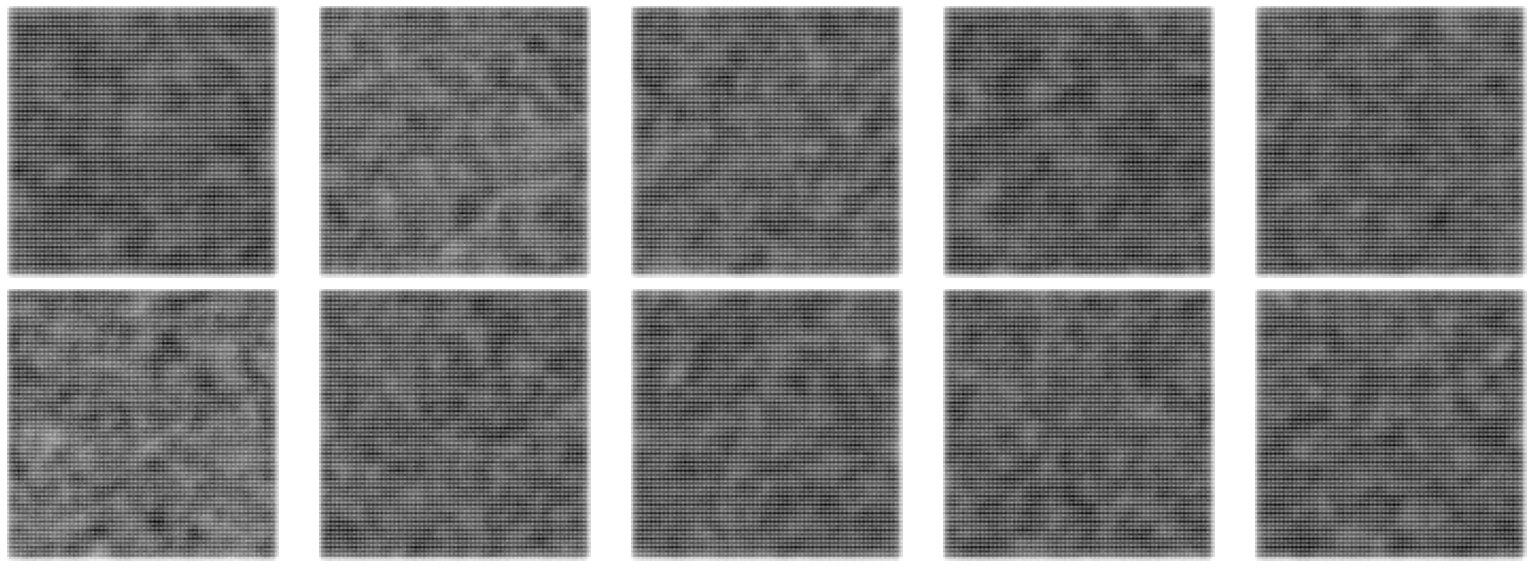

  0%|                                                                                         | 0/3750 [00:00<?, ?it/s]

1/1 [==============================] - 0s 224ms/step


  0%|                                                                               | 1/3750 [00:03<3:07:29,  3.00s/it]

1/1 [==============================] - 0s 203ms/step


  0%|                                                                               | 2/3750 [00:06<3:19:20,  3.19s/it]

1/1 [==============================] - 0s 204ms/step


  0%|                                                                               | 3/3750 [00:09<3:26:08,  3.30s/it]

1/1 [==============================] - 0s 213ms/step


  0%|                                                                               | 4/3750 [00:13<3:28:11,  3.33s/it]

1/1 [==============================] - 0s 220ms/step


  0%|                                                                               | 5/3750 [00:16<3:30:53,  3.38s/it]

1/1 [==============================] - 0s 210ms/step


  0%|▏                                                                              | 6/3750 [00:19<3:28:22,  3.34s/it]

1/1 [==============================] - 0s 233ms/step


  0%|▏                                                                              | 7/3750 [00:23<3:29:27,  3.36s/it]

1/1 [==============================] - 0s 204ms/step


  0%|▏                                                                              | 8/3750 [00:27<3:49:18,  3.68s/it]

1/1 [==============================] - 0s 256ms/step


  0%|▏                                                                              | 9/3750 [00:30<3:42:42,  3.57s/it]

1/1 [==============================] - 0s 214ms/step


  0%|▏                                                                             | 10/3750 [00:34<3:39:25,  3.52s/it]

1/1 [==============================] - 0s 211ms/step


  0%|▏                                                                             | 11/3750 [00:37<3:35:44,  3.46s/it]

1/1 [==============================] - 0s 202ms/step


  0%|▏                                                                             | 12/3750 [00:41<3:37:56,  3.50s/it]

1/1 [==============================] - 0s 208ms/step


  0%|▎                                                                             | 13/3750 [00:44<3:34:33,  3.44s/it]

1/1 [==============================] - 0s 219ms/step


  0%|▎                                                                             | 14/3750 [00:47<3:28:56,  3.36s/it]

1/1 [==============================] - 0s 211ms/step


  0%|▎                                                                             | 15/3750 [00:50<3:26:07,  3.31s/it]

1/1 [==============================] - 0s 209ms/step


  0%|▎                                                                             | 16/3750 [00:54<3:24:17,  3.28s/it]

1/1 [==============================] - 0s 210ms/step


  0%|▎                                                                             | 17/3750 [00:57<3:21:38,  3.24s/it]

1/1 [==============================] - 0s 206ms/step


  0%|▎                                                                             | 18/3750 [01:00<3:20:42,  3.23s/it]

1/1 [==============================] - 0s 209ms/step


  1%|▍                                                                             | 19/3750 [01:03<3:18:53,  3.20s/it]

1/1 [==============================] - 0s 194ms/step


  1%|▍                                                                             | 20/3750 [01:06<3:19:31,  3.21s/it]

1/1 [==============================] - 0s 203ms/step


  1%|▍                                                                             | 21/3750 [01:10<3:19:13,  3.21s/it]

1/1 [==============================] - 0s 203ms/step


  1%|▍                                                                             | 22/3750 [01:13<3:16:47,  3.17s/it]

1/1 [==============================] - 0s 203ms/step


  1%|▍                                                                             | 23/3750 [01:16<3:14:02,  3.12s/it]

1/1 [==============================] - 0s 203ms/step


  1%|▍                                                                             | 24/3750 [01:19<3:13:22,  3.11s/it]

1/1 [==============================] - 0s 208ms/step


  1%|▌                                                                             | 25/3750 [01:22<3:11:58,  3.09s/it]

1/1 [==============================] - 0s 202ms/step


  1%|▌                                                                             | 26/3750 [01:25<3:11:39,  3.09s/it]

1/1 [==============================] - 0s 203ms/step


  1%|▌                                                                             | 27/3750 [01:28<3:12:40,  3.11s/it]

1/1 [==============================] - 0s 204ms/step


  1%|▌                                                                             | 28/3750 [01:31<3:14:22,  3.13s/it]

1/1 [==============================] - 0s 188ms/step


  1%|▌                                                                             | 29/3750 [01:35<3:18:09,  3.20s/it]

1/1 [==============================] - 0s 227ms/step


  1%|▌                                                                             | 30/3750 [01:38<3:19:06,  3.21s/it]

1/1 [==============================] - 0s 220ms/step


  1%|▋                                                                             | 31/3750 [01:41<3:19:10,  3.21s/it]

1/1 [==============================] - 0s 204ms/step


  1%|▋                                                                             | 32/3750 [01:44<3:20:31,  3.24s/it]

1/1 [==============================] - 0s 228ms/step


  1%|▋                                                                             | 33/3750 [01:47<3:19:07,  3.21s/it]

1/1 [==============================] - 0s 190ms/step


  1%|▋                                                                             | 34/3750 [01:51<3:17:49,  3.19s/it]

1/1 [==============================] - 0s 218ms/step


  1%|▋                                                                             | 35/3750 [01:54<3:18:25,  3.20s/it]

1/1 [==============================] - 0s 198ms/step


  1%|▋                                                                             | 36/3750 [01:57<3:17:54,  3.20s/it]

1/1 [==============================] - 0s 213ms/step


  1%|▊                                                                             | 37/3750 [02:00<3:21:08,  3.25s/it]

1/1 [==============================] - 0s 221ms/step


  1%|▊                                                                             | 38/3750 [02:04<3:22:36,  3.27s/it]

1/1 [==============================] - 0s 218ms/step


  1%|▊                                                                             | 39/3750 [02:07<3:23:49,  3.30s/it]

1/1 [==============================] - 0s 216ms/step


  1%|▊                                                                             | 40/3750 [02:10<3:21:31,  3.26s/it]

1/1 [==============================] - 0s 224ms/step


  1%|▊                                                                             | 41/3750 [02:13<3:20:38,  3.25s/it]

1/1 [==============================] - 0s 204ms/step


  1%|▊                                                                             | 42/3750 [02:17<3:20:48,  3.25s/it]

1/1 [==============================] - 0s 222ms/step


  1%|▉                                                                             | 43/3750 [02:20<3:22:46,  3.28s/it]

1/1 [==============================] - 0s 213ms/step


  1%|▉                                                                             | 44/3750 [02:24<3:25:17,  3.32s/it]

1/1 [==============================] - 0s 204ms/step


  1%|▉                                                                             | 45/3750 [02:27<3:23:42,  3.30s/it]

1/1 [==============================] - 0s 213ms/step


  1%|▉                                                                             | 46/3750 [02:30<3:27:23,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


  1%|▉                                                                             | 47/3750 [02:34<3:29:16,  3.39s/it]

1/1 [==============================] - 0s 235ms/step


  1%|▉                                                                             | 48/3750 [02:37<3:30:15,  3.41s/it]

1/1 [==============================] - 0s 197ms/step


  1%|█                                                                             | 49/3750 [02:41<3:38:08,  3.54s/it]

1/1 [==============================] - 0s 213ms/step


  1%|█                                                                             | 50/3750 [02:45<3:39:23,  3.56s/it]

1/1 [==============================] - 0s 239ms/step


  1%|█                                                                             | 51/3750 [02:48<3:36:48,  3.52s/it]

1/1 [==============================] - 0s 207ms/step


  1%|█                                                                             | 52/3750 [02:51<3:32:59,  3.46s/it]

1/1 [==============================] - 0s 225ms/step


  1%|█                                                                             | 53/3750 [02:55<3:31:00,  3.42s/it]

1/1 [==============================] - 0s 219ms/step


  1%|█                                                                             | 54/3750 [02:58<3:30:12,  3.41s/it]

1/1 [==============================] - 0s 204ms/step


  1%|█▏                                                                            | 55/3750 [03:01<3:29:54,  3.41s/it]

1/1 [==============================] - 0s 221ms/step


  1%|█▏                                                                            | 56/3750 [03:05<3:28:40,  3.39s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▏                                                                            | 57/3750 [03:08<3:22:51,  3.30s/it]

1/1 [==============================] - 0s 194ms/step


  2%|█▏                                                                            | 58/3750 [03:11<3:22:37,  3.29s/it]

1/1 [==============================] - 0s 200ms/step


  2%|█▏                                                                            | 59/3750 [03:14<3:19:14,  3.24s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▏                                                                            | 60/3750 [03:17<3:16:04,  3.19s/it]

1/1 [==============================] - 0s 195ms/step


  2%|█▎                                                                            | 61/3750 [03:20<3:13:26,  3.15s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▎                                                                            | 62/3750 [03:23<3:11:24,  3.11s/it]

1/1 [==============================] - 0s 187ms/step


  2%|█▎                                                                            | 63/3750 [03:27<3:10:36,  3.10s/it]

1/1 [==============================] - 0s 208ms/step


  2%|█▎                                                                            | 64/3750 [03:30<3:10:27,  3.10s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▎                                                                            | 65/3750 [03:33<3:11:14,  3.11s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▎                                                                            | 66/3750 [03:36<3:10:55,  3.11s/it]

1/1 [==============================] - 0s 190ms/step


  2%|█▍                                                                            | 67/3750 [03:39<3:10:22,  3.10s/it]

1/1 [==============================] - 0s 202ms/step


  2%|█▍                                                                            | 68/3750 [03:42<3:09:19,  3.09s/it]

1/1 [==============================] - 0s 185ms/step


  2%|█▍                                                                            | 69/3750 [03:45<3:14:33,  3.17s/it]

1/1 [==============================] - 0s 188ms/step


  2%|█▍                                                                            | 70/3750 [03:49<3:13:50,  3.16s/it]

1/1 [==============================] - 0s 209ms/step


  2%|█▍                                                                            | 71/3750 [03:52<3:13:25,  3.15s/it]

1/1 [==============================] - 0s 189ms/step


  2%|█▍                                                                            | 72/3750 [03:55<3:12:23,  3.14s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▌                                                                            | 73/3750 [03:58<3:10:57,  3.12s/it]

1/1 [==============================] - 0s 195ms/step


  2%|█▌                                                                            | 74/3750 [04:01<3:10:28,  3.11s/it]

1/1 [==============================] - 0s 195ms/step


  2%|█▌                                                                            | 75/3750 [04:04<3:09:59,  3.10s/it]

1/1 [==============================] - 0s 200ms/step


  2%|█▌                                                                            | 76/3750 [04:07<3:09:51,  3.10s/it]

1/1 [==============================] - 0s 193ms/step


  2%|█▌                                                                            | 77/3750 [04:10<3:09:43,  3.10s/it]

1/1 [==============================] - 0s 200ms/step


  2%|█▌                                                                            | 78/3750 [04:13<3:09:57,  3.10s/it]

1/1 [==============================] - 0s 210ms/step


  2%|█▋                                                                            | 79/3750 [04:17<3:18:12,  3.24s/it]

1/1 [==============================] - 0s 245ms/step


  2%|█▋                                                                            | 80/3750 [04:20<3:22:48,  3.32s/it]

1/1 [==============================] - 0s 215ms/step


  2%|█▋                                                                            | 81/3750 [04:24<3:22:47,  3.32s/it]

1/1 [==============================] - 0s 220ms/step


  2%|█▋                                                                            | 82/3750 [04:27<3:25:18,  3.36s/it]

1/1 [==============================] - 0s 233ms/step


  2%|█▋                                                                            | 83/3750 [04:31<3:26:09,  3.37s/it]

1/1 [==============================] - 0s 216ms/step


  2%|█▋                                                                            | 84/3750 [04:34<3:25:49,  3.37s/it]

1/1 [==============================] - 0s 212ms/step


  2%|█▊                                                                            | 85/3750 [04:37<3:29:15,  3.43s/it]

1/1 [==============================] - 0s 226ms/step


  2%|█▊                                                                            | 86/3750 [04:41<3:30:30,  3.45s/it]

1/1 [==============================] - 0s 215ms/step


  2%|█▊                                                                            | 87/3750 [04:44<3:28:10,  3.41s/it]

1/1 [==============================] - 0s 225ms/step


  2%|█▊                                                                            | 88/3750 [04:48<3:30:41,  3.45s/it]

1/1 [==============================] - 0s 228ms/step


  2%|█▊                                                                            | 89/3750 [04:51<3:28:09,  3.41s/it]

1/1 [==============================] - 0s 203ms/step


  2%|█▊                                                                            | 90/3750 [04:54<3:23:40,  3.34s/it]

1/1 [==============================] - 0s 213ms/step


  2%|█▉                                                                            | 91/3750 [04:58<3:20:53,  3.29s/it]

1/1 [==============================] - 0s 196ms/step


  2%|█▉                                                                            | 92/3750 [05:01<3:19:05,  3.27s/it]

1/1 [==============================] - 0s 206ms/step


  2%|█▉                                                                            | 93/3750 [05:04<3:18:39,  3.26s/it]

1/1 [==============================] - 0s 226ms/step


  3%|█▉                                                                            | 94/3750 [05:07<3:20:34,  3.29s/it]

1/1 [==============================] - 0s 220ms/step


  3%|█▉                                                                            | 95/3750 [05:11<3:23:55,  3.35s/it]

1/1 [==============================] - 0s 205ms/step


  3%|█▉                                                                            | 96/3750 [05:14<3:19:33,  3.28s/it]

1/1 [==============================] - 0s 191ms/step


  3%|██                                                                            | 97/3750 [05:17<3:16:02,  3.22s/it]

1/1 [==============================] - 0s 219ms/step


  3%|██                                                                            | 98/3750 [05:20<3:13:26,  3.18s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██                                                                            | 99/3750 [05:23<3:10:33,  3.13s/it]

1/1 [==============================] - 0s 204ms/step


  3%|██                                                                           | 100/3750 [05:26<3:07:37,  3.08s/it]

1/1 [==============================] - 0s 231ms/step


  3%|██                                                                           | 101/3750 [05:29<3:10:27,  3.13s/it]

1/1 [==============================] - 0s 198ms/step


  3%|██                                                                           | 102/3750 [05:33<3:14:05,  3.19s/it]

1/1 [==============================] - 0s 216ms/step


  3%|██                                                                           | 103/3750 [05:36<3:15:53,  3.22s/it]

1/1 [==============================] - 0s 208ms/step


  3%|██▏                                                                          | 104/3750 [05:39<3:13:52,  3.19s/it]

1/1 [==============================] - 0s 223ms/step


  3%|██▏                                                                          | 105/3750 [05:42<3:15:54,  3.22s/it]

1/1 [==============================] - 0s 191ms/step


  3%|██▏                                                                          | 106/3750 [05:46<3:16:58,  3.24s/it]

1/1 [==============================] - 0s 222ms/step


  3%|██▏                                                                          | 107/3750 [05:49<3:14:32,  3.20s/it]

1/1 [==============================] - 0s 212ms/step


  3%|██▏                                                                          | 108/3750 [05:52<3:13:10,  3.18s/it]

1/1 [==============================] - 0s 213ms/step


  3%|██▏                                                                          | 109/3750 [05:55<3:09:32,  3.12s/it]

1/1 [==============================] - 0s 200ms/step


  3%|██▎                                                                          | 110/3750 [05:58<3:07:01,  3.08s/it]

1/1 [==============================] - 0s 195ms/step


  3%|██▎                                                                          | 111/3750 [06:01<3:05:32,  3.06s/it]

1/1 [==============================] - 0s 200ms/step


  3%|██▎                                                                          | 112/3750 [06:04<3:05:28,  3.06s/it]

1/1 [==============================] - 0s 185ms/step


  3%|██▎                                                                          | 113/3750 [06:07<3:04:28,  3.04s/it]

1/1 [==============================] - 0s 193ms/step


  3%|██▎                                                                          | 114/3750 [06:10<3:03:04,  3.02s/it]

1/1 [==============================] - 0s 187ms/step


  3%|██▎                                                                          | 115/3750 [06:13<3:01:59,  3.00s/it]

1/1 [==============================] - 0s 187ms/step


  3%|██▍                                                                          | 116/3750 [06:16<3:00:39,  2.98s/it]

1/1 [==============================] - 0s 188ms/step


  3%|██▍                                                                          | 117/3750 [06:19<3:01:06,  2.99s/it]

1/1 [==============================] - 0s 187ms/step


  3%|██▍                                                                          | 118/3750 [06:22<3:01:36,  3.00s/it]

1/1 [==============================] - 0s 214ms/step


  3%|██▍                                                                          | 119/3750 [06:25<3:03:00,  3.02s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██▍                                                                          | 120/3750 [06:28<3:04:20,  3.05s/it]

1/1 [==============================] - 0s 190ms/step


  3%|██▍                                                                          | 121/3750 [06:31<3:05:23,  3.07s/it]

1/1 [==============================] - 0s 206ms/step


  3%|██▌                                                                          | 122/3750 [06:34<3:06:47,  3.09s/it]

1/1 [==============================] - 0s 188ms/step


  3%|██▌                                                                          | 123/3750 [06:37<3:07:41,  3.10s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██▌                                                                          | 124/3750 [06:40<3:07:16,  3.10s/it]

1/1 [==============================] - 0s 206ms/step


  3%|██▌                                                                          | 125/3750 [06:44<3:07:46,  3.11s/it]

1/1 [==============================] - 0s 203ms/step


  3%|██▌                                                                          | 126/3750 [06:47<3:07:26,  3.10s/it]

1/1 [==============================] - 0s 187ms/step


  3%|██▌                                                                          | 127/3750 [06:50<3:10:21,  3.15s/it]

1/1 [==============================] - 0s 230ms/step


  3%|██▋                                                                          | 128/3750 [06:53<3:15:40,  3.24s/it]

1/1 [==============================] - 0s 207ms/step


  3%|██▋                                                                          | 129/3750 [06:57<3:14:25,  3.22s/it]

1/1 [==============================] - 0s 205ms/step


  3%|██▋                                                                          | 130/3750 [07:00<3:17:51,  3.28s/it]

1/1 [==============================] - 0s 230ms/step


  3%|██▋                                                                          | 131/3750 [07:03<3:20:11,  3.32s/it]

1/1 [==============================] - 0s 216ms/step


  4%|██▋                                                                          | 132/3750 [07:07<3:24:34,  3.39s/it]

1/1 [==============================] - 0s 210ms/step


  4%|██▋                                                                          | 133/3750 [07:11<3:29:28,  3.47s/it]

1/1 [==============================] - 0s 246ms/step


  4%|██▊                                                                          | 134/3750 [07:14<3:30:37,  3.50s/it]

1/1 [==============================] - 0s 237ms/step


  4%|██▊                                                                          | 135/3750 [07:18<3:29:40,  3.48s/it]

1/1 [==============================] - 0s 237ms/step


  4%|██▊                                                                          | 136/3750 [07:21<3:28:38,  3.46s/it]

1/1 [==============================] - 0s 245ms/step


  4%|██▊                                                                          | 137/3750 [07:25<3:29:45,  3.48s/it]

1/1 [==============================] - 0s 270ms/step


  4%|██▊                                                                          | 138/3750 [07:28<3:29:29,  3.48s/it]

1/1 [==============================] - 0s 218ms/step


  4%|██▊                                                                          | 139/3750 [07:31<3:27:13,  3.44s/it]

1/1 [==============================] - 0s 225ms/step


  4%|██▊                                                                          | 140/3750 [07:35<3:24:58,  3.41s/it]

1/1 [==============================] - 0s 223ms/step


  4%|██▉                                                                          | 141/3750 [07:38<3:20:05,  3.33s/it]

1/1 [==============================] - 0s 203ms/step


  4%|██▉                                                                          | 142/3750 [07:41<3:20:28,  3.33s/it]

1/1 [==============================] - 0s 207ms/step


  4%|██▉                                                                          | 143/3750 [07:45<3:22:57,  3.38s/it]

1/1 [==============================] - 0s 297ms/step


  4%|██▉                                                                          | 144/3750 [07:48<3:27:49,  3.46s/it]

1/1 [==============================] - 0s 215ms/step


  4%|██▉                                                                          | 145/3750 [07:52<3:23:58,  3.39s/it]

1/1 [==============================] - 0s 239ms/step


  4%|██▉                                                                          | 146/3750 [07:55<3:20:26,  3.34s/it]

1/1 [==============================] - 0s 203ms/step


  4%|███                                                                          | 147/3750 [07:58<3:16:20,  3.27s/it]

1/1 [==============================] - 0s 212ms/step


  4%|███                                                                          | 148/3750 [08:01<3:15:35,  3.26s/it]

1/1 [==============================] - 0s 234ms/step


  4%|███                                                                          | 149/3750 [08:05<3:18:15,  3.30s/it]

1/1 [==============================] - 0s 247ms/step


  4%|███                                                                          | 150/3750 [08:08<3:22:51,  3.38s/it]

1/1 [==============================] - 0s 232ms/step


  4%|███                                                                          | 151/3750 [08:12<3:25:33,  3.43s/it]

1/1 [==============================] - 0s 236ms/step


  4%|███                                                                          | 152/3750 [08:15<3:29:38,  3.50s/it]

1/1 [==============================] - 0s 217ms/step


  4%|███▏                                                                         | 153/3750 [08:19<3:32:04,  3.54s/it]

1/1 [==============================] - 0s 248ms/step


  4%|███▏                                                                         | 154/3750 [08:23<3:32:08,  3.54s/it]

1/1 [==============================] - 0s 213ms/step


  4%|███▏                                                                         | 155/3750 [08:26<3:28:11,  3.47s/it]

1/1 [==============================] - 0s 219ms/step


  4%|███▏                                                                         | 156/3750 [08:29<3:27:16,  3.46s/it]

1/1 [==============================] - 0s 212ms/step


  4%|███▏                                                                         | 157/3750 [08:32<3:23:12,  3.39s/it]

1/1 [==============================] - 0s 203ms/step


  4%|███▏                                                                         | 158/3750 [08:36<3:18:33,  3.32s/it]

1/1 [==============================] - 0s 219ms/step


  4%|███▎                                                                         | 159/3750 [08:39<3:15:33,  3.27s/it]

1/1 [==============================] - 0s 202ms/step


  4%|███▎                                                                         | 160/3750 [08:42<3:16:23,  3.28s/it]

1/1 [==============================] - 0s 214ms/step


  4%|███▎                                                                         | 161/3750 [08:45<3:17:59,  3.31s/it]

1/1 [==============================] - 0s 224ms/step


  4%|███▎                                                                         | 162/3750 [08:49<3:18:14,  3.32s/it]

1/1 [==============================] - 0s 204ms/step


  4%|███▎                                                                         | 163/3750 [08:52<3:16:44,  3.29s/it]

1/1 [==============================] - 0s 231ms/step


  4%|███▎                                                                         | 164/3750 [08:55<3:19:24,  3.34s/it]

1/1 [==============================] - 0s 224ms/step


  4%|███▍                                                                         | 165/3750 [08:59<3:23:04,  3.40s/it]

1/1 [==============================] - 0s 221ms/step


  4%|███▍                                                                         | 166/3750 [09:02<3:20:37,  3.36s/it]

1/1 [==============================] - 0s 220ms/step


  4%|███▍                                                                         | 167/3750 [09:05<3:17:20,  3.30s/it]

1/1 [==============================] - 0s 203ms/step


  4%|███▍                                                                         | 168/3750 [09:09<3:15:07,  3.27s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▍                                                                         | 169/3750 [09:12<3:16:39,  3.30s/it]

1/1 [==============================] - 0s 211ms/step


  5%|███▍                                                                         | 170/3750 [09:15<3:14:48,  3.27s/it]

1/1 [==============================] - 0s 189ms/step


  5%|███▌                                                                         | 171/3750 [09:18<3:13:14,  3.24s/it]

1/1 [==============================] - 0s 217ms/step


  5%|███▌                                                                         | 172/3750 [09:22<3:13:20,  3.24s/it]

1/1 [==============================] - 0s 234ms/step


  5%|███▌                                                                         | 173/3750 [09:25<3:12:41,  3.23s/it]

1/1 [==============================] - 0s 200ms/step


  5%|███▌                                                                         | 174/3750 [09:28<3:10:40,  3.20s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▌                                                                         | 175/3750 [09:31<3:09:45,  3.18s/it]

1/1 [==============================] - 0s 208ms/step


  5%|███▌                                                                         | 176/3750 [09:34<3:08:53,  3.17s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▋                                                                         | 177/3750 [09:38<3:11:54,  3.22s/it]

1/1 [==============================] - 0s 196ms/step


  5%|███▋                                                                         | 178/3750 [09:41<3:14:54,  3.27s/it]

1/1 [==============================] - 0s 226ms/step


  5%|███▋                                                                         | 179/3750 [09:44<3:14:09,  3.26s/it]

1/1 [==============================] - 0s 221ms/step


  5%|███▋                                                                         | 180/3750 [09:47<3:13:37,  3.25s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▋                                                                         | 181/3750 [09:51<3:12:22,  3.23s/it]

1/1 [==============================] - 0s 233ms/step


  5%|███▋                                                                         | 182/3750 [09:54<3:15:46,  3.29s/it]

1/1 [==============================] - 0s 222ms/step


  5%|███▊                                                                         | 183/3750 [09:58<3:18:40,  3.34s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▊                                                                         | 184/3750 [10:01<3:18:20,  3.34s/it]

1/1 [==============================] - 0s 215ms/step


  5%|███▊                                                                         | 185/3750 [10:04<3:19:41,  3.36s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▊                                                                         | 186/3750 [10:07<3:16:10,  3.30s/it]

1/1 [==============================] - 0s 214ms/step


  5%|███▊                                                                         | 187/3750 [10:11<3:12:26,  3.24s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▊                                                                         | 188/3750 [10:14<3:10:35,  3.21s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▉                                                                         | 189/3750 [10:17<3:09:40,  3.20s/it]

1/1 [==============================] - 0s 187ms/step


  5%|███▉                                                                         | 190/3750 [10:20<3:08:54,  3.18s/it]

1/1 [==============================] - 0s 218ms/step


  5%|███▉                                                                         | 191/3750 [10:23<3:07:40,  3.16s/it]

1/1 [==============================] - 0s 203ms/step


  5%|███▉                                                                         | 192/3750 [10:26<3:08:38,  3.18s/it]

1/1 [==============================] - 0s 204ms/step


  5%|███▉                                                                         | 193/3750 [10:29<3:08:07,  3.17s/it]

1/1 [==============================] - 0s 211ms/step


  5%|███▉                                                                         | 194/3750 [10:33<3:06:30,  3.15s/it]

1/1 [==============================] - 0s 203ms/step


  5%|████                                                                         | 195/3750 [10:36<3:06:32,  3.15s/it]

1/1 [==============================] - 0s 203ms/step


  5%|████                                                                         | 196/3750 [10:39<3:07:27,  3.16s/it]

1/1 [==============================] - 0s 188ms/step


  5%|████                                                                         | 197/3750 [10:42<3:07:37,  3.17s/it]

1/1 [==============================] - 0s 203ms/step


  5%|████                                                                         | 198/3750 [10:45<3:07:43,  3.17s/it]

1/1 [==============================] - 0s 203ms/step


  5%|████                                                                         | 199/3750 [10:48<3:07:50,  3.17s/it]

1/1 [==============================] - 0s 203ms/step


  5%|████                                                                         | 200/3750 [10:52<3:07:32,  3.17s/it]

1/1 [==============================] - 0s 204ms/step


  5%|████▏                                                                        | 201/3750 [10:55<3:07:53,  3.18s/it]

1/1 [==============================] - 0s 202ms/step


  5%|████▏                                                                        | 202/3750 [10:58<3:07:20,  3.17s/it]

1/1 [==============================] - 0s 203ms/step


  5%|████▏                                                                        | 203/3750 [11:01<3:07:43,  3.18s/it]

1/1 [==============================] - 0s 200ms/step


  5%|████▏                                                                        | 204/3750 [11:04<3:07:21,  3.17s/it]

1/1 [==============================] - 0s 203ms/step


  5%|████▏                                                                        | 205/3750 [11:08<3:08:36,  3.19s/it]

1/1 [==============================] - 0s 207ms/step


  5%|████▏                                                                        | 206/3750 [11:11<3:08:18,  3.19s/it]

1/1 [==============================] - 0s 226ms/step


  6%|████▎                                                                        | 207/3750 [11:14<3:07:55,  3.18s/it]

1/1 [==============================] - 0s 191ms/step


  6%|████▎                                                                        | 208/3750 [11:17<3:07:35,  3.18s/it]

1/1 [==============================] - 0s 219ms/step


  6%|████▎                                                                        | 209/3750 [11:20<3:08:01,  3.19s/it]

1/1 [==============================] - 0s 216ms/step


  6%|████▎                                                                        | 210/3750 [11:23<3:06:08,  3.15s/it]

1/1 [==============================] - 0s 203ms/step


  6%|████▎                                                                        | 211/3750 [11:27<3:06:09,  3.16s/it]

1/1 [==============================] - 0s 203ms/step


  6%|████▎                                                                        | 212/3750 [11:30<3:05:11,  3.14s/it]

1/1 [==============================] - 0s 223ms/step


  6%|████▎                                                                        | 213/3750 [11:33<3:06:55,  3.17s/it]

1/1 [==============================] - 0s 224ms/step


  6%|████▍                                                                        | 214/3750 [11:36<3:06:58,  3.17s/it]

1/1 [==============================] - 0s 206ms/step


  6%|████▍                                                                        | 215/3750 [11:39<3:07:04,  3.18s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▍                                                                        | 216/3750 [11:42<3:07:28,  3.18s/it]

1/1 [==============================] - 0s 212ms/step


  6%|████▍                                                                        | 217/3750 [11:46<3:09:51,  3.22s/it]

1/1 [==============================] - 0s 208ms/step


  6%|████▍                                                                        | 218/3750 [11:49<3:08:35,  3.20s/it]

1/1 [==============================] - 0s 203ms/step


  6%|████▍                                                                        | 219/3750 [11:52<3:08:47,  3.21s/it]

1/1 [==============================] - 0s 205ms/step


  6%|████▌                                                                        | 220/3750 [11:55<3:08:21,  3.20s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▌                                                                        | 221/3750 [11:58<3:07:27,  3.19s/it]

1/1 [==============================] - 0s 212ms/step


  6%|████▌                                                                        | 222/3750 [12:02<3:09:38,  3.23s/it]

1/1 [==============================] - 0s 204ms/step


  6%|████▌                                                                        | 223/3750 [12:05<3:12:39,  3.28s/it]

1/1 [==============================] - 0s 249ms/step


  6%|████▌                                                                        | 224/3750 [12:09<3:17:20,  3.36s/it]

1/1 [==============================] - 0s 235ms/step


  6%|████▌                                                                        | 225/3750 [12:12<3:19:43,  3.40s/it]

1/1 [==============================] - 0s 214ms/step


  6%|████▋                                                                        | 226/3750 [12:16<3:19:37,  3.40s/it]

1/1 [==============================] - 0s 236ms/step


  6%|████▋                                                                        | 227/3750 [12:19<3:19:44,  3.40s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▋                                                                        | 228/3750 [12:22<3:20:09,  3.41s/it]

1/1 [==============================] - 0s 235ms/step


  6%|████▋                                                                        | 229/3750 [12:26<3:22:27,  3.45s/it]

1/1 [==============================] - 0s 219ms/step


  6%|████▋                                                                        | 230/3750 [12:29<3:20:25,  3.42s/it]

1/1 [==============================] - 0s 221ms/step


  6%|████▋                                                                        | 231/3750 [12:33<3:19:06,  3.39s/it]

1/1 [==============================] - 0s 209ms/step


  6%|████▊                                                                        | 232/3750 [12:36<3:19:31,  3.40s/it]

1/1 [==============================] - 0s 229ms/step


  6%|████▊                                                                        | 233/3750 [12:39<3:17:26,  3.37s/it]

1/1 [==============================] - 0s 234ms/step


  6%|████▊                                                                        | 234/3750 [12:43<3:22:11,  3.45s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▊                                                                        | 235/3750 [12:46<3:20:01,  3.41s/it]

1/1 [==============================] - 0s 251ms/step


  6%|████▊                                                                        | 236/3750 [12:50<3:20:47,  3.43s/it]

1/1 [==============================] - 0s 193ms/step


  6%|████▊                                                                        | 237/3750 [12:53<3:18:33,  3.39s/it]

1/1 [==============================] - 0s 215ms/step


  6%|████▉                                                                        | 238/3750 [12:57<3:24:07,  3.49s/it]

1/1 [==============================] - 0s 288ms/step


  6%|████▉                                                                        | 239/3750 [13:01<3:29:00,  3.57s/it]

1/1 [==============================] - 0s 231ms/step


  6%|████▉                                                                        | 240/3750 [13:04<3:31:10,  3.61s/it]

1/1 [==============================] - 0s 231ms/step


  6%|████▉                                                                        | 241/3750 [13:08<3:25:37,  3.52s/it]

1/1 [==============================] - 0s 222ms/step


  6%|████▉                                                                        | 242/3750 [13:11<3:22:25,  3.46s/it]

1/1 [==============================] - 0s 220ms/step


  6%|████▉                                                                        | 243/3750 [13:14<3:17:45,  3.38s/it]

1/1 [==============================] - 0s 219ms/step


  7%|█████                                                                        | 244/3750 [13:17<3:14:18,  3.33s/it]

1/1 [==============================] - 0s 224ms/step


  7%|█████                                                                        | 245/3750 [13:20<3:10:04,  3.25s/it]

1/1 [==============================] - 0s 204ms/step


  7%|█████                                                                        | 246/3750 [13:23<3:06:57,  3.20s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████                                                                        | 247/3750 [13:27<3:04:42,  3.16s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████                                                                        | 248/3750 [13:30<3:03:01,  3.14s/it]

1/1 [==============================] - 0s 197ms/step


  7%|█████                                                                        | 249/3750 [13:33<3:02:02,  3.12s/it]

1/1 [==============================] - 0s 208ms/step


  7%|█████▏                                                                       | 250/3750 [13:36<3:02:47,  3.13s/it]

1/1 [==============================] - 0s 214ms/step


  7%|█████▏                                                                       | 251/3750 [13:39<3:02:45,  3.13s/it]

1/1 [==============================] - 0s 204ms/step


  7%|█████▏                                                                       | 252/3750 [13:42<3:04:34,  3.17s/it]

1/1 [==============================] - 0s 213ms/step


  7%|█████▏                                                                       | 253/3750 [13:46<3:12:34,  3.30s/it]

1/1 [==============================] - 0s 236ms/step


  7%|█████▏                                                                       | 254/3750 [13:49<3:13:31,  3.32s/it]

1/1 [==============================] - 0s 221ms/step


  7%|█████▏                                                                       | 255/3750 [13:53<3:14:18,  3.34s/it]

1/1 [==============================] - 0s 219ms/step


  7%|█████▎                                                                       | 256/3750 [13:56<3:13:26,  3.32s/it]

1/1 [==============================] - 0s 201ms/step


  7%|█████▎                                                                       | 257/3750 [13:59<3:17:08,  3.39s/it]

1/1 [==============================] - 1s 923ms/step


  7%|█████▎                                                                       | 258/3750 [14:05<3:53:13,  4.01s/it]

1/1 [==============================] - 0s 242ms/step


  7%|█████▎                                                                       | 259/3750 [14:10<4:06:55,  4.24s/it]

1/1 [==============================] - 0s 276ms/step


  7%|█████▎                                                                       | 260/3750 [14:14<4:08:17,  4.27s/it]

1/1 [==============================] - 0s 225ms/step


  7%|█████▎                                                                       | 261/3750 [14:17<3:51:23,  3.98s/it]

1/1 [==============================] - 0s 217ms/step


  7%|█████▍                                                                       | 262/3750 [14:21<3:41:31,  3.81s/it]

1/1 [==============================] - 0s 215ms/step


  7%|█████▍                                                                       | 263/3750 [14:24<3:31:30,  3.64s/it]

1/1 [==============================] - 0s 215ms/step


  7%|█████▍                                                                       | 264/3750 [14:27<3:24:27,  3.52s/it]

1/1 [==============================] - 0s 228ms/step


  7%|█████▍                                                                       | 265/3750 [14:30<3:18:16,  3.41s/it]

1/1 [==============================] - 0s 216ms/step


  7%|█████▍                                                                       | 266/3750 [14:34<3:18:34,  3.42s/it]

1/1 [==============================] - 0s 221ms/step


  7%|█████▍                                                                       | 267/3750 [14:37<3:20:52,  3.46s/it]

1/1 [==============================] - 0s 250ms/step


  7%|█████▌                                                                       | 268/3750 [14:41<3:21:52,  3.48s/it]

1/1 [==============================] - 0s 219ms/step


  7%|█████▌                                                                       | 269/3750 [14:44<3:18:21,  3.42s/it]

1/1 [==============================] - 0s 219ms/step


  7%|█████▌                                                                       | 270/3750 [14:47<3:13:56,  3.34s/it]

1/1 [==============================] - 0s 219ms/step


  7%|█████▌                                                                       | 271/3750 [14:51<3:12:22,  3.32s/it]

1/1 [==============================] - 0s 215ms/step


  7%|█████▌                                                                       | 272/3750 [14:54<3:10:18,  3.28s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████▌                                                                       | 273/3750 [14:57<3:08:56,  3.26s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████▋                                                                       | 274/3750 [15:00<3:07:12,  3.23s/it]

1/1 [==============================] - 0s 208ms/step


  7%|█████▋                                                                       | 275/3750 [15:03<3:08:21,  3.25s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████▋                                                                       | 276/3750 [15:07<3:07:58,  3.25s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████▋                                                                       | 277/3750 [15:10<3:08:00,  3.25s/it]

1/1 [==============================] - 0s 210ms/step


  7%|█████▋                                                                       | 278/3750 [15:13<3:08:53,  3.26s/it]

1/1 [==============================] - 0s 204ms/step


  7%|█████▋                                                                       | 279/3750 [15:16<3:07:34,  3.24s/it]

1/1 [==============================] - 0s 219ms/step


  7%|█████▋                                                                       | 280/3750 [15:20<3:07:25,  3.24s/it]

1/1 [==============================] - 0s 203ms/step


  7%|█████▊                                                                       | 281/3750 [15:23<3:07:05,  3.24s/it]

1/1 [==============================] - 0s 203ms/step


  8%|█████▊                                                                       | 282/3750 [15:26<3:08:01,  3.25s/it]

1/1 [==============================] - 0s 187ms/step


  8%|█████▊                                                                       | 283/3750 [15:29<3:08:00,  3.25s/it]

1/1 [==============================] - 0s 204ms/step


  8%|█████▊                                                                       | 284/3750 [15:33<3:07:46,  3.25s/it]

1/1 [==============================] - 0s 188ms/step


  8%|█████▊                                                                       | 285/3750 [15:36<3:06:53,  3.24s/it]

1/1 [==============================] - 0s 191ms/step


  8%|█████▊                                                                       | 286/3750 [15:39<3:08:12,  3.26s/it]

1/1 [==============================] - 0s 204ms/step


  8%|█████▉                                                                       | 287/3750 [15:43<3:08:36,  3.27s/it]

1/1 [==============================] - 0s 204ms/step


  8%|█████▉                                                                       | 288/3750 [15:46<3:13:01,  3.35s/it]

1/1 [==============================] - 0s 191ms/step


  8%|█████▉                                                                       | 289/3750 [15:49<3:12:08,  3.33s/it]

1/1 [==============================] - 0s 219ms/step


  8%|█████▉                                                                       | 290/3750 [15:53<3:13:01,  3.35s/it]

1/1 [==============================] - 0s 237ms/step


  8%|█████▉                                                                       | 291/3750 [15:56<3:16:26,  3.41s/it]

1/1 [==============================] - 0s 219ms/step


  8%|█████▉                                                                       | 292/3750 [16:00<3:15:43,  3.40s/it]

1/1 [==============================] - 0s 242ms/step


  8%|██████                                                                       | 293/3750 [16:03<3:15:39,  3.40s/it]

1/1 [==============================] - 0s 209ms/step


  8%|██████                                                                       | 294/3750 [16:06<3:14:37,  3.38s/it]

1/1 [==============================] - 0s 207ms/step


  8%|██████                                                                       | 295/3750 [16:10<3:13:44,  3.36s/it]

1/1 [==============================] - 0s 186ms/step


  8%|██████                                                                       | 296/3750 [16:13<3:15:36,  3.40s/it]

1/1 [==============================] - 0s 227ms/step


  8%|██████                                                                       | 297/3750 [16:17<3:14:15,  3.38s/it]

1/1 [==============================] - 0s 236ms/step


  8%|██████                                                                       | 298/3750 [16:20<3:12:45,  3.35s/it]

1/1 [==============================] - 0s 209ms/step


  8%|██████▏                                                                      | 299/3750 [16:23<3:12:56,  3.35s/it]

1/1 [==============================] - 0s 239ms/step


  8%|██████▏                                                                      | 300/3750 [16:26<3:11:46,  3.34s/it]

1/1 [==============================] - 0s 205ms/step


  8%|██████▏                                                                      | 301/3750 [16:30<3:08:25,  3.28s/it]

1/1 [==============================] - 0s 203ms/step


  8%|██████▏                                                                      | 302/3750 [16:33<3:05:48,  3.23s/it]

1/1 [==============================] - 0s 187ms/step


  8%|██████▏                                                                      | 303/3750 [16:36<3:04:58,  3.22s/it]

1/1 [==============================] - 0s 206ms/step


  8%|██████▏                                                                      | 304/3750 [16:39<3:04:46,  3.22s/it]

1/1 [==============================] - 0s 216ms/step


  8%|██████▎                                                                      | 305/3750 [16:42<3:06:58,  3.26s/it]

1/1 [==============================] - 0s 236ms/step


  8%|██████▎                                                                      | 306/3750 [16:46<3:13:09,  3.37s/it]

1/1 [==============================] - 0s 221ms/step


  8%|██████▎                                                                      | 307/3750 [16:50<3:16:39,  3.43s/it]

1/1 [==============================] - 0s 240ms/step


  8%|██████▎                                                                      | 308/3750 [16:53<3:14:35,  3.39s/it]

1/1 [==============================] - 0s 206ms/step


  8%|██████▎                                                                      | 309/3750 [16:56<3:11:23,  3.34s/it]

1/1 [==============================] - 0s 203ms/step


  8%|██████▎                                                                      | 310/3750 [16:59<3:10:36,  3.32s/it]

1/1 [==============================] - 0s 258ms/step


  8%|██████▍                                                                      | 311/3750 [17:03<3:12:37,  3.36s/it]

1/1 [==============================] - 0s 288ms/step


  8%|██████▍                                                                      | 312/3750 [17:06<3:11:10,  3.34s/it]

1/1 [==============================] - 0s 221ms/step


  8%|██████▍                                                                      | 313/3750 [17:10<3:12:31,  3.36s/it]

1/1 [==============================] - 0s 213ms/step


  8%|██████▍                                                                      | 314/3750 [17:13<3:12:45,  3.37s/it]

1/1 [==============================] - 0s 240ms/step


  8%|██████▍                                                                      | 315/3750 [17:17<3:16:28,  3.43s/it]

1/1 [==============================] - 0s 245ms/step


  8%|██████▍                                                                      | 316/3750 [17:20<3:18:24,  3.47s/it]

1/1 [==============================] - 0s 213ms/step


  8%|██████▌                                                                      | 317/3750 [17:24<3:17:34,  3.45s/it]

1/1 [==============================] - 0s 204ms/step


  8%|██████▌                                                                      | 318/3750 [17:27<3:17:18,  3.45s/it]

1/1 [==============================] - 0s 206ms/step


  9%|██████▌                                                                      | 319/3750 [17:30<3:14:53,  3.41s/it]

1/1 [==============================] - 0s 201ms/step


  9%|██████▌                                                                      | 320/3750 [17:34<3:11:44,  3.35s/it]

1/1 [==============================] - 0s 210ms/step


  9%|██████▌                                                                      | 321/3750 [17:37<3:08:28,  3.30s/it]

1/1 [==============================] - 0s 218ms/step


  9%|██████▌                                                                      | 322/3750 [17:40<3:11:27,  3.35s/it]

1/1 [==============================] - 0s 304ms/step


  9%|██████▋                                                                      | 323/3750 [17:44<3:14:37,  3.41s/it]

1/1 [==============================] - 0s 221ms/step


  9%|██████▋                                                                      | 324/3750 [17:47<3:14:10,  3.40s/it]

1/1 [==============================] - 0s 224ms/step


  9%|██████▋                                                                      | 325/3750 [17:51<3:15:24,  3.42s/it]

1/1 [==============================] - 0s 219ms/step


  9%|██████▋                                                                      | 326/3750 [17:54<3:12:03,  3.37s/it]

1/1 [==============================] - 0s 243ms/step


  9%|██████▋                                                                      | 327/3750 [17:57<3:10:29,  3.34s/it]

1/1 [==============================] - 0s 221ms/step


  9%|██████▋                                                                      | 328/3750 [18:00<3:08:22,  3.30s/it]

1/1 [==============================] - 0s 208ms/step


  9%|██████▊                                                                      | 329/3750 [18:03<3:04:52,  3.24s/it]

1/1 [==============================] - 0s 204ms/step


  9%|██████▊                                                                      | 330/3750 [18:07<3:04:50,  3.24s/it]

1/1 [==============================] - 0s 197ms/step


  9%|██████▊                                                                      | 331/3750 [18:10<3:04:06,  3.23s/it]

1/1 [==============================] - 0s 250ms/step


  9%|██████▊                                                                      | 332/3750 [18:13<3:04:22,  3.24s/it]

1/1 [==============================] - 0s 196ms/step


  9%|██████▊                                                                      | 333/3750 [18:16<3:01:45,  3.19s/it]

1/1 [==============================] - 0s 203ms/step


  9%|██████▊                                                                      | 334/3750 [18:19<3:00:23,  3.17s/it]

1/1 [==============================] - 0s 203ms/step


  9%|██████▉                                                                      | 335/3750 [18:22<2:59:18,  3.15s/it]

1/1 [==============================] - 0s 205ms/step


  9%|██████▉                                                                      | 336/3750 [18:25<2:58:03,  3.13s/it]

1/1 [==============================] - 0s 188ms/step


  9%|██████▉                                                                      | 337/3750 [18:29<2:57:45,  3.13s/it]

1/1 [==============================] - 0s 195ms/step


  9%|██████▉                                                                      | 338/3750 [18:32<2:56:47,  3.11s/it]

1/1 [==============================] - 0s 203ms/step


  9%|██████▉                                                                      | 339/3750 [18:35<2:56:42,  3.11s/it]

1/1 [==============================] - 0s 203ms/step


  9%|██████▉                                                                      | 340/3750 [18:38<2:56:17,  3.10s/it]

1/1 [==============================] - 0s 204ms/step


  9%|███████                                                                      | 341/3750 [18:41<2:56:21,  3.10s/it]

1/1 [==============================] - 0s 203ms/step


  9%|███████                                                                      | 342/3750 [18:44<2:56:25,  3.11s/it]

1/1 [==============================] - 0s 212ms/step


  9%|███████                                                                      | 343/3750 [18:47<2:56:25,  3.11s/it]

1/1 [==============================] - 0s 203ms/step


  9%|███████                                                                      | 344/3750 [18:50<2:55:29,  3.09s/it]

1/1 [==============================] - 0s 192ms/step


  9%|███████                                                                      | 345/3750 [18:53<2:55:48,  3.10s/it]

1/1 [==============================] - 0s 193ms/step


  9%|███████                                                                      | 346/3750 [18:56<2:54:58,  3.08s/it]

1/1 [==============================] - 0s 204ms/step


  9%|███████▏                                                                     | 347/3750 [19:00<2:55:16,  3.09s/it]

1/1 [==============================] - 0s 203ms/step


  9%|███████▏                                                                     | 348/3750 [19:03<2:55:04,  3.09s/it]

1/1 [==============================] - 0s 203ms/step


  9%|███████▏                                                                     | 349/3750 [19:06<2:55:25,  3.09s/it]

1/1 [==============================] - 0s 202ms/step


  9%|███████▏                                                                     | 350/3750 [19:09<2:53:54,  3.07s/it]

1/1 [==============================] - 0s 203ms/step


  9%|███████▏                                                                     | 351/3750 [19:12<2:54:56,  3.09s/it]

1/1 [==============================] - 0s 207ms/step


  9%|███████▏                                                                     | 352/3750 [19:15<2:55:57,  3.11s/it]

1/1 [==============================] - 0s 193ms/step


  9%|███████▏                                                                     | 353/3750 [19:18<2:53:20,  3.06s/it]

1/1 [==============================] - 0s 200ms/step


  9%|███████▎                                                                     | 354/3750 [19:21<2:53:24,  3.06s/it]

1/1 [==============================] - 0s 187ms/step


  9%|███████▎                                                                     | 355/3750 [19:24<2:53:10,  3.06s/it]

1/1 [==============================] - 0s 208ms/step


  9%|███████▎                                                                     | 356/3750 [19:27<2:53:14,  3.06s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▎                                                                     | 357/3750 [19:30<2:53:57,  3.08s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▎                                                                     | 358/3750 [19:33<2:54:18,  3.08s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▎                                                                     | 359/3750 [19:36<2:54:19,  3.08s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▍                                                                     | 360/3750 [19:40<2:54:23,  3.09s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▍                                                                     | 361/3750 [19:43<2:54:27,  3.09s/it]

1/1 [==============================] - 0s 198ms/step


 10%|███████▍                                                                     | 362/3750 [19:46<2:57:56,  3.15s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▍                                                                     | 363/3750 [19:49<2:57:11,  3.14s/it]

1/1 [==============================] - 0s 200ms/step


 10%|███████▍                                                                     | 364/3750 [19:52<2:56:49,  3.13s/it]

1/1 [==============================] - 0s 192ms/step


 10%|███████▍                                                                     | 365/3750 [19:55<2:55:34,  3.11s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▌                                                                     | 366/3750 [19:58<2:55:05,  3.10s/it]

1/1 [==============================] - 0s 204ms/step


 10%|███████▌                                                                     | 367/3750 [20:01<2:55:45,  3.12s/it]

1/1 [==============================] - 0s 188ms/step


 10%|███████▌                                                                     | 368/3750 [20:05<2:55:39,  3.12s/it]

1/1 [==============================] - 0s 219ms/step


 10%|███████▌                                                                     | 369/3750 [20:08<2:56:11,  3.13s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▌                                                                     | 370/3750 [20:11<2:55:53,  3.12s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▌                                                                     | 371/3750 [20:14<2:56:04,  3.13s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▋                                                                     | 372/3750 [20:17<2:55:44,  3.12s/it]

1/1 [==============================] - 0s 219ms/step


 10%|███████▋                                                                     | 373/3750 [20:20<2:55:59,  3.13s/it]

1/1 [==============================] - 0s 187ms/step


 10%|███████▋                                                                     | 374/3750 [20:23<2:55:48,  3.12s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▋                                                                     | 375/3750 [20:26<2:55:18,  3.12s/it]

1/1 [==============================] - 0s 193ms/step


 10%|███████▋                                                                     | 376/3750 [20:30<2:57:26,  3.16s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▋                                                                     | 377/3750 [20:33<3:00:51,  3.22s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▊                                                                     | 378/3750 [20:36<3:01:15,  3.23s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▊                                                                     | 379/3750 [20:40<3:02:20,  3.25s/it]

1/1 [==============================] - 0s 215ms/step


 10%|███████▊                                                                     | 380/3750 [20:43<3:02:32,  3.25s/it]

1/1 [==============================] - 0s 210ms/step


 10%|███████▊                                                                     | 381/3750 [20:46<3:03:02,  3.26s/it]

1/1 [==============================] - 0s 205ms/step


 10%|███████▊                                                                     | 382/3750 [20:49<3:03:28,  3.27s/it]

1/1 [==============================] - 0s 209ms/step


 10%|███████▊                                                                     | 383/3750 [20:53<3:01:42,  3.24s/it]

1/1 [==============================] - 0s 201ms/step


 10%|███████▉                                                                     | 384/3750 [20:56<3:02:24,  3.25s/it]

1/1 [==============================] - 0s 206ms/step


 10%|███████▉                                                                     | 385/3750 [20:59<3:02:18,  3.25s/it]

1/1 [==============================] - 0s 215ms/step


 10%|███████▉                                                                     | 386/3750 [21:02<3:02:15,  3.25s/it]

1/1 [==============================] - 0s 216ms/step


 10%|███████▉                                                                     | 387/3750 [21:06<3:02:30,  3.26s/it]

1/1 [==============================] - 0s 206ms/step


 10%|███████▉                                                                     | 388/3750 [21:09<3:02:19,  3.25s/it]

1/1 [==============================] - 0s 203ms/step


 10%|███████▉                                                                     | 389/3750 [21:12<3:03:24,  3.27s/it]

1/1 [==============================] - 0s 204ms/step


 10%|████████                                                                     | 390/3750 [21:15<3:03:34,  3.28s/it]

1/1 [==============================] - 0s 223ms/step


 10%|████████                                                                     | 391/3750 [21:19<3:03:23,  3.28s/it]

1/1 [==============================] - 0s 219ms/step


 10%|████████                                                                     | 392/3750 [21:22<3:04:49,  3.30s/it]

1/1 [==============================] - 0s 226ms/step


 10%|████████                                                                     | 393/3750 [21:25<3:05:58,  3.32s/it]

1/1 [==============================] - 0s 214ms/step


 11%|████████                                                                     | 394/3750 [21:29<3:05:22,  3.31s/it]

1/1 [==============================] - 0s 201ms/step


 11%|████████                                                                     | 395/3750 [21:32<3:05:07,  3.31s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▏                                                                    | 396/3750 [21:35<3:04:03,  3.29s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▏                                                                    | 397/3750 [21:39<3:03:59,  3.29s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▏                                                                    | 398/3750 [21:42<3:03:32,  3.29s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▏                                                                    | 399/3750 [21:45<3:05:49,  3.33s/it]

1/1 [==============================] - 0s 220ms/step


 11%|████████▏                                                                    | 400/3750 [21:49<3:05:02,  3.31s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▏                                                                    | 401/3750 [21:52<3:05:42,  3.33s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▎                                                                    | 402/3750 [21:55<3:05:43,  3.33s/it]

1/1 [==============================] - 0s 215ms/step


 11%|████████▎                                                                    | 403/3750 [21:59<3:05:39,  3.33s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▎                                                                    | 404/3750 [22:02<3:05:23,  3.32s/it]

1/1 [==============================] - 0s 210ms/step


 11%|████████▎                                                                    | 405/3750 [22:05<3:04:32,  3.31s/it]

1/1 [==============================] - 0s 219ms/step


 11%|████████▎                                                                    | 406/3750 [22:09<3:04:21,  3.31s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▎                                                                    | 407/3750 [22:12<3:04:31,  3.31s/it]

1/1 [==============================] - 0s 197ms/step


 11%|████████▍                                                                    | 408/3750 [22:15<3:04:47,  3.32s/it]

1/1 [==============================] - 0s 212ms/step


 11%|████████▍                                                                    | 409/3750 [22:18<3:04:16,  3.31s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▍                                                                    | 410/3750 [22:22<3:04:25,  3.31s/it]

1/1 [==============================] - 0s 205ms/step


 11%|████████▍                                                                    | 411/3750 [22:25<3:04:42,  3.32s/it]

1/1 [==============================] - 0s 219ms/step


 11%|████████▍                                                                    | 412/3750 [22:28<3:05:29,  3.33s/it]

1/1 [==============================] - 0s 239ms/step


 11%|████████▍                                                                    | 413/3750 [22:32<3:06:44,  3.36s/it]

1/1 [==============================] - 0s 239ms/step


 11%|████████▌                                                                    | 414/3750 [22:35<3:05:49,  3.34s/it]

1/1 [==============================] - 0s 219ms/step


 11%|████████▌                                                                    | 415/3750 [22:39<3:05:47,  3.34s/it]

1/1 [==============================] - 0s 219ms/step


 11%|████████▌                                                                    | 416/3750 [22:42<3:05:29,  3.34s/it]

1/1 [==============================] - 0s 228ms/step


 11%|████████▌                                                                    | 417/3750 [22:45<3:05:48,  3.34s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▌                                                                    | 418/3750 [22:49<3:04:51,  3.33s/it]

1/1 [==============================] - 0s 218ms/step


 11%|████████▌                                                                    | 419/3750 [22:52<3:04:20,  3.32s/it]

1/1 [==============================] - 0s 205ms/step


 11%|████████▌                                                                    | 420/3750 [22:55<3:04:09,  3.32s/it]

1/1 [==============================] - 0s 219ms/step


 11%|████████▋                                                                    | 421/3750 [22:59<3:04:45,  3.33s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▋                                                                    | 422/3750 [23:02<3:05:00,  3.34s/it]

1/1 [==============================] - 0s 214ms/step


 11%|████████▋                                                                    | 423/3750 [23:05<3:04:18,  3.32s/it]

1/1 [==============================] - 0s 220ms/step


 11%|████████▋                                                                    | 424/3750 [23:08<3:04:24,  3.33s/it]

1/1 [==============================] - 0s 219ms/step


 11%|████████▋                                                                    | 425/3750 [23:12<3:04:19,  3.33s/it]

1/1 [==============================] - 0s 215ms/step


 11%|████████▋                                                                    | 426/3750 [23:15<3:04:18,  3.33s/it]

1/1 [==============================] - 0s 219ms/step


 11%|████████▊                                                                    | 427/3750 [23:18<3:04:14,  3.33s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▊                                                                    | 428/3750 [23:22<3:04:19,  3.33s/it]

1/1 [==============================] - 0s 203ms/step


 11%|████████▊                                                                    | 429/3750 [23:25<3:03:54,  3.32s/it]

1/1 [==============================] - 0s 199ms/step


 11%|████████▊                                                                    | 430/3750 [23:28<3:03:36,  3.32s/it]

1/1 [==============================] - 0s 212ms/step


 11%|████████▊                                                                    | 431/3750 [23:32<3:03:30,  3.32s/it]

1/1 [==============================] - 0s 219ms/step


 12%|████████▊                                                                    | 432/3750 [23:35<3:04:51,  3.34s/it]

1/1 [==============================] - 0s 234ms/step


 12%|████████▉                                                                    | 433/3750 [23:39<3:06:04,  3.37s/it]

1/1 [==============================] - 0s 203ms/step


 12%|████████▉                                                                    | 434/3750 [23:42<3:04:40,  3.34s/it]

1/1 [==============================] - 0s 219ms/step


 12%|████████▉                                                                    | 435/3750 [23:45<3:07:37,  3.40s/it]

1/1 [==============================] - 0s 207ms/step


 12%|████████▉                                                                    | 436/3750 [23:49<3:04:20,  3.34s/it]

1/1 [==============================] - 0s 203ms/step


 12%|████████▉                                                                    | 437/3750 [23:52<3:04:40,  3.34s/it]

1/1 [==============================] - 0s 222ms/step


 12%|████████▉                                                                    | 438/3750 [23:55<3:03:59,  3.33s/it]

1/1 [==============================] - 0s 205ms/step


 12%|█████████                                                                    | 439/3750 [23:58<3:02:56,  3.32s/it]

1/1 [==============================] - 0s 204ms/step


 12%|█████████                                                                    | 440/3750 [24:02<3:02:55,  3.32s/it]

1/1 [==============================] - 0s 211ms/step


 12%|█████████                                                                    | 441/3750 [24:05<3:02:35,  3.31s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████                                                                    | 442/3750 [24:08<3:02:26,  3.31s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████                                                                    | 443/3750 [24:12<3:03:35,  3.33s/it]

1/1 [==============================] - 0s 215ms/step


 12%|█████████                                                                    | 444/3750 [24:15<3:04:29,  3.35s/it]

1/1 [==============================] - 0s 205ms/step


 12%|█████████▏                                                                   | 445/3750 [24:19<3:04:27,  3.35s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▏                                                                   | 446/3750 [24:22<3:05:01,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▏                                                                   | 447/3750 [24:25<3:05:09,  3.36s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▏                                                                   | 448/3750 [24:29<3:04:42,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▏                                                                   | 449/3750 [24:32<3:04:31,  3.35s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▏                                                                   | 450/3750 [24:35<3:04:47,  3.36s/it]

1/1 [==============================] - 0s 216ms/step


 12%|█████████▎                                                                   | 451/3750 [24:39<3:04:00,  3.35s/it]

1/1 [==============================] - 0s 234ms/step


 12%|█████████▎                                                                   | 452/3750 [24:42<3:05:26,  3.37s/it]

1/1 [==============================] - 0s 221ms/step


 12%|█████████▎                                                                   | 453/3750 [24:45<3:04:53,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▎                                                                   | 454/3750 [24:49<3:06:22,  3.39s/it]

1/1 [==============================] - 0s 214ms/step


 12%|█████████▎                                                                   | 455/3750 [24:52<3:05:19,  3.37s/it]

1/1 [==============================] - 0s 220ms/step


 12%|█████████▎                                                                   | 456/3750 [24:56<3:04:14,  3.36s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▍                                                                   | 457/3750 [24:59<3:04:10,  3.36s/it]

1/1 [==============================] - 0s 203ms/step


 12%|█████████▍                                                                   | 458/3750 [25:02<3:05:48,  3.39s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▍                                                                   | 459/3750 [25:06<3:05:17,  3.38s/it]

1/1 [==============================] - 0s 217ms/step


 12%|█████████▍                                                                   | 460/3750 [25:09<3:05:38,  3.39s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▍                                                                   | 461/3750 [25:12<3:05:05,  3.38s/it]

1/1 [==============================] - 0s 214ms/step


 12%|█████████▍                                                                   | 462/3750 [25:16<3:05:05,  3.38s/it]

1/1 [==============================] - 0s 224ms/step


 12%|█████████▌                                                                   | 463/3750 [25:19<3:04:17,  3.36s/it]

1/1 [==============================] - 0s 211ms/step


 12%|█████████▌                                                                   | 464/3750 [25:23<3:03:37,  3.35s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▌                                                                   | 465/3750 [25:26<3:03:06,  3.34s/it]

1/1 [==============================] - 0s 222ms/step


 12%|█████████▌                                                                   | 466/3750 [25:29<3:02:37,  3.34s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▌                                                                   | 467/3750 [25:33<3:03:49,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 12%|█████████▌                                                                   | 468/3750 [25:36<3:03:46,  3.36s/it]

1/1 [==============================] - 0s 211ms/step


 13%|█████████▋                                                                   | 469/3750 [25:39<3:03:43,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▋                                                                   | 470/3750 [25:43<3:03:07,  3.35s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▋                                                                   | 471/3750 [25:46<3:08:01,  3.44s/it]

1/1 [==============================] - 0s 222ms/step


 13%|█████████▋                                                                   | 472/3750 [25:50<3:08:14,  3.45s/it]

1/1 [==============================] - 0s 208ms/step


 13%|█████████▋                                                                   | 473/3750 [25:53<3:08:35,  3.45s/it]

1/1 [==============================] - 0s 209ms/step


 13%|█████████▋                                                                   | 474/3750 [25:57<3:06:49,  3.42s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▊                                                                   | 475/3750 [26:00<3:05:45,  3.40s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▊                                                                   | 476/3750 [26:03<3:05:55,  3.41s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▊                                                                   | 477/3750 [26:07<3:05:07,  3.39s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▊                                                                   | 478/3750 [26:10<3:04:26,  3.38s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▊                                                                   | 479/3750 [26:13<3:04:41,  3.39s/it]

1/1 [==============================] - 0s 213ms/step


 13%|█████████▊                                                                   | 480/3750 [26:17<3:04:01,  3.38s/it]

1/1 [==============================] - 0s 203ms/step


 13%|█████████▉                                                                   | 481/3750 [26:20<3:02:52,  3.36s/it]

1/1 [==============================] - 0s 207ms/step


 13%|█████████▉                                                                   | 482/3750 [26:23<3:02:39,  3.35s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▉                                                                   | 483/3750 [26:27<3:02:57,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▉                                                                   | 484/3750 [26:30<3:02:04,  3.34s/it]

1/1 [==============================] - 0s 208ms/step


 13%|█████████▉                                                                   | 485/3750 [26:34<3:03:28,  3.37s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▉                                                                   | 486/3750 [26:37<3:03:14,  3.37s/it]

1/1 [==============================] - 0s 219ms/step


 13%|█████████▉                                                                   | 487/3750 [26:40<3:02:46,  3.36s/it]

1/1 [==============================] - 0s 211ms/step


 13%|██████████                                                                   | 488/3750 [26:44<3:03:17,  3.37s/it]

1/1 [==============================] - 0s 203ms/step


 13%|██████████                                                                   | 489/3750 [26:47<3:02:28,  3.36s/it]

1/1 [==============================] - 0s 222ms/step


 13%|██████████                                                                   | 490/3750 [26:50<3:02:09,  3.35s/it]

1/1 [==============================] - 0s 234ms/step


 13%|██████████                                                                   | 491/3750 [26:54<3:04:45,  3.40s/it]

1/1 [==============================] - 0s 205ms/step


 13%|██████████                                                                   | 492/3750 [26:57<3:04:58,  3.41s/it]

1/1 [==============================] - 0s 210ms/step


 13%|██████████                                                                   | 493/3750 [27:01<3:04:14,  3.39s/it]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▏                                                                  | 494/3750 [27:04<3:01:50,  3.35s/it]

1/1 [==============================] - 0s 203ms/step


 13%|██████████▏                                                                  | 495/3750 [27:07<3:01:41,  3.35s/it]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▏                                                                  | 496/3750 [27:11<3:01:24,  3.34s/it]

1/1 [==============================] - 0s 204ms/step


 13%|██████████▏                                                                  | 497/3750 [27:14<3:02:21,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▏                                                                  | 498/3750 [27:17<3:02:29,  3.37s/it]

1/1 [==============================] - 0s 203ms/step


 13%|██████████▏                                                                  | 499/3750 [27:21<3:02:10,  3.36s/it]

1/1 [==============================] - 0s 213ms/step


 13%|██████████▎                                                                  | 500/3750 [27:24<3:02:32,  3.37s/it]

1/1 [==============================] - 0s 214ms/step


 13%|██████████▎                                                                  | 501/3750 [27:27<3:02:56,  3.38s/it]

1/1 [==============================] - 0s 227ms/step


 13%|██████████▎                                                                  | 502/3750 [27:31<3:01:12,  3.35s/it]

1/1 [==============================] - 0s 221ms/step


 13%|██████████▎                                                                  | 503/3750 [27:34<3:01:39,  3.36s/it]

1/1 [==============================] - 0s 205ms/step


 13%|██████████▎                                                                  | 504/3750 [27:38<3:02:07,  3.37s/it]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▎                                                                  | 505/3750 [27:41<3:02:02,  3.37s/it]

1/1 [==============================] - 0s 219ms/step


 13%|██████████▍                                                                  | 506/3750 [27:44<3:04:57,  3.42s/it]

1/1 [==============================] - 0s 253ms/step


 14%|██████████▍                                                                  | 507/3750 [27:48<3:06:18,  3.45s/it]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▍                                                                  | 508/3750 [27:51<3:05:26,  3.43s/it]

1/1 [==============================] - 0s 210ms/step


 14%|██████████▍                                                                  | 509/3750 [27:55<3:05:58,  3.44s/it]

1/1 [==============================] - 0s 234ms/step


 14%|██████████▍                                                                  | 510/3750 [27:59<3:09:50,  3.52s/it]

1/1 [==============================] - 0s 248ms/step


 14%|██████████▍                                                                  | 511/3750 [28:02<3:10:55,  3.54s/it]

1/1 [==============================] - 0s 221ms/step


 14%|██████████▌                                                                  | 512/3750 [28:05<3:07:20,  3.47s/it]

1/1 [==============================] - 0s 210ms/step


 14%|██████████▌                                                                  | 513/3750 [28:09<3:04:16,  3.42s/it]

1/1 [==============================] - 0s 204ms/step


 14%|██████████▌                                                                  | 514/3750 [28:12<3:02:08,  3.38s/it]

1/1 [==============================] - 0s 203ms/step


 14%|██████████▌                                                                  | 515/3750 [28:15<3:02:14,  3.38s/it]

1/1 [==============================] - 0s 221ms/step


 14%|██████████▌                                                                  | 516/3750 [28:20<3:23:26,  3.77s/it]

1/1 [==============================] - 0s 259ms/step


 14%|██████████▌                                                                  | 517/3750 [28:24<3:25:31,  3.81s/it]

1/1 [==============================] - 0s 251ms/step


 14%|██████████▋                                                                  | 518/3750 [28:28<3:27:11,  3.85s/it]

1/1 [==============================] - 0s 252ms/step


 14%|██████████▋                                                                  | 519/3750 [28:32<3:31:04,  3.92s/it]

1/1 [==============================] - 0s 241ms/step


 14%|██████████▋                                                                  | 520/3750 [28:36<3:30:32,  3.91s/it]

1/1 [==============================] - 0s 250ms/step


 14%|██████████▋                                                                  | 521/3750 [28:40<3:27:54,  3.86s/it]

1/1 [==============================] - 0s 254ms/step


 14%|██████████▋                                                                  | 522/3750 [28:44<3:28:06,  3.87s/it]

1/1 [==============================] - 0s 245ms/step


 14%|██████████▋                                                                  | 523/3750 [28:47<3:28:48,  3.88s/it]

1/1 [==============================] - 0s 251ms/step


 14%|██████████▊                                                                  | 524/3750 [28:51<3:29:38,  3.90s/it]

1/1 [==============================] - 0s 240ms/step


 14%|██████████▊                                                                  | 525/3750 [28:55<3:29:51,  3.90s/it]

1/1 [==============================] - 0s 251ms/step


 14%|██████████▊                                                                  | 526/3750 [28:59<3:30:55,  3.93s/it]

1/1 [==============================] - 0s 246ms/step


 14%|██████████▊                                                                  | 527/3750 [29:03<3:30:08,  3.91s/it]

1/1 [==============================] - 0s 266ms/step


 14%|██████████▊                                                                  | 528/3750 [29:07<3:27:00,  3.85s/it]

1/1 [==============================] - 0s 219ms/step


 14%|██████████▊                                                                  | 529/3750 [29:11<3:25:40,  3.83s/it]

1/1 [==============================] - 0s 248ms/step


 14%|██████████▉                                                                  | 530/3750 [29:14<3:23:35,  3.79s/it]

1/1 [==============================] - 0s 235ms/step


 14%|██████████▉                                                                  | 531/3750 [29:18<3:22:14,  3.77s/it]

1/1 [==============================] - 0s 247ms/step


 14%|██████████▉                                                                  | 532/3750 [29:22<3:24:25,  3.81s/it]

1/1 [==============================] - 0s 245ms/step


 14%|██████████▉                                                                  | 533/3750 [29:26<3:24:00,  3.80s/it]

1/1 [==============================] - 0s 250ms/step


 14%|██████████▉                                                                  | 534/3750 [29:30<3:25:16,  3.83s/it]

1/1 [==============================] - 0s 237ms/step


 14%|██████████▉                                                                  | 535/3750 [29:34<3:27:30,  3.87s/it]

1/1 [==============================] - 0s 252ms/step


 14%|███████████                                                                  | 536/3750 [29:37<3:22:09,  3.77s/it]

1/1 [==============================] - 0s 205ms/step


 14%|██████████▌                                                               | 537/3750 [42:13<204:39:37, 229.31s/it]

1/1 [==============================] - 0s 328ms/step


 14%|██████████▌                                                               | 538/3750 [42:17<144:20:55, 161.79s/it]

1/1 [==============================] - 0s 231ms/step


 14%|██████████▋                                                               | 539/3750 [42:21<101:58:43, 114.33s/it]

1/1 [==============================] - 0s 264ms/step


 14%|██████████▉                                                                 | 540/3750 [42:24<72:20:51, 81.14s/it]

1/1 [==============================] - 0s 237ms/step


 14%|██████████▉                                                                 | 541/3750 [42:28<51:32:24, 57.82s/it]

1/1 [==============================] - 0s 214ms/step


 14%|██████████▉                                                                 | 542/3750 [42:31<37:00:43, 41.53s/it]

1/1 [==============================] - 0s 258ms/step


 14%|███████████                                                                 | 543/3750 [42:35<26:51:28, 30.15s/it]

1/1 [==============================] - 0s 242ms/step


 15%|███████████                                                                 | 544/3750 [42:38<19:44:03, 22.16s/it]

1/1 [==============================] - 0s 243ms/step


 15%|███████████                                                                 | 545/3750 [42:42<14:53:46, 16.73s/it]

1/1 [==============================] - 0s 230ms/step


 15%|███████████                                                                 | 546/3750 [42:46<11:27:51, 12.88s/it]

1/1 [==============================] - 0s 208ms/step


 15%|███████████▏                                                                 | 547/3750 [42:49<8:51:34,  9.96s/it]

1/1 [==============================] - 0s 191ms/step


 15%|███████████▎                                                                 | 548/3750 [42:53<7:02:23,  7.91s/it]

1/1 [==============================] - 0s 185ms/step


 15%|███████████▎                                                                 | 549/3750 [42:56<5:43:53,  6.45s/it]

1/1 [==============================] - 0s 180ms/step


 15%|███████████▎                                                                 | 550/3750 [42:59<4:51:22,  5.46s/it]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▎                                                                 | 551/3750 [43:02<4:13:16,  4.75s/it]

1/1 [==============================] - 0s 191ms/step


 15%|███████████▎                                                                 | 552/3750 [43:05<3:46:21,  4.25s/it]

1/1 [==============================] - 0s 192ms/step


 15%|███████████▎                                                                 | 553/3750 [43:08<3:27:15,  3.89s/it]

1/1 [==============================] - 0s 191ms/step


 15%|███████████▍                                                                 | 554/3750 [43:11<3:14:29,  3.65s/it]

1/1 [==============================] - 0s 202ms/step


 15%|███████████▍                                                                 | 555/3750 [43:14<3:06:06,  3.50s/it]

1/1 [==============================] - 0s 192ms/step


 15%|███████████▍                                                                 | 556/3750 [43:17<2:59:16,  3.37s/it]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▍                                                                 | 557/3750 [43:20<2:54:40,  3.28s/it]

1/1 [==============================] - 0s 217ms/step


 15%|███████████▍                                                                 | 558/3750 [43:23<2:52:25,  3.24s/it]

1/1 [==============================] - 0s 194ms/step


 15%|███████████▍                                                                 | 559/3750 [43:27<2:50:11,  3.20s/it]

1/1 [==============================] - 0s 195ms/step


 15%|███████████▍                                                                 | 560/3750 [43:30<2:48:04,  3.16s/it]

1/1 [==============================] - 0s 184ms/step


 15%|███████████▌                                                                 | 561/3750 [43:33<2:46:50,  3.14s/it]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▌                                                                 | 562/3750 [43:36<2:45:14,  3.11s/it]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▌                                                                 | 563/3750 [43:39<2:44:22,  3.09s/it]

1/1 [==============================] - 0s 185ms/step


 15%|███████████▌                                                                 | 564/3750 [43:42<2:43:46,  3.08s/it]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▌                                                                 | 565/3750 [43:45<2:45:37,  3.12s/it]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▌                                                                 | 566/3750 [43:48<2:44:24,  3.10s/it]

1/1 [==============================] - 0s 186ms/step


 15%|███████████▋                                                                 | 567/3750 [43:51<2:43:47,  3.09s/it]

1/1 [==============================] - 0s 193ms/step


 15%|███████████▋                                                                 | 568/3750 [43:54<2:43:18,  3.08s/it]

1/1 [==============================] - 0s 198ms/step


 15%|███████████▋                                                                 | 569/3750 [43:57<2:43:11,  3.08s/it]

1/1 [==============================] - 0s 191ms/step


 15%|███████████▋                                                                 | 570/3750 [44:00<2:43:24,  3.08s/it]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▋                                                                 | 571/3750 [44:04<2:43:31,  3.09s/it]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▋                                                                 | 572/3750 [44:07<2:43:08,  3.08s/it]

1/1 [==============================] - 0s 190ms/step


 15%|███████████▊                                                                 | 573/3750 [44:10<2:42:30,  3.07s/it]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▊                                                                 | 574/3750 [44:13<2:42:54,  3.08s/it]

1/1 [==============================] - 0s 185ms/step


 15%|███████████▊                                                                 | 575/3750 [44:16<2:43:05,  3.08s/it]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▊                                                                 | 576/3750 [44:19<2:42:44,  3.08s/it]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▊                                                                 | 577/3750 [44:22<2:42:48,  3.08s/it]

1/1 [==============================] - 0s 197ms/step


 15%|███████████▊                                                                 | 578/3750 [44:25<2:44:31,  3.11s/it]

1/1 [==============================] - 0s 187ms/step


 15%|███████████▉                                                                 | 579/3750 [44:28<2:45:13,  3.13s/it]

1/1 [==============================] - 0s 194ms/step


 15%|███████████▉                                                                 | 580/3750 [44:31<2:44:57,  3.12s/it]

1/1 [==============================] - 0s 189ms/step


 15%|███████████▉                                                                 | 581/3750 [44:35<2:44:26,  3.11s/it]

1/1 [==============================] - 0s 197ms/step


 16%|███████████▉                                                                 | 582/3750 [44:38<2:43:44,  3.10s/it]

1/1 [==============================] - 0s 191ms/step


 16%|███████████▉                                                                 | 583/3750 [44:41<2:44:07,  3.11s/it]

1/1 [==============================] - 0s 183ms/step


 16%|███████████▉                                                                 | 584/3750 [44:44<2:43:58,  3.11s/it]

1/1 [==============================] - 0s 191ms/step


 16%|████████████                                                                 | 585/3750 [44:47<2:44:11,  3.11s/it]

1/1 [==============================] - 0s 183ms/step


 16%|████████████                                                                 | 586/3750 [44:50<2:44:05,  3.11s/it]

1/1 [==============================] - 0s 196ms/step


 16%|████████████                                                                 | 587/3750 [44:53<2:44:16,  3.12s/it]

1/1 [==============================] - 0s 202ms/step


 16%|████████████                                                                 | 588/3750 [44:56<2:43:59,  3.11s/it]

1/1 [==============================] - 0s 193ms/step


 16%|████████████                                                                 | 589/3750 [44:59<2:43:54,  3.11s/it]

1/1 [==============================] - 0s 188ms/step


 16%|████████████                                                                 | 590/3750 [45:02<2:43:14,  3.10s/it]

1/1 [==============================] - 0s 185ms/step


 16%|████████████▏                                                                | 591/3750 [45:06<2:43:19,  3.10s/it]

1/1 [==============================] - 0s 189ms/step


 16%|████████████▏                                                                | 592/3750 [45:09<2:44:05,  3.12s/it]

1/1 [==============================] - 0s 200ms/step


 16%|████████████▏                                                                | 593/3750 [45:12<2:45:47,  3.15s/it]

1/1 [==============================] - 0s 194ms/step


 16%|████████████▏                                                                | 594/3750 [45:15<2:46:49,  3.17s/it]

1/1 [==============================] - 0s 193ms/step


 16%|████████████▏                                                                | 595/3750 [45:18<2:47:39,  3.19s/it]

1/1 [==============================] - 0s 204ms/step


 16%|████████████▏                                                                | 596/3750 [45:22<2:47:34,  3.19s/it]

1/1 [==============================] - 0s 193ms/step


 16%|████████████▎                                                                | 597/3750 [45:25<2:47:34,  3.19s/it]

1/1 [==============================] - 0s 205ms/step


 16%|████████████▎                                                                | 598/3750 [45:28<2:47:28,  3.19s/it]

1/1 [==============================] - 0s 217ms/step


 16%|████████████▎                                                                | 599/3750 [45:31<2:47:47,  3.20s/it]

1/1 [==============================] - 0s 193ms/step


 16%|████████████▎                                                                | 600/3750 [45:34<2:48:50,  3.22s/it]

1/1 [==============================] - 0s 202ms/step


 16%|████████████▎                                                                | 601/3750 [45:38<2:49:28,  3.23s/it]

1/1 [==============================] - 0s 193ms/step


 16%|████████████▎                                                                | 602/3750 [45:41<2:49:11,  3.22s/it]

1/1 [==============================] - 0s 202ms/step


 16%|████████████▍                                                                | 603/3750 [45:44<2:50:16,  3.25s/it]

1/1 [==============================] - 0s 216ms/step


 16%|████████████▍                                                                | 604/3750 [45:47<2:49:31,  3.23s/it]

1/1 [==============================] - 0s 212ms/step


 16%|████████████▍                                                                | 605/3750 [45:51<2:48:17,  3.21s/it]

1/1 [==============================] - 0s 190ms/step


 16%|████████████▍                                                                | 606/3750 [45:54<2:47:58,  3.21s/it]

1/1 [==============================] - 0s 192ms/step


 16%|████████████▍                                                                | 607/3750 [45:57<2:48:03,  3.21s/it]

1/1 [==============================] - 0s 203ms/step


 16%|████████████▍                                                                | 608/3750 [46:00<2:46:39,  3.18s/it]

1/1 [==============================] - 0s 201ms/step


 16%|████████████▌                                                                | 609/3750 [46:03<2:46:19,  3.18s/it]

1/1 [==============================] - 0s 196ms/step


 16%|████████████▌                                                                | 610/3750 [46:06<2:46:17,  3.18s/it]

1/1 [==============================] - 0s 201ms/step


 16%|████████████▌                                                                | 611/3750 [46:10<2:46:30,  3.18s/it]

1/1 [==============================] - 0s 206ms/step


 16%|████████████▌                                                                | 612/3750 [46:13<2:46:20,  3.18s/it]

1/1 [==============================] - 0s 197ms/step


 16%|████████████▌                                                                | 613/3750 [46:16<2:46:49,  3.19s/it]

1/1 [==============================] - 0s 197ms/step


 16%|████████████▌                                                                | 614/3750 [46:19<2:46:47,  3.19s/it]

1/1 [==============================] - 0s 197ms/step


 16%|████████████▋                                                                | 615/3750 [46:22<2:46:44,  3.19s/it]

1/1 [==============================] - 0s 202ms/step


 16%|████████████▋                                                                | 616/3750 [46:26<2:46:01,  3.18s/it]

1/1 [==============================] - 0s 190ms/step


 16%|████████████▋                                                                | 617/3750 [46:29<2:44:55,  3.16s/it]

1/1 [==============================] - 0s 195ms/step


 16%|████████████▋                                                                | 618/3750 [46:32<2:45:34,  3.17s/it]

1/1 [==============================] - 0s 233ms/step


 17%|████████████▋                                                                | 619/3750 [46:35<2:46:17,  3.19s/it]

1/1 [==============================] - 0s 198ms/step


 17%|████████████▋                                                                | 620/3750 [46:38<2:45:54,  3.18s/it]

1/1 [==============================] - 0s 201ms/step


 17%|████████████▊                                                                | 621/3750 [46:42<2:47:22,  3.21s/it]

1/1 [==============================] - 0s 194ms/step


 17%|████████████▊                                                                | 622/3750 [46:45<2:47:04,  3.20s/it]

1/1 [==============================] - 0s 197ms/step


 17%|████████████▊                                                                | 623/3750 [46:48<2:46:25,  3.19s/it]

1/1 [==============================] - 0s 199ms/step


 17%|████████████▊                                                                | 624/3750 [46:51<2:46:11,  3.19s/it]

1/1 [==============================] - 0s 203ms/step


 17%|████████████▊                                                                | 625/3750 [46:54<2:46:49,  3.20s/it]

1/1 [==============================] - 0s 202ms/step


 17%|████████████▊                                                                | 626/3750 [46:58<2:51:19,  3.29s/it]

1/1 [==============================] - 0s 212ms/step


 17%|████████████▊                                                                | 627/3750 [47:01<2:48:54,  3.25s/it]

1/1 [==============================] - 0s 194ms/step


 17%|████████████▉                                                                | 628/3750 [47:04<2:46:27,  3.20s/it]

1/1 [==============================] - 0s 192ms/step


 17%|████████████▉                                                                | 629/3750 [47:07<2:44:41,  3.17s/it]

1/1 [==============================] - 0s 192ms/step


 17%|████████████▉                                                                | 630/3750 [47:10<2:43:14,  3.14s/it]

1/1 [==============================] - 0s 196ms/step


 17%|████████████▉                                                                | 631/3750 [47:13<2:42:50,  3.13s/it]

1/1 [==============================] - 0s 186ms/step


 17%|████████████▉                                                                | 632/3750 [47:16<2:41:33,  3.11s/it]

1/1 [==============================] - 0s 192ms/step


 17%|████████████▉                                                                | 633/3750 [47:20<2:41:48,  3.11s/it]

1/1 [==============================] - 0s 200ms/step


 17%|█████████████                                                                | 634/3750 [47:23<2:40:58,  3.10s/it]

1/1 [==============================] - 0s 186ms/step


 17%|█████████████                                                                | 635/3750 [47:26<2:41:17,  3.11s/it]

1/1 [==============================] - 0s 194ms/step


 17%|█████████████                                                                | 636/3750 [47:29<2:41:02,  3.10s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████                                                                | 637/3750 [47:32<2:40:48,  3.10s/it]

1/1 [==============================] - 0s 187ms/step


 17%|█████████████                                                                | 638/3750 [47:35<2:40:43,  3.10s/it]

1/1 [==============================] - 0s 189ms/step


 17%|█████████████                                                                | 639/3750 [47:38<2:41:23,  3.11s/it]

1/1 [==============================] - 0s 191ms/step


 17%|█████████████▏                                                               | 640/3750 [47:41<2:42:26,  3.13s/it]

1/1 [==============================] - 0s 192ms/step


 17%|█████████████▏                                                               | 641/3750 [47:45<2:45:31,  3.19s/it]

1/1 [==============================] - 0s 219ms/step


 17%|█████████████▏                                                               | 642/3750 [47:48<2:48:37,  3.26s/it]

1/1 [==============================] - 0s 219ms/step


 17%|█████████████▏                                                               | 643/3750 [47:51<2:48:23,  3.25s/it]

1/1 [==============================] - 0s 201ms/step


 17%|█████████████▏                                                               | 644/3750 [47:54<2:47:12,  3.23s/it]

1/1 [==============================] - 0s 198ms/step


 17%|█████████████▏                                                               | 645/3750 [47:58<2:47:00,  3.23s/it]

1/1 [==============================] - 0s 212ms/step


 17%|█████████████▎                                                               | 646/3750 [48:01<2:46:50,  3.23s/it]

1/1 [==============================] - 0s 209ms/step


 17%|█████████████▎                                                               | 647/3750 [48:04<2:47:07,  3.23s/it]

1/1 [==============================] - 0s 202ms/step


 17%|█████████████▎                                                               | 648/3750 [48:07<2:46:37,  3.22s/it]

1/1 [==============================] - 0s 257ms/step


 17%|█████████████▎                                                               | 649/3750 [48:11<2:48:36,  3.26s/it]

1/1 [==============================] - 0s 205ms/step


 17%|█████████████▎                                                               | 650/3750 [48:14<2:48:08,  3.25s/it]

1/1 [==============================] - 0s 202ms/step


 17%|█████████████▎                                                               | 651/3750 [48:17<2:47:46,  3.25s/it]

1/1 [==============================] - 0s 199ms/step


 17%|█████████████▍                                                               | 652/3750 [48:20<2:45:53,  3.21s/it]

1/1 [==============================] - 0s 197ms/step


 17%|█████████████▍                                                               | 653/3750 [48:24<2:47:19,  3.24s/it]

1/1 [==============================] - 0s 227ms/step


 17%|█████████████▍                                                               | 654/3750 [48:27<2:51:42,  3.33s/it]

1/1 [==============================] - 0s 236ms/step


 17%|█████████████▍                                                               | 655/3750 [48:31<2:55:03,  3.39s/it]

1/1 [==============================] - 0s 227ms/step


 17%|█████████████▍                                                               | 656/3750 [48:34<2:57:28,  3.44s/it]

1/1 [==============================] - 0s 227ms/step


 18%|█████████████▍                                                               | 657/3750 [48:38<2:58:30,  3.46s/it]

1/1 [==============================] - 0s 220ms/step


 18%|█████████████▌                                                               | 658/3750 [48:41<2:59:02,  3.47s/it]

1/1 [==============================] - 0s 222ms/step


 18%|█████████████▌                                                               | 659/3750 [48:45<2:59:32,  3.48s/it]

1/1 [==============================] - 0s 226ms/step


 18%|█████████████▌                                                               | 660/3750 [48:48<3:00:53,  3.51s/it]

1/1 [==============================] - 0s 221ms/step


 18%|█████████████▌                                                               | 661/3750 [48:52<3:02:07,  3.54s/it]

1/1 [==============================] - 0s 240ms/step


 18%|█████████████▌                                                               | 662/3750 [48:56<3:02:24,  3.54s/it]

1/1 [==============================] - 0s 222ms/step


 18%|█████████████▌                                                               | 663/3750 [48:59<3:01:56,  3.54s/it]

1/1 [==============================] - 0s 232ms/step


 18%|█████████████▋                                                               | 664/3750 [49:03<3:01:16,  3.52s/it]

1/1 [==============================] - 0s 215ms/step


 18%|█████████████▋                                                               | 665/3750 [49:06<3:00:54,  3.52s/it]

1/1 [==============================] - 0s 228ms/step


 18%|█████████████▋                                                               | 666/3750 [49:10<3:00:04,  3.50s/it]

1/1 [==============================] - 0s 218ms/step


 18%|█████████████▋                                                               | 667/3750 [49:13<3:00:37,  3.52s/it]

1/1 [==============================] - 0s 221ms/step


 18%|█████████████▋                                                               | 668/3750 [49:17<3:00:46,  3.52s/it]

1/1 [==============================] - 0s 230ms/step


 18%|█████████████▋                                                               | 669/3750 [49:20<3:00:38,  3.52s/it]

1/1 [==============================] - 0s 221ms/step


 18%|█████████████▊                                                               | 670/3750 [49:24<3:00:04,  3.51s/it]

1/1 [==============================] - 0s 222ms/step


 18%|█████████████▊                                                               | 671/3750 [49:27<3:00:07,  3.51s/it]

1/1 [==============================] - 0s 226ms/step


 18%|█████████████▊                                                               | 672/3750 [49:31<3:00:16,  3.51s/it]

1/1 [==============================] - 0s 213ms/step


 18%|█████████████▊                                                               | 673/3750 [49:34<3:01:03,  3.53s/it]

1/1 [==============================] - 0s 224ms/step


 18%|█████████████▊                                                               | 674/3750 [49:38<2:59:25,  3.50s/it]

1/1 [==============================] - 0s 221ms/step


 18%|█████████████▊                                                               | 675/3750 [49:41<2:57:38,  3.47s/it]

1/1 [==============================] - 0s 225ms/step


 18%|█████████████▉                                                               | 676/3750 [49:45<3:00:40,  3.53s/it]

1/1 [==============================] - 0s 221ms/step


 18%|█████████████▉                                                               | 677/3750 [49:48<2:58:47,  3.49s/it]

1/1 [==============================] - 0s 244ms/step


 18%|█████████████▉                                                               | 678/3750 [49:52<3:00:45,  3.53s/it]

1/1 [==============================] - 0s 233ms/step


 18%|█████████████▉                                                               | 679/3750 [49:55<2:59:52,  3.51s/it]

1/1 [==============================] - 0s 214ms/step


 18%|█████████████▉                                                               | 680/3750 [49:59<3:01:48,  3.55s/it]

1/1 [==============================] - 0s 233ms/step


 18%|█████████████▉                                                               | 681/3750 [50:02<3:01:12,  3.54s/it]

1/1 [==============================] - 0s 221ms/step


 18%|██████████████                                                               | 682/3750 [50:06<2:59:18,  3.51s/it]

1/1 [==============================] - 0s 212ms/step


 18%|██████████████                                                               | 683/3750 [50:09<2:58:13,  3.49s/it]

1/1 [==============================] - 0s 213ms/step


 18%|██████████████                                                               | 684/3750 [50:13<2:57:49,  3.48s/it]

1/1 [==============================] - 0s 209ms/step


 18%|██████████████                                                               | 685/3750 [50:16<2:56:55,  3.46s/it]

1/1 [==============================] - 0s 219ms/step


 18%|██████████████                                                               | 686/3750 [50:20<2:58:14,  3.49s/it]

1/1 [==============================] - 0s 216ms/step


 18%|██████████████                                                               | 687/3750 [50:23<2:58:53,  3.50s/it]

1/1 [==============================] - 0s 220ms/step


 18%|██████████████▏                                                              | 688/3750 [50:27<3:01:53,  3.56s/it]

1/1 [==============================] - 0s 213ms/step


 18%|██████████████▏                                                              | 689/3750 [50:30<3:00:11,  3.53s/it]

1/1 [==============================] - 0s 217ms/step


 18%|██████████████▏                                                              | 690/3750 [50:34<2:59:02,  3.51s/it]

1/1 [==============================] - 0s 220ms/step


 18%|██████████████▏                                                              | 691/3750 [50:37<2:58:48,  3.51s/it]

1/1 [==============================] - 0s 220ms/step


 18%|██████████████▏                                                              | 692/3750 [50:41<2:58:15,  3.50s/it]

1/1 [==============================] - 0s 215ms/step


 18%|██████████████▏                                                              | 693/3750 [50:44<2:58:05,  3.50s/it]

1/1 [==============================] - 0s 222ms/step


 19%|██████████████▎                                                              | 694/3750 [50:48<2:57:51,  3.49s/it]

1/1 [==============================] - 0s 223ms/step


 19%|██████████████▎                                                              | 695/3750 [50:51<2:57:27,  3.49s/it]

1/1 [==============================] - 0s 214ms/step


 19%|██████████████▎                                                              | 696/3750 [50:55<2:56:57,  3.48s/it]

1/1 [==============================] - 0s 223ms/step


 19%|██████████████▎                                                              | 697/3750 [50:58<2:56:54,  3.48s/it]

1/1 [==============================] - 0s 221ms/step


 19%|██████████████▎                                                              | 698/3750 [51:02<2:56:30,  3.47s/it]

1/1 [==============================] - 0s 213ms/step


 19%|██████████████▎                                                              | 699/3750 [51:05<2:58:01,  3.50s/it]

1/1 [==============================] - 0s 224ms/step


 19%|██████████████▎                                                              | 700/3750 [51:09<2:57:03,  3.48s/it]

1/1 [==============================] - 0s 223ms/step


 19%|██████████████▍                                                              | 701/3750 [51:12<2:56:10,  3.47s/it]

1/1 [==============================] - 0s 230ms/step


 19%|██████████████▍                                                              | 702/3750 [51:15<2:55:45,  3.46s/it]

1/1 [==============================] - 0s 210ms/step


 19%|██████████████▍                                                              | 703/3750 [51:19<2:55:39,  3.46s/it]

1/1 [==============================] - 0s 216ms/step


 19%|██████████████▍                                                              | 704/3750 [51:22<2:55:35,  3.46s/it]

1/1 [==============================] - 0s 225ms/step


 19%|██████████████▍                                                              | 705/3750 [51:26<2:56:25,  3.48s/it]

1/1 [==============================] - 0s 221ms/step


 19%|██████████████▍                                                              | 706/3750 [51:29<2:57:40,  3.50s/it]

1/1 [==============================] - 0s 221ms/step


 19%|██████████████▌                                                              | 707/3750 [51:33<2:58:16,  3.52s/it]

1/1 [==============================] - 0s 223ms/step


 19%|██████████████▌                                                              | 708/3750 [51:37<2:58:18,  3.52s/it]

1/1 [==============================] - 0s 217ms/step


 19%|██████████████▌                                                              | 709/3750 [51:40<2:58:42,  3.53s/it]

1/1 [==============================] - 0s 223ms/step


 19%|██████████████▌                                                              | 710/3750 [51:44<3:01:03,  3.57s/it]

1/1 [==============================] - 0s 244ms/step


 19%|██████████████▌                                                              | 711/3750 [51:47<3:01:38,  3.59s/it]

1/1 [==============================] - 0s 224ms/step


 19%|██████████████▌                                                              | 712/3750 [51:51<3:00:43,  3.57s/it]

1/1 [==============================] - 0s 223ms/step


 19%|██████████████▋                                                              | 713/3750 [51:54<2:59:52,  3.55s/it]

1/1 [==============================] - 0s 226ms/step


 19%|██████████████▋                                                              | 714/3750 [51:58<2:59:12,  3.54s/it]

1/1 [==============================] - 0s 231ms/step


 19%|██████████████▋                                                              | 715/3750 [52:02<2:59:33,  3.55s/it]

1/1 [==============================] - 0s 212ms/step


 19%|██████████████▋                                                              | 716/3750 [52:05<2:59:28,  3.55s/it]

1/1 [==============================] - 0s 220ms/step


 19%|██████████████▋                                                              | 717/3750 [52:09<3:00:24,  3.57s/it]

1/1 [==============================] - 0s 242ms/step


 19%|██████████████▋                                                              | 718/3750 [52:12<3:02:27,  3.61s/it]

1/1 [==============================] - 0s 245ms/step


 19%|██████████████▊                                                              | 719/3750 [52:16<3:01:46,  3.60s/it]

1/1 [==============================] - 0s 224ms/step


 19%|██████████████▊                                                              | 720/3750 [52:20<3:01:06,  3.59s/it]

1/1 [==============================] - 0s 222ms/step


 19%|██████████████▊                                                              | 721/3750 [52:23<2:59:59,  3.57s/it]

1/1 [==============================] - 0s 228ms/step


 19%|██████████████▊                                                              | 722/3750 [52:27<2:59:26,  3.56s/it]

1/1 [==============================] - 0s 225ms/step


 19%|██████████████▊                                                              | 723/3750 [52:30<2:59:13,  3.55s/it]

1/1 [==============================] - 0s 228ms/step


 19%|██████████████▊                                                              | 724/3750 [52:34<3:02:38,  3.62s/it]

1/1 [==============================] - 0s 224ms/step


 19%|██████████████▉                                                              | 725/3750 [52:38<3:02:14,  3.61s/it]

1/1 [==============================] - 0s 241ms/step


 19%|██████████████▉                                                              | 726/3750 [52:41<3:01:47,  3.61s/it]

1/1 [==============================] - 0s 224ms/step


 19%|██████████████▉                                                              | 727/3750 [52:45<3:00:25,  3.58s/it]

1/1 [==============================] - 0s 223ms/step


 19%|██████████████▉                                                              | 728/3750 [52:48<3:01:31,  3.60s/it]

1/1 [==============================] - 0s 225ms/step


 19%|██████████████▉                                                              | 729/3750 [52:52<3:03:14,  3.64s/it]

1/1 [==============================] - 0s 219ms/step


 19%|██████████████▉                                                              | 730/3750 [52:56<3:01:49,  3.61s/it]

1/1 [==============================] - 0s 215ms/step


 19%|███████████████                                                              | 731/3750 [52:59<3:00:36,  3.59s/it]

1/1 [==============================] - 0s 217ms/step


 20%|███████████████                                                              | 732/3750 [53:03<2:58:58,  3.56s/it]

1/1 [==============================] - 0s 219ms/step


 20%|███████████████                                                              | 733/3750 [53:06<2:57:16,  3.53s/it]

1/1 [==============================] - 0s 216ms/step


 20%|███████████████                                                              | 734/3750 [53:10<2:56:42,  3.52s/it]

1/1 [==============================] - 0s 221ms/step


 20%|███████████████                                                              | 735/3750 [53:13<2:56:02,  3.50s/it]

1/1 [==============================] - 0s 205ms/step


 20%|███████████████                                                              | 736/3750 [53:17<2:57:36,  3.54s/it]

1/1 [==============================] - 0s 219ms/step


 20%|███████████████▏                                                             | 737/3750 [53:20<2:58:05,  3.55s/it]

1/1 [==============================] - 0s 219ms/step


 20%|██████████████▏                                                         | 738/3750 [1:01:50<130:07:01, 155.52s/it]

1/1 [==============================] - 0s 246ms/step


 20%|██████████████▍                                                          | 739/3750 [1:01:54<91:56:19, 109.92s/it]

1/1 [==============================] - 0s 233ms/step


 20%|██████████████▌                                                           | 740/3750 [1:01:57<65:13:43, 78.01s/it]

1/1 [==============================] - 0s 223ms/step


 20%|██████████████▌                                                           | 741/3750 [1:02:01<46:31:00, 55.65s/it]

1/1 [==============================] - 0s 202ms/step


 20%|██████████████▋                                                           | 742/3750 [1:02:04<33:24:12, 39.98s/it]

1/1 [==============================] - 0s 220ms/step


 20%|██████████████▋                                                           | 743/3750 [1:02:08<24:15:46, 29.05s/it]

1/1 [==============================] - 0s 209ms/step


 20%|██████████████▋                                                           | 744/3750 [1:02:11<17:50:20, 21.36s/it]

1/1 [==============================] - 0s 221ms/step


 20%|██████████████▋                                                           | 745/3750 [1:02:15<13:20:27, 15.98s/it]

1/1 [==============================] - 0s 207ms/step


 20%|██████████████▋                                                           | 746/3750 [1:02:18<10:11:51, 12.22s/it]

1/1 [==============================] - 0s 221ms/step


 20%|██████████████▉                                                            | 747/3750 [1:02:21<7:58:43,  9.56s/it]

1/1 [==============================] - 0s 212ms/step


 20%|██████████████▉                                                            | 748/3750 [1:02:25<6:25:46,  7.71s/it]

1/1 [==============================] - 0s 216ms/step


 20%|██████████████▉                                                            | 749/3750 [1:02:28<5:21:19,  6.42s/it]

1/1 [==============================] - 0s 219ms/step


 20%|███████████████                                                            | 750/3750 [1:02:32<4:34:11,  5.48s/it]

1/1 [==============================] - 0s 207ms/step


 20%|███████████████                                                            | 751/3750 [1:02:35<4:03:24,  4.87s/it]

1/1 [==============================] - 0s 207ms/step


 20%|███████████████                                                            | 752/3750 [1:02:38<3:42:09,  4.45s/it]

1/1 [==============================] - 0s 215ms/step


 20%|███████████████                                                            | 753/3750 [1:02:42<3:27:36,  4.16s/it]

1/1 [==============================] - 0s 213ms/step


 20%|███████████████                                                            | 754/3750 [1:02:45<3:16:29,  3.94s/it]

1/1 [==============================] - 0s 218ms/step


 20%|███████████████                                                            | 755/3750 [1:02:49<3:09:15,  3.79s/it]

1/1 [==============================] - 0s 226ms/step


 20%|███████████████                                                            | 756/3750 [1:02:52<3:04:11,  3.69s/it]

1/1 [==============================] - 0s 222ms/step


 20%|███████████████▏                                                           | 757/3750 [1:02:56<3:00:06,  3.61s/it]

1/1 [==============================] - 0s 213ms/step


 20%|███████████████▏                                                           | 758/3750 [1:02:59<2:57:18,  3.56s/it]

1/1 [==============================] - 0s 226ms/step


 20%|███████████████▏                                                           | 759/3750 [1:03:03<2:56:26,  3.54s/it]

1/1 [==============================] - 0s 214ms/step


 20%|███████████████▏                                                           | 760/3750 [1:03:06<2:55:43,  3.53s/it]

1/1 [==============================] - 0s 209ms/step


 20%|███████████████▏                                                           | 761/3750 [1:03:10<2:54:55,  3.51s/it]

1/1 [==============================] - 0s 216ms/step


 20%|███████████████▏                                                           | 762/3750 [1:03:13<2:54:10,  3.50s/it]

1/1 [==============================] - 0s 227ms/step


 20%|███████████████▎                                                           | 763/3750 [1:03:17<2:53:50,  3.49s/it]

1/1 [==============================] - 0s 215ms/step


 20%|███████████████▎                                                           | 764/3750 [1:03:20<2:53:09,  3.48s/it]

1/1 [==============================] - 0s 216ms/step


 20%|███████████████▎                                                           | 765/3750 [1:03:23<2:51:24,  3.45s/it]

1/1 [==============================] - 0s 202ms/step


 20%|███████████████▎                                                           | 766/3750 [1:03:27<2:50:37,  3.43s/it]

1/1 [==============================] - 0s 206ms/step


 20%|███████████████▎                                                           | 767/3750 [1:03:30<2:47:38,  3.37s/it]

1/1 [==============================] - 0s 212ms/step


 20%|███████████████▎                                                           | 768/3750 [1:03:33<2:46:37,  3.35s/it]

1/1 [==============================] - 0s 209ms/step


 21%|███████████████▍                                                           | 769/3750 [1:03:37<2:47:31,  3.37s/it]

1/1 [==============================] - 0s 209ms/step


 21%|███████████████▍                                                           | 770/3750 [1:03:40<2:48:40,  3.40s/it]

1/1 [==============================] - 0s 202ms/step


 21%|███████████████▍                                                           | 771/3750 [1:03:44<2:49:52,  3.42s/it]

1/1 [==============================] - 0s 238ms/step


 21%|███████████████▍                                                           | 772/3750 [1:03:47<2:50:54,  3.44s/it]

1/1 [==============================] - 0s 204ms/step


 21%|███████████████▍                                                           | 773/3750 [1:03:51<2:51:03,  3.45s/it]

1/1 [==============================] - 0s 223ms/step


 21%|███████████████▍                                                           | 774/3750 [1:03:54<2:51:03,  3.45s/it]

1/1 [==============================] - 0s 209ms/step


 21%|███████████████▌                                                           | 775/3750 [1:03:57<2:50:54,  3.45s/it]

1/1 [==============================] - 0s 207ms/step


 21%|███████████████▌                                                           | 776/3750 [1:04:01<2:51:06,  3.45s/it]

1/1 [==============================] - 0s 221ms/step


 21%|███████████████▌                                                           | 777/3750 [1:04:04<2:51:12,  3.46s/it]

1/1 [==============================] - 0s 216ms/step


 21%|███████████████▌                                                           | 778/3750 [1:04:08<2:52:12,  3.48s/it]

1/1 [==============================] - 0s 216ms/step


 21%|███████████████▌                                                           | 779/3750 [1:04:11<2:52:18,  3.48s/it]

1/1 [==============================] - 0s 223ms/step


 21%|███████████████▌                                                           | 780/3750 [1:04:15<2:52:29,  3.48s/it]

1/1 [==============================] - 0s 207ms/step


 21%|███████████████▌                                                           | 781/3750 [1:04:18<2:52:21,  3.48s/it]

1/1 [==============================] - 0s 220ms/step


 21%|███████████████▋                                                           | 782/3750 [1:04:22<2:51:57,  3.48s/it]

1/1 [==============================] - 0s 217ms/step


 21%|███████████████▋                                                           | 783/3750 [1:04:25<2:52:13,  3.48s/it]

1/1 [==============================] - 0s 218ms/step


 21%|███████████████▋                                                           | 784/3750 [1:04:29<2:51:47,  3.48s/it]

1/1 [==============================] - 0s 215ms/step


 21%|███████████████▋                                                           | 785/3750 [1:04:32<2:51:45,  3.48s/it]

1/1 [==============================] - 0s 218ms/step


 21%|███████████████▋                                                           | 786/3750 [1:04:36<2:52:15,  3.49s/it]

1/1 [==============================] - 0s 211ms/step


 21%|███████████████▋                                                           | 787/3750 [1:04:39<2:51:39,  3.48s/it]

1/1 [==============================] - 0s 213ms/step


 21%|███████████████▊                                                           | 788/3750 [1:04:43<2:53:00,  3.50s/it]

1/1 [==============================] - 0s 218ms/step


 21%|███████████████▊                                                           | 789/3750 [1:04:46<2:53:05,  3.51s/it]

1/1 [==============================] - 0s 218ms/step


 21%|███████████████▊                                                           | 790/3750 [1:04:50<2:55:28,  3.56s/it]

1/1 [==============================] - 0s 218ms/step


 21%|███████████████▊                                                           | 791/3750 [1:04:54<2:54:49,  3.54s/it]

1/1 [==============================] - 0s 216ms/step


 21%|███████████████▊                                                           | 792/3750 [1:04:57<2:53:54,  3.53s/it]

1/1 [==============================] - 0s 213ms/step


 21%|███████████████▊                                                           | 793/3750 [1:05:00<2:52:57,  3.51s/it]

1/1 [==============================] - 0s 221ms/step


 21%|███████████████▉                                                           | 794/3750 [1:05:04<2:52:31,  3.50s/it]

1/1 [==============================] - 0s 228ms/step


 21%|███████████████▉                                                           | 795/3750 [1:05:07<2:52:24,  3.50s/it]

1/1 [==============================] - 0s 225ms/step


 21%|███████████████▉                                                           | 796/3750 [1:05:11<2:53:09,  3.52s/it]

1/1 [==============================] - 0s 216ms/step


 21%|███████████████▉                                                           | 797/3750 [1:05:15<2:54:45,  3.55s/it]

1/1 [==============================] - 0s 241ms/step


 21%|███████████████▉                                                           | 798/3750 [1:05:18<2:54:43,  3.55s/it]

1/1 [==============================] - 0s 223ms/step


 21%|███████████████▉                                                           | 799/3750 [1:05:22<2:54:33,  3.55s/it]

1/1 [==============================] - 0s 212ms/step


 21%|████████████████                                                           | 800/3750 [1:05:25<2:54:25,  3.55s/it]

1/1 [==============================] - 0s 218ms/step


 21%|████████████████                                                           | 801/3750 [1:05:29<2:54:15,  3.55s/it]

1/1 [==============================] - 0s 217ms/step


 21%|████████████████                                                           | 802/3750 [1:05:32<2:53:53,  3.54s/it]

1/1 [==============================] - 0s 217ms/step


 21%|████████████████                                                           | 803/3750 [1:05:36<2:53:39,  3.54s/it]

1/1 [==============================] - 0s 237ms/step


 21%|████████████████                                                           | 804/3750 [1:05:39<2:53:06,  3.53s/it]

1/1 [==============================] - 0s 219ms/step


 21%|████████████████                                                           | 805/3750 [1:05:43<2:53:14,  3.53s/it]

1/1 [==============================] - 0s 289ms/step


 21%|████████████████                                                           | 806/3750 [1:05:47<2:53:48,  3.54s/it]

1/1 [==============================] - 0s 215ms/step


 22%|████████████████▏                                                          | 807/3750 [1:05:50<2:53:57,  3.55s/it]

1/1 [==============================] - 0s 217ms/step


 22%|████████████████▏                                                          | 808/3750 [1:05:54<2:53:10,  3.53s/it]

1/1 [==============================] - 0s 223ms/step


 22%|████████████████▏                                                          | 809/3750 [1:05:57<2:52:54,  3.53s/it]

1/1 [==============================] - 0s 226ms/step


 22%|████████████████▏                                                          | 810/3750 [1:06:01<2:52:31,  3.52s/it]

1/1 [==============================] - 0s 218ms/step


 22%|████████████████▏                                                          | 811/3750 [1:06:04<2:53:20,  3.54s/it]

1/1 [==============================] - 0s 222ms/step


 22%|████████████████▏                                                          | 812/3750 [1:06:08<2:52:33,  3.52s/it]

1/1 [==============================] - 0s 222ms/step


 22%|████████████████▎                                                          | 813/3750 [1:06:11<2:52:35,  3.53s/it]

1/1 [==============================] - 0s 214ms/step


 22%|████████████████▎                                                          | 814/3750 [1:06:15<2:52:49,  3.53s/it]

1/1 [==============================] - 0s 217ms/step


 22%|████████████████▎                                                          | 815/3750 [1:06:18<2:52:49,  3.53s/it]

1/1 [==============================] - 0s 245ms/step


 22%|████████████████▎                                                          | 816/3750 [1:06:22<2:54:09,  3.56s/it]

1/1 [==============================] - 0s 233ms/step


 22%|████████████████▎                                                          | 817/3750 [1:06:25<2:53:26,  3.55s/it]

1/1 [==============================] - 0s 222ms/step


 22%|████████████████▎                                                          | 818/3750 [1:06:29<2:53:15,  3.55s/it]

1/1 [==============================] - 0s 220ms/step


 22%|████████████████▍                                                          | 819/3750 [1:06:33<2:54:30,  3.57s/it]

1/1 [==============================] - 0s 219ms/step


 22%|████████████████▍                                                          | 820/3750 [1:06:36<2:53:59,  3.56s/it]

1/1 [==============================] - 0s 224ms/step


 22%|████████████████▍                                                          | 821/3750 [1:06:40<2:53:48,  3.56s/it]

1/1 [==============================] - 0s 223ms/step


 22%|████████████████▍                                                          | 822/3750 [1:06:43<2:53:55,  3.56s/it]

1/1 [==============================] - 0s 216ms/step


 22%|████████████████▍                                                          | 823/3750 [1:06:47<2:53:05,  3.55s/it]

1/1 [==============================] - 0s 223ms/step


 22%|████████████████▍                                                          | 824/3750 [1:06:50<2:54:27,  3.58s/it]

1/1 [==============================] - 0s 216ms/step


 22%|████████████████▌                                                          | 825/3750 [1:06:54<2:54:14,  3.57s/it]

1/1 [==============================] - 0s 210ms/step


 22%|████████████████▌                                                          | 826/3750 [1:06:58<2:54:33,  3.58s/it]

1/1 [==============================] - 0s 224ms/step


 22%|████████████████▌                                                          | 827/3750 [1:07:01<2:53:31,  3.56s/it]

1/1 [==============================] - 0s 216ms/step


 22%|████████████████▌                                                          | 828/3750 [1:07:05<2:53:27,  3.56s/it]

1/1 [==============================] - 0s 221ms/step


 22%|████████████████▌                                                          | 829/3750 [1:07:08<2:52:52,  3.55s/it]

1/1 [==============================] - 0s 216ms/step


 22%|████████████████▌                                                          | 830/3750 [1:07:12<2:52:45,  3.55s/it]

1/1 [==============================] - 0s 202ms/step


 22%|████████████████▌                                                          | 831/3750 [1:07:15<2:53:01,  3.56s/it]

1/1 [==============================] - 0s 200ms/step


 22%|████████████████▋                                                          | 832/3750 [1:07:19<2:51:02,  3.52s/it]

1/1 [==============================] - 0s 215ms/step


 22%|████████████████▋                                                          | 833/3750 [1:07:22<2:51:04,  3.52s/it]

1/1 [==============================] - 0s 216ms/step


 22%|████████████████▋                                                          | 834/3750 [1:07:26<2:51:54,  3.54s/it]

1/1 [==============================] - 0s 227ms/step


 22%|████████████████▋                                                          | 835/3750 [1:07:29<2:52:06,  3.54s/it]

1/1 [==============================] - 0s 225ms/step


 22%|████████████████▋                                                          | 836/3750 [1:07:33<2:51:27,  3.53s/it]

1/1 [==============================] - 0s 209ms/step


 22%|████████████████▋                                                          | 837/3750 [1:07:36<2:50:43,  3.52s/it]

1/1 [==============================] - 0s 221ms/step


 22%|████████████████▊                                                          | 838/3750 [1:07:40<2:49:54,  3.50s/it]

1/1 [==============================] - 0s 212ms/step


 22%|████████████████▊                                                          | 839/3750 [1:07:43<2:51:14,  3.53s/it]

1/1 [==============================] - 0s 249ms/step


 22%|████████████████▊                                                          | 840/3750 [1:07:47<2:50:48,  3.52s/it]

1/1 [==============================] - 0s 219ms/step


 22%|████████████████▊                                                          | 841/3750 [1:07:50<2:49:42,  3.50s/it]

1/1 [==============================] - 0s 205ms/step


 22%|████████████████▊                                                          | 842/3750 [1:07:54<2:54:47,  3.61s/it]

1/1 [==============================] - 0s 203ms/step


 22%|████████████████▊                                                          | 843/3750 [1:07:58<2:51:40,  3.54s/it]

1/1 [==============================] - 0s 217ms/step


 23%|████████████████▉                                                          | 844/3750 [1:08:01<2:50:13,  3.51s/it]

1/1 [==============================] - 0s 203ms/step


 23%|████████████████▉                                                          | 845/3750 [1:08:04<2:48:14,  3.47s/it]

1/1 [==============================] - 0s 206ms/step


 23%|████████████████▉                                                          | 846/3750 [1:08:08<2:46:29,  3.44s/it]

1/1 [==============================] - 0s 203ms/step


 23%|████████████████▉                                                          | 847/3750 [1:08:11<2:44:49,  3.41s/it]

1/1 [==============================] - 0s 219ms/step


 23%|████████████████▉                                                          | 848/3750 [1:08:15<2:44:41,  3.41s/it]

1/1 [==============================] - 0s 214ms/step


 23%|████████████████▉                                                          | 849/3750 [1:08:18<2:44:31,  3.40s/it]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████                                                          | 850/3750 [1:08:21<2:43:48,  3.39s/it]

1/1 [==============================] - 0s 204ms/step


 23%|█████████████████                                                          | 851/3750 [1:08:25<2:43:46,  3.39s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████                                                          | 852/3750 [1:08:28<2:42:42,  3.37s/it]

1/1 [==============================] - 0s 211ms/step


 23%|█████████████████                                                          | 853/3750 [1:08:31<2:43:32,  3.39s/it]

1/1 [==============================] - 0s 211ms/step


 23%|█████████████████                                                          | 854/3750 [1:08:35<2:44:17,  3.40s/it]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████                                                          | 855/3750 [1:08:38<2:44:28,  3.41s/it]

1/1 [==============================] - 0s 209ms/step


 23%|█████████████████                                                          | 856/3750 [1:08:42<2:44:07,  3.40s/it]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▏                                                         | 857/3750 [1:08:45<2:43:01,  3.38s/it]

1/1 [==============================] - 0s 212ms/step


 23%|█████████████████▏                                                         | 858/3750 [1:08:48<2:43:53,  3.40s/it]

1/1 [==============================] - 0s 214ms/step


 23%|█████████████████▏                                                         | 859/3750 [1:08:52<2:43:32,  3.39s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▏                                                         | 860/3750 [1:08:55<2:42:00,  3.36s/it]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▏                                                         | 861/3750 [1:08:59<2:41:59,  3.36s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▏                                                         | 862/3750 [1:09:02<2:41:10,  3.35s/it]

1/1 [==============================] - 0s 206ms/step


 23%|█████████████████▎                                                         | 863/3750 [1:09:05<2:40:15,  3.33s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▎                                                         | 864/3750 [1:09:08<2:39:42,  3.32s/it]

1/1 [==============================] - 0s 205ms/step


 23%|█████████████████▎                                                         | 865/3750 [1:09:12<2:38:39,  3.30s/it]

1/1 [==============================] - 0s 205ms/step


 23%|█████████████████▎                                                         | 866/3750 [1:09:15<2:38:17,  3.29s/it]

1/1 [==============================] - 0s 207ms/step


 23%|█████████████████▎                                                         | 867/3750 [1:09:18<2:38:26,  3.30s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▎                                                         | 868/3750 [1:09:22<2:38:21,  3.30s/it]

1/1 [==============================] - 0s 205ms/step


 23%|█████████████████▍                                                         | 869/3750 [1:09:25<2:38:23,  3.30s/it]

1/1 [==============================] - 0s 209ms/step


 23%|█████████████████▍                                                         | 870/3750 [1:09:28<2:38:27,  3.30s/it]

1/1 [==============================] - 0s 204ms/step


 23%|█████████████████▍                                                         | 871/3750 [1:09:31<2:38:02,  3.29s/it]

1/1 [==============================] - 0s 205ms/step


 23%|█████████████████▍                                                         | 872/3750 [1:09:35<2:37:58,  3.29s/it]

1/1 [==============================] - 0s 199ms/step


 23%|█████████████████▍                                                         | 873/3750 [1:09:38<2:38:24,  3.30s/it]

1/1 [==============================] - 0s 216ms/step


 23%|█████████████████▍                                                         | 874/3750 [1:09:41<2:38:57,  3.32s/it]

1/1 [==============================] - 0s 203ms/step


 23%|█████████████████▌                                                         | 875/3750 [1:09:45<2:42:48,  3.40s/it]

1/1 [==============================] - 0s 246ms/step


 23%|█████████████████▌                                                         | 876/3750 [1:09:49<2:45:38,  3.46s/it]

1/1 [==============================] - 0s 219ms/step


 23%|█████████████████▌                                                         | 877/3750 [1:09:52<2:46:35,  3.48s/it]

1/1 [==============================] - 0s 234ms/step


 23%|█████████████████▌                                                         | 878/3750 [1:09:56<2:47:58,  3.51s/it]

1/1 [==============================] - 0s 233ms/step


 23%|█████████████████▌                                                         | 879/3750 [1:09:59<2:46:30,  3.48s/it]

1/1 [==============================] - 0s 220ms/step


 23%|█████████████████▌                                                         | 880/3750 [1:10:03<2:45:39,  3.46s/it]

1/1 [==============================] - 0s 209ms/step


 23%|█████████████████▌                                                         | 881/3750 [1:10:06<2:45:15,  3.46s/it]

1/1 [==============================] - 0s 220ms/step


 24%|█████████████████▋                                                         | 882/3750 [1:10:09<2:44:37,  3.44s/it]

1/1 [==============================] - 0s 215ms/step


 24%|█████████████████▋                                                         | 883/3750 [1:10:13<2:44:24,  3.44s/it]

1/1 [==============================] - 0s 219ms/step


 24%|█████████████████▋                                                         | 884/3750 [1:10:16<2:45:46,  3.47s/it]

1/1 [==============================] - 0s 215ms/step


 24%|█████████████████▋                                                         | 885/3750 [1:10:20<2:47:03,  3.50s/it]

1/1 [==============================] - 0s 225ms/step


 24%|█████████████████▋                                                         | 886/3750 [1:10:23<2:47:51,  3.52s/it]

1/1 [==============================] - 0s 219ms/step


 24%|█████████████████▋                                                         | 887/3750 [1:10:27<2:48:10,  3.52s/it]

1/1 [==============================] - 0s 219ms/step


 24%|█████████████████▊                                                         | 888/3750 [1:10:31<2:49:06,  3.55s/it]

1/1 [==============================] - 0s 221ms/step


 24%|█████████████████▊                                                         | 889/3750 [1:10:34<2:49:34,  3.56s/it]

1/1 [==============================] - 0s 219ms/step


 24%|█████████████████▊                                                         | 890/3750 [1:10:38<2:49:08,  3.55s/it]

1/1 [==============================] - 0s 223ms/step


 24%|█████████████████▊                                                         | 891/3750 [1:10:41<2:47:57,  3.52s/it]

1/1 [==============================] - 0s 234ms/step


 24%|█████████████████▊                                                         | 892/3750 [1:10:45<2:49:16,  3.55s/it]

1/1 [==============================] - 0s 216ms/step


 24%|█████████████████▊                                                         | 893/3750 [1:10:48<2:49:07,  3.55s/it]

1/1 [==============================] - 0s 218ms/step


 24%|█████████████████▉                                                         | 894/3750 [1:10:52<2:47:54,  3.53s/it]

1/1 [==============================] - 0s 224ms/step


 24%|█████████████████▉                                                         | 895/3750 [1:10:55<2:48:20,  3.54s/it]

1/1 [==============================] - 0s 234ms/step


 24%|█████████████████▉                                                         | 896/3750 [1:10:59<2:48:54,  3.55s/it]

1/1 [==============================] - 0s 219ms/step


 24%|█████████████████▉                                                         | 897/3750 [1:11:03<2:48:58,  3.55s/it]

1/1 [==============================] - 0s 220ms/step


 24%|█████████████████▉                                                         | 898/3750 [1:11:06<2:49:38,  3.57s/it]

1/1 [==============================] - 0s 219ms/step


 24%|█████████████████▉                                                         | 899/3750 [1:11:10<2:49:09,  3.56s/it]

1/1 [==============================] - 0s 234ms/step


 24%|██████████████████                                                         | 900/3750 [1:11:13<2:49:03,  3.56s/it]

1/1 [==============================] - 0s 220ms/step


 24%|██████████████████                                                         | 901/3750 [1:11:17<2:49:34,  3.57s/it]

1/1 [==============================] - 0s 203ms/step


 24%|██████████████████                                                         | 902/3750 [1:11:20<2:49:36,  3.57s/it]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████                                                         | 903/3750 [1:11:24<2:49:43,  3.58s/it]

1/1 [==============================] - 0s 234ms/step


 24%|██████████████████                                                         | 904/3750 [1:11:28<2:49:22,  3.57s/it]

1/1 [==============================] - 0s 223ms/step


 24%|██████████████████                                                         | 905/3750 [1:11:31<2:49:43,  3.58s/it]

1/1 [==============================] - 0s 235ms/step


 24%|██████████████████                                                         | 906/3750 [1:11:35<2:50:05,  3.59s/it]

1/1 [==============================] - 0s 219ms/step


 24%|██████████████████▏                                                        | 907/3750 [1:11:38<2:49:46,  3.58s/it]

1/1 [==============================] - 0s 234ms/step


 24%|██████████████████▏                                                        | 908/3750 [1:11:42<2:50:15,  3.59s/it]

1/1 [==============================] - 0s 229ms/step


 24%|██████████████████▏                                                        | 909/3750 [1:11:46<2:56:59,  3.74s/it]

1/1 [==============================] - 0s 235ms/step


 24%|██████████████████▏                                                        | 910/3750 [1:11:50<3:03:37,  3.88s/it]

1/1 [==============================] - 0s 304ms/step


 24%|██████████████████▏                                                        | 911/3750 [1:11:55<3:15:32,  4.13s/it]

1/1 [==============================] - 0s 270ms/step


 24%|██████████████████▏                                                        | 912/3750 [1:11:59<3:20:43,  4.24s/it]

1/1 [==============================] - 0s 287ms/step


 24%|██████████████████▎                                                        | 913/3750 [1:12:04<3:17:47,  4.18s/it]

1/1 [==============================] - 0s 240ms/step


 24%|██████████████████▎                                                        | 914/3750 [1:12:08<3:15:48,  4.14s/it]

1/1 [==============================] - 0s 278ms/step


 24%|██████████████████▎                                                        | 915/3750 [1:12:12<3:13:48,  4.10s/it]

1/1 [==============================] - 0s 239ms/step


 24%|██████████████████▎                                                        | 916/3750 [1:12:15<3:10:08,  4.03s/it]

1/1 [==============================] - 0s 260ms/step


 24%|██████████████████▎                                                        | 917/3750 [1:12:19<3:06:56,  3.96s/it]

1/1 [==============================] - 0s 237ms/step


 24%|██████████████████▎                                                        | 918/3750 [1:12:23<3:02:53,  3.87s/it]

1/1 [==============================] - 0s 215ms/step


 25%|██████████████████▍                                                        | 919/3750 [1:12:27<2:59:50,  3.81s/it]

1/1 [==============================] - 0s 221ms/step


 25%|██████████████████▍                                                        | 920/3750 [1:12:30<2:57:57,  3.77s/it]

1/1 [==============================] - 0s 227ms/step


 25%|██████████████████▍                                                        | 921/3750 [1:12:34<2:56:26,  3.74s/it]

1/1 [==============================] - 0s 226ms/step


 25%|██████████████████▍                                                        | 922/3750 [1:12:38<2:54:51,  3.71s/it]

1/1 [==============================] - 0s 230ms/step


 25%|██████████████████▍                                                        | 923/3750 [1:12:41<2:54:15,  3.70s/it]

1/1 [==============================] - 0s 233ms/step


 25%|██████████████████▍                                                        | 924/3750 [1:12:45<2:54:15,  3.70s/it]

1/1 [==============================] - 0s 229ms/step


 25%|██████████████████▌                                                        | 925/3750 [1:12:49<2:53:27,  3.68s/it]

1/1 [==============================] - 0s 222ms/step


 25%|██████████████████▌                                                        | 926/3750 [1:12:52<2:53:30,  3.69s/it]

1/1 [==============================] - 0s 243ms/step


 25%|██████████████████▌                                                        | 927/3750 [1:12:56<2:55:05,  3.72s/it]

1/1 [==============================] - 0s 259ms/step


 25%|██████████████████▌                                                        | 928/3750 [1:13:00<2:56:08,  3.75s/it]

1/1 [==============================] - 0s 237ms/step


 25%|██████████████████▌                                                        | 929/3750 [1:13:04<2:55:08,  3.73s/it]

1/1 [==============================] - 0s 238ms/step


 25%|██████████████████▌                                                        | 930/3750 [1:13:07<2:54:31,  3.71s/it]

1/1 [==============================] - 0s 234ms/step


 25%|██████████████████▌                                                        | 931/3750 [1:13:11<2:54:49,  3.72s/it]

1/1 [==============================] - 0s 229ms/step


 25%|██████████████████▋                                                        | 932/3750 [1:13:15<2:54:42,  3.72s/it]

1/1 [==============================] - 0s 233ms/step


 25%|██████████████████▋                                                        | 933/3750 [1:13:18<2:53:26,  3.69s/it]

1/1 [==============================] - 0s 240ms/step


 25%|██████████████████▋                                                        | 934/3750 [1:13:22<2:52:17,  3.67s/it]

1/1 [==============================] - 0s 239ms/step


 25%|██████████████████▋                                                        | 935/3750 [1:13:26<2:52:50,  3.68s/it]

1/1 [==============================] - 0s 250ms/step


 25%|██████████████████▋                                                        | 936/3750 [1:13:29<2:52:55,  3.69s/it]

1/1 [==============================] - 0s 230ms/step


 25%|██████████████████▋                                                        | 937/3750 [1:13:33<2:52:59,  3.69s/it]

1/1 [==============================] - 0s 228ms/step


 25%|██████████████████▊                                                        | 938/3750 [1:13:37<2:52:40,  3.68s/it]

1/1 [==============================] - 0s 228ms/step


 25%|██████████████████▊                                                        | 939/3750 [1:13:40<2:52:47,  3.69s/it]

1/1 [==============================] - 0s 250ms/step


 25%|██████████████████▊                                                        | 940/3750 [1:13:44<2:55:44,  3.75s/it]

1/1 [==============================] - 0s 266ms/step


 25%|██████████████████▊                                                        | 941/3750 [1:13:48<2:56:09,  3.76s/it]

1/1 [==============================] - 0s 239ms/step


 25%|██████████████████▊                                                        | 942/3750 [1:13:52<2:53:30,  3.71s/it]

1/1 [==============================] - 0s 228ms/step


 25%|██████████████████▊                                                        | 943/3750 [1:13:55<2:52:01,  3.68s/it]

1/1 [==============================] - 0s 216ms/step


 25%|██████████████████▉                                                        | 944/3750 [1:13:59<2:51:29,  3.67s/it]

1/1 [==============================] - 0s 229ms/step


 25%|██████████████████▉                                                        | 945/3750 [1:14:03<2:52:42,  3.69s/it]

1/1 [==============================] - 0s 241ms/step


 25%|██████████████████▉                                                        | 946/3750 [1:14:06<2:52:33,  3.69s/it]

1/1 [==============================] - 0s 242ms/step


 25%|██████████████████▉                                                        | 947/3750 [1:14:10<2:50:46,  3.66s/it]

1/1 [==============================] - 0s 239ms/step


 25%|██████████████████▉                                                        | 948/3750 [1:14:13<2:49:10,  3.62s/it]

1/1 [==============================] - 0s 223ms/step


 25%|██████████████████▉                                                        | 949/3750 [1:14:17<2:47:46,  3.59s/it]

1/1 [==============================] - 0s 232ms/step


 25%|███████████████████                                                        | 950/3750 [1:14:21<2:48:53,  3.62s/it]

1/1 [==============================] - 0s 253ms/step


 25%|███████████████████                                                        | 951/3750 [1:14:24<2:49:51,  3.64s/it]

1/1 [==============================] - 0s 243ms/step


 25%|███████████████████                                                        | 952/3750 [1:14:28<2:50:41,  3.66s/it]

1/1 [==============================] - 0s 255ms/step


 25%|███████████████████                                                        | 953/3750 [1:14:32<2:51:56,  3.69s/it]

1/1 [==============================] - 0s 232ms/step


 25%|███████████████████                                                        | 954/3750 [1:14:36<2:52:24,  3.70s/it]

1/1 [==============================] - 0s 238ms/step


 25%|███████████████████                                                        | 955/3750 [1:14:39<2:53:04,  3.72s/it]

1/1 [==============================] - 0s 235ms/step


 25%|███████████████████                                                        | 956/3750 [1:14:43<2:55:18,  3.76s/it]

1/1 [==============================] - 0s 237ms/step


 26%|███████████████████▏                                                       | 957/3750 [1:14:47<2:54:03,  3.74s/it]

1/1 [==============================] - 0s 241ms/step


 26%|███████████████████▏                                                       | 958/3750 [1:14:51<2:54:24,  3.75s/it]

1/1 [==============================] - 0s 238ms/step


 26%|███████████████████▏                                                       | 959/3750 [1:14:54<2:53:52,  3.74s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▏                                                       | 960/3750 [1:14:58<2:53:43,  3.74s/it]

1/1 [==============================] - 0s 240ms/step


 26%|███████████████████▏                                                       | 961/3750 [1:15:02<2:53:37,  3.74s/it]

1/1 [==============================] - 0s 264ms/step


 26%|███████████████████▏                                                       | 962/3750 [1:15:06<2:53:54,  3.74s/it]

1/1 [==============================] - 0s 231ms/step


 26%|███████████████████▎                                                       | 963/3750 [1:15:09<2:55:07,  3.77s/it]

1/1 [==============================] - 0s 249ms/step


 26%|███████████████████▎                                                       | 964/3750 [1:15:13<2:54:54,  3.77s/it]

1/1 [==============================] - 0s 238ms/step


 26%|███████████████████▎                                                       | 965/3750 [1:15:17<2:54:31,  3.76s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▎                                                       | 966/3750 [1:15:21<2:53:52,  3.75s/it]

1/1 [==============================] - 0s 243ms/step


 26%|███████████████████▎                                                       | 967/3750 [1:15:24<2:53:24,  3.74s/it]

1/1 [==============================] - 0s 244ms/step


 26%|███████████████████▎                                                       | 968/3750 [1:15:28<2:52:55,  3.73s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▍                                                       | 969/3750 [1:15:32<2:52:57,  3.73s/it]

1/1 [==============================] - 0s 234ms/step


 26%|███████████████████▍                                                       | 970/3750 [1:15:36<2:53:24,  3.74s/it]

1/1 [==============================] - 0s 241ms/step


 26%|███████████████████▍                                                       | 971/3750 [1:15:39<2:53:36,  3.75s/it]

1/1 [==============================] - 0s 248ms/step


 26%|███████████████████▍                                                       | 972/3750 [1:15:43<2:54:55,  3.78s/it]

1/1 [==============================] - 0s 266ms/step


 26%|███████████████████▍                                                       | 973/3750 [1:15:47<2:58:17,  3.85s/it]

1/1 [==============================] - 0s 239ms/step


 26%|███████████████████▍                                                       | 974/3750 [1:15:51<2:55:50,  3.80s/it]

1/1 [==============================] - 0s 257ms/step


 26%|███████████████████▌                                                       | 975/3750 [1:15:55<2:55:23,  3.79s/it]

1/1 [==============================] - 0s 231ms/step


 26%|███████████████████▌                                                       | 976/3750 [1:15:58<2:53:13,  3.75s/it]

1/1 [==============================] - 0s 233ms/step


 26%|███████████████████▌                                                       | 977/3750 [1:16:02<2:51:38,  3.71s/it]

1/1 [==============================] - 0s 229ms/step


 26%|███████████████████▌                                                       | 978/3750 [1:16:06<2:50:58,  3.70s/it]

1/1 [==============================] - 0s 243ms/step


 26%|███████████████████▌                                                       | 979/3750 [1:16:09<2:49:57,  3.68s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▌                                                       | 980/3750 [1:16:13<2:50:27,  3.69s/it]

1/1 [==============================] - 0s 259ms/step


 26%|███████████████████▌                                                       | 981/3750 [1:16:17<2:52:45,  3.74s/it]

1/1 [==============================] - 0s 246ms/step


 26%|███████████████████▋                                                       | 982/3750 [1:16:21<2:53:07,  3.75s/it]

1/1 [==============================] - 0s 239ms/step


 26%|███████████████████▋                                                       | 983/3750 [1:16:24<2:53:40,  3.77s/it]

1/1 [==============================] - 0s 244ms/step


 26%|███████████████████▋                                                       | 984/3750 [1:16:28<2:53:35,  3.77s/it]

1/1 [==============================] - 0s 232ms/step


 26%|███████████████████▋                                                       | 985/3750 [1:16:32<2:54:10,  3.78s/it]

1/1 [==============================] - 0s 241ms/step


 26%|███████████████████▋                                                       | 986/3750 [1:16:36<2:53:58,  3.78s/it]

1/1 [==============================] - 0s 234ms/step


 26%|███████████████████▋                                                       | 987/3750 [1:16:40<2:54:01,  3.78s/it]

1/1 [==============================] - 0s 245ms/step


 26%|███████████████████▊                                                       | 988/3750 [1:16:44<2:57:02,  3.85s/it]

1/1 [==============================] - 0s 242ms/step


 26%|███████████████████▊                                                       | 989/3750 [1:16:47<2:55:55,  3.82s/it]

1/1 [==============================] - 0s 243ms/step


 26%|███████████████████▊                                                       | 990/3750 [1:16:51<2:56:35,  3.84s/it]

1/1 [==============================] - 0s 243ms/step


 26%|███████████████████▊                                                       | 991/3750 [1:16:55<2:56:09,  3.83s/it]

1/1 [==============================] - 0s 252ms/step


 26%|███████████████████▊                                                       | 992/3750 [1:16:59<2:55:06,  3.81s/it]

1/1 [==============================] - 0s 246ms/step


 26%|███████████████████▊                                                       | 993/3750 [1:17:02<2:52:47,  3.76s/it]

1/1 [==============================] - 0s 258ms/step


 27%|███████████████████▉                                                       | 994/3750 [1:17:06<2:53:54,  3.79s/it]

1/1 [==============================] - 0s 243ms/step


 27%|███████████████████▉                                                       | 995/3750 [1:17:10<2:53:47,  3.79s/it]

1/1 [==============================] - 0s 229ms/step


 27%|███████████████████▉                                                       | 996/3750 [1:17:14<2:54:09,  3.79s/it]

1/1 [==============================] - 0s 236ms/step


 27%|███████████████████▉                                                       | 997/3750 [1:17:18<2:54:13,  3.80s/it]

1/1 [==============================] - 0s 259ms/step


 27%|███████████████████▉                                                       | 998/3750 [1:17:22<2:56:19,  3.84s/it]

1/1 [==============================] - 0s 262ms/step


 27%|███████████████████▉                                                       | 999/3750 [1:17:25<2:54:44,  3.81s/it]

1/1 [==============================] - 0s 250ms/step


 27%|███████████████████▋                                                      | 1000/3750 [1:17:29<2:55:06,  3.82s/it]

1/1 [==============================] - 0s 251ms/step


 27%|███████████████████▊                                                      | 1001/3750 [1:17:33<2:53:59,  3.80s/it]

1/1 [==============================] - 0s 250ms/step


 27%|███████████████████▊                                                      | 1002/3750 [1:17:37<2:53:57,  3.80s/it]

1/1 [==============================] - 0s 238ms/step


 27%|███████████████████▊                                                      | 1003/3750 [1:17:40<2:53:34,  3.79s/it]

1/1 [==============================] - 0s 235ms/step


 27%|███████████████████▊                                                      | 1004/3750 [1:17:45<2:57:30,  3.88s/it]

1/1 [==============================] - 0s 248ms/step


 27%|███████████████████▊                                                      | 1005/3750 [1:17:48<2:56:06,  3.85s/it]

1/1 [==============================] - 0s 240ms/step


 27%|███████████████████▊                                                      | 1006/3750 [1:17:52<2:55:16,  3.83s/it]

1/1 [==============================] - 0s 237ms/step


 27%|███████████████████▊                                                      | 1007/3750 [1:17:56<2:55:01,  3.83s/it]

1/1 [==============================] - 0s 227ms/step


 27%|███████████████████▉                                                      | 1008/3750 [1:18:00<2:54:11,  3.81s/it]

1/1 [==============================] - 0s 249ms/step


 27%|███████████████████▉                                                      | 1009/3750 [1:18:04<2:54:10,  3.81s/it]

1/1 [==============================] - 0s 244ms/step


 27%|███████████████████▉                                                      | 1010/3750 [1:18:08<3:02:59,  4.01s/it]

1/1 [==============================] - 0s 251ms/step


 27%|███████████████████▉                                                      | 1011/3750 [1:18:12<3:00:14,  3.95s/it]

1/1 [==============================] - 0s 248ms/step


 27%|███████████████████▉                                                      | 1012/3750 [1:18:16<2:57:59,  3.90s/it]

1/1 [==============================] - 0s 252ms/step


 27%|███████████████████▉                                                      | 1013/3750 [1:18:19<2:56:05,  3.86s/it]

1/1 [==============================] - 0s 241ms/step


 27%|████████████████████                                                      | 1014/3750 [1:18:23<2:54:44,  3.83s/it]

1/1 [==============================] - 0s 264ms/step


 27%|████████████████████                                                      | 1015/3750 [1:18:27<2:56:41,  3.88s/it]

1/1 [==============================] - 0s 252ms/step


 27%|████████████████████                                                      | 1016/3750 [1:18:31<2:55:39,  3.85s/it]

1/1 [==============================] - 0s 238ms/step


 27%|████████████████████                                                      | 1017/3750 [1:18:35<2:54:53,  3.84s/it]

1/1 [==============================] - 0s 239ms/step


 27%|████████████████████                                                      | 1018/3750 [1:18:39<2:54:47,  3.84s/it]

1/1 [==============================] - 0s 237ms/step


 27%|████████████████████                                                      | 1019/3750 [1:18:43<2:58:21,  3.92s/it]

1/1 [==============================] - 0s 247ms/step


 27%|████████████████████▏                                                     | 1020/3750 [1:18:46<2:56:38,  3.88s/it]

1/1 [==============================] - 0s 244ms/step


 27%|████████████████████▏                                                     | 1021/3750 [1:18:50<2:55:18,  3.85s/it]

1/1 [==============================] - 0s 243ms/step


 27%|████████████████████▏                                                     | 1022/3750 [1:18:54<2:54:08,  3.83s/it]

1/1 [==============================] - 0s 251ms/step


 27%|████████████████████▏                                                     | 1023/3750 [1:18:58<2:52:06,  3.79s/it]

1/1 [==============================] - 0s 242ms/step


 27%|████████████████████▏                                                     | 1024/3750 [1:19:01<2:50:58,  3.76s/it]

1/1 [==============================] - 0s 248ms/step


 27%|████████████████████▏                                                     | 1025/3750 [1:19:05<2:51:15,  3.77s/it]

1/1 [==============================] - 0s 238ms/step


 27%|████████████████████▏                                                     | 1026/3750 [1:19:09<2:52:23,  3.80s/it]

1/1 [==============================] - 0s 236ms/step


 27%|████████████████████▎                                                     | 1027/3750 [1:19:13<2:52:00,  3.79s/it]

1/1 [==============================] - 0s 246ms/step


 27%|████████████████████▎                                                     | 1028/3750 [1:19:17<2:51:38,  3.78s/it]

1/1 [==============================] - 0s 248ms/step


 27%|████████████████████▎                                                     | 1029/3750 [1:19:20<2:51:54,  3.79s/it]

1/1 [==============================] - 0s 247ms/step


 27%|████████████████████▎                                                     | 1030/3750 [1:19:24<2:51:57,  3.79s/it]

1/1 [==============================] - 0s 243ms/step


 27%|████████████████████▎                                                     | 1031/3750 [1:19:28<2:52:33,  3.81s/it]

1/1 [==============================] - 0s 252ms/step


 28%|████████████████████▎                                                     | 1032/3750 [1:19:32<2:54:58,  3.86s/it]

1/1 [==============================] - 0s 260ms/step


 28%|████████████████████▍                                                     | 1033/3750 [1:19:36<2:54:56,  3.86s/it]

1/1 [==============================] - 0s 250ms/step


 28%|████████████████████▍                                                     | 1034/3750 [1:19:40<2:54:19,  3.85s/it]

1/1 [==============================] - 0s 256ms/step


 28%|████████████████████▍                                                     | 1035/3750 [1:19:44<2:56:22,  3.90s/it]

1/1 [==============================] - 0s 281ms/step


 28%|████████████████████▍                                                     | 1036/3750 [1:19:48<2:56:38,  3.91s/it]

1/1 [==============================] - 0s 238ms/step


 28%|████████████████████▍                                                     | 1037/3750 [1:19:52<2:56:08,  3.90s/it]

1/1 [==============================] - 0s 252ms/step


 28%|████████████████████▍                                                     | 1038/3750 [1:19:55<2:55:05,  3.87s/it]

1/1 [==============================] - 0s 233ms/step


 28%|████████████████████▌                                                     | 1039/3750 [1:19:59<2:54:19,  3.86s/it]

1/1 [==============================] - 0s 255ms/step


 28%|████████████████████▌                                                     | 1040/3750 [1:20:03<2:53:45,  3.85s/it]

1/1 [==============================] - 0s 235ms/step


 28%|████████████████████▌                                                     | 1041/3750 [1:20:07<2:53:24,  3.84s/it]

1/1 [==============================] - 0s 240ms/step


 28%|████████████████████▌                                                     | 1042/3750 [1:20:11<2:52:57,  3.83s/it]

1/1 [==============================] - 0s 247ms/step


 28%|████████████████████▌                                                     | 1043/3750 [1:20:15<2:53:26,  3.84s/it]

1/1 [==============================] - 0s 259ms/step


 28%|████████████████████▌                                                     | 1044/3750 [1:20:18<2:53:13,  3.84s/it]

1/1 [==============================] - 0s 251ms/step


 28%|████████████████████▌                                                     | 1045/3750 [1:20:22<2:53:19,  3.84s/it]

1/1 [==============================] - 0s 254ms/step


 28%|████████████████████▋                                                     | 1046/3750 [1:20:26<2:53:31,  3.85s/it]

1/1 [==============================] - 0s 261ms/step


 28%|████████████████████▋                                                     | 1047/3750 [1:20:30<2:53:15,  3.85s/it]

1/1 [==============================] - 0s 251ms/step


 28%|████████████████████▋                                                     | 1048/3750 [1:20:34<2:53:29,  3.85s/it]

1/1 [==============================] - 0s 249ms/step


 28%|████████████████████▋                                                     | 1049/3750 [1:20:38<2:55:04,  3.89s/it]

1/1 [==============================] - 0s 243ms/step


 28%|████████████████████▋                                                     | 1050/3750 [1:20:42<2:56:18,  3.92s/it]

1/1 [==============================] - 0s 250ms/step


 28%|████████████████████▋                                                     | 1051/3750 [1:20:46<2:54:19,  3.88s/it]

1/1 [==============================] - 0s 233ms/step


 28%|████████████████████▊                                                     | 1052/3750 [1:20:49<2:52:58,  3.85s/it]

1/1 [==============================] - 0s 241ms/step


 28%|████████████████████▊                                                     | 1053/3750 [1:20:53<2:52:59,  3.85s/it]

1/1 [==============================] - 0s 248ms/step


 28%|████████████████████▊                                                     | 1054/3750 [1:20:57<2:52:53,  3.85s/it]

1/1 [==============================] - 0s 248ms/step


 28%|████████████████████▊                                                     | 1055/3750 [1:21:01<2:52:52,  3.85s/it]

1/1 [==============================] - 0s 248ms/step


 28%|████████████████████▊                                                     | 1056/3750 [1:21:05<2:52:42,  3.85s/it]

1/1 [==============================] - 0s 255ms/step


 28%|████████████████████▊                                                     | 1057/3750 [1:21:09<2:52:20,  3.84s/it]

1/1 [==============================] - 0s 254ms/step


 28%|████████████████████▉                                                     | 1058/3750 [1:21:12<2:52:20,  3.84s/it]

1/1 [==============================] - 0s 260ms/step


 28%|████████████████████▉                                                     | 1059/3750 [1:21:16<2:52:35,  3.85s/it]

1/1 [==============================] - 0s 249ms/step


 28%|████████████████████▉                                                     | 1060/3750 [1:21:20<2:52:18,  3.84s/it]

1/1 [==============================] - 0s 253ms/step


 28%|████████████████████▉                                                     | 1061/3750 [1:21:24<2:50:58,  3.81s/it]

1/1 [==============================] - 0s 256ms/step


 28%|████████████████████▉                                                     | 1062/3750 [1:21:28<2:50:36,  3.81s/it]

1/1 [==============================] - 0s 238ms/step


 28%|████████████████████▉                                                     | 1063/3750 [1:21:31<2:51:17,  3.83s/it]

1/1 [==============================] - 0s 253ms/step


 28%|████████████████████▉                                                     | 1064/3750 [1:21:35<2:52:03,  3.84s/it]

1/1 [==============================] - 0s 246ms/step


 28%|█████████████████████                                                     | 1065/3750 [1:21:39<2:52:10,  3.85s/it]

1/1 [==============================] - 0s 248ms/step


 28%|█████████████████████                                                     | 1066/3750 [1:21:43<2:54:42,  3.91s/it]

1/1 [==============================] - 0s 290ms/step


 28%|█████████████████████                                                     | 1067/3750 [1:21:47<2:58:35,  3.99s/it]

1/1 [==============================] - 0s 234ms/step


 28%|█████████████████████                                                     | 1068/3750 [1:21:51<2:55:29,  3.93s/it]

1/1 [==============================] - 0s 248ms/step


 29%|█████████████████████                                                     | 1069/3750 [1:21:55<2:53:23,  3.88s/it]

1/1 [==============================] - 0s 230ms/step


 29%|█████████████████████                                                     | 1070/3750 [1:21:59<2:51:49,  3.85s/it]

1/1 [==============================] - 0s 240ms/step


 29%|█████████████████████▏                                                    | 1071/3750 [1:22:03<2:50:35,  3.82s/it]

1/1 [==============================] - 0s 248ms/step


 29%|█████████████████████▏                                                    | 1072/3750 [1:22:06<2:50:16,  3.81s/it]

1/1 [==============================] - 0s 251ms/step


 29%|█████████████████████▏                                                    | 1073/3750 [1:22:10<2:50:46,  3.83s/it]

1/1 [==============================] - 0s 258ms/step


 29%|█████████████████████▏                                                    | 1074/3750 [1:22:14<2:51:38,  3.85s/it]

1/1 [==============================] - 0s 241ms/step


 29%|█████████████████████▏                                                    | 1075/3750 [1:22:18<2:53:39,  3.90s/it]

1/1 [==============================] - 0s 282ms/step


 29%|█████████████████████▏                                                    | 1076/3750 [1:22:22<2:53:52,  3.90s/it]

1/1 [==============================] - 0s 234ms/step


 29%|█████████████████████▎                                                    | 1077/3750 [1:22:26<2:53:05,  3.89s/it]

1/1 [==============================] - 0s 240ms/step


 29%|█████████████████████▎                                                    | 1078/3750 [1:22:30<2:51:42,  3.86s/it]

1/1 [==============================] - 0s 234ms/step


 29%|█████████████████████▎                                                    | 1079/3750 [1:22:33<2:50:26,  3.83s/it]

1/1 [==============================] - 0s 234ms/step


 29%|█████████████████████▎                                                    | 1080/3750 [1:22:37<2:50:39,  3.83s/it]

1/1 [==============================] - 0s 234ms/step


 29%|█████████████████████                                                    | 1081/3750 [1:24:42<29:38:29, 39.98s/it]

1/1 [==============================] - 1s 504ms/step


 29%|█████████████████████                                                    | 1082/3750 [1:24:47<21:54:07, 29.55s/it]

1/1 [==============================] - 0s 313ms/step


 29%|█████████████████████                                                    | 1083/3750 [1:24:51<16:16:28, 21.97s/it]

1/1 [==============================] - 0s 284ms/step


 29%|█████████████████████                                                    | 1084/3750 [1:24:55<12:16:04, 16.57s/it]

1/1 [==============================] - 0s 267ms/step


 29%|█████████████████████▍                                                    | 1085/3750 [1:24:59<9:29:12, 12.82s/it]

1/1 [==============================] - 0s 265ms/step


 29%|█████████████████████▍                                                    | 1086/3750 [1:25:03<7:32:08, 10.18s/it]

1/1 [==============================] - 0s 223ms/step


 29%|█████████████████████▍                                                    | 1087/3750 [1:25:07<6:05:24,  8.23s/it]

1/1 [==============================] - 0s 222ms/step


 29%|█████████████████████▍                                                    | 1088/3750 [1:25:10<5:04:32,  6.86s/it]

1/1 [==============================] - 0s 232ms/step


 29%|█████████████████████▍                                                    | 1089/3750 [1:25:14<4:21:54,  5.91s/it]

1/1 [==============================] - 0s 227ms/step


 29%|█████████████████████▌                                                    | 1090/3750 [1:25:18<3:52:28,  5.24s/it]

1/1 [==============================] - 0s 216ms/step


 29%|█████████████████████▌                                                    | 1091/3750 [1:25:23<3:47:18,  5.13s/it]

1/1 [==============================] - 0s 289ms/step


 29%|█████████████████████▌                                                    | 1092/3750 [1:25:27<3:40:37,  4.98s/it]

1/1 [==============================] - 0s 293ms/step


 29%|█████████████████████▌                                                    | 1093/3750 [1:25:33<3:44:48,  5.08s/it]

1/1 [==============================] - 0s 296ms/step


 29%|█████████████████████▌                                                    | 1094/3750 [1:25:37<3:41:53,  5.01s/it]

1/1 [==============================] - 0s 316ms/step


 29%|█████████████████████▌                                                    | 1095/3750 [1:25:43<3:43:55,  5.06s/it]

1/1 [==============================] - 0s 312ms/step


 29%|█████████████████████▋                                                    | 1096/3750 [1:25:48<3:44:21,  5.07s/it]

1/1 [==============================] - 0s 304ms/step


 29%|█████████████████████▋                                                    | 1097/3750 [1:25:53<3:43:53,  5.06s/it]

1/1 [==============================] - 0s 309ms/step


 29%|█████████████████████▋                                                    | 1098/3750 [1:25:58<3:39:11,  4.96s/it]

1/1 [==============================] - 0s 269ms/step


 29%|█████████████████████▋                                                    | 1099/3750 [1:26:02<3:32:09,  4.80s/it]

1/1 [==============================] - 0s 280ms/step


 29%|█████████████████████▋                                                    | 1100/3750 [1:26:06<3:26:06,  4.67s/it]

1/1 [==============================] - 0s 256ms/step


 29%|█████████████████████▋                                                    | 1101/3750 [1:26:11<3:24:35,  4.63s/it]

1/1 [==============================] - 0s 302ms/step


 29%|█████████████████████▋                                                    | 1102/3750 [1:26:15<3:23:26,  4.61s/it]

1/1 [==============================] - 0s 295ms/step


 29%|█████████████████████▊                                                    | 1103/3750 [1:26:20<3:23:25,  4.61s/it]

1/1 [==============================] - 0s 278ms/step


 29%|█████████████████████▊                                                    | 1104/3750 [1:26:25<3:25:53,  4.67s/it]

1/1 [==============================] - 0s 256ms/step


 29%|█████████████████████▊                                                    | 1105/3750 [1:26:29<3:23:44,  4.62s/it]

1/1 [==============================] - 0s 266ms/step


 29%|█████████████████████▊                                                    | 1106/3750 [1:26:36<3:47:37,  5.17s/it]

1/1 [==============================] - 0s 419ms/step


 30%|█████████████████████▊                                                    | 1107/3750 [1:26:43<4:09:12,  5.66s/it]

1/1 [==============================] - 0s 358ms/step


 30%|█████████████████████▊                                                    | 1108/3750 [1:26:49<4:21:10,  5.93s/it]

1/1 [==============================] - 0s 405ms/step


 30%|█████████████████████▉                                                    | 1109/3750 [1:26:56<4:26:40,  6.06s/it]

1/1 [==============================] - 0s 383ms/step


 30%|█████████████████████▉                                                    | 1110/3750 [1:27:02<4:36:09,  6.28s/it]

1/1 [==============================] - 0s 417ms/step


 30%|█████████████████████▉                                                    | 1111/3750 [1:27:09<4:41:25,  6.40s/it]

1/1 [==============================] - 0s 395ms/step


 30%|█████████████████████▉                                                    | 1112/3750 [1:27:16<4:47:09,  6.53s/it]

1/1 [==============================] - 0s 426ms/step


 30%|█████████████████████▉                                                    | 1113/3750 [1:27:23<4:56:11,  6.74s/it]

1/1 [==============================] - 0s 400ms/step


 30%|█████████████████████▉                                                    | 1114/3750 [1:27:29<4:50:57,  6.62s/it]

1/1 [==============================] - 0s 393ms/step


 30%|██████████████████████                                                    | 1115/3750 [1:27:36<4:53:53,  6.69s/it]

1/1 [==============================] - 0s 361ms/step


 30%|██████████████████████                                                    | 1116/3750 [1:27:42<4:43:09,  6.45s/it]

1/1 [==============================] - 0s 334ms/step


 30%|██████████████████████                                                    | 1117/3750 [1:27:48<4:32:57,  6.22s/it]

1/1 [==============================] - 0s 324ms/step


 30%|██████████████████████                                                    | 1118/3750 [1:27:53<4:22:36,  5.99s/it]

1/1 [==============================] - 0s 297ms/step


 30%|██████████████████████                                                    | 1119/3750 [1:27:58<4:09:12,  5.68s/it]

1/1 [==============================] - 0s 298ms/step


 30%|██████████████████████                                                    | 1120/3750 [1:28:03<4:02:16,  5.53s/it]

1/1 [==============================] - 0s 303ms/step


 30%|██████████████████████                                                    | 1121/3750 [1:28:09<3:57:08,  5.41s/it]

1/1 [==============================] - 0s 284ms/step


 30%|██████████████████████▏                                                   | 1122/3750 [1:28:13<3:49:47,  5.25s/it]

1/1 [==============================] - 0s 309ms/step


 30%|██████████████████████▏                                                   | 1123/3750 [1:28:18<3:45:48,  5.16s/it]

1/1 [==============================] - 0s 303ms/step


 30%|██████████████████████▏                                                   | 1124/3750 [1:28:23<3:44:33,  5.13s/it]

1/1 [==============================] - 0s 318ms/step


 30%|██████████████████████▏                                                   | 1125/3750 [1:28:28<3:41:49,  5.07s/it]

1/1 [==============================] - 0s 286ms/step


 30%|██████████████████████▏                                                   | 1126/3750 [1:28:33<3:40:11,  5.04s/it]

1/1 [==============================] - 0s 299ms/step


 30%|██████████████████████▏                                                   | 1127/3750 [1:28:38<3:38:28,  5.00s/it]

1/1 [==============================] - 0s 259ms/step


 30%|██████████████████████▎                                                   | 1128/3750 [1:28:43<3:30:55,  4.83s/it]

1/1 [==============================] - 0s 263ms/step


 30%|██████████████████████▎                                                   | 1129/3750 [1:28:47<3:22:45,  4.64s/it]

1/1 [==============================] - 0s 234ms/step


 30%|██████████████████████▎                                                   | 1130/3750 [1:28:51<3:09:40,  4.34s/it]

1/1 [==============================] - 0s 220ms/step


 30%|██████████████████████▎                                                   | 1131/3750 [1:28:54<2:59:26,  4.11s/it]

1/1 [==============================] - 0s 234ms/step


 30%|██████████████████████▎                                                   | 1132/3750 [1:28:58<2:55:04,  4.01s/it]

1/1 [==============================] - 0s 229ms/step


 30%|██████████████████████▎                                                   | 1133/3750 [1:29:02<2:51:57,  3.94s/it]

1/1 [==============================] - 0s 234ms/step


 30%|██████████████████████▍                                                   | 1134/3750 [1:29:05<2:49:39,  3.89s/it]

1/1 [==============================] - 0s 232ms/step


 30%|██████████████████████▍                                                   | 1135/3750 [1:29:09<2:50:40,  3.92s/it]

1/1 [==============================] - 0s 234ms/step


 30%|██████████████████████▍                                                   | 1136/3750 [1:29:13<2:50:15,  3.91s/it]

1/1 [==============================] - 0s 234ms/step


 30%|██████████████████████▍                                                   | 1137/3750 [1:29:17<2:47:45,  3.85s/it]

1/1 [==============================] - 0s 219ms/step


 30%|██████████████████████▍                                                   | 1138/3750 [1:29:21<2:47:38,  3.85s/it]

1/1 [==============================] - 0s 241ms/step


 30%|██████████████████████▍                                                   | 1139/3750 [1:29:25<2:46:09,  3.82s/it]

1/1 [==============================] - 0s 247ms/step


 30%|██████████████████████▍                                                   | 1140/3750 [1:29:28<2:47:23,  3.85s/it]

1/1 [==============================] - 0s 232ms/step


 30%|██████████████████████▌                                                   | 1141/3750 [1:29:32<2:45:32,  3.81s/it]

1/1 [==============================] - 0s 241ms/step


 30%|██████████████████████▌                                                   | 1142/3750 [1:29:36<2:44:36,  3.79s/it]

1/1 [==============================] - 0s 243ms/step


 30%|██████████████████████▌                                                   | 1143/3750 [1:29:40<2:45:01,  3.80s/it]

1/1 [==============================] - 0s 234ms/step


 31%|██████████████████████▌                                                   | 1144/3750 [1:29:44<2:48:20,  3.88s/it]

1/1 [==============================] - 0s 285ms/step


 31%|██████████████████████▌                                                   | 1145/3750 [1:29:48<2:49:14,  3.90s/it]

1/1 [==============================] - 0s 234ms/step


 31%|██████████████████████▌                                                   | 1146/3750 [1:29:52<2:48:56,  3.89s/it]

1/1 [==============================] - 0s 277ms/step


 31%|██████████████████████▋                                                   | 1147/3750 [1:29:56<2:49:20,  3.90s/it]

1/1 [==============================] - 0s 250ms/step


 31%|██████████████████████▋                                                   | 1148/3750 [1:29:59<2:47:50,  3.87s/it]

1/1 [==============================] - 0s 256ms/step


 31%|██████████████████████▋                                                   | 1149/3750 [1:30:03<2:49:06,  3.90s/it]

1/1 [==============================] - 0s 219ms/step


 31%|██████████████████████▋                                                   | 1150/3750 [1:30:07<2:46:40,  3.85s/it]

1/1 [==============================] - 0s 234ms/step


 31%|██████████████████████▋                                                   | 1151/3750 [1:30:11<2:44:25,  3.80s/it]

1/1 [==============================] - 0s 229ms/step


 31%|██████████████████████▋                                                   | 1152/3750 [1:30:15<2:44:48,  3.81s/it]

1/1 [==============================] - 0s 250ms/step


 31%|██████████████████████▊                                                   | 1153/3750 [1:30:19<2:46:20,  3.84s/it]

1/1 [==============================] - 0s 242ms/step


 31%|██████████████████████▊                                                   | 1154/3750 [1:30:22<2:44:13,  3.80s/it]

1/1 [==============================] - 0s 248ms/step


 31%|██████████████████████▊                                                   | 1155/3750 [1:30:26<2:43:33,  3.78s/it]

1/1 [==============================] - 0s 234ms/step


 31%|██████████████████████▊                                                   | 1156/3750 [1:30:30<2:42:18,  3.75s/it]

1/1 [==============================] - 0s 226ms/step


 31%|██████████████████████▊                                                   | 1157/3750 [1:30:33<2:42:09,  3.75s/it]

1/1 [==============================] - 0s 256ms/step


 31%|██████████████████████▊                                                   | 1158/3750 [1:30:37<2:42:19,  3.76s/it]

1/1 [==============================] - 0s 234ms/step


 31%|██████████████████████▊                                                   | 1159/3750 [1:30:41<2:41:36,  3.74s/it]

1/1 [==============================] - 0s 225ms/step


 31%|██████████████████████▉                                                   | 1160/3750 [1:30:45<2:44:31,  3.81s/it]

1/1 [==============================] - 0s 258ms/step


 31%|██████████████████████▉                                                   | 1161/3750 [1:30:49<2:43:45,  3.79s/it]

1/1 [==============================] - 0s 229ms/step


 31%|██████████████████████▉                                                   | 1162/3750 [1:30:52<2:43:47,  3.80s/it]

1/1 [==============================] - 0s 278ms/step


 31%|██████████████████████▉                                                   | 1163/3750 [1:30:56<2:43:50,  3.80s/it]

1/1 [==============================] - 0s 219ms/step


 31%|██████████████████████▉                                                   | 1164/3750 [1:31:00<2:45:02,  3.83s/it]

1/1 [==============================] - 0s 238ms/step


 31%|██████████████████████▉                                                   | 1165/3750 [1:31:04<2:44:54,  3.83s/it]

1/1 [==============================] - 0s 242ms/step


 31%|███████████████████████                                                   | 1166/3750 [1:31:08<2:45:27,  3.84s/it]

1/1 [==============================] - 0s 244ms/step


 31%|███████████████████████                                                   | 1167/3750 [1:31:12<2:46:41,  3.87s/it]

1/1 [==============================] - 0s 229ms/step


 31%|███████████████████████                                                   | 1168/3750 [1:31:16<2:46:24,  3.87s/it]

1/1 [==============================] - 0s 234ms/step


 31%|███████████████████████                                                   | 1169/3750 [1:31:19<2:44:18,  3.82s/it]

1/1 [==============================] - 0s 258ms/step


 31%|███████████████████████                                                   | 1170/3750 [1:31:24<2:53:10,  4.03s/it]

1/1 [==============================] - 0s 281ms/step


 31%|███████████████████████                                                   | 1171/3750 [1:31:28<2:54:46,  4.07s/it]

1/1 [==============================] - 0s 269ms/step


 31%|███████████████████████▏                                                  | 1172/3750 [1:31:32<2:54:57,  4.07s/it]

1/1 [==============================] - 0s 241ms/step


 31%|███████████████████████▏                                                  | 1173/3750 [1:31:36<2:52:51,  4.02s/it]

1/1 [==============================] - 0s 245ms/step


 31%|███████████████████████▏                                                  | 1174/3750 [1:31:40<2:51:09,  3.99s/it]

1/1 [==============================] - 0s 236ms/step


 31%|███████████████████████▏                                                  | 1175/3750 [1:31:44<2:49:18,  3.95s/it]

1/1 [==============================] - 0s 266ms/step


 31%|███████████████████████▏                                                  | 1176/3750 [1:31:48<2:50:47,  3.98s/it]

1/1 [==============================] - 0s 248ms/step


 31%|███████████████████████▏                                                  | 1177/3750 [1:31:52<2:50:14,  3.97s/it]

1/1 [==============================] - 0s 245ms/step


 31%|███████████████████████▏                                                  | 1178/3750 [1:31:56<2:52:21,  4.02s/it]

1/1 [==============================] - 0s 254ms/step


 31%|███████████████████████▎                                                  | 1179/3750 [1:32:00<2:53:34,  4.05s/it]

1/1 [==============================] - 0s 259ms/step


 31%|███████████████████████▎                                                  | 1180/3750 [1:32:04<2:54:42,  4.08s/it]

1/1 [==============================] - 0s 236ms/step


 31%|███████████████████████▎                                                  | 1181/3750 [1:32:08<2:55:28,  4.10s/it]

1/1 [==============================] - 0s 232ms/step


 32%|███████████████████████▎                                                  | 1182/3750 [1:32:12<2:52:21,  4.03s/it]

1/1 [==============================] - 0s 242ms/step


 32%|███████████████████████▎                                                  | 1183/3750 [1:32:16<2:48:42,  3.94s/it]

1/1 [==============================] - 0s 237ms/step


 32%|███████████████████████▎                                                  | 1184/3750 [1:32:20<2:46:13,  3.89s/it]

1/1 [==============================] - 0s 219ms/step


 32%|███████████████████████▍                                                  | 1185/3750 [1:32:23<2:45:41,  3.88s/it]

1/1 [==============================] - 0s 250ms/step


 32%|███████████████████████▍                                                  | 1186/3750 [1:32:27<2:45:30,  3.87s/it]

1/1 [==============================] - 0s 278ms/step


 32%|███████████████████████▍                                                  | 1187/3750 [1:32:32<2:50:26,  3.99s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▍                                                  | 1188/3750 [1:32:35<2:46:38,  3.90s/it]

1/1 [==============================] - 0s 236ms/step


 32%|███████████████████████▍                                                  | 1189/3750 [1:32:39<2:44:10,  3.85s/it]

1/1 [==============================] - 0s 272ms/step


 32%|███████████████████████▍                                                  | 1190/3750 [1:32:43<2:43:06,  3.82s/it]

1/1 [==============================] - 0s 245ms/step


 32%|███████████████████████▌                                                  | 1191/3750 [1:32:47<2:43:37,  3.84s/it]

1/1 [==============================] - 0s 250ms/step


 32%|███████████████████████▌                                                  | 1192/3750 [1:32:50<2:42:20,  3.81s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▌                                                  | 1193/3750 [1:32:54<2:41:27,  3.79s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▌                                                  | 1194/3750 [1:32:58<2:40:54,  3.78s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▌                                                  | 1195/3750 [1:33:02<2:39:46,  3.75s/it]

1/1 [==============================] - 0s 256ms/step


 32%|███████████████████████▌                                                  | 1196/3750 [1:33:06<2:42:06,  3.81s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▌                                                  | 1197/3750 [1:33:09<2:43:04,  3.83s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▋                                                  | 1198/3750 [1:33:13<2:43:06,  3.83s/it]

1/1 [==============================] - 0s 230ms/step


 32%|███████████████████████▋                                                  | 1199/3750 [1:33:17<2:41:57,  3.81s/it]

1/1 [==============================] - 0s 241ms/step


 32%|███████████████████████▋                                                  | 1200/3750 [1:33:21<2:41:07,  3.79s/it]

1/1 [==============================] - 0s 237ms/step


 32%|███████████████████████▋                                                  | 1201/3750 [1:33:25<2:42:56,  3.84s/it]

1/1 [==============================] - 0s 252ms/step


 32%|███████████████████████▋                                                  | 1202/3750 [1:33:28<2:42:00,  3.82s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▋                                                  | 1203/3750 [1:33:32<2:42:37,  3.83s/it]

1/1 [==============================] - 0s 296ms/step


 32%|███████████████████████▊                                                  | 1204/3750 [1:33:36<2:44:38,  3.88s/it]

1/1 [==============================] - 0s 235ms/step


 32%|███████████████████████▊                                                  | 1205/3750 [1:33:40<2:43:04,  3.84s/it]

1/1 [==============================] - 0s 241ms/step


 32%|███████████████████████▊                                                  | 1206/3750 [1:33:44<2:46:07,  3.92s/it]

1/1 [==============================] - 0s 276ms/step


 32%|███████████████████████▊                                                  | 1207/3750 [1:33:48<2:46:32,  3.93s/it]

1/1 [==============================] - 0s 244ms/step


 32%|███████████████████████▊                                                  | 1208/3750 [1:33:52<2:48:23,  3.97s/it]

1/1 [==============================] - 0s 229ms/step


 32%|███████████████████████▊                                                  | 1209/3750 [1:33:56<2:49:26,  4.00s/it]

1/1 [==============================] - 0s 239ms/step


 32%|███████████████████████▉                                                  | 1210/3750 [1:34:00<2:50:01,  4.02s/it]

1/1 [==============================] - 0s 249ms/step


 32%|███████████████████████▉                                                  | 1211/3750 [1:34:04<2:49:33,  4.01s/it]

1/1 [==============================] - 0s 234ms/step


 32%|███████████████████████▉                                                  | 1212/3750 [1:34:08<2:47:17,  3.95s/it]

1/1 [==============================] - 0s 220ms/step


 32%|███████████████████████▉                                                  | 1213/3750 [1:34:12<2:44:04,  3.88s/it]

1/1 [==============================] - 0s 227ms/step


 32%|███████████████████████▉                                                  | 1214/3750 [1:34:16<2:42:17,  3.84s/it]

1/1 [==============================] - 0s 223ms/step


 32%|███████████████████████▉                                                  | 1215/3750 [1:34:20<2:42:59,  3.86s/it]

1/1 [==============================] - 0s 252ms/step


 32%|███████████████████████▉                                                  | 1216/3750 [1:34:24<2:46:25,  3.94s/it]

1/1 [==============================] - 0s 269ms/step


 32%|████████████████████████                                                  | 1217/3750 [1:34:28<2:50:28,  4.04s/it]

1/1 [==============================] - 0s 234ms/step


 32%|████████████████████████                                                  | 1218/3750 [1:34:32<2:50:45,  4.05s/it]

1/1 [==============================] - 0s 259ms/step


 33%|████████████████████████                                                  | 1219/3750 [1:34:36<2:49:23,  4.02s/it]

1/1 [==============================] - 0s 255ms/step


 33%|████████████████████████                                                  | 1220/3750 [1:34:40<2:48:41,  4.00s/it]

1/1 [==============================] - 0s 234ms/step


 33%|████████████████████████                                                  | 1221/3750 [1:34:44<2:49:23,  4.02s/it]

1/1 [==============================] - 0s 214ms/step


 33%|████████████████████████                                                  | 1222/3750 [1:34:48<2:44:20,  3.90s/it]

1/1 [==============================] - 0s 235ms/step


 33%|████████████████████████▏                                                 | 1223/3750 [1:34:51<2:41:04,  3.82s/it]

1/1 [==============================] - 0s 236ms/step


 33%|████████████████████████▏                                                 | 1224/3750 [1:34:55<2:37:30,  3.74s/it]

1/1 [==============================] - 0s 226ms/step


 33%|████████████████████████▏                                                 | 1225/3750 [1:34:58<2:35:49,  3.70s/it]

1/1 [==============================] - 0s 219ms/step


 33%|████████████████████████▏                                                 | 1226/3750 [1:35:02<2:35:56,  3.71s/it]

1/1 [==============================] - 0s 250ms/step


 33%|████████████████████████▏                                                 | 1227/3750 [1:35:06<2:36:14,  3.72s/it]

1/1 [==============================] - 0s 235ms/step


 33%|████████████████████████▏                                                 | 1228/3750 [1:35:10<2:36:40,  3.73s/it]

1/1 [==============================] - 0s 207ms/step


 33%|████████████████████████▎                                                 | 1229/3750 [1:35:13<2:36:40,  3.73s/it]

1/1 [==============================] - 0s 219ms/step


 33%|████████████████████████▎                                                 | 1230/3750 [1:35:17<2:33:20,  3.65s/it]

1/1 [==============================] - 0s 219ms/step


 33%|████████████████████████▎                                                 | 1231/3750 [1:35:20<2:32:55,  3.64s/it]

1/1 [==============================] - 0s 249ms/step


 33%|████████████████████████▎                                                 | 1232/3750 [1:35:24<2:31:53,  3.62s/it]

1/1 [==============================] - 0s 203ms/step


 33%|████████████████████████▎                                                 | 1233/3750 [1:35:27<2:30:24,  3.59s/it]

1/1 [==============================] - 0s 234ms/step


 33%|████████████████████████▎                                                 | 1234/3750 [1:35:31<2:27:21,  3.51s/it]

1/1 [==============================] - 0s 217ms/step


 33%|████████████████████████▎                                                 | 1235/3750 [1:35:34<2:26:34,  3.50s/it]

1/1 [==============================] - 0s 243ms/step


 33%|████████████████████████▍                                                 | 1236/3750 [1:35:38<2:27:40,  3.52s/it]

1/1 [==============================] - 0s 220ms/step


 33%|████████████████████████▍                                                 | 1237/3750 [1:35:41<2:25:15,  3.47s/it]

1/1 [==============================] - 0s 219ms/step


 33%|████████████████████████▍                                                 | 1238/3750 [1:35:45<2:29:37,  3.57s/it]

1/1 [==============================] - 0s 260ms/step


 33%|████████████████████████▍                                                 | 1239/3750 [1:35:49<2:33:29,  3.67s/it]

1/1 [==============================] - 0s 252ms/step


 33%|████████████████████████▍                                                 | 1240/3750 [1:35:53<2:34:15,  3.69s/it]

1/1 [==============================] - 0s 212ms/step


 33%|████████████████████████▍                                                 | 1241/3750 [1:35:56<2:35:05,  3.71s/it]

1/1 [==============================] - 0s 226ms/step


 33%|████████████████████████▌                                                 | 1242/3750 [1:36:00<2:38:35,  3.79s/it]

1/1 [==============================] - 0s 229ms/step


 33%|████████████████████████▌                                                 | 1243/3750 [1:36:04<2:38:25,  3.79s/it]

1/1 [==============================] - 0s 219ms/step


 33%|████████████████████████▌                                                 | 1244/3750 [1:36:08<2:37:56,  3.78s/it]

1/1 [==============================] - 0s 221ms/step


 33%|████████████████████████▌                                                 | 1245/3750 [1:36:12<2:39:15,  3.81s/it]

1/1 [==============================] - 0s 232ms/step


 33%|████████████████████████▌                                                 | 1246/3750 [1:36:16<2:39:56,  3.83s/it]

1/1 [==============================] - 0s 240ms/step


 33%|████████████████████████▌                                                 | 1247/3750 [1:36:20<2:42:13,  3.89s/it]

1/1 [==============================] - 0s 328ms/step


 33%|████████████████████████▋                                                 | 1248/3750 [1:36:24<2:46:03,  3.98s/it]

1/1 [==============================] - 0s 280ms/step


 33%|████████████████████████▋                                                 | 1249/3750 [1:36:28<2:45:44,  3.98s/it]

1/1 [==============================] - 0s 258ms/step


 33%|████████████████████████▋                                                 | 1250/3750 [1:36:32<2:47:23,  4.02s/it]

1/1 [==============================] - 0s 248ms/step


 33%|████████████████████████▋                                                 | 1251/3750 [1:36:36<2:48:39,  4.05s/it]

1/1 [==============================] - 0s 257ms/step


 33%|████████████████████████▋                                                 | 1252/3750 [1:36:40<2:51:44,  4.13s/it]

1/1 [==============================] - 0s 262ms/step


 33%|████████████████████████▋                                                 | 1253/3750 [1:36:45<2:52:07,  4.14s/it]

1/1 [==============================] - 0s 247ms/step


 33%|████████████████████████▋                                                 | 1254/3750 [1:36:48<2:48:27,  4.05s/it]

1/1 [==============================] - 0s 232ms/step


 33%|████████████████████████▊                                                 | 1255/3750 [1:36:52<2:48:22,  4.05s/it]

1/1 [==============================] - 0s 246ms/step


 33%|████████████████████████▊                                                 | 1256/3750 [1:36:56<2:46:45,  4.01s/it]

1/1 [==============================] - 0s 255ms/step


 34%|████████████████████████▊                                                 | 1257/3750 [1:37:00<2:44:39,  3.96s/it]

1/1 [==============================] - 0s 259ms/step


 34%|████████████████████████▊                                                 | 1258/3750 [1:37:04<2:43:57,  3.95s/it]

1/1 [==============================] - 0s 261ms/step


 34%|████████████████████████▊                                                 | 1259/3750 [1:37:08<2:43:20,  3.93s/it]

1/1 [==============================] - 0s 248ms/step


 34%|████████████████████████▊                                                 | 1260/3750 [1:37:12<2:42:27,  3.91s/it]

1/1 [==============================] - 0s 258ms/step


 34%|████████████████████████▉                                                 | 1261/3750 [1:37:16<2:42:14,  3.91s/it]

1/1 [==============================] - 0s 252ms/step


 34%|████████████████████████▉                                                 | 1262/3750 [1:37:20<2:41:22,  3.89s/it]

1/1 [==============================] - 0s 248ms/step


 34%|████████████████████████▉                                                 | 1263/3750 [1:37:24<2:40:58,  3.88s/it]

1/1 [==============================] - 0s 244ms/step


 34%|████████████████████████▉                                                 | 1264/3750 [1:37:27<2:40:55,  3.88s/it]

1/1 [==============================] - 0s 250ms/step


 34%|████████████████████████▉                                                 | 1265/3750 [1:37:31<2:40:55,  3.89s/it]

1/1 [==============================] - 0s 251ms/step


 34%|████████████████████████▉                                                 | 1266/3750 [1:37:35<2:41:52,  3.91s/it]

1/1 [==============================] - 0s 246ms/step


 34%|█████████████████████████                                                 | 1267/3750 [1:37:39<2:41:00,  3.89s/it]

1/1 [==============================] - 0s 230ms/step


 34%|█████████████████████████                                                 | 1268/3750 [1:37:43<2:41:23,  3.90s/it]

1/1 [==============================] - 0s 292ms/step


 34%|█████████████████████████                                                 | 1269/3750 [1:37:47<2:44:51,  3.99s/it]

1/1 [==============================] - 0s 229ms/step


 34%|█████████████████████████                                                 | 1270/3750 [1:37:51<2:42:45,  3.94s/it]

1/1 [==============================] - 0s 267ms/step


 34%|█████████████████████████                                                 | 1271/3750 [1:37:55<2:42:44,  3.94s/it]

1/1 [==============================] - 0s 256ms/step


 34%|█████████████████████████                                                 | 1272/3750 [1:37:59<2:44:50,  3.99s/it]

1/1 [==============================] - 0s 252ms/step


 34%|█████████████████████████                                                 | 1273/3750 [1:38:03<2:44:05,  3.97s/it]

1/1 [==============================] - 0s 250ms/step


 34%|█████████████████████████▏                                                | 1274/3750 [1:38:07<2:42:55,  3.95s/it]

1/1 [==============================] - 0s 253ms/step


 34%|█████████████████████████▏                                                | 1275/3750 [1:38:11<2:41:36,  3.92s/it]

1/1 [==============================] - 0s 255ms/step


 34%|█████████████████████████▏                                                | 1276/3750 [1:38:15<2:40:48,  3.90s/it]

1/1 [==============================] - 0s 260ms/step


 34%|█████████████████████████▏                                                | 1277/3750 [1:38:19<2:40:12,  3.89s/it]

1/1 [==============================] - 0s 244ms/step


 34%|█████████████████████████▏                                                | 1278/3750 [1:38:22<2:40:35,  3.90s/it]

1/1 [==============================] - 0s 241ms/step


 34%|█████████████████████████▏                                                | 1279/3750 [1:38:26<2:40:41,  3.90s/it]

1/1 [==============================] - 0s 260ms/step


 34%|█████████████████████████▎                                                | 1280/3750 [1:38:30<2:40:41,  3.90s/it]

1/1 [==============================] - 0s 252ms/step


 34%|█████████████████████████▎                                                | 1281/3750 [1:38:34<2:40:39,  3.90s/it]

1/1 [==============================] - 0s 250ms/step


 34%|█████████████████████████▎                                                | 1282/3750 [1:38:38<2:40:12,  3.89s/it]

1/1 [==============================] - 0s 248ms/step


 34%|█████████████████████████▎                                                | 1283/3750 [1:38:42<2:42:25,  3.95s/it]

1/1 [==============================] - 0s 260ms/step


 34%|█████████████████████████▎                                                | 1284/3750 [1:38:46<2:41:40,  3.93s/it]

1/1 [==============================] - 0s 239ms/step


 34%|█████████████████████████▎                                                | 1285/3750 [1:38:50<2:41:08,  3.92s/it]

1/1 [==============================] - 0s 248ms/step


 34%|█████████████████████████▍                                                | 1286/3750 [1:38:54<2:41:13,  3.93s/it]

1/1 [==============================] - 0s 258ms/step


 34%|█████████████████████████▍                                                | 1287/3750 [1:38:58<2:41:01,  3.92s/it]

1/1 [==============================] - 0s 250ms/step


 34%|█████████████████████████▍                                                | 1288/3750 [1:39:02<2:41:40,  3.94s/it]

1/1 [==============================] - 0s 260ms/step


 34%|█████████████████████████▍                                                | 1289/3750 [1:39:06<2:46:08,  4.05s/it]

1/1 [==============================] - 0s 266ms/step


 34%|█████████████████████████▍                                                | 1290/3750 [1:39:11<2:51:07,  4.17s/it]

1/1 [==============================] - 0s 276ms/step


 34%|█████████████████████████▍                                                | 1291/3750 [1:39:15<2:55:44,  4.29s/it]

1/1 [==============================] - 0s 271ms/step


 34%|█████████████████████████▍                                                | 1292/3750 [1:39:19<2:53:38,  4.24s/it]

1/1 [==============================] - 0s 266ms/step


 34%|█████████████████████████▌                                                | 1293/3750 [1:39:24<2:55:48,  4.29s/it]

1/1 [==============================] - 0s 260ms/step


 35%|█████████████████████████▌                                                | 1294/3750 [1:39:28<2:56:07,  4.30s/it]

1/1 [==============================] - 0s 251ms/step


 35%|█████████████████████████▌                                                | 1295/3750 [1:39:32<2:54:00,  4.25s/it]

1/1 [==============================] - 0s 268ms/step


 35%|█████████████████████████▌                                                | 1296/3750 [1:39:36<2:51:42,  4.20s/it]

1/1 [==============================] - 0s 242ms/step


 35%|█████████████████████████▌                                                | 1297/3750 [1:39:40<2:48:13,  4.11s/it]

1/1 [==============================] - 0s 234ms/step


 35%|█████████████████████████▌                                                | 1298/3750 [1:39:44<2:47:01,  4.09s/it]

1/1 [==============================] - 0s 297ms/step


 35%|█████████████████████████▋                                                | 1299/3750 [1:39:48<2:46:36,  4.08s/it]

1/1 [==============================] - 0s 234ms/step


 35%|█████████████████████████▋                                                | 1300/3750 [1:39:52<2:48:33,  4.13s/it]

1/1 [==============================] - 0s 251ms/step


 35%|█████████████████████████▋                                                | 1301/3750 [1:39:57<2:53:09,  4.24s/it]

1/1 [==============================] - 0s 277ms/step


 35%|█████████████████████████▋                                                | 1302/3750 [1:40:01<2:53:54,  4.26s/it]

1/1 [==============================] - 0s 260ms/step


 35%|█████████████████████████▋                                                | 1303/3750 [1:40:05<2:53:13,  4.25s/it]

1/1 [==============================] - 0s 234ms/step


 35%|█████████████████████████▋                                                | 1304/3750 [1:40:10<2:52:39,  4.24s/it]

1/1 [==============================] - 0s 317ms/step


 35%|█████████████████████████▊                                                | 1305/3750 [1:40:14<2:57:12,  4.35s/it]

1/1 [==============================] - 0s 239ms/step


 35%|█████████████████████████▊                                                | 1306/3750 [1:40:18<2:55:36,  4.31s/it]

1/1 [==============================] - 0s 259ms/step


 35%|█████████████████████████▊                                                | 1307/3750 [1:40:23<2:56:01,  4.32s/it]

1/1 [==============================] - 0s 276ms/step


 35%|█████████████████████████▊                                                | 1308/3750 [1:40:27<2:54:17,  4.28s/it]

1/1 [==============================] - 0s 275ms/step


 35%|█████████████████████████▊                                                | 1309/3750 [1:40:31<2:53:22,  4.26s/it]

1/1 [==============================] - 0s 218ms/step


 35%|█████████████████████████▊                                                | 1310/3750 [1:40:36<2:54:34,  4.29s/it]

1/1 [==============================] - 0s 266ms/step


 35%|█████████████████████████▊                                                | 1311/3750 [1:40:40<2:52:33,  4.25s/it]

1/1 [==============================] - 0s 251ms/step


 35%|█████████████████████████▉                                                | 1312/3750 [1:40:44<2:53:55,  4.28s/it]

1/1 [==============================] - 0s 260ms/step


 35%|█████████████████████████▉                                                | 1313/3750 [1:40:48<2:52:55,  4.26s/it]

1/1 [==============================] - 0s 258ms/step


 35%|█████████████████████████▉                                                | 1314/3750 [1:40:53<2:53:39,  4.28s/it]

1/1 [==============================] - 0s 275ms/step


 35%|█████████████████████████▉                                                | 1315/3750 [1:40:57<2:49:11,  4.17s/it]

1/1 [==============================] - 0s 234ms/step


 35%|█████████████████████████▉                                                | 1316/3750 [1:41:00<2:45:46,  4.09s/it]

1/1 [==============================] - 0s 250ms/step


 35%|█████████████████████████▉                                                | 1317/3750 [1:41:05<2:46:33,  4.11s/it]

1/1 [==============================] - 0s 247ms/step


 35%|██████████████████████████                                                | 1318/3750 [1:41:09<2:50:03,  4.20s/it]

1/1 [==============================] - 0s 239ms/step


 35%|██████████████████████████                                                | 1319/3750 [1:41:13<2:48:14,  4.15s/it]

1/1 [==============================] - 0s 260ms/step


 35%|██████████████████████████                                                | 1320/3750 [1:41:17<2:47:14,  4.13s/it]

1/1 [==============================] - 0s 250ms/step


 35%|██████████████████████████                                                | 1321/3750 [1:41:21<2:44:54,  4.07s/it]

1/1 [==============================] - 0s 235ms/step


 35%|██████████████████████████                                                | 1322/3750 [1:41:25<2:43:36,  4.04s/it]

1/1 [==============================] - 0s 250ms/step


 35%|██████████████████████████                                                | 1323/3750 [1:41:29<2:42:25,  4.02s/it]

1/1 [==============================] - 0s 282ms/step


 35%|██████████████████████████▏                                               | 1324/3750 [1:41:33<2:44:34,  4.07s/it]

1/1 [==============================] - 0s 256ms/step


 35%|██████████████████████████▏                                               | 1325/3750 [1:41:37<2:43:50,  4.05s/it]

1/1 [==============================] - 0s 257ms/step


 35%|██████████████████████████▏                                               | 1326/3750 [1:41:41<2:44:31,  4.07s/it]

1/1 [==============================] - 0s 290ms/step


 35%|██████████████████████████▏                                               | 1327/3750 [1:41:46<2:49:40,  4.20s/it]

1/1 [==============================] - 0s 247ms/step


 35%|██████████████████████████▏                                               | 1328/3750 [1:41:50<2:49:29,  4.20s/it]

1/1 [==============================] - 0s 262ms/step


 35%|██████████████████████████▏                                               | 1329/3750 [1:41:54<2:51:34,  4.25s/it]

1/1 [==============================] - 0s 281ms/step


 35%|██████████████████████████▏                                               | 1330/3750 [1:41:59<2:52:56,  4.29s/it]

1/1 [==============================] - 0s 257ms/step


 35%|██████████████████████████▎                                               | 1331/3750 [1:42:03<2:57:15,  4.40s/it]

1/1 [==============================] - 0s 300ms/step


 36%|██████████████████████████▎                                               | 1332/3750 [1:42:08<2:55:51,  4.36s/it]

1/1 [==============================] - 0s 271ms/step


 36%|██████████████████████████▎                                               | 1333/3750 [1:42:12<2:53:00,  4.29s/it]

1/1 [==============================] - 0s 280ms/step


 36%|██████████████████████████▎                                               | 1334/3750 [1:42:16<2:49:22,  4.21s/it]

1/1 [==============================] - 0s 256ms/step


 36%|██████████████████████████▎                                               | 1335/3750 [1:42:20<2:54:33,  4.34s/it]

1/1 [==============================] - 0s 313ms/step


 36%|██████████████████████████▎                                               | 1336/3750 [1:42:25<3:02:45,  4.54s/it]

1/1 [==============================] - 0s 266ms/step


 36%|██████████████████████████▍                                               | 1337/3750 [1:42:30<2:56:54,  4.40s/it]

1/1 [==============================] - 0s 264ms/step


 36%|██████████████████████████▍                                               | 1338/3750 [1:42:34<2:51:50,  4.27s/it]

1/1 [==============================] - 0s 243ms/step


 36%|██████████████████████████▍                                               | 1339/3750 [1:42:37<2:47:47,  4.18s/it]

1/1 [==============================] - 0s 245ms/step


 36%|██████████████████████████▍                                               | 1340/3750 [1:42:42<2:46:18,  4.14s/it]

1/1 [==============================] - 0s 292ms/step


 36%|██████████████████████████▍                                               | 1341/3750 [1:42:46<2:52:23,  4.29s/it]

1/1 [==============================] - 0s 251ms/step


 36%|██████████████████████████▍                                               | 1342/3750 [1:42:51<2:53:51,  4.33s/it]

1/1 [==============================] - 0s 261ms/step


 36%|██████████████████████████▌                                               | 1343/3750 [1:42:55<2:55:44,  4.38s/it]

1/1 [==============================] - 0s 286ms/step


 36%|██████████████████████████▌                                               | 1344/3750 [1:42:59<2:55:58,  4.39s/it]

1/1 [==============================] - 0s 258ms/step


 36%|██████████████████████████▌                                               | 1345/3750 [1:43:04<2:53:15,  4.32s/it]

1/1 [==============================] - 0s 253ms/step


 36%|██████████████████████████▌                                               | 1346/3750 [1:43:08<2:55:06,  4.37s/it]

1/1 [==============================] - 0s 245ms/step


 36%|██████████████████████████▌                                               | 1347/3750 [1:43:13<2:54:57,  4.37s/it]

1/1 [==============================] - 0s 270ms/step


 36%|██████████████████████████▌                                               | 1348/3750 [1:43:17<2:56:59,  4.42s/it]

1/1 [==============================] - 0s 267ms/step


 36%|██████████████████████████▌                                               | 1349/3750 [1:43:21<2:57:00,  4.42s/it]

1/1 [==============================] - 0s 269ms/step


 36%|██████████████████████████▋                                               | 1350/3750 [1:43:26<2:54:16,  4.36s/it]

1/1 [==============================] - 0s 269ms/step


 36%|██████████████████████████▋                                               | 1351/3750 [1:43:30<2:52:21,  4.31s/it]

1/1 [==============================] - 0s 235ms/step


 36%|██████████████████████████▋                                               | 1352/3750 [1:43:34<2:51:22,  4.29s/it]

1/1 [==============================] - 0s 298ms/step


 36%|██████████████████████████▋                                               | 1353/3750 [1:43:38<2:49:46,  4.25s/it]

1/1 [==============================] - 0s 256ms/step


 36%|██████████████████████████▋                                               | 1354/3750 [1:43:42<2:46:26,  4.17s/it]

1/1 [==============================] - 0s 249ms/step


 36%|██████████████████████████▋                                               | 1355/3750 [1:43:46<2:47:11,  4.19s/it]

1/1 [==============================] - 0s 251ms/step


 36%|██████████████████████████▊                                               | 1356/3750 [1:43:51<2:45:08,  4.14s/it]

1/1 [==============================] - 0s 248ms/step


 36%|██████████████████████████▊                                               | 1357/3750 [1:43:55<2:43:55,  4.11s/it]

1/1 [==============================] - 0s 236ms/step


 36%|██████████████████████████▊                                               | 1358/3750 [1:43:59<2:45:08,  4.14s/it]

1/1 [==============================] - 0s 286ms/step


 36%|██████████████████████████▊                                               | 1359/3750 [1:44:03<2:43:58,  4.11s/it]

1/1 [==============================] - 0s 241ms/step


 36%|██████████████████████████▊                                               | 1360/3750 [1:44:07<2:42:17,  4.07s/it]

1/1 [==============================] - 0s 239ms/step


 36%|██████████████████████████▊                                               | 1361/3750 [1:44:11<2:40:38,  4.03s/it]

1/1 [==============================] - 0s 228ms/step


 36%|██████████████████████████▉                                               | 1362/3750 [1:44:15<2:40:29,  4.03s/it]

1/1 [==============================] - 0s 238ms/step


 36%|██████████████████████████▉                                               | 1363/3750 [1:44:19<2:40:22,  4.03s/it]

1/1 [==============================] - 0s 242ms/step


 36%|██████████████████████████▉                                               | 1364/3750 [1:44:23<2:39:13,  4.00s/it]

1/1 [==============================] - 0s 246ms/step


 36%|██████████████████████████▉                                               | 1365/3750 [1:44:27<2:39:10,  4.00s/it]

1/1 [==============================] - 0s 245ms/step


 36%|██████████████████████████▉                                               | 1366/3750 [1:44:31<2:39:16,  4.01s/it]

1/1 [==============================] - 0s 264ms/step


 36%|██████████████████████████▉                                               | 1367/3750 [1:44:35<2:41:14,  4.06s/it]

1/1 [==============================] - 0s 235ms/step


 36%|██████████████████████████▉                                               | 1368/3750 [1:44:39<2:40:34,  4.04s/it]

1/1 [==============================] - 0s 241ms/step


 37%|███████████████████████████                                               | 1369/3750 [1:44:43<2:40:01,  4.03s/it]

1/1 [==============================] - 0s 230ms/step


 37%|███████████████████████████                                               | 1370/3750 [1:44:47<2:39:06,  4.01s/it]

1/1 [==============================] - 0s 228ms/step


 37%|███████████████████████████                                               | 1371/3750 [1:44:51<2:38:42,  4.00s/it]

1/1 [==============================] - 0s 233ms/step


 37%|███████████████████████████                                               | 1372/3750 [1:44:55<2:38:43,  4.00s/it]

1/1 [==============================] - 0s 236ms/step


 37%|███████████████████████████                                               | 1373/3750 [1:44:59<2:41:02,  4.06s/it]

1/1 [==============================] - 0s 245ms/step


 37%|███████████████████████████                                               | 1374/3750 [1:45:03<2:41:06,  4.07s/it]

1/1 [==============================] - 0s 235ms/step


 37%|███████████████████████████▏                                              | 1375/3750 [1:45:07<2:41:34,  4.08s/it]

1/1 [==============================] - 0s 237ms/step


 37%|███████████████████████████▏                                              | 1376/3750 [1:45:11<2:40:44,  4.06s/it]

1/1 [==============================] - 0s 235ms/step


 37%|███████████████████████████▏                                              | 1377/3750 [1:45:15<2:39:44,  4.04s/it]

1/1 [==============================] - 0s 245ms/step


 37%|███████████████████████████▏                                              | 1378/3750 [1:45:19<2:39:00,  4.02s/it]

1/1 [==============================] - 0s 236ms/step


 37%|███████████████████████████▏                                              | 1379/3750 [1:45:23<2:38:34,  4.01s/it]

1/1 [==============================] - 0s 250ms/step


 37%|███████████████████████████▏                                              | 1380/3750 [1:45:27<2:38:35,  4.01s/it]

1/1 [==============================] - 0s 231ms/step


 37%|███████████████████████████▎                                              | 1381/3750 [1:45:31<2:38:15,  4.01s/it]

1/1 [==============================] - 0s 239ms/step


 37%|███████████████████████████▎                                              | 1382/3750 [1:45:35<2:37:15,  3.98s/it]

1/1 [==============================] - 0s 246ms/step


 37%|███████████████████████████▎                                              | 1383/3750 [1:45:39<2:39:46,  4.05s/it]

1/1 [==============================] - 0s 241ms/step


 37%|███████████████████████████▎                                              | 1384/3750 [1:45:44<2:41:04,  4.08s/it]

1/1 [==============================] - 0s 281ms/step


 37%|███████████████████████████▎                                              | 1385/3750 [1:45:48<2:41:58,  4.11s/it]

1/1 [==============================] - 0s 246ms/step


 37%|███████████████████████████▎                                              | 1386/3750 [1:45:52<2:40:08,  4.06s/it]

1/1 [==============================] - 0s 249ms/step


 37%|███████████████████████████▎                                              | 1387/3750 [1:45:56<2:39:10,  4.04s/it]

1/1 [==============================] - 0s 243ms/step


 37%|███████████████████████████▍                                              | 1388/3750 [1:46:00<2:39:21,  4.05s/it]

1/1 [==============================] - 0s 244ms/step


 37%|███████████████████████████▍                                              | 1389/3750 [1:46:04<2:38:28,  4.03s/it]

1/1 [==============================] - 0s 255ms/step


 37%|███████████████████████████▍                                              | 1390/3750 [1:46:08<2:37:51,  4.01s/it]

1/1 [==============================] - 0s 262ms/step


 37%|███████████████████████████▍                                              | 1391/3750 [1:46:12<2:38:13,  4.02s/it]

1/1 [==============================] - 0s 242ms/step


 37%|███████████████████████████▍                                              | 1392/3750 [1:46:16<2:38:02,  4.02s/it]

1/1 [==============================] - 0s 244ms/step


 37%|███████████████████████████▍                                              | 1393/3750 [1:46:20<2:38:03,  4.02s/it]

1/1 [==============================] - 0s 258ms/step


 37%|███████████████████████████▌                                              | 1394/3750 [1:46:24<2:38:10,  4.03s/it]

1/1 [==============================] - 0s 236ms/step


 37%|███████████████████████████▌                                              | 1395/3750 [1:46:28<2:38:05,  4.03s/it]

1/1 [==============================] - 0s 241ms/step


 37%|███████████████████████████▌                                              | 1396/3750 [1:46:32<2:38:12,  4.03s/it]

1/1 [==============================] - 0s 248ms/step


 37%|███████████████████████████▌                                              | 1397/3750 [1:46:36<2:38:29,  4.04s/it]

1/1 [==============================] - 0s 262ms/step


 37%|███████████████████████████▌                                              | 1398/3750 [1:46:40<2:39:15,  4.06s/it]

1/1 [==============================] - 0s 271ms/step


 37%|███████████████████████████▌                                              | 1399/3750 [1:46:44<2:42:00,  4.13s/it]

1/1 [==============================] - 0s 277ms/step


 37%|███████████████████████████▋                                              | 1400/3750 [1:46:49<2:42:20,  4.14s/it]

1/1 [==============================] - 0s 266ms/step


 37%|███████████████████████████▋                                              | 1401/3750 [1:46:53<2:41:15,  4.12s/it]

1/1 [==============================] - 0s 261ms/step


 37%|███████████████████████████▋                                              | 1402/3750 [1:46:57<2:40:45,  4.11s/it]

1/1 [==============================] - 0s 264ms/step


 37%|███████████████████████████▋                                              | 1403/3750 [1:47:01<2:40:09,  4.09s/it]

1/1 [==============================] - 0s 251ms/step


 37%|███████████████████████████▋                                              | 1404/3750 [1:47:05<2:39:06,  4.07s/it]

1/1 [==============================] - 0s 259ms/step


 37%|███████████████████████████▋                                              | 1405/3750 [1:47:09<2:39:06,  4.07s/it]

1/1 [==============================] - 0s 251ms/step


 37%|███████████████████████████▋                                              | 1406/3750 [1:47:13<2:38:43,  4.06s/it]

1/1 [==============================] - 0s 248ms/step


 38%|███████████████████████████▊                                              | 1407/3750 [1:47:17<2:38:20,  4.05s/it]

1/1 [==============================] - 0s 250ms/step


 38%|███████████████████████████▊                                              | 1408/3750 [1:47:21<2:38:03,  4.05s/it]

1/1 [==============================] - 0s 245ms/step


 38%|███████████████████████████▊                                              | 1409/3750 [1:47:25<2:37:59,  4.05s/it]

1/1 [==============================] - 0s 238ms/step


 38%|███████████████████████████▊                                              | 1410/3750 [1:47:29<2:37:53,  4.05s/it]

1/1 [==============================] - 0s 253ms/step


 38%|███████████████████████████▊                                              | 1411/3750 [1:47:33<2:37:59,  4.05s/it]

1/1 [==============================] - 0s 256ms/step


 38%|███████████████████████████▊                                              | 1412/3750 [1:47:37<2:38:01,  4.06s/it]

1/1 [==============================] - 0s 259ms/step


 38%|███████████████████████████▉                                              | 1413/3750 [1:47:41<2:38:13,  4.06s/it]

1/1 [==============================] - 0s 250ms/step


 38%|███████████████████████████▉                                              | 1414/3750 [1:47:46<2:40:31,  4.12s/it]

1/1 [==============================] - 0s 255ms/step


 38%|███████████████████████████▉                                              | 1415/3750 [1:47:50<2:41:33,  4.15s/it]

1/1 [==============================] - 0s 258ms/step


 38%|███████████████████████████▉                                              | 1416/3750 [1:47:54<2:41:39,  4.16s/it]

1/1 [==============================] - 0s 234ms/step


 38%|███████████████████████████▉                                              | 1417/3750 [1:47:58<2:40:23,  4.13s/it]

1/1 [==============================] - 0s 249ms/step


 38%|███████████████████████████▉                                              | 1418/3750 [1:48:02<2:40:11,  4.12s/it]

1/1 [==============================] - 0s 271ms/step


 38%|████████████████████████████                                              | 1419/3750 [1:48:06<2:39:17,  4.10s/it]

1/1 [==============================] - 0s 250ms/step


 38%|████████████████████████████                                              | 1420/3750 [1:48:10<2:36:33,  4.03s/it]

1/1 [==============================] - 0s 241ms/step


 38%|████████████████████████████                                              | 1421/3750 [1:48:14<2:36:23,  4.03s/it]

1/1 [==============================] - 0s 237ms/step


 38%|████████████████████████████                                              | 1422/3750 [1:48:18<2:36:16,  4.03s/it]

1/1 [==============================] - 0s 251ms/step


 38%|████████████████████████████                                              | 1423/3750 [1:48:22<2:36:47,  4.04s/it]

1/1 [==============================] - 0s 244ms/step


 38%|████████████████████████████                                              | 1424/3750 [1:48:26<2:37:01,  4.05s/it]

1/1 [==============================] - 0s 231ms/step


 38%|████████████████████████████                                              | 1425/3750 [1:48:30<2:36:50,  4.05s/it]

1/1 [==============================] - 0s 266ms/step


 38%|████████████████████████████▏                                             | 1426/3750 [1:48:34<2:37:08,  4.06s/it]

1/1 [==============================] - 0s 237ms/step


 38%|████████████████████████████▏                                             | 1427/3750 [1:48:38<2:37:12,  4.06s/it]

1/1 [==============================] - 0s 249ms/step


 38%|████████████████████████████▏                                             | 1428/3750 [1:48:43<2:46:11,  4.29s/it]

1/1 [==============================] - 0s 298ms/step


 38%|████████████████████████████▏                                             | 1429/3750 [1:48:47<2:44:00,  4.24s/it]

1/1 [==============================] - 0s 255ms/step


 38%|████████████████████████████▏                                             | 1430/3750 [1:48:51<2:41:10,  4.17s/it]

1/1 [==============================] - 0s 248ms/step


 38%|████████████████████████████▏                                             | 1431/3750 [1:48:55<2:40:03,  4.14s/it]

1/1 [==============================] - 0s 264ms/step


 38%|████████████████████████████▎                                             | 1432/3750 [1:49:00<2:40:16,  4.15s/it]

1/1 [==============================] - 0s 234ms/step


 38%|████████████████████████████▎                                             | 1433/3750 [1:49:04<2:37:17,  4.07s/it]

1/1 [==============================] - 0s 239ms/step


 38%|████████████████████████████▎                                             | 1434/3750 [1:49:08<2:36:38,  4.06s/it]

1/1 [==============================] - 0s 252ms/step


 38%|████████████████████████████▎                                             | 1435/3750 [1:49:12<2:36:36,  4.06s/it]

1/1 [==============================] - 0s 253ms/step


 38%|████████████████████████████▎                                             | 1436/3750 [1:49:16<2:36:25,  4.06s/it]

1/1 [==============================] - 0s 250ms/step


 38%|████████████████████████████▎                                             | 1437/3750 [1:49:20<2:36:30,  4.06s/it]

1/1 [==============================] - 0s 235ms/step


 38%|████████████████████████████▍                                             | 1438/3750 [1:49:24<2:36:19,  4.06s/it]

1/1 [==============================] - 0s 242ms/step


 38%|████████████████████████████▍                                             | 1439/3750 [1:49:28<2:36:07,  4.05s/it]

1/1 [==============================] - 0s 242ms/step


 38%|████████████████████████████▍                                             | 1440/3750 [1:49:32<2:36:29,  4.06s/it]

1/1 [==============================] - 0s 237ms/step


 38%|████████████████████████████▍                                             | 1441/3750 [1:49:36<2:36:15,  4.06s/it]

1/1 [==============================] - 0s 235ms/step


 38%|████████████████████████████▍                                             | 1442/3750 [1:49:40<2:36:31,  4.07s/it]

1/1 [==============================] - 0s 237ms/step


 38%|████████████████████████████▍                                             | 1443/3750 [1:49:44<2:38:40,  4.13s/it]

1/1 [==============================] - 0s 268ms/step


 39%|████████████████████████████▍                                             | 1444/3750 [1:49:48<2:39:14,  4.14s/it]

1/1 [==============================] - 0s 240ms/step


 39%|████████████████████████████▌                                             | 1445/3750 [1:49:53<2:38:23,  4.12s/it]

1/1 [==============================] - 0s 240ms/step


 39%|████████████████████████████▌                                             | 1446/3750 [1:49:57<2:37:42,  4.11s/it]

1/1 [==============================] - 0s 236ms/step


 39%|████████████████████████████▌                                             | 1447/3750 [1:50:01<2:37:31,  4.10s/it]

1/1 [==============================] - 0s 264ms/step


 39%|████████████████████████████▌                                             | 1448/3750 [1:50:05<2:40:04,  4.17s/it]

1/1 [==============================] - 0s 277ms/step


 39%|████████████████████████████▌                                             | 1449/3750 [1:50:09<2:39:37,  4.16s/it]

1/1 [==============================] - 0s 239ms/step


 39%|████████████████████████████▌                                             | 1450/3750 [1:50:13<2:38:41,  4.14s/it]

1/1 [==============================] - 0s 256ms/step


 39%|████████████████████████████▋                                             | 1451/3750 [1:50:17<2:37:30,  4.11s/it]

1/1 [==============================] - 0s 255ms/step


 39%|████████████████████████████▋                                             | 1452/3750 [1:50:21<2:37:11,  4.10s/it]

1/1 [==============================] - 0s 244ms/step


 39%|████████████████████████████▋                                             | 1453/3750 [1:50:26<2:37:08,  4.10s/it]

1/1 [==============================] - 0s 259ms/step


 39%|████████████████████████████▋                                             | 1454/3750 [1:50:30<2:36:32,  4.09s/it]

1/1 [==============================] - 0s 254ms/step


 39%|████████████████████████████▋                                             | 1455/3750 [1:50:34<2:36:29,  4.09s/it]

1/1 [==============================] - 0s 267ms/step


 39%|████████████████████████████▋                                             | 1456/3750 [1:50:38<2:36:38,  4.10s/it]

1/1 [==============================] - 0s 252ms/step


 39%|████████████████████████████▊                                             | 1457/3750 [1:50:42<2:38:35,  4.15s/it]

1/1 [==============================] - 0s 247ms/step


 39%|████████████████████████████▊                                             | 1458/3750 [1:50:46<2:38:00,  4.14s/it]

1/1 [==============================] - 0s 253ms/step


 39%|████████████████████████████▊                                             | 1459/3750 [1:50:50<2:38:32,  4.15s/it]

1/1 [==============================] - 0s 243ms/step


 39%|████████████████████████████▊                                             | 1460/3750 [1:50:54<2:38:12,  4.15s/it]

1/1 [==============================] - 0s 249ms/step


 39%|████████████████████████████▊                                             | 1461/3750 [1:50:59<2:37:50,  4.14s/it]

1/1 [==============================] - 0s 251ms/step


 39%|████████████████████████████▊                                             | 1462/3750 [1:51:03<2:37:27,  4.13s/it]

1/1 [==============================] - 0s 240ms/step


 39%|████████████████████████████▊                                             | 1463/3750 [1:51:07<2:38:11,  4.15s/it]

1/1 [==============================] - 0s 257ms/step


 39%|████████████████████████████▉                                             | 1464/3750 [1:51:11<2:38:57,  4.17s/it]

1/1 [==============================] - 0s 254ms/step


 39%|████████████████████████████▉                                             | 1465/3750 [1:51:15<2:36:49,  4.12s/it]

1/1 [==============================] - 0s 246ms/step


 39%|████████████████████████████▉                                             | 1466/3750 [1:51:19<2:36:48,  4.12s/it]

1/1 [==============================] - 0s 240ms/step


 39%|████████████████████████████▉                                             | 1467/3750 [1:51:23<2:36:27,  4.11s/it]

1/1 [==============================] - 0s 263ms/step


 39%|████████████████████████████▉                                             | 1468/3750 [1:51:27<2:36:39,  4.12s/it]

1/1 [==============================] - 0s 251ms/step


 39%|████████████████████████████▉                                             | 1469/3750 [1:51:31<2:35:25,  4.09s/it]

1/1 [==============================] - 0s 266ms/step


 39%|█████████████████████████████                                             | 1470/3750 [1:51:35<2:34:21,  4.06s/it]

1/1 [==============================] - 0s 255ms/step


 39%|█████████████████████████████                                             | 1471/3750 [1:51:39<2:33:22,  4.04s/it]

1/1 [==============================] - 0s 251ms/step


 39%|█████████████████████████████                                             | 1472/3750 [1:51:44<2:34:53,  4.08s/it]

1/1 [==============================] - 0s 295ms/step


 39%|█████████████████████████████                                             | 1473/3750 [1:51:48<2:35:34,  4.10s/it]

1/1 [==============================] - 0s 241ms/step


 39%|█████████████████████████████                                             | 1474/3750 [1:51:52<2:33:46,  4.05s/it]

1/1 [==============================] - 0s 257ms/step


 39%|█████████████████████████████                                             | 1475/3750 [1:51:56<2:33:16,  4.04s/it]

1/1 [==============================] - 0s 248ms/step


 39%|█████████████████████████████▏                                            | 1476/3750 [1:52:00<2:32:52,  4.03s/it]

1/1 [==============================] - 0s 244ms/step


 39%|█████████████████████████████▏                                            | 1477/3750 [1:52:04<2:32:09,  4.02s/it]

1/1 [==============================] - 0s 252ms/step


 39%|█████████████████████████████▏                                            | 1478/3750 [1:52:08<2:31:14,  3.99s/it]

1/1 [==============================] - 0s 251ms/step


 39%|█████████████████████████████▏                                            | 1479/3750 [1:52:12<2:30:51,  3.99s/it]

1/1 [==============================] - 0s 256ms/step


 39%|█████████████████████████████▏                                            | 1480/3750 [1:52:16<2:33:28,  4.06s/it]

1/1 [==============================] - 0s 254ms/step


 39%|█████████████████████████████▏                                            | 1481/3750 [1:52:20<2:33:00,  4.05s/it]

1/1 [==============================] - 0s 255ms/step


 40%|█████████████████████████████▏                                            | 1482/3750 [1:52:24<2:34:07,  4.08s/it]

1/1 [==============================] - 0s 245ms/step


 40%|█████████████████████████████▎                                            | 1483/3750 [1:52:28<2:34:39,  4.09s/it]

1/1 [==============================] - 0s 245ms/step


 40%|█████████████████████████████▎                                            | 1484/3750 [1:52:32<2:35:17,  4.11s/it]

1/1 [==============================] - 0s 286ms/step


 40%|█████████████████████████████▎                                            | 1485/3750 [1:52:37<2:36:22,  4.14s/it]

1/1 [==============================] - 0s 253ms/step


 40%|█████████████████████████████▎                                            | 1486/3750 [1:52:41<2:42:05,  4.30s/it]

1/1 [==============================] - 0s 309ms/step


 40%|█████████████████████████████▎                                            | 1487/3750 [1:52:46<2:51:01,  4.53s/it]

1/1 [==============================] - 0s 335ms/step


 40%|█████████████████████████████▎                                            | 1488/3750 [1:52:51<2:54:08,  4.62s/it]

1/1 [==============================] - 0s 285ms/step


 40%|█████████████████████████████▍                                            | 1489/3750 [1:52:56<2:53:39,  4.61s/it]

1/1 [==============================] - 0s 328ms/step


 40%|█████████████████████████████▍                                            | 1490/3750 [1:53:00<2:50:56,  4.54s/it]

1/1 [==============================] - 0s 264ms/step


 40%|█████████████████████████████▍                                            | 1491/3750 [1:53:04<2:46:01,  4.41s/it]

1/1 [==============================] - 0s 258ms/step


 40%|█████████████████████████████▍                                            | 1492/3750 [1:53:08<2:44:49,  4.38s/it]

1/1 [==============================] - 0s 283ms/step


 40%|█████████████████████████████▍                                            | 1493/3750 [1:53:14<2:53:29,  4.61s/it]

1/1 [==============================] - 0s 322ms/step


 40%|█████████████████████████████▍                                            | 1494/3750 [1:53:19<2:57:38,  4.72s/it]

1/1 [==============================] - 0s 284ms/step


 40%|█████████████████████████████▌                                            | 1495/3750 [1:53:23<2:56:19,  4.69s/it]

1/1 [==============================] - 0s 320ms/step


 40%|█████████████████████████████▌                                            | 1496/3750 [1:53:28<2:58:18,  4.75s/it]

1/1 [==============================] - 0s 286ms/step


 40%|█████████████████████████████▌                                            | 1497/3750 [1:53:33<2:56:37,  4.70s/it]

1/1 [==============================] - 0s 295ms/step


 40%|█████████████████████████████▌                                            | 1498/3750 [1:53:38<2:57:35,  4.73s/it]

1/1 [==============================] - 0s 310ms/step


 40%|█████████████████████████████▌                                            | 1499/3750 [1:53:42<2:54:40,  4.66s/it]

1/1 [==============================] - 0s 262ms/step


 40%|█████████████████████████████▌                                            | 1500/3750 [1:53:46<2:51:50,  4.58s/it]

1/1 [==============================] - 0s 276ms/step


 40%|█████████████████████████████▌                                            | 1501/3750 [1:53:51<2:46:49,  4.45s/it]

1/1 [==============================] - 0s 247ms/step


 40%|█████████████████████████████▋                                            | 1502/3750 [1:53:55<2:42:44,  4.34s/it]

1/1 [==============================] - 0s 287ms/step


 40%|█████████████████████████████▋                                            | 1503/3750 [1:53:59<2:42:34,  4.34s/it]

1/1 [==============================] - 0s 275ms/step


 40%|█████████████████████████████▋                                            | 1504/3750 [1:54:03<2:41:55,  4.33s/it]

1/1 [==============================] - 0s 251ms/step


 40%|█████████████████████████████▋                                            | 1505/3750 [1:54:07<2:39:36,  4.27s/it]

1/1 [==============================] - 0s 281ms/step


 40%|█████████████████████████████▋                                            | 1506/3750 [1:54:12<2:43:37,  4.37s/it]

1/1 [==============================] - 0s 232ms/step


 40%|█████████████████████████████▋                                            | 1507/3750 [1:54:17<2:45:30,  4.43s/it]

1/1 [==============================] - 0s 276ms/step


 40%|█████████████████████████████▊                                            | 1508/3750 [1:54:21<2:42:06,  4.34s/it]

1/1 [==============================] - 0s 274ms/step


 40%|█████████████████████████████▊                                            | 1509/3750 [1:54:25<2:42:33,  4.35s/it]

1/1 [==============================] - 0s 295ms/step


 40%|█████████████████████████████▊                                            | 1510/3750 [1:54:29<2:42:04,  4.34s/it]

1/1 [==============================] - 0s 262ms/step


 40%|█████████████████████████████▊                                            | 1511/3750 [1:54:33<2:39:05,  4.26s/it]

1/1 [==============================] - 0s 264ms/step


 40%|█████████████████████████████▊                                            | 1512/3750 [1:54:38<2:42:32,  4.36s/it]

1/1 [==============================] - 0s 257ms/step


 40%|█████████████████████████████▊                                            | 1513/3750 [1:54:42<2:39:40,  4.28s/it]

1/1 [==============================] - 0s 264ms/step


 40%|█████████████████████████████▉                                            | 1514/3750 [1:54:46<2:37:43,  4.23s/it]

1/1 [==============================] - 0s 261ms/step


 40%|█████████████████████████████▉                                            | 1515/3750 [1:54:50<2:36:36,  4.20s/it]

1/1 [==============================] - 0s 276ms/step


 40%|█████████████████████████████▉                                            | 1516/3750 [1:54:55<2:35:18,  4.17s/it]

1/1 [==============================] - 0s 261ms/step


 40%|█████████████████████████████▉                                            | 1517/3750 [1:54:59<2:35:16,  4.17s/it]

1/1 [==============================] - 0s 262ms/step


 40%|█████████████████████████████▉                                            | 1518/3750 [1:55:03<2:34:25,  4.15s/it]

1/1 [==============================] - 0s 278ms/step


 41%|█████████████████████████████▉                                            | 1519/3750 [1:55:07<2:34:01,  4.14s/it]

1/1 [==============================] - 0s 258ms/step


 41%|█████████████████████████████▉                                            | 1520/3750 [1:55:11<2:33:52,  4.14s/it]

1/1 [==============================] - 0s 262ms/step


 41%|██████████████████████████████                                            | 1521/3750 [1:55:15<2:33:34,  4.13s/it]

1/1 [==============================] - 0s 255ms/step


 41%|██████████████████████████████                                            | 1522/3750 [1:55:19<2:33:40,  4.14s/it]

1/1 [==============================] - 0s 257ms/step


 41%|██████████████████████████████                                            | 1523/3750 [1:55:23<2:33:57,  4.15s/it]

1/1 [==============================] - 0s 261ms/step


 41%|██████████████████████████████                                            | 1524/3750 [1:55:28<2:34:23,  4.16s/it]

1/1 [==============================] - 0s 248ms/step


 41%|██████████████████████████████                                            | 1525/3750 [1:55:32<2:36:47,  4.23s/it]

1/1 [==============================] - 0s 258ms/step


 41%|██████████████████████████████                                            | 1526/3750 [1:55:36<2:36:29,  4.22s/it]

1/1 [==============================] - 0s 253ms/step


 41%|██████████████████████████████▏                                           | 1527/3750 [1:55:40<2:35:28,  4.20s/it]

1/1 [==============================] - 0s 252ms/step


 41%|██████████████████████████████▏                                           | 1528/3750 [1:55:45<2:38:39,  4.28s/it]

1/1 [==============================] - 0s 279ms/step


 41%|██████████████████████████████▏                                           | 1529/3750 [1:55:49<2:38:37,  4.29s/it]

1/1 [==============================] - 0s 254ms/step


 41%|██████████████████████████████▏                                           | 1530/3750 [1:55:53<2:37:24,  4.25s/it]

1/1 [==============================] - 0s 261ms/step


 41%|██████████████████████████████▏                                           | 1531/3750 [1:55:58<2:36:08,  4.22s/it]

1/1 [==============================] - 0s 255ms/step


 41%|██████████████████████████████▏                                           | 1532/3750 [1:56:02<2:34:55,  4.19s/it]

1/1 [==============================] - 0s 242ms/step


 41%|██████████████████████████████▎                                           | 1533/3750 [1:56:06<2:34:30,  4.18s/it]

1/1 [==============================] - 0s 263ms/step


 41%|██████████████████████████████▎                                           | 1534/3750 [1:56:10<2:34:00,  4.17s/it]

1/1 [==============================] - 0s 255ms/step


 41%|██████████████████████████████▎                                           | 1535/3750 [1:56:14<2:33:44,  4.16s/it]

1/1 [==============================] - 0s 255ms/step


 41%|██████████████████████████████▎                                           | 1536/3750 [1:56:18<2:34:02,  4.17s/it]

1/1 [==============================] - 0s 254ms/step


 41%|██████████████████████████████▎                                           | 1537/3750 [1:56:22<2:33:24,  4.16s/it]

1/1 [==============================] - 0s 262ms/step


 41%|██████████████████████████████▎                                           | 1538/3750 [1:56:27<2:33:23,  4.16s/it]

1/1 [==============================] - 0s 262ms/step


 41%|██████████████████████████████▎                                           | 1539/3750 [1:56:31<2:32:19,  4.13s/it]

1/1 [==============================] - 0s 245ms/step


 41%|██████████████████████████████▍                                           | 1540/3750 [1:56:35<2:31:27,  4.11s/it]

1/1 [==============================] - 0s 273ms/step


 41%|██████████████████████████████▍                                           | 1541/3750 [1:56:39<2:34:37,  4.20s/it]

1/1 [==============================] - 0s 266ms/step


 41%|██████████████████████████████▍                                           | 1542/3750 [1:56:43<2:34:33,  4.20s/it]

1/1 [==============================] - 0s 263ms/step


 41%|██████████████████████████████▍                                           | 1543/3750 [1:56:48<2:34:42,  4.21s/it]

1/1 [==============================] - 0s 266ms/step


 41%|██████████████████████████████▍                                           | 1544/3750 [1:56:52<2:34:28,  4.20s/it]

1/1 [==============================] - 0s 251ms/step


 41%|██████████████████████████████▍                                           | 1545/3750 [1:56:56<2:34:13,  4.20s/it]

1/1 [==============================] - 0s 263ms/step


 41%|██████████████████████████████▌                                           | 1546/3750 [1:57:00<2:33:06,  4.17s/it]

1/1 [==============================] - 0s 262ms/step


 41%|██████████████████████████████▌                                           | 1547/3750 [1:57:04<2:33:42,  4.19s/it]

1/1 [==============================] - 0s 256ms/step


 41%|██████████████████████████████▌                                           | 1548/3750 [1:57:08<2:33:21,  4.18s/it]

1/1 [==============================] - 0s 245ms/step


 41%|██████████████████████████████▌                                           | 1549/3750 [1:57:13<2:33:32,  4.19s/it]

1/1 [==============================] - 0s 256ms/step


 41%|██████████████████████████████▌                                           | 1550/3750 [1:57:17<2:32:57,  4.17s/it]

1/1 [==============================] - 0s 253ms/step


 41%|██████████████████████████████▌                                           | 1551/3750 [1:57:21<2:33:23,  4.19s/it]

1/1 [==============================] - 0s 254ms/step


 41%|██████████████████████████████▋                                           | 1552/3750 [1:57:25<2:32:47,  4.17s/it]

1/1 [==============================] - 0s 256ms/step


 41%|██████████████████████████████▋                                           | 1553/3750 [1:57:29<2:32:45,  4.17s/it]

1/1 [==============================] - 0s 251ms/step


 41%|██████████████████████████████▋                                           | 1554/3750 [1:57:33<2:31:59,  4.15s/it]

1/1 [==============================] - 0s 255ms/step


 41%|██████████████████████████████▋                                           | 1555/3750 [1:57:38<2:32:11,  4.16s/it]

1/1 [==============================] - 0s 261ms/step


 41%|██████████████████████████████▋                                           | 1556/3750 [1:57:42<2:34:07,  4.21s/it]

1/1 [==============================] - 0s 262ms/step


 42%|██████████████████████████████▋                                           | 1557/3750 [1:57:47<2:40:51,  4.40s/it]

1/1 [==============================] - 0s 260ms/step


 42%|██████████████████████████████▋                                           | 1558/3750 [1:57:51<2:38:39,  4.34s/it]

1/1 [==============================] - 0s 253ms/step


 42%|██████████████████████████████▊                                           | 1559/3750 [1:57:55<2:36:14,  4.28s/it]

1/1 [==============================] - 0s 237ms/step


 42%|██████████████████████████████▊                                           | 1560/3750 [1:57:59<2:33:19,  4.20s/it]

1/1 [==============================] - 0s 246ms/step


 42%|██████████████████████████████▊                                           | 1561/3750 [1:58:03<2:31:31,  4.15s/it]

1/1 [==============================] - 0s 256ms/step


 42%|██████████████████████████████▊                                           | 1562/3750 [1:58:07<2:31:23,  4.15s/it]

1/1 [==============================] - 0s 255ms/step


 42%|██████████████████████████████▊                                           | 1563/3750 [1:58:11<2:30:59,  4.14s/it]

1/1 [==============================] - 0s 249ms/step


 42%|██████████████████████████████▊                                           | 1564/3750 [1:58:16<2:31:03,  4.15s/it]

1/1 [==============================] - 0s 260ms/step


 42%|██████████████████████████████▉                                           | 1565/3750 [1:58:20<2:30:48,  4.14s/it]

1/1 [==============================] - 0s 256ms/step


 42%|██████████████████████████████▉                                           | 1566/3750 [1:58:24<2:30:15,  4.13s/it]

1/1 [==============================] - 0s 274ms/step


 42%|██████████████████████████████▉                                           | 1567/3750 [1:58:28<2:30:07,  4.13s/it]

1/1 [==============================] - 0s 254ms/step


 42%|██████████████████████████████▉                                           | 1568/3750 [1:58:32<2:30:33,  4.14s/it]

1/1 [==============================] - 0s 261ms/step


 42%|██████████████████████████████▉                                           | 1569/3750 [1:58:36<2:30:30,  4.14s/it]

1/1 [==============================] - 0s 258ms/step


 42%|██████████████████████████████▉                                           | 1570/3750 [1:58:40<2:29:00,  4.10s/it]

1/1 [==============================] - 0s 260ms/step


 42%|███████████████████████████████                                           | 1571/3750 [1:58:44<2:28:45,  4.10s/it]

1/1 [==============================] - 0s 271ms/step


 42%|███████████████████████████████                                           | 1572/3750 [1:58:49<2:31:59,  4.19s/it]

1/1 [==============================] - 0s 266ms/step


 42%|███████████████████████████████                                           | 1573/3750 [1:58:53<2:32:37,  4.21s/it]

1/1 [==============================] - 0s 249ms/step


 42%|███████████████████████████████                                           | 1574/3750 [1:58:57<2:32:56,  4.22s/it]

1/1 [==============================] - 0s 262ms/step


 42%|███████████████████████████████                                           | 1575/3750 [1:59:01<2:32:35,  4.21s/it]

1/1 [==============================] - 0s 267ms/step


 42%|███████████████████████████████                                           | 1576/3750 [1:59:06<2:32:02,  4.20s/it]

1/1 [==============================] - 0s 257ms/step


 42%|███████████████████████████████                                           | 1577/3750 [1:59:10<2:31:54,  4.19s/it]

1/1 [==============================] - 0s 261ms/step


 42%|███████████████████████████████▏                                          | 1578/3750 [1:59:14<2:31:31,  4.19s/it]

1/1 [==============================] - 0s 266ms/step


 42%|███████████████████████████████▏                                          | 1579/3750 [1:59:18<2:32:04,  4.20s/it]

1/1 [==============================] - 0s 275ms/step


 42%|███████████████████████████████▏                                          | 1580/3750 [1:59:22<2:32:01,  4.20s/it]

1/1 [==============================] - 0s 264ms/step


 42%|███████████████████████████████▏                                          | 1581/3750 [1:59:27<2:32:05,  4.21s/it]

1/1 [==============================] - 0s 259ms/step


 42%|███████████████████████████████▏                                          | 1582/3750 [1:59:31<2:32:04,  4.21s/it]

1/1 [==============================] - 0s 259ms/step


 42%|███████████████████████████████▏                                          | 1583/3750 [1:59:35<2:31:31,  4.20s/it]

1/1 [==============================] - 0s 246ms/step


 42%|███████████████████████████████▎                                          | 1584/3750 [1:59:39<2:31:23,  4.19s/it]

1/1 [==============================] - 0s 252ms/step


 42%|███████████████████████████████▎                                          | 1585/3750 [1:59:43<2:32:34,  4.23s/it]

1/1 [==============================] - 0s 312ms/step


 42%|███████████████████████████████▎                                          | 1586/3750 [1:59:48<2:34:31,  4.28s/it]

1/1 [==============================] - 0s 265ms/step


 42%|███████████████████████████████▎                                          | 1587/3750 [1:59:52<2:34:02,  4.27s/it]

1/1 [==============================] - 0s 277ms/step


 42%|███████████████████████████████▎                                          | 1588/3750 [1:59:57<2:35:33,  4.32s/it]

1/1 [==============================] - 0s 283ms/step


 42%|███████████████████████████████▎                                          | 1589/3750 [2:00:01<2:35:06,  4.31s/it]

1/1 [==============================] - 0s 243ms/step


 42%|███████████████████████████████▍                                          | 1590/3750 [2:00:05<2:33:52,  4.27s/it]

1/1 [==============================] - 0s 258ms/step


 42%|███████████████████████████████▍                                          | 1591/3750 [2:00:09<2:34:48,  4.30s/it]

1/1 [==============================] - 0s 250ms/step


 42%|███████████████████████████████▍                                          | 1592/3750 [2:00:14<2:34:35,  4.30s/it]

1/1 [==============================] - 0s 264ms/step


 42%|███████████████████████████████▍                                          | 1593/3750 [2:00:18<2:33:51,  4.28s/it]

1/1 [==============================] - 0s 254ms/step


 43%|███████████████████████████████▍                                          | 1594/3750 [2:00:22<2:33:24,  4.27s/it]

1/1 [==============================] - 0s 255ms/step


 43%|███████████████████████████████▍                                          | 1595/3750 [2:00:27<2:35:48,  4.34s/it]

1/1 [==============================] - 0s 274ms/step


 43%|███████████████████████████████▍                                          | 1596/3750 [2:00:33<2:57:02,  4.93s/it]

1/1 [==============================] - 0s 277ms/step


 43%|███████████████████████████████▌                                          | 1597/3750 [2:00:38<2:53:58,  4.85s/it]

1/1 [==============================] - 0s 283ms/step


 43%|███████████████████████████████▌                                          | 1598/3750 [2:00:43<2:56:21,  4.92s/it]

1/1 [==============================] - 0s 323ms/step


 43%|███████████████████████████████▌                                          | 1599/3750 [2:00:48<2:58:09,  4.97s/it]

1/1 [==============================] - 0s 267ms/step


 43%|███████████████████████████████▌                                          | 1600/3750 [2:00:52<2:55:07,  4.89s/it]

1/1 [==============================] - 0s 286ms/step


 43%|███████████████████████████████▌                                          | 1601/3750 [2:00:57<2:52:02,  4.80s/it]

1/1 [==============================] - 0s 275ms/step


 43%|███████████████████████████████▌                                          | 1602/3750 [2:01:02<2:48:52,  4.72s/it]

1/1 [==============================] - 0s 282ms/step


 43%|███████████████████████████████▋                                          | 1603/3750 [2:01:06<2:44:29,  4.60s/it]

1/1 [==============================] - 0s 253ms/step


 43%|███████████████████████████████▋                                          | 1604/3750 [2:01:10<2:41:52,  4.53s/it]

1/1 [==============================] - 0s 284ms/step


 43%|███████████████████████████████▋                                          | 1605/3750 [2:01:15<2:44:26,  4.60s/it]

1/1 [==============================] - 0s 267ms/step


 43%|███████████████████████████████▋                                          | 1606/3750 [2:01:19<2:41:35,  4.52s/it]

1/1 [==============================] - 0s 267ms/step


 43%|███████████████████████████████▋                                          | 1607/3750 [2:01:24<2:43:36,  4.58s/it]

1/1 [==============================] - 0s 315ms/step


 43%|███████████████████████████████▋                                          | 1608/3750 [2:01:29<2:44:12,  4.60s/it]

1/1 [==============================] - 0s 306ms/step


 43%|███████████████████████████████▊                                          | 1609/3750 [2:01:34<2:46:24,  4.66s/it]

1/1 [==============================] - 0s 358ms/step


 43%|███████████████████████████████▊                                          | 1610/3750 [2:01:38<2:46:48,  4.68s/it]

1/1 [==============================] - 0s 286ms/step


 43%|███████████████████████████████▊                                          | 1611/3750 [2:01:43<2:45:44,  4.65s/it]

1/1 [==============================] - 0s 269ms/step


 43%|███████████████████████████████▊                                          | 1612/3750 [2:01:47<2:44:25,  4.61s/it]

1/1 [==============================] - 0s 280ms/step


 43%|███████████████████████████████▊                                          | 1613/3750 [2:01:52<2:40:10,  4.50s/it]

1/1 [==============================] - 0s 248ms/step


 43%|███████████████████████████████▊                                          | 1614/3750 [2:01:56<2:37:39,  4.43s/it]

1/1 [==============================] - 0s 250ms/step


 43%|███████████████████████████████▊                                          | 1615/3750 [2:02:00<2:35:25,  4.37s/it]

1/1 [==============================] - 0s 266ms/step


 43%|███████████████████████████████▉                                          | 1616/3750 [2:02:06<2:52:15,  4.84s/it]

1/1 [==============================] - 0s 360ms/step


 43%|███████████████████████████████▉                                          | 1617/3750 [2:02:11<2:55:21,  4.93s/it]

1/1 [==============================] - 0s 269ms/step


 43%|███████████████████████████████▉                                          | 1618/3750 [2:02:16<2:57:56,  5.01s/it]

1/1 [==============================] - 0s 376ms/step


 43%|███████████████████████████████▉                                          | 1619/3750 [2:02:21<2:58:32,  5.03s/it]

1/1 [==============================] - 0s 326ms/step


 43%|███████████████████████████████▉                                          | 1620/3750 [2:02:26<2:57:49,  5.01s/it]

1/1 [==============================] - 0s 262ms/step


 43%|███████████████████████████████▉                                          | 1621/3750 [2:02:31<2:53:02,  4.88s/it]

1/1 [==============================] - 0s 250ms/step


 43%|████████████████████████████████                                          | 1622/3750 [2:02:36<2:56:32,  4.98s/it]

1/1 [==============================] - 0s 318ms/step


 43%|████████████████████████████████                                          | 1623/3750 [2:02:41<2:54:59,  4.94s/it]

1/1 [==============================] - 0s 293ms/step


 43%|████████████████████████████████                                          | 1624/3750 [2:02:47<3:00:59,  5.11s/it]

1/1 [==============================] - 0s 264ms/step


 43%|████████████████████████████████                                          | 1625/3750 [2:02:51<2:53:41,  4.90s/it]

1/1 [==============================] - 0s 266ms/step


 43%|████████████████████████████████                                          | 1626/3750 [2:02:56<2:51:09,  4.84s/it]

1/1 [==============================] - 0s 424ms/step


 43%|████████████████████████████████                                          | 1627/3750 [2:03:00<2:50:28,  4.82s/it]

1/1 [==============================] - 0s 302ms/step


 43%|████████████████████████████████▏                                         | 1628/3750 [2:03:05<2:51:44,  4.86s/it]

1/1 [==============================] - 0s 346ms/step


 43%|████████████████████████████████▏                                         | 1629/3750 [2:03:10<2:49:03,  4.78s/it]

1/1 [==============================] - 0s 267ms/step


 43%|████████████████████████████████▏                                         | 1630/3750 [2:03:15<2:50:26,  4.82s/it]

1/1 [==============================] - 0s 379ms/step


 43%|████████████████████████████████▏                                         | 1631/3750 [2:03:20<2:58:20,  5.05s/it]

1/1 [==============================] - 0s 312ms/step


 44%|████████████████████████████████▏                                         | 1632/3750 [2:03:25<2:53:18,  4.91s/it]

1/1 [==============================] - 0s 296ms/step


 44%|████████████████████████████████▏                                         | 1633/3750 [2:03:30<2:56:14,  5.00s/it]

1/1 [==============================] - 0s 303ms/step


 44%|████████████████████████████████▏                                         | 1634/3750 [2:03:36<3:02:36,  5.18s/it]

1/1 [==============================] - 0s 298ms/step


 44%|████████████████████████████████▎                                         | 1635/3750 [2:03:41<2:57:40,  5.04s/it]

1/1 [==============================] - 0s 265ms/step


 44%|████████████████████████████████▎                                         | 1636/3750 [2:03:45<2:52:56,  4.91s/it]

1/1 [==============================] - 0s 281ms/step


 44%|████████████████████████████████▎                                         | 1637/3750 [2:03:50<2:47:41,  4.76s/it]

1/1 [==============================] - 0s 260ms/step


 44%|████████████████████████████████▎                                         | 1638/3750 [2:03:54<2:48:44,  4.79s/it]

1/1 [==============================] - 0s 349ms/step


 44%|████████████████████████████████▎                                         | 1639/3750 [2:04:00<2:58:23,  5.07s/it]

1/1 [==============================] - 0s 308ms/step


 44%|████████████████████████████████▎                                         | 1640/3750 [2:04:05<2:57:45,  5.05s/it]

1/1 [==============================] - 0s 306ms/step


 44%|████████████████████████████████▍                                         | 1641/3750 [2:04:10<2:55:13,  4.99s/it]

1/1 [==============================] - 0s 304ms/step


 44%|████████████████████████████████▍                                         | 1642/3750 [2:04:15<2:58:44,  5.09s/it]

1/1 [==============================] - 0s 304ms/step


 44%|████████████████████████████████▍                                         | 1643/3750 [2:04:20<2:56:25,  5.02s/it]

1/1 [==============================] - 0s 277ms/step


 44%|████████████████████████████████▍                                         | 1644/3750 [2:04:25<2:53:31,  4.94s/it]

1/1 [==============================] - 0s 284ms/step


 44%|████████████████████████████████▍                                         | 1645/3750 [2:04:30<2:50:18,  4.85s/it]

1/1 [==============================] - 0s 314ms/step


 44%|████████████████████████████████▍                                         | 1646/3750 [2:04:34<2:49:16,  4.83s/it]

1/1 [==============================] - 0s 272ms/step


 44%|████████████████████████████████▌                                         | 1647/3750 [2:04:39<2:46:11,  4.74s/it]

1/1 [==============================] - 0s 272ms/step


 44%|████████████████████████████████▌                                         | 1648/3750 [2:04:44<2:44:07,  4.68s/it]

1/1 [==============================] - 0s 266ms/step


 44%|████████████████████████████████▌                                         | 1649/3750 [2:04:48<2:42:24,  4.64s/it]

1/1 [==============================] - 0s 273ms/step


 44%|████████████████████████████████▌                                         | 1650/3750 [2:04:53<2:41:22,  4.61s/it]

1/1 [==============================] - 0s 288ms/step


 44%|████████████████████████████████▌                                         | 1651/3750 [2:04:57<2:42:02,  4.63s/it]

1/1 [==============================] - 0s 285ms/step


 44%|████████████████████████████████▌                                         | 1652/3750 [2:05:02<2:40:55,  4.60s/it]

1/1 [==============================] - 0s 280ms/step


 44%|████████████████████████████████▌                                         | 1653/3750 [2:05:06<2:41:48,  4.63s/it]

1/1 [==============================] - 0s 256ms/step


 44%|████████████████████████████████▋                                         | 1654/3750 [2:05:11<2:40:42,  4.60s/it]

1/1 [==============================] - 0s 284ms/step


 44%|████████████████████████████████▋                                         | 1655/3750 [2:05:16<2:40:18,  4.59s/it]

1/1 [==============================] - 0s 306ms/step


 44%|████████████████████████████████▋                                         | 1656/3750 [2:05:20<2:42:21,  4.65s/it]

1/1 [==============================] - 0s 288ms/step


 44%|████████████████████████████████▋                                         | 1657/3750 [2:05:25<2:42:35,  4.66s/it]

1/1 [==============================] - 0s 316ms/step


 44%|████████████████████████████████▋                                         | 1658/3750 [2:05:30<2:44:50,  4.73s/it]

1/1 [==============================] - 0s 266ms/step


 44%|████████████████████████████████▋                                         | 1659/3750 [2:05:35<2:44:01,  4.71s/it]

1/1 [==============================] - 0s 267ms/step


 44%|████████████████████████████████▊                                         | 1660/3750 [2:05:39<2:42:24,  4.66s/it]

1/1 [==============================] - 0s 266ms/step


 44%|████████████████████████████████▊                                         | 1661/3750 [2:05:44<2:42:21,  4.66s/it]

1/1 [==============================] - 0s 342ms/step


 44%|████████████████████████████████▊                                         | 1662/3750 [2:05:48<2:42:05,  4.66s/it]

1/1 [==============================] - 0s 299ms/step


 44%|████████████████████████████████▊                                         | 1663/3750 [2:05:53<2:42:09,  4.66s/it]

1/1 [==============================] - 0s 279ms/step


 44%|████████████████████████████████▊                                         | 1664/3750 [2:05:58<2:42:37,  4.68s/it]

1/1 [==============================] - 0s 292ms/step


 44%|████████████████████████████████▊                                         | 1665/3750 [2:06:03<2:42:17,  4.67s/it]

1/1 [==============================] - 0s 274ms/step


 44%|████████████████████████████████▉                                         | 1666/3750 [2:06:08<2:46:04,  4.78s/it]

1/1 [==============================] - 0s 292ms/step


 44%|████████████████████████████████▉                                         | 1667/3750 [2:06:12<2:47:32,  4.83s/it]

1/1 [==============================] - 0s 283ms/step


 44%|████████████████████████████████▉                                         | 1668/3750 [2:06:17<2:45:28,  4.77s/it]

1/1 [==============================] - 0s 274ms/step


 45%|████████████████████████████████▉                                         | 1669/3750 [2:06:22<2:42:21,  4.68s/it]

1/1 [==============================] - 0s 287ms/step


 45%|████████████████████████████████▉                                         | 1670/3750 [2:06:26<2:40:55,  4.64s/it]

1/1 [==============================] - 0s 267ms/step


 45%|████████████████████████████████▉                                         | 1671/3750 [2:06:31<2:39:50,  4.61s/it]

1/1 [==============================] - 0s 361ms/step


 45%|████████████████████████████████▉                                         | 1672/3750 [2:06:36<2:43:08,  4.71s/it]

1/1 [==============================] - 0s 262ms/step


 45%|█████████████████████████████████                                         | 1673/3750 [2:06:40<2:43:19,  4.72s/it]

1/1 [==============================] - 0s 290ms/step


 45%|█████████████████████████████████                                         | 1674/3750 [2:06:45<2:42:37,  4.70s/it]

1/1 [==============================] - 0s 281ms/step


 45%|█████████████████████████████████                                         | 1675/3750 [2:06:50<2:42:06,  4.69s/it]

1/1 [==============================] - 0s 292ms/step


 45%|█████████████████████████████████                                         | 1676/3750 [2:06:54<2:42:17,  4.70s/it]

1/1 [==============================] - 0s 267ms/step


 45%|█████████████████████████████████                                         | 1677/3750 [2:06:59<2:38:48,  4.60s/it]

1/1 [==============================] - 0s 269ms/step


 45%|█████████████████████████████████                                         | 1678/3750 [2:07:03<2:35:58,  4.52s/it]

1/1 [==============================] - 0s 267ms/step


 45%|█████████████████████████████████▏                                        | 1679/3750 [2:07:08<2:38:36,  4.60s/it]

1/1 [==============================] - 0s 300ms/step


 45%|█████████████████████████████████▏                                        | 1680/3750 [2:07:13<2:43:30,  4.74s/it]

1/1 [==============================] - 0s 313ms/step


 45%|█████████████████████████████████▏                                        | 1681/3750 [2:07:18<2:45:51,  4.81s/it]

1/1 [==============================] - 0s 298ms/step


 45%|█████████████████████████████████▏                                        | 1682/3750 [2:07:23<2:46:23,  4.83s/it]

1/1 [==============================] - 0s 270ms/step


 45%|█████████████████████████████████▏                                        | 1683/3750 [2:07:28<2:50:01,  4.94s/it]

1/1 [==============================] - 0s 313ms/step


 45%|█████████████████████████████████▏                                        | 1684/3750 [2:07:33<2:48:55,  4.91s/it]

1/1 [==============================] - 0s 290ms/step


 45%|█████████████████████████████████▎                                        | 1685/3750 [2:07:37<2:46:22,  4.83s/it]

1/1 [==============================] - 0s 291ms/step


 45%|█████████████████████████████████▎                                        | 1686/3750 [2:07:42<2:44:45,  4.79s/it]

1/1 [==============================] - 0s 292ms/step


 45%|█████████████████████████████████▎                                        | 1687/3750 [2:07:47<2:41:25,  4.70s/it]

1/1 [==============================] - 0s 266ms/step


 45%|█████████████████████████████████▎                                        | 1688/3750 [2:07:51<2:38:44,  4.62s/it]

1/1 [==============================] - 0s 272ms/step


 45%|█████████████████████████████████▎                                        | 1689/3750 [2:07:56<2:40:32,  4.67s/it]

1/1 [==============================] - 0s 298ms/step


 45%|█████████████████████████████████▎                                        | 1690/3750 [2:08:01<2:43:42,  4.77s/it]

1/1 [==============================] - 0s 289ms/step


 45%|█████████████████████████████████▎                                        | 1691/3750 [2:08:06<2:49:27,  4.94s/it]

1/1 [==============================] - 0s 294ms/step


 45%|█████████████████████████████████▍                                        | 1692/3750 [2:08:11<2:46:44,  4.86s/it]

1/1 [==============================] - 0s 265ms/step


 45%|█████████████████████████████████▍                                        | 1693/3750 [2:08:15<2:42:30,  4.74s/it]

1/1 [==============================] - 0s 272ms/step


 45%|█████████████████████████████████▍                                        | 1694/3750 [2:08:20<2:38:55,  4.64s/it]

1/1 [==============================] - 0s 279ms/step


 45%|█████████████████████████████████▍                                        | 1695/3750 [2:08:24<2:36:39,  4.57s/it]

1/1 [==============================] - 0s 259ms/step


 45%|█████████████████████████████████▍                                        | 1696/3750 [2:08:29<2:36:26,  4.57s/it]

1/1 [==============================] - 0s 268ms/step


 45%|█████████████████████████████████▍                                        | 1697/3750 [2:08:33<2:37:57,  4.62s/it]

1/1 [==============================] - 0s 315ms/step


 45%|█████████████████████████████████▌                                        | 1698/3750 [2:08:38<2:40:15,  4.69s/it]

1/1 [==============================] - 0s 292ms/step


 45%|█████████████████████████████████▌                                        | 1699/3750 [2:08:44<2:46:24,  4.87s/it]

1/1 [==============================] - 0s 299ms/step


 45%|█████████████████████████████████▌                                        | 1700/3750 [2:08:49<2:49:51,  4.97s/it]

1/1 [==============================] - 0s 301ms/step


 45%|█████████████████████████████████▌                                        | 1701/3750 [2:08:54<2:47:07,  4.89s/it]

1/1 [==============================] - 0s 266ms/step


 45%|█████████████████████████████████▌                                        | 1702/3750 [2:08:58<2:42:49,  4.77s/it]

1/1 [==============================] - 0s 294ms/step


 45%|█████████████████████████████████▌                                        | 1703/3750 [2:09:03<2:40:40,  4.71s/it]

1/1 [==============================] - 0s 286ms/step


 45%|█████████████████████████████████▋                                        | 1704/3750 [2:09:07<2:38:14,  4.64s/it]

1/1 [==============================] - 0s 279ms/step


 45%|█████████████████████████████████▋                                        | 1705/3750 [2:09:12<2:36:24,  4.59s/it]

1/1 [==============================] - 0s 300ms/step


 45%|█████████████████████████████████▋                                        | 1706/3750 [2:09:16<2:37:39,  4.63s/it]

1/1 [==============================] - 0s 302ms/step


 46%|█████████████████████████████████▋                                        | 1707/3750 [2:09:21<2:40:57,  4.73s/it]

1/1 [==============================] - 0s 310ms/step


 46%|█████████████████████████████████▋                                        | 1708/3750 [2:09:27<2:53:47,  5.11s/it]

1/1 [==============================] - 0s 452ms/step


 46%|█████████████████████████████████▋                                        | 1709/3750 [2:09:33<2:59:54,  5.29s/it]

1/1 [==============================] - 0s 294ms/step


 46%|█████████████████████████████████▋                                        | 1710/3750 [2:09:38<2:53:23,  5.10s/it]

1/1 [==============================] - 0s 366ms/step


 46%|█████████████████████████████████▊                                        | 1711/3750 [2:09:43<2:56:29,  5.19s/it]

1/1 [==============================] - 0s 315ms/step


 46%|█████████████████████████████████▊                                        | 1712/3750 [2:09:48<2:54:15,  5.13s/it]

1/1 [==============================] - 0s 287ms/step


 46%|█████████████████████████████████▊                                        | 1713/3750 [2:09:54<2:58:55,  5.27s/it]

1/1 [==============================] - 0s 446ms/step


 46%|█████████████████████████████████▊                                        | 1714/3750 [2:10:00<3:07:35,  5.53s/it]

1/1 [==============================] - 0s 283ms/step


 46%|█████████████████████████████████▊                                        | 1715/3750 [2:10:04<2:59:58,  5.31s/it]

1/1 [==============================] - 0s 285ms/step


 46%|█████████████████████████████████▊                                        | 1716/3750 [2:10:09<2:55:25,  5.17s/it]

1/1 [==============================] - 0s 266ms/step


 46%|█████████████████████████████████▉                                        | 1717/3750 [2:10:14<2:47:23,  4.94s/it]

1/1 [==============================] - 0s 268ms/step


 46%|█████████████████████████████████▉                                        | 1718/3750 [2:10:18<2:42:04,  4.79s/it]

1/1 [==============================] - 0s 281ms/step


 46%|█████████████████████████████████▉                                        | 1719/3750 [2:10:23<2:37:43,  4.66s/it]

1/1 [==============================] - 0s 266ms/step


 46%|█████████████████████████████████▉                                        | 1720/3750 [2:10:27<2:35:07,  4.58s/it]

1/1 [==============================] - 0s 280ms/step


 46%|█████████████████████████████████▉                                        | 1721/3750 [2:10:31<2:33:30,  4.54s/it]

1/1 [==============================] - 0s 283ms/step


 46%|█████████████████████████████████▉                                        | 1722/3750 [2:10:36<2:33:14,  4.53s/it]

1/1 [==============================] - 0s 266ms/step


 46%|██████████████████████████████████                                        | 1723/3750 [2:10:41<2:34:48,  4.58s/it]

1/1 [==============================] - 0s 383ms/step


 46%|██████████████████████████████████                                        | 1724/3750 [2:10:46<2:43:38,  4.85s/it]

1/1 [==============================] - 0s 290ms/step


 46%|██████████████████████████████████                                        | 1725/3750 [2:10:51<2:39:53,  4.74s/it]

1/1 [==============================] - 0s 291ms/step


 46%|██████████████████████████████████                                        | 1726/3750 [2:10:56<2:42:37,  4.82s/it]

1/1 [==============================] - 0s 322ms/step


 46%|██████████████████████████████████                                        | 1727/3750 [2:11:01<2:44:33,  4.88s/it]

1/1 [==============================] - 0s 314ms/step


 46%|██████████████████████████████████                                        | 1728/3750 [2:11:05<2:43:21,  4.85s/it]

1/1 [==============================] - 0s 286ms/step


 46%|██████████████████████████████████                                        | 1729/3750 [2:11:10<2:40:22,  4.76s/it]

1/1 [==============================] - 0s 256ms/step


 46%|██████████████████████████████████▏                                       | 1730/3750 [2:11:14<2:36:44,  4.66s/it]

1/1 [==============================] - 0s 265ms/step


 46%|██████████████████████████████████▏                                       | 1731/3750 [2:11:19<2:33:37,  4.57s/it]

1/1 [==============================] - 0s 271ms/step


 46%|██████████████████████████████████▏                                       | 1732/3750 [2:11:23<2:31:55,  4.52s/it]

1/1 [==============================] - 0s 279ms/step


 46%|██████████████████████████████████▏                                       | 1733/3750 [2:11:27<2:30:25,  4.47s/it]

1/1 [==============================] - 0s 267ms/step


 46%|██████████████████████████████████▏                                       | 1734/3750 [2:11:32<2:29:41,  4.46s/it]

1/1 [==============================] - 0s 267ms/step


 46%|██████████████████████████████████▏                                       | 1735/3750 [2:11:36<2:28:48,  4.43s/it]

1/1 [==============================] - 0s 281ms/step


 46%|██████████████████████████████████▎                                       | 1736/3750 [2:11:41<2:28:35,  4.43s/it]

1/1 [==============================] - 0s 275ms/step


 46%|██████████████████████████████████▎                                       | 1737/3750 [2:11:45<2:29:04,  4.44s/it]

1/1 [==============================] - 0s 265ms/step


 46%|██████████████████████████████████▎                                       | 1738/3750 [2:11:50<2:28:28,  4.43s/it]

1/1 [==============================] - 0s 275ms/step


 46%|██████████████████████████████████▎                                       | 1739/3750 [2:11:54<2:28:16,  4.42s/it]

1/1 [==============================] - 0s 267ms/step


 46%|██████████████████████████████████▎                                       | 1740/3750 [2:11:58<2:29:03,  4.45s/it]

1/1 [==============================] - 0s 275ms/step


 46%|██████████████████████████████████▎                                       | 1741/3750 [2:12:03<2:28:37,  4.44s/it]

1/1 [==============================] - 0s 288ms/step


 46%|██████████████████████████████████▍                                       | 1742/3750 [2:12:07<2:29:33,  4.47s/it]

1/1 [==============================] - 0s 318ms/step


 46%|██████████████████████████████████▍                                       | 1743/3750 [2:12:12<2:30:22,  4.50s/it]

1/1 [==============================] - 0s 285ms/step


 47%|██████████████████████████████████▍                                       | 1744/3750 [2:12:16<2:30:10,  4.49s/it]

1/1 [==============================] - 0s 281ms/step


 47%|██████████████████████████████████▍                                       | 1745/3750 [2:12:21<2:30:29,  4.50s/it]

1/1 [==============================] - 0s 280ms/step


 47%|██████████████████████████████████▍                                       | 1746/3750 [2:12:26<2:33:57,  4.61s/it]

1/1 [==============================] - 0s 290ms/step


 47%|██████████████████████████████████▍                                       | 1747/3750 [2:12:32<2:45:26,  4.96s/it]

1/1 [==============================] - 0s 340ms/step


 47%|██████████████████████████████████▍                                       | 1748/3750 [2:12:37<2:51:15,  5.13s/it]

1/1 [==============================] - 0s 306ms/step


 47%|██████████████████████████████████▌                                       | 1749/3750 [2:12:42<2:49:21,  5.08s/it]

1/1 [==============================] - 0s 313ms/step


 47%|██████████████████████████████████▌                                       | 1750/3750 [2:12:47<2:45:25,  4.96s/it]

1/1 [==============================] - 0s 285ms/step


 47%|██████████████████████████████████▌                                       | 1751/3750 [2:12:51<2:40:40,  4.82s/it]

1/1 [==============================] - 0s 268ms/step


 47%|██████████████████████████████████▌                                       | 1752/3750 [2:12:56<2:37:07,  4.72s/it]

1/1 [==============================] - 0s 274ms/step


 47%|██████████████████████████████████▌                                       | 1753/3750 [2:13:00<2:34:52,  4.65s/it]

1/1 [==============================] - 0s 271ms/step


 47%|██████████████████████████████████▌                                       | 1754/3750 [2:13:05<2:32:55,  4.60s/it]

1/1 [==============================] - 0s 271ms/step


 47%|██████████████████████████████████▋                                       | 1755/3750 [2:13:09<2:31:06,  4.54s/it]

1/1 [==============================] - 0s 270ms/step


 47%|██████████████████████████████████▋                                       | 1756/3750 [2:13:14<2:31:00,  4.54s/it]

1/1 [==============================] - 0s 274ms/step


 47%|██████████████████████████████████▋                                       | 1757/3750 [2:13:18<2:30:10,  4.52s/it]

1/1 [==============================] - 0s 263ms/step


 47%|██████████████████████████████████▋                                       | 1758/3750 [2:13:23<2:30:47,  4.54s/it]

1/1 [==============================] - 0s 273ms/step


 47%|██████████████████████████████████▋                                       | 1759/3750 [2:13:28<2:35:49,  4.70s/it]

1/1 [==============================] - 0s 325ms/step


 47%|██████████████████████████████████▋                                       | 1760/3750 [2:13:33<2:39:24,  4.81s/it]

1/1 [==============================] - 0s 337ms/step


 47%|██████████████████████████████████▊                                       | 1761/3750 [2:13:39<2:48:00,  5.07s/it]

1/1 [==============================] - 0s 389ms/step


 47%|██████████████████████████████████▊                                       | 1762/3750 [2:13:45<3:00:09,  5.44s/it]

1/1 [==============================] - 0s 299ms/step


 47%|██████████████████████████████████▊                                       | 1763/3750 [2:13:50<2:57:16,  5.35s/it]

1/1 [==============================] - 0s 302ms/step


 47%|██████████████████████████████████▊                                       | 1764/3750 [2:13:55<2:57:05,  5.35s/it]

1/1 [==============================] - 0s 283ms/step


 47%|██████████████████████████████████▊                                       | 1765/3750 [2:14:00<2:49:31,  5.12s/it]

1/1 [==============================] - 0s 292ms/step


 47%|██████████████████████████████████▊                                       | 1766/3750 [2:14:05<2:45:44,  5.01s/it]

1/1 [==============================] - 0s 281ms/step


 47%|██████████████████████████████████▊                                       | 1767/3750 [2:14:10<2:46:45,  5.05s/it]

1/1 [==============================] - 0s 285ms/step


 47%|██████████████████████████████████▉                                       | 1768/3750 [2:14:14<2:41:58,  4.90s/it]

1/1 [==============================] - 0s 277ms/step


 47%|██████████████████████████████████▉                                       | 1769/3750 [2:14:19<2:42:37,  4.93s/it]

1/1 [==============================] - 0s 306ms/step


 47%|██████████████████████████████████▉                                       | 1770/3750 [2:14:25<2:45:26,  5.01s/it]

1/1 [==============================] - 0s 286ms/step


 47%|██████████████████████████████████▉                                       | 1771/3750 [2:14:30<2:47:21,  5.07s/it]

1/1 [==============================] - 0s 360ms/step


 47%|██████████████████████████████████▉                                       | 1772/3750 [2:14:35<2:49:38,  5.15s/it]

1/1 [==============================] - 0s 312ms/step


 47%|██████████████████████████████████▉                                       | 1773/3750 [2:14:40<2:51:10,  5.20s/it]

1/1 [==============================] - 0s 308ms/step


 47%|███████████████████████████████████                                       | 1774/3750 [2:14:45<2:49:38,  5.15s/it]

1/1 [==============================] - 0s 308ms/step


 47%|███████████████████████████████████                                       | 1775/3750 [2:14:51<2:48:36,  5.12s/it]

1/1 [==============================] - 0s 315ms/step


 47%|███████████████████████████████████                                       | 1776/3750 [2:14:55<2:46:31,  5.06s/it]

1/1 [==============================] - 0s 288ms/step


 47%|███████████████████████████████████                                       | 1777/3750 [2:15:00<2:43:35,  4.98s/it]

1/1 [==============================] - 0s 273ms/step


 47%|███████████████████████████████████                                       | 1778/3750 [2:15:05<2:41:27,  4.91s/it]

1/1 [==============================] - 0s 269ms/step


 47%|███████████████████████████████████                                       | 1779/3750 [2:15:10<2:39:19,  4.85s/it]

1/1 [==============================] - 0s 291ms/step


 47%|███████████████████████████████████▏                                      | 1780/3750 [2:15:14<2:37:24,  4.79s/it]

1/1 [==============================] - 0s 264ms/step


 47%|███████████████████████████████████▏                                      | 1781/3750 [2:15:19<2:35:56,  4.75s/it]

1/1 [==============================] - 0s 286ms/step


 48%|███████████████████████████████████▏                                      | 1782/3750 [2:15:24<2:36:13,  4.76s/it]

1/1 [==============================] - 0s 278ms/step


 48%|███████████████████████████████████▏                                      | 1783/3750 [2:15:29<2:36:54,  4.79s/it]

1/1 [==============================] - 0s 297ms/step


 48%|███████████████████████████████████▏                                      | 1784/3750 [2:15:34<2:38:31,  4.84s/it]

1/1 [==============================] - 0s 309ms/step


 48%|███████████████████████████████████▏                                      | 1785/3750 [2:15:38<2:35:15,  4.74s/it]

1/1 [==============================] - 0s 279ms/step


 48%|███████████████████████████████████▏                                      | 1786/3750 [2:15:43<2:32:42,  4.67s/it]

1/1 [==============================] - 0s 265ms/step


 48%|███████████████████████████████████▎                                      | 1787/3750 [2:15:48<2:39:37,  4.88s/it]

1/1 [==============================] - 0s 291ms/step


 48%|███████████████████████████████████▎                                      | 1788/3750 [2:15:53<2:44:21,  5.03s/it]

1/1 [==============================] - 0s 328ms/step


 48%|███████████████████████████████████▎                                      | 1789/3750 [2:15:59<2:46:41,  5.10s/it]

1/1 [==============================] - 0s 280ms/step


 48%|███████████████████████████████████▎                                      | 1790/3750 [2:16:03<2:44:16,  5.03s/it]

1/1 [==============================] - 0s 316ms/step


 48%|███████████████████████████████████▎                                      | 1791/3750 [2:16:08<2:42:53,  4.99s/it]

1/1 [==============================] - 0s 328ms/step


 48%|███████████████████████████████████▎                                      | 1792/3750 [2:16:13<2:43:21,  5.01s/it]

1/1 [==============================] - 0s 284ms/step


 48%|███████████████████████████████████▍                                      | 1793/3750 [2:16:18<2:40:52,  4.93s/it]

1/1 [==============================] - 0s 280ms/step


 48%|███████████████████████████████████▍                                      | 1794/3750 [2:16:24<2:49:07,  5.19s/it]

1/1 [==============================] - 0s 339ms/step


 48%|███████████████████████████████████▍                                      | 1795/3750 [2:16:29<2:49:59,  5.22s/it]

1/1 [==============================] - 0s 325ms/step


 48%|███████████████████████████████████▍                                      | 1796/3750 [2:16:36<3:08:01,  5.77s/it]

1/1 [==============================] - 0s 391ms/step


 48%|███████████████████████████████████▍                                      | 1797/3750 [2:16:42<3:09:26,  5.82s/it]

1/1 [==============================] - 0s 331ms/step


 48%|███████████████████████████████████▍                                      | 1798/3750 [2:16:48<3:09:37,  5.83s/it]

1/1 [==============================] - 0s 351ms/step


 48%|███████████████████████████████████▌                                      | 1799/3750 [2:16:53<2:57:43,  5.47s/it]

1/1 [==============================] - 0s 279ms/step


 48%|███████████████████████████████████▌                                      | 1800/3750 [2:16:57<2:48:59,  5.20s/it]

1/1 [==============================] - 0s 262ms/step


 48%|███████████████████████████████████▌                                      | 1801/3750 [2:17:02<2:43:54,  5.05s/it]

1/1 [==============================] - 0s 282ms/step


 48%|███████████████████████████████████▌                                      | 1802/3750 [2:17:07<2:41:08,  4.96s/it]

1/1 [==============================] - 0s 292ms/step


 48%|███████████████████████████████████▌                                      | 1803/3750 [2:17:12<2:40:31,  4.95s/it]

1/1 [==============================] - 0s 316ms/step


 48%|███████████████████████████████████▌                                      | 1804/3750 [2:17:17<2:41:30,  4.98s/it]

1/1 [==============================] - 0s 294ms/step


 48%|███████████████████████████████████▌                                      | 1805/3750 [2:17:21<2:36:50,  4.84s/it]

1/1 [==============================] - 0s 266ms/step


 48%|███████████████████████████████████▋                                      | 1806/3750 [2:17:26<2:33:54,  4.75s/it]

1/1 [==============================] - 0s 284ms/step


 48%|███████████████████████████████████▋                                      | 1807/3750 [2:17:30<2:33:10,  4.73s/it]

1/1 [==============================] - 0s 301ms/step


 48%|███████████████████████████████████▋                                      | 1808/3750 [2:17:35<2:31:10,  4.67s/it]

1/1 [==============================] - 0s 280ms/step


 48%|███████████████████████████████████▋                                      | 1809/3750 [2:17:40<2:29:39,  4.63s/it]

1/1 [==============================] - 0s 268ms/step


 48%|███████████████████████████████████▋                                      | 1810/3750 [2:17:45<2:35:02,  4.79s/it]

1/1 [==============================] - 0s 333ms/step


 48%|███████████████████████████████████▋                                      | 1811/3750 [2:17:50<2:39:53,  4.95s/it]

1/1 [==============================] - 0s 300ms/step


 48%|███████████████████████████████████▊                                      | 1812/3750 [2:17:55<2:38:45,  4.91s/it]

1/1 [==============================] - 0s 285ms/step


 48%|███████████████████████████████████▊                                      | 1813/3750 [2:17:59<2:35:54,  4.83s/it]

1/1 [==============================] - 0s 287ms/step


 48%|███████████████████████████████████▊                                      | 1814/3750 [2:18:04<2:33:40,  4.76s/it]

1/1 [==============================] - 0s 262ms/step


 48%|███████████████████████████████████▊                                      | 1815/3750 [2:18:09<2:34:29,  4.79s/it]

1/1 [==============================] - 0s 323ms/step


 48%|███████████████████████████████████▊                                      | 1816/3750 [2:18:14<2:37:21,  4.88s/it]

1/1 [==============================] - 0s 297ms/step


 48%|███████████████████████████████████▊                                      | 1817/3750 [2:18:19<2:35:32,  4.83s/it]

1/1 [==============================] - 0s 282ms/step


 48%|███████████████████████████████████▉                                      | 1818/3750 [2:18:24<2:35:59,  4.84s/it]

1/1 [==============================] - 0s 383ms/step


 49%|███████████████████████████████████▉                                      | 1819/3750 [2:18:29<2:39:37,  4.96s/it]

1/1 [==============================] - 0s 305ms/step


 49%|███████████████████████████████████▉                                      | 1820/3750 [2:18:34<2:37:56,  4.91s/it]

1/1 [==============================] - 0s 282ms/step


 49%|███████████████████████████████████▉                                      | 1821/3750 [2:18:38<2:35:14,  4.83s/it]

1/1 [==============================] - 0s 280ms/step


 49%|███████████████████████████████████▉                                      | 1822/3750 [2:18:43<2:32:44,  4.75s/it]

1/1 [==============================] - 0s 285ms/step


 49%|███████████████████████████████████▉                                      | 1823/3750 [2:18:47<2:31:33,  4.72s/it]

1/1 [==============================] - 0s 280ms/step


 49%|███████████████████████████████████▉                                      | 1824/3750 [2:18:52<2:29:58,  4.67s/it]

1/1 [==============================] - 0s 273ms/step


 49%|████████████████████████████████████                                      | 1825/3750 [2:18:57<2:28:33,  4.63s/it]

1/1 [==============================] - 0s 282ms/step


 49%|████████████████████████████████████                                      | 1826/3750 [2:19:01<2:26:41,  4.57s/it]

1/1 [==============================] - 0s 270ms/step


 49%|████████████████████████████████████                                      | 1827/3750 [2:19:06<2:27:19,  4.60s/it]

1/1 [==============================] - 0s 306ms/step


 49%|████████████████████████████████████                                      | 1828/3750 [2:19:11<2:30:11,  4.69s/it]

1/1 [==============================] - 0s 309ms/step


 49%|████████████████████████████████████                                      | 1829/3750 [2:19:16<2:34:42,  4.83s/it]

1/1 [==============================] - 0s 423ms/step


 49%|████████████████████████████████████                                      | 1830/3750 [2:19:21<2:40:57,  5.03s/it]

1/1 [==============================] - 0s 343ms/step


 49%|████████████████████████████████████▏                                     | 1831/3750 [2:19:26<2:41:05,  5.04s/it]

1/1 [==============================] - 0s 308ms/step


 49%|████████████████████████████████████▏                                     | 1832/3750 [2:19:31<2:37:20,  4.92s/it]

1/1 [==============================] - 0s 280ms/step


 49%|████████████████████████████████████▏                                     | 1833/3750 [2:19:35<2:33:41,  4.81s/it]

1/1 [==============================] - 0s 273ms/step


 49%|████████████████████████████████████▏                                     | 1834/3750 [2:19:40<2:32:45,  4.78s/it]

1/1 [==============================] - 0s 291ms/step


 49%|████████████████████████████████████▏                                     | 1835/3750 [2:19:45<2:33:45,  4.82s/it]

1/1 [==============================] - 0s 302ms/step


 49%|████████████████████████████████████▏                                     | 1836/3750 [2:19:50<2:33:13,  4.80s/it]

1/1 [==============================] - 0s 272ms/step


 49%|████████████████████████████████████▎                                     | 1837/3750 [2:19:55<2:34:40,  4.85s/it]

1/1 [==============================] - 0s 315ms/step


 49%|████████████████████████████████████▎                                     | 1838/3750 [2:20:00<2:33:34,  4.82s/it]

1/1 [==============================] - 0s 276ms/step


 49%|████████████████████████████████████▎                                     | 1839/3750 [2:20:04<2:33:12,  4.81s/it]

1/1 [==============================] - 0s 303ms/step


 49%|████████████████████████████████████▎                                     | 1840/3750 [2:20:09<2:35:42,  4.89s/it]

1/1 [==============================] - 0s 320ms/step


 49%|████████████████████████████████████▎                                     | 1841/3750 [2:20:14<2:34:44,  4.86s/it]

1/1 [==============================] - 0s 285ms/step


 49%|████████████████████████████████████▎                                     | 1842/3750 [2:20:19<2:33:31,  4.83s/it]

1/1 [==============================] - 0s 281ms/step


 49%|████████████████████████████████████▎                                     | 1843/3750 [2:20:24<2:31:05,  4.75s/it]

1/1 [==============================] - 0s 274ms/step


 49%|████████████████████████████████████▍                                     | 1844/3750 [2:20:28<2:29:33,  4.71s/it]

1/1 [==============================] - 0s 276ms/step


 49%|████████████████████████████████████▍                                     | 1845/3750 [2:20:33<2:28:06,  4.66s/it]

1/1 [==============================] - 0s 275ms/step


 49%|████████████████████████████████████▍                                     | 1846/3750 [2:20:37<2:26:15,  4.61s/it]

1/1 [==============================] - 0s 269ms/step


 49%|████████████████████████████████████▍                                     | 1847/3750 [2:20:42<2:23:43,  4.53s/it]

1/1 [==============================] - 0s 254ms/step


 49%|████████████████████████████████████▍                                     | 1848/3750 [2:20:46<2:22:30,  4.50s/it]

1/1 [==============================] - 0s 262ms/step


 49%|████████████████████████████████████▍                                     | 1849/3750 [2:20:50<2:22:02,  4.48s/it]

1/1 [==============================] - 0s 286ms/step


 49%|████████████████████████████████████▌                                     | 1850/3750 [2:20:55<2:22:58,  4.51s/it]

1/1 [==============================] - 0s 286ms/step


 49%|████████████████████████████████████▌                                     | 1851/3750 [2:21:00<2:24:00,  4.55s/it]

1/1 [==============================] - 0s 283ms/step


 49%|████████████████████████████████████▌                                     | 1852/3750 [2:21:04<2:25:19,  4.59s/it]

1/1 [==============================] - 0s 286ms/step


 49%|████████████████████████████████████▌                                     | 1853/3750 [2:21:09<2:25:00,  4.59s/it]

1/1 [==============================] - 0s 287ms/step


 49%|████████████████████████████████████▌                                     | 1854/3750 [2:21:13<2:24:45,  4.58s/it]

1/1 [==============================] - 0s 274ms/step


 49%|████████████████████████████████████▌                                     | 1855/3750 [2:21:18<2:24:35,  4.58s/it]

1/1 [==============================] - 0s 274ms/step


 49%|████████████████████████████████████▋                                     | 1856/3750 [2:21:23<2:26:05,  4.63s/it]

1/1 [==============================] - 0s 327ms/step


 50%|████████████████████████████████████▋                                     | 1857/3750 [2:21:27<2:24:58,  4.60s/it]

1/1 [==============================] - 0s 281ms/step


 50%|████████████████████████████████████▋                                     | 1858/3750 [2:21:32<2:24:03,  4.57s/it]

1/1 [==============================] - 0s 263ms/step


 50%|████████████████████████████████████▋                                     | 1859/3750 [2:21:36<2:22:40,  4.53s/it]

1/1 [==============================] - 0s 268ms/step


 50%|████████████████████████████████████▋                                     | 1860/3750 [2:21:41<2:21:17,  4.49s/it]

1/1 [==============================] - 0s 269ms/step


 50%|████████████████████████████████████▋                                     | 1861/3750 [2:21:45<2:22:30,  4.53s/it]

1/1 [==============================] - 0s 297ms/step


 50%|████████████████████████████████████▋                                     | 1862/3750 [2:21:50<2:21:55,  4.51s/it]

1/1 [==============================] - 0s 274ms/step


 50%|████████████████████████████████████▊                                     | 1863/3750 [2:21:54<2:22:22,  4.53s/it]

1/1 [==============================] - 0s 275ms/step


 50%|████████████████████████████████████▊                                     | 1864/3750 [2:21:59<2:22:30,  4.53s/it]

1/1 [==============================] - 0s 276ms/step


 50%|████████████████████████████████████▊                                     | 1865/3750 [2:22:03<2:23:10,  4.56s/it]

1/1 [==============================] - 0s 278ms/step


 50%|████████████████████████████████████▊                                     | 1866/3750 [2:22:08<2:24:26,  4.60s/it]

1/1 [==============================] - 0s 320ms/step


 50%|████████████████████████████████████▊                                     | 1867/3750 [2:22:13<2:24:40,  4.61s/it]

1/1 [==============================] - 0s 281ms/step


 50%|████████████████████████████████████▊                                     | 1868/3750 [2:22:17<2:24:28,  4.61s/it]

1/1 [==============================] - 0s 288ms/step


 50%|████████████████████████████████████▉                                     | 1869/3750 [2:22:22<2:24:22,  4.61s/it]

1/1 [==============================] - 0s 280ms/step


 50%|████████████████████████████████████▉                                     | 1870/3750 [2:22:27<2:24:14,  4.60s/it]

1/1 [==============================] - 0s 281ms/step


 50%|████████████████████████████████████▉                                     | 1871/3750 [2:22:31<2:23:22,  4.58s/it]

1/1 [==============================] - 0s 281ms/step


 50%|████████████████████████████████████▉                                     | 1872/3750 [2:22:36<2:23:14,  4.58s/it]

1/1 [==============================] - 0s 281ms/step


 50%|████████████████████████████████████▉                                     | 1873/3750 [2:22:40<2:23:29,  4.59s/it]

1/1 [==============================] - 0s 266ms/step


 50%|████████████████████████████████████▉                                     | 1874/3750 [2:22:45<2:23:38,  4.59s/it]

1/1 [==============================] - 0s 275ms/step


 50%|█████████████████████████████████████                                     | 1875/3750 [2:22:49<2:23:13,  4.58s/it]

1/1 [==============================] - 0s 287ms/step


 50%|█████████████████████████████████████                                     | 1876/3750 [2:22:54<2:23:14,  4.59s/it]

1/1 [==============================] - 0s 278ms/step


 50%|█████████████████████████████████████                                     | 1877/3750 [2:22:59<2:23:09,  4.59s/it]

1/1 [==============================] - 0s 272ms/step


 50%|█████████████████████████████████████                                     | 1878/3750 [2:23:03<2:23:05,  4.59s/it]

1/1 [==============================] - 0s 273ms/step


 50%|█████████████████████████████████████                                     | 1879/3750 [2:23:08<2:23:05,  4.59s/it]

1/1 [==============================] - 0s 281ms/step


 50%|█████████████████████████████████████                                     | 1880/3750 [2:23:12<2:23:26,  4.60s/it]

1/1 [==============================] - 0s 278ms/step


 50%|█████████████████████████████████████                                     | 1881/3750 [2:23:17<2:23:42,  4.61s/it]

1/1 [==============================] - 0s 285ms/step


 50%|█████████████████████████████████████▏                                    | 1882/3750 [2:23:22<2:23:15,  4.60s/it]

1/1 [==============================] - 0s 280ms/step


 50%|█████████████████████████████████████▏                                    | 1883/3750 [2:23:26<2:23:12,  4.60s/it]

1/1 [==============================] - 0s 283ms/step


 50%|█████████████████████████████████████▏                                    | 1884/3750 [2:23:31<2:22:48,  4.59s/it]

1/1 [==============================] - 0s 287ms/step


 50%|█████████████████████████████████████▏                                    | 1885/3750 [2:23:35<2:22:44,  4.59s/it]

1/1 [==============================] - 0s 284ms/step


 50%|█████████████████████████████████████▏                                    | 1886/3750 [2:23:40<2:22:55,  4.60s/it]

1/1 [==============================] - 0s 289ms/step


 50%|█████████████████████████████████████▏                                    | 1887/3750 [2:23:45<2:23:58,  4.64s/it]

1/1 [==============================] - 0s 285ms/step


 50%|█████████████████████████████████████▎                                    | 1888/3750 [2:23:49<2:23:41,  4.63s/it]

1/1 [==============================] - 0s 291ms/step


 50%|█████████████████████████████████████▎                                    | 1889/3750 [2:23:54<2:23:22,  4.62s/it]

1/1 [==============================] - 0s 279ms/step


 50%|█████████████████████████████████████▎                                    | 1890/3750 [2:23:59<2:23:23,  4.63s/it]

1/1 [==============================] - 0s 271ms/step


 50%|█████████████████████████████████████▎                                    | 1891/3750 [2:24:03<2:23:02,  4.62s/it]

1/1 [==============================] - 0s 286ms/step


 50%|█████████████████████████████████████▎                                    | 1892/3750 [2:24:08<2:23:06,  4.62s/it]

1/1 [==============================] - 0s 286ms/step


 50%|█████████████████████████████████████▎                                    | 1893/3750 [2:24:12<2:22:57,  4.62s/it]

1/1 [==============================] - 0s 277ms/step


 51%|█████████████████████████████████████▎                                    | 1894/3750 [2:24:17<2:23:51,  4.65s/it]

1/1 [==============================] - 0s 296ms/step


 51%|█████████████████████████████████████▍                                    | 1895/3750 [2:24:22<2:24:26,  4.67s/it]

1/1 [==============================] - 0s 283ms/step


 51%|█████████████████████████████████████▍                                    | 1896/3750 [2:24:27<2:23:27,  4.64s/it]

1/1 [==============================] - 0s 273ms/step


 51%|█████████████████████████████████████▍                                    | 1897/3750 [2:24:31<2:21:42,  4.59s/it]

1/1 [==============================] - 0s 266ms/step


 51%|█████████████████████████████████████▍                                    | 1898/3750 [2:24:36<2:21:19,  4.58s/it]

1/1 [==============================] - 0s 288ms/step


 51%|█████████████████████████████████████▍                                    | 1899/3750 [2:24:40<2:21:52,  4.60s/it]

1/1 [==============================] - 0s 285ms/step


 51%|█████████████████████████████████████▍                                    | 1900/3750 [2:24:45<2:22:21,  4.62s/it]

1/1 [==============================] - 0s 273ms/step


 51%|█████████████████████████████████████▌                                    | 1901/3750 [2:24:49<2:22:31,  4.63s/it]

1/1 [==============================] - 0s 286ms/step


 51%|█████████████████████████████████████▌                                    | 1902/3750 [2:24:54<2:22:40,  4.63s/it]

1/1 [==============================] - 0s 288ms/step


 51%|█████████████████████████████████████▌                                    | 1903/3750 [2:24:59<2:22:36,  4.63s/it]

1/1 [==============================] - 0s 288ms/step


 51%|█████████████████████████████████████▌                                    | 1904/3750 [2:25:03<2:22:22,  4.63s/it]

1/1 [==============================] - 0s 276ms/step


 51%|█████████████████████████████████████▌                                    | 1905/3750 [2:25:08<2:22:16,  4.63s/it]

1/1 [==============================] - 0s 303ms/step


 51%|█████████████████████████████████████▌                                    | 1906/3750 [2:25:13<2:23:49,  4.68s/it]

1/1 [==============================] - 0s 294ms/step


 51%|█████████████████████████████████████▋                                    | 1907/3750 [2:25:17<2:23:51,  4.68s/it]

1/1 [==============================] - 0s 280ms/step


 51%|█████████████████████████████████████▋                                    | 1908/3750 [2:25:22<2:23:28,  4.67s/it]

1/1 [==============================] - 0s 290ms/step


 51%|█████████████████████████████████████▋                                    | 1909/3750 [2:25:27<2:23:38,  4.68s/it]

1/1 [==============================] - 0s 284ms/step


 51%|█████████████████████████████████████▋                                    | 1910/3750 [2:25:31<2:23:04,  4.67s/it]

1/1 [==============================] - 0s 275ms/step


 51%|█████████████████████████████████████▋                                    | 1911/3750 [2:25:36<2:22:45,  4.66s/it]

1/1 [==============================] - 0s 293ms/step


 51%|█████████████████████████████████████▋                                    | 1912/3750 [2:25:41<2:22:40,  4.66s/it]

1/1 [==============================] - 0s 271ms/step


 51%|█████████████████████████████████████▋                                    | 1913/3750 [2:25:46<2:23:50,  4.70s/it]

1/1 [==============================] - 0s 281ms/step


 51%|█████████████████████████████████████▊                                    | 1914/3750 [2:25:50<2:23:25,  4.69s/it]

1/1 [==============================] - 0s 283ms/step


 51%|█████████████████████████████████████▊                                    | 1915/3750 [2:25:55<2:22:49,  4.67s/it]

1/1 [==============================] - 0s 283ms/step


 51%|█████████████████████████████████████▊                                    | 1916/3750 [2:26:00<2:22:48,  4.67s/it]

1/1 [==============================] - 0s 286ms/step


 51%|█████████████████████████████████████▊                                    | 1917/3750 [2:26:04<2:22:18,  4.66s/it]

1/1 [==============================] - 0s 283ms/step


 51%|█████████████████████████████████████▊                                    | 1918/3750 [2:26:09<2:22:58,  4.68s/it]

1/1 [==============================] - 0s 294ms/step


 51%|█████████████████████████████████████▊                                    | 1919/3750 [2:26:14<2:22:11,  4.66s/it]

1/1 [==============================] - 0s 288ms/step


 51%|█████████████████████████████████████▉                                    | 1920/3750 [2:26:18<2:22:20,  4.67s/it]

1/1 [==============================] - 0s 287ms/step


 51%|█████████████████████████████████████▉                                    | 1921/3750 [2:26:23<2:21:37,  4.65s/it]

1/1 [==============================] - 0s 292ms/step


 51%|█████████████████████████████████████▉                                    | 1922/3750 [2:26:27<2:21:46,  4.65s/it]

1/1 [==============================] - 0s 287ms/step


 51%|█████████████████████████████████████▉                                    | 1923/3750 [2:26:32<2:22:52,  4.69s/it]

1/1 [==============================] - 0s 289ms/step


 51%|█████████████████████████████████████▉                                    | 1924/3750 [2:26:37<2:22:08,  4.67s/it]

1/1 [==============================] - 0s 285ms/step


 51%|█████████████████████████████████████▉                                    | 1925/3750 [2:26:41<2:21:40,  4.66s/it]

1/1 [==============================] - 0s 283ms/step


 51%|██████████████████████████████████████                                    | 1926/3750 [2:26:46<2:21:24,  4.65s/it]

1/1 [==============================] - 0s 291ms/step


 51%|██████████████████████████████████████                                    | 1927/3750 [2:26:51<2:21:18,  4.65s/it]

1/1 [==============================] - 0s 275ms/step


 51%|██████████████████████████████████████                                    | 1928/3750 [2:26:55<2:21:09,  4.65s/it]

1/1 [==============================] - 0s 287ms/step


 51%|██████████████████████████████████████                                    | 1929/3750 [2:27:00<2:21:03,  4.65s/it]

1/1 [==============================] - 0s 280ms/step


 51%|██████████████████████████████████████                                    | 1930/3750 [2:27:05<2:21:22,  4.66s/it]

1/1 [==============================] - 0s 289ms/step


 51%|██████████████████████████████████████                                    | 1931/3750 [2:27:09<2:21:05,  4.65s/it]

1/1 [==============================] - 0s 286ms/step


 52%|██████████████████████████████████████                                    | 1932/3750 [2:27:14<2:21:20,  4.66s/it]

1/1 [==============================] - 0s 280ms/step


 52%|██████████████████████████████████████▏                                   | 1933/3750 [2:27:19<2:21:06,  4.66s/it]

1/1 [==============================] - 0s 285ms/step


 52%|██████████████████████████████████████▏                                   | 1934/3750 [2:27:23<2:20:59,  4.66s/it]

1/1 [==============================] - 0s 290ms/step


 52%|██████████████████████████████████████▏                                   | 1935/3750 [2:27:28<2:20:32,  4.65s/it]

1/1 [==============================] - 0s 283ms/step


 52%|██████████████████████████████████████▏                                   | 1936/3750 [2:27:33<2:20:42,  4.65s/it]

1/1 [==============================] - 0s 295ms/step


 52%|██████████████████████████████████████▏                                   | 1937/3750 [2:27:37<2:21:01,  4.67s/it]

1/1 [==============================] - 0s 290ms/step


 52%|██████████████████████████████████████▏                                   | 1938/3750 [2:27:42<2:21:23,  4.68s/it]

1/1 [==============================] - 0s 282ms/step


 52%|██████████████████████████████████████▎                                   | 1939/3750 [2:27:47<2:22:09,  4.71s/it]

1/1 [==============================] - 0s 282ms/step


 52%|██████████████████████████████████████▎                                   | 1940/3750 [2:27:52<2:21:58,  4.71s/it]

1/1 [==============================] - 0s 288ms/step


 52%|██████████████████████████████████████▎                                   | 1941/3750 [2:27:57<2:24:41,  4.80s/it]

1/1 [==============================] - 0s 301ms/step


 52%|██████████████████████████████████████▎                                   | 1942/3750 [2:28:02<2:31:33,  5.03s/it]

1/1 [==============================] - 0s 341ms/step


 52%|██████████████████████████████████████▎                                   | 1943/3750 [2:28:08<2:35:16,  5.16s/it]

1/1 [==============================] - 0s 369ms/step


 52%|██████████████████████████████████████▎                                   | 1944/3750 [2:28:13<2:36:58,  5.22s/it]

1/1 [==============================] - 0s 297ms/step


 52%|██████████████████████████████████████▍                                   | 1945/3750 [2:28:18<2:36:09,  5.19s/it]

1/1 [==============================] - 0s 289ms/step


 52%|██████████████████████████████████████▍                                   | 1946/3750 [2:28:23<2:31:36,  5.04s/it]

1/1 [==============================] - 0s 302ms/step


 52%|██████████████████████████████████████▍                                   | 1947/3750 [2:28:28<2:30:32,  5.01s/it]

1/1 [==============================] - 0s 304ms/step


 52%|██████████████████████████████████████▍                                   | 1948/3750 [2:28:32<2:28:16,  4.94s/it]

1/1 [==============================] - 0s 296ms/step


 52%|██████████████████████████████████████▍                                   | 1949/3750 [2:28:37<2:27:35,  4.92s/it]

1/1 [==============================] - 0s 315ms/step


 52%|██████████████████████████████████████▍                                   | 1950/3750 [2:28:43<2:30:37,  5.02s/it]

1/1 [==============================] - 0s 328ms/step


 52%|██████████████████████████████████████▍                                   | 1951/3750 [2:28:48<2:33:34,  5.12s/it]

1/1 [==============================] - 0s 324ms/step


 52%|██████████████████████████████████████▌                                   | 1952/3750 [2:28:53<2:33:44,  5.13s/it]

1/1 [==============================] - 0s 330ms/step


 52%|██████████████████████████████████████▌                                   | 1953/3750 [2:28:58<2:33:32,  5.13s/it]

1/1 [==============================] - 0s 310ms/step


 52%|██████████████████████████████████████▌                                   | 1954/3750 [2:29:03<2:34:00,  5.15s/it]

1/1 [==============================] - 0s 318ms/step


 52%|██████████████████████████████████████▌                                   | 1955/3750 [2:29:09<2:34:16,  5.16s/it]

1/1 [==============================] - 0s 336ms/step


 52%|██████████████████████████████████████▌                                   | 1956/3750 [2:29:14<2:32:19,  5.09s/it]

1/1 [==============================] - 0s 293ms/step


 52%|██████████████████████████████████████▌                                   | 1957/3750 [2:29:18<2:30:05,  5.02s/it]

1/1 [==============================] - 0s 311ms/step


 52%|██████████████████████████████████████▋                                   | 1958/3750 [2:29:23<2:30:24,  5.04s/it]

1/1 [==============================] - 0s 319ms/step


 52%|██████████████████████████████████████▋                                   | 1959/3750 [2:29:29<2:31:35,  5.08s/it]

1/1 [==============================] - 0s 328ms/step


 52%|██████████████████████████████████████▋                                   | 1960/3750 [2:29:34<2:31:23,  5.07s/it]

1/1 [==============================] - 0s 358ms/step


 52%|██████████████████████████████████████▋                                   | 1961/3750 [2:29:39<2:33:10,  5.14s/it]

1/1 [==============================] - 0s 324ms/step


 52%|██████████████████████████████████████▋                                   | 1962/3750 [2:29:45<2:36:59,  5.27s/it]

1/1 [==============================] - 0s 369ms/step


 52%|██████████████████████████████████████▋                                   | 1963/3750 [2:29:50<2:38:54,  5.34s/it]

1/1 [==============================] - 0s 307ms/step


 52%|██████████████████████████████████████▊                                   | 1964/3750 [2:29:55<2:34:08,  5.18s/it]

1/1 [==============================] - 0s 295ms/step


 52%|██████████████████████████████████████▊                                   | 1965/3750 [2:30:00<2:31:07,  5.08s/it]

1/1 [==============================] - 0s 301ms/step


 52%|██████████████████████████████████████▊                                   | 1966/3750 [2:30:05<2:30:44,  5.07s/it]

1/1 [==============================] - 0s 332ms/step


 52%|██████████████████████████████████████▊                                   | 1967/3750 [2:30:10<2:33:12,  5.16s/it]

1/1 [==============================] - 0s 369ms/step


 52%|██████████████████████████████████████▊                                   | 1968/3750 [2:30:15<2:33:38,  5.17s/it]

1/1 [==============================] - 0s 339ms/step


 53%|██████████████████████████████████████▊                                   | 1969/3750 [2:30:20<2:33:03,  5.16s/it]

1/1 [==============================] - 0s 345ms/step


 53%|██████████████████████████████████████▊                                   | 1970/3750 [2:30:25<2:31:24,  5.10s/it]

1/1 [==============================] - 0s 293ms/step


 53%|██████████████████████████████████████▉                                   | 1971/3750 [2:30:30<2:28:17,  5.00s/it]

1/1 [==============================] - 0s 284ms/step


 53%|██████████████████████████████████████▉                                   | 1972/3750 [2:30:35<2:26:01,  4.93s/it]

1/1 [==============================] - 0s 283ms/step


 53%|██████████████████████████████████████▉                                   | 1973/3750 [2:30:40<2:24:34,  4.88s/it]

1/1 [==============================] - 0s 305ms/step


 53%|██████████████████████████████████████▉                                   | 1974/3750 [2:30:45<2:26:46,  4.96s/it]

1/1 [==============================] - 0s 334ms/step


 53%|██████████████████████████████████████▉                                   | 1975/3750 [2:30:50<2:29:08,  5.04s/it]

1/1 [==============================] - 0s 330ms/step


 53%|██████████████████████████████████████▉                                   | 1976/3750 [2:30:55<2:31:31,  5.13s/it]

1/1 [==============================] - 0s 346ms/step


 53%|███████████████████████████████████████                                   | 1977/3750 [2:31:01<2:33:01,  5.18s/it]

1/1 [==============================] - 0s 327ms/step


 53%|███████████████████████████████████████                                   | 1978/3750 [2:31:06<2:33:42,  5.20s/it]

1/1 [==============================] - 0s 316ms/step


 53%|███████████████████████████████████████                                   | 1979/3750 [2:31:11<2:33:27,  5.20s/it]

1/1 [==============================] - 0s 322ms/step


 53%|███████████████████████████████████████                                   | 1980/3750 [2:31:16<2:32:56,  5.18s/it]

1/1 [==============================] - 0s 344ms/step


 53%|███████████████████████████████████████                                   | 1981/3750 [2:31:21<2:30:11,  5.09s/it]

1/1 [==============================] - 0s 422ms/step


 53%|███████████████████████████████████████                                   | 1982/3750 [2:31:27<2:38:10,  5.37s/it]

1/1 [==============================] - 0s 362ms/step


 53%|███████████████████████████████████████▏                                  | 1983/3750 [2:31:33<2:38:39,  5.39s/it]

1/1 [==============================] - 0s 328ms/step


 53%|███████████████████████████████████████▏                                  | 1984/3750 [2:31:38<2:38:51,  5.40s/it]

1/1 [==============================] - 0s 331ms/step


 53%|███████████████████████████████████████▏                                  | 1985/3750 [2:31:43<2:37:30,  5.35s/it]

1/1 [==============================] - 0s 352ms/step


 53%|███████████████████████████████████████▏                                  | 1986/3750 [2:31:49<2:37:31,  5.36s/it]

1/1 [==============================] - 0s 331ms/step


 53%|███████████████████████████████████████▏                                  | 1987/3750 [2:31:54<2:34:40,  5.26s/it]

1/1 [==============================] - 0s 302ms/step


 53%|███████████████████████████████████████▏                                  | 1988/3750 [2:31:58<2:29:32,  5.09s/it]

1/1 [==============================] - 0s 326ms/step


 53%|███████████████████████████████████████▏                                  | 1989/3750 [2:32:03<2:27:10,  5.01s/it]

1/1 [==============================] - 0s 327ms/step


 53%|███████████████████████████████████████▎                                  | 1990/3750 [2:32:09<2:30:23,  5.13s/it]

1/1 [==============================] - 0s 298ms/step


 53%|███████████████████████████████████████▎                                  | 1991/3750 [2:32:13<2:26:28,  5.00s/it]

1/1 [==============================] - 0s 298ms/step


 53%|███████████████████████████████████████▎                                  | 1992/3750 [2:32:18<2:23:59,  4.91s/it]

1/1 [==============================] - 0s 296ms/step


 53%|███████████████████████████████████████▎                                  | 1993/3750 [2:32:23<2:22:20,  4.86s/it]

1/1 [==============================] - 0s 290ms/step


 53%|███████████████████████████████████████▎                                  | 1994/3750 [2:32:27<2:20:42,  4.81s/it]

1/1 [==============================] - 0s 286ms/step


 53%|███████████████████████████████████████▎                                  | 1995/3750 [2:32:32<2:19:53,  4.78s/it]

1/1 [==============================] - 0s 298ms/step


 53%|███████████████████████████████████████▍                                  | 1996/3750 [2:32:37<2:19:25,  4.77s/it]

1/1 [==============================] - 0s 282ms/step


 53%|███████████████████████████████████████▍                                  | 1997/3750 [2:32:42<2:18:34,  4.74s/it]

1/1 [==============================] - 0s 291ms/step


 53%|███████████████████████████████████████▍                                  | 1998/3750 [2:32:47<2:20:01,  4.80s/it]

1/1 [==============================] - 0s 297ms/step


 53%|███████████████████████████████████████▍                                  | 1999/3750 [2:32:52<2:21:18,  4.84s/it]

1/1 [==============================] - 0s 323ms/step


 53%|███████████████████████████████████████▍                                  | 2000/3750 [2:32:57<2:22:49,  4.90s/it]

1/1 [==============================] - 0s 321ms/step


 53%|███████████████████████████████████████▍                                  | 2001/3750 [2:33:01<2:20:33,  4.82s/it]

1/1 [==============================] - 0s 279ms/step


 53%|███████████████████████████████████████▌                                  | 2002/3750 [2:33:06<2:19:42,  4.80s/it]

1/1 [==============================] - 0s 304ms/step


 53%|███████████████████████████████████████▌                                  | 2003/3750 [2:33:11<2:22:20,  4.89s/it]

1/1 [==============================] - 0s 333ms/step


 53%|███████████████████████████████████████▌                                  | 2004/3750 [2:33:16<2:23:05,  4.92s/it]

1/1 [==============================] - 0s 324ms/step


 53%|███████████████████████████████████████▌                                  | 2005/3750 [2:33:21<2:23:17,  4.93s/it]

1/1 [==============================] - 0s 298ms/step


 53%|███████████████████████████████████████▌                                  | 2006/3750 [2:33:26<2:19:53,  4.81s/it]

1/1 [==============================] - 0s 270ms/step


 54%|███████████████████████████████████████▌                                  | 2007/3750 [2:33:30<2:17:17,  4.73s/it]

1/1 [==============================] - 0s 280ms/step


 54%|███████████████████████████████████████▌                                  | 2008/3750 [2:33:35<2:15:56,  4.68s/it]

1/1 [==============================] - 0s 286ms/step


 54%|███████████████████████████████████████▋                                  | 2009/3750 [2:33:39<2:14:25,  4.63s/it]

1/1 [==============================] - 0s 286ms/step


 54%|███████████████████████████████████████▋                                  | 2010/3750 [2:33:44<2:14:27,  4.64s/it]

1/1 [==============================] - 0s 314ms/step


 54%|███████████████████████████████████████▋                                  | 2011/3750 [2:33:48<2:14:42,  4.65s/it]

1/1 [==============================] - 0s 300ms/step


 54%|███████████████████████████████████████▋                                  | 2012/3750 [2:33:53<2:14:59,  4.66s/it]

1/1 [==============================] - 0s 304ms/step


 54%|███████████████████████████████████████▋                                  | 2013/3750 [2:33:58<2:15:07,  4.67s/it]

1/1 [==============================] - 0s 277ms/step


 54%|███████████████████████████████████████▋                                  | 2014/3750 [2:34:02<2:14:52,  4.66s/it]

1/1 [==============================] - 0s 304ms/step


 54%|███████████████████████████████████████▊                                  | 2015/3750 [2:34:07<2:14:35,  4.65s/it]

1/1 [==============================] - 0s 302ms/step


 54%|███████████████████████████████████████▊                                  | 2016/3750 [2:34:12<2:17:10,  4.75s/it]

1/1 [==============================] - 0s 279ms/step


 54%|███████████████████████████████████████▊                                  | 2017/3750 [2:34:17<2:19:10,  4.82s/it]

1/1 [==============================] - 0s 322ms/step


 54%|███████████████████████████████████████▊                                  | 2018/3750 [2:34:22<2:18:49,  4.81s/it]

1/1 [==============================] - 0s 290ms/step


 54%|███████████████████████████████████████▊                                  | 2019/3750 [2:34:27<2:18:19,  4.79s/it]

1/1 [==============================] - 0s 307ms/step


 54%|███████████████████████████████████████▊                                  | 2020/3750 [2:34:32<2:20:10,  4.86s/it]

1/1 [==============================] - 0s 326ms/step


 54%|███████████████████████████████████████▉                                  | 2021/3750 [2:34:37<2:21:09,  4.90s/it]

1/1 [==============================] - 0s 328ms/step


 54%|███████████████████████████████████████▉                                  | 2022/3750 [2:34:42<2:22:46,  4.96s/it]

1/1 [==============================] - 0s 331ms/step


 54%|███████████████████████████████████████▉                                  | 2023/3750 [2:34:47<2:22:59,  4.97s/it]

1/1 [==============================] - 0s 325ms/step


 54%|███████████████████████████████████████▉                                  | 2024/3750 [2:34:52<2:23:12,  4.98s/it]

1/1 [==============================] - 0s 308ms/step


 54%|███████████████████████████████████████▉                                  | 2025/3750 [2:34:57<2:23:19,  4.99s/it]

1/1 [==============================] - 0s 343ms/step


 54%|███████████████████████████████████████▉                                  | 2026/3750 [2:35:02<2:24:40,  5.04s/it]

1/1 [==============================] - 0s 299ms/step


 54%|███████████████████████████████████████▉                                  | 2027/3750 [2:35:07<2:27:57,  5.15s/it]

1/1 [==============================] - 0s 331ms/step


 54%|████████████████████████████████████████                                  | 2028/3750 [2:35:13<2:28:52,  5.19s/it]

1/1 [==============================] - 0s 319ms/step


 54%|████████████████████████████████████████                                  | 2029/3750 [2:35:18<2:32:07,  5.30s/it]

1/1 [==============================] - 0s 303ms/step


 54%|████████████████████████████████████████                                  | 2030/3750 [2:35:23<2:26:54,  5.12s/it]

1/1 [==============================] - 0s 293ms/step


 54%|████████████████████████████████████████                                  | 2031/3750 [2:35:27<2:21:48,  4.95s/it]

1/1 [==============================] - 0s 278ms/step


 54%|████████████████████████████████████████                                  | 2032/3750 [2:35:32<2:18:01,  4.82s/it]

1/1 [==============================] - 0s 280ms/step


 54%|████████████████████████████████████████                                  | 2033/3750 [2:35:36<2:15:23,  4.73s/it]

1/1 [==============================] - 0s 277ms/step


 54%|████████████████████████████████████████▏                                 | 2034/3750 [2:35:41<2:13:26,  4.67s/it]

1/1 [==============================] - 0s 283ms/step


 54%|████████████████████████████████████████▏                                 | 2035/3750 [2:35:46<2:15:03,  4.73s/it]

1/1 [==============================] - 0s 318ms/step


 54%|████████████████████████████████████████▏                                 | 2036/3750 [2:35:50<2:13:44,  4.68s/it]

1/1 [==============================] - 0s 283ms/step


 54%|████████████████████████████████████████▏                                 | 2037/3750 [2:35:55<2:13:08,  4.66s/it]

1/1 [==============================] - 0s 283ms/step


 54%|████████████████████████████████████████▏                                 | 2038/3750 [2:36:00<2:12:23,  4.64s/it]

1/1 [==============================] - 0s 282ms/step


 54%|████████████████████████████████████████▏                                 | 2039/3750 [2:36:04<2:12:02,  4.63s/it]

1/1 [==============================] - 0s 279ms/step


 54%|████████████████████████████████████████▎                                 | 2040/3750 [2:36:09<2:12:19,  4.64s/it]

1/1 [==============================] - 0s 288ms/step


 54%|████████████████████████████████████████▎                                 | 2041/3750 [2:36:13<2:11:40,  4.62s/it]

1/1 [==============================] - 0s 293ms/step


 54%|████████████████████████████████████████▎                                 | 2042/3750 [2:36:18<2:10:05,  4.57s/it]

1/1 [==============================] - 0s 283ms/step


 54%|████████████████████████████████████████▎                                 | 2043/3750 [2:36:23<2:12:06,  4.64s/it]

1/1 [==============================] - 0s 278ms/step


 55%|████████████████████████████████████████▎                                 | 2044/3750 [2:36:27<2:11:18,  4.62s/it]

1/1 [==============================] - 0s 286ms/step


 55%|████████████████████████████████████████▎                                 | 2045/3750 [2:36:32<2:11:25,  4.63s/it]

1/1 [==============================] - 0s 277ms/step


 55%|████████████████████████████████████████▎                                 | 2046/3750 [2:36:36<2:09:08,  4.55s/it]

1/1 [==============================] - 0s 273ms/step


 55%|████████████████████████████████████████▍                                 | 2047/3750 [2:36:41<2:09:33,  4.56s/it]

1/1 [==============================] - 0s 276ms/step


 55%|████████████████████████████████████████▍                                 | 2048/3750 [2:36:45<2:09:44,  4.57s/it]

1/1 [==============================] - 0s 284ms/step


 55%|████████████████████████████████████████▍                                 | 2049/3750 [2:36:50<2:11:29,  4.64s/it]

1/1 [==============================] - 0s 282ms/step


 55%|████████████████████████████████████████▍                                 | 2050/3750 [2:36:55<2:10:44,  4.61s/it]

1/1 [==============================] - 0s 280ms/step


 55%|████████████████████████████████████████▍                                 | 2051/3750 [2:36:59<2:10:06,  4.60s/it]

1/1 [==============================] - 0s 306ms/step


 55%|████████████████████████████████████████▍                                 | 2052/3750 [2:37:04<2:14:23,  4.75s/it]

1/1 [==============================] - 0s 307ms/step


 55%|████████████████████████████████████████▌                                 | 2053/3750 [2:37:09<2:13:02,  4.70s/it]

1/1 [==============================] - 0s 282ms/step


 55%|████████████████████████████████████████▌                                 | 2054/3750 [2:37:14<2:13:24,  4.72s/it]

1/1 [==============================] - 0s 313ms/step


 55%|████████████████████████████████████████▌                                 | 2055/3750 [2:37:19<2:18:41,  4.91s/it]

1/1 [==============================] - 0s 318ms/step


 55%|████████████████████████████████████████▌                                 | 2056/3750 [2:37:24<2:18:39,  4.91s/it]

1/1 [==============================] - 0s 314ms/step


 55%|████████████████████████████████████████▌                                 | 2057/3750 [2:37:29<2:17:27,  4.87s/it]

1/1 [==============================] - 0s 337ms/step


 55%|████████████████████████████████████████▌                                 | 2058/3750 [2:37:34<2:18:32,  4.91s/it]

1/1 [==============================] - 0s 328ms/step


 55%|████████████████████████████████████████▋                                 | 2059/3750 [2:37:39<2:17:44,  4.89s/it]

1/1 [==============================] - 0s 304ms/step


 55%|████████████████████████████████████████▋                                 | 2060/3750 [2:37:43<2:15:43,  4.82s/it]

1/1 [==============================] - 0s 321ms/step


 55%|████████████████████████████████████████▋                                 | 2061/3750 [2:37:48<2:15:34,  4.82s/it]

1/1 [==============================] - 0s 292ms/step


 55%|████████████████████████████████████████▋                                 | 2062/3750 [2:37:53<2:14:54,  4.80s/it]

1/1 [==============================] - 0s 285ms/step


 55%|████████████████████████████████████████▋                                 | 2063/3750 [2:37:57<2:12:48,  4.72s/it]

1/1 [==============================] - 0s 275ms/step


 55%|████████████████████████████████████████▋                                 | 2064/3750 [2:38:02<2:11:10,  4.67s/it]

1/1 [==============================] - 0s 281ms/step


 55%|████████████████████████████████████████▋                                 | 2065/3750 [2:38:07<2:11:56,  4.70s/it]

1/1 [==============================] - 0s 293ms/step


 55%|████████████████████████████████████████▊                                 | 2066/3750 [2:38:12<2:12:12,  4.71s/it]

1/1 [==============================] - 0s 286ms/step


 55%|████████████████████████████████████████▊                                 | 2067/3750 [2:38:16<2:11:10,  4.68s/it]

1/1 [==============================] - 0s 286ms/step


 55%|████████████████████████████████████████▊                                 | 2068/3750 [2:38:21<2:11:10,  4.68s/it]

1/1 [==============================] - 0s 287ms/step


 55%|████████████████████████████████████████▊                                 | 2069/3750 [2:38:26<2:11:25,  4.69s/it]

1/1 [==============================] - 0s 287ms/step


 55%|████████████████████████████████████████▊                                 | 2070/3750 [2:38:30<2:11:41,  4.70s/it]

1/1 [==============================] - 0s 288ms/step


 55%|████████████████████████████████████████▊                                 | 2071/3750 [2:38:35<2:12:16,  4.73s/it]

1/1 [==============================] - 0s 296ms/step


 55%|████████████████████████████████████████▉                                 | 2072/3750 [2:38:40<2:13:24,  4.77s/it]

1/1 [==============================] - 0s 333ms/step


 55%|████████████████████████████████████████▉                                 | 2073/3750 [2:38:45<2:16:34,  4.89s/it]

1/1 [==============================] - 0s 340ms/step


 55%|████████████████████████████████████████▉                                 | 2074/3750 [2:38:51<2:25:28,  5.21s/it]

1/1 [==============================] - 0s 349ms/step


 55%|████████████████████████████████████████▉                                 | 2075/3750 [2:38:57<2:30:40,  5.40s/it]

1/1 [==============================] - 0s 340ms/step


 55%|████████████████████████████████████████▉                                 | 2076/3750 [2:39:03<2:33:48,  5.51s/it]

1/1 [==============================] - 0s 322ms/step


 55%|████████████████████████████████████████▉                                 | 2077/3750 [2:39:08<2:30:20,  5.39s/it]

1/1 [==============================] - 0s 319ms/step


 55%|█████████████████████████████████████████                                 | 2078/3750 [2:39:13<2:33:09,  5.50s/it]

1/1 [==============================] - 0s 356ms/step


 55%|█████████████████████████████████████████                                 | 2079/3750 [2:39:19<2:34:56,  5.56s/it]

1/1 [==============================] - 0s 295ms/step


 55%|█████████████████████████████████████████                                 | 2080/3750 [2:39:24<2:28:08,  5.32s/it]

1/1 [==============================] - 0s 290ms/step


 55%|█████████████████████████████████████████                                 | 2081/3750 [2:39:29<2:25:27,  5.23s/it]

1/1 [==============================] - 0s 320ms/step


 56%|█████████████████████████████████████████                                 | 2082/3750 [2:39:35<2:28:16,  5.33s/it]

1/1 [==============================] - 0s 300ms/step


 56%|█████████████████████████████████████████                                 | 2083/3750 [2:39:40<2:27:45,  5.32s/it]

1/1 [==============================] - 0s 301ms/step


 56%|█████████████████████████████████████████                                 | 2084/3750 [2:39:45<2:28:13,  5.34s/it]

1/1 [==============================] - 0s 334ms/step


 56%|█████████████████████████████████████████▏                                | 2085/3750 [2:39:51<2:28:53,  5.37s/it]

1/1 [==============================] - 0s 327ms/step


 56%|█████████████████████████████████████████▏                                | 2086/3750 [2:39:56<2:27:32,  5.32s/it]

1/1 [==============================] - 0s 292ms/step


 56%|█████████████████████████████████████████▏                                | 2087/3750 [2:40:01<2:25:50,  5.26s/it]

1/1 [==============================] - 0s 309ms/step


 56%|█████████████████████████████████████████▏                                | 2088/3750 [2:40:06<2:24:40,  5.22s/it]

1/1 [==============================] - 0s 309ms/step


 56%|█████████████████████████████████████████▏                                | 2089/3750 [2:40:11<2:25:02,  5.24s/it]

1/1 [==============================] - 0s 322ms/step


 56%|█████████████████████████████████████████▏                                | 2090/3750 [2:40:17<2:24:03,  5.21s/it]

1/1 [==============================] - 0s 305ms/step


 56%|█████████████████████████████████████████▎                                | 2091/3750 [2:40:21<2:20:20,  5.08s/it]

1/1 [==============================] - 0s 280ms/step


 56%|█████████████████████████████████████████▎                                | 2092/3750 [2:40:26<2:17:27,  4.97s/it]

1/1 [==============================] - 0s 293ms/step


 56%|█████████████████████████████████████████▎                                | 2093/3750 [2:40:31<2:15:32,  4.91s/it]

1/1 [==============================] - 0s 301ms/step


 56%|█████████████████████████████████████████▎                                | 2094/3750 [2:40:36<2:14:04,  4.86s/it]

1/1 [==============================] - 0s 295ms/step


 56%|█████████████████████████████████████████▎                                | 2095/3750 [2:40:40<2:13:25,  4.84s/it]

1/1 [==============================] - 0s 299ms/step


 56%|█████████████████████████████████████████▎                                | 2096/3750 [2:40:45<2:16:06,  4.94s/it]

1/1 [==============================] - 0s 295ms/step


 56%|█████████████████████████████████████████▍                                | 2097/3750 [2:40:51<2:20:07,  5.09s/it]

1/1 [==============================] - 0s 304ms/step


 56%|█████████████████████████████████████████▍                                | 2098/3750 [2:40:56<2:22:55,  5.19s/it]

1/1 [==============================] - 0s 323ms/step


 56%|█████████████████████████████████████████▍                                | 2099/3750 [2:41:02<2:24:51,  5.26s/it]

1/1 [==============================] - 0s 318ms/step


 56%|█████████████████████████████████████████▍                                | 2100/3750 [2:41:08<2:29:49,  5.45s/it]

1/1 [==============================] - 0s 312ms/step


 56%|█████████████████████████████████████████▍                                | 2101/3750 [2:41:13<2:27:34,  5.37s/it]

1/1 [==============================] - 0s 317ms/step


 56%|█████████████████████████████████████████▍                                | 2102/3750 [2:41:18<2:26:28,  5.33s/it]

1/1 [==============================] - 0s 296ms/step


 56%|█████████████████████████████████████████▍                                | 2103/3750 [2:41:23<2:24:23,  5.26s/it]

1/1 [==============================] - 0s 309ms/step


 56%|█████████████████████████████████████████▌                                | 2104/3750 [2:41:29<2:26:34,  5.34s/it]

1/1 [==============================] - 0s 360ms/step


 56%|█████████████████████████████████████████▌                                | 2105/3750 [2:41:35<2:30:24,  5.49s/it]

1/1 [==============================] - 0s 330ms/step


 56%|█████████████████████████████████████████▌                                | 2106/3750 [2:41:41<2:40:41,  5.86s/it]

1/1 [==============================] - 0s 429ms/step


 56%|█████████████████████████████████████████▌                                | 2107/3750 [2:41:48<2:43:46,  5.98s/it]

1/1 [==============================] - 0s 333ms/step


 56%|█████████████████████████████████████████▌                                | 2108/3750 [2:41:53<2:38:59,  5.81s/it]

1/1 [==============================] - 0s 296ms/step


 56%|█████████████████████████████████████████▌                                | 2109/3750 [2:41:59<2:44:39,  6.02s/it]

1/1 [==============================] - 0s 403ms/step


 56%|█████████████████████████████████████████▋                                | 2110/3750 [2:42:05<2:43:06,  5.97s/it]

1/1 [==============================] - 0s 298ms/step


 56%|█████████████████████████████████████████▋                                | 2111/3750 [2:42:10<2:35:42,  5.70s/it]

1/1 [==============================] - 0s 300ms/step


 56%|█████████████████████████████████████████▋                                | 2112/3750 [2:42:15<2:29:56,  5.49s/it]

1/1 [==============================] - 0s 297ms/step


 56%|█████████████████████████████████████████▋                                | 2113/3750 [2:42:21<2:28:03,  5.43s/it]

1/1 [==============================] - 0s 313ms/step


 56%|█████████████████████████████████████████▋                                | 2114/3750 [2:42:26<2:28:43,  5.45s/it]

1/1 [==============================] - 0s 349ms/step


 56%|█████████████████████████████████████████▋                                | 2115/3750 [2:42:33<2:41:10,  5.91s/it]

1/1 [==============================] - 0s 326ms/step


 56%|█████████████████████████████████████████▊                                | 2116/3750 [2:42:40<2:45:19,  6.07s/it]

1/1 [==============================] - 0s 419ms/step


 56%|█████████████████████████████████████████▊                                | 2117/3750 [2:42:46<2:51:27,  6.30s/it]

1/1 [==============================] - 0s 335ms/step


 56%|█████████████████████████████████████████▊                                | 2118/3750 [2:42:53<2:52:38,  6.35s/it]

1/1 [==============================] - 0s 326ms/step


 57%|█████████████████████████████████████████▊                                | 2119/3750 [2:42:58<2:41:01,  5.92s/it]

1/1 [==============================] - 0s 357ms/step


 57%|█████████████████████████████████████████▊                                | 2120/3750 [2:43:03<2:35:21,  5.72s/it]

1/1 [==============================] - 0s 380ms/step


 57%|█████████████████████████████████████████▊                                | 2121/3750 [2:43:09<2:40:33,  5.91s/it]

1/1 [==============================] - 0s 363ms/step


 57%|█████████████████████████████████████████▊                                | 2122/3750 [2:43:15<2:35:01,  5.71s/it]

1/1 [==============================] - 0s 297ms/step


 57%|█████████████████████████████████████████▉                                | 2123/3750 [2:43:20<2:28:53,  5.49s/it]

1/1 [==============================] - 0s 404ms/step


 57%|█████████████████████████████████████████▉                                | 2124/3750 [2:43:25<2:25:33,  5.37s/it]

1/1 [==============================] - 0s 299ms/step


 57%|█████████████████████████████████████████▉                                | 2125/3750 [2:43:30<2:22:50,  5.27s/it]

1/1 [==============================] - 0s 313ms/step


 57%|█████████████████████████████████████████▉                                | 2126/3750 [2:43:35<2:20:45,  5.20s/it]

1/1 [==============================] - 0s 297ms/step


 57%|█████████████████████████████████████████▉                                | 2127/3750 [2:43:40<2:20:42,  5.20s/it]

1/1 [==============================] - 0s 315ms/step


 57%|█████████████████████████████████████████▉                                | 2128/3750 [2:43:47<2:30:51,  5.58s/it]

1/1 [==============================] - 0s 396ms/step


 57%|██████████████████████████████████████████                                | 2129/3750 [2:43:53<2:39:30,  5.90s/it]

1/1 [==============================] - 0s 385ms/step


 57%|██████████████████████████████████████████                                | 2130/3750 [2:44:00<2:44:34,  6.10s/it]

1/1 [==============================] - 0s 362ms/step


 57%|██████████████████████████████████████████                                | 2131/3750 [2:44:06<2:47:51,  6.22s/it]

1/1 [==============================] - 0s 419ms/step


 57%|██████████████████████████████████████████                                | 2132/3750 [2:44:13<2:50:06,  6.31s/it]

1/1 [==============================] - 0s 357ms/step


 57%|██████████████████████████████████████████                                | 2133/3750 [2:44:18<2:42:48,  6.04s/it]

1/1 [==============================] - 0s 335ms/step


 57%|██████████████████████████████████████████                                | 2134/3750 [2:44:26<2:55:45,  6.53s/it]

1/1 [==============================] - 0s 455ms/step


 57%|██████████████████████████████████████████▏                               | 2135/3750 [2:44:35<3:13:41,  7.20s/it]

1/1 [==============================] - 1s 500ms/step


 57%|██████████████████████████████████████████▏                               | 2136/3750 [2:44:43<3:22:26,  7.53s/it]

1/1 [==============================] - 0s 467ms/step


 57%|██████████████████████████████████████████▏                               | 2137/3750 [2:44:51<3:27:04,  7.70s/it]

1/1 [==============================] - 0s 469ms/step


 57%|██████████████████████████████████████████▏                               | 2138/3750 [2:44:59<3:29:56,  7.81s/it]

1/1 [==============================] - 0s 409ms/step


 57%|██████████████████████████████████████████▏                               | 2139/3750 [2:45:06<3:24:04,  7.60s/it]

1/1 [==============================] - 0s 417ms/step


 57%|██████████████████████████████████████████▏                               | 2140/3750 [2:45:13<3:14:01,  7.23s/it]

1/1 [==============================] - 0s 439ms/step


 57%|██████████████████████████████████████████▏                               | 2141/3750 [2:45:19<3:08:36,  7.03s/it]

1/1 [==============================] - 0s 350ms/step


 57%|██████████████████████████████████████████▎                               | 2142/3750 [2:45:25<2:57:30,  6.62s/it]

1/1 [==============================] - 0s 405ms/step


 57%|██████████████████████████████████████████▎                               | 2143/3750 [2:45:30<2:48:33,  6.29s/it]

1/1 [==============================] - 0s 349ms/step


 57%|██████████████████████████████████████████▎                               | 2144/3750 [2:45:36<2:40:25,  5.99s/it]

1/1 [==============================] - 0s 295ms/step


 57%|██████████████████████████████████████████▎                               | 2145/3750 [2:45:41<2:37:04,  5.87s/it]

1/1 [==============================] - 0s 350ms/step


 57%|██████████████████████████████████████████▎                               | 2146/3750 [2:45:47<2:39:50,  5.98s/it]

1/1 [==============================] - 0s 388ms/step


 57%|██████████████████████████████████████████▎                               | 2147/3750 [2:45:53<2:39:18,  5.96s/it]

1/1 [==============================] - 0s 320ms/step


 57%|██████████████████████████████████████████▍                               | 2148/3750 [2:45:59<2:35:33,  5.83s/it]

1/1 [==============================] - 0s 407ms/step


 57%|██████████████████████████████████████████▍                               | 2149/3750 [2:46:05<2:35:05,  5.81s/it]

1/1 [==============================] - 0s 370ms/step


 57%|██████████████████████████████████████████▍                               | 2150/3750 [2:46:10<2:28:26,  5.57s/it]

1/1 [==============================] - 0s 338ms/step


 57%|██████████████████████████████████████████▍                               | 2151/3750 [2:46:15<2:25:06,  5.44s/it]

1/1 [==============================] - 0s 301ms/step


 57%|██████████████████████████████████████████▍                               | 2152/3750 [2:46:20<2:26:04,  5.48s/it]

1/1 [==============================] - 0s 350ms/step


 57%|██████████████████████████████████████████▍                               | 2153/3750 [2:46:26<2:24:21,  5.42s/it]

1/1 [==============================] - 0s 304ms/step


 57%|██████████████████████████████████████████▌                               | 2154/3750 [2:46:31<2:24:20,  5.43s/it]

1/1 [==============================] - 0s 315ms/step


 57%|██████████████████████████████████████████▌                               | 2155/3750 [2:46:38<2:33:52,  5.79s/it]

1/1 [==============================] - 0s 348ms/step


 57%|██████████████████████████████████████████▌                               | 2156/3750 [2:46:44<2:34:32,  5.82s/it]

1/1 [==============================] - 0s 327ms/step


 58%|██████████████████████████████████████████▌                               | 2157/3750 [2:46:49<2:30:20,  5.66s/it]

1/1 [==============================] - 0s 359ms/step


 58%|██████████████████████████████████████████▌                               | 2158/3750 [2:46:54<2:28:22,  5.59s/it]

1/1 [==============================] - 0s 334ms/step


 58%|██████████████████████████████████████████▌                               | 2159/3750 [2:47:00<2:27:58,  5.58s/it]

1/1 [==============================] - 0s 431ms/step


 58%|██████████████████████████████████████████▌                               | 2160/3750 [2:47:06<2:30:07,  5.67s/it]

1/1 [==============================] - 0s 332ms/step


 58%|██████████████████████████████████████████▋                               | 2161/3750 [2:47:12<2:31:24,  5.72s/it]

1/1 [==============================] - 0s 385ms/step


 58%|██████████████████████████████████████████▋                               | 2162/3750 [2:47:22<3:06:50,  7.06s/it]

1/1 [==============================] - 1s 690ms/step


 58%|██████████████████████████████████████████▋                               | 2163/3750 [2:47:34<3:48:19,  8.63s/it]

1/1 [==============================] - 1s 938ms/step


 58%|██████████████████████████████████████████▋                               | 2164/3750 [2:47:46<4:14:45,  9.64s/it]

1/1 [==============================] - 1s 566ms/step


 58%|██████████████████████████████████████████▋                               | 2165/3750 [2:47:53<3:56:47,  8.96s/it]

1/1 [==============================] - 0s 388ms/step


 58%|██████████████████████████████████████████▋                               | 2166/3750 [2:48:01<3:46:35,  8.58s/it]

1/1 [==============================] - 0s 363ms/step


 58%|██████████████████████████████████████████▊                               | 2167/3750 [2:48:07<3:22:41,  7.68s/it]

1/1 [==============================] - 0s 322ms/step


 58%|██████████████████████████████████████████▊                               | 2168/3750 [2:48:12<3:03:48,  6.97s/it]

1/1 [==============================] - 0s 339ms/step


 58%|██████████████████████████████████████████▊                               | 2169/3750 [2:48:17<2:49:20,  6.43s/it]

1/1 [==============================] - 0s 292ms/step


 58%|██████████████████████████████████████████▊                               | 2170/3750 [2:48:22<2:38:13,  6.01s/it]

1/1 [==============================] - 0s 306ms/step


 58%|██████████████████████████████████████████▊                               | 2171/3750 [2:48:27<2:32:18,  5.79s/it]

1/1 [==============================] - 0s 338ms/step


 58%|██████████████████████████████████████████▊                               | 2172/3750 [2:48:33<2:31:07,  5.75s/it]

1/1 [==============================] - 0s 361ms/step


 58%|██████████████████████████████████████████▉                               | 2173/3750 [2:48:39<2:28:36,  5.65s/it]

1/1 [==============================] - 0s 393ms/step


 58%|██████████████████████████████████████████▉                               | 2174/3750 [2:48:44<2:25:43,  5.55s/it]

1/1 [==============================] - 0s 282ms/step


 58%|██████████████████████████████████████████▉                               | 2175/3750 [2:48:50<2:27:21,  5.61s/it]

1/1 [==============================] - 0s 396ms/step


 58%|██████████████████████████████████████████▉                               | 2176/3750 [2:48:56<2:30:34,  5.74s/it]

1/1 [==============================] - 0s 370ms/step


 58%|██████████████████████████████████████████▉                               | 2177/3750 [2:49:02<2:32:17,  5.81s/it]

1/1 [==============================] - 0s 415ms/step


 58%|██████████████████████████████████████████▉                               | 2178/3750 [2:49:10<2:49:20,  6.46s/it]

1/1 [==============================] - 0s 394ms/step


 58%|██████████████████████████████████████████▉                               | 2179/3750 [2:49:16<2:46:03,  6.34s/it]

1/1 [==============================] - 0s 370ms/step


 58%|███████████████████████████████████████████                               | 2180/3750 [2:49:21<2:38:02,  6.04s/it]

1/1 [==============================] - 0s 306ms/step


 58%|███████████████████████████████████████████                               | 2181/3750 [2:49:26<2:33:05,  5.85s/it]

1/1 [==============================] - 0s 301ms/step


 58%|███████████████████████████████████████████                               | 2182/3750 [2:49:32<2:29:13,  5.71s/it]

1/1 [==============================] - 0s 301ms/step


 58%|███████████████████████████████████████████                               | 2183/3750 [2:49:37<2:26:28,  5.61s/it]

1/1 [==============================] - 0s 360ms/step


 58%|███████████████████████████████████████████                               | 2184/3750 [2:49:43<2:25:29,  5.57s/it]

1/1 [==============================] - 0s 329ms/step


 58%|███████████████████████████████████████████                               | 2185/3750 [2:49:49<2:31:00,  5.79s/it]

1/1 [==============================] - 0s 332ms/step


 58%|███████████████████████████████████████████▏                              | 2186/3750 [2:49:56<2:40:50,  6.17s/it]

1/1 [==============================] - 0s 344ms/step


 58%|███████████████████████████████████████████▏                              | 2187/3750 [2:50:01<2:35:10,  5.96s/it]

1/1 [==============================] - 0s 325ms/step


 58%|███████████████████████████████████████████▏                              | 2188/3750 [2:50:07<2:28:49,  5.72s/it]

1/1 [==============================] - 0s 318ms/step


 58%|███████████████████████████████████████████▏                              | 2189/3750 [2:50:12<2:23:18,  5.51s/it]

1/1 [==============================] - 0s 298ms/step


 58%|███████████████████████████████████████████▏                              | 2190/3750 [2:50:17<2:20:27,  5.40s/it]

1/1 [==============================] - 0s 291ms/step


 58%|███████████████████████████████████████████▏                              | 2191/3750 [2:50:22<2:17:19,  5.29s/it]

1/1 [==============================] - 0s 306ms/step


 58%|███████████████████████████████████████████▎                              | 2192/3750 [2:50:27<2:16:08,  5.24s/it]

1/1 [==============================] - 0s 315ms/step


 58%|███████████████████████████████████████████▎                              | 2193/3750 [2:50:32<2:15:43,  5.23s/it]

1/1 [==============================] - 0s 307ms/step


 59%|███████████████████████████████████████████▎                              | 2194/3750 [2:50:37<2:15:46,  5.24s/it]

1/1 [==============================] - 0s 340ms/step


 59%|███████████████████████████████████████████▎                              | 2195/3750 [2:50:43<2:15:20,  5.22s/it]

1/1 [==============================] - 0s 332ms/step


 59%|███████████████████████████████████████████▎                              | 2196/3750 [2:50:48<2:18:23,  5.34s/it]

1/1 [==============================] - 0s 288ms/step


 59%|███████████████████████████████████████████▎                              | 2197/3750 [2:50:54<2:19:18,  5.38s/it]

1/1 [==============================] - 0s 323ms/step


 59%|███████████████████████████████████████████▎                              | 2198/3750 [2:50:59<2:19:48,  5.40s/it]

1/1 [==============================] - 0s 295ms/step


 59%|███████████████████████████████████████████▍                              | 2199/3750 [2:51:04<2:18:58,  5.38s/it]

1/1 [==============================] - 0s 312ms/step


 59%|███████████████████████████████████████████▍                              | 2200/3750 [2:51:10<2:17:32,  5.32s/it]

1/1 [==============================] - 0s 316ms/step


 59%|███████████████████████████████████████████▍                              | 2201/3750 [2:51:15<2:16:09,  5.27s/it]

1/1 [==============================] - 0s 308ms/step


 59%|███████████████████████████████████████████▍                              | 2202/3750 [2:51:20<2:15:42,  5.26s/it]

1/1 [==============================] - 0s 337ms/step


 59%|███████████████████████████████████████████▍                              | 2203/3750 [2:51:26<2:21:41,  5.50s/it]

1/1 [==============================] - 0s 345ms/step


 59%|███████████████████████████████████████████▍                              | 2204/3750 [2:51:32<2:21:13,  5.48s/it]

1/1 [==============================] - 0s 412ms/step


 59%|███████████████████████████████████████████▌                              | 2205/3750 [2:51:38<2:27:36,  5.73s/it]

1/1 [==============================] - 1s 531ms/step


 59%|███████████████████████████████████████████▌                              | 2206/3750 [2:51:45<2:40:24,  6.23s/it]

1/1 [==============================] - 0s 365ms/step


 59%|███████████████████████████████████████████▌                              | 2207/3750 [2:51:52<2:41:16,  6.27s/it]

1/1 [==============================] - 0s 368ms/step


 59%|███████████████████████████████████████████▌                              | 2208/3750 [2:51:58<2:38:04,  6.15s/it]

1/1 [==============================] - 0s 383ms/step


 59%|███████████████████████████████████████████▌                              | 2209/3750 [2:52:04<2:44:04,  6.39s/it]

1/1 [==============================] - 0s 430ms/step


 59%|███████████████████████████████████████████▌                              | 2210/3750 [2:52:11<2:44:40,  6.42s/it]

1/1 [==============================] - 0s 345ms/step


 59%|███████████████████████████████████████████▋                              | 2211/3750 [2:52:17<2:40:19,  6.25s/it]

1/1 [==============================] - 0s 337ms/step


 59%|███████████████████████████████████████████▋                              | 2212/3750 [2:52:22<2:35:17,  6.06s/it]

1/1 [==============================] - 0s 319ms/step


 59%|███████████████████████████████████████████▋                              | 2213/3750 [2:52:28<2:31:30,  5.91s/it]

1/1 [==============================] - 0s 343ms/step


 59%|███████████████████████████████████████████▋                              | 2214/3750 [2:52:34<2:28:41,  5.81s/it]

1/1 [==============================] - 0s 348ms/step


 59%|███████████████████████████████████████████▋                              | 2215/3750 [2:52:40<2:32:05,  5.94s/it]

1/1 [==============================] - 0s 404ms/step


 59%|███████████████████████████████████████████▋                              | 2216/3750 [2:52:46<2:35:00,  6.06s/it]

1/1 [==============================] - 0s 319ms/step


 59%|███████████████████████████████████████████▋                              | 2217/3750 [2:52:51<2:26:05,  5.72s/it]

1/1 [==============================] - 0s 297ms/step


 59%|███████████████████████████████████████████▊                              | 2218/3750 [2:52:56<2:22:54,  5.60s/it]

1/1 [==============================] - 0s 302ms/step


 59%|███████████████████████████████████████████▊                              | 2219/3750 [2:53:02<2:20:23,  5.50s/it]

1/1 [==============================] - 0s 318ms/step


 59%|███████████████████████████████████████████▊                              | 2220/3750 [2:53:08<2:23:12,  5.62s/it]

1/1 [==============================] - 0s 330ms/step


 59%|███████████████████████████████████████████▊                              | 2221/3750 [2:53:13<2:20:42,  5.52s/it]

1/1 [==============================] - 0s 308ms/step


 59%|███████████████████████████████████████████▊                              | 2222/3750 [2:53:18<2:16:52,  5.37s/it]

1/1 [==============================] - 0s 324ms/step


 59%|███████████████████████████████████████████▊                              | 2223/3750 [2:53:23<2:16:57,  5.38s/it]

1/1 [==============================] - 0s 376ms/step


 59%|███████████████████████████████████████████▉                              | 2224/3750 [2:53:32<2:42:41,  6.40s/it]

1/1 [==============================] - 0s 378ms/step


 59%|███████████████████████████████████████████▉                              | 2225/3750 [2:53:38<2:39:27,  6.27s/it]

1/1 [==============================] - 0s 354ms/step


 59%|███████████████████████████████████████████▉                              | 2226/3750 [2:53:44<2:34:36,  6.09s/it]

1/1 [==============================] - 0s 399ms/step


 59%|███████████████████████████████████████████▉                              | 2227/3750 [2:53:51<2:40:21,  6.32s/it]

1/1 [==============================] - 0s 368ms/step


 59%|███████████████████████████████████████████▉                              | 2228/3750 [2:53:58<2:46:33,  6.57s/it]

1/1 [==============================] - 0s 368ms/step


 59%|███████████████████████████████████████████▉                              | 2229/3750 [2:54:03<2:36:50,  6.19s/it]

1/1 [==============================] - 0s 299ms/step


 59%|████████████████████████████████████████████                              | 2230/3750 [2:54:08<2:26:56,  5.80s/it]

1/1 [==============================] - 0s 411ms/step


 59%|████████████████████████████████████████████                              | 2231/3750 [2:54:13<2:20:12,  5.54s/it]

1/1 [==============================] - 0s 315ms/step


 60%|████████████████████████████████████████████                              | 2232/3750 [2:54:18<2:15:30,  5.36s/it]

1/1 [==============================] - 0s 302ms/step


 60%|████████████████████████████████████████████                              | 2233/3750 [2:54:23<2:11:07,  5.19s/it]

1/1 [==============================] - 0s 292ms/step


 60%|████████████████████████████████████████████                              | 2234/3750 [2:54:27<2:07:53,  5.06s/it]

1/1 [==============================] - 0s 284ms/step


 60%|████████████████████████████████████████████                              | 2235/3750 [2:54:32<2:05:24,  4.97s/it]

1/1 [==============================] - 0s 276ms/step


 60%|████████████████████████████████████████████                              | 2236/3750 [2:54:37<2:03:34,  4.90s/it]

1/1 [==============================] - 0s 280ms/step


 60%|████████████████████████████████████████████▏                             | 2237/3750 [2:54:42<2:02:13,  4.85s/it]

1/1 [==============================] - 0s 287ms/step


 60%|████████████████████████████████████████████▏                             | 2238/3750 [2:54:46<2:01:34,  4.82s/it]

1/1 [==============================] - 0s 308ms/step


 60%|████████████████████████████████████████████▏                             | 2239/3750 [2:54:51<2:00:10,  4.77s/it]

1/1 [==============================] - 0s 266ms/step


 60%|████████████████████████████████████████████▏                             | 2240/3750 [2:54:56<2:00:06,  4.77s/it]

1/1 [==============================] - 0s 281ms/step


 60%|████████████████████████████████████████████▏                             | 2241/3750 [2:55:00<2:00:10,  4.78s/it]

1/1 [==============================] - 0s 282ms/step


 60%|████████████████████████████████████████████▏                             | 2242/3750 [2:55:05<1:59:13,  4.74s/it]

1/1 [==============================] - 0s 285ms/step


 60%|████████████████████████████████████████████▎                             | 2243/3750 [2:55:10<1:57:45,  4.69s/it]

1/1 [==============================] - 0s 295ms/step


 60%|████████████████████████████████████████████▎                             | 2244/3750 [2:55:14<1:56:53,  4.66s/it]

1/1 [==============================] - 0s 268ms/step


 60%|████████████████████████████████████████████▎                             | 2245/3750 [2:55:19<1:56:17,  4.64s/it]

1/1 [==============================] - 0s 281ms/step


 60%|████████████████████████████████████████████▎                             | 2246/3750 [2:55:24<1:56:47,  4.66s/it]

1/1 [==============================] - 0s 285ms/step


 60%|████████████████████████████████████████████▎                             | 2247/3750 [2:55:28<1:57:04,  4.67s/it]

1/1 [==============================] - 0s 269ms/step


 60%|████████████████████████████████████████████▎                             | 2248/3750 [2:55:33<1:57:25,  4.69s/it]

1/1 [==============================] - 0s 284ms/step


 60%|████████████████████████████████████████████▍                             | 2249/3750 [2:55:38<1:58:14,  4.73s/it]

1/1 [==============================] - 0s 297ms/step


 60%|████████████████████████████████████████████▍                             | 2250/3750 [2:55:43<1:58:22,  4.73s/it]

1/1 [==============================] - 0s 291ms/step


 60%|████████████████████████████████████████████▍                             | 2251/3750 [2:55:48<2:00:41,  4.83s/it]

1/1 [==============================] - 0s 291ms/step


 60%|████████████████████████████████████████████▍                             | 2252/3750 [2:55:53<2:00:40,  4.83s/it]

1/1 [==============================] - 0s 319ms/step


 60%|████████████████████████████████████████████▍                             | 2253/3750 [2:55:57<2:00:45,  4.84s/it]

1/1 [==============================] - 0s 281ms/step


 60%|████████████████████████████████████████████▍                             | 2254/3750 [2:56:03<2:03:10,  4.94s/it]

1/1 [==============================] - 0s 344ms/step


 60%|████████████████████████████████████████████▍                             | 2255/3750 [2:56:08<2:06:06,  5.06s/it]

1/1 [==============================] - 0s 287ms/step


 60%|████████████████████████████████████████████▌                             | 2256/3750 [2:56:13<2:09:03,  5.18s/it]

1/1 [==============================] - 0s 308ms/step


 60%|████████████████████████████████████████████▌                             | 2257/3750 [2:56:19<2:12:17,  5.32s/it]

1/1 [==============================] - 0s 336ms/step


 60%|████████████████████████████████████████████▌                             | 2258/3750 [2:56:24<2:12:28,  5.33s/it]

1/1 [==============================] - 0s 298ms/step


 60%|████████████████████████████████████████████▌                             | 2259/3750 [2:56:29<2:08:59,  5.19s/it]

1/1 [==============================] - 0s 290ms/step


 60%|████████████████████████████████████████████▌                             | 2260/3750 [2:56:34<2:07:08,  5.12s/it]

1/1 [==============================] - 0s 304ms/step


 60%|████████████████████████████████████████████▌                             | 2261/3750 [2:56:39<2:05:13,  5.05s/it]

1/1 [==============================] - 0s 290ms/step


 60%|████████████████████████████████████████████▋                             | 2262/3750 [2:56:44<2:03:56,  5.00s/it]

1/1 [==============================] - 0s 295ms/step


 60%|████████████████████████████████████████████▋                             | 2263/3750 [2:56:49<2:03:06,  4.97s/it]

1/1 [==============================] - 0s 299ms/step


 60%|████████████████████████████████████████████▋                             | 2264/3750 [2:56:55<2:09:08,  5.21s/it]

1/1 [==============================] - 0s 471ms/step


 60%|████████████████████████████████████████████▋                             | 2265/3750 [2:57:01<2:16:59,  5.54s/it]

1/1 [==============================] - 0s 333ms/step


 60%|████████████████████████████████████████████▋                             | 2266/3750 [2:57:06<2:14:47,  5.45s/it]

1/1 [==============================] - 0s 305ms/step


 60%|████████████████████████████████████████████▋                             | 2267/3750 [2:57:11<2:11:25,  5.32s/it]

1/1 [==============================] - 0s 315ms/step


 60%|████████████████████████████████████████████▊                             | 2268/3750 [2:57:16<2:08:35,  5.21s/it]

1/1 [==============================] - 0s 303ms/step


 61%|████████████████████████████████████████████▊                             | 2269/3750 [2:57:21<2:06:42,  5.13s/it]

1/1 [==============================] - 0s 301ms/step


 61%|████████████████████████████████████████████▊                             | 2270/3750 [2:57:26<2:04:55,  5.06s/it]

1/1 [==============================] - 0s 302ms/step


 61%|████████████████████████████████████████████▊                             | 2271/3750 [2:57:31<2:04:02,  5.03s/it]

1/1 [==============================] - 0s 295ms/step


 61%|████████████████████████████████████████████▊                             | 2272/3750 [2:57:36<2:04:16,  5.04s/it]

1/1 [==============================] - 0s 308ms/step


 61%|████████████████████████████████████████████▊                             | 2273/3750 [2:57:41<2:03:50,  5.03s/it]

1/1 [==============================] - 0s 309ms/step


 61%|████████████████████████████████████████████▊                             | 2274/3750 [2:57:46<2:06:35,  5.15s/it]

1/1 [==============================] - 0s 323ms/step


 61%|████████████████████████████████████████████▉                             | 2275/3750 [2:57:51<2:06:06,  5.13s/it]

1/1 [==============================] - 0s 316ms/step


 61%|████████████████████████████████████████████▉                             | 2276/3750 [2:57:57<2:05:43,  5.12s/it]

1/1 [==============================] - 0s 337ms/step


 61%|████████████████████████████████████████████▉                             | 2277/3750 [2:58:02<2:05:50,  5.13s/it]

1/1 [==============================] - 0s 321ms/step


 61%|████████████████████████████████████████████▉                             | 2278/3750 [2:58:07<2:04:43,  5.08s/it]

1/1 [==============================] - 0s 313ms/step


 61%|████████████████████████████████████████████▉                             | 2279/3750 [2:58:12<2:04:09,  5.06s/it]

1/1 [==============================] - 0s 330ms/step


 61%|████████████████████████████████████████████▉                             | 2280/3750 [2:58:17<2:04:48,  5.09s/it]

1/1 [==============================] - 0s 318ms/step


 61%|█████████████████████████████████████████████                             | 2281/3750 [2:58:22<2:04:08,  5.07s/it]

1/1 [==============================] - 0s 316ms/step


 61%|█████████████████████████████████████████████                             | 2282/3750 [2:58:27<2:04:04,  5.07s/it]

1/1 [==============================] - 0s 312ms/step


 61%|█████████████████████████████████████████████                             | 2283/3750 [2:58:32<2:03:47,  5.06s/it]

1/1 [==============================] - 0s 322ms/step


 61%|█████████████████████████████████████████████                             | 2284/3750 [2:58:37<2:03:11,  5.04s/it]

1/1 [==============================] - 0s 308ms/step


 61%|█████████████████████████████████████████████                             | 2285/3750 [2:58:42<2:04:14,  5.09s/it]

1/1 [==============================] - 0s 326ms/step


 61%|█████████████████████████████████████████████                             | 2286/3750 [2:58:47<2:04:36,  5.11s/it]

1/1 [==============================] - 0s 321ms/step


 61%|█████████████████████████████████████████████▏                            | 2287/3750 [2:58:52<2:03:56,  5.08s/it]

1/1 [==============================] - 0s 315ms/step


 61%|█████████████████████████████████████████████▏                            | 2288/3750 [2:58:57<2:03:39,  5.07s/it]

1/1 [==============================] - 0s 309ms/step


 61%|█████████████████████████████████████████████▏                            | 2289/3750 [2:59:02<2:02:59,  5.05s/it]

1/1 [==============================] - 0s 298ms/step


 61%|█████████████████████████████████████████████▏                            | 2290/3750 [2:59:07<2:02:26,  5.03s/it]

1/1 [==============================] - 0s 303ms/step


 61%|█████████████████████████████████████████████▏                            | 2291/3750 [2:59:12<2:02:24,  5.03s/it]

1/1 [==============================] - 0s 305ms/step


 61%|█████████████████████████████████████████████▏                            | 2292/3750 [2:59:17<2:01:03,  4.98s/it]

1/1 [==============================] - 0s 294ms/step


 61%|█████████████████████████████████████████████▏                            | 2293/3750 [2:59:22<1:59:46,  4.93s/it]

1/1 [==============================] - 0s 315ms/step


 61%|█████████████████████████████████████████████▎                            | 2294/3750 [2:59:27<2:00:25,  4.96s/it]

1/1 [==============================] - 0s 308ms/step


 61%|█████████████████████████████████████████████▎                            | 2295/3750 [2:59:32<2:00:38,  4.97s/it]

1/1 [==============================] - 0s 305ms/step


 61%|█████████████████████████████████████████████▎                            | 2296/3750 [2:59:37<2:00:42,  4.98s/it]

1/1 [==============================] - 0s 294ms/step


 61%|█████████████████████████████████████████████▎                            | 2297/3750 [2:59:42<2:01:14,  5.01s/it]

1/1 [==============================] - 0s 301ms/step


 61%|█████████████████████████████████████████████▎                            | 2298/3750 [2:59:48<2:04:31,  5.15s/it]

1/1 [==============================] - 0s 328ms/step


 61%|█████████████████████████████████████████████▎                            | 2299/3750 [2:59:53<2:05:09,  5.18s/it]

1/1 [==============================] - 0s 317ms/step


 61%|█████████████████████████████████████████████▍                            | 2300/3750 [2:59:58<2:04:34,  5.15s/it]

1/1 [==============================] - 0s 316ms/step


 61%|█████████████████████████████████████████████▍                            | 2301/3750 [3:00:03<2:03:36,  5.12s/it]

1/1 [==============================] - 0s 305ms/step


 61%|█████████████████████████████████████████████▍                            | 2302/3750 [3:00:08<2:03:38,  5.12s/it]

1/1 [==============================] - 0s 353ms/step


 61%|█████████████████████████████████████████████▍                            | 2303/3750 [3:00:13<2:02:50,  5.09s/it]

1/1 [==============================] - 0s 311ms/step


 61%|█████████████████████████████████████████████▍                            | 2304/3750 [3:00:18<2:02:49,  5.10s/it]

1/1 [==============================] - 0s 315ms/step


 61%|█████████████████████████████████████████████▍                            | 2305/3750 [3:00:23<2:02:26,  5.08s/it]

1/1 [==============================] - 0s 307ms/step


 61%|█████████████████████████████████████████████▌                            | 2306/3750 [3:00:28<2:01:49,  5.06s/it]

1/1 [==============================] - 0s 299ms/step


 62%|█████████████████████████████████████████████▌                            | 2307/3750 [3:00:33<2:01:08,  5.04s/it]

1/1 [==============================] - 0s 300ms/step


 62%|█████████████████████████████████████████████▌                            | 2308/3750 [3:00:38<2:00:34,  5.02s/it]

1/1 [==============================] - 0s 307ms/step


 62%|█████████████████████████████████████████████▌                            | 2309/3750 [3:00:43<2:00:15,  5.01s/it]

1/1 [==============================] - 0s 310ms/step


 62%|█████████████████████████████████████████████▌                            | 2310/3750 [3:00:48<2:00:53,  5.04s/it]

1/1 [==============================] - 0s 316ms/step


 62%|█████████████████████████████████████████████▌                            | 2311/3750 [3:00:54<2:00:51,  5.04s/it]

1/1 [==============================] - 0s 307ms/step


 62%|█████████████████████████████████████████████▌                            | 2312/3750 [3:00:59<2:01:14,  5.06s/it]

1/1 [==============================] - 0s 337ms/step


 62%|█████████████████████████████████████████████▋                            | 2313/3750 [3:01:04<2:01:18,  5.07s/it]

1/1 [==============================] - 0s 301ms/step


 62%|█████████████████████████████████████████████▋                            | 2314/3750 [3:01:09<2:00:56,  5.05s/it]

1/1 [==============================] - 0s 318ms/step


 62%|█████████████████████████████████████████████▋                            | 2315/3750 [3:01:14<2:00:49,  5.05s/it]

1/1 [==============================] - 0s 304ms/step


 62%|█████████████████████████████████████████████▋                            | 2316/3750 [3:01:19<2:00:08,  5.03s/it]

1/1 [==============================] - 0s 304ms/step


 62%|█████████████████████████████████████████████▋                            | 2317/3750 [3:01:24<2:00:47,  5.06s/it]

1/1 [==============================] - 0s 304ms/step


 62%|█████████████████████████████████████████████▋                            | 2318/3750 [3:01:29<2:00:18,  5.04s/it]

1/1 [==============================] - 0s 294ms/step


 62%|█████████████████████████████████████████████▊                            | 2319/3750 [3:01:34<2:00:07,  5.04s/it]

1/1 [==============================] - 0s 293ms/step


 62%|█████████████████████████████████████████████▊                            | 2320/3750 [3:01:39<1:59:46,  5.03s/it]

1/1 [==============================] - 0s 297ms/step


 62%|█████████████████████████████████████████████▊                            | 2321/3750 [3:01:44<2:00:32,  5.06s/it]

1/1 [==============================] - 0s 325ms/step


 62%|█████████████████████████████████████████████▊                            | 2322/3750 [3:01:49<2:00:41,  5.07s/it]

1/1 [==============================] - 0s 323ms/step


 62%|█████████████████████████████████████████████▊                            | 2323/3750 [3:01:54<2:00:48,  5.08s/it]

1/1 [==============================] - 0s 300ms/step


 62%|█████████████████████████████████████████████▊                            | 2324/3750 [3:01:59<2:01:11,  5.10s/it]

1/1 [==============================] - 0s 311ms/step


 62%|█████████████████████████████████████████████▉                            | 2325/3750 [3:02:04<2:01:10,  5.10s/it]

1/1 [==============================] - 0s 311ms/step


 62%|█████████████████████████████████████████████▉                            | 2326/3750 [3:02:10<2:01:40,  5.13s/it]

1/1 [==============================] - 0s 307ms/step


 62%|█████████████████████████████████████████████▉                            | 2327/3750 [3:02:15<2:01:06,  5.11s/it]

1/1 [==============================] - 0s 307ms/step


 62%|█████████████████████████████████████████████▉                            | 2328/3750 [3:02:20<2:00:35,  5.09s/it]

1/1 [==============================] - 0s 312ms/step


 62%|█████████████████████████████████████████████▉                            | 2329/3750 [3:02:25<2:00:13,  5.08s/it]

1/1 [==============================] - 0s 331ms/step


 62%|█████████████████████████████████████████████▉                            | 2330/3750 [3:02:30<2:00:00,  5.07s/it]

1/1 [==============================] - 0s 306ms/step


 62%|█████████████████████████████████████████████▉                            | 2331/3750 [3:02:35<1:59:00,  5.03s/it]

1/1 [==============================] - 0s 303ms/step


 62%|██████████████████████████████████████████████                            | 2332/3750 [3:02:40<1:58:52,  5.03s/it]

1/1 [==============================] - 0s 308ms/step


 62%|██████████████████████████████████████████████                            | 2333/3750 [3:02:45<1:58:50,  5.03s/it]

1/1 [==============================] - 0s 312ms/step


 62%|██████████████████████████████████████████████                            | 2334/3750 [3:02:50<1:58:24,  5.02s/it]

1/1 [==============================] - 0s 290ms/step


 62%|██████████████████████████████████████████████                            | 2335/3750 [3:02:55<1:58:22,  5.02s/it]

1/1 [==============================] - 0s 305ms/step


 62%|██████████████████████████████████████████████                            | 2336/3750 [3:03:00<1:58:33,  5.03s/it]

1/1 [==============================] - 0s 295ms/step


 62%|██████████████████████████████████████████████                            | 2337/3750 [3:03:05<1:59:14,  5.06s/it]

1/1 [==============================] - 0s 310ms/step


 62%|██████████████████████████████████████████████▏                           | 2338/3750 [3:03:10<1:59:44,  5.09s/it]

1/1 [==============================] - 0s 322ms/step


 62%|██████████████████████████████████████████████▏                           | 2339/3750 [3:03:15<1:59:25,  5.08s/it]

1/1 [==============================] - 0s 311ms/step


 62%|██████████████████████████████████████████████▏                           | 2340/3750 [3:03:20<1:59:02,  5.07s/it]

1/1 [==============================] - 0s 297ms/step


 62%|██████████████████████████████████████████████▏                           | 2341/3750 [3:03:25<1:59:03,  5.07s/it]

1/1 [==============================] - 0s 306ms/step


 62%|██████████████████████████████████████████████▏                           | 2342/3750 [3:03:30<1:58:45,  5.06s/it]

1/1 [==============================] - 0s 305ms/step


 62%|██████████████████████████████████████████████▏                           | 2343/3750 [3:03:36<2:00:34,  5.14s/it]

1/1 [==============================] - 0s 310ms/step


 63%|██████████████████████████████████████████████▎                           | 2344/3750 [3:03:41<1:59:22,  5.09s/it]

1/1 [==============================] - 0s 299ms/step


 63%|██████████████████████████████████████████████▎                           | 2345/3750 [3:03:46<2:00:12,  5.13s/it]

1/1 [==============================] - 0s 323ms/step


 63%|██████████████████████████████████████████████▎                           | 2346/3750 [3:03:51<1:59:23,  5.10s/it]

1/1 [==============================] - 0s 315ms/step


 63%|██████████████████████████████████████████████▎                           | 2347/3750 [3:03:56<1:58:36,  5.07s/it]

1/1 [==============================] - 0s 305ms/step


 63%|██████████████████████████████████████████████▎                           | 2348/3750 [3:04:01<1:58:09,  5.06s/it]

1/1 [==============================] - 0s 304ms/step


 63%|██████████████████████████████████████████████▎                           | 2349/3750 [3:04:06<1:57:08,  5.02s/it]

1/1 [==============================] - 0s 291ms/step


 63%|██████████████████████████████████████████████▎                           | 2350/3750 [3:04:11<1:58:06,  5.06s/it]

1/1 [==============================] - 0s 396ms/step


 63%|██████████████████████████████████████████████▍                           | 2351/3750 [3:04:18<2:08:41,  5.52s/it]

1/1 [==============================] - 0s 369ms/step


 63%|██████████████████████████████████████████████▍                           | 2352/3750 [3:04:24<2:12:40,  5.69s/it]

1/1 [==============================] - 0s 396ms/step


 63%|██████████████████████████████████████████████▍                           | 2353/3750 [3:04:30<2:16:00,  5.84s/it]

1/1 [==============================] - 0s 391ms/step


 63%|██████████████████████████████████████████████▍                           | 2354/3750 [3:04:38<2:29:25,  6.42s/it]

1/1 [==============================] - 0s 416ms/step


 63%|██████████████████████████████████████████████▍                           | 2355/3750 [3:04:45<2:34:18,  6.64s/it]

1/1 [==============================] - 0s 434ms/step


 63%|██████████████████████████████████████████████▍                           | 2356/3750 [3:04:52<2:36:49,  6.75s/it]

1/1 [==============================] - 0s 477ms/step


 63%|██████████████████████████████████████████████▌                           | 2357/3750 [3:05:00<2:45:01,  7.11s/it]

1/1 [==============================] - 0s 451ms/step


 63%|██████████████████████████████████████████████▌                           | 2358/3750 [3:05:07<2:46:07,  7.16s/it]

1/1 [==============================] - 0s 401ms/step


 63%|██████████████████████████████████████████████▌                           | 2359/3750 [3:05:14<2:46:10,  7.17s/it]

1/1 [==============================] - 1s 511ms/step


 63%|██████████████████████████████████████████████▌                           | 2360/3750 [3:05:22<2:48:04,  7.25s/it]

1/1 [==============================] - 0s 416ms/step


 63%|██████████████████████████████████████████████▌                           | 2361/3750 [3:05:29<2:47:32,  7.24s/it]

1/1 [==============================] - 0s 454ms/step


 63%|██████████████████████████████████████████████▌                           | 2362/3750 [3:05:36<2:48:14,  7.27s/it]

1/1 [==============================] - 0s 449ms/step


 63%|██████████████████████████████████████████████▋                           | 2363/3750 [3:05:44<2:47:36,  7.25s/it]

1/1 [==============================] - 0s 470ms/step


 63%|██████████████████████████████████████████████▋                           | 2364/3750 [3:05:51<2:47:17,  7.24s/it]

1/1 [==============================] - 0s 449ms/step


 63%|██████████████████████████████████████████████▋                           | 2365/3750 [3:05:58<2:49:13,  7.33s/it]

1/1 [==============================] - 1s 511ms/step


 63%|██████████████████████████████████████████████▋                           | 2366/3750 [3:06:06<2:49:35,  7.35s/it]

1/1 [==============================] - 0s 433ms/step


 63%|██████████████████████████████████████████████▋                           | 2367/3750 [3:06:13<2:45:34,  7.18s/it]

1/1 [==============================] - 0s 417ms/step


 63%|██████████████████████████████████████████████▋                           | 2368/3750 [3:06:19<2:42:35,  7.06s/it]

1/1 [==============================] - 0s 398ms/step


 63%|██████████████████████████████████████████████▋                           | 2369/3750 [3:06:27<2:46:20,  7.23s/it]

1/1 [==============================] - 0s 393ms/step


 63%|██████████████████████████████████████████████▊                           | 2370/3750 [3:06:33<2:41:08,  7.01s/it]

1/1 [==============================] - 0s 393ms/step


 63%|██████████████████████████████████████████████▊                           | 2371/3750 [3:06:40<2:37:29,  6.85s/it]

1/1 [==============================] - 0s 424ms/step


 63%|██████████████████████████████████████████████▊                           | 2372/3750 [3:06:48<2:45:37,  7.21s/it]

1/1 [==============================] - 0s 369ms/step


 63%|██████████████████████████████████████████████▊                           | 2373/3750 [3:06:54<2:39:57,  6.97s/it]

1/1 [==============================] - 0s 402ms/step


 63%|██████████████████████████████████████████████▊                           | 2374/3750 [3:07:01<2:35:28,  6.78s/it]

1/1 [==============================] - 0s 391ms/step


 63%|██████████████████████████████████████████████▊                           | 2375/3750 [3:07:08<2:38:52,  6.93s/it]

1/1 [==============================] - 0s 445ms/step


 63%|██████████████████████████████████████████████▉                           | 2376/3750 [3:07:16<2:46:31,  7.27s/it]

1/1 [==============================] - 0s 411ms/step


 63%|██████████████████████████████████████████████▉                           | 2377/3750 [3:07:23<2:41:45,  7.07s/it]

1/1 [==============================] - 1s 508ms/step


 63%|██████████████████████████████████████████████▉                           | 2378/3750 [3:07:30<2:45:37,  7.24s/it]

1/1 [==============================] - 0s 481ms/step


 63%|██████████████████████████████████████████████▉                           | 2379/3750 [3:07:39<2:53:49,  7.61s/it]

1/1 [==============================] - 0s 409ms/step


 63%|██████████████████████████████████████████████▉                           | 2380/3750 [3:07:46<2:52:58,  7.58s/it]

1/1 [==============================] - 0s 472ms/step


 63%|██████████████████████████████████████████████▉                           | 2381/3750 [3:07:53<2:50:42,  7.48s/it]

1/1 [==============================] - 0s 384ms/step


 64%|███████████████████████████████████████████████                           | 2382/3750 [3:08:00<2:44:32,  7.22s/it]

1/1 [==============================] - 0s 392ms/step


 64%|███████████████████████████████████████████████                           | 2383/3750 [3:08:07<2:43:15,  7.17s/it]

1/1 [==============================] - 0s 441ms/step


 64%|███████████████████████████████████████████████                           | 2384/3750 [3:08:15<2:45:49,  7.28s/it]

1/1 [==============================] - 0s 481ms/step


 64%|███████████████████████████████████████████████                           | 2385/3750 [3:08:23<2:53:16,  7.62s/it]

1/1 [==============================] - 0s 392ms/step


 64%|███████████████████████████████████████████████                           | 2386/3750 [3:08:30<2:48:20,  7.41s/it]

1/1 [==============================] - 1s 543ms/step


 64%|███████████████████████████████████████████████                           | 2387/3750 [3:08:39<3:02:08,  8.02s/it]

1/1 [==============================] - 1s 508ms/step


 64%|███████████████████████████████████████████████                           | 2388/3750 [3:08:48<3:07:09,  8.24s/it]

1/1 [==============================] - 0s 498ms/step


 64%|███████████████████████████████████████████████▏                          | 2389/3750 [3:08:56<3:03:52,  8.11s/it]

1/1 [==============================] - 0s 451ms/step


 64%|███████████████████████████████████████████████▏                          | 2390/3750 [3:09:04<3:04:36,  8.14s/it]

1/1 [==============================] - 0s 369ms/step


 64%|███████████████████████████████████████████████▏                          | 2391/3750 [3:09:11<2:54:23,  7.70s/it]

1/1 [==============================] - 0s 383ms/step


 64%|███████████████████████████████████████████████▏                          | 2392/3750 [3:09:18<2:49:22,  7.48s/it]

1/1 [==============================] - 0s 406ms/step


 64%|███████████████████████████████████████████████▏                          | 2393/3750 [3:09:25<2:46:41,  7.37s/it]

1/1 [==============================] - 0s 379ms/step


 64%|███████████████████████████████████████████████▏                          | 2394/3750 [3:09:32<2:42:39,  7.20s/it]

1/1 [==============================] - 0s 401ms/step


 64%|███████████████████████████████████████████████▎                          | 2395/3750 [3:09:39<2:41:57,  7.17s/it]

1/1 [==============================] - 0s 431ms/step


 64%|███████████████████████████████████████████████▎                          | 2396/3750 [3:09:46<2:42:57,  7.22s/it]

1/1 [==============================] - 0s 387ms/step


 64%|███████████████████████████████████████████████▎                          | 2397/3750 [3:09:54<2:47:01,  7.41s/it]

1/1 [==============================] - 1s 544ms/step


 64%|███████████████████████████████████████████████▎                          | 2398/3750 [3:10:03<2:54:05,  7.73s/it]

1/1 [==============================] - 0s 471ms/step


 64%|███████████████████████████████████████████████▎                          | 2399/3750 [3:10:10<2:55:02,  7.77s/it]

1/1 [==============================] - 0s 398ms/step


 64%|███████████████████████████████████████████████▎                          | 2400/3750 [3:10:18<2:53:17,  7.70s/it]

1/1 [==============================] - 0s 497ms/step


 64%|███████████████████████████████████████████████▍                          | 2401/3750 [3:10:25<2:51:06,  7.61s/it]

1/1 [==============================] - 0s 388ms/step


 64%|███████████████████████████████████████████████▍                          | 2402/3750 [3:10:33<2:52:10,  7.66s/it]

1/1 [==============================] - 0s 452ms/step


 64%|███████████████████████████████████████████████▍                          | 2403/3750 [3:10:41<2:51:33,  7.64s/it]

1/1 [==============================] - 0s 446ms/step


 64%|███████████████████████████████████████████████▍                          | 2404/3750 [3:10:49<2:57:51,  7.93s/it]

1/1 [==============================] - 0s 481ms/step


 64%|███████████████████████████████████████████████▍                          | 2405/3750 [3:10:57<2:54:48,  7.80s/it]

1/1 [==============================] - 0s 434ms/step


 64%|███████████████████████████████████████████████▍                          | 2406/3750 [3:11:05<2:54:13,  7.78s/it]

1/1 [==============================] - 0s 463ms/step


 64%|███████████████████████████████████████████████▍                          | 2407/3750 [3:11:12<2:50:17,  7.61s/it]

1/1 [==============================] - 0s 465ms/step


 64%|███████████████████████████████████████████████▌                          | 2408/3750 [3:11:19<2:49:09,  7.56s/it]

1/1 [==============================] - 0s 425ms/step


 64%|███████████████████████████████████████████████▌                          | 2409/3750 [3:11:27<2:48:44,  7.55s/it]

1/1 [==============================] - 0s 483ms/step


 64%|███████████████████████████████████████████████▌                          | 2410/3750 [3:11:34<2:48:00,  7.52s/it]

1/1 [==============================] - 0s 390ms/step


 64%|███████████████████████████████████████████████▌                          | 2411/3750 [3:11:42<2:46:30,  7.46s/it]

1/1 [==============================] - 0s 451ms/step


 64%|███████████████████████████████████████████████▌                          | 2412/3750 [3:11:49<2:48:58,  7.58s/it]

1/1 [==============================] - 0s 477ms/step


 64%|███████████████████████████████████████████████▌                          | 2413/3750 [3:11:58<2:53:02,  7.77s/it]

1/1 [==============================] - 0s 417ms/step


 64%|███████████████████████████████████████████████▋                          | 2414/3750 [3:12:04<2:46:08,  7.46s/it]

1/1 [==============================] - 0s 433ms/step


 64%|███████████████████████████████████████████████▋                          | 2415/3750 [3:12:11<2:40:16,  7.20s/it]

1/1 [==============================] - 0s 387ms/step


 64%|███████████████████████████████████████████████▋                          | 2416/3750 [3:12:19<2:42:43,  7.32s/it]

1/1 [==============================] - 0s 435ms/step


 64%|███████████████████████████████████████████████▋                          | 2417/3750 [3:12:26<2:40:59,  7.25s/it]

1/1 [==============================] - 1s 504ms/step


 64%|███████████████████████████████████████████████▋                          | 2418/3750 [3:12:33<2:43:58,  7.39s/it]

1/1 [==============================] - 0s 498ms/step


 65%|███████████████████████████████████████████████▋                          | 2419/3750 [3:12:41<2:44:27,  7.41s/it]

1/1 [==============================] - 0s 418ms/step


 65%|███████████████████████████████████████████████▊                          | 2420/3750 [3:12:48<2:42:46,  7.34s/it]

1/1 [==============================] - 0s 435ms/step


 65%|███████████████████████████████████████████████▊                          | 2421/3750 [3:12:55<2:42:00,  7.31s/it]

1/1 [==============================] - 1s 501ms/step


 65%|███████████████████████████████████████████████▊                          | 2422/3750 [3:13:03<2:45:25,  7.47s/it]

1/1 [==============================] - 0s 397ms/step


 65%|███████████████████████████████████████████████▊                          | 2423/3750 [3:13:10<2:43:37,  7.40s/it]

1/1 [==============================] - 0s 441ms/step


 65%|███████████████████████████████████████████████▊                          | 2424/3750 [3:13:18<2:46:16,  7.52s/it]

1/1 [==============================] - 0s 484ms/step


 65%|███████████████████████████████████████████████▊                          | 2425/3750 [3:13:26<2:46:25,  7.54s/it]

1/1 [==============================] - 1s 504ms/step


 65%|███████████████████████████████████████████████▊                          | 2426/3750 [3:13:33<2:45:25,  7.50s/it]

1/1 [==============================] - 0s 467ms/step


 65%|███████████████████████████████████████████████▉                          | 2427/3750 [3:13:41<2:45:25,  7.50s/it]

1/1 [==============================] - 0s 391ms/step


 65%|███████████████████████████████████████████████▉                          | 2428/3750 [3:13:48<2:47:22,  7.60s/it]

1/1 [==============================] - 0s 424ms/step


 65%|███████████████████████████████████████████████▉                          | 2429/3750 [3:13:56<2:46:35,  7.57s/it]

1/1 [==============================] - 0s 416ms/step


 65%|███████████████████████████████████████████████▉                          | 2430/3750 [3:14:04<2:48:25,  7.66s/it]

1/1 [==============================] - 0s 469ms/step


 65%|███████████████████████████████████████████████▉                          | 2431/3750 [3:14:11<2:45:40,  7.54s/it]

1/1 [==============================] - 0s 398ms/step


 65%|███████████████████████████████████████████████▉                          | 2432/3750 [3:14:18<2:43:42,  7.45s/it]

1/1 [==============================] - 0s 480ms/step


 65%|████████████████████████████████████████████████                          | 2433/3750 [3:14:26<2:45:10,  7.52s/it]

1/1 [==============================] - 0s 483ms/step


 65%|████████████████████████████████████████████████                          | 2434/3750 [3:14:33<2:41:06,  7.35s/it]

1/1 [==============================] - 0s 398ms/step


 65%|████████████████████████████████████████████████                          | 2435/3750 [3:14:40<2:40:33,  7.33s/it]

1/1 [==============================] - 0s 493ms/step


 65%|████████████████████████████████████████████████                          | 2436/3750 [3:14:47<2:38:06,  7.22s/it]

1/1 [==============================] - 0s 382ms/step


 65%|████████████████████████████████████████████████                          | 2437/3750 [3:14:53<2:32:05,  6.95s/it]

1/1 [==============================] - 0s 458ms/step


 65%|████████████████████████████████████████████████                          | 2438/3750 [3:15:01<2:34:02,  7.04s/it]

1/1 [==============================] - 0s 441ms/step


 65%|████████████████████████████████████████████████▏                         | 2439/3750 [3:15:08<2:37:39,  7.22s/it]

1/1 [==============================] - 0s 485ms/step


 65%|████████████████████████████████████████████████▏                         | 2440/3750 [3:15:16<2:41:39,  7.40s/it]

1/1 [==============================] - 0s 384ms/step


 65%|████████████████████████████████████████████████▏                         | 2441/3750 [3:15:24<2:41:02,  7.38s/it]

1/1 [==============================] - 0s 372ms/step


 65%|████████████████████████████████████████████████▏                         | 2442/3750 [3:15:30<2:32:41,  7.00s/it]

1/1 [==============================] - 0s 396ms/step


 65%|████████████████████████████████████████████████▏                         | 2443/3750 [3:15:36<2:27:54,  6.79s/it]

1/1 [==============================] - 0s 373ms/step


 65%|████████████████████████████████████████████████▏                         | 2444/3750 [3:15:43<2:26:25,  6.73s/it]

1/1 [==============================] - 0s 485ms/step


 65%|████████████████████████████████████████████████▏                         | 2445/3750 [3:15:50<2:33:33,  7.06s/it]

1/1 [==============================] - 0s 395ms/step


 65%|████████████████████████████████████████████████▎                         | 2446/3750 [3:15:57<2:33:36,  7.07s/it]

1/1 [==============================] - 0s 473ms/step


 65%|████████████████████████████████████████████████▎                         | 2447/3750 [3:16:06<2:42:42,  7.49s/it]

1/1 [==============================] - 0s 438ms/step


 65%|████████████████████████████████████████████████▎                         | 2448/3750 [3:16:13<2:40:46,  7.41s/it]

1/1 [==============================] - 0s 408ms/step


 65%|████████████████████████████████████████████████▎                         | 2449/3750 [3:16:20<2:38:03,  7.29s/it]

1/1 [==============================] - 0s 419ms/step


 65%|████████████████████████████████████████████████▎                         | 2450/3750 [3:16:28<2:40:12,  7.39s/it]

1/1 [==============================] - 0s 463ms/step


 65%|████████████████████████████████████████████████▎                         | 2451/3750 [3:16:36<2:46:38,  7.70s/it]

1/1 [==============================] - 1s 532ms/step


 65%|████████████████████████████████████████████████▍                         | 2452/3750 [3:16:44<2:47:54,  7.76s/it]

1/1 [==============================] - 0s 386ms/step


 65%|████████████████████████████████████████████████▍                         | 2453/3750 [3:16:52<2:46:59,  7.73s/it]

1/1 [==============================] - 0s 498ms/step


 65%|████████████████████████████████████████████████▍                         | 2454/3750 [3:17:00<2:49:04,  7.83s/it]

1/1 [==============================] - 1s 521ms/step


 65%|████████████████████████████████████████████████▍                         | 2455/3750 [3:17:07<2:47:08,  7.74s/it]

1/1 [==============================] - 0s 489ms/step


 65%|████████████████████████████████████████████████▍                         | 2456/3750 [3:17:15<2:46:17,  7.71s/it]

1/1 [==============================] - 0s 388ms/step


 66%|████████████████████████████████████████████████▍                         | 2457/3750 [3:17:21<2:37:43,  7.32s/it]

1/1 [==============================] - 0s 449ms/step


 66%|████████████████████████████████████████████████▌                         | 2458/3750 [3:17:28<2:34:03,  7.15s/it]

1/1 [==============================] - 0s 383ms/step


 66%|████████████████████████████████████████████████▌                         | 2459/3750 [3:17:35<2:28:55,  6.92s/it]

1/1 [==============================] - 0s 454ms/step


 66%|████████████████████████████████████████████████▌                         | 2460/3750 [3:17:42<2:30:29,  7.00s/it]

1/1 [==============================] - 0s 424ms/step


 66%|████████████████████████████████████████████████▌                         | 2461/3750 [3:17:49<2:34:35,  7.20s/it]

1/1 [==============================] - 0s 440ms/step


 66%|████████████████████████████████████████████████▌                         | 2462/3750 [3:17:57<2:35:35,  7.25s/it]

1/1 [==============================] - 1s 508ms/step


 66%|████████████████████████████████████████████████▌                         | 2463/3750 [3:18:04<2:34:07,  7.19s/it]

1/1 [==============================] - 0s 435ms/step


 66%|████████████████████████████████████████████████▌                         | 2464/3750 [3:18:11<2:33:40,  7.17s/it]

1/1 [==============================] - 0s 443ms/step


 66%|████████████████████████████████████████████████▋                         | 2465/3750 [3:18:18<2:35:24,  7.26s/it]

1/1 [==============================] - 0s 408ms/step


 66%|████████████████████████████████████████████████▋                         | 2466/3750 [3:18:26<2:34:35,  7.22s/it]

1/1 [==============================] - 0s 441ms/step


 66%|████████████████████████████████████████████████▋                         | 2467/3750 [3:18:33<2:35:23,  7.27s/it]

1/1 [==============================] - 0s 437ms/step


 66%|████████████████████████████████████████████████▋                         | 2468/3750 [3:18:40<2:36:34,  7.33s/it]

1/1 [==============================] - 0s 361ms/step


 66%|████████████████████████████████████████████████▋                         | 2469/3750 [3:18:47<2:34:16,  7.23s/it]

1/1 [==============================] - 0s 387ms/step


 66%|████████████████████████████████████████████████▋                         | 2470/3750 [3:18:55<2:33:51,  7.21s/it]

1/1 [==============================] - 0s 420ms/step


 66%|████████████████████████████████████████████████▊                         | 2471/3750 [3:19:02<2:36:08,  7.32s/it]

1/1 [==============================] - 0s 439ms/step


 66%|████████████████████████████████████████████████▊                         | 2472/3750 [3:19:09<2:34:35,  7.26s/it]

1/1 [==============================] - 0s 450ms/step


 66%|████████████████████████████████████████████████▊                         | 2473/3750 [3:19:16<2:34:27,  7.26s/it]

1/1 [==============================] - 0s 420ms/step


 66%|████████████████████████████████████████████████▊                         | 2474/3750 [3:19:24<2:33:48,  7.23s/it]

1/1 [==============================] - 0s 417ms/step


 66%|████████████████████████████████████████████████▊                         | 2475/3750 [3:19:31<2:34:33,  7.27s/it]

1/1 [==============================] - 0s 485ms/step


 66%|████████████████████████████████████████████████▊                         | 2476/3750 [3:19:39<2:40:11,  7.54s/it]

1/1 [==============================] - 0s 409ms/step


 66%|████████████████████████████████████████████████▉                         | 2477/3750 [3:19:47<2:40:34,  7.57s/it]

1/1 [==============================] - 0s 378ms/step


 66%|████████████████████████████████████████████████▉                         | 2478/3750 [3:19:54<2:37:53,  7.45s/it]

1/1 [==============================] - 0s 474ms/step


 66%|████████████████████████████████████████████████▉                         | 2479/3750 [3:20:02<2:42:04,  7.65s/it]

1/1 [==============================] - 1s 508ms/step


 66%|████████████████████████████████████████████████▉                         | 2480/3750 [3:20:09<2:39:28,  7.53s/it]

1/1 [==============================] - 0s 396ms/step


 66%|████████████████████████████████████████████████▉                         | 2481/3750 [3:20:17<2:40:31,  7.59s/it]

1/1 [==============================] - 0s 483ms/step


 66%|████████████████████████████████████████████████▉                         | 2482/3750 [3:20:25<2:41:52,  7.66s/it]

1/1 [==============================] - 0s 417ms/step


 66%|████████████████████████████████████████████████▉                         | 2483/3750 [3:20:32<2:37:20,  7.45s/it]

1/1 [==============================] - 0s 411ms/step


 66%|█████████████████████████████████████████████████                         | 2484/3750 [3:20:40<2:38:37,  7.52s/it]

1/1 [==============================] - 0s 413ms/step


 66%|█████████████████████████████████████████████████                         | 2485/3750 [3:20:47<2:40:03,  7.59s/it]

1/1 [==============================] - 0s 413ms/step


 66%|█████████████████████████████████████████████████                         | 2486/3750 [3:20:55<2:37:44,  7.49s/it]

1/1 [==============================] - 0s 379ms/step


 66%|█████████████████████████████████████████████████                         | 2487/3750 [3:21:02<2:35:43,  7.40s/it]

1/1 [==============================] - 0s 460ms/step


 66%|█████████████████████████████████████████████████                         | 2488/3750 [3:21:09<2:36:47,  7.45s/it]

1/1 [==============================] - 0s 433ms/step


 66%|█████████████████████████████████████████████████                         | 2489/3750 [3:21:17<2:38:31,  7.54s/it]

1/1 [==============================] - 0s 425ms/step


 66%|█████████████████████████████████████████████████▏                        | 2490/3750 [3:21:25<2:39:11,  7.58s/it]

1/1 [==============================] - 0s 387ms/step


 66%|█████████████████████████████████████████████████▏                        | 2491/3750 [3:21:31<2:32:25,  7.26s/it]

1/1 [==============================] - 0s 415ms/step


 66%|█████████████████████████████████████████████████▏                        | 2492/3750 [3:21:39<2:34:31,  7.37s/it]

1/1 [==============================] - 0s 436ms/step


 66%|█████████████████████████████████████████████████▏                        | 2493/3750 [3:21:46<2:34:31,  7.38s/it]

1/1 [==============================] - 0s 458ms/step


 67%|█████████████████████████████████████████████████▏                        | 2494/3750 [3:21:53<2:30:11,  7.17s/it]

1/1 [==============================] - 0s 433ms/step


 67%|█████████████████████████████████████████████████▏                        | 2495/3750 [3:22:00<2:27:31,  7.05s/it]

1/1 [==============================] - 0s 365ms/step


 67%|█████████████████████████████████████████████████▎                        | 2496/3750 [3:22:06<2:23:30,  6.87s/it]

1/1 [==============================] - 0s 382ms/step


 67%|█████████████████████████████████████████████████▎                        | 2497/3750 [3:22:12<2:19:54,  6.70s/it]

1/1 [==============================] - 0s 430ms/step


 67%|█████████████████████████████████████████████████▎                        | 2498/3750 [3:22:19<2:17:30,  6.59s/it]

1/1 [==============================] - 0s 386ms/step


 67%|█████████████████████████████████████████████████▎                        | 2499/3750 [3:22:25<2:15:12,  6.48s/it]

1/1 [==============================] - 0s 413ms/step


 67%|█████████████████████████████████████████████████▎                        | 2500/3750 [3:22:31<2:14:45,  6.47s/it]

1/1 [==============================] - 0s 411ms/step


 67%|█████████████████████████████████████████████████▎                        | 2501/3750 [3:22:38<2:17:10,  6.59s/it]

1/1 [==============================] - 0s 438ms/step


 67%|█████████████████████████████████████████████████▎                        | 2502/3750 [3:22:46<2:21:18,  6.79s/it]

1/1 [==============================] - 0s 451ms/step


 67%|█████████████████████████████████████████████████▍                        | 2503/3750 [3:22:53<2:26:27,  7.05s/it]

1/1 [==============================] - 0s 441ms/step


 67%|█████████████████████████████████████████████████▍                        | 2504/3750 [3:23:00<2:25:00,  6.98s/it]

1/1 [==============================] - 0s 376ms/step


 67%|█████████████████████████████████████████████████▍                        | 2505/3750 [3:23:07<2:23:18,  6.91s/it]

1/1 [==============================] - 0s 408ms/step


 67%|█████████████████████████████████████████████████▍                        | 2506/3750 [3:23:14<2:21:58,  6.85s/it]

1/1 [==============================] - 0s 453ms/step


 67%|█████████████████████████████████████████████████▍                        | 2507/3750 [3:23:21<2:25:08,  7.01s/it]

1/1 [==============================] - 0s 444ms/step


 67%|█████████████████████████████████████████████████▍                        | 2508/3750 [3:23:29<2:29:17,  7.21s/it]

1/1 [==============================] - 0s 457ms/step


 67%|█████████████████████████████████████████████████▌                        | 2509/3750 [3:23:36<2:33:11,  7.41s/it]

1/1 [==============================] - 0s 421ms/step


 67%|█████████████████████████████████████████████████▌                        | 2510/3750 [3:23:44<2:32:06,  7.36s/it]

1/1 [==============================] - 0s 410ms/step


 67%|█████████████████████████████████████████████████▌                        | 2511/3750 [3:23:50<2:27:00,  7.12s/it]

1/1 [==============================] - 0s 430ms/step


 67%|█████████████████████████████████████████████████▌                        | 2512/3750 [3:23:58<2:31:21,  7.34s/it]

1/1 [==============================] - 0s 429ms/step


 67%|█████████████████████████████████████████████████▌                        | 2513/3750 [3:24:05<2:29:20,  7.24s/it]

1/1 [==============================] - 0s 423ms/step


 67%|█████████████████████████████████████████████████▌                        | 2514/3750 [3:24:12<2:27:52,  7.18s/it]

1/1 [==============================] - 0s 404ms/step


 67%|█████████████████████████████████████████████████▋                        | 2515/3750 [3:24:19<2:25:49,  7.08s/it]

1/1 [==============================] - 0s 395ms/step


 67%|█████████████████████████████████████████████████▋                        | 2516/3750 [3:24:26<2:25:55,  7.10s/it]

1/1 [==============================] - 0s 373ms/step


 67%|█████████████████████████████████████████████████▋                        | 2517/3750 [3:24:32<2:20:49,  6.85s/it]

1/1 [==============================] - 0s 392ms/step


 67%|█████████████████████████████████████████████████▋                        | 2518/3750 [3:24:40<2:25:04,  7.07s/it]

1/1 [==============================] - 0s 479ms/step


 67%|█████████████████████████████████████████████████▋                        | 2519/3750 [3:24:47<2:25:38,  7.10s/it]

1/1 [==============================] - 0s 400ms/step


 67%|█████████████████████████████████████████████████▋                        | 2520/3750 [3:24:54<2:21:58,  6.93s/it]

1/1 [==============================] - 0s 393ms/step


 67%|█████████████████████████████████████████████████▋                        | 2521/3750 [3:25:00<2:20:08,  6.84s/it]

1/1 [==============================] - 0s 415ms/step


 67%|█████████████████████████████████████████████████▊                        | 2522/3750 [3:25:07<2:21:14,  6.90s/it]

1/1 [==============================] - 0s 401ms/step


 67%|█████████████████████████████████████████████████▊                        | 2523/3750 [3:25:14<2:19:43,  6.83s/it]

1/1 [==============================] - 0s 417ms/step


 67%|█████████████████████████████████████████████████▊                        | 2524/3750 [3:25:21<2:18:20,  6.77s/it]

1/1 [==============================] - 0s 380ms/step


 67%|█████████████████████████████████████████████████▊                        | 2525/3750 [3:25:27<2:15:43,  6.65s/it]

1/1 [==============================] - 0s 375ms/step


 67%|█████████████████████████████████████████████████▊                        | 2526/3750 [3:25:34<2:15:30,  6.64s/it]

1/1 [==============================] - 0s 379ms/step


 67%|█████████████████████████████████████████████████▊                        | 2527/3750 [3:25:40<2:14:18,  6.59s/it]

1/1 [==============================] - 0s 414ms/step


 67%|█████████████████████████████████████████████████▉                        | 2528/3750 [3:25:47<2:14:40,  6.61s/it]

1/1 [==============================] - 0s 390ms/step


 67%|█████████████████████████████████████████████████▉                        | 2529/3750 [3:25:53<2:14:41,  6.62s/it]

1/1 [==============================] - 0s 437ms/step


 67%|█████████████████████████████████████████████████▉                        | 2530/3750 [3:26:00<2:13:50,  6.58s/it]

1/1 [==============================] - 0s 376ms/step


 67%|█████████████████████████████████████████████████▉                        | 2531/3750 [3:26:08<2:21:54,  6.99s/it]

1/1 [==============================] - 0s 415ms/step


 68%|█████████████████████████████████████████████████▉                        | 2532/3750 [3:26:15<2:20:33,  6.92s/it]

1/1 [==============================] - 0s 446ms/step


 68%|█████████████████████████████████████████████████▉                        | 2533/3750 [3:26:21<2:18:04,  6.81s/it]

1/1 [==============================] - 0s 364ms/step


 68%|██████████████████████████████████████████████████                        | 2534/3750 [3:26:28<2:15:44,  6.70s/it]

1/1 [==============================] - 0s 377ms/step


 68%|██████████████████████████████████████████████████                        | 2535/3750 [3:26:34<2:15:55,  6.71s/it]

1/1 [==============================] - 0s 431ms/step


 68%|██████████████████████████████████████████████████                        | 2536/3750 [3:26:41<2:17:38,  6.80s/it]

1/1 [==============================] - 0s 378ms/step


 68%|██████████████████████████████████████████████████                        | 2537/3750 [3:26:48<2:16:07,  6.73s/it]

1/1 [==============================] - 0s 459ms/step


 68%|██████████████████████████████████████████████████                        | 2538/3750 [3:26:56<2:23:01,  7.08s/it]

1/1 [==============================] - 0s 483ms/step


 68%|██████████████████████████████████████████████████                        | 2539/3750 [3:27:04<2:26:45,  7.27s/it]

1/1 [==============================] - 0s 443ms/step


 68%|██████████████████████████████████████████████████                        | 2540/3750 [3:27:10<2:23:23,  7.11s/it]

1/1 [==============================] - 0s 405ms/step


 68%|██████████████████████████████████████████████████▏                       | 2541/3750 [3:27:18<2:25:02,  7.20s/it]

1/1 [==============================] - 0s 390ms/step


 68%|██████████████████████████████████████████████████▏                       | 2542/3750 [3:27:25<2:23:16,  7.12s/it]

1/1 [==============================] - 0s 398ms/step


 68%|██████████████████████████████████████████████████▏                       | 2543/3750 [3:27:32<2:22:06,  7.06s/it]

1/1 [==============================] - 0s 456ms/step


 68%|██████████████████████████████████████████████████▏                       | 2544/3750 [3:27:39<2:22:01,  7.07s/it]

1/1 [==============================] - 0s 470ms/step


 68%|██████████████████████████████████████████████████▏                       | 2545/3750 [3:27:47<2:28:21,  7.39s/it]

1/1 [==============================] - 0s 407ms/step


 68%|██████████████████████████████████████████████████▏                       | 2546/3750 [3:27:55<2:30:54,  7.52s/it]

1/1 [==============================] - 0s 467ms/step


 68%|██████████████████████████████████████████████████▎                       | 2547/3750 [3:28:02<2:29:44,  7.47s/it]

1/1 [==============================] - 0s 495ms/step


 68%|██████████████████████████████████████████████████▎                       | 2548/3750 [3:28:10<2:34:26,  7.71s/it]

1/1 [==============================] - 0s 483ms/step


 68%|██████████████████████████████████████████████████▎                       | 2549/3750 [3:28:17<2:29:59,  7.49s/it]

1/1 [==============================] - 1s 529ms/step


 68%|██████████████████████████████████████████████████▎                       | 2550/3750 [3:28:25<2:30:33,  7.53s/it]

1/1 [==============================] - 0s 392ms/step


 68%|██████████████████████████████████████████████████▎                       | 2551/3750 [3:28:31<2:25:03,  7.26s/it]

1/1 [==============================] - 0s 423ms/step


 68%|██████████████████████████████████████████████████▎                       | 2552/3750 [3:28:38<2:21:48,  7.10s/it]

1/1 [==============================] - 0s 416ms/step


 68%|██████████████████████████████████████████████████▍                       | 2553/3750 [3:28:45<2:19:30,  6.99s/it]

1/1 [==============================] - 0s 391ms/step


 68%|██████████████████████████████████████████████████▍                       | 2554/3750 [3:28:52<2:17:33,  6.90s/it]

1/1 [==============================] - 0s 397ms/step


 68%|██████████████████████████████████████████████████▍                       | 2555/3750 [3:28:58<2:16:08,  6.84s/it]

1/1 [==============================] - 0s 393ms/step


 68%|██████████████████████████████████████████████████▍                       | 2556/3750 [3:29:05<2:15:08,  6.79s/it]

1/1 [==============================] - 0s 406ms/step


 68%|██████████████████████████████████████████████████▍                       | 2557/3750 [3:29:12<2:14:19,  6.76s/it]

1/1 [==============================] - 0s 406ms/step


 68%|██████████████████████████████████████████████████▍                       | 2558/3750 [3:29:18<2:12:59,  6.69s/it]

1/1 [==============================] - 0s 379ms/step


 68%|██████████████████████████████████████████████████▍                       | 2559/3750 [3:29:25<2:12:32,  6.68s/it]

1/1 [==============================] - 0s 423ms/step


 68%|██████████████████████████████████████████████████▌                       | 2560/3750 [3:29:32<2:14:03,  6.76s/it]

1/1 [==============================] - 0s 403ms/step


 68%|██████████████████████████████████████████████████▌                       | 2561/3750 [3:29:38<2:12:36,  6.69s/it]

1/1 [==============================] - 0s 378ms/step


 68%|██████████████████████████████████████████████████▌                       | 2562/3750 [3:29:45<2:12:06,  6.67s/it]

1/1 [==============================] - 0s 428ms/step


 68%|██████████████████████████████████████████████████▌                       | 2563/3750 [3:29:52<2:12:12,  6.68s/it]

1/1 [==============================] - 0s 400ms/step


 68%|██████████████████████████████████████████████████▌                       | 2564/3750 [3:29:58<2:12:07,  6.68s/it]

1/1 [==============================] - 0s 412ms/step


 68%|██████████████████████████████████████████████████▌                       | 2565/3750 [3:30:05<2:12:18,  6.70s/it]

1/1 [==============================] - 0s 373ms/step


 68%|██████████████████████████████████████████████████▋                       | 2566/3750 [3:30:11<2:09:34,  6.57s/it]

1/1 [==============================] - 0s 408ms/step


 68%|██████████████████████████████████████████████████▋                       | 2567/3750 [3:30:18<2:08:59,  6.54s/it]

1/1 [==============================] - 0s 395ms/step


 68%|██████████████████████████████████████████████████▋                       | 2568/3750 [3:30:24<2:08:06,  6.50s/it]

1/1 [==============================] - 0s 413ms/step


 69%|██████████████████████████████████████████████████▋                       | 2569/3750 [3:30:31<2:08:22,  6.52s/it]

1/1 [==============================] - 0s 464ms/step


 69%|██████████████████████████████████████████████████▋                       | 2570/3750 [3:30:38<2:11:00,  6.66s/it]

1/1 [==============================] - 0s 417ms/step


 69%|██████████████████████████████████████████████████▋                       | 2571/3750 [3:30:45<2:11:53,  6.71s/it]

1/1 [==============================] - 0s 435ms/step


 69%|██████████████████████████████████████████████████▊                       | 2572/3750 [3:30:51<2:11:30,  6.70s/it]

1/1 [==============================] - 0s 412ms/step


 69%|██████████████████████████████████████████████████▊                       | 2573/3750 [3:30:58<2:11:13,  6.69s/it]

1/1 [==============================] - 0s 395ms/step


 69%|██████████████████████████████████████████████████▊                       | 2574/3750 [3:31:05<2:10:41,  6.67s/it]

1/1 [==============================] - 0s 439ms/step


 69%|██████████████████████████████████████████████████▊                       | 2575/3750 [3:31:11<2:10:50,  6.68s/it]

1/1 [==============================] - 0s 404ms/step


 69%|██████████████████████████████████████████████████▊                       | 2576/3750 [3:31:18<2:11:02,  6.70s/it]

1/1 [==============================] - 0s 413ms/step


 69%|██████████████████████████████████████████████████▊                       | 2577/3750 [3:31:25<2:14:00,  6.85s/it]

1/1 [==============================] - 0s 410ms/step


 69%|██████████████████████████████████████████████████▊                       | 2578/3750 [3:31:32<2:13:21,  6.83s/it]

1/1 [==============================] - 0s 404ms/step


 69%|██████████████████████████████████████████████████▉                       | 2579/3750 [3:31:39<2:16:59,  7.02s/it]

1/1 [==============================] - 0s 381ms/step


 69%|██████████████████████████████████████████████████▉                       | 2580/3750 [3:31:46<2:15:43,  6.96s/it]

1/1 [==============================] - 0s 423ms/step


 69%|██████████████████████████████████████████████████▉                       | 2581/3750 [3:31:53<2:15:39,  6.96s/it]

1/1 [==============================] - 0s 379ms/step


 69%|██████████████████████████████████████████████████▉                       | 2582/3750 [3:32:00<2:13:46,  6.87s/it]

1/1 [==============================] - 0s 383ms/step


 69%|██████████████████████████████████████████████████▉                       | 2583/3750 [3:32:06<2:11:45,  6.77s/it]

1/1 [==============================] - 0s 398ms/step


 69%|██████████████████████████████████████████████████▉                       | 2584/3750 [3:32:13<2:10:15,  6.70s/it]

1/1 [==============================] - 0s 403ms/step


 69%|███████████████████████████████████████████████████                       | 2585/3750 [3:32:20<2:13:21,  6.87s/it]

1/1 [==============================] - 0s 380ms/step


 69%|███████████████████████████████████████████████████                       | 2586/3750 [3:32:28<2:15:32,  6.99s/it]

1/1 [==============================] - 0s 462ms/step


 69%|███████████████████████████████████████████████████                       | 2587/3750 [3:32:34<2:14:15,  6.93s/it]

1/1 [==============================] - 0s 406ms/step


 69%|███████████████████████████████████████████████████                       | 2588/3750 [3:32:42<2:16:14,  7.03s/it]

1/1 [==============================] - 0s 499ms/step


 69%|███████████████████████████████████████████████████                       | 2589/3750 [3:32:50<2:21:43,  7.32s/it]

1/1 [==============================] - 0s 472ms/step


 69%|███████████████████████████████████████████████████                       | 2590/3750 [3:32:58<2:26:27,  7.58s/it]

1/1 [==============================] - 0s 416ms/step


 69%|███████████████████████████████████████████████████▏                      | 2591/3750 [3:33:05<2:24:32,  7.48s/it]

1/1 [==============================] - 1s 524ms/step


 69%|███████████████████████████████████████████████████▏                      | 2592/3750 [3:33:12<2:22:05,  7.36s/it]

1/1 [==============================] - 1s 521ms/step


 69%|███████████████████████████████████████████████████▏                      | 2593/3750 [3:33:20<2:25:34,  7.55s/it]

1/1 [==============================] - 0s 478ms/step


 69%|███████████████████████████████████████████████████▏                      | 2594/3750 [3:33:28<2:25:29,  7.55s/it]

1/1 [==============================] - 0s 447ms/step


 69%|███████████████████████████████████████████████████▏                      | 2595/3750 [3:33:36<2:27:47,  7.68s/it]

1/1 [==============================] - 0s 468ms/step


 69%|███████████████████████████████████████████████████▏                      | 2596/3750 [3:33:43<2:26:33,  7.62s/it]

1/1 [==============================] - 0s 484ms/step


 69%|███████████████████████████████████████████████████▏                      | 2597/3750 [3:33:50<2:23:50,  7.49s/it]

1/1 [==============================] - 0s 427ms/step


 69%|███████████████████████████████████████████████████▎                      | 2598/3750 [3:33:58<2:22:36,  7.43s/it]

1/1 [==============================] - 0s 484ms/step


 69%|███████████████████████████████████████████████████▎                      | 2599/3750 [3:34:05<2:20:47,  7.34s/it]

1/1 [==============================] - 1s 512ms/step


 69%|███████████████████████████████████████████████████▎                      | 2600/3750 [3:34:12<2:22:20,  7.43s/it]

1/1 [==============================] - 0s 431ms/step


 69%|███████████████████████████████████████████████████▎                      | 2601/3750 [3:34:20<2:24:48,  7.56s/it]

1/1 [==============================] - 0s 455ms/step


 69%|███████████████████████████████████████████████████▎                      | 2602/3750 [3:34:28<2:25:41,  7.61s/it]

1/1 [==============================] - 0s 469ms/step


 69%|███████████████████████████████████████████████████▎                      | 2603/3750 [3:34:35<2:24:27,  7.56s/it]

1/1 [==============================] - 0s 417ms/step


 69%|███████████████████████████████████████████████████▍                      | 2604/3750 [3:34:43<2:24:06,  7.54s/it]

1/1 [==============================] - 1s 500ms/step


 69%|███████████████████████████████████████████████████▍                      | 2605/3750 [3:34:50<2:22:36,  7.47s/it]

1/1 [==============================] - 0s 419ms/step


 69%|███████████████████████████████████████████████████▍                      | 2606/3750 [3:34:58<2:22:45,  7.49s/it]

1/1 [==============================] - 0s 439ms/step


 70%|███████████████████████████████████████████████████▍                      | 2607/3750 [3:35:06<2:24:35,  7.59s/it]

1/1 [==============================] - 0s 408ms/step


 70%|███████████████████████████████████████████████████▍                      | 2608/3750 [3:35:12<2:20:04,  7.36s/it]

1/1 [==============================] - 0s 490ms/step


 70%|███████████████████████████████████████████████████▍                      | 2609/3750 [3:35:20<2:21:37,  7.45s/it]

1/1 [==============================] - 0s 449ms/step


 70%|███████████████████████████████████████████████████▌                      | 2610/3750 [3:35:28<2:21:47,  7.46s/it]

1/1 [==============================] - 0s 382ms/step


 70%|███████████████████████████████████████████████████▌                      | 2611/3750 [3:35:35<2:19:19,  7.34s/it]

1/1 [==============================] - 0s 439ms/step


 70%|███████████████████████████████████████████████████▌                      | 2612/3750 [3:35:42<2:19:51,  7.37s/it]

1/1 [==============================] - 0s 488ms/step


 70%|███████████████████████████████████████████████████▌                      | 2613/3750 [3:35:50<2:22:29,  7.52s/it]

1/1 [==============================] - 0s 470ms/step


 70%|███████████████████████████████████████████████████▌                      | 2614/3750 [3:35:58<2:23:59,  7.60s/it]

1/1 [==============================] - 0s 403ms/step


 70%|███████████████████████████████████████████████████▌                      | 2615/3750 [3:36:05<2:24:17,  7.63s/it]

1/1 [==============================] - 1s 553ms/step


 70%|███████████████████████████████████████████████████▌                      | 2616/3750 [3:36:12<2:20:23,  7.43s/it]

1/1 [==============================] - 0s 401ms/step


 70%|███████████████████████████████████████████████████▋                      | 2617/3750 [3:36:20<2:18:55,  7.36s/it]

1/1 [==============================] - 0s 398ms/step


 70%|███████████████████████████████████████████████████▋                      | 2618/3750 [3:36:26<2:16:22,  7.23s/it]

1/1 [==============================] - 0s 417ms/step


 70%|███████████████████████████████████████████████████▋                      | 2619/3750 [3:36:33<2:13:37,  7.09s/it]

1/1 [==============================] - 0s 397ms/step


 70%|███████████████████████████████████████████████████▋                      | 2620/3750 [3:36:40<2:12:09,  7.02s/it]

1/1 [==============================] - 0s 413ms/step


 70%|███████████████████████████████████████████████████▋                      | 2621/3750 [3:36:47<2:11:13,  6.97s/it]

1/1 [==============================] - 0s 467ms/step


 70%|███████████████████████████████████████████████████▋                      | 2622/3750 [3:36:54<2:10:03,  6.92s/it]

1/1 [==============================] - 0s 409ms/step


 70%|███████████████████████████████████████████████████▊                      | 2623/3750 [3:37:01<2:09:43,  6.91s/it]

1/1 [==============================] - 0s 415ms/step


 70%|███████████████████████████████████████████████████▊                      | 2624/3750 [3:37:08<2:10:16,  6.94s/it]

1/1 [==============================] - 0s 415ms/step


 70%|███████████████████████████████████████████████████▊                      | 2625/3750 [3:37:15<2:09:46,  6.92s/it]

1/1 [==============================] - 0s 458ms/step


 70%|███████████████████████████████████████████████████▊                      | 2626/3750 [3:37:21<2:09:05,  6.89s/it]

1/1 [==============================] - 0s 427ms/step


 70%|███████████████████████████████████████████████████▊                      | 2627/3750 [3:37:28<2:09:04,  6.90s/it]

1/1 [==============================] - 0s 392ms/step


 70%|███████████████████████████████████████████████████▊                      | 2628/3750 [3:37:35<2:08:14,  6.86s/it]

1/1 [==============================] - 0s 422ms/step


 70%|███████████████████████████████████████████████████▉                      | 2629/3750 [3:37:42<2:06:48,  6.79s/it]

1/1 [==============================] - 0s 427ms/step


 70%|███████████████████████████████████████████████████▉                      | 2630/3750 [3:37:49<2:08:54,  6.91s/it]

1/1 [==============================] - 0s 417ms/step


 70%|███████████████████████████████████████████████████▉                      | 2631/3750 [3:37:56<2:09:49,  6.96s/it]

1/1 [==============================] - 0s 415ms/step


 70%|███████████████████████████████████████████████████▉                      | 2632/3750 [3:38:03<2:08:59,  6.92s/it]

1/1 [==============================] - 0s 408ms/step


 70%|███████████████████████████████████████████████████▉                      | 2633/3750 [3:38:09<2:06:37,  6.80s/it]

1/1 [==============================] - 0s 412ms/step


 70%|███████████████████████████████████████████████████▉                      | 2634/3750 [3:38:16<2:07:41,  6.87s/it]

1/1 [==============================] - 0s 406ms/step


 70%|███████████████████████████████████████████████████▉                      | 2635/3750 [3:38:23<2:07:16,  6.85s/it]

1/1 [==============================] - 0s 404ms/step


 70%|████████████████████████████████████████████████████                      | 2636/3750 [3:38:30<2:05:50,  6.78s/it]

1/1 [==============================] - 0s 428ms/step


 70%|████████████████████████████████████████████████████                      | 2637/3750 [3:38:36<2:05:44,  6.78s/it]

1/1 [==============================] - 0s 397ms/step


 70%|████████████████████████████████████████████████████                      | 2638/3750 [3:38:43<2:06:36,  6.83s/it]

1/1 [==============================] - 0s 415ms/step


 70%|████████████████████████████████████████████████████                      | 2639/3750 [3:38:50<2:06:17,  6.82s/it]

1/1 [==============================] - 0s 398ms/step


 70%|████████████████████████████████████████████████████                      | 2640/3750 [3:38:57<2:06:22,  6.83s/it]

1/1 [==============================] - 0s 432ms/step


 70%|████████████████████████████████████████████████████                      | 2641/3750 [3:39:04<2:05:44,  6.80s/it]

1/1 [==============================] - 0s 400ms/step


 70%|████████████████████████████████████████████████████▏                     | 2642/3750 [3:39:11<2:04:57,  6.77s/it]

1/1 [==============================] - 0s 406ms/step


 70%|████████████████████████████████████████████████████▏                     | 2643/3750 [3:39:17<2:05:50,  6.82s/it]

1/1 [==============================] - 0s 457ms/step


 71%|████████████████████████████████████████████████████▏                     | 2644/3750 [3:39:24<2:06:20,  6.85s/it]

1/1 [==============================] - 0s 386ms/step


 71%|████████████████████████████████████████████████████▏                     | 2645/3750 [3:39:31<2:04:43,  6.77s/it]

1/1 [==============================] - 0s 407ms/step


 71%|████████████████████████████████████████████████████▏                     | 2646/3750 [3:39:38<2:04:23,  6.76s/it]

1/1 [==============================] - 0s 420ms/step


 71%|████████████████████████████████████████████████████▏                     | 2647/3750 [3:39:45<2:07:19,  6.93s/it]

1/1 [==============================] - 0s 498ms/step


 71%|████████████████████████████████████████████████████▎                     | 2648/3750 [3:39:53<2:10:26,  7.10s/it]

1/1 [==============================] - 1s 535ms/step


 71%|████████████████████████████████████████████████████▎                     | 2649/3750 [3:40:01<2:16:37,  7.45s/it]

1/1 [==============================] - 0s 403ms/step


 71%|████████████████████████████████████████████████████▎                     | 2650/3750 [3:40:08<2:15:24,  7.39s/it]

1/1 [==============================] - 0s 408ms/step


 71%|████████████████████████████████████████████████████▎                     | 2651/3750 [3:40:16<2:16:30,  7.45s/it]

1/1 [==============================] - 0s 427ms/step


 71%|████████████████████████████████████████████████████▎                     | 2652/3750 [3:40:23<2:15:36,  7.41s/it]

1/1 [==============================] - 0s 464ms/step


 71%|████████████████████████████████████████████████████▎                     | 2653/3750 [3:40:31<2:18:52,  7.60s/it]

1/1 [==============================] - 0s 405ms/step


 71%|████████████████████████████████████████████████████▎                     | 2654/3750 [3:40:39<2:20:06,  7.67s/it]

1/1 [==============================] - 0s 397ms/step


 71%|████████████████████████████████████████████████████▍                     | 2655/3750 [3:40:47<2:22:09,  7.79s/it]

1/1 [==============================] - 0s 465ms/step


 71%|████████████████████████████████████████████████████▍                     | 2656/3750 [3:40:54<2:19:37,  7.66s/it]

1/1 [==============================] - 0s 424ms/step


 71%|████████████████████████████████████████████████████▍                     | 2657/3750 [3:41:02<2:18:10,  7.59s/it]

1/1 [==============================] - 0s 408ms/step


 71%|████████████████████████████████████████████████████▍                     | 2658/3750 [3:41:10<2:19:43,  7.68s/it]

1/1 [==============================] - 0s 480ms/step


 71%|████████████████████████████████████████████████████▍                     | 2659/3750 [3:41:18<2:22:41,  7.85s/it]

1/1 [==============================] - 0s 417ms/step


 71%|████████████████████████████████████████████████████▍                     | 2660/3750 [3:41:26<2:22:06,  7.82s/it]

1/1 [==============================] - 0s 403ms/step


 71%|████████████████████████████████████████████████████▌                     | 2661/3750 [3:41:33<2:21:34,  7.80s/it]

1/1 [==============================] - 1s 506ms/step


 71%|████████████████████████████████████████████████████▌                     | 2662/3750 [3:41:41<2:19:34,  7.70s/it]

1/1 [==============================] - 0s 464ms/step


 71%|████████████████████████████████████████████████████▌                     | 2663/3750 [3:41:49<2:20:15,  7.74s/it]

1/1 [==============================] - 0s 440ms/step


 71%|████████████████████████████████████████████████████▌                     | 2664/3750 [3:41:56<2:19:26,  7.70s/it]

1/1 [==============================] - 0s 414ms/step


 71%|████████████████████████████████████████████████████▌                     | 2665/3750 [3:42:04<2:20:23,  7.76s/it]

1/1 [==============================] - 0s 476ms/step


 71%|████████████████████████████████████████████████████▌                     | 2666/3750 [3:42:12<2:21:53,  7.85s/it]

1/1 [==============================] - 0s 407ms/step


 71%|████████████████████████████████████████████████████▋                     | 2667/3750 [3:42:20<2:20:57,  7.81s/it]

1/1 [==============================] - 0s 467ms/step


 71%|████████████████████████████████████████████████████▋                     | 2668/3750 [3:42:28<2:22:38,  7.91s/it]

1/1 [==============================] - 0s 456ms/step


 71%|████████████████████████████████████████████████████▋                     | 2669/3750 [3:42:36<2:20:49,  7.82s/it]

1/1 [==============================] - 0s 411ms/step


 71%|████████████████████████████████████████████████████▋                     | 2670/3750 [3:42:44<2:23:16,  7.96s/it]

1/1 [==============================] - 0s 430ms/step


 71%|████████████████████████████████████████████████████▋                     | 2671/3750 [3:42:52<2:21:08,  7.85s/it]

1/1 [==============================] - 0s 479ms/step


 71%|████████████████████████████████████████████████████▋                     | 2672/3750 [3:43:00<2:23:54,  8.01s/it]

1/1 [==============================] - 0s 464ms/step


 71%|████████████████████████████████████████████████████▋                     | 2673/3750 [3:43:08<2:26:17,  8.15s/it]

1/1 [==============================] - 0s 387ms/step


 71%|████████████████████████████████████████████████████▊                     | 2674/3750 [3:43:16<2:22:24,  7.94s/it]

1/1 [==============================] - 0s 474ms/step


 71%|████████████████████████████████████████████████████▊                     | 2675/3750 [3:43:24<2:21:59,  7.93s/it]

1/1 [==============================] - 1s 510ms/step


 71%|████████████████████████████████████████████████████▊                     | 2676/3750 [3:43:32<2:26:13,  8.17s/it]

1/1 [==============================] - 0s 456ms/step


 71%|████████████████████████████████████████████████████▊                     | 2677/3750 [3:43:41<2:26:58,  8.22s/it]

1/1 [==============================] - 1s 532ms/step


 71%|████████████████████████████████████████████████████▊                     | 2678/3750 [3:43:50<2:30:10,  8.40s/it]

1/1 [==============================] - 1s 536ms/step


 71%|████████████████████████████████████████████████████▊                     | 2679/3750 [3:43:58<2:27:36,  8.27s/it]

1/1 [==============================] - 0s 477ms/step


 71%|████████████████████████████████████████████████████▉                     | 2680/3750 [3:44:06<2:25:40,  8.17s/it]

1/1 [==============================] - 0s 470ms/step


 71%|████████████████████████████████████████████████████▉                     | 2681/3750 [3:44:13<2:23:18,  8.04s/it]

1/1 [==============================] - 0s 393ms/step


 72%|████████████████████████████████████████████████████▉                     | 2682/3750 [3:44:21<2:21:15,  7.94s/it]

1/1 [==============================] - 0s 408ms/step


 72%|████████████████████████████████████████████████████▉                     | 2683/3750 [3:44:28<2:18:43,  7.80s/it]

1/1 [==============================] - 0s 427ms/step


 72%|████████████████████████████████████████████████████▉                     | 2684/3750 [3:44:35<2:13:26,  7.51s/it]

1/1 [==============================] - 0s 434ms/step


 72%|████████████████████████████████████████████████████▉                     | 2685/3750 [3:44:42<2:10:33,  7.36s/it]

1/1 [==============================] - 0s 416ms/step


 72%|█████████████████████████████████████████████████████                     | 2686/3750 [3:44:50<2:12:43,  7.48s/it]

1/1 [==============================] - 0s 471ms/step


 72%|█████████████████████████████████████████████████████                     | 2687/3750 [3:44:58<2:16:28,  7.70s/it]

1/1 [==============================] - 0s 441ms/step


 72%|█████████████████████████████████████████████████████                     | 2688/3750 [3:45:06<2:18:37,  7.83s/it]

1/1 [==============================] - 1s 538ms/step


 72%|█████████████████████████████████████████████████████                     | 2689/3750 [3:45:15<2:21:58,  8.03s/it]

1/1 [==============================] - 1s 525ms/step


 72%|█████████████████████████████████████████████████████                     | 2690/3750 [3:45:23<2:22:47,  8.08s/it]

1/1 [==============================] - 0s 479ms/step


 72%|█████████████████████████████████████████████████████                     | 2691/3750 [3:45:31<2:22:10,  8.06s/it]

1/1 [==============================] - 1s 510ms/step


 72%|█████████████████████████████████████████████████████                     | 2692/3750 [3:45:39<2:21:52,  8.05s/it]

1/1 [==============================] - 1s 535ms/step


 72%|█████████████████████████████████████████████████████▏                    | 2693/3750 [3:45:47<2:21:10,  8.01s/it]

1/1 [==============================] - 0s 445ms/step


 72%|█████████████████████████████████████████████████████▏                    | 2694/3750 [3:45:55<2:18:50,  7.89s/it]

1/1 [==============================] - 1s 519ms/step


 72%|█████████████████████████████████████████████████████▏                    | 2695/3750 [3:46:03<2:18:59,  7.91s/it]

1/1 [==============================] - 0s 435ms/step


 72%|█████████████████████████████████████████████████████▏                    | 2696/3750 [3:46:09<2:13:09,  7.58s/it]

1/1 [==============================] - 0s 395ms/step


 72%|█████████████████████████████████████████████████████▏                    | 2697/3750 [3:46:16<2:09:01,  7.35s/it]

1/1 [==============================] - 0s 413ms/step


 72%|█████████████████████████████████████████████████████▏                    | 2698/3750 [3:46:23<2:08:06,  7.31s/it]

1/1 [==============================] - 0s 470ms/step


 72%|█████████████████████████████████████████████████████▎                    | 2699/3750 [3:46:31<2:10:40,  7.46s/it]

1/1 [==============================] - 0s 438ms/step


 72%|█████████████████████████████████████████████████████▎                    | 2700/3750 [3:46:39<2:14:29,  7.69s/it]

1/1 [==============================] - 1s 551ms/step


 72%|█████████████████████████████████████████████████████▎                    | 2701/3750 [3:46:48<2:19:07,  7.96s/it]

1/1 [==============================] - 0s 458ms/step


 72%|█████████████████████████████████████████████████████▎                    | 2702/3750 [3:46:55<2:14:17,  7.69s/it]

1/1 [==============================] - 0s 410ms/step


 72%|█████████████████████████████████████████████████████▎                    | 2703/3750 [3:47:02<2:08:58,  7.39s/it]

1/1 [==============================] - 0s 493ms/step


 72%|█████████████████████████████████████████████████████▎                    | 2704/3750 [3:47:09<2:07:19,  7.30s/it]

1/1 [==============================] - 0s 403ms/step


 72%|█████████████████████████████████████████████████████▍                    | 2705/3750 [3:47:15<2:03:02,  7.06s/it]

1/1 [==============================] - 0s 427ms/step


 72%|█████████████████████████████████████████████████████▍                    | 2706/3750 [3:47:23<2:06:32,  7.27s/it]

1/1 [==============================] - 0s 406ms/step


 72%|█████████████████████████████████████████████████████▍                    | 2707/3750 [3:47:30<2:03:25,  7.10s/it]

1/1 [==============================] - 0s 403ms/step


 72%|█████████████████████████████████████████████████████▍                    | 2708/3750 [3:47:37<2:03:03,  7.09s/it]

1/1 [==============================] - 0s 429ms/step


 72%|█████████████████████████████████████████████████████▍                    | 2709/3750 [3:47:44<2:05:21,  7.22s/it]

1/1 [==============================] - 0s 494ms/step


 72%|█████████████████████████████████████████████████████▍                    | 2710/3750 [3:47:52<2:06:04,  7.27s/it]

1/1 [==============================] - 0s 454ms/step


 72%|█████████████████████████████████████████████████████▍                    | 2711/3750 [3:47:59<2:05:32,  7.25s/it]

1/1 [==============================] - 1s 571ms/step


 72%|█████████████████████████████████████████████████████▌                    | 2712/3750 [3:48:07<2:07:55,  7.39s/it]

1/1 [==============================] - 0s 486ms/step


 72%|█████████████████████████████████████████████████████▌                    | 2713/3750 [3:48:15<2:10:05,  7.53s/it]

1/1 [==============================] - 0s 401ms/step


 72%|█████████████████████████████████████████████████████▌                    | 2714/3750 [3:48:22<2:10:52,  7.58s/it]

1/1 [==============================] - 0s 381ms/step


 72%|█████████████████████████████████████████████████████▌                    | 2715/3750 [3:48:30<2:09:40,  7.52s/it]

1/1 [==============================] - 0s 425ms/step


 72%|█████████████████████████████████████████████████████▌                    | 2716/3750 [3:48:37<2:06:15,  7.33s/it]

1/1 [==============================] - 0s 449ms/step


 72%|█████████████████████████████████████████████████████▌                    | 2717/3750 [3:48:44<2:05:14,  7.27s/it]

1/1 [==============================] - 0s 419ms/step


 72%|█████████████████████████████████████████████████████▋                    | 2718/3750 [3:48:51<2:02:37,  7.13s/it]

1/1 [==============================] - 0s 390ms/step


 73%|█████████████████████████████████████████████████████▋                    | 2719/3750 [3:48:57<2:01:07,  7.05s/it]

1/1 [==============================] - 0s 468ms/step


 73%|█████████████████████████████████████████████████████▋                    | 2720/3750 [3:49:05<2:04:01,  7.22s/it]

1/1 [==============================] - 0s 438ms/step


 73%|█████████████████████████████████████████████████████▋                    | 2721/3750 [3:49:14<2:10:35,  7.61s/it]

1/1 [==============================] - 1s 588ms/step


 73%|█████████████████████████████████████████████████████▋                    | 2722/3750 [3:49:21<2:09:06,  7.54s/it]

1/1 [==============================] - 0s 396ms/step


 73%|█████████████████████████████████████████████████████▋                    | 2723/3750 [3:49:28<2:09:05,  7.54s/it]

1/1 [==============================] - 1s 518ms/step


 73%|█████████████████████████████████████████████████████▊                    | 2724/3750 [3:49:36<2:09:55,  7.60s/it]

1/1 [==============================] - 0s 450ms/step


 73%|█████████████████████████████████████████████████████▊                    | 2725/3750 [3:49:44<2:09:56,  7.61s/it]

1/1 [==============================] - 0s 439ms/step


 73%|█████████████████████████████████████████████████████▊                    | 2726/3750 [3:49:51<2:06:26,  7.41s/it]

1/1 [==============================] - 0s 423ms/step


 73%|█████████████████████████████████████████████████████▊                    | 2727/3750 [3:49:59<2:09:12,  7.58s/it]

1/1 [==============================] - 1s 541ms/step


 73%|█████████████████████████████████████████████████████▊                    | 2728/3750 [3:50:06<2:08:37,  7.55s/it]

1/1 [==============================] - 0s 406ms/step


 73%|█████████████████████████████████████████████████████▊                    | 2729/3750 [3:50:14<2:11:04,  7.70s/it]

1/1 [==============================] - 0s 410ms/step


 73%|█████████████████████████████████████████████████████▊                    | 2730/3750 [3:50:22<2:11:13,  7.72s/it]

1/1 [==============================] - 0s 482ms/step


 73%|█████████████████████████████████████████████████████▉                    | 2731/3750 [3:50:30<2:10:10,  7.67s/it]

1/1 [==============================] - 0s 423ms/step


 73%|█████████████████████████████████████████████████████▉                    | 2732/3750 [3:50:37<2:07:56,  7.54s/it]

1/1 [==============================] - 0s 462ms/step


 73%|█████████████████████████████████████████████████████▉                    | 2733/3750 [3:50:46<2:14:12,  7.92s/it]

1/1 [==============================] - 1s 507ms/step


 73%|█████████████████████████████████████████████████████▉                    | 2734/3750 [3:50:54<2:15:34,  8.01s/it]

1/1 [==============================] - 0s 471ms/step


 73%|█████████████████████████████████████████████████████▉                    | 2735/3750 [3:51:02<2:17:15,  8.11s/it]

1/1 [==============================] - 0s 467ms/step


 73%|█████████████████████████████████████████████████████▉                    | 2736/3750 [3:51:10<2:14:26,  7.96s/it]

1/1 [==============================] - 0s 456ms/step


 73%|██████████████████████████████████████████████████████                    | 2737/3750 [3:51:18<2:14:35,  7.97s/it]

1/1 [==============================] - 0s 446ms/step


 73%|██████████████████████████████████████████████████████                    | 2738/3750 [3:51:25<2:12:58,  7.88s/it]

1/1 [==============================] - 0s 438ms/step


 73%|██████████████████████████████████████████████████████                    | 2739/3750 [3:51:34<2:14:46,  8.00s/it]

1/1 [==============================] - 1s 539ms/step


 73%|██████████████████████████████████████████████████████                    | 2740/3750 [3:51:41<2:13:22,  7.92s/it]

1/1 [==============================] - 0s 420ms/step


 73%|██████████████████████████████████████████████████████                    | 2741/3750 [3:51:49<2:09:10,  7.68s/it]

1/1 [==============================] - 0s 420ms/step


 73%|██████████████████████████████████████████████████████                    | 2742/3750 [3:51:56<2:07:27,  7.59s/it]

1/1 [==============================] - 0s 451ms/step


 73%|██████████████████████████████████████████████████████▏                   | 2743/3750 [3:52:04<2:08:20,  7.65s/it]

1/1 [==============================] - 0s 466ms/step


 73%|██████████████████████████████████████████████████████▏                   | 2744/3750 [3:52:12<2:10:31,  7.78s/it]

1/1 [==============================] - 0s 449ms/step


 73%|██████████████████████████████████████████████████████▏                   | 2745/3750 [3:52:20<2:10:48,  7.81s/it]

1/1 [==============================] - 0s 469ms/step


 73%|██████████████████████████████████████████████████████▏                   | 2746/3750 [3:52:28<2:13:11,  7.96s/it]

1/1 [==============================] - 0s 464ms/step


 73%|██████████████████████████████████████████████████████▏                   | 2747/3750 [3:52:37<2:17:07,  8.20s/it]

1/1 [==============================] - 0s 497ms/step


 73%|██████████████████████████████████████████████████████▏                   | 2748/3750 [3:52:45<2:14:31,  8.06s/it]

1/1 [==============================] - 0s 421ms/step


 73%|██████████████████████████████████████████████████████▏                   | 2749/3750 [3:52:54<2:20:04,  8.40s/it]

1/1 [==============================] - 0s 457ms/step


 73%|██████████████████████████████████████████████████████▎                   | 2750/3750 [3:53:02<2:20:15,  8.42s/it]

1/1 [==============================] - 0s 468ms/step


 73%|██████████████████████████████████████████████████████▎                   | 2751/3750 [3:53:11<2:21:58,  8.53s/it]

1/1 [==============================] - 0s 486ms/step


 73%|██████████████████████████████████████████████████████▎                   | 2752/3750 [3:53:20<2:22:03,  8.54s/it]

1/1 [==============================] - 0s 395ms/step


 73%|██████████████████████████████████████████████████████▎                   | 2753/3750 [3:53:28<2:21:11,  8.50s/it]

1/1 [==============================] - 0s 418ms/step


 73%|██████████████████████████████████████████████████████▎                   | 2754/3750 [3:53:35<2:13:49,  8.06s/it]

1/1 [==============================] - 0s 411ms/step


 73%|██████████████████████████████████████████████████████▎                   | 2755/3750 [3:53:43<2:11:25,  7.92s/it]

1/1 [==============================] - 0s 434ms/step


 73%|██████████████████████████████████████████████████████▍                   | 2756/3750 [3:53:50<2:08:25,  7.75s/it]

1/1 [==============================] - 0s 432ms/step


 74%|██████████████████████████████████████████████████████▍                   | 2757/3750 [3:53:57<2:07:25,  7.70s/it]

1/1 [==============================] - 0s 418ms/step


 74%|██████████████████████████████████████████████████████▍                   | 2758/3750 [3:54:05<2:04:06,  7.51s/it]

1/1 [==============================] - 0s 415ms/step


 74%|██████████████████████████████████████████████████████▍                   | 2759/3750 [3:54:12<2:05:25,  7.59s/it]

1/1 [==============================] - 0s 463ms/step


 74%|██████████████████████████████████████████████████████▍                   | 2760/3750 [3:54:20<2:07:46,  7.74s/it]

1/1 [==============================] - 0s 481ms/step


 74%|██████████████████████████████████████████████████████▍                   | 2761/3750 [3:54:27<2:03:42,  7.51s/it]

1/1 [==============================] - 0s 423ms/step


 74%|██████████████████████████████████████████████████████▌                   | 2762/3750 [3:54:35<2:03:58,  7.53s/it]

1/1 [==============================] - 0s 497ms/step


 74%|██████████████████████████████████████████████████████▌                   | 2763/3750 [3:54:44<2:11:19,  7.98s/it]

1/1 [==============================] - 0s 451ms/step


 74%|██████████████████████████████████████████████████████▌                   | 2764/3750 [3:54:51<2:08:02,  7.79s/it]

1/1 [==============================] - 0s 460ms/step


 74%|██████████████████████████████████████████████████████▌                   | 2765/3750 [3:54:59<2:05:21,  7.64s/it]

1/1 [==============================] - 0s 455ms/step


 74%|██████████████████████████████████████████████████████▌                   | 2766/3750 [3:55:06<2:03:36,  7.54s/it]

1/1 [==============================] - 0s 421ms/step


 74%|██████████████████████████████████████████████████████▌                   | 2767/3750 [3:55:13<2:02:21,  7.47s/it]

1/1 [==============================] - 0s 433ms/step


 74%|██████████████████████████████████████████████████████▌                   | 2768/3750 [3:55:20<2:00:23,  7.36s/it]

1/1 [==============================] - 0s 448ms/step


 74%|██████████████████████████████████████████████████████▋                   | 2769/3750 [3:55:28<2:00:38,  7.38s/it]

1/1 [==============================] - 0s 430ms/step


 74%|██████████████████████████████████████████████████████▋                   | 2770/3750 [3:55:35<2:00:15,  7.36s/it]

1/1 [==============================] - 1s 532ms/step


 74%|██████████████████████████████████████████████████████▋                   | 2771/3750 [3:55:44<2:05:21,  7.68s/it]

1/1 [==============================] - 1s 575ms/step


 74%|██████████████████████████████████████████████████████▋                   | 2772/3750 [3:55:53<2:13:19,  8.18s/it]

1/1 [==============================] - 0s 496ms/step


 74%|██████████████████████████████████████████████████████▋                   | 2773/3750 [3:56:01<2:12:53,  8.16s/it]

1/1 [==============================] - 0s 418ms/step


 74%|██████████████████████████████████████████████████████▋                   | 2774/3750 [3:56:08<2:06:11,  7.76s/it]

1/1 [==============================] - 0s 426ms/step


 74%|██████████████████████████████████████████████████████▊                   | 2775/3750 [3:56:15<2:03:09,  7.58s/it]

1/1 [==============================] - 0s 446ms/step


 74%|██████████████████████████████████████████████████████▊                   | 2776/3750 [3:56:22<1:59:34,  7.37s/it]

1/1 [==============================] - 0s 447ms/step


 74%|██████████████████████████████████████████████████████▊                   | 2777/3750 [3:56:29<1:56:38,  7.19s/it]

1/1 [==============================] - 0s 467ms/step


 74%|██████████████████████████████████████████████████████▊                   | 2778/3750 [3:56:35<1:54:16,  7.05s/it]

1/1 [==============================] - 0s 443ms/step


 74%|██████████████████████████████████████████████████████▊                   | 2779/3750 [3:56:42<1:53:06,  6.99s/it]

1/1 [==============================] - 0s 428ms/step


 74%|██████████████████████████████████████████████████████▊                   | 2780/3750 [3:56:49<1:53:08,  7.00s/it]

1/1 [==============================] - 0s 441ms/step


 74%|██████████████████████████████████████████████████████▉                   | 2781/3750 [3:56:57<1:56:48,  7.23s/it]

1/1 [==============================] - 0s 489ms/step


 74%|██████████████████████████████████████████████████████▉                   | 2782/3750 [3:57:04<1:57:53,  7.31s/it]

1/1 [==============================] - 0s 426ms/step


 74%|██████████████████████████████████████████████████████▉                   | 2783/3750 [3:57:12<1:57:38,  7.30s/it]

1/1 [==============================] - 0s 428ms/step


 74%|██████████████████████████████████████████████████████▉                   | 2784/3750 [3:57:19<1:57:48,  7.32s/it]

1/1 [==============================] - 0s 415ms/step


 74%|██████████████████████████████████████████████████████▉                   | 2785/3750 [3:57:26<1:56:29,  7.24s/it]

1/1 [==============================] - 0s 392ms/step


 74%|██████████████████████████████████████████████████████▉                   | 2786/3750 [3:57:33<1:56:33,  7.25s/it]

1/1 [==============================] - 0s 388ms/step


 74%|██████████████████████████████████████████████████████▉                   | 2787/3750 [3:57:40<1:54:57,  7.16s/it]

1/1 [==============================] - 0s 453ms/step


 74%|███████████████████████████████████████████████████████                   | 2788/3750 [3:57:48<1:57:10,  7.31s/it]

1/1 [==============================] - 0s 417ms/step


 74%|███████████████████████████████████████████████████████                   | 2789/3750 [3:57:55<1:57:25,  7.33s/it]

1/1 [==============================] - 0s 416ms/step


 74%|███████████████████████████████████████████████████████                   | 2790/3750 [3:58:03<1:58:58,  7.44s/it]

1/1 [==============================] - 0s 453ms/step


 74%|███████████████████████████████████████████████████████                   | 2791/3750 [3:58:11<2:01:00,  7.57s/it]

1/1 [==============================] - 0s 433ms/step


 74%|███████████████████████████████████████████████████████                   | 2792/3750 [3:58:18<2:00:11,  7.53s/it]

1/1 [==============================] - 0s 447ms/step


 74%|███████████████████████████████████████████████████████                   | 2793/3750 [3:58:26<1:58:27,  7.43s/it]

1/1 [==============================] - 0s 435ms/step


 75%|███████████████████████████████████████████████████████▏                  | 2794/3750 [3:58:33<1:57:49,  7.39s/it]

1/1 [==============================] - 0s 438ms/step


 75%|███████████████████████████████████████████████████████▏                  | 2795/3750 [3:58:40<1:56:37,  7.33s/it]

1/1 [==============================] - 0s 403ms/step


 75%|███████████████████████████████████████████████████████▏                  | 2796/3750 [3:58:47<1:55:05,  7.24s/it]

1/1 [==============================] - 0s 423ms/step


 75%|███████████████████████████████████████████████████████▏                  | 2797/3750 [3:58:54<1:53:56,  7.17s/it]

1/1 [==============================] - 0s 425ms/step


 75%|███████████████████████████████████████████████████████▏                  | 2798/3750 [3:59:01<1:54:14,  7.20s/it]

1/1 [==============================] - 0s 434ms/step


 75%|███████████████████████████████████████████████████████▏                  | 2799/3750 [3:59:09<1:55:30,  7.29s/it]

1/1 [==============================] - 0s 444ms/step


 75%|███████████████████████████████████████████████████████▎                  | 2800/3750 [3:59:16<1:54:42,  7.24s/it]

1/1 [==============================] - 0s 432ms/step


 75%|███████████████████████████████████████████████████████▎                  | 2801/3750 [3:59:23<1:52:38,  7.12s/it]

1/1 [==============================] - 0s 428ms/step


 75%|███████████████████████████████████████████████████████▎                  | 2802/3750 [3:59:30<1:52:50,  7.14s/it]

1/1 [==============================] - 0s 418ms/step


 75%|███████████████████████████████████████████████████████▎                  | 2803/3750 [3:59:37<1:51:58,  7.09s/it]

1/1 [==============================] - 0s 445ms/step


 75%|███████████████████████████████████████████████████████▎                  | 2804/3750 [3:59:44<1:52:17,  7.12s/it]

1/1 [==============================] - 0s 480ms/step


 75%|███████████████████████████████████████████████████████▎                  | 2805/3750 [3:59:52<1:53:47,  7.22s/it]

1/1 [==============================] - 0s 429ms/step


 75%|███████████████████████████████████████████████████████▎                  | 2806/3750 [3:59:59<1:56:04,  7.38s/it]

1/1 [==============================] - 0s 435ms/step


 75%|██████████████████████████████████████████████████████▋                  | 2807/3750 [4:05:13<25:58:48, 99.18s/it]

1/1 [==============================] - 1s 507ms/step


 75%|██████████████████████████████████████████████████████▋                  | 2808/3750 [4:05:21<18:50:01, 71.98s/it]

1/1 [==============================] - 0s 446ms/step


 75%|██████████████████████████████████████████████████████▋                  | 2809/3750 [4:05:29<13:48:06, 52.80s/it]

1/1 [==============================] - 1s 506ms/step


 75%|██████████████████████████████████████████████████████▋                  | 2810/3750 [4:05:38<10:17:11, 39.39s/it]

1/1 [==============================] - 0s 459ms/step


 75%|███████████████████████████████████████████████████████▍                  | 2811/3750 [4:05:46<7:49:47, 30.02s/it]

1/1 [==============================] - 0s 463ms/step


 75%|███████████████████████████████████████████████████████▍                  | 2812/3750 [4:05:54<6:06:40, 23.46s/it]

1/1 [==============================] - 0s 467ms/step


 75%|███████████████████████████████████████████████████████▌                  | 2813/3750 [4:06:02<4:54:28, 18.86s/it]

1/1 [==============================] - 0s 477ms/step


 75%|███████████████████████████████████████████████████████▌                  | 2814/3750 [4:06:10<4:05:08, 15.71s/it]

1/1 [==============================] - 0s 484ms/step


 75%|███████████████████████████████████████████████████████▌                  | 2815/3750 [4:06:19<3:30:53, 13.53s/it]

1/1 [==============================] - 0s 494ms/step


 75%|███████████████████████████████████████████████████████▌                  | 2816/3750 [4:06:27<3:05:36, 11.92s/it]

1/1 [==============================] - 1s 513ms/step


 75%|███████████████████████████████████████████████████████▌                  | 2817/3750 [4:06:35<2:48:13, 10.82s/it]

1/1 [==============================] - 0s 459ms/step


 75%|███████████████████████████████████████████████████████▌                  | 2818/3750 [4:06:43<2:36:03, 10.05s/it]

1/1 [==============================] - 0s 465ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2819/3750 [4:06:51<2:24:37,  9.32s/it]

1/1 [==============================] - 0s 477ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2820/3750 [4:06:59<2:19:21,  8.99s/it]

1/1 [==============================] - 0s 482ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2821/3750 [4:07:07<2:13:55,  8.65s/it]

1/1 [==============================] - 0s 438ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2822/3750 [4:07:15<2:11:18,  8.49s/it]

1/1 [==============================] - 0s 441ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2823/3750 [4:07:23<2:08:54,  8.34s/it]

1/1 [==============================] - 0s 477ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2824/3750 [4:07:31<2:07:04,  8.23s/it]

1/1 [==============================] - 0s 476ms/step


 75%|███████████████████████████████████████████████████████▋                  | 2825/3750 [4:07:39<2:06:13,  8.19s/it]

1/1 [==============================] - 0s 451ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2826/3750 [4:07:47<2:04:37,  8.09s/it]

1/1 [==============================] - 0s 469ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2827/3750 [4:07:56<2:06:06,  8.20s/it]

1/1 [==============================] - 0s 478ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2828/3750 [4:08:04<2:05:18,  8.15s/it]

1/1 [==============================] - 0s 460ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2829/3750 [4:08:12<2:04:44,  8.13s/it]

1/1 [==============================] - 0s 435ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2830/3750 [4:08:20<2:04:31,  8.12s/it]

1/1 [==============================] - 0s 434ms/step


 75%|███████████████████████████████████████████████████████▊                  | 2831/3750 [4:08:28<2:06:49,  8.28s/it]

1/1 [==============================] - 0s 467ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2832/3750 [4:08:37<2:06:14,  8.25s/it]

1/1 [==============================] - 0s 482ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2833/3750 [4:08:45<2:05:25,  8.21s/it]

1/1 [==============================] - 0s 491ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2834/3750 [4:08:53<2:05:18,  8.21s/it]

1/1 [==============================] - 1s 509ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2835/3750 [4:09:01<2:04:05,  8.14s/it]

1/1 [==============================] - 0s 475ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2836/3750 [4:09:08<2:00:53,  7.94s/it]

1/1 [==============================] - 0s 483ms/step


 76%|███████████████████████████████████████████████████████▉                  | 2837/3750 [4:09:17<2:03:40,  8.13s/it]

1/1 [==============================] - 0s 443ms/step


 76%|████████████████████████████████████████████████████████                  | 2838/3750 [4:09:24<1:59:20,  7.85s/it]

1/1 [==============================] - 0s 430ms/step


 76%|████████████████████████████████████████████████████████                  | 2839/3750 [4:09:32<1:57:35,  7.74s/it]

1/1 [==============================] - 0s 485ms/step


 76%|████████████████████████████████████████████████████████                  | 2840/3750 [4:09:39<1:56:19,  7.67s/it]

1/1 [==============================] - 0s 452ms/step


 76%|████████████████████████████████████████████████████████                  | 2841/3750 [4:09:47<1:55:41,  7.64s/it]

1/1 [==============================] - 0s 419ms/step


 76%|████████████████████████████████████████████████████████                  | 2842/3750 [4:09:54<1:55:27,  7.63s/it]

1/1 [==============================] - 0s 442ms/step


 76%|████████████████████████████████████████████████████████                  | 2843/3750 [4:10:02<1:53:59,  7.54s/it]

1/1 [==============================] - 0s 466ms/step


 76%|████████████████████████████████████████████████████████                  | 2844/3750 [4:10:09<1:52:03,  7.42s/it]

1/1 [==============================] - 0s 449ms/step


 76%|████████████████████████████████████████████████████████▏                 | 2845/3750 [4:10:16<1:52:56,  7.49s/it]

1/1 [==============================] - 0s 481ms/step


 76%|████████████████████████████████████████████████████████▏                 | 2846/3750 [4:10:24<1:51:21,  7.39s/it]

1/1 [==============================] - 0s 445ms/step


 76%|████████████████████████████████████████████████████████▏                 | 2847/3750 [4:10:31<1:52:22,  7.47s/it]

1/1 [==============================] - 0s 456ms/step


 76%|████████████████████████████████████████████████████████▏                 | 2848/3750 [4:10:39<1:54:29,  7.62s/it]

1/1 [==============================] - 0s 469ms/step


 76%|████████████████████████████████████████████████████████▏                 | 2849/3750 [4:10:47<1:54:02,  7.59s/it]

1/1 [==============================] - 0s 442ms/step


 76%|████████████████████████████████████████████████████████▏                 | 2850/3750 [4:10:54<1:52:02,  7.47s/it]

1/1 [==============================] - 0s 416ms/step


 76%|████████████████████████████████████████████████████████▎                 | 2851/3750 [4:11:01<1:51:37,  7.45s/it]

1/1 [==============================] - 0s 410ms/step


 76%|████████████████████████████████████████████████████████▎                 | 2852/3750 [4:11:09<1:51:05,  7.42s/it]

1/1 [==============================] - 0s 464ms/step


 76%|████████████████████████████████████████████████████████▎                 | 2853/3750 [4:11:16<1:50:48,  7.41s/it]

1/1 [==============================] - 0s 472ms/step


 76%|████████████████████████████████████████████████████████▎                 | 2854/3750 [4:11:24<1:50:49,  7.42s/it]

1/1 [==============================] - 0s 433ms/step


 76%|████████████████████████████████████████████████████████▎                 | 2855/3750 [4:11:31<1:50:13,  7.39s/it]

1/1 [==============================] - 0s 444ms/step


 76%|████████████████████████████████████████████████████████▎                 | 2856/3750 [4:11:38<1:49:56,  7.38s/it]

1/1 [==============================] - 0s 465ms/step


 76%|████████████████████████████████████████████████████████▍                 | 2857/3750 [4:11:46<1:52:25,  7.55s/it]

1/1 [==============================] - 0s 441ms/step


 76%|████████████████████████████████████████████████████████▍                 | 2858/3750 [4:11:54<1:51:55,  7.53s/it]

1/1 [==============================] - 0s 489ms/step


 76%|████████████████████████████████████████████████████████▍                 | 2859/3750 [4:12:01<1:51:39,  7.52s/it]

1/1 [==============================] - 0s 436ms/step


 76%|████████████████████████████████████████████████████████▍                 | 2860/3750 [4:12:09<1:50:59,  7.48s/it]

1/1 [==============================] - 0s 451ms/step


 76%|████████████████████████████████████████████████████████▍                 | 2861/3750 [4:12:16<1:48:44,  7.34s/it]

1/1 [==============================] - 0s 400ms/step


 76%|████████████████████████████████████████████████████████▍                 | 2862/3750 [4:12:23<1:48:30,  7.33s/it]

1/1 [==============================] - 0s 405ms/step


 76%|████████████████████████████████████████████████████████▍                 | 2863/3750 [4:12:30<1:48:25,  7.33s/it]

1/1 [==============================] - 0s 446ms/step


 76%|████████████████████████████████████████████████████████▌                 | 2864/3750 [4:12:37<1:48:03,  7.32s/it]

1/1 [==============================] - 0s 452ms/step


 76%|████████████████████████████████████████████████████████▌                 | 2865/3750 [4:12:45<1:49:08,  7.40s/it]

1/1 [==============================] - 0s 432ms/step


 76%|████████████████████████████████████████████████████████▌                 | 2866/3750 [4:12:53<1:50:58,  7.53s/it]

1/1 [==============================] - 0s 475ms/step


 76%|████████████████████████████████████████████████████████▌                 | 2867/3750 [4:13:01<1:51:58,  7.61s/it]

1/1 [==============================] - 0s 441ms/step


 76%|████████████████████████████████████████████████████████▌                 | 2868/3750 [4:13:08<1:51:48,  7.61s/it]

1/1 [==============================] - 0s 435ms/step


 77%|████████████████████████████████████████████████████████▌                 | 2869/3750 [4:13:16<1:50:17,  7.51s/it]

1/1 [==============================] - 0s 435ms/step


 77%|████████████████████████████████████████████████████████▋                 | 2870/3750 [4:13:23<1:49:44,  7.48s/it]

1/1 [==============================] - 0s 482ms/step


 77%|████████████████████████████████████████████████████████▋                 | 2871/3750 [4:13:31<1:49:46,  7.49s/it]

1/1 [==============================] - 0s 453ms/step


 77%|████████████████████████████████████████████████████████▋                 | 2872/3750 [4:13:38<1:49:11,  7.46s/it]

1/1 [==============================] - 0s 442ms/step


 77%|████████████████████████████████████████████████████████▋                 | 2873/3750 [4:13:46<1:49:41,  7.50s/it]

1/1 [==============================] - 0s 442ms/step


 77%|████████████████████████████████████████████████████████▋                 | 2874/3750 [4:13:53<1:49:07,  7.47s/it]

1/1 [==============================] - 1s 515ms/step


 77%|████████████████████████████████████████████████████████▋                 | 2875/3750 [4:14:01<1:52:07,  7.69s/it]

1/1 [==============================] - 0s 476ms/step


 77%|████████████████████████████████████████████████████████▊                 | 2876/3750 [4:14:09<1:51:09,  7.63s/it]

1/1 [==============================] - 0s 438ms/step


 77%|████████████████████████████████████████████████████████▊                 | 2877/3750 [4:14:16<1:50:24,  7.59s/it]

1/1 [==============================] - 0s 424ms/step


 77%|████████████████████████████████████████████████████████▊                 | 2878/3750 [4:14:24<1:50:04,  7.57s/it]

1/1 [==============================] - 0s 412ms/step


 77%|████████████████████████████████████████████████████████▊                 | 2879/3750 [4:14:31<1:49:02,  7.51s/it]

1/1 [==============================] - 0s 451ms/step


 77%|████████████████████████████████████████████████████████▊                 | 2880/3750 [4:14:38<1:48:30,  7.48s/it]

1/1 [==============================] - 0s 451ms/step


 77%|████████████████████████████████████████████████████████▊                 | 2881/3750 [4:14:46<1:48:40,  7.50s/it]

1/1 [==============================] - 0s 434ms/step


 77%|████████████████████████████████████████████████████████▊                 | 2882/3750 [4:14:53<1:47:15,  7.41s/it]

1/1 [==============================] - 0s 416ms/step


 77%|████████████████████████████████████████████████████████▉                 | 2883/3750 [4:15:01<1:48:24,  7.50s/it]

1/1 [==============================] - 0s 430ms/step


 77%|████████████████████████████████████████████████████████▉                 | 2884/3750 [4:15:08<1:47:58,  7.48s/it]

1/1 [==============================] - 0s 451ms/step


 77%|████████████████████████████████████████████████████████▉                 | 2885/3750 [4:15:16<1:46:54,  7.42s/it]

1/1 [==============================] - 0s 458ms/step


 77%|████████████████████████████████████████████████████████▉                 | 2886/3750 [4:15:24<1:50:02,  7.64s/it]

1/1 [==============================] - 1s 522ms/step


 77%|████████████████████████████████████████████████████████▉                 | 2887/3750 [4:15:34<2:00:31,  8.38s/it]

1/1 [==============================] - 1s 734ms/step


 77%|████████████████████████████████████████████████████████▉                 | 2888/3750 [4:15:43<2:04:43,  8.68s/it]

1/1 [==============================] - 1s 686ms/step


 77%|█████████████████████████████████████████████████████████                 | 2889/3750 [4:15:53<2:07:09,  8.86s/it]

1/1 [==============================] - 1s 539ms/step


 77%|█████████████████████████████████████████████████████████                 | 2890/3750 [4:16:01<2:03:28,  8.61s/it]

1/1 [==============================] - 1s 510ms/step


 77%|█████████████████████████████████████████████████████████                 | 2891/3750 [4:16:09<2:01:30,  8.49s/it]

1/1 [==============================] - 0s 427ms/step


 77%|█████████████████████████████████████████████████████████                 | 2892/3750 [4:16:16<1:57:30,  8.22s/it]

1/1 [==============================] - 1s 541ms/step


 77%|█████████████████████████████████████████████████████████                 | 2893/3750 [4:16:24<1:56:12,  8.14s/it]

1/1 [==============================] - 0s 438ms/step


 77%|█████████████████████████████████████████████████████████                 | 2894/3750 [4:16:32<1:55:11,  8.07s/it]

1/1 [==============================] - 0s 493ms/step


 77%|█████████████████████████████████████████████████████████▏                | 2895/3750 [4:16:41<1:57:23,  8.24s/it]

1/1 [==============================] - 0s 494ms/step


 77%|█████████████████████████████████████████████████████████▏                | 2896/3750 [4:16:48<1:53:53,  8.00s/it]

1/1 [==============================] - 0s 425ms/step


 77%|█████████████████████████████████████████████████████████▏                | 2897/3750 [4:16:55<1:48:56,  7.66s/it]

1/1 [==============================] - 0s 482ms/step


 77%|█████████████████████████████████████████████████████████▏                | 2898/3750 [4:17:03<1:49:57,  7.74s/it]

1/1 [==============================] - 0s 425ms/step


 77%|█████████████████████████████████████████████████████████▏                | 2899/3750 [4:17:11<1:50:50,  7.81s/it]

1/1 [==============================] - 0s 490ms/step


 77%|█████████████████████████████████████████████████████████▏                | 2900/3750 [4:17:19<1:52:15,  7.92s/it]

1/1 [==============================] - 0s 396ms/step


 77%|█████████████████████████████████████████████████████████▏                | 2901/3750 [4:17:26<1:48:37,  7.68s/it]

1/1 [==============================] - 0s 429ms/step


 77%|█████████████████████████████████████████████████████████▎                | 2902/3750 [4:17:34<1:46:22,  7.53s/it]

1/1 [==============================] - 1s 542ms/step


 77%|█████████████████████████████████████████████████████████▎                | 2903/3750 [4:17:41<1:46:25,  7.54s/it]

1/1 [==============================] - 0s 441ms/step


 77%|█████████████████████████████████████████████████████████▎                | 2904/3750 [4:17:50<1:53:47,  8.07s/it]

1/1 [==============================] - 0s 411ms/step


 77%|█████████████████████████████████████████████████████████▎                | 2905/3750 [4:17:58<1:49:48,  7.80s/it]

1/1 [==============================] - 0s 419ms/step


 77%|█████████████████████████████████████████████████████████▎                | 2906/3750 [4:18:05<1:47:07,  7.62s/it]

1/1 [==============================] - 0s 419ms/step


 78%|█████████████████████████████████████████████████████████▎                | 2907/3750 [4:18:12<1:43:47,  7.39s/it]

1/1 [==============================] - 0s 407ms/step


 78%|█████████████████████████████████████████████████████████▍                | 2908/3750 [4:18:19<1:42:01,  7.27s/it]

1/1 [==============================] - 0s 419ms/step


 78%|█████████████████████████████████████████████████████████▍                | 2909/3750 [4:18:27<1:48:14,  7.72s/it]

1/1 [==============================] - 1s 529ms/step


 78%|█████████████████████████████████████████████████████████▍                | 2910/3750 [4:18:36<1:51:04,  7.93s/it]

1/1 [==============================] - 1s 554ms/step


 78%|█████████████████████████████████████████████████████████▍                | 2911/3750 [4:18:43<1:49:42,  7.85s/it]

1/1 [==============================] - 0s 409ms/step


 78%|█████████████████████████████████████████████████████████▍                | 2912/3750 [4:18:50<1:44:45,  7.50s/it]

1/1 [==============================] - 0s 408ms/step


 78%|█████████████████████████████████████████████████████████▍                | 2913/3750 [4:18:57<1:43:38,  7.43s/it]

1/1 [==============================] - 0s 445ms/step


 78%|█████████████████████████████████████████████████████████▌                | 2914/3750 [4:19:04<1:41:03,  7.25s/it]

1/1 [==============================] - 0s 413ms/step


 78%|█████████████████████████████████████████████████████████▌                | 2915/3750 [4:19:11<1:40:19,  7.21s/it]

1/1 [==============================] - 0s 427ms/step


 78%|█████████████████████████████████████████████████████████▌                | 2916/3750 [4:19:18<1:39:20,  7.15s/it]

1/1 [==============================] - 0s 419ms/step


 78%|█████████████████████████████████████████████████████████▌                | 2917/3750 [4:19:25<1:38:33,  7.10s/it]

1/1 [==============================] - 1s 523ms/step


 78%|█████████████████████████████████████████████████████████▌                | 2918/3750 [4:19:33<1:41:13,  7.30s/it]

1/1 [==============================] - 0s 459ms/step


 78%|█████████████████████████████████████████████████████████▌                | 2919/3750 [4:19:40<1:38:59,  7.15s/it]

1/1 [==============================] - 0s 413ms/step


 78%|█████████████████████████████████████████████████████████▌                | 2920/3750 [4:19:47<1:38:26,  7.12s/it]

1/1 [==============================] - 0s 411ms/step


 78%|█████████████████████████████████████████████████████████▋                | 2921/3750 [4:19:54<1:38:14,  7.11s/it]

1/1 [==============================] - 0s 424ms/step


 78%|█████████████████████████████████████████████████████████▋                | 2922/3750 [4:20:01<1:38:03,  7.11s/it]

1/1 [==============================] - 0s 489ms/step


 78%|█████████████████████████████████████████████████████████▋                | 2923/3750 [4:20:09<1:40:58,  7.33s/it]

1/1 [==============================] - 0s 470ms/step


 78%|█████████████████████████████████████████████████████████▋                | 2924/3750 [4:20:16<1:40:52,  7.33s/it]

1/1 [==============================] - 0s 408ms/step


 78%|█████████████████████████████████████████████████████████▋                | 2925/3750 [4:20:23<1:37:59,  7.13s/it]

1/1 [==============================] - 0s 397ms/step


 78%|█████████████████████████████████████████████████████████▋                | 2926/3750 [4:20:30<1:36:43,  7.04s/it]

1/1 [==============================] - 0s 421ms/step


 78%|█████████████████████████████████████████████████████████▊                | 2927/3750 [4:20:37<1:38:35,  7.19s/it]

1/1 [==============================] - 1s 688ms/step


 78%|█████████████████████████████████████████████████████████▊                | 2928/3750 [4:20:45<1:41:17,  7.39s/it]

1/1 [==============================] - 0s 468ms/step


 78%|█████████████████████████████████████████████████████████▊                | 2929/3750 [4:20:52<1:39:07,  7.24s/it]

1/1 [==============================] - 0s 462ms/step


 78%|█████████████████████████████████████████████████████████▊                | 2930/3750 [4:20:59<1:37:38,  7.15s/it]

1/1 [==============================] - 0s 401ms/step


 78%|█████████████████████████████████████████████████████████▊                | 2931/3750 [4:21:06<1:36:30,  7.07s/it]

1/1 [==============================] - 0s 412ms/step


 78%|█████████████████████████████████████████████████████████▊                | 2932/3750 [4:21:13<1:35:42,  7.02s/it]

1/1 [==============================] - 0s 421ms/step


 78%|█████████████████████████████████████████████████████████▉                | 2933/3750 [4:21:20<1:37:29,  7.16s/it]

1/1 [==============================] - 0s 451ms/step


 78%|█████████████████████████████████████████████████████████▉                | 2934/3750 [4:21:28<1:40:13,  7.37s/it]

1/1 [==============================] - 0s 448ms/step


 78%|█████████████████████████████████████████████████████████▉                | 2935/3750 [4:21:35<1:38:12,  7.23s/it]

1/1 [==============================] - 0s 423ms/step


 78%|█████████████████████████████████████████████████████████▉                | 2936/3750 [4:21:43<1:38:56,  7.29s/it]

1/1 [==============================] - 0s 489ms/step


 78%|█████████████████████████████████████████████████████████▉                | 2937/3750 [4:21:50<1:39:22,  7.33s/it]

1/1 [==============================] - 0s 422ms/step


 78%|█████████████████████████████████████████████████████████▉                | 2938/3750 [4:21:57<1:38:22,  7.27s/it]

1/1 [==============================] - 0s 419ms/step


 78%|█████████████████████████████████████████████████████████▉                | 2939/3750 [4:22:04<1:37:27,  7.21s/it]

1/1 [==============================] - 0s 428ms/step


 78%|██████████████████████████████████████████████████████████                | 2940/3750 [4:22:11<1:36:28,  7.15s/it]

1/1 [==============================] - 0s 428ms/step


 78%|██████████████████████████████████████████████████████████                | 2941/3750 [4:22:18<1:35:39,  7.09s/it]

1/1 [==============================] - 0s 408ms/step


 78%|██████████████████████████████████████████████████████████                | 2942/3750 [4:22:25<1:35:16,  7.08s/it]

1/1 [==============================] - 0s 433ms/step


 78%|██████████████████████████████████████████████████████████                | 2943/3750 [4:22:32<1:35:11,  7.08s/it]

1/1 [==============================] - 0s 424ms/step


 79%|██████████████████████████████████████████████████████████                | 2944/3750 [4:22:39<1:34:43,  7.05s/it]

1/1 [==============================] - 0s 439ms/step


 79%|██████████████████████████████████████████████████████████                | 2945/3750 [4:22:47<1:36:39,  7.20s/it]

1/1 [==============================] - 0s 441ms/step


 79%|██████████████████████████████████████████████████████████▏               | 2946/3750 [4:22:54<1:36:04,  7.17s/it]

1/1 [==============================] - 0s 417ms/step


 79%|██████████████████████████████████████████████████████████▏               | 2947/3750 [4:23:01<1:35:23,  7.13s/it]

1/1 [==============================] - 0s 441ms/step


 79%|██████████████████████████████████████████████████████████▏               | 2948/3750 [4:23:08<1:35:10,  7.12s/it]

1/1 [==============================] - 0s 431ms/step


 79%|██████████████████████████████████████████████████████████▏               | 2949/3750 [4:23:15<1:34:48,  7.10s/it]

1/1 [==============================] - 0s 412ms/step


 79%|██████████████████████████████████████████████████████████▏               | 2950/3750 [4:23:22<1:33:20,  7.00s/it]

1/1 [==============================] - 0s 454ms/step


 79%|██████████████████████████████████████████████████████████▏               | 2951/3750 [4:23:29<1:33:20,  7.01s/it]

1/1 [==============================] - 0s 425ms/step


 79%|██████████████████████████████████████████████████████████▎               | 2952/3750 [4:23:36<1:32:32,  6.96s/it]

1/1 [==============================] - 0s 429ms/step


 79%|██████████████████████████████████████████████████████████▎               | 2953/3750 [4:23:43<1:32:42,  6.98s/it]

1/1 [==============================] - 0s 425ms/step


 79%|██████████████████████████████████████████████████████████▎               | 2954/3750 [4:23:51<1:38:02,  7.39s/it]

1/1 [==============================] - 0s 424ms/step


 79%|██████████████████████████████████████████████████████████▎               | 2955/3750 [4:23:59<1:38:32,  7.44s/it]

1/1 [==============================] - 0s 438ms/step


 79%|██████████████████████████████████████████████████████████▎               | 2956/3750 [4:24:06<1:36:57,  7.33s/it]

1/1 [==============================] - 0s 432ms/step


 79%|██████████████████████████████████████████████████████████▎               | 2957/3750 [4:24:13<1:35:55,  7.26s/it]

1/1 [==============================] - 0s 436ms/step


 79%|██████████████████████████████████████████████████████████▎               | 2958/3750 [4:24:20<1:35:34,  7.24s/it]

1/1 [==============================] - 0s 444ms/step


 79%|██████████████████████████████████████████████████████████▍               | 2959/3750 [4:24:27<1:34:12,  7.15s/it]

1/1 [==============================] - 0s 436ms/step


 79%|██████████████████████████████████████████████████████████▍               | 2960/3750 [4:24:34<1:33:05,  7.07s/it]

1/1 [==============================] - 0s 412ms/step


 79%|██████████████████████████████████████████████████████████▍               | 2961/3750 [4:24:41<1:31:43,  6.98s/it]

1/1 [==============================] - 0s 406ms/step


 79%|██████████████████████████████████████████████████████████▍               | 2962/3750 [4:24:48<1:31:32,  6.97s/it]

1/1 [==============================] - 0s 419ms/step


 79%|██████████████████████████████████████████████████████████▍               | 2963/3750 [4:24:55<1:31:42,  6.99s/it]

1/1 [==============================] - 0s 447ms/step


 79%|██████████████████████████████████████████████████████████▍               | 2964/3750 [4:25:02<1:34:55,  7.25s/it]

1/1 [==============================] - 0s 447ms/step


 79%|██████████████████████████████████████████████████████████▌               | 2965/3750 [4:25:10<1:34:41,  7.24s/it]

1/1 [==============================] - 0s 413ms/step


 79%|██████████████████████████████████████████████████████████▌               | 2966/3750 [4:25:17<1:33:40,  7.17s/it]

1/1 [==============================] - 0s 431ms/step


 79%|██████████████████████████████████████████████████████████▌               | 2967/3750 [4:25:24<1:33:18,  7.15s/it]

1/1 [==============================] - 0s 424ms/step


 79%|██████████████████████████████████████████████████████████▌               | 2968/3750 [4:25:31<1:32:12,  7.08s/it]

1/1 [==============================] - 0s 442ms/step


 79%|██████████████████████████████████████████████████████████▌               | 2969/3750 [4:25:38<1:32:00,  7.07s/it]

1/1 [==============================] - 0s 396ms/step


 79%|██████████████████████████████████████████████████████████▌               | 2970/3750 [4:25:45<1:32:55,  7.15s/it]

1/1 [==============================] - 0s 482ms/step


 79%|██████████████████████████████████████████████████████████▋               | 2971/3750 [4:25:52<1:33:02,  7.17s/it]

1/1 [==============================] - 0s 458ms/step


 79%|██████████████████████████████████████████████████████████▋               | 2972/3750 [4:25:59<1:32:48,  7.16s/it]

1/1 [==============================] - 0s 427ms/step


 79%|██████████████████████████████████████████████████████████▋               | 2973/3750 [4:26:07<1:34:18,  7.28s/it]

1/1 [==============================] - 0s 426ms/step


 79%|██████████████████████████████████████████████████████████▋               | 2974/3750 [4:26:14<1:33:08,  7.20s/it]

1/1 [==============================] - 0s 428ms/step


 79%|██████████████████████████████████████████████████████████▋               | 2975/3750 [4:26:21<1:32:14,  7.14s/it]

1/1 [==============================] - 0s 428ms/step


 79%|██████████████████████████████████████████████████████████▋               | 2976/3750 [4:26:28<1:31:26,  7.09s/it]

1/1 [==============================] - 0s 426ms/step


 79%|██████████████████████████████████████████████████████████▋               | 2977/3750 [4:26:35<1:31:17,  7.09s/it]

1/1 [==============================] - 0s 424ms/step


 79%|██████████████████████████████████████████████████████████▊               | 2978/3750 [4:26:42<1:30:53,  7.06s/it]

1/1 [==============================] - 0s 398ms/step


 79%|██████████████████████████████████████████████████████████▊               | 2979/3750 [4:26:49<1:30:34,  7.05s/it]

1/1 [==============================] - 0s 434ms/step


 79%|██████████████████████████████████████████████████████████▊               | 2980/3750 [4:26:56<1:30:11,  7.03s/it]

1/1 [==============================] - 0s 422ms/step


 79%|██████████████████████████████████████████████████████████▊               | 2981/3750 [4:27:03<1:30:40,  7.07s/it]

1/1 [==============================] - 0s 413ms/step


 80%|██████████████████████████████████████████████████████████▊               | 2982/3750 [4:27:10<1:31:09,  7.12s/it]

1/1 [==============================] - 0s 467ms/step


 80%|██████████████████████████████████████████████████████████▊               | 2983/3750 [4:27:18<1:30:55,  7.11s/it]

1/1 [==============================] - 0s 421ms/step


 80%|██████████████████████████████████████████████████████████▉               | 2984/3750 [4:27:24<1:30:19,  7.07s/it]

1/1 [==============================] - 0s 401ms/step


 80%|██████████████████████████████████████████████████████████▉               | 2985/3750 [4:27:31<1:29:51,  7.05s/it]

1/1 [==============================] - 0s 423ms/step


 80%|██████████████████████████████████████████████████████████▉               | 2986/3750 [4:27:39<1:30:25,  7.10s/it]

1/1 [==============================] - 0s 427ms/step


 80%|██████████████████████████████████████████████████████████▉               | 2987/3750 [4:27:46<1:30:58,  7.15s/it]

1/1 [==============================] - 0s 476ms/step


 80%|██████████████████████████████████████████████████████████▉               | 2988/3750 [4:27:53<1:32:11,  7.26s/it]

1/1 [==============================] - 0s 455ms/step


 80%|██████████████████████████████████████████████████████████▉               | 2989/3750 [4:28:01<1:32:47,  7.32s/it]

1/1 [==============================] - 0s 450ms/step


 80%|███████████████████████████████████████████████████████████               | 2990/3750 [4:28:08<1:32:00,  7.26s/it]

1/1 [==============================] - 0s 423ms/step


 80%|███████████████████████████████████████████████████████████               | 2991/3750 [4:28:16<1:32:32,  7.32s/it]

1/1 [==============================] - 0s 443ms/step


 80%|███████████████████████████████████████████████████████████               | 2992/3750 [4:28:23<1:32:03,  7.29s/it]

1/1 [==============================] - 0s 412ms/step


 80%|███████████████████████████████████████████████████████████               | 2993/3750 [4:28:30<1:31:09,  7.23s/it]

1/1 [==============================] - 0s 422ms/step


 80%|███████████████████████████████████████████████████████████               | 2994/3750 [4:28:37<1:30:02,  7.15s/it]

1/1 [==============================] - 0s 404ms/step


 80%|███████████████████████████████████████████████████████████               | 2995/3750 [4:28:44<1:29:13,  7.09s/it]

1/1 [==============================] - 0s 434ms/step


 80%|███████████████████████████████████████████████████████████               | 2996/3750 [4:28:51<1:28:50,  7.07s/it]

1/1 [==============================] - 0s 425ms/step


 80%|███████████████████████████████████████████████████████████▏              | 2997/3750 [4:28:58<1:28:36,  7.06s/it]

1/1 [==============================] - 0s 427ms/step


 80%|███████████████████████████████████████████████████████████▏              | 2998/3750 [4:29:05<1:28:17,  7.04s/it]

1/1 [==============================] - 0s 435ms/step


 80%|███████████████████████████████████████████████████████████▏              | 2999/3750 [4:29:12<1:28:34,  7.08s/it]

1/1 [==============================] - 0s 442ms/step


 80%|███████████████████████████████████████████████████████████▏              | 3000/3750 [4:29:19<1:27:53,  7.03s/it]

1/1 [==============================] - 0s 413ms/step


 80%|███████████████████████████████████████████████████████████▏              | 3001/3750 [4:29:27<1:30:29,  7.25s/it]

1/1 [==============================] - 0s 410ms/step


 80%|███████████████████████████████████████████████████████████▏              | 3002/3750 [4:29:34<1:29:46,  7.20s/it]

1/1 [==============================] - 0s 422ms/step


 80%|███████████████████████████████████████████████████████████▎              | 3003/3750 [4:29:41<1:29:04,  7.15s/it]

1/1 [==============================] - 0s 435ms/step


 80%|███████████████████████████████████████████████████████████▎              | 3004/3750 [4:29:48<1:29:39,  7.21s/it]

1/1 [==============================] - 0s 451ms/step


 80%|███████████████████████████████████████████████████████████▎              | 3005/3750 [4:29:55<1:29:29,  7.21s/it]

1/1 [==============================] - 0s 434ms/step


 80%|███████████████████████████████████████████████████████████▎              | 3006/3750 [4:30:03<1:29:22,  7.21s/it]

1/1 [==============================] - 0s 430ms/step


 80%|███████████████████████████████████████████████████████████▎              | 3007/3750 [4:30:10<1:28:37,  7.16s/it]

1/1 [==============================] - 0s 406ms/step


 80%|███████████████████████████████████████████████████████████▎              | 3008/3750 [4:30:17<1:27:49,  7.10s/it]

1/1 [==============================] - 0s 450ms/step


 80%|███████████████████████████████████████████████████████████▍              | 3009/3750 [4:30:23<1:26:58,  7.04s/it]

1/1 [==============================] - 0s 447ms/step


 80%|███████████████████████████████████████████████████████████▍              | 3010/3750 [4:30:31<1:29:12,  7.23s/it]

1/1 [==============================] - 0s 439ms/step


 80%|███████████████████████████████████████████████████████████▍              | 3011/3750 [4:30:38<1:28:35,  7.19s/it]

1/1 [==============================] - 0s 442ms/step


 80%|███████████████████████████████████████████████████████████▍              | 3012/3750 [4:30:45<1:27:59,  7.15s/it]

1/1 [==============================] - 0s 403ms/step


 80%|███████████████████████████████████████████████████████████▍              | 3013/3750 [4:30:52<1:27:44,  7.14s/it]

1/1 [==============================] - 0s 421ms/step


 80%|███████████████████████████████████████████████████████████▍              | 3014/3750 [4:30:59<1:27:28,  7.13s/it]

1/1 [==============================] - 0s 441ms/step


 80%|███████████████████████████████████████████████████████████▍              | 3015/3750 [4:31:07<1:27:32,  7.15s/it]

1/1 [==============================] - 0s 451ms/step


 80%|███████████████████████████████████████████████████████████▌              | 3016/3750 [4:31:14<1:27:00,  7.11s/it]

1/1 [==============================] - 0s 420ms/step


 80%|███████████████████████████████████████████████████████████▌              | 3017/3750 [4:31:21<1:26:48,  7.11s/it]

1/1 [==============================] - 0s 423ms/step


 80%|███████████████████████████████████████████████████████████▌              | 3018/3750 [4:31:29<1:29:15,  7.32s/it]

1/1 [==============================] - 0s 480ms/step


 81%|███████████████████████████████████████████████████████████▌              | 3019/3750 [4:31:36<1:30:50,  7.46s/it]

1/1 [==============================] - 1s 534ms/step


 81%|███████████████████████████████████████████████████████████▌              | 3020/3750 [4:31:44<1:31:47,  7.54s/it]

1/1 [==============================] - 0s 475ms/step


 81%|███████████████████████████████████████████████████████████▌              | 3021/3750 [4:31:51<1:29:39,  7.38s/it]

1/1 [==============================] - 0s 431ms/step


 81%|███████████████████████████████████████████████████████████▋              | 3022/3750 [4:31:58<1:28:51,  7.32s/it]

1/1 [==============================] - 0s 403ms/step


 81%|███████████████████████████████████████████████████████████▋              | 3023/3750 [4:32:05<1:27:03,  7.18s/it]

1/1 [==============================] - 0s 437ms/step


 81%|███████████████████████████████████████████████████████████▋              | 3024/3750 [4:32:12<1:26:14,  7.13s/it]

1/1 [==============================] - 0s 436ms/step


 81%|███████████████████████████████████████████████████████████▋              | 3025/3750 [4:32:19<1:26:00,  7.12s/it]

1/1 [==============================] - 0s 421ms/step


 81%|███████████████████████████████████████████████████████████▋              | 3026/3750 [4:32:26<1:24:46,  7.03s/it]

1/1 [==============================] - 0s 422ms/step


 81%|███████████████████████████████████████████████████████████▋              | 3027/3750 [4:32:33<1:24:01,  6.97s/it]

1/1 [==============================] - 0s 421ms/step


 81%|███████████████████████████████████████████████████████████▊              | 3028/3750 [4:32:40<1:24:00,  6.98s/it]

1/1 [==============================] - 0s 445ms/step


 81%|███████████████████████████████████████████████████████████▊              | 3029/3750 [4:32:47<1:23:57,  6.99s/it]

1/1 [==============================] - 0s 408ms/step


 81%|███████████████████████████████████████████████████████████▊              | 3030/3750 [4:32:54<1:22:55,  6.91s/it]

1/1 [==============================] - 0s 421ms/step


 81%|███████████████████████████████████████████████████████████▊              | 3031/3750 [4:33:01<1:23:02,  6.93s/it]

1/1 [==============================] - 0s 423ms/step


 81%|███████████████████████████████████████████████████████████▊              | 3032/3750 [4:33:08<1:23:28,  6.98s/it]

1/1 [==============================] - 0s 422ms/step


 81%|███████████████████████████████████████████████████████████▊              | 3033/3750 [4:33:15<1:22:59,  6.95s/it]

1/1 [==============================] - 0s 422ms/step


 81%|███████████████████████████████████████████████████████████▊              | 3034/3750 [4:33:22<1:23:22,  6.99s/it]

1/1 [==============================] - 0s 433ms/step


 81%|███████████████████████████████████████████████████████████▉              | 3035/3750 [4:33:29<1:23:29,  7.01s/it]

1/1 [==============================] - 0s 410ms/step


 81%|███████████████████████████████████████████████████████████▉              | 3036/3750 [4:33:36<1:23:37,  7.03s/it]

1/1 [==============================] - 0s 454ms/step


 81%|███████████████████████████████████████████████████████████▉              | 3037/3750 [4:33:43<1:23:39,  7.04s/it]

1/1 [==============================] - 0s 445ms/step


 81%|███████████████████████████████████████████████████████████▉              | 3038/3750 [4:33:51<1:25:38,  7.22s/it]

1/1 [==============================] - 0s 424ms/step


 81%|███████████████████████████████████████████████████████████▉              | 3039/3750 [4:33:58<1:26:20,  7.29s/it]

1/1 [==============================] - 0s 449ms/step


 81%|███████████████████████████████████████████████████████████▉              | 3040/3750 [4:34:05<1:25:04,  7.19s/it]

1/1 [==============================] - 0s 427ms/step


 81%|████████████████████████████████████████████████████████████              | 3041/3750 [4:34:12<1:24:54,  7.19s/it]

1/1 [==============================] - 0s 456ms/step


 81%|████████████████████████████████████████████████████████████              | 3042/3750 [4:34:19<1:23:40,  7.09s/it]

1/1 [==============================] - 0s 420ms/step


 81%|████████████████████████████████████████████████████████████              | 3043/3750 [4:34:26<1:23:18,  7.07s/it]

1/1 [==============================] - 0s 422ms/step


 81%|████████████████████████████████████████████████████████████              | 3044/3750 [4:34:33<1:22:56,  7.05s/it]

1/1 [==============================] - 0s 422ms/step


 81%|████████████████████████████████████████████████████████████              | 3045/3750 [4:34:40<1:22:53,  7.05s/it]

1/1 [==============================] - 0s 416ms/step


 81%|████████████████████████████████████████████████████████████              | 3046/3750 [4:34:47<1:22:27,  7.03s/it]

1/1 [==============================] - 0s 441ms/step


 81%|████████████████████████████████████████████████████████████▏             | 3047/3750 [4:34:55<1:24:29,  7.21s/it]

1/1 [==============================] - 0s 445ms/step


 81%|████████████████████████████████████████████████████████████▏             | 3048/3750 [4:35:02<1:24:21,  7.21s/it]

1/1 [==============================] - 0s 409ms/step


 81%|████████████████████████████████████████████████████████████▏             | 3049/3750 [4:35:09<1:23:59,  7.19s/it]

1/1 [==============================] - 0s 440ms/step


 81%|████████████████████████████████████████████████████████████▏             | 3050/3750 [4:35:16<1:23:18,  7.14s/it]

1/1 [==============================] - 0s 442ms/step


 81%|████████████████████████████████████████████████████████████▏             | 3051/3750 [4:35:23<1:22:51,  7.11s/it]

1/1 [==============================] - 0s 467ms/step


 81%|████████████████████████████████████████████████████████████▏             | 3052/3750 [4:35:30<1:22:46,  7.11s/it]

1/1 [==============================] - 0s 413ms/step


 81%|████████████████████████████████████████████████████████████▏             | 3053/3750 [4:35:37<1:22:15,  7.08s/it]

1/1 [==============================] - 0s 452ms/step


 81%|████████████████████████████████████████████████████████████▎             | 3054/3750 [4:35:44<1:22:25,  7.11s/it]

1/1 [==============================] - 0s 466ms/step


 81%|████████████████████████████████████████████████████████████▎             | 3055/3750 [4:35:51<1:21:50,  7.07s/it]

1/1 [==============================] - 0s 461ms/step


 81%|████████████████████████████████████████████████████████████▎             | 3056/3750 [4:35:59<1:22:46,  7.16s/it]

1/1 [==============================] - 0s 486ms/step


 82%|████████████████████████████████████████████████████████████▎             | 3057/3750 [4:36:06<1:23:02,  7.19s/it]

1/1 [==============================] - 0s 443ms/step


 82%|████████████████████████████████████████████████████████████▎             | 3058/3750 [4:36:13<1:22:38,  7.16s/it]

1/1 [==============================] - 0s 452ms/step


 82%|████████████████████████████████████████████████████████████▎             | 3059/3750 [4:36:20<1:22:20,  7.15s/it]

1/1 [==============================] - 0s 440ms/step


 82%|████████████████████████████████████████████████████████████▍             | 3060/3750 [4:36:27<1:21:45,  7.11s/it]

1/1 [==============================] - 0s 416ms/step


 82%|████████████████████████████████████████████████████████████▍             | 3061/3750 [4:36:34<1:20:45,  7.03s/it]

1/1 [==============================] - 0s 426ms/step


 82%|████████████████████████████████████████████████████████████▍             | 3062/3750 [4:36:41<1:19:53,  6.97s/it]

1/1 [==============================] - 0s 419ms/step


 82%|████████████████████████████████████████████████████████████▍             | 3063/3750 [4:36:48<1:19:28,  6.94s/it]

1/1 [==============================] - 0s 430ms/step


 82%|████████████████████████████████████████████████████████████▍             | 3064/3750 [4:36:55<1:19:45,  6.98s/it]

1/1 [==============================] - 0s 434ms/step


 82%|████████████████████████████████████████████████████████████▍             | 3065/3750 [4:37:02<1:20:33,  7.06s/it]

1/1 [==============================] - 0s 467ms/step


 82%|████████████████████████████████████████████████████████████▌             | 3066/3750 [4:37:10<1:23:01,  7.28s/it]

1/1 [==============================] - 0s 424ms/step


 82%|████████████████████████████████████████████████████████████▌             | 3067/3750 [4:37:17<1:21:41,  7.18s/it]

1/1 [==============================] - 0s 413ms/step


 82%|████████████████████████████████████████████████████████████▌             | 3068/3750 [4:37:24<1:22:40,  7.27s/it]

1/1 [==============================] - 0s 489ms/step


 82%|████████████████████████████████████████████████████████████▌             | 3069/3750 [4:37:32<1:23:34,  7.36s/it]

1/1 [==============================] - 0s 467ms/step


 82%|████████████████████████████████████████████████████████████▌             | 3070/3750 [4:37:39<1:22:33,  7.29s/it]

1/1 [==============================] - 0s 421ms/step


 82%|████████████████████████████████████████████████████████████▌             | 3071/3750 [4:37:46<1:22:26,  7.28s/it]

1/1 [==============================] - 0s 424ms/step


 82%|████████████████████████████████████████████████████████████▌             | 3072/3750 [4:37:53<1:21:37,  7.22s/it]

1/1 [==============================] - 0s 426ms/step


 82%|████████████████████████████████████████████████████████████▋             | 3073/3750 [4:38:00<1:21:01,  7.18s/it]

1/1 [==============================] - 0s 457ms/step


 82%|████████████████████████████████████████████████████████████▋             | 3074/3750 [4:38:08<1:20:46,  7.17s/it]

1/1 [==============================] - 0s 463ms/step


 82%|████████████████████████████████████████████████████████████▋             | 3075/3750 [4:38:16<1:23:25,  7.42s/it]

1/1 [==============================] - 0s 418ms/step


 82%|████████████████████████████████████████████████████████████▋             | 3076/3750 [4:38:23<1:22:39,  7.36s/it]

1/1 [==============================] - 0s 430ms/step


 82%|████████████████████████████████████████████████████████████▋             | 3077/3750 [4:38:30<1:21:18,  7.25s/it]

1/1 [==============================] - 0s 430ms/step


 82%|████████████████████████████████████████████████████████████▋             | 3078/3750 [4:38:37<1:20:21,  7.17s/it]

1/1 [==============================] - 0s 424ms/step


 82%|████████████████████████████████████████████████████████████▊             | 3079/3750 [4:38:44<1:20:08,  7.17s/it]

1/1 [==============================] - 0s 414ms/step


 82%|████████████████████████████████████████████████████████████▊             | 3080/3750 [4:38:51<1:20:57,  7.25s/it]

1/1 [==============================] - 0s 455ms/step


 82%|████████████████████████████████████████████████████████████▊             | 3081/3750 [4:38:59<1:22:00,  7.36s/it]

1/1 [==============================] - 0s 441ms/step


 82%|████████████████████████████████████████████████████████████▊             | 3082/3750 [4:39:06<1:21:44,  7.34s/it]

1/1 [==============================] - 0s 402ms/step


 82%|████████████████████████████████████████████████████████████▊             | 3083/3750 [4:39:13<1:20:47,  7.27s/it]

1/1 [==============================] - 0s 492ms/step


 82%|████████████████████████████████████████████████████████████▊             | 3084/3750 [4:39:21<1:21:35,  7.35s/it]

1/1 [==============================] - 0s 440ms/step


 82%|████████████████████████████████████████████████████████████▉             | 3085/3750 [4:39:28<1:21:35,  7.36s/it]

1/1 [==============================] - 0s 428ms/step


 82%|████████████████████████████████████████████████████████████▉             | 3086/3750 [4:39:35<1:20:31,  7.28s/it]

1/1 [==============================] - 0s 429ms/step


 82%|████████████████████████████████████████████████████████████▉             | 3087/3750 [4:39:43<1:19:51,  7.23s/it]

1/1 [==============================] - 0s 453ms/step


 82%|████████████████████████████████████████████████████████████▉             | 3088/3750 [4:39:50<1:20:16,  7.28s/it]

1/1 [==============================] - 0s 429ms/step


 82%|████████████████████████████████████████████████████████████▉             | 3089/3750 [4:39:57<1:19:49,  7.25s/it]

1/1 [==============================] - 0s 440ms/step


 82%|████████████████████████████████████████████████████████████▉             | 3090/3750 [4:40:04<1:19:15,  7.21s/it]

1/1 [==============================] - 0s 421ms/step


 82%|████████████████████████████████████████████████████████████▉             | 3091/3750 [4:40:11<1:18:43,  7.17s/it]

1/1 [==============================] - 0s 425ms/step


 82%|█████████████████████████████████████████████████████████████             | 3092/3750 [4:40:18<1:18:34,  7.16s/it]

1/1 [==============================] - 0s 462ms/step


 82%|█████████████████████████████████████████████████████████████             | 3093/3750 [4:40:26<1:19:32,  7.26s/it]

1/1 [==============================] - 0s 426ms/step


 83%|█████████████████████████████████████████████████████████████             | 3094/3750 [4:40:33<1:18:29,  7.18s/it]

1/1 [==============================] - 0s 443ms/step


 83%|█████████████████████████████████████████████████████████████             | 3095/3750 [4:40:40<1:17:24,  7.09s/it]

1/1 [==============================] - 0s 437ms/step


 83%|█████████████████████████████████████████████████████████████             | 3096/3750 [4:40:47<1:18:10,  7.17s/it]

1/1 [==============================] - 0s 434ms/step


 83%|█████████████████████████████████████████████████████████████             | 3097/3750 [4:40:54<1:17:44,  7.14s/it]

1/1 [==============================] - 0s 422ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 3098/3750 [4:41:02<1:18:11,  7.20s/it]

1/1 [==============================] - 0s 445ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 3099/3750 [4:41:09<1:17:43,  7.16s/it]

1/1 [==============================] - 0s 433ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 3100/3750 [4:41:16<1:17:19,  7.14s/it]

1/1 [==============================] - 0s 452ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 3101/3750 [4:41:23<1:17:17,  7.15s/it]

1/1 [==============================] - 0s 444ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 3102/3750 [4:41:31<1:19:00,  7.31s/it]

1/1 [==============================] - 0s 421ms/step


 83%|█████████████████████████████████████████████████████████████▏            | 3103/3750 [4:41:38<1:18:02,  7.24s/it]

1/1 [==============================] - 0s 459ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 3104/3750 [4:41:45<1:17:21,  7.18s/it]

1/1 [==============================] - 0s 472ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 3105/3750 [4:41:52<1:17:17,  7.19s/it]

1/1 [==============================] - 0s 463ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 3106/3750 [4:41:59<1:17:23,  7.21s/it]

1/1 [==============================] - 0s 438ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 3107/3750 [4:42:06<1:16:54,  7.18s/it]

1/1 [==============================] - 0s 437ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 3108/3750 [4:42:14<1:17:08,  7.21s/it]

1/1 [==============================] - 0s 452ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 3109/3750 [4:42:21<1:16:54,  7.20s/it]

1/1 [==============================] - 0s 435ms/step


 83%|█████████████████████████████████████████████████████████████▎            | 3110/3750 [4:42:28<1:16:30,  7.17s/it]

1/1 [==============================] - 0s 420ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 3111/3750 [4:42:35<1:16:50,  7.21s/it]

1/1 [==============================] - 0s 486ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 3112/3750 [4:42:42<1:16:42,  7.21s/it]

1/1 [==============================] - 0s 433ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 3113/3750 [4:42:49<1:16:18,  7.19s/it]

1/1 [==============================] - 0s 438ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 3114/3750 [4:42:56<1:15:38,  7.14s/it]

1/1 [==============================] - 0s 430ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 3115/3750 [4:43:04<1:15:50,  7.17s/it]

1/1 [==============================] - 0s 458ms/step


 83%|█████████████████████████████████████████████████████████████▍            | 3116/3750 [4:43:11<1:15:28,  7.14s/it]

1/1 [==============================] - 0s 440ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 3117/3750 [4:43:18<1:15:25,  7.15s/it]

1/1 [==============================] - 0s 469ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 3118/3750 [4:43:25<1:15:30,  7.17s/it]

1/1 [==============================] - 0s 440ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 3119/3750 [4:43:32<1:15:41,  7.20s/it]

1/1 [==============================] - 0s 441ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 3120/3750 [4:43:40<1:16:28,  7.28s/it]

1/1 [==============================] - 0s 475ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 3121/3750 [4:43:47<1:15:59,  7.25s/it]

1/1 [==============================] - 0s 413ms/step


 83%|█████████████████████████████████████████████████████████████▌            | 3122/3750 [4:43:54<1:15:46,  7.24s/it]

1/1 [==============================] - 0s 417ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 3123/3750 [4:44:01<1:15:06,  7.19s/it]

1/1 [==============================] - 0s 438ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 3124/3750 [4:44:09<1:14:46,  7.17s/it]

1/1 [==============================] - 0s 426ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 3125/3750 [4:44:16<1:14:15,  7.13s/it]

1/1 [==============================] - 0s 423ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 3126/3750 [4:44:23<1:13:55,  7.11s/it]

1/1 [==============================] - 0s 438ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 3127/3750 [4:44:30<1:13:19,  7.06s/it]

1/1 [==============================] - 0s 423ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 3128/3750 [4:44:37<1:12:59,  7.04s/it]

1/1 [==============================] - 0s 451ms/step


 83%|█████████████████████████████████████████████████████████████▋            | 3129/3750 [4:44:44<1:14:07,  7.16s/it]

1/1 [==============================] - 1s 512ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 3130/3750 [4:44:52<1:16:51,  7.44s/it]

1/1 [==============================] - 0s 495ms/step


 83%|█████████████████████████████████████████████████████████████▊            | 3131/3750 [4:45:00<1:17:32,  7.52s/it]

1/1 [==============================] - 0s 462ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 3132/3750 [4:45:07<1:16:36,  7.44s/it]

1/1 [==============================] - 0s 466ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 3133/3750 [4:45:14<1:15:13,  7.32s/it]

1/1 [==============================] - 0s 439ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 3134/3750 [4:45:21<1:14:37,  7.27s/it]

1/1 [==============================] - 0s 437ms/step


 84%|█████████████████████████████████████████████████████████████▊            | 3135/3750 [4:45:28<1:13:20,  7.16s/it]

1/1 [==============================] - 0s 450ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 3136/3750 [4:45:35<1:12:44,  7.11s/it]

1/1 [==============================] - 0s 418ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 3137/3750 [4:45:42<1:12:23,  7.09s/it]

1/1 [==============================] - 0s 447ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 3138/3750 [4:45:50<1:13:53,  7.25s/it]

1/1 [==============================] - 0s 464ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 3139/3750 [4:45:57<1:14:58,  7.36s/it]

1/1 [==============================] - 1s 537ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 3140/3750 [4:46:06<1:18:27,  7.72s/it]

1/1 [==============================] - 1s 508ms/step


 84%|█████████████████████████████████████████████████████████████▉            | 3141/3750 [4:46:14<1:19:54,  7.87s/it]

1/1 [==============================] - 0s 456ms/step


 84%|██████████████████████████████████████████████████████████████            | 3142/3750 [4:46:21<1:18:02,  7.70s/it]

1/1 [==============================] - 0s 445ms/step


 84%|██████████████████████████████████████████████████████████████            | 3143/3750 [4:46:28<1:15:44,  7.49s/it]

1/1 [==============================] - 0s 436ms/step


 84%|██████████████████████████████████████████████████████████████            | 3144/3750 [4:46:36<1:15:04,  7.43s/it]

1/1 [==============================] - 0s 432ms/step


 84%|██████████████████████████████████████████████████████████████            | 3145/3750 [4:46:43<1:13:13,  7.26s/it]

1/1 [==============================] - 0s 462ms/step


 84%|██████████████████████████████████████████████████████████████            | 3146/3750 [4:46:50<1:12:56,  7.25s/it]

1/1 [==============================] - 1s 534ms/step


 84%|██████████████████████████████████████████████████████████████            | 3147/3750 [4:46:57<1:13:52,  7.35s/it]

1/1 [==============================] - 0s 466ms/step


 84%|██████████████████████████████████████████████████████████████            | 3148/3750 [4:47:05<1:12:57,  7.27s/it]

1/1 [==============================] - 0s 449ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 3149/3750 [4:47:12<1:12:51,  7.27s/it]

1/1 [==============================] - 0s 475ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 3150/3750 [4:47:19<1:11:42,  7.17s/it]

1/1 [==============================] - 0s 436ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 3151/3750 [4:47:26<1:11:51,  7.20s/it]

1/1 [==============================] - 0s 460ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 3152/3750 [4:47:33<1:11:43,  7.20s/it]

1/1 [==============================] - 0s 461ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 3153/3750 [4:47:41<1:12:21,  7.27s/it]

1/1 [==============================] - 0s 461ms/step


 84%|██████████████████████████████████████████████████████████████▏           | 3154/3750 [4:47:48<1:13:40,  7.42s/it]

1/1 [==============================] - 0s 461ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 3155/3750 [4:47:56<1:12:39,  7.33s/it]

1/1 [==============================] - 0s 416ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 3156/3750 [4:48:03<1:14:03,  7.48s/it]

1/1 [==============================] - 0s 475ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 3157/3750 [4:48:11<1:13:36,  7.45s/it]

1/1 [==============================] - 0s 359ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 3158/3750 [4:48:17<1:09:05,  7.00s/it]

1/1 [==============================] - 0s 361ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 3159/3750 [4:48:23<1:05:55,  6.69s/it]

1/1 [==============================] - 0s 366ms/step


 84%|██████████████████████████████████████████████████████████████▎           | 3160/3750 [4:48:29<1:03:43,  6.48s/it]

1/1 [==============================] - 0s 362ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 3161/3750 [4:48:35<1:02:01,  6.32s/it]

1/1 [==============================] - 0s 366ms/step


 84%|██████████████████████████████████████████████████████████████▍           | 3162/3750 [4:48:40<1:00:43,  6.20s/it]

1/1 [==============================] - 0s 361ms/step


 84%|████████████████████████████████████████████████████████████████            | 3162/3750 [4:48:44<53:41,  5.48s/it]


KeyboardInterrupt: 

In [22]:
np.random.seed(SEED)
for epoch in range(EPOCHS):
    for batch in tqdm(range(STEPS_PER_EPOCH)):

        noise = np.random.normal(0,1, size=(BATCH_SIZE, NOISE_DIM))
        fake_X = generator.predict(noise)
        
        idx = np.random.randint(0, X_train.shape[0], size=BATCH_SIZE)
        real_X = X_train[idx]

        X = np.concatenate((real_X, fake_X))

        disc_y = np.zeros(2*BATCH_SIZE)
        disc_y[:BATCH_SIZE] = 1

        d_loss = discriminator.train_on_batch(X, disc_y)
        
        y_gen = np.ones(BATCH_SIZE)
        g_loss = gan.train_on_batch(noise, y_gen)

    print(f"EPOCH: {epoch + 1} Generator Loss: {g_loss:.4f} Discriminator Loss: {d_loss:.4f}")
    noise = np.random.normal(0, 1, size=(10,NOISE_DIM))
    sample_images(noise, (2,5))

# Now generate some images

In [ ]:
noise = np.random.normal(0, 1, size=(100, NOISE_DIM))
sample_images(noise, (10,10), (24,20), save=True)

4/4 [==============================] - 7s 2s/step


In [ ]:
#Testing Generated sample: Plotting the Distributions
generated_images = generator.predict(noise)
generated_images.shape

In [ ]:
fig, axs = plt.subplots(ncols=1, nrows=1, figsize=(18,10))

sns.distplot(X_train, label='Real Images', hist=True, color='#fc0328', ax=axs)
sns.distplot(generated_images, label='Generated Images', hist=True, color='#0c06c7', ax=axs)

axs.legend(loc='upper right', prop={'size': 12})

plt.show()